# Task 3a: Fine-tuning Wav2Vec2 on Common Voice
This notebook fine-tunes the `facebook/wav2vec2-large-960h` model on a subset of the Common Voice dataset for Automatic Speech Recognition (ASR).


## Preprocessing rationale
To ensure the data is consistent and efficient for training, the following preprocessing steps were applied:

- **Duration Filtering**  
  In this dataset audio samples range from less than 1 second to more than 6 minutes. Audio samples longer than 30 seconds were excluded, this reduces variability in sample length, helps with batch processing efficiency, and avoids long utterances that can complicate model learning.

- **Controlled Sampling**  
  Due to time limitations only a small portion of the dataset was used for training, in order to reduce computational time. 
  A small fraction of the dataset was sampled first (`sampling_fraction_extra = 0.003`), followed by random selection to limit the final dataset size to 500 samples. This allows for faster iteration and manageable training on local machines while still maintaining meaningful diversity in the dataset. The dataset was then split 70:30, resulting in 350 samples used for training and 150 used for validation.

- **Resampling to 16 kHz**  
  All audio was resampled to 16,000 Hz, the expected sampling rate for the pretrained Wav2Vec2 model. This ensures compatibility with the model’s input expectations.

- **Mono Conversion**  
  Multi-channel (stereo) audio was converted to mono by averaging the channels. This simplifies the input and aligns with the model's requirement for single-channel audio.

- **Text Normalization**  
  Transcripts were converted to uppercase. The tokenizer associated with the Wav2Vec2 model is case-sensitive and trained on uppercase letters, so this normalization step ensures consistent tokenization and vocabulary alignment.

### Tokenizer

The `Wav2Vec2Processor` from the `facebook/wav2vec2-large-960h` checkpoint was used. It includes:

- A character-level tokenizer that converts text transcripts into a sequence of token IDs. This is used for computing the loss during training.
- Automatic uppercasing is assumed in the tokenizer’s vocabulary, which is why transcript normalization is necessary.

### Feature Extraction
Raw audio waveforms are passed directly to the `Wav2Vec2Processor`, which handles feature extraction internally. The benefits of using the processor include:

- Automatic normalization of audio data.
- Compatibility with the pretrained model's architecture and expectations.
- Avoids the need for manual extraction of MFCCs or spectrograms — the model learns powerful speech representations directly from the waveform using convolutional and transformer layers.

This approach simplifies the training pipeline while leveraging the power of pretrained models to handle complex feature extraction tasks.

## Training Rationale

### Pipeline Overview

1. **Custom Collate Function (`collate_fn`)**  
   Since audio samples and transcriptions vary in length, we implemented a custom collate function to:
   - Pad input tensors to the same length (with zeros).
   - Pad label sequences with `-100`, which is ignored by the loss function.
   - Skip batches that contain only padding to avoid unnecessary computation.

2. **Data Loaders**  
   `DataLoader` is used to handle streaming datasets for both training and validation:
   - A small `batch_size` of 2 is used due to memory constraints and to fit within limited compute.
   - The custom collate function ensures batch consistency.

3. **Model Setup**  
   The pretrained Wav2Vec2 model is fine-tuned on our data and moved to GPU (if available) to speed up training.

4. **Optimizer and Scheduler**  
   - **Optimizer:** `AdamW` is chosen for its effectiveness in training transformer models.
   - **Learning Rate:** A low learning rate of `5e-6` was selected to prevent destabilizing updates when fine-tuning a large pretrained model on a small dataset.
   - **Scheduler:** A linear learning rate scheduler (`get_scheduler`) with 4 warm-up steps gradually increases the learning rate before tapering off.

5. **Gradient Clipping**  
   To prevent gradient explosions, we clip gradients with `max_norm = 5.0`, which is a common practice when training deep networks.

6. **Training Configuration**  
   - **Epochs:** Training is limited to just **2 epochs** to conserve time and resources.
   - **Early Stopping:** Enabled with a `patience` of 3 and `min_delta` of 0.01. While early stopping won't likely trigger within 2 epochs, it ensures future extensibility.
   - **Validation Check:** At the end of each epoch, the model is evaluated on the validation set. If validation loss improves, the model is checkpointed.

7. **Loss Handling and Logging**  
   - Losses are logged every few steps.
   - NaN values in loss or input are explicitly checked and handled to prevent crashes or invalid updates.

### Hyperparameter Summary

| Parameter           | Value       | Justification                                                                 |
|---------------------|-------------|--------------------------------------------------------------------------------|
| `batch_size`        | 2           | Low batch size to reduce memory usage on limited compute                      |
| `lr` (learning rate)| 5e-6        | Conservative learning rate suitable for small batch fine-tuning               |
| `max_epochs`        | 2           | Limits total training time given time constraints                             |
| `min_delta`         | 0.01        | Prevents overreacting to noise in validation loss                             |
| `patience`          | 3           | Provides flexibility for longer training, even if unused in this run          |
| `max_norm`          | 5.0         | Prevents unstable gradients during backpropagation                            |
| `num_warmup_steps`  | 500         | Smooth ramp-up of learning rate at start of training                          |

This configuration is intentionally lightweight to enable quick iteration and training under limited computational resources, while still following best practices for fine-tuning large transformer models like Wav2Vec2.

## Load dependencies

In [1]:
import pandas as pd
import numpy as np
import torchaudio
from datasets import load_dataset, Audio, Dataset, DatasetDict
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, TrainingArguments, Trainer
import torch
import random
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor
import matplotlib.pyplot as plt

from datasets import Dataset, Audio
from transformers import Wav2Vec2Processor
from datasets import concatenate_datasets
from datasets import IterableDataset

import random
import numpy as np
import torch

import os
from pydub.utils import mediainfo


/Users/neleht./Desktop/nosync/recent/venv2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ------------------- CONFIG ---------------------
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

csv_path = "/Users/neleht./Desktop/nosync/recent/common_voice/cv-valid-train.csv"
audio_folder = "/Users/neleht./Desktop/nosync/recent/common_voice/cv-valid-train"
train_ratio = 0.7

# Define sampling fractions and final training set size
sampling_fraction_extra = 0.003  # Initial sample fraction
final_training_size = 500  # Final train + val dataset consists of 500 samples
# ------------------------------------------------

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
df = pd.read_csv(csv_path)

In [4]:
df.shape

(195776, 8)

## Preprocessing

In [25]:
duration_cache_path = "/Users/neleht./Desktop/nosync/recent/asr-train/duration_cache_file.csv"  # Update this path accordingly

# Ensure the cache directory exists
cache_dir = os.path.dirname(duration_cache_path)
if not os.path.exists(cache_dir):
    print(f"Cache directory does not exist, creating it: {cache_dir}")
    os.makedirs(cache_dir)

# Load metadata
df = pd.read_csv(csv_path)

# Take an initial random sample based on the sampling fraction
df_sampled = df.sample(frac=sampling_fraction_extra, random_state=42).reset_index(drop=True)

# Define a function to get duration using pydub's mediainfo
def get_duration_sec(file_path):
    try:
        info = mediainfo(file_path)
        return float(info['duration'])
    except Exception as e:
        print(f"Skipping {file_path}: {e}")
        return None

# Check if the cache exists
if not os.path.exists(duration_cache_path):
    print("Cache doesn't exist, calculating durations...")
    # Apply duration extraction and drop rows where duration couldn't be determined
    df_sampled["duration_sec"] = df_sampled["filename"].apply(lambda f: get_duration_sec(os.path.join(audio_folder, f)))
    df_sampled = df_sampled.dropna(subset=["duration_sec"])

    # Save the calculated durations to cache
    df_sampled[["filename", "duration_sec"]].to_csv(duration_cache_path, index=False)
else:
    print("Loading cached durations...")
    # Load the cache and merge with the sampled dataframe
    duration_df = pd.read_csv(duration_cache_path)
    df_sampled = pd.merge(df_sampled, duration_df, on="filename", how="inner")

# Filter to only include audio files <= 30 seconds
df_sampled = df_sampled[df_sampled["duration_sec"] <= 30]
print("Dropping samples with duration > 30 seconds...")

df_sampled = df_sampled.sample(n=final_training_size, random_state=42).reset_index(drop=True)
print(f"Sampled {len(df_sampled)} files for training.")

# Split manually
split_idx = int(len(df_sampled) * train_ratio)  
df_train = df_sampled.iloc[:split_idx]
df_val = df_sampled.iloc[split_idx:]

# Load processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

# Generator for streaming rows
def generate_data(dataframe):
    for _, row in dataframe.iterrows():
        yield {
            "audio_path": os.path.join(audio_folder, row["filename"]),
            "text": row["text"]
        }

# Print final size of the training set
print(f"Final training set size: {len(df_train)}")


Loading cached durations...
Dropping samples with duration > 30 seconds...
Sampled 500 files for training.
Final training set size: 350


In [6]:
df.shape

(195776, 8)

In [7]:
df_sampled.shape

(500, 9)

In [8]:
df_train.shape

(350, 9)

In [9]:
df_val.shape

(150, 9)

In [10]:
# Custom streaming dataset wrapper
class StreamingDataset(torch.utils.data.IterableDataset):
    def __init__(self, dataframe, audio_folder):
        self.dataframe = dataframe
        self.audio_folder = audio_folder

    def __iter__(self):
        for _, row in self.dataframe.iterrows():
            yield {
                "audio_path": self.audio_folder + row["filename"],
                "text": row["text"]  
            }

    def __len__(self):
        return len(self.dataframe)
    
# Convert the processed stream generator into an IterableDataset
class ProcessedStreamDataset(torch.utils.data.IterableDataset):
    def __init__(self, dataframe, audio_folder):
        self.dataset = StreamingDataset(dataframe, audio_folder)

    def __iter__(self):
        return processed_stream(self.dataset)
    
    def __len__(self):
        return len(self.dataset) 


# Wrap with IterableDataset
train_dataset = StreamingDataset(df_train, audio_folder)
val_dataset = StreamingDataset(df_val, audio_folder)

# Preprocessing function for a single sample
def preprocess_streaming(sample):
    waveform, sample_rate = torchaudio.load(sample["audio_path"])
    
    if waveform.numel() == 0:
        raise ValueError("Empty waveform")

    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    input_values = processor(waveform.squeeze().numpy(), sampling_rate=16000).input_values[0]

    # Tokenize labels
    text = sample["text"].upper() # tokenizer only supports uppercase
    if not isinstance(text, str) or len(text.strip()) == 0:
        raise ValueError("Empty or invalid transcript")

    labels = processor.tokenizer(text).input_ids

    if len(labels) == 0:
        raise ValueError("No label tokens generated")

    return {"input_values": input_values, "labels": labels}


# Streaming pipeline
def processed_stream(dataset_stream):
    for sample in dataset_stream:
        try:
            yield preprocess_streaming(sample)
        except Exception as e:
            print(f"Skipping problematic sample: {sample.get('audio_path', 'unknown')} — {e}")
            continue


len(df_train)


350

## Training using pytorch

In [11]:
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_fn(batch):
    batch = [item for item in batch if item is not None]

    input_values = [torch.tensor(item['input_values']) for item in batch]
    labels = [torch.tensor(item['labels']) for item in batch]

    if not input_values or not labels:
        return None

    input_values_padded = pad_sequence(input_values, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)

    # Skip batch if all labels are -100 (i.e., only padding)
    if (labels_padded != -100).sum() == 0:
        print("All labels are padding. Skipping batch.")
        return None

    return {'input_values': input_values_padded, 'labels': labels_padded}



In [ ]:
from torch.utils.data import IterableDataset, DataLoader
import torch
import numpy as np
import logging
from tqdm import tqdm 
from transformers import get_scheduler

# Logger setup
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ------------------- Hyperparameters-----------------------------
max_epochs = 2  # Maximum number of epochs
patience = 3     # Number of steps with no improvement in validation loss before stopping
min_delta = 0.01 # Minimum change in validation loss to qualify as an improvement
batch_size = 2  # Batch size for training
lr=5e-6 # try 3e-5 or 1e-5 or 5e-6

# Variables to track training state
best_val_loss = np.inf  # Start with a very large number as initial best validation loss
epochs_without_improvement = 0  # Counter for early stopping
# ------------------------------------------------

train_loader = DataLoader(ProcessedStreamDataset(df_train, audio_folder), batch_size, collate_fn=collate_fn)
val_loader = DataLoader(ProcessedStreamDataset(df_val, audio_folder), batch_size, collate_fn=collate_fn)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr)

# Add scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)  # Update every epoch with decay factor of 0.9

total_steps = (len(df_train) // batch_size) * max_epochs  # Estimate total number of training steps based on data length and batch size

scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps= 4, 
    num_training_steps=total_steps
)

model.train()


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=1024, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder

In [13]:
def evaluate_validation_loss():
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    num_batches = 0

    # Iterate through the validation dataset 
    for batch in tqdm(val_loader, desc="Validation", leave=False): 
        input_values = batch["input_values"].to(device)
        labels = batch["labels"].to(device)


        # No gradient computation during evaluation
        with torch.no_grad():
            outputs = model(input_values, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            num_batches += 1

    avg_val_loss = val_loss / num_batches
    val_losses.append(avg_val_loss)  
    return avg_val_loss


In [14]:
train_losses = []
val_losses = []

torch.autograd.set_detect_anomaly(True)

# Training loop
for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}/{max_epochs}")

    # Training phase
    for step, batch in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        if batch is None:
            continue    
        try:
            input_values = batch["input_values"].to(device)
            labels = batch["labels"].to(device)

            # Check for NaNs in the input data and labels
            if torch.isnan(input_values).any() or torch.isnan(labels).any():
                print("NaN detected in input values or labels!")
                print(f"Problematic files: {batch['audio_path']}")
                continue  # Skip this batch

            outputs = model(input_values, labels=labels)
            loss = outputs.loss

            if torch.isnan(loss).any():
                print(f"NaN detected at step {step} - skipping this batch")
                continue


            # Forward + backward pass
            outputs = model(input_values, labels=labels)
            loss = outputs.loss

            # Check if loss is NaN
            if torch.isnan(loss):
                print(f"NaN loss detected at step {step}")
                continue

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            train_losses.append(loss.item()) 

            if step % 10 == 0:
                print(f"Step {step}: Loss = {loss.item():.4f}")
        except Exception as e:
            print(f"Error at step {step}: {e}")

    # Step the scheduler at the end of the epoch
    #scheduler.step()
    
    # Validation phase 
    val_loss = evaluate_validation_loss() 
    
 

    print(f"Validation Loss after Epoch {epoch + 1}: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter since we have an improvement

        # Save the model checkpoint
        torch.save(model.state_dict(), "best_model.pth")
        
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Stopping early due to no improvement in validation loss.")
            break

    logger.info(f"Epoch {epoch + 1} complete.\n")

# After training finishes
logger.info("Training complete.")



Epoch 1/2


Training:   1%|          | 1/175 [00:20<58:58, 20.34s/it]

Step 0: Loss = 170.3013


Training:   6%|▋         | 11/175 [03:11<44:43, 16.36s/it] 

Step 10: Loss = 148.0883


Training:  12%|█▏        | 21/175 [05:45<36:16, 14.13s/it]

Step 20: Loss = 75.9856


Training:  18%|█▊        | 31/175 [07:51<31:01, 12.93s/it]

Step 30: Loss = 125.9353


Training:  23%|██▎       | 41/175 [10:26<34:53, 15.62s/it]

Step 40: Loss = 65.0399


Training:  29%|██▉       | 51/175 [12:37<25:19, 12.25s/it]

Step 50: Loss = 127.4187


Training:  35%|███▍      | 61/175 [15:38<42:31, 22.38s/it]

Step 60: Loss = 229.9044


Training:  41%|████      | 71/175 [18:17<25:11, 14.53s/it]

Step 70: Loss = 134.6482


Training:  46%|████▋     | 81/175 [20:40<22:29, 14.35s/it]

Step 80: Loss = 104.2734


Training:  52%|█████▏    | 91/175 [23:28<24:56, 17.82s/it]

Step 90: Loss = 92.9428


Training:  58%|█████▊    | 101/175 [25:56<19:00, 15.42s/it]

Step 100: Loss = 87.4986


Training:  63%|██████▎   | 111/175 [29:03<16:03, 15.06s/it]

Step 110: Loss = 62.5779


Training:  69%|██████▉   | 121/175 [31:29<13:08, 14.61s/it]

Step 120: Loss = 67.2119


Training:  75%|███████▍  | 131/175 [33:46<10:00, 13.66s/it]

Step 130: Loss = 48.7065


Training:  81%|████████  | 141/175 [36:21<09:19, 16.44s/it]

Step 140: Loss = 149.8442


Training:  86%|████████▋ | 151/175 [39:00<05:26, 13.61s/it]

Step 150: Loss = 73.0851


Training:  92%|█████████▏| 161/175 [41:47<03:28, 14.88s/it]

Step 160: Loss = 83.2430


Training:  98%|█████████▊| 171/175 [43:56<00:44, 11.00s/it]

Step 170: Loss = 65.7322


Validation Loss after Epoch 1: 62.9818


INFO:__main__:Epoch 1 complete.



Epoch 2/2


Training:   1%|          | 1/175 [00:12<36:23, 12.55s/it]

Step 0: Loss = 37.3329


Training:   6%|▋         | 11/175 [02:10<34:44, 12.71s/it]

Step 10: Loss = 44.2593


Training:  12%|█▏        | 21/175 [04:06<26:31, 10.34s/it]

Step 20: Loss = 8.6268


Training:  18%|█▊        | 31/175 [05:41<22:31,  9.39s/it]

Step 30: Loss = 9.7202


Training:  23%|██▎       | 41/175 [07:31<24:15, 10.87s/it]

Step 40: Loss = 2.6417


Training:  29%|██▉       | 51/175 [09:02<17:58,  8.70s/it]

Step 50: Loss = 1.2335


Training:  35%|███▍      | 61/175 [10:48<24:33, 12.92s/it]

Step 60: Loss = 9.1134


Training:  41%|████      | 71/175 [12:43<17:27, 10.08s/it]

Step 70: Loss = 2.5373


Training:  46%|████▋     | 81/175 [14:26<16:12, 10.34s/it]

Step 80: Loss = 9.3149


Training:  52%|█████▏    | 91/175 [16:24<17:27, 12.47s/it]

Step 90: Loss = 45.2301


Training:  58%|█████▊    | 101/175 [18:17<13:53, 11.26s/it]

Step 100: Loss = 4.7467


Training:  63%|██████▎   | 111/175 [20:28<11:56, 11.19s/it]

Step 110: Loss = 1.6567


Training:  69%|██████▉   | 121/175 [22:18<10:01, 11.13s/it]

Step 120: Loss = 1.2738


Training:  75%|███████▍  | 131/175 [23:54<06:58,  9.51s/it]

Step 130: Loss = 2.6771


Training:  81%|████████  | 141/175 [25:44<06:44, 11.88s/it]

Step 140: Loss = 70.3342


Training:  86%|████████▋ | 151/175 [27:39<04:02, 10.11s/it]

Step 150: Loss = 34.2175


Training:  92%|█████████▏| 161/175 [29:26<02:23, 10.23s/it]

Step 160: Loss = 47.5069


Training:  98%|█████████▊| 171/175 [31:18<00:43, 10.78s/it]

Step 170: Loss = 2.6500


Validation Loss after Epoch 2: 14.9952


INFO:__main__:Epoch 2 complete.

INFO:__main__:Training complete.


## Save fine tuned model

In [ ]:
#model.save_pretrained("asr-train-finetuned-model5/wav2vec2-large-960h-cv-model")
#processor.save_pretrained("asr-train-finetuned-model5/wav2vec2-large-960h-cv-processor")


[]

## Call saved fine tuned model 

In [15]:
# Load the fine-tuned model and processor
fine_tuned_model = Wav2Vec2ForCTC.from_pretrained("/Users/neleht./Desktop/nosync/recent/asr-train/asr-train-finetuned-model5/wav2vec2-large-960h-cv-model")
fine_tuned_model_processor = Wav2Vec2Processor.from_pretrained("/Users/neleht./Desktop/nosync/recent/asr-train/asr-train-finetuned-model5/wav2vec2-large-960h-cv-processor")
fine_tuned_model.eval()

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=1024, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder

In [16]:
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

audio_path = "/Users/neleht./Desktop/nosync/recent/common_voice/cv-valid-test/cv-valid-test/sample-000000.mp3"

# Test the model with some audio

ds = Dataset.from_dict({
    "audio": [audio_path]
}).cast_column("audio", Audio(sampling_rate=16000))

# Process the audio file
input_values = fine_tuned_model_processor(ds[0]["audio"]["array"], return_tensors="pt", padding="longest", sampling_rate=16000).input_values

# Get the predicted transcription
with torch.no_grad():
    logits = fine_tuned_model(input_values).logits
predicted_ids = torch.argmax(logits, dim=-1)

# Decode the predicted IDs
transcription = fine_tuned_model_processor.batch_decode(predicted_ids)[0]
print(f"Transcription: {transcription}")


Transcription: WITHOUT THA DATASSET THE ARTICLEAS USELESS


In [17]:
import torch
#  Access the first layer's attention query weight of the original model

# Load the original pre-trained model again for comparison
original_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")
original_weights = original_model.wav2vec2.encoder.layers[0].attention.q_proj.weight.data.clone()


# Access the same attention query weight of the fine-tuned model
fine_tuned_weights = fine_tuned_model.wav2vec2.encoder.layers[0].attention.q_proj.weight.data.clone()

# Compare weights
print(f"Original Weights: {original_weights}")
print(f"Fine-Tuned Weights: {fine_tuned_weights}")


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original Weights: tensor([[-0.0230, -0.0181, -0.0155,  ..., -0.0442, -0.0103,  0.0404],
        [ 0.0407,  0.0313, -0.0237,  ...,  0.0260, -0.0399, -0.0370],
        [ 0.0049, -0.0435, -0.0074,  ...,  0.0351, -0.0494,  0.0110],
        ...,
        [-0.0530, -0.0019,  0.0938,  ..., -0.0268, -0.0145, -0.0121],
        [ 0.0338, -0.0007,  0.0096,  ...,  0.0296,  0.0168, -0.0420],
        [-0.0948, -0.0162,  0.0397,  ...,  0.0200, -0.0076, -0.0115]])
Fine-Tuned Weights: tensor([[-0.0230, -0.0181, -0.0155,  ..., -0.0442, -0.0103,  0.0404],
        [ 0.0407,  0.0313, -0.0238,  ...,  0.0260, -0.0399, -0.0370],
        [ 0.0049, -0.0435, -0.0074,  ...,  0.0351, -0.0494,  0.0110],
        ...,
        [-0.0530, -0.0019,  0.0937,  ..., -0.0268, -0.0145, -0.0121],
        [ 0.0338, -0.0007,  0.0096,  ...,  0.0296,  0.0167, -0.0420],
        [-0.0948, -0.0162,  0.0397,  ...,  0.0200, -0.0076, -0.0115]])


In [18]:
# Compare the mean and variance of the weights
original_mean = original_weights.mean()
fine_tuned_mean = fine_tuned_weights.mean()

original_var = original_weights.var()
fine_tuned_var = fine_tuned_weights.var()

print(f"Original Weights Mean: {original_mean.item()}")
print(f"Fine-Tuned Weights Mean: {fine_tuned_mean.item()}")

print(f"Original Weights Variance: {original_var.item()}")
print(f"Fine-Tuned Weights Variance: {fine_tuned_var.item()}")

# Calculate absolute difference between the weights
weight_diff = torch.abs(original_weights - fine_tuned_weights)

# Print some statistics about the difference
print(f"Mean Absolute Difference: {weight_diff.mean().item()}")
print(f"Max Absolute Difference: {weight_diff.max().item()}")


Original Weights Mean: -5.299509211909026e-05
Fine-Tuned Weights Mean: -5.301177588989958e-05
Original Weights Variance: 0.0016156024066731334
Fine-Tuned Weights Variance: 0.0016155779594555497
Mean Absolute Difference: 1.4839210962236393e-05
Max Absolute Difference: 0.00011252984404563904


## Save validation & training Loss

In [44]:
# Create a DataFrame for losses
df = pd.DataFrame({
    'train_loss': train_losses,
    'val_loss': [val_losses[0]] * (len(train_losses) // 2) + [val_losses[1]] * (len(train_losses) // 2)
})
df

,train_loss,val_loss
0,170.301331,62.981769
1,120.356308,62.981769
2,111.596809,62.981769
3,144.316727,62.981769
4,76.357147,62.981769
...,...,...
345,2.650007,14.995212
346,117.696320,14.995212
347,16.214394,14.995212
348,3.011667,14.995212


In [ ]:
# Pad val_loss with NaN for rows where there's no val_loss
df['val_loss'] = df['val_loss'].astype('object')  # Ensure it's not numeric so we can assign NaN later
df.loc[df.index >= len(train_losses), 'val_loss'] = np.nan  # Assign NaN for rows beyond available val_loss

# Add the second epoch val_loss (only for 2 rows)
df.loc[::18, 'val_loss'] = val_losses[1]  # 18 is the step number where the second epoch starts

# Save to CSV
output_csv_path = "losses.csv"
#df.to_csv(output_csv_path, index=False)

print(f"Losses saved to {output_csv_path}")

Losses saved to /Users/neleht./Desktop/nosync/HTX_xData_test/asr-train/losses.csv


## Loss Visualisation

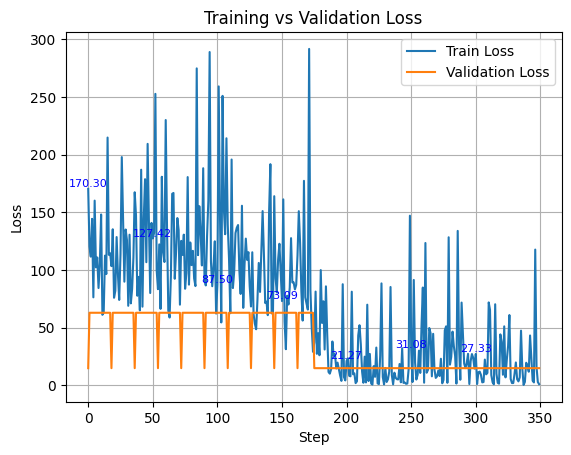

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Load data
df_losses = pd.read_csv("/Users/neleht./Desktop/nosync/HTX_xData_test/asr-train/losses.csv")

# Extract loss columns
train_losses = df_losses["train_loss"]
val_losses = df_losses["val_loss"]

# Plot loss curves
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")

# Label every 50th train_loss
for i in range(0, len(train_losses), 50):
    plt.text(i, train_losses.iloc[i], f"{train_losses.iloc[i]:.2f}",
             va='bottom', ha='center', fontsize=8, color='blue')

# Add labels and grid
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()


## Loss Curve Interpretation

This section provides an interpretation of the training and validation loss observed over two epochs. The analysis is based on logged training step losses and final validation losses, reflecting model behavior and learning dynamics under limited compute constraints.

### Training Dynamics

- **Initial Loss Values (Epoch 1):**  
  The training began with very high losses (e.g., Step 0: `170.30`), which is typical for a model that hasn't yet adapted to the dataset.

- **Fluctuations and Downward Trend:**  
  Over the course of the first epoch, the training loss gradually decreased, though it remained volatile. Examples include:
  - Step 20: `75.99`
  - Step 40: `65.04`
  - Step 130: `48.71`
  
  However, there were outliers like Step 60 with a spike to `229.90`, suggesting variability in batch difficulty due to the small batch size (`2`).

- **Second Epoch Improvements:**  
  In Epoch 2, the model began with significantly lower loss values (e.g., Step 0: `37.33`). Several steps saw single-digit losses, indicating strong learning:
  - Step 50: `1.23`
  - Step 110: `1.66`
  - Step 120: `1.27`
  
  A few spikes remained (e.g., Step 140: `70.33`), but overall the loss curve was smoother.

### Validation Performance

- **Epoch 1 Validation Loss:**  
  Concluded at `62.98`, suggesting the model had started to generalize, but with room for improvement.

- **Epoch 2 Validation Loss:**  
  Dropped sharply to `14.99`, indicating significant improvement in generalization and justifying the second epoch.

### Observations

- **Loss Spikes:**  
  The model experienced occasional large losses, likely due to challenging inputs or noisy labels. This is expected with a batch size of 2, which can amplify the effect of individual samples.

- **Variance and Stability:**  
  Loss values were more stable in the second epoch, suggesting the model had started to converge.

- **Learning Rate Effects:**  
  The low learning rate of `5e-6` helped prevent divergence and promoted steady learning, which was crucial given the small dataset and compute limitations.

### Summary

Despite constraints in compute and training time, the model showed clear learning progress between epochs. The sharp drop in validation loss demonstrates that even short


# Task 3c

## Run transcription with new fine tuned model on cv-valid-test

In [33]:
# Path to test data
csv_path = "/Users/neleht./Desktop/nosync/HTX_xData_test/common_voice/cv-valid-test.csv"
audio_folder = "/Users/neleht./Desktop/nosync/HTX_xData_test/common_voice/cv-valid-test"

In [34]:
# debug first 10
import os
import pandas as pd
import torch
from datasets import Dataset, Audio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from tqdm import tqdm



# Load data
df = pd.read_csv(csv_path).head(10)

# Transcribe
transcriptions = []

print("Transcribing test set...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    filename = row["filename"]
    audio_path = os.path.join(audio_folder, filename)

    try:
        ds = Dataset.from_dict({
            "audio": [audio_path]
        }).cast_column("audio", Audio(sampling_rate=16000))

        input_values = fine_tuned_model_processor(ds[0]["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values
        with torch.no_grad():
            logits = fine_tuned_model(input_values).logits

        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = fine_tuned_model_processor.batch_decode(predicted_ids)[0].strip().lower()
        print(f"Transcription for {filename}: {transcription}")
    except Exception as e:
        transcription = f"[ERROR] {str(e)}"
    
    transcriptions.append(transcription)

# Save results
df["generated_text"] = transcriptions
output_csv_path = "cv-valid-test_debug10.csv"
df.to_csv(output_csv_path, index=False)
print(f"Transcriptions saved to: {output_csv_path}")


Transcribing test set...


 10%|█         | 1/10 [00:01<00:12,  1.38s/it]

Transcription for cv-valid-test/sample-000000.mp3: without tha datasset the articleas useless


 20%|██        | 2/10 [00:02<00:08,  1.07s/it]

Transcription for cv-valid-test/sample-000001.mp3: i've got ta girl to him


 30%|███       | 3/10 [00:02<00:06,  1.15it/s]

Transcription for cv-valid-test/sample-000002.mp3: and you know it


 40%|████      | 4/10 [00:05<00:08,  1.46s/it]

Transcription for cv-valid-test/sample-000003.mp3: down below in the darkness were hundreds of people sleeping in peace


 50%|█████     | 5/10 [00:07<00:08,  1.66s/it]

Transcription for cv-valid-test/sample-000004.mp3: hold your nose to keep the smell from disabling your motive functions


 60%|██████    | 6/10 [00:08<00:06,  1.54s/it]

Transcription for cv-valid-test/sample-000005.mp3: down below in the darkness were hundreds of people sleeping in peace


 70%|███████   | 7/10 [00:09<00:04,  1.49s/it]

Transcription for cv-valid-test/sample-000006.mp3: strange imagespassed through my mind


 80%|████████  | 8/10 [00:10<00:02,  1.34s/it]

Transcription for cv-valid-test/sample-000007.mp3: the sheephad taught him that


 90%|█████████ | 9/10 [00:13<00:01,  1.62s/it]

Transcription for cv-valid-test/sample-000008.mp3: this was the strangest of all things that ever came to earth from outo space


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]

Transcription for cv-valid-test/sample-000009.mp3: it was glaringly hot not a cloud in the sky nor a breath of wind
Transcriptions saved to: cv-valid-test_debug10.csv


In [53]:
import os
import pandas as pd
import torch
from datasets import Dataset, Audio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from tqdm import tqdm


# Load data
df = pd.read_csv(csv_path)

# Transcribe
transcriptions = []

print("Transcribing test set...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    filename = row["filename"]
    audio_path = os.path.join(audio_folder, filename)

    try:
        ds = Dataset.from_dict({
            "audio": [audio_path]
        }).cast_column("audio", Audio(sampling_rate=16000))

        input_values = fine_tuned_model_processor(ds[0]["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values
        with torch.no_grad():
            logits = fine_tuned_model(input_values).logits

        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = fine_tuned_model_processor.batch_decode(predicted_ids)[0].strip().lower()
        print(f"Transcription for {filename}: {transcription}")
    except Exception as e:
        transcription = f"[ERROR] {str(e)}"
    
    transcriptions.append(transcription)

# Save results
df["generated_text"] = transcriptions
output_csv_path = "cv-valid-test_task3.csv"
df.to_csv(output_csv_path, index=False)
print(f"Transcriptions saved to: {output_csv_path}")


Transcribing test set...


  0%|          | 1/3995 [00:00<49:13,  1.35it/s]

Transcription for cv-valid-test/sample-000000.mp3: without tha datasset the articleas useless


  0%|          | 2/3995 [00:01<38:23,  1.73it/s]

Transcription for cv-valid-test/sample-000001.mp3: i've got ta girl to him


  0%|          | 3/3995 [00:01<35:15,  1.89it/s]

Transcription for cv-valid-test/sample-000002.mp3: and you know it


  0%|          | 4/3995 [00:03<1:03:43,  1.04it/s]

Transcription for cv-valid-test/sample-000003.mp3: down below in the darkness were hundreds of people sleeping in peace


  0%|          | 5/3995 [00:04<1:11:07,  1.07s/it]

Transcription for cv-valid-test/sample-000004.mp3: hold your nose to keep the smell from disabling your motive functions


  0%|          | 6/3995 [00:05<1:09:24,  1.04s/it]

Transcription for cv-valid-test/sample-000005.mp3: down below in the darkness were hundreds of people sleeping in peace


  0%|          | 7/3995 [00:06<1:07:43,  1.02s/it]

Transcription for cv-valid-test/sample-000006.mp3: strange imagespassed through my mind


  0%|          | 8/3995 [00:07<1:01:29,  1.08it/s]

Transcription for cv-valid-test/sample-000007.mp3: the sheephad taught him that


  0%|          | 9/3995 [00:08<1:14:52,  1.13s/it]

Transcription for cv-valid-test/sample-000008.mp3: this was the strangest of all things that ever came to earth from outo space


  0%|          | 10/3995 [00:09<1:07:25,  1.02s/it]

Transcription for cv-valid-test/sample-000009.mp3: it was glaringly hot not a cloud in the sky nor a breath of wind


  0%|          | 11/3995 [00:10<1:03:33,  1.04it/s]

Transcription for cv-valid-test/sample-000010.mp3: your son went to serve at a distant place and became a centurion


  0%|          | 12/3995 [00:11<58:26,  1.14it/s]  

Transcription for cv-valid-test/sample-000011.mp3: they made the boy continue digging but he found nothing


  0%|          | 13/3995 [00:12<1:00:43,  1.09it/s]

Transcription for cv-valid-test/sample-000012.mp3: one can imagine these two covered with sand running up the little street in the bright sunlight


  0%|          | 14/3995 [00:12<54:02,  1.23it/s]  

Transcription for cv-valid-test/sample-000013.mp3: the showers in there


  0%|          | 15/3995 [00:13<48:27,  1.37it/s]

Transcription for cv-valid-test/sample-000014.mp3: follow the instructions here


  0%|          | 16/3995 [00:14<53:00,  1.25it/s]

Transcription for cv-valid-test/sample-000015.mp3: they're calling to us not to give up and to keep on fighting


  0%|          | 17/3995 [00:14<52:05,  1.27it/s]

Transcription for cv-valid-test/sample-000016.mp3: the shop is closed on monnay's


  0%|          | 18/3995 [00:16<59:00,  1.12it/s]

Transcription for cv-valid-test/sample-000017.mp3: even coming down on the train together she wrote me


  0%|          | 19/3995 [00:16<54:05,  1.23it/s]

Transcription for cv-valid-test/sample-000018.mp3: i'm going away he said


  1%|          | 20/3995 [00:17<58:15,  1.14it/s]

Transcription for cv-valid-test/sample-000019.mp3: it must have fallen while i was sutting iver there


  1%|          | 21/3995 [00:18<59:04,  1.12it/s]

Transcription for cv-valid-test/sample-000020.mp3: i am going into the desert the man answered turning back to his reading


  1%|          | 22/3995 [00:19<53:17,  1.24it/s]

Transcription for cv-valid-test/sample-000021.mp3: he wasn't asking for help


  1%|          | 23/3995 [00:20<53:21,  1.24it/s]

Transcription for cv-valid-test/sample-000022.mp3: some of the grey ash was falling off the circular edge


  1%|          | 24/3995 [00:21<59:10,  1.12it/s]

Transcription for cv-valid-test/sample-000023.mp3: everyone when theyare youngknows what their destiny is


  1%|          | 25/3995 [00:21<49:55,  1.33it/s]

Transcription for cv-valid-test/sample-000024.mp3: ihad liked to think


  1%|          | 26/3995 [00:22<49:15,  1.34it/s]

Transcription for cv-valid-test/sample-000025.mp3: the alchemis probably already knew all that


  1%|          | 27/3995 [00:23<48:22,  1.37it/s]

Transcription for cv-valid-test/sample-000026.mp3: you'll take fifty and light it


  1%|          | 28/3995 [00:23<49:58,  1.32it/s]

Transcription for cv-valid-test/sample-000027.mp3: it was dropping off in flakes and raining down on the sand


  1%|          | 29/3995 [00:24<48:19,  1.37it/s]

Transcription for cv-valid-test/sample-000028.mp3: what's your namehe asked


  1%|          | 30/3995 [00:25<45:24,  1.46it/s]

Transcription for cv-valid-test/sample-000029.mp3: it's because you were not born


  1%|          | 31/3995 [00:25<42:35,  1.55it/s]

Transcription for cv-valid-test/sample-000030.mp3: what do you think of that


  1%|          | 32/3995 [00:26<44:49,  1.47it/s]

Transcription for cv-valid-test/sample-000031.mp3: if i had told you you wouldn't have seen thepuliments


  1%|          | 33/3995 [00:27<46:30,  1.42it/s]

Transcription for cv-valid-test/sample-000032.mp3: i haven't heard the baby complain yet


  1%|          | 34/3995 [00:27<48:59,  1.35it/s]

Transcription for cv-valid-test/sample-000033.mp3: i told himhe could teach her to ignore people who waste her time


  1%|          | 35/3995 [00:28<43:31,  1.52it/s]

Transcription for cv-valid-test/sample-000034.mp3: the one you're blocking


  1%|          | 36/3995 [00:29<42:25,  1.56it/s]

Transcription for cv-valid-test/sample-000035.mp3: henderson stood up with a spade in his hand


  1%|          | 37/3995 [00:29<41:47,  1.58it/s]

Transcription for cv-valid-test/sample-000036.mp3: he didn't need to seek out the old woman for this


  1%|          | 38/3995 [00:30<43:26,  1.52it/s]

Transcription for cv-valid-test/sample-000037.mp3: only a minority of literature is written this way


  1%|          | 39/3995 [00:30<38:50,  1.70it/s]

Transcription for cv-valid-test/sample-000038.mp3: i wish you wouldn't


  1%|          | 40/3995 [00:32<55:32,  1.19it/s]

Transcription for cv-valid-test/sample-000039.mp3: nature knows me is the wisest being in creation the sun said


  1%|          | 41/3995 [00:33<1:04:02,  1.03it/s]

Transcription for cv-valid-test/sample-000040.mp3: there's only one way to lernthe alchimist answre


  1%|          | 42/3995 [00:34<56:04,  1.17it/s]  

Transcription for cv-valid-test/sample-000041.mp3: don't do it for me


  1%|          | 43/3995 [00:34<52:52,  1.25it/s]

Transcription for cv-valid-test/sample-000042.mp3: i'm not working for any other paper


  1%|          | 44/3995 [00:35<47:28,  1.39it/s]

Transcription for cv-valid-test/sample-000043.mp3: that's not so bad


  1%|          | 45/3995 [00:36<1:00:22,  1.09it/s]

Transcription for cv-valid-test/sample-000044.mp3: i had the diet of a kid who found twenty dollars


  1%|          | 46/3995 [00:37<55:12,  1.19it/s]  

Transcription for cv-valid-test/sample-000045.mp3: i have the money i need to buy my sheep


  1%|          | 47/3995 [00:38<52:44,  1.25it/s]

Transcription for cv-valid-test/sample-000046.mp3: the boy looked out at the horizon


  1%|          | 48/3995 [00:38<47:11,  1.39it/s]

Transcription for cv-valid-test/sample-000047.mp3: never mind about that


  1%|          | 49/3995 [00:39<50:47,  1.29it/s]

Transcription for cv-valid-test/sample-000048.mp3: that night there was another jetting out of gas from the distant planet


  1%|▏         | 50/3995 [00:40<54:51,  1.20it/s]

Transcription for cv-valid-test/sample-000049.mp3: most of them were staring quietly at the big table


  1%|▏         | 51/3995 [00:41<52:25,  1.25it/s]

Transcription for cv-valid-test/sample-000050.mp3: i make my living forecasting the future for peoplehe said


  1%|▏         | 52/3995 [00:41<50:40,  1.30it/s]

Transcription for cv-valid-test/sample-000051.mp3: now i would drift gently off to dreamland


  1%|▏         | 53/3995 [00:42<56:16,  1.17it/s]

Transcription for cv-valid-test/sample-000052.mp3: he did find it soon after dawnand not far from the sandpits


  1%|▏         | 54/3995 [00:43<51:51,  1.27it/s]

Transcription for cv-valid-test/sample-000053.mp3: of course the two were unable to do anything


  1%|▏         | 55/3995 [00:44<48:15,  1.36it/s]

Transcription for cv-valid-test/sample-000054.mp3: all they think about is food and water


  1%|▏         | 56/3995 [00:44<43:54,  1.49it/s]

Transcription for cv-valid-test/sample-000055.mp3: shakspeare never said that


  1%|▏         | 57/3995 [00:45<41:07,  1.60it/s]

Transcription for cv-valid-test/sample-000056.mp3: you need to see this


  1%|▏         | 58/3995 [00:45<38:45,  1.69it/s]

Transcription for cv-valid-test/sample-000057.mp3: the boy knew a lot of people in the city


  1%|▏         | 59/3995 [00:46<40:43,  1.61it/s]

Transcription for cv-valid-test/sample-000058.mp3: frank was dying so they were forced to leave him


  2%|▏         | 60/3995 [00:46<35:46,  1.83it/s]

Transcription for cv-valid-test/sample-000059.mp3: this is no place for you


  2%|▏         | 61/3995 [00:47<43:17,  1.51it/s]

Transcription for cv-valid-test/sample-000060.mp3: the boy reminded the old man that he had said something about hidden treasure


  2%|▏         | 62/3995 [00:48<42:45,  1.53it/s]

Transcription for cv-valid-test/sample-000061.mp3: tom point the gun at me


  2%|▏         | 63/3995 [00:48<40:57,  1.60it/s]

Transcription for cv-valid-test/sample-000062.mp3: he's the man that's are written for


  2%|▏         | 64/3995 [00:49<41:53,  1.56it/s]

Transcription for cv-valid-test/sample-000063.mp3: there was no excuse for goodman to fly off the handle


  2%|▏         | 65/3995 [00:50<47:32,  1.38it/s]

Transcription for cv-valid-test/sample-000064.mp3: that daythe merchant gave the boy permissionto build the dist


  2%|▏         | 66/3995 [00:51<46:50,  1.40it/s]

Transcription for cv-valid-test/sample-000065.mp3: i told you to have the eyespot fixed


  2%|▏         | 67/3995 [00:51<45:06,  1.45it/s]

Transcription for cv-valid-test/sample-000066.mp3: it's late in the evening a perfect time for coffee


  2%|▏         | 68/3995 [00:52<43:07,  1.52it/s]

Transcription for cv-valid-test/sample-000067.mp3: i'm coming fartimar he said


  2%|▏         | 69/3995 [00:52<40:27,  1.62it/s]

Transcription for cv-valid-test/sample-000068.mp3: don't do it for me


  2%|▏         | 70/3995 [00:53<40:21,  1.62it/s]

Transcription for cv-valid-test/sample-000069.mp3: i'm sure i don't know what you're talking about


  2%|▏         | 71/3995 [00:54<39:10,  1.67it/s]

Transcription for cv-valid-test/sample-000070.mp3: he felt invisible among all those young people


  2%|▏         | 72/3995 [00:54<43:19,  1.51it/s]

Transcription for cv-valid-test/sample-000071.mp3: he thought of all the marryed shepherds he had known


  2%|▏         | 73/3995 [00:55<43:53,  1.49it/s]

Transcription for cv-valid-test/sample-000072.mp3: did you mean spithe and thinks like dut


  2%|▏         | 74/3995 [00:56<50:08,  1.30it/s]

Transcription for cv-valid-test/sample-000073.mp3: but finally the merchant appeared and asked a boy to share full shap


  2%|▏         | 75/3995 [00:57<43:58,  1.49it/s]

Transcription for cv-valid-test/sample-000074.mp3: i just gut rid of one crowd


  2%|▏         | 76/3995 [00:57<46:43,  1.40it/s]

Transcription for cv-valid-test/sample-000075.mp3: every search begins with pigener's lock


  2%|▏         | 77/3995 [00:58<44:54,  1.45it/s]

Transcription for cv-valid-test/sample-000076.mp3: you can't be the windthe wind said


  2%|▏         | 78/3995 [00:59<44:49,  1.46it/s]

Transcription for cv-valid-test/sample-000077.mp3: he had surprised himself with the thought


  2%|▏         | 79/3995 [00:59<47:11,  1.38it/s]

Transcription for cv-valid-test/sample-000078.mp3: he was going to miss the place and all a good thing that he had laid


  2%|▏         | 80/3995 [01:01<56:06,  1.16it/s]

Transcription for cv-valid-test/sample-000079.mp3: a huge hola had been made by the impact of the projectile


  2%|▏         | 81/3995 [01:02<1:02:35,  1.04it/s]

Transcription for cv-valid-test/sample-000080.mp3: most meteorites are more or less rounded


  2%|▏         | 82/3995 [01:03<1:07:14,  1.03s/it]

Transcription for cv-valid-test/sample-000081.mp3: it's candas now a long distance from washington


  2%|▏         | 83/3995 [01:04<1:00:19,  1.08it/s]

Transcription for cv-valid-test/sample-000082.mp3: he could always go back to being a shepherd


  2%|▏         | 84/3995 [01:05<1:00:16,  1.08it/s]

Transcription for cv-valid-test/sample-000083.mp3: the boy went to his room and pecked his belongings


  2%|▏         | 85/3995 [01:05<50:34,  1.29it/s]  

Transcription for cv-valid-test/sample-000084.mp3: did you know that


  2%|▏         | 86/3995 [01:06<1:00:46,  1.07it/s]

Transcription for cv-valid-test/sample-000085.mp3: they went in to drink the tea which was served in beautiful crystal glasses


  2%|▏         | 87/3995 [01:07<52:17,  1.25it/s]  

Transcription for cv-valid-test/sample-000086.mp3: this is for you


  2%|▏         | 88/3995 [01:08<49:16,  1.32it/s]

Transcription for cv-valid-test/sample-000087.mp3: they were men of the desert and they were fearful of sorcerers


  2%|▏         | 89/3995 [01:08<48:37,  1.34it/s]

Transcription for cv-valid-test/sample-000088.mp3: their faces were hidden behind blue veils with only their eyes showing


  2%|▏         | 90/3995 [01:09<44:46,  1.45it/s]

Transcription for cv-valid-test/sample-000089.mp3: it seems so safe and tranquil


  2%|▏         | 91/3995 [01:09<39:55,  1.63it/s]

Transcription for cv-valid-test/sample-000090.mp3: aint you going to tell me


  2%|▏         | 92/3995 [01:10<38:17,  1.70it/s]

Transcription for cv-valid-test/sample-000091.mp3: that's true the boy thought


  2%|▏         | 93/3995 [01:11<44:33,  1.46it/s]

Transcription for cv-valid-test/sample-000092.mp3: we are refugees from the tribe of warsand we need money the other figure said


  2%|▏         | 94/3995 [01:12<48:00,  1.35it/s]

Transcription for cv-valid-test/sample-000093.mp3: during one of these conversations the rivortol of his own life


  2%|▏         | 95/3995 [01:12<47:26,  1.37it/s]

Transcription for cv-valid-test/sample-000094.mp3: isn't the party also to announce his engagement to joanna


  2%|▏         | 96/3995 [01:13<53:11,  1.22it/s]

Transcription for cv-valid-test/sample-000095.mp3: he remembered something his grandfather had once told him that butterflies were a good omen


  2%|▏         | 97/3995 [01:14<58:07,  1.12it/s]

Transcription for cv-valid-test/sample-000096.mp3: i heard a faint movement inder my feet


  2%|▏         | 98/3995 [01:15<1:02:45,  1.03it/s]

Transcription for cv-valid-test/sample-000097.mp3: he stood irresolute for a moment and then scrambled out of the pit


  2%|▏         | 99/3995 [01:16<58:13,  1.12it/s]  

Transcription for cv-valid-test/sample-000098.mp3: even then he hardly understood what this meant


  3%|▎         | 100/3995 [01:17<52:11,  1.24it/s]

Transcription for cv-valid-test/sample-000099.mp3: it looked like a rusty gasflute


  3%|▎         | 101/3995 [01:18<51:11,  1.27it/s]

Transcription for cv-valid-test/sample-000100.mp3: it knew of the boy's talk with the desert because the winds know everything


  3%|▎         | 102/3995 [01:18<48:43,  1.33it/s]

Transcription for cv-valid-test/sample-000101.mp3: all they think about is fruid and water


  3%|▎         | 103/3995 [01:19<57:16,  1.13it/s]

Transcription for cv-valid-test/sample-000102.mp3: after the dictators rule of forty three years was overthe pantry was devastite


  3%|▎         | 104/3995 [01:20<57:20,  1.13it/s]

Transcription for cv-valid-test/sample-000103.mp3: only when he consents


  3%|▎         | 105/3995 [01:21<58:52,  1.10it/s]

Transcription for cv-valid-test/sample-000104.mp3: the camel driver was seated at the base of a palm tree observing the sunset


  3%|▎         | 106/3995 [01:22<55:21,  1.17it/s]

Transcription for cv-valid-test/sample-000105.mp3: all they ever do really is look for food and water


  3%|▎         | 107/3995 [01:23<52:41,  1.23it/s]

Transcription for cv-valid-test/sample-000106.mp3: sure you don't want me to go in with you


  3%|▎         | 108/3995 [01:24<58:35,  1.11it/s]

Transcription for cv-valid-test/sample-000107.mp3: i want it as soon as possibro


  3%|▎         | 109/3995 [01:25<1:00:12,  1.08it/s]

Transcription for cv-valid-test/sample-000108.mp3: they lookd like a resting gaslot


  3%|▎         | 110/3995 [01:25<55:01,  1.18it/s]  

Transcription for cv-valid-test/sample-000109.mp3: sone strong te worte wretchage


  3%|▎         | 111/3995 [01:27<1:00:53,  1.06it/s]

Transcription for cv-valid-test/sample-000110.mp3: it was as if it quivered but really this was the telescope vibrating


  3%|▎         | 112/3995 [01:27<58:42,  1.10it/s]  

Transcription for cv-valid-test/sample-000111.mp3: modern sewing machines can throttle their speed


  3%|▎         | 113/3995 [01:28<49:53,  1.30it/s]

Transcription for cv-valid-test/sample-000112.mp3: it's as much my fault as yours


  3%|▎         | 114/3995 [01:29<58:16,  1.11it/s]

Transcription for cv-valid-test/sample-000113.mp3: image registration could be easily incorporated into low power andbedded devices


  3%|▎         | 115/3995 [01:30<1:04:03,  1.01it/s]

Transcription for cv-valid-test/sample-000114.mp3: the merchants were assembling their stalls and the boy helped a kandyseller to do his


  3%|▎         | 116/3995 [01:31<55:18,  1.17it/s]  

Transcription for cv-valid-test/sample-000115.mp3: you don't deny that


  3%|▎         | 117/3995 [01:32<52:53,  1.22it/s]

Transcription for cv-valid-test/sample-000116.mp3: the madseboy continued digging but he found nothing


  3%|▎         | 118/3995 [01:33<1:00:33,  1.07it/s]

Transcription for cv-valid-test/sample-000117.mp3: then he sat in the sunfilled doorway smoking the hooka


  3%|▎         | 119/3995 [01:34<1:01:16,  1.05it/s]

Transcription for cv-valid-test/sample-000118.mp3: about eleven i walked back to my home in maybury because nothing seemed to be happening


  3%|▎         | 120/3995 [01:35<1:00:18,  1.07it/s]

Transcription for cv-valid-test/sample-000119.mp3: itsaid that the darkest hour of the night came just before the dawn


  3%|▎         | 121/3995 [01:35<53:42,  1.20it/s]  

Transcription for cv-valid-test/sample-000120.mp3: all things are one the boy thought


  3%|▎         | 122/3995 [01:36<47:18,  1.36it/s]

Transcription for cv-valid-test/sample-000121.mp3: i can't let you have my plane


  3%|▎         | 123/3995 [01:37<57:30,  1.12it/s]

Transcription for cv-valid-test/sample-000122.mp3: if what one finds is made of pure matterit will never spoil


  3%|▎         | 124/3995 [01:38<1:01:50,  1.04it/s]

Transcription for cv-valid-test/sample-000123.mp3: he put his headcloth in place and secured it with a ring made of camelskin


  3%|▎         | 125/3995 [01:39<1:02:39,  1.03it/s]

Transcription for cv-valid-test/sample-000124.mp3: my seven year reseme cap a smart in not drugs


  3%|▎         | 126/3995 [01:40<55:15,  1.17it/s]  

Transcription for cv-valid-test/sample-000125.mp3: the englishman asked if they were in danger


  3%|▎         | 127/3995 [01:41<57:45,  1.12it/s]

Transcription for cv-valid-test/sample-000126.mp3: salas beggebuboy


  3%|▎         | 128/3995 [01:42<59:14,  1.09it/s]

Transcription for cv-valid-test/sample-000127.mp3: the boy was trong on war to do ritalier but he was in a foreign country


  3%|▎         | 129/3995 [01:43<56:59,  1.13it/s]

Transcription for cv-valid-test/sample-000128.mp3: that it was a little too large for a sherman


  3%|▎         | 130/3995 [01:43<52:49,  1.22it/s]

Transcription for cv-valid-test/sample-000129.mp3: it's the masterwork of the alchemists


  3%|▎         | 131/3995 [01:44<53:34,  1.20it/s]

Transcription for cv-valid-test/sample-000130.mp3: they went on smoking the pipe for a while as the sun began to set


  3%|▎         | 132/3995 [01:46<1:08:15,  1.06s/it]

Transcription for cv-valid-test/sample-000131.mp3: he heard a muffled grating soundand saw the black markjerk forward an inch or so


  3%|▎         | 133/3995 [01:46<1:02:59,  1.02it/s]

Transcription for cv-valid-test/sample-000132.mp3: from hereon you will be alone the alchonist said


  3%|▎         | 134/3995 [01:47<55:36,  1.16it/s]  

Transcription for cv-valid-test/sample-000133.mp3: the burning fire had been extinguished


  3%|▎         | 135/3995 [01:48<1:00:18,  1.07it/s]

Transcription for cv-valid-test/sample-000134.mp3: in those days very few of the people had any idea about astronomy


  3%|▎         | 136/3995 [01:49<1:01:47,  1.04it/s]

Transcription for cv-valid-test/sample-000135.mp3: sometimes i get so mad at you i can't see straight


  3%|▎         | 137/3995 [01:50<1:05:29,  1.02s/it]

Transcription for cv-valid-test/sample-000136.mp3: on our way to san francisco we were listening to raging music and smoking weed


  3%|▎         | 138/3995 [01:51<55:38,  1.16it/s]  

Transcription for cv-valid-test/sample-000137.mp3: wofa sackon here


  3%|▎         | 139/3995 [01:52<53:00,  1.21it/s]

Transcription for cv-valid-test/sample-000138.mp3: many of our soldiers teamed up


  4%|▎         | 140/3995 [01:52<51:26,  1.25it/s]

Transcription for cv-valid-test/sample-000139.mp3: am i going to find my treasure he asked


  4%|▎         | 141/3995 [01:53<55:20,  1.16it/s]

Transcription for cv-valid-test/sample-000140.mp3: heliummakes your voicei pitched


  4%|▎         | 142/3995 [01:55<1:06:08,  1.03s/it]

Transcription for cv-valid-test/sample-000141.mp3: it was faintly marked with transversed stripes and slightly flattened with the perfect round


  4%|▎         | 143/3995 [01:56<1:04:25,  1.00s/it]

Transcription for cv-valid-test/sample-000142.mp3: the boy closed his book


  4%|▎         | 144/3995 [01:56<57:09,  1.12it/s]  

Transcription for cv-valid-test/sample-000143.mp3: you mean the one who drank so much


  4%|▎         | 145/3995 [01:57<50:22,  1.27it/s]

Transcription for cv-valid-test/sample-000144.mp3: this is no place for you


  4%|▎         | 146/3995 [01:57<44:01,  1.46it/s]

Transcription for cv-valid-test/sample-000145.mp3: mesesarah doesn't either


  4%|▎         | 147/3995 [01:58<40:58,  1.57it/s]

Transcription for cv-valid-test/sample-000146.mp3: his expression reminded me of her horse chewing hair


  4%|▎         | 148/3995 [01:59<45:04,  1.42it/s]

Transcription for cv-valid-test/sample-000147.mp3: about eleven i walked back to my home in naybury because nothing seemed to be happening


  4%|▎         | 149/3995 [01:59<43:36,  1.47it/s]

Transcription for cv-valid-test/sample-000148.mp3: naturally we have to do something about it


  4%|▍         | 150/3995 [02:00<47:55,  1.34it/s]

Transcription for cv-valid-test/sample-000149.mp3: make sure you've read my introductory post on voist coting since wewill be building upon that


  4%|▍         | 151/3995 [02:01<49:30,  1.29it/s]

Transcription for cv-valid-test/sample-000150.mp3: kitol fatimadatat their next meeting


  4%|▍         | 152/3995 [02:02<45:06,  1.42it/s]

Transcription for cv-valid-test/sample-000151.mp3: everyone seemed vary sitid


  4%|▍         | 153/3995 [02:02<41:28,  1.54it/s]

Transcription for cv-valid-test/sample-000152.mp3: maybe the water was too hot


  4%|▍         | 154/3995 [02:03<54:29,  1.17it/s]

Transcription for cv-valid-test/sample-000153.mp3: a line of flame highcan be seen in the atmosphere


  4%|▍         | 155/3995 [02:05<1:00:57,  1.05it/s]

Transcription for cv-valid-test/sample-000154.mp3: he really was a kinga wise king


  4%|▍         | 156/3995 [02:05<59:18,  1.08it/s]  

Transcription for cv-valid-test/sample-000155.mp3: a line of flame high can be seen in the atmosphere


  4%|▍         | 157/3995 [02:06<58:22,  1.10it/s]

Transcription for cv-valid-test/sample-000156.mp3: he needs three days answered the alchemist


  4%|▍         | 158/3995 [02:08<1:06:57,  1.05s/it]

Transcription for cv-valid-test/sample-000157.mp3: the crowd swayed a little as i elbowed my way through


  4%|▍         | 159/3995 [02:08<1:01:04,  1.05it/s]

Transcription for cv-valid-test/sample-000158.mp3: it was the first time either had touched the other


  4%|▍         | 160/3995 [02:09<50:40,  1.26it/s]  

Transcription for cv-valid-test/sample-000159.mp3: i'm living right now


  4%|▍         | 161/3995 [02:10<50:02,  1.28it/s]

Transcription for cv-valid-test/sample-000160.mp3: then connect a local host within windows


  4%|▍         | 162/3995 [02:10<45:46,  1.40it/s]

Transcription for cv-valid-test/sample-000161.mp3: an he wusn't faring much better


  4%|▍         | 163/3995 [02:11<41:46,  1.53it/s]

Transcription for cv-valid-test/sample-000162.mp3: the boy plas tofol


  4%|▍         | 164/3995 [02:12<45:18,  1.41it/s]

Transcription for cv-valid-test/sample-000163.mp3: i don't understand what you're talking about the desert said


  4%|▍         | 165/3995 [02:12<42:09,  1.51it/s]

Transcription for cv-valid-test/sample-000164.mp3: the jailifh took them up the mount


  4%|▍         | 166/3995 [02:13<45:07,  1.41it/s]

Transcription for cv-valid-test/sample-000165.mp3: somebody had returned my lost creticard to the bank


  4%|▍         | 167/3995 [02:14<44:59,  1.42it/s]

Transcription for cv-valid-test/sample-000166.mp3: besides that there was a heap of bicycles


  4%|▍         | 168/3995 [02:14<41:11,  1.55it/s]

Transcription for cv-valid-test/sample-000167.mp3: that doesn't say much for mine


  4%|▍         | 169/3995 [02:15<50:50,  1.25it/s]

Transcription for cv-valid-test/sample-000168.mp3: don't give into your fearssaid the alchemistin a strangely gentle voice


  4%|▍         | 170/3995 [02:16<45:05,  1.41it/s]

Transcription for cv-valid-test/sample-000169.mp3: just handling them made him feel better


  4%|▍         | 171/3995 [02:16<44:12,  1.44it/s]

Transcription for cv-valid-test/sample-000170.mp3: how am i going to live until the bank opens


  4%|▍         | 172/3995 [02:17<42:03,  1.52it/s]

Transcription for cv-valid-test/sample-000171.mp3: lis put the flowers into a mirrored vase


  4%|▍         | 173/3995 [02:18<54:02,  1.18it/s]

Transcription for cv-valid-test/sample-000172.mp3: he prepared himself a sandwich and drank some hot tea from a crystal glass


  4%|▍         | 174/3995 [02:19<49:27,  1.29it/s]

Transcription for cv-valid-test/sample-000173.mp3: promise you'll never lie the way snoopy dead


  4%|▍         | 175/3995 [02:20<49:23,  1.29it/s]

Transcription for cv-valid-test/sample-000174.mp3: there is no vil in this countrythe young man said


  4%|▍         | 176/3995 [02:21<55:14,  1.15it/s]

Transcription for cv-valid-test/sample-000175.mp3: alido laying high can be taming in the atomobile


  4%|▍         | 177/3995 [02:22<58:55,  1.08it/s]

Transcription for cv-valid-test/sample-000176.mp3: then she took both of his hands in hers and began quietly to pray


  4%|▍         | 178/3995 [02:22<53:55,  1.18it/s]

Transcription for cv-valid-test/sample-000177.mp3: you think i was on the witness thent


  4%|▍         | 179/3995 [02:24<1:07:23,  1.06s/it]

Transcription for cv-valid-test/sample-000178.mp3: the amerald tablet is a direct passage to the soul of the world


  5%|▍         | 180/3995 [02:25<56:48,  1.12it/s]  

Transcription for cv-valid-test/sample-000179.mp3: have already torned you


  5%|▍         | 181/3995 [02:25<51:39,  1.23it/s]

Transcription for cv-valid-test/sample-000180.mp3: tis is for you


  5%|▍         | 182/3995 [02:26<51:13,  1.24it/s]

Transcription for cv-valid-test/sample-000181.mp3: my tex dollars pay for those public school proms


  5%|▍         | 183/3995 [02:27<50:12,  1.27it/s]

Transcription for cv-valid-test/sample-000182.mp3: plas give me a few hoursbefore you make any decision


  5%|▍         | 184/3995 [02:28<54:26,  1.17it/s]

Transcription for cv-valid-test/sample-000183.mp3: and the girl pointed to the south in decating that it was there the strange man lived


  5%|▍         | 185/3995 [02:29<1:07:52,  1.07s/it]

Transcription for cv-valid-test/sample-000184.mp3: in one he had read thatmany years ago a famous arabian alchemist had visited europe


  5%|▍         | 186/3995 [02:30<1:00:51,  1.04it/s]

Transcription for cv-valid-test/sample-000185.mp3: one is loved because one is loved


  5%|▍         | 187/3995 [02:30<52:17,  1.21it/s]  

Transcription for cv-valid-test/sample-000186.mp3: they mounted their horses


  5%|▍         | 188/3995 [02:31<54:27,  1.17it/s]

Transcription for cv-valid-test/sample-000187.mp3: even thenhe hardly understood what this meant


  5%|▍         | 189/3995 [02:32<50:26,  1.26it/s]

Transcription for cv-valid-test/sample-000188.mp3: i'd hate to have that may pin stuck in me


  5%|▍         | 190/3995 [02:33<46:09,  1.37it/s]

Transcription for cv-valid-test/sample-000189.mp3: imet a man with sharp nails


  5%|▍         | 191/3995 [02:33<47:18,  1.34it/s]

Transcription for cv-valid-test/sample-000190.mp3: only the lightsin the great tent remained


  5%|▍         | 192/3995 [02:34<43:55,  1.44it/s]

Transcription for cv-valid-test/sample-000191.mp3: apparently is the dumplings that make this due taste so gord


  5%|▍         | 193/3995 [02:36<1:04:03,  1.01s/it]

Transcription for cv-valid-test/sample-000192.mp3: when she saw the unknown object bobbing up and down the edgeshe was absolutely horrified


  5%|▍         | 194/3995 [02:37<1:01:00,  1.04it/s]

Transcription for cv-valid-test/sample-000193.mp3: i have known true alchemiststhe alchemist continued


  5%|▍         | 195/3995 [02:38<1:00:04,  1.05it/s]

Transcription for cv-valid-test/sample-000194.mp3: he really was a kinga wise king


  5%|▍         | 196/3995 [02:38<57:24,  1.10it/s]  

Transcription for cv-valid-test/sample-000195.mp3: what are these thingshe asked


  5%|▍         | 197/3995 [02:39<58:12,  1.09it/s]

Transcription for cv-valid-test/sample-000196.mp3: i pointed out marsa bright dut of light


  5%|▍         | 198/3995 [02:40<49:06,  1.29it/s]

Transcription for cv-valid-test/sample-000197.mp3: i never saw it before


  5%|▍         | 199/3995 [02:40<44:06,  1.43it/s]

Transcription for cv-valid-test/sample-000198.mp3: i'm proud of it


  5%|▌         | 200/3995 [02:41<48:49,  1.30it/s]

Transcription for cv-valid-test/sample-000199.mp3: the boy was embarrassedand confessed that he had observed nothing


  5%|▌         | 201/3995 [02:43<1:03:24,  1.00s/it]

Transcription for cv-valid-test/sample-000200.mp3: the thought was so dreadful to himthat he forgot about the heat and went forward


  5%|▌         | 202/3995 [02:44<1:00:43,  1.04it/s]

Transcription for cv-valid-test/sample-000201.mp3: he left without saying goodbye to the crystal merchant


  5%|▌         | 203/3995 [02:44<54:56,  1.15it/s]  

Transcription for cv-valid-test/sample-000202.mp3: a boy came running towards me


  5%|▌         | 204/3995 [02:45<51:29,  1.23it/s]

Transcription for cv-valid-test/sample-000203.mp3: a fine bunch of reporters


  5%|▌         | 205/3995 [02:45<45:46,  1.38it/s]

Transcription for cv-valid-test/sample-000204.mp3: the boy was startled


  5%|▌         | 206/3995 [02:46<51:00,  1.24it/s]

Transcription for cv-valid-test/sample-000205.mp3: some of those who saw its flight say it travelled with a hissing sound


  5%|▌         | 207/3995 [02:47<49:21,  1.28it/s]

Transcription for cv-valid-test/sample-000206.mp3: everyone on earth has a treasure that awaits him his heart said


  5%|▌         | 208/3995 [02:48<53:30,  1.18it/s]

Transcription for cv-valid-test/sample-000207.mp3: it's accord sayd the boy and bit disappointed


  5%|▌         | 209/3995 [02:49<49:56,  1.26it/s]

Transcription for cv-valid-test/sample-000208.mp3: what about this job


  5%|▌         | 210/3995 [02:50<53:24,  1.18it/s]

Transcription for cv-valid-test/sample-000209.mp3: what is an alchemisthe asked finally


  5%|▌         | 211/3995 [02:51<57:38,  1.09it/s]

Transcription for cv-valid-test/sample-000210.mp3: and their eyes spoke of death


  5%|▌         | 212/3995 [02:52<1:04:35,  1.02s/it]

Transcription for cv-valid-test/sample-000211.mp3: the alchemist is two hundred years old the englishman had told him


  5%|▌         | 213/3995 [02:54<1:15:29,  1.20s/it]

Transcription for cv-valid-test/sample-000212.mp3: he recited on our farther silently


  5%|▌         | 214/3995 [02:54<1:06:06,  1.05s/it]

Transcription for cv-valid-test/sample-000213.mp3: i'm going to find hal's mother


  5%|▌         | 215/3995 [02:55<1:01:53,  1.02it/s]

Transcription for cv-valid-test/sample-000214.mp3: i would have won the junior olympicsif not for those meddling kids


  5%|▌         | 216/3995 [02:56<55:21,  1.14it/s]  

Transcription for cv-valid-test/sample-000215.mp3: his hands began to tremble and the woman sensed it


  5%|▌         | 217/3995 [02:56<47:29,  1.33it/s]

Transcription for cv-valid-test/sample-000216.mp3: give it t me


  5%|▌         | 218/3995 [02:58<54:21,  1.16it/s]

Transcription for cv-valid-test/sample-000217.mp3: in spite of thisi still believed that there were men in mars


  5%|▌         | 219/3995 [02:59<57:04,  1.10it/s]

Transcription for cv-valid-test/sample-000218.mp3: the sunset faded into twilight before anything else happened


  6%|▌         | 220/3995 [02:59<55:31,  1.13it/s]

Transcription for cv-valid-test/sample-000219.mp3: the boy began to dickento the duran


  6%|▌         | 221/3995 [03:01<1:01:18,  1.03it/s]

Transcription for cv-valid-test/sample-000220.mp3: this is what was written on the emerald tabletsaid the alchemistwhen he finished


  6%|▌         | 222/3995 [03:02<1:02:43,  1.00it/s]

Transcription for cv-valid-test/sample-000221.mp3: sadlymy dream of becoming a squirrel whisperer may never happen


  6%|▌         | 223/3995 [03:02<57:43,  1.09it/s]  

Transcription for cv-valid-test/sample-000222.mp3: an army is coming the voice said


  6%|▌         | 224/3995 [03:03<52:21,  1.20it/s]

Transcription for cv-valid-test/sample-000223.mp3: i noticed that the boy answered


  6%|▌         | 225/3995 [03:04<47:47,  1.31it/s]

Transcription for cv-valid-test/sample-000224.mp3: the boy was getting ireteated


  6%|▌         | 226/3995 [03:04<47:56,  1.31it/s]

Transcription for cv-valid-test/sample-000225.mp3: you will never be able to escape from your heart


  6%|▌         | 227/3995 [03:05<45:19,  1.39it/s]

Transcription for cv-valid-test/sample-000226.mp3: the first day passed


  6%|▌         | 228/3995 [03:06<48:15,  1.30it/s]

Transcription for cv-valid-test/sample-000227.mp3: at most they thought that another matter reat he descended


  6%|▌         | 229/3995 [03:07<48:57,  1.28it/s]

Transcription for cv-valid-test/sample-000228.mp3: i don't know what she's talking about


  6%|▌         | 230/3995 [03:07<49:10,  1.28it/s]

Transcription for cv-valid-test/sample-000229.mp3: it seemed such a little thing so bright and small and still


  6%|▌         | 231/3995 [03:08<47:07,  1.33it/s]

Transcription for cv-valid-test/sample-000230.mp3: but his heart was speaking of other things


  6%|▌         | 232/3995 [03:09<45:44,  1.37it/s]

Transcription for cv-valid-test/sample-000231.mp3: what if you canstand him


  6%|▌         | 233/3995 [03:09<40:53,  1.53it/s]

Transcription for cv-valid-test/sample-000232.mp3: there were strange books


  6%|▌         | 234/3995 [03:10<46:42,  1.34it/s]

Transcription for cv-valid-test/sample-000233.mp3: brent opening attack on the governor


  6%|▌         | 235/3995 [03:11<44:35,  1.41it/s]

Transcription for cv-valid-test/sample-000234.mp3: i've actually fallen in love with him


  6%|▌         | 236/3995 [03:12<46:17,  1.35it/s]

Transcription for cv-valid-test/sample-000235.mp3: did you actually give tamera that gun


  6%|▌         | 237/3995 [03:12<42:53,  1.46it/s]

Transcription for cv-valid-test/sample-000236.mp3: iam smoking too much


  6%|▌         | 238/3995 [03:13<39:18,  1.59it/s]

Transcription for cv-valid-test/sample-000237.mp3: i know you are unhappy


  6%|▌         | 239/3995 [03:13<40:34,  1.54it/s]

Transcription for cv-valid-test/sample-000238.mp3: are thus stumbed upon the stone by accident


  6%|▌         | 240/3995 [03:14<46:28,  1.35it/s]

Transcription for cv-valid-test/sample-000239.mp3: it was such a gradual movement that he found it only by noticing the dots


  6%|▌         | 241/3995 [03:16<1:05:30,  1.05s/it]

Transcription for cv-valid-test/sample-000240.mp3: the englishman said nothing


  6%|▌         | 242/3995 [03:17<1:04:36,  1.03s/it]

Transcription for cv-valid-test/sample-000241.mp3: because we're the peopleand we're tough


  6%|▌         | 243/3995 [03:18<1:04:57,  1.04s/it]

Transcription for cv-valid-test/sample-000242.mp3: and he knew that was the fair price for every one of his animals


  6%|▌         | 244/3995 [03:20<1:24:28,  1.35s/it]

Transcription for cv-valid-test/sample-000243.mp3: he heard a muffled grating sound and saw the black mark jerk forward an inch or so


  6%|▌         | 245/3995 [03:21<1:14:00,  1.18s/it]

Transcription for cv-valid-test/sample-000244.mp3: jupiter has a great red spot


  6%|▌         | 246/3995 [03:22<1:11:09,  1.14s/it]

Transcription for cv-valid-test/sample-000245.mp3: then you taught me something of the universal language and the soul of the world


  6%|▌         | 247/3995 [03:23<58:11,  1.07it/s]  

Transcription for cv-valid-test/sample-000246.mp3: i haven't any watch


  6%|▌         | 248/3995 [03:23<54:37,  1.14it/s]

Transcription for cv-valid-test/sample-000247.mp3: you mean you and me


  6%|▌         | 249/3995 [03:24<49:45,  1.25it/s]

Transcription for cv-valid-test/sample-000248.mp3: then where's your gun


  6%|▋         | 250/3995 [03:25<57:35,  1.08it/s]

Transcription for cv-valid-test/sample-000249.mp3: and one could always come back


  6%|▋         | 251/3995 [03:26<53:47,  1.16it/s]

Transcription for cv-valid-test/sample-000250.mp3: this biscueet is youngme


  6%|▋         | 252/3995 [03:27<53:33,  1.16it/s]

Transcription for cv-valid-test/sample-000251.mp3: henderson stood up with a spade in his hand


  6%|▋         | 253/3995 [03:28<1:10:18,  1.13s/it]

Transcription for cv-valid-test/sample-000252.mp3: te heet laste it until nightfalland all the time he had to carry his jackets


  6%|▋         | 254/3995 [03:29<1:08:00,  1.09s/it]

Transcription for cv-valid-test/sample-000253.mp3: many telescopes were pointed at it


  6%|▋         | 255/3995 [03:30<1:05:26,  1.05s/it]

Transcription for cv-valid-test/sample-000254.mp3: those aldemuds a ball the lede exclaimed


  6%|▋         | 256/3995 [03:32<1:17:49,  1.25s/it]

Transcription for cv-valid-test/sample-000255.mp3: if you start your females with greetingslet me be the first to welcome you to earth


  6%|▋         | 257/3995 [03:33<1:04:43,  1.04s/it]

Transcription for cv-valid-test/sample-000256.mp3: the boy was shocked


  6%|▋         | 258/3995 [03:34<1:14:04,  1.19s/it]

Transcription for cv-valid-test/sample-000257.mp3: i have already described the appearance of that colossal bulk which was embedded in the ground


  6%|▋         | 259/3995 [03:36<1:32:35,  1.49s/it]

Transcription for cv-valid-test/sample-000258.mp3: the night was warm and i was thirsty


  7%|▋         | 260/3995 [03:37<1:15:37,  1.21s/it]

Transcription for cv-valid-test/sample-000259.mp3: calibration complete


  7%|▋         | 261/3995 [03:38<1:09:08,  1.11s/it]

Transcription for cv-valid-test/sample-000260.mp3: she refilled her westel and left


  7%|▋         | 262/3995 [03:39<1:02:14,  1.00s/it]

Transcription for cv-valid-test/sample-000261.mp3: that brings you good luck for ten years


  7%|▋         | 263/3995 [03:39<56:21,  1.10it/s]  

Transcription for cv-valid-test/sample-000262.mp3: the boy remembered an old proverbs from his country


  7%|▋         | 264/3995 [03:40<47:44,  1.30it/s]

Transcription for cv-valid-test/sample-000263.mp3: you cane hear out of it


  7%|▋         | 265/3995 [03:41<51:15,  1.21it/s]

Transcription for cv-valid-test/sample-000264.mp3: no matter what appens its nice word of confidence you're getting from your bot


  7%|▋         | 266/3995 [03:42<59:44,  1.04it/s]

Transcription for cv-valid-test/sample-000265.mp3: but the lamble ground was wliing anryfirst block at the tea sh and i was still gitving off smo


  7%|▋         | 267/3995 [03:43<55:58,  1.11it/s]

Transcription for cv-valid-test/sample-000266.mp3: it was a pleasant change from talking to his sheep


  7%|▋         | 268/3995 [03:44<1:01:48,  1.00it/s]

Transcription for cv-valid-test/sample-000267.mp3: when the sun setsthe men will once again surrender their arms to me


  7%|▋         | 269/3995 [03:45<1:01:58,  1.00it/s]

Transcription for cv-valid-test/sample-000268.mp3: he hope a it will be somewot as capable as his previos apprintis


  7%|▋         | 270/3995 [03:46<57:57,  1.07it/s]  

Transcription for cv-valid-test/sample-000269.mp3: i would have won the junior olympics if not for those meddling kids


  7%|▋         | 271/3995 [03:46<55:49,  1.11it/s]

Transcription for cv-valid-test/sample-000270.mp3: the boy remembered an old proverb from his country


  7%|▋         | 272/3995 [03:47<47:31,  1.31it/s]

Transcription for cv-valid-test/sample-000271.mp3: raisons are delicious


  7%|▋         | 273/3995 [03:48<51:10,  1.21it/s]

Transcription for cv-valid-test/sample-000272.mp3: finally after hours of waitingthe guardbade the boy enter


  7%|▋         | 274/3995 [03:49<50:07,  1.24it/s]

Transcription for cv-valid-test/sample-000273.mp3: i need you to be spontaneous he askd me out to dinden


  7%|▋         | 275/3995 [03:50<59:35,  1.04it/s]

Transcription for cv-valid-test/sample-000274.mp3: although everything should be under the state's control there is a lot of violince in prisons


  7%|▋         | 276/3995 [03:51<53:28,  1.16it/s]

Transcription for cv-valid-test/sample-000275.mp3: hancheshis mother used to call them


  7%|▋         | 277/3995 [03:51<47:05,  1.32it/s]

Transcription for cv-valid-test/sample-000276.mp3: he was planning as he left the bar


  7%|▋         | 278/3995 [03:52<43:54,  1.41it/s]

Transcription for cv-valid-test/sample-000277.mp3: i had thirty dollars a week


  7%|▋         | 279/3995 [03:52<38:59,  1.59it/s]

Transcription for cv-valid-test/sample-000278.mp3: did she discuss her with you


  7%|▋         | 280/3995 [03:53<35:46,  1.73it/s]

Transcription for cv-valid-test/sample-000279.mp3: the qottic buned out


  7%|▋         | 281/3995 [03:53<37:56,  1.63it/s]

Transcription for cv-valid-test/sample-000280.mp3: i am herethe boy said


  7%|▋         | 282/3995 [03:54<44:44,  1.38it/s]

Transcription for cv-valid-test/sample-000281.mp3: and the sand and gravel had been flung violently in every direction


  7%|▋         | 283/3995 [03:55<41:03,  1.51it/s]

Transcription for cv-valid-test/sample-000282.mp3: i was impatient to see it opened


  7%|▋         | 284/3995 [03:55<40:27,  1.53it/s]

Transcription for cv-valid-test/sample-000283.mp3: the pearth through the forest was unrid and scaring


  7%|▋         | 285/3995 [03:57<48:41,  1.27it/s]

Transcription for cv-valid-test/sample-000284.mp3: the heather was on fire and you could see a thin blue smoke rising up slowly


  7%|▋         | 286/3995 [03:57<47:03,  1.31it/s]

Transcription for cv-valid-test/sample-000285.mp3: no one seemed to have thought about it that night


  7%|▋         | 287/3995 [03:58<43:02,  1.44it/s]

Transcription for cv-valid-test/sample-000286.mp3: the man was speaking the language of alchemy


  7%|▋         | 288/3995 [03:59<49:19,  1.25it/s]

Transcription for cv-valid-test/sample-000287.mp3: he suggested that the boy looked around the palaceand returned in two hours


  7%|▋         | 289/3995 [03:59<43:14,  1.43it/s]

Transcription for cv-valid-test/sample-000288.mp3: a drought hit western europe


  7%|▋         | 290/3995 [04:00<43:10,  1.43it/s]

Transcription for cv-valid-test/sample-000289.mp3: i found a little crowd of about twenty people surrounding the huge hole


  7%|▋         | 291/3995 [04:01<52:15,  1.18it/s]

Transcription for cv-valid-test/sample-000290.mp3: the war continued and at times the wind carried the sweetsickly smell of blood


  7%|▋         | 292/3995 [04:02<49:51,  1.24it/s]

Transcription for cv-valid-test/sample-000291.mp3: i say we don't go out any more


  7%|▋         | 293/3995 [04:04<1:09:55,  1.13s/it]

Transcription for cv-valid-test/sample-000292.mp3: the end of the cylinder was still as ogobe and henderson had left it


  7%|▋         | 294/3995 [04:05<1:07:54,  1.10s/it]

Transcription for cv-valid-test/sample-000293.mp3: they are only made of row crystal and there are millions of row crystals in the earth


  7%|▋         | 295/3995 [04:06<1:02:14,  1.01s/it]

Transcription for cv-valid-test/sample-000294.mp3: he was able to get on his kneesbut he quickly slipped back


  7%|▋         | 296/3995 [04:07<59:29,  1.04it/s]  

Transcription for cv-valid-test/sample-000295.mp3: ten years at the university and here i am in a coral


  7%|▋         | 297/3995 [04:07<56:34,  1.09it/s]

Transcription for cv-valid-test/sample-000296.mp3: the time must have been somewhere round six o'clock


  7%|▋         | 298/3995 [04:08<49:49,  1.24it/s]

Transcription for cv-valid-test/sample-000297.mp3: from venon he would make his own decisions


  7%|▋         | 299/3995 [04:09<56:24,  1.09it/s]

Transcription for cv-valid-test/sample-000298.mp3: the scabbard was embossed in server and the handle was black and encrusted with precious stones


  8%|▊         | 300/3995 [04:09<47:05,  1.31it/s]

Transcription for cv-valid-test/sample-000299.mp3: a touch of colic


  8%|▊         | 301/3995 [04:10<45:09,  1.36it/s]

Transcription for cv-valid-test/sample-000300.mp3: strange images passed strough my mind


  8%|▊         | 302/3995 [04:11<40:21,  1.53it/s]

Transcription for cv-valid-test/sample-000301.mp3: i should thank you


  8%|▊         | 303/3995 [04:12<50:14,  1.22it/s]

Transcription for cv-valid-test/sample-000302.mp3: i was wondering if you would work on this projectwith me because i can't find anyone ilse


  8%|▊         | 304/3995 [04:13<48:49,  1.26it/s]

Transcription for cv-valid-test/sample-000303.mp3: that night he told all of this to the alchemist


  8%|▊         | 305/3995 [04:13<50:29,  1.22it/s]

Transcription for cv-valid-test/sample-000304.mp3: the stranger placed his sword in its scabbard and the boy relaxed


  8%|▊         | 306/3995 [04:14<50:54,  1.21it/s]

Transcription for cv-valid-test/sample-000305.mp3: another who was searching the boy's bags found the piece of gold


  8%|▊         | 307/3995 [04:15<46:43,  1.32it/s]

Transcription for cv-valid-test/sample-000306.mp3: they said nothing else


  8%|▊         | 308/3995 [04:16<51:00,  1.20it/s]

Transcription for cv-valid-test/sample-000307.mp3: but she said nothing


  8%|▊         | 309/3995 [04:17<52:40,  1.17it/s]

Transcription for cv-valid-test/sample-000308.mp3: i hearda peculiar humming sound from the pit


  8%|▊         | 310/3995 [04:17<50:15,  1.22it/s]

Transcription for cv-valid-test/sample-000309.mp3: and i told harry i thought i'd be boge to that


  8%|▊         | 311/3995 [04:18<49:58,  1.23it/s]

Transcription for cv-valid-test/sample-000310.mp3: and i still claim i was right the night i proposed


  8%|▊         | 312/3995 [04:19<50:03,  1.23it/s]

Transcription for cv-valid-test/sample-000311.mp3: he did find itsoon after the dawn and not far from the sandpit


  8%|▊         | 313/3995 [04:20<49:54,  1.23it/s]

Transcription for cv-valid-test/sample-000312.mp3: i had never heard of alchemists beforethe boy said


  8%|▊         | 314/3995 [04:21<48:14,  1.27it/s]

Transcription for cv-valid-test/sample-000313.mp3: a large piece suddenly came off and fell with a loud and sharp noise


  8%|▊         | 315/3995 [04:22<55:50,  1.10it/s]

Transcription for cv-valid-test/sample-000314.mp3: this is what was written on the emerald tabletsaid the alchemist when he had finished


  8%|▊         | 316/3995 [04:22<50:17,  1.22it/s]

Transcription for cv-valid-test/sample-000315.mp3: henderson was taking it in


  8%|▊         | 317/3995 [04:23<49:36,  1.24it/s]

Transcription for cv-valid-test/sample-000316.mp3: he got up early with the idea of finding it


  8%|▊         | 318/3995 [04:24<42:09,  1.45it/s]

Transcription for cv-valid-test/sample-000317.mp3: the jirafa had become fearful


  8%|▊         | 319/3995 [04:24<39:52,  1.54it/s]

Transcription for cv-valid-test/sample-000318.mp3: it's still thopping renton


  8%|▊         | 320/3995 [04:25<42:21,  1.45it/s]

Transcription for cv-valid-test/sample-000319.mp3: inalsel by unhappiness and by anjealousy


  8%|▊         | 321/3995 [04:26<50:06,  1.22it/s]

Transcription for cv-valid-test/sample-000320.mp3: one can imagine these two covered with sandshoning up the little street in the bright sunlight


  8%|▊         | 322/3995 [04:27<47:46,  1.28it/s]

Transcription for cv-valid-test/sample-000321.mp3: some went away while i was thereand other people came


  8%|▊         | 323/3995 [04:27<45:39,  1.34it/s]

Transcription for cv-valid-test/sample-000322.mp3: with a bag of marshmellows


  8%|▊         | 324/3995 [04:29<57:14,  1.07it/s]

Transcription for cv-valid-test/sample-000323.mp3: if you pay attention to the present you can improve upon it


  8%|▊         | 325/3995 [04:29<51:33,  1.19it/s]

Transcription for cv-valid-test/sample-000324.mp3: i want those stamps


  8%|▊         | 326/3995 [04:30<50:54,  1.20it/s]

Transcription for cv-valid-test/sample-000325.mp3: maybe beof gos that wasnunttenis tre


  8%|▊         | 327/3995 [04:31<56:26,  1.08it/s]

Transcription for cv-valid-test/sample-000326.mp3: it was shredded like lace after an attack from hyperactof kittens


  8%|▊         | 328/3995 [04:32<55:07,  1.11it/s]

Transcription for cv-valid-test/sample-000327.mp3: all that time the martians must have been getting ready


  8%|▊         | 329/3995 [04:33<49:26,  1.24it/s]

Transcription for cv-valid-test/sample-000328.mp3: now the boois out


  8%|▊         | 330/3995 [04:34<51:21,  1.19it/s]

Transcription for cv-valid-test/sample-000329.mp3: few people realized the immensity of vacancy


  8%|▊         | 331/3995 [04:34<48:52,  1.25it/s]

Transcription for cv-valid-test/sample-000330.mp3: but i'll make you and maria a business proposition


  8%|▊         | 332/3995 [04:35<48:01,  1.27it/s]

Transcription for cv-valid-test/sample-000331.mp3: i've got it already


  8%|▊         | 333/3995 [04:36<47:55,  1.27it/s]

Transcription for cv-valid-test/sample-000332.mp3: i wanted them to be a part of your inheritance


  8%|▊         | 334/3995 [04:37<52:59,  1.15it/s]

Transcription for cv-valid-test/sample-000333.mp3: the city was still sleeping


  8%|▊         | 335/3995 [04:39<1:16:02,  1.25s/it]

Transcription for cv-valid-test/sample-000334.mp3: it was rising slowly and painfully out of the cyrinder


  8%|▊         | 336/3995 [04:40<1:13:47,  1.21s/it]

Transcription for cv-valid-test/sample-000335.mp3: in spite of this i still believed that there were men in mars


  8%|▊         | 337/3995 [04:42<1:16:08,  1.25s/it]

Transcription for cv-valid-test/sample-000336.mp3: but before i go i want to tell you a little story


  8%|▊         | 338/3995 [04:43<1:20:39,  1.32s/it]

Transcription for cv-valid-test/sample-000337.mp3: i didn't find the blow drier so i just used the wakum cleane


  8%|▊         | 339/3995 [04:44<1:11:25,  1.17s/it]

Transcription for cv-valid-test/sample-000338.mp3: i won't shet up


  9%|▊         | 340/3995 [04:45<1:02:54,  1.03s/it]

Transcription for cv-valid-test/sample-000339.mp3: and i'm certain you'll find it the alchemist said


  9%|▊         | 341/3995 [04:46<1:09:24,  1.14s/it]

Transcription for cv-valid-test/sample-000340.mp3: i gould die hap e the end that made him threg the good


  9%|▊         | 342/3995 [04:47<1:02:12,  1.02s/it]

Transcription for cv-valid-test/sample-000341.mp3: that sobered him a little


  9%|▊         | 343/3995 [04:49<1:27:41,  1.44s/it]

Transcription for cv-valid-test/sample-000342.mp3: and there were dunes rocks and plants that insisted on living where survival seemed impossible


  9%|▊         | 344/3995 [04:52<1:46:49,  1.76s/it]

Transcription for cv-valid-test/sample-000343.mp3: it was as if the wall had fallen silent because the boy's soul had


  9%|▊         | 345/3995 [04:53<1:43:25,  1.70s/it]

Transcription for cv-valid-test/sample-000344.mp3: they're not my sheep any more he said to himself without nustalgier


  9%|▊         | 346/3995 [04:55<1:35:02,  1.56s/it]

Transcription for cv-valid-test/sample-000345.mp3: there was absolutely no reason for her to announce it to the entire company


  9%|▊         | 347/3995 [04:55<1:16:02,  1.25s/it]

Transcription for cv-valid-test/sample-000346.mp3: she wasn't her tight


  9%|▊         | 348/3995 [04:57<1:20:36,  1.33s/it]

Transcription for cv-valid-test/sample-000347.mp3: the boy looked around for the ovens and other apparatus used in alchemy but saw none


  9%|▊         | 349/3995 [04:57<1:06:17,  1.09s/it]

Transcription for cv-valid-test/sample-000348.mp3: but why do yo want to diverse


  9%|▉         | 350/3995 [04:58<1:06:22,  1.09s/it]

Transcription for cv-valid-test/sample-000349.mp3: there was no need to imprison themthe erabsimply confiscated their horses


  9%|▉         | 351/3995 [04:59<53:38,  1.13it/s]  

Transcription for cv-valid-test/sample-000350.mp3: can you hear me


  9%|▉         | 352/3995 [05:00<56:55,  1.07it/s]

Transcription for cv-valid-test/sample-000351.mp3: yes that's what love is


  9%|▉         | 353/3995 [05:01<1:04:16,  1.06s/it]

Transcription for cv-valid-test/sample-000352.mp3: that night there was another jetting out of gas fron the distant planet


  9%|▉         | 354/3995 [05:01<53:24,  1.14it/s]  

Transcription for cv-valid-test/sample-000353.mp3: what do you make of him


  9%|▉         | 355/3995 [05:02<53:08,  1.14it/s]

Transcription for cv-valid-test/sample-000354.mp3: they placed the cymbols of the pilgrimage on the doors of their houses


  9%|▉         | 356/3995 [05:03<51:40,  1.17it/s]

Transcription for cv-valid-test/sample-000355.mp3: now i too will be one of the women who wait


  9%|▉         | 357/3995 [05:05<1:03:00,  1.04s/it]

Transcription for cv-valid-test/sample-000356.mp3: before the sun had reached its high pointfive hundred tribesmen appeared on the horizon


  9%|▉         | 358/3995 [05:05<57:16,  1.06it/s]  

Transcription for cv-valid-test/sample-000357.mp3: others stumbled upon the stone by accident


  9%|▉         | 359/3995 [05:06<47:03,  1.29it/s]

Transcription for cv-valid-test/sample-000358.mp3: what's all this mass


  9%|▉         | 360/3995 [05:06<46:24,  1.31it/s]

Transcription for cv-valid-test/sample-000359.mp3: but nowi'm sadand alone


  9%|▉         | 361/3995 [05:07<47:17,  1.28it/s]

Transcription for cv-valid-test/sample-000360.mp3: he asked it please never to stop speaking to him


  9%|▉         | 362/3995 [05:08<42:43,  1.42it/s]

Transcription for cv-valid-test/sample-000361.mp3: when you're love you can do anything in creation


  9%|▉         | 363/3995 [05:08<41:40,  1.45it/s]

Transcription for cv-valid-test/sample-000362.mp3: the guitar broke and she couldn't play any more


  9%|▉         | 364/3995 [05:09<41:30,  1.46it/s]

Transcription for cv-valid-test/sample-000363.mp3: whodoyo feel is responsible for that


  9%|▉         | 365/3995 [05:10<38:53,  1.56it/s]

Transcription for cv-valid-test/sample-000364.mp3: do you have any secret hiding place here in the house


  9%|▉         | 366/3995 [05:10<38:33,  1.57it/s]

Transcription for cv-valid-test/sample-000365.mp3: they were on the right track


  9%|▉         | 367/3995 [05:12<54:20,  1.11it/s]

Transcription for cv-valid-test/sample-000366.mp3: i was carried but wasted no time in going out and crossing the bridgeto the sandpits


  9%|▉         | 368/3995 [05:12<48:23,  1.25it/s]

Transcription for cv-valid-test/sample-000367.mp3: i'm crazy about adrine


  9%|▉         | 369/3995 [05:13<43:30,  1.39it/s]

Transcription for cv-valid-test/sample-000368.mp3: he was sure the girl would never understand


  9%|▉         | 370/3995 [05:15<59:27,  1.02it/s]

Transcription for cv-valid-test/sample-000369.mp3: henderson went into the railway stationto pelegrab the news to london


  9%|▉         | 371/3995 [05:16<1:00:57,  1.01s/it]

Transcription for cv-valid-test/sample-000370.mp3: the thought was so dreadful to himthat he forgot about the heatand went forward


  9%|▉         | 372/3995 [05:17<1:00:46,  1.01s/it]

Transcription for cv-valid-test/sample-000371.mp3: the alchemist dismounted slowlyand the boy did the same


  9%|▉         | 373/3995 [05:17<52:19,  1.15it/s]  

Transcription for cv-valid-test/sample-000372.mp3: he started to read the book he had bought


  9%|▉         | 374/3995 [05:18<47:53,  1.26it/s]

Transcription for cv-valid-test/sample-000373.mp3: the top had suddenly ceasedto rotate


  9%|▉         | 375/3995 [05:18<46:07,  1.31it/s]

Transcription for cv-valid-test/sample-000374.mp3: one key is for incription the other one for decription


  9%|▉         | 376/3995 [05:20<1:07:16,  1.12s/it]

Transcription for cv-valid-test/sample-000375.mp3: he came to understand its dodges and tricksand to accept it as it was


  9%|▉         | 377/3995 [05:21<58:38,  1.03it/s]  

Transcription for cv-valid-test/sample-000376.mp3: maybe she didn't even remember him


  9%|▉         | 378/3995 [05:22<1:01:46,  1.02s/it]

Transcription for cv-valid-test/sample-000377.mp3: i'm never more aware of a room's acoustics than when i'm trying to enjoy a snack i have no intention of sharing


  9%|▉         | 379/3995 [05:23<59:09,  1.02it/s]  

Transcription for cv-valid-test/sample-000378.mp3: better get a pencil outand write it down


 10%|▉         | 380/3995 [05:24<54:17,  1.11it/s]

Transcription for cv-valid-test/sample-000379.mp3: visiting a university offers great chances for your career


 10%|▉         | 381/3995 [05:25<52:01,  1.16it/s]

Transcription for cv-valid-test/sample-000380.mp3: there were lights in the upper windows of the houses when the people went to bed


 10%|▉         | 382/3995 [05:25<48:47,  1.23it/s]

Transcription for cv-valid-test/sample-000381.mp3: this is for you he said holding one of the parts out to the mug


 10%|▉         | 383/3995 [05:26<48:42,  1.24it/s]

Transcription for cv-valid-test/sample-000382.mp3: his seat was on  stable


 10%|▉         | 384/3995 [05:27<53:43,  1.12it/s]

Transcription for cv-valid-test/sample-000383.mp3: the top of the cylinder was rotating on its body


 10%|▉         | 385/3995 [05:28<56:07,  1.07it/s]

Transcription for cv-valid-test/sample-000384.mp3: then he dropped his spade picked up his jacket and came out into the road


 10%|▉         | 386/3995 [05:29<54:05,  1.11it/s]

Transcription for cv-valid-test/sample-000385.mp3: i don't know what she's talking about


 10%|▉         | 387/3995 [05:30<55:08,  1.09it/s]

Transcription for cv-valid-test/sample-000386.mp3: i shall make ussome ice cubes


 10%|▉         | 388/3995 [05:31<52:13,  1.15it/s]

Transcription for cv-valid-test/sample-000387.mp3: how a slack o robme fiel about that


 10%|▉         | 389/3995 [05:31<50:07,  1.20it/s]

Transcription for cv-valid-test/sample-000388.mp3: the waris going to end some day the glonsisan


 10%|▉         | 390/3995 [05:32<54:11,  1.11it/s]

Transcription for cv-valid-test/sample-000389.mp3: i had a momentary impulse to go back and help himbut i was too scared to do anything


 10%|▉         | 391/3995 [05:33<47:24,  1.27it/s]

Transcription for cv-valid-test/sample-000390.mp3: strange images passed through my mind


 10%|▉         | 392/3995 [05:34<45:11,  1.33it/s]

Transcription for cv-valid-test/sample-000391.mp3: is winged victory showing anywhere in one minute


 10%|▉         | 393/3995 [05:34<40:51,  1.47it/s]

Transcription for cv-valid-test/sample-000392.mp3: and ask for a glass of wine for me


 10%|▉         | 394/3995 [05:35<41:31,  1.45it/s]

Transcription for cv-valid-test/sample-000393.mp3: i don't think i follow you


 10%|▉         | 395/3995 [05:36<54:51,  1.09it/s]

Transcription for cv-valid-test/sample-000394.mp3: and the girl pointed to the southindicating that it was therethe strange man that lived


 10%|▉         | 396/3995 [05:37<48:40,  1.23it/s]

Transcription for cv-valid-test/sample-000395.mp3: can i help yoasked the man behind the window


 10%|▉         | 397/3995 [05:38<44:40,  1.34it/s]

Transcription for cv-valid-test/sample-000396.mp3: something terribly important happened


 10%|▉         | 398/3995 [05:39<50:33,  1.19it/s]

Transcription for cv-valid-test/sample-000397.mp3: everyonewhen very youngknows whit the listen he is


 10%|▉         | 399/3995 [05:39<43:39,  1.37it/s]

Transcription for cv-valid-test/sample-000398.mp3: where was his horse


 10%|█         | 400/3995 [05:40<39:51,  1.50it/s]

Transcription for cv-valid-test/sample-000399.mp3: you know we're i fangetiv


 10%|█         | 401/3995 [05:40<36:24,  1.65it/s]

Transcription for cv-valid-test/sample-000400.mp3: you're sure you don't mind


 10%|█         | 402/3995 [05:40<33:17,  1.80it/s]

Transcription for cv-valid-test/sample-000401.mp3: is the most valuable stamp in the world


 10%|█         | 403/3995 [05:41<34:19,  1.74it/s]

Transcription for cv-valid-test/sample-000402.mp3: at one or two persons were returning


 10%|█         | 404/3995 [05:42<40:31,  1.48it/s]

Transcription for cv-valid-test/sample-000403.mp3: everyone on earth has tha treasure that awaits him his heartsend


 10%|█         | 405/3995 [05:43<45:50,  1.31it/s]

Transcription for cv-valid-test/sample-000404.mp3: he needed some one to talk to so as to avoid thinking about the possibility of war


 10%|█         | 406/3995 [05:44<43:30,  1.37it/s]

Transcription for cv-valid-test/sample-000405.mp3: then the thing came upon him in a flash


 10%|█         | 407/3995 [05:44<40:03,  1.49it/s]

Transcription for cv-valid-test/sample-000406.mp3: it was the pure language of the world


 10%|█         | 408/3995 [05:45<51:05,  1.17it/s]

Transcription for cv-valid-test/sample-000407.mp3: he knew how to shear themand how to slaughter them


 10%|█         | 409/3995 [05:46<46:57,  1.27it/s]

Transcription for cv-valid-test/sample-000408.mp3: he decided to spend the night there


 10%|█         | 410/3995 [05:47<41:59,  1.42it/s]

Transcription for cv-valid-test/sample-000409.mp3: the boy was shacked


 10%|█         | 411/3995 [05:47<37:30,  1.59it/s]

Transcription for cv-valid-test/sample-000410.mp3: the boy was getting irritated


 10%|█         | 412/3995 [05:48<42:37,  1.40it/s]

Transcription for cv-valid-test/sample-000411.mp3: whenever he saw the sea or a fire he fell silent impressed by their elemental force


 10%|█         | 413/3995 [05:49<50:04,  1.19it/s]

Transcription for cv-valid-test/sample-000412.mp3: the boy waitedand then interrupted the old manjust as he himself had been interrupted


 10%|█         | 414/3995 [05:50<55:59,  1.07it/s]

Transcription for cv-valid-test/sample-000413.mp3: the loafers and golfcadries were used to hanging out near the railway station


 10%|█         | 415/3995 [05:51<47:43,  1.25it/s]

Transcription for cv-valid-test/sample-000414.mp3: i myself heard nothin of that


 10%|█         | 416/3995 [05:52<1:01:58,  1.04s/it]

Transcription for cv-valid-test/sample-000415.mp3: and the sand and graver had been flung violently in every direction


 10%|█         | 417/3995 [05:53<52:44,  1.13it/s]  

Transcription for cv-valid-test/sample-000416.mp3: and he wasn't failing much better


 10%|█         | 418/3995 [05:54<50:51,  1.17it/s]

Transcription for cv-valid-test/sample-000417.mp3: now i'm beginning what i could have started ten years ago


 10%|█         | 419/3995 [05:55<53:45,  1.11it/s]

Transcription for cv-valid-test/sample-000418.mp3: when the seamoon ceased to bloweveryone looked to the place where the boy had been


 11%|█         | 420/3995 [05:56<55:32,  1.07it/s]

Transcription for cv-valid-test/sample-000419.mp3: the heat lasted until nightfalland all that time he had to carry his jacket


 11%|█         | 421/3995 [05:57<1:03:54,  1.07s/it]

Transcription for cv-valid-test/sample-000420.mp3: in spite of this i still believedthat there were men in mars


 11%|█         | 422/3995 [05:58<1:05:47,  1.10s/it]

Transcription for cv-valid-test/sample-000421.mp3: it seemed as if what the old king had called begins lack were no longer functioning


 11%|█         | 423/3995 [05:59<1:02:26,  1.05s/it]

Transcription for cv-valid-test/sample-000422.mp3: down below in the darkness were hundreds of people sleeping in peace


 11%|█         | 424/3995 [06:00<52:32,  1.13it/s]  

Transcription for cv-valid-test/sample-000423.mp3: and to do that you need money


 11%|█         | 425/3995 [06:00<45:37,  1.30it/s]

Transcription for cv-valid-test/sample-000424.mp3: you should see his fan mail


 11%|█         | 426/3995 [06:01<43:32,  1.37it/s]

Transcription for cv-valid-test/sample-000425.mp3: and droved hitoastel new rop


 11%|█         | 427/3995 [06:01<40:13,  1.48it/s]

Transcription for cv-valid-test/sample-000426.mp3: i get more of a kick out of it that way


 11%|█         | 428/3995 [06:02<36:25,  1.63it/s]

Transcription for cv-valid-test/sample-000427.mp3: that's whale you are


 11%|█         | 429/3995 [06:03<38:54,  1.53it/s]

Transcription for cv-valid-test/sample-000428.mp3: do you want to go to work for methe merchant asked


 11%|█         | 430/3995 [06:03<39:08,  1.52it/s]

Transcription for cv-valid-test/sample-000429.mp3: everyone should have health insurments


 11%|█         | 431/3995 [06:04<43:08,  1.38it/s]

Transcription for cv-valid-test/sample-000430.mp3: we're just slowly plouding through some user interviews at the moment


 11%|█         | 432/3995 [06:05<42:20,  1.40it/s]

Transcription for cv-valid-test/sample-000431.mp3: nearby was the englishman readin a book


 11%|█         | 433/3995 [06:06<44:27,  1.34it/s]

Transcription for cv-valid-test/sample-000432.mp3: i want a flower


 11%|█         | 434/3995 [06:06<41:50,  1.42it/s]

Transcription for cv-valid-test/sample-000433.mp3: where do you live


 11%|█         | 435/3995 [06:07<45:45,  1.30it/s]

Transcription for cv-valid-test/sample-000434.mp3: malbegu of the san bonstar


 11%|█         | 436/3995 [06:08<44:50,  1.32it/s]

Transcription for cv-valid-test/sample-000435.mp3: it was seen early in the morning rushing over eastwards


 11%|█         | 437/3995 [06:09<53:01,  1.12it/s]

Transcription for cv-valid-test/sample-000436.mp3: looking around he sought his sheep and then realized that he was in a new whorl


 11%|█         | 438/3995 [06:10<50:14,  1.18it/s]

Transcription for cv-valid-test/sample-000437.mp3: i want to see the chieftains


 11%|█         | 439/3995 [06:10<43:24,  1.37it/s]

Transcription for cv-valid-test/sample-000438.mp3: i could have helped her


 11%|█         | 440/3995 [06:11<51:30,  1.15it/s]

Transcription for cv-valid-test/sample-000439.mp3: air was either entering or escaping at the rim with a thin sizzling sound


 11%|█         | 441/3995 [06:12<45:23,  1.30it/s]

Transcription for cv-valid-test/sample-000440.mp3: the boy went to look for the englishman


 11%|█         | 442/3995 [06:13<42:50,  1.38it/s]

Transcription for cv-valid-test/sample-000441.mp3: it was the old man who spoke first


 11%|█         | 443/3995 [06:14<48:25,  1.22it/s]

Transcription for cv-valid-test/sample-000442.mp3: i'm not going to charge you anything now she said


 11%|█         | 444/3995 [06:14<44:24,  1.33it/s]

Transcription for cv-valid-test/sample-000443.mp3: people say strange things the boy thought


 11%|█         | 445/3995 [06:15<44:14,  1.34it/s]

Transcription for cv-valid-test/sample-000444.mp3: what had been next to him five minutes ago was now at the other side


 11%|█         | 446/3995 [06:16<40:34,  1.46it/s]

Transcription for cv-valid-test/sample-000445.mp3: there was very little talking


 11%|█         | 447/3995 [06:16<41:37,  1.42it/s]

Transcription for cv-valid-test/sample-000446.mp3: and in that way the months passed


 11%|█         | 448/3995 [06:17<37:30,  1.58it/s]

Transcription for cv-valid-test/sample-000447.mp3: to narista falcon


 11%|█         | 449/3995 [06:18<43:28,  1.36it/s]

Transcription for cv-valid-test/sample-000448.mp3: this was the strangest of all things that ever came to earth from outer space


 11%|█▏        | 450/3995 [06:18<39:31,  1.49it/s]

Transcription for cv-valid-test/sample-000449.mp3: it's affly clear now


 11%|█▏        | 451/3995 [06:19<47:01,  1.26it/s]

Transcription for cv-valid-test/sample-000450.mp3: i have watched the caravan as it crossed the deserthe said


 11%|█▏        | 452/3995 [06:20<41:07,  1.44it/s]

Transcription for cv-valid-test/sample-000451.mp3: this is kith miller


 11%|█▏        | 453/3995 [06:21<42:47,  1.38it/s]

Transcription for cv-valid-test/sample-000452.mp3: the war is going to end some day the girl said


 11%|█▏        | 454/3995 [06:21<37:37,  1.57it/s]

Transcription for cv-valid-test/sample-000453.mp3: the sheep had taught him that


 11%|█▏        | 455/3995 [06:22<41:37,  1.42it/s]

Transcription for cv-valid-test/sample-000454.mp3: what's your name he asked


 11%|█▏        | 456/3995 [06:23<40:41,  1.45it/s]

Transcription for cv-valid-test/sample-000455.mp3: the pinkle of hard kerin glowed


 11%|█▏        | 457/3995 [06:23<39:54,  1.48it/s]

Transcription for cv-valid-test/sample-000456.mp3: they set off running wildly into the tree


 11%|█▏        | 458/3995 [06:24<46:42,  1.26it/s]

Transcription for cv-valid-test/sample-000457.mp3: he was twenty minutes from his tentand began to make his way there


 11%|█▏        | 459/3995 [06:25<46:24,  1.27it/s]

Transcription for cv-valid-test/sample-000458.mp3: it looked like a rusty gas floated


 12%|█▏        | 460/3995 [06:26<47:57,  1.23it/s]

Transcription for cv-valid-test/sample-000459.mp3: it was however still so hot from its flight through the air


 12%|█▏        | 461/3995 [06:27<44:29,  1.32it/s]

Transcription for cv-valid-test/sample-000460.mp3: can i get a woot woot


 12%|█▏        | 462/3995 [06:27<46:06,  1.28it/s]

Transcription for cv-valid-test/sample-000461.mp3: there was a small building therewith a window at which people bought tickets to africa


 12%|█▏        | 463/3995 [06:28<41:58,  1.40it/s]

Transcription for cv-valid-test/sample-000462.mp3: one night the father had a dream


 12%|█▏        | 464/3995 [06:29<53:08,  1.11it/s]

Transcription for cv-valid-test/sample-000463.mp3: the boy picked up his pouchand put it with his other things


 12%|█▏        | 465/3995 [06:30<54:03,  1.09it/s]

Transcription for cv-valid-test/sample-000464.mp3: the day was dawning and the shepherd urged her sheep in the direction of the sun


 12%|█▏        | 466/3995 [06:31<46:12,  1.27it/s]

Transcription for cv-valid-test/sample-000465.mp3: i should have been there


 12%|█▏        | 467/3995 [06:31<44:10,  1.33it/s]

Transcription for cv-valid-test/sample-000466.mp3: don't ask me why i don't know why


 12%|█▏        | 468/3995 [06:32<40:44,  1.44it/s]

Transcription for cv-valid-test/sample-000467.mp3: this is the first phase of the job he said


 12%|█▏        | 469/3995 [06:33<40:57,  1.44it/s]

Transcription for cv-valid-test/sample-000468.mp3: since then i haven't been able to get another one


 12%|█▏        | 470/3995 [06:33<42:00,  1.40it/s]

Transcription for cv-valid-test/sample-000469.mp3: this is a very interesting situation


 12%|█▏        | 471/3995 [06:34<38:45,  1.52it/s]

Transcription for cv-valid-test/sample-000470.mp3: he suddenly delivered the goods


 12%|█▏        | 472/3995 [06:34<36:46,  1.60it/s]

Transcription for cv-valid-test/sample-000471.mp3: this is christmas eve


 12%|█▏        | 473/3995 [06:35<39:52,  1.47it/s]

Transcription for cv-valid-test/sample-000472.mp3: it was the livanter the wind that came from africa


 12%|█▏        | 474/3995 [06:36<36:36,  1.60it/s]

Transcription for cv-valid-test/sample-000473.mp3: how did you find out


 12%|█▏        | 475/3995 [06:37<42:54,  1.37it/s]

Transcription for cv-valid-test/sample-000474.mp3: the alchemists lighted the fireand soon a delicious aroma filled the tent


 12%|█▏        | 476/3995 [06:37<40:49,  1.44it/s]

Transcription for cv-valid-test/sample-000475.mp3: they ate in silence


 12%|█▏        | 477/3995 [06:38<43:16,  1.35it/s]

Transcription for cv-valid-test/sample-000476.mp3: i thought about whether we should find coins and mottles in it and so on


 12%|█▏        | 478/3995 [06:39<43:25,  1.35it/s]

Transcription for cv-valid-test/sample-000477.mp3: they returned to the gates of the monastery


 12%|█▏        | 479/3995 [06:40<46:35,  1.26it/s]

Transcription for cv-valid-test/sample-000478.mp3: the old man was probably a gypsy too


 12%|█▏        | 480/3995 [06:40<42:57,  1.36it/s]

Transcription for cv-valid-test/sample-000479.mp3: and hed knew nothing about lov


 12%|█▏        | 481/3995 [06:41<38:04,  1.54it/s]

Transcription for cv-valid-test/sample-000480.mp3: i'm going to them


 12%|█▏        | 482/3995 [06:42<44:57,  1.30it/s]

Transcription for cv-valid-test/sample-000481.mp3: he did find itsoon after dawnand not far from the sandpits


 12%|█▏        | 483/3995 [06:43<56:11,  1.04it/s]

Transcription for cv-valid-test/sample-000482.mp3: there are faces where a hedden behind the bloo wepswith alltheir fair eyes showing


 12%|█▏        | 484/3995 [06:44<58:04,  1.01it/s]

Transcription for cv-valid-test/sample-000483.mp3: so he asked if the old man's blessing was stillwepent


 12%|█▏        | 485/3995 [06:45<54:46,  1.07it/s]

Transcription for cv-valid-test/sample-000484.mp3: we'll have something to drink and eat these hawks


 12%|█▏        | 486/3995 [06:46<52:04,  1.12it/s]

Transcription for cv-valid-test/sample-000485.mp3: never stopped dreaming the old king had said


 12%|█▏        | 487/3995 [06:47<48:02,  1.22it/s]

Transcription for cv-valid-test/sample-000486.mp3: he pausedand his eyeswere still unfriendly


 12%|█▏        | 488/3995 [06:47<47:13,  1.24it/s]

Transcription for cv-valid-test/sample-000487.mp3: until then he had considered the iamonds to be things of this world


 12%|█▏        | 489/3995 [06:48<47:19,  1.23it/s]

Transcription for cv-valid-test/sample-000488.mp3: few people realized the immensity of vacancy


 12%|█▏        | 490/3995 [06:49<44:08,  1.32it/s]

Transcription for cv-valid-test/sample-000489.mp3: and they had understood each other perfectly well


 12%|█▏        | 491/3995 [06:50<45:13,  1.29it/s]

Transcription for cv-valid-test/sample-000490.mp3: tyou notive i drew it away


 12%|█▏        | 492/3995 [06:50<43:40,  1.34it/s]

Transcription for cv-valid-test/sample-000491.mp3: another trickthe boy's thought


 12%|█▏        | 493/3995 [06:51<37:16,  1.57it/s]

Transcription for cv-valid-test/sample-000492.mp3: you're playing with dynamite


 12%|█▏        | 494/3995 [06:52<41:21,  1.41it/s]

Transcription for cv-valid-test/sample-000493.mp3: then he realized that he had been distracted for a few momentslooking at the sword


 12%|█▏        | 495/3995 [06:52<36:37,  1.59it/s]

Transcription for cv-valid-test/sample-000494.mp3: are you coming tomorrow


 12%|█▏        | 496/3995 [06:53<41:57,  1.39it/s]

Transcription for cv-valid-test/sample-000495.mp3: since the moner had sacrificed everything to hits destiny the old man decided to become envolved


 12%|█▏        | 497/3995 [06:54<44:28,  1.31it/s]

Transcription for cv-valid-test/sample-000496.mp3: i would have won the juniorlinpics if not with us meddling kids


 12%|█▏        | 498/3995 [06:55<44:48,  1.30it/s]

Transcription for cv-valid-test/sample-000497.mp3: i've got indigestion


 12%|█▏        | 499/3995 [06:56<51:34,  1.13it/s]

Transcription for cv-valid-test/sample-000498.mp3: he is going to transform himself into the vent just to demonstrate his powers


 13%|█▎        | 500/3995 [06:56<46:09,  1.26it/s]

Transcription for cv-valid-test/sample-000499.mp3: it's going to take awhilethe boy said


 13%|█▎        | 501/3995 [06:57<42:22,  1.37it/s]

Transcription for cv-valid-test/sample-000500.mp3: listen din't belive what he says


 13%|█▎        | 502/3995 [06:58<53:34,  1.09it/s]

Transcription for cv-valid-test/sample-000501.mp3: they spoke about mercury satdragons and kingsand he didn't understand any of it


 13%|█▎        | 503/3995 [06:59<53:42,  1.08it/s]

Transcription for cv-valid-test/sample-000502.mp3: and the sand and gravel had been flung violently in every direction


 13%|█▎        | 504/3995 [07:00<51:27,  1.13it/s]

Transcription for cv-valid-test/sample-000503.mp3: the boy reminded the ald man that he had said something of that hidden treasure


 13%|█▎        | 505/3995 [07:01<53:26,  1.09it/s]

Transcription for cv-valid-test/sample-000504.mp3: she used her microscope to inspect it


 13%|█▎        | 506/3995 [07:02<49:29,  1.18it/s]

Transcription for cv-valid-test/sample-000505.mp3: will you get close to him


 13%|█▎        | 507/3995 [07:02<46:20,  1.25it/s]

Transcription for cv-valid-test/sample-000506.mp3: are there any other questions


 13%|█▎        | 508/3995 [07:03<48:23,  1.20it/s]

Transcription for cv-valid-test/sample-000507.mp3: it was the most deditious wine hehad ever tasted


 13%|█▎        | 509/3995 [07:04<42:28,  1.37it/s]

Transcription for cv-valid-test/sample-000508.mp3: did you get the mayor


 13%|█▎        | 510/3995 [07:04<39:37,  1.47it/s]

Transcription for cv-valid-test/sample-000509.mp3: they said nothing else


 13%|█▎        | 511/3995 [07:05<43:14,  1.34it/s]

Transcription for cv-valid-test/sample-000510.mp3: it was glaringly hotnot a cloud in the sky nor a breath of wind


 13%|█▎        | 512/3995 [07:06<43:53,  1.32it/s]

Transcription for cv-valid-test/sample-000511.mp3: it was almost as if he had been here and left his mark he talked


 13%|█▎        | 513/3995 [07:07<42:56,  1.35it/s]

Transcription for cv-valid-test/sample-000512.mp3: why do you want to find that sort of person the arab asked


 13%|█▎        | 514/3995 [07:07<40:50,  1.42it/s]

Transcription for cv-valid-test/sample-000513.mp3: the stranger seemed satisfied with the answer


 13%|█▎        | 515/3995 [07:08<37:46,  1.54it/s]

Transcription for cv-valid-test/sample-000514.mp3: he'll be ready on time


 13%|█▎        | 516/3995 [07:09<40:54,  1.42it/s]

Transcription for cv-valid-test/sample-000515.mp3: i thought about whether we should find coins and models in itand so on


 13%|█▎        | 517/3995 [07:09<41:20,  1.40it/s]

Transcription for cv-valid-test/sample-000516.mp3: i want to tell you a story about dreamssaid the alchymist


 13%|█▎        | 518/3995 [07:10<40:19,  1.44it/s]

Transcription for cv-valid-test/sample-000517.mp3: except for the dream


 13%|█▎        | 519/3995 [07:11<42:11,  1.37it/s]

Transcription for cv-valid-test/sample-000518.mp3: i just don't trust anyone who says they've never had haburge helper


 13%|█▎        | 520/3995 [07:12<52:16,  1.11it/s]

Transcription for cv-valid-test/sample-000519.mp3: during sucert year the omens will continue to speak of your treasures and your destiny


 13%|█▎        | 521/3995 [07:13<51:20,  1.13it/s]

Transcription for cv-valid-test/sample-000520.mp3: i sold crystaland crossed the desert


 13%|█▎        | 522/3995 [07:14<48:05,  1.20it/s]

Transcription for cv-valid-test/sample-000521.mp3: looking down at the spoon he held the boy saw that the oil was gone


 13%|█▎        | 523/3995 [07:14<42:18,  1.37it/s]

Transcription for cv-valid-test/sample-000522.mp3: so you got married


 13%|█▎        | 524/3995 [07:15<46:44,  1.24it/s]

Transcription for cv-valid-test/sample-000523.mp3: i still have no idea how to turn myself into the wind the boy repeated


 13%|█▎        | 525/3995 [07:17<58:12,  1.01s/it]

Transcription for cv-valid-test/sample-000524.mp3: in any case it's good that you've learned that everything in life has its pride


 13%|█▎        | 526/3995 [07:17<52:43,  1.10it/s]

Transcription for cv-valid-test/sample-000525.mp3: ahmaybe because that wasn't really his dream


 13%|█▎        | 527/3995 [07:18<49:03,  1.18it/s]

Transcription for cv-valid-test/sample-000526.mp3: you should see the other guy specifically how good at fighting he i


 13%|█▎        | 528/3995 [07:19<57:30,  1.00it/s]

Transcription for cv-valid-test/sample-000527.mp3: the camel driver was seated at the base of tha tall treeobserving the sunser


 13%|█▎        | 529/3995 [07:21<58:37,  1.01s/it]

Transcription for cv-valid-test/sample-000528.mp3: he instead offers an alternate explanation that relates to cite scalability assures


 13%|█▎        | 530/3995 [07:22<1:12:31,  1.26s/it]

Transcription for cv-valid-test/sample-000529.mp3: i found a little crowd of about twenty riboldssurrounding the hayud hall


 13%|█▎        | 531/3995 [07:24<1:10:41,  1.22s/it]

Transcription for cv-valid-test/sample-000530.mp3: my wife pointed out to me the brightness of the red green and yellow signal lights


 13%|█▎        | 532/3995 [07:24<1:01:11,  1.06s/it]

Transcription for cv-valid-test/sample-000531.mp3: she placed the glass carefully on the edge of the table


 13%|█▎        | 533/3995 [07:25<55:32,  1.04it/s]  

Transcription for cv-valid-test/sample-000532.mp3: because you will never again be able to keep it quiet


 13%|█▎        | 534/3995 [07:26<54:56,  1.05it/s]

Transcription for cv-valid-test/sample-000533.mp3: i can send contextual information to it from other ebbs


 13%|█▎        | 535/3995 [07:26<47:36,  1.21it/s]

Transcription for cv-valid-test/sample-000534.mp3: everyone seemed very excited


 13%|█▎        | 536/3995 [07:27<48:16,  1.19it/s]

Transcription for cv-valid-test/sample-000535.mp3: why was it that he wanted the boy to serve as an instrument


 13%|█▎        | 537/3995 [07:28<42:16,  1.36it/s]

Transcription for cv-valid-test/sample-000536.mp3: she wasn't her type


 13%|█▎        | 538/3995 [07:28<37:41,  1.53it/s]

Transcription for cv-valid-test/sample-000537.mp3: o have it in a minute


 13%|█▎        | 539/3995 [07:29<38:06,  1.51it/s]

Transcription for cv-valid-test/sample-000538.mp3: they were looking only for gold his companion answered


 14%|█▎        | 540/3995 [07:29<36:02,  1.60it/s]

Transcription for cv-valid-test/sample-000539.mp3: mucan hedld


 14%|█▎        | 541/3995 [07:30<34:20,  1.68it/s]

Transcription for cv-valid-test/sample-000540.mp3: but she said nothing


 14%|█▎        | 542/3995 [07:30<31:16,  1.84it/s]

Transcription for cv-valid-test/sample-000541.mp3: i think of vonsomson


 14%|█▎        | 543/3995 [07:31<37:10,  1.55it/s]

Transcription for cv-valid-test/sample-000542.mp3: and then there were the otherswho were interested only in gold


 14%|█▎        | 544/3995 [07:32<38:00,  1.51it/s]

Transcription for cv-valid-test/sample-000543.mp3: may i go in an see him


 14%|█▎        | 545/3995 [07:33<38:39,  1.49it/s]

Transcription for cv-valid-test/sample-000544.mp3: it didn't even occur to the boy to flee


 14%|█▎        | 546/3995 [07:33<33:25,  1.72it/s]

Transcription for cv-valid-test/sample-000545.mp3: what do you mean by that


 14%|█▎        | 547/3995 [07:34<32:29,  1.77it/s]

Transcription for cv-valid-test/sample-000546.mp3: maybe that's why dey came


 14%|█▎        | 548/3995 [07:34<29:23,  1.95it/s]

Transcription for cv-valid-test/sample-000547.mp3: i know that girl


 14%|█▎        | 549/3995 [07:35<38:25,  1.49it/s]

Transcription for cv-valid-test/sample-000548.mp3: i'd like to build a displaycase for the crystal the boy said to the merchant


 14%|█▍        | 550/3995 [07:36<41:26,  1.39it/s]

Transcription for cv-valid-test/sample-000549.mp3: it's a private clubfor only the most respectable people


 14%|█▍        | 551/3995 [07:37<41:48,  1.37it/s]

Transcription for cv-valid-test/sample-000550.mp3: we magrated a stuff from macauis to launus


 14%|█▍        | 552/3995 [07:37<36:50,  1.56it/s]

Transcription for cv-valid-test/sample-000551.mp3: too much food is being wasted


 14%|█▍        | 553/3995 [07:38<36:55,  1.55it/s]

Transcription for cv-valid-test/sample-000552.mp3: other servants maintained the fires in the hookers


 14%|█▍        | 554/3995 [07:38<35:06,  1.63it/s]

Transcription for cv-valid-test/sample-000553.mp3: you got some place to sleep


 14%|█▍        | 555/3995 [07:39<40:46,  1.41it/s]

Transcription for cv-valid-test/sample-000554.mp3: their faces were hidden behind blue veils with only their eyes showing


 14%|█▍        | 556/3995 [07:40<39:25,  1.45it/s]

Transcription for cv-valid-test/sample-000555.mp3: but that was simply because my eye was tired


 14%|█▍        | 557/3995 [07:41<40:49,  1.40it/s]

Transcription for cv-valid-test/sample-000556.mp3: but none of bat is from the phyramidssaid the alchemist


 14%|█▍        | 558/3995 [07:41<38:36,  1.48it/s]

Transcription for cv-valid-test/sample-000557.mp3: that insaine andruit continues to ignore me


 14%|█▍        | 559/3995 [07:42<36:52,  1.55it/s]

Transcription for cv-valid-test/sample-000558.mp3: but then he stopped


 14%|█▍        | 560/3995 [07:43<44:08,  1.30it/s]

Transcription for cv-valid-test/sample-000559.mp3: what is lovethe desert asked


 14%|█▍        | 561/3995 [07:43<40:29,  1.41it/s]

Transcription for cv-valid-test/sample-000560.mp3: better bring me a glass of mill


 14%|█▍        | 562/3995 [07:44<38:38,  1.48it/s]

Transcription for cv-valid-test/sample-000561.mp3: are you sure thissis clar


 14%|█▍        | 563/3995 [07:45<42:50,  1.34it/s]

Transcription for cv-valid-test/sample-000562.mp3: they might have even become friends but the englishman closed off the conversation


 14%|█▍        | 564/3995 [07:46<43:09,  1.32it/s]

Transcription for cv-valid-test/sample-000563.mp3: some storms are worth the wreckage


 14%|█▍        | 565/3995 [07:46<42:54,  1.33it/s]

Transcription for cv-valid-test/sample-000564.mp3: she spoke sweedish he spoke spanish


 14%|█▍        | 566/3995 [07:47<42:09,  1.36it/s]

Transcription for cv-valid-test/sample-000565.mp3: i pointed out mars a bright dot of light


 14%|█▍        | 567/3995 [07:48<45:08,  1.27it/s]

Transcription for cv-valid-test/sample-000566.mp3: do not do tomorrow what you could do today


 14%|█▍        | 568/3995 [07:49<50:50,  1.12it/s]

Transcription for cv-valid-test/sample-000567.mp3: so what do you want of me the sermast


 14%|█▍        | 569/3995 [07:50<51:52,  1.10it/s]

Transcription for cv-valid-test/sample-000568.mp3: no one seemed to have thought about it that night


 14%|█▍        | 570/3995 [07:51<47:21,  1.21it/s]

Transcription for cv-valid-test/sample-000569.mp3: the boy spent a sleepless night


 14%|█▍        | 571/3995 [07:51<41:50,  1.36it/s]

Transcription for cv-valid-test/sample-000570.mp3: the top had suddenly ceased to retate


 14%|█▍        | 572/3995 [07:52<44:04,  1.29it/s]

Transcription for cv-valid-test/sample-000571.mp3: it's like the flight of those two hawksit can't be understood by reason alone


 14%|█▍        | 573/3995 [07:53<51:01,  1.12it/s]

Transcription for cv-valid-test/sample-000572.mp3: and so despite the fact that he was a roman centurianhe converted to their faith


 14%|█▍        | 574/3995 [07:54<47:34,  1.20it/s]

Transcription for cv-valid-test/sample-000573.mp3: is this the ear you can't hear on


 14%|█▍        | 575/3995 [07:55<53:20,  1.07it/s]

Transcription for cv-valid-test/sample-000574.mp3: during one of these conversationsthe driver told of his own life


 14%|█▍        | 576/3995 [07:56<56:17,  1.01it/s]

Transcription for cv-valid-test/sample-000575.mp3: a line of flame high can be seen in the atmosphere


 14%|█▍        | 577/3995 [07:57<52:46,  1.08it/s]

Transcription for cv-valid-test/sample-000576.mp3: the fairstrule of dont fight club is lets tuck about it


 14%|█▍        | 578/3995 [07:58<59:13,  1.04s/it]

Transcription for cv-valid-test/sample-000577.mp3: wewill little and youill learne that a man shouldn't be so stupid


 14%|█▍        | 579/3995 [07:59<56:15,  1.01it/s]

Transcription for cv-valid-test/sample-000578.mp3: it was a megamonstermade of meta


 15%|█▍        | 580/3995 [08:00<47:05,  1.21it/s]

Transcription for cv-valid-test/sample-000579.mp3: why have you got to report


 15%|█▍        | 581/3995 [08:01<53:40,  1.06it/s]

Transcription for cv-valid-test/sample-000580.mp3: from the railway station in the distance came the sound of trains ringing and rumbling


 15%|█▍        | 582/3995 [08:02<51:16,  1.11it/s]

Transcription for cv-valid-test/sample-000581.mp3: go and speak to the tribal chieftainssaid the camel driver


 15%|█▍        | 583/3995 [08:02<47:54,  1.19it/s]

Transcription for cv-valid-test/sample-000582.mp3: a lot of patientsthat shepherds know allabout patience


 15%|█▍        | 584/3995 [08:03<46:06,  1.23it/s]

Transcription for cv-valid-test/sample-000583.mp3: it was better than the send of the hukas


 15%|█▍        | 585/3995 [08:04<43:13,  1.31it/s]

Transcription for cv-valid-test/sample-000584.mp3: i think they perceived that nothing was to be done at the moment


 15%|█▍        | 586/3995 [08:05<44:29,  1.28it/s]

Transcription for cv-valid-test/sample-000585.mp3: even if you clean my crystal for an entire year


 15%|█▍        | 587/3995 [08:06<52:22,  1.08it/s]

Transcription for cv-valid-test/sample-000586.mp3: before guns were invented armies had to throw bullets at each other and if a bullet touched you you had to sit out until the next war


 15%|█▍        | 588/3995 [08:06<47:38,  1.19it/s]

Transcription for cv-valid-test/sample-000587.mp3: he's doing it because it's what he wants to do


 15%|█▍        | 589/3995 [08:07<47:04,  1.21it/s]

Transcription for cv-valid-test/sample-000588.mp3: and one or two person wort returning


 15%|█▍        | 590/3995 [08:08<45:24,  1.25it/s]

Transcription for cv-valid-test/sample-000589.mp3: the only shadow was that of the few scattered pine trees


 15%|█▍        | 591/3995 [08:09<46:43,  1.21it/s]

Transcription for cv-valid-test/sample-000590.mp3: well then why did you let me do it the boy asked


 15%|█▍        | 592/3995 [08:10<51:56,  1.09it/s]

Transcription for cv-valid-test/sample-000591.mp3: maybe she didn't even remember him


 15%|█▍        | 593/3995 [08:11<51:27,  1.10it/s]

Transcription for cv-valid-test/sample-000592.mp3: he didn't want any conversation at this point


 15%|█▍        | 594/3995 [08:12<59:01,  1.04s/it]

Transcription for cv-valid-test/sample-000593.mp3: he had tried in vain to establish a relationship with an alchemist


 15%|█▍        | 595/3995 [08:13<54:22,  1.04it/s]

Transcription for cv-valid-test/sample-000594.mp3: firstthey tried to find him on their home


 15%|█▍        | 596/3995 [08:14<51:58,  1.09it/s]

Transcription for cv-valid-test/sample-000595.mp3: i locked  eyes with a fish in the tank


 15%|█▍        | 597/3995 [08:15<50:12,  1.13it/s]

Transcription for cv-valid-test/sample-000596.mp3: how could you even think that


 15%|█▍        | 598/3995 [08:16<58:12,  1.03s/it]

Transcription for cv-valid-test/sample-000597.mp3: jackson was glad that he'd work hevlar that morning


 15%|█▍        | 599/3995 [08:18<1:07:26,  1.19s/it]

Transcription for cv-valid-test/sample-000598.mp3: the alchemist raised the circle in the sand and the snakes lithered away among the rocks


 15%|█▌        | 600/3995 [08:19<1:03:01,  1.11s/it]

Transcription for cv-valid-test/sample-000599.mp3: they had gone away to breakfast at hinderson's house


 15%|█▌        | 601/3995 [08:19<52:28,  1.08it/s]  

Transcription for cv-valid-test/sample-000600.mp3: the boy was startled


 15%|█▌        | 602/3995 [08:20<1:01:30,  1.09s/it]

Transcription for cv-valid-test/sample-000601.mp3: the camel driver thoughseemed not to be very concermed with the threat of war


 15%|█▌        | 603/3995 [08:21<53:12,  1.06it/s]  

Transcription for cv-valid-test/sample-000602.mp3: maybe that's why they give up ornit so early too


 15%|█▌        | 604/3995 [08:22<51:56,  1.09it/s]

Transcription for cv-valid-test/sample-000603.mp3: the end of the cylinder was still as oglv and henderson had left it


 15%|█▌        | 605/3995 [08:22<45:12,  1.25it/s]

Transcription for cv-valid-test/sample-000604.mp3: he took out his money and counted it


 15%|█▌        | 606/3995 [08:23<41:12,  1.37it/s]

Transcription for cv-valid-test/sample-000605.mp3: this is unfair


 15%|█▌        | 607/3995 [08:24<50:14,  1.12it/s]

Transcription for cv-valid-test/sample-000606.mp3: the relief on her faceshowedthat she understood


 15%|█▌        | 608/3995 [08:25<49:50,  1.13it/s]

Transcription for cv-valid-test/sample-000607.mp3: i hadthe everyone has garryboothses teeth dream again


 15%|█▌        | 609/3995 [08:26<50:54,  1.11it/s]

Transcription for cv-valid-test/sample-000608.mp3: he had tried in vain to establish a relationship with some archemist


 15%|█▌        | 610/3995 [08:27<55:54,  1.01it/s]

Transcription for cv-valid-test/sample-000609.mp3: but i'd like to see the castles in the towns where they live the boy explained


 15%|█▌        | 611/3995 [08:28<53:09,  1.06it/s]

Transcription for cv-valid-test/sample-000610.mp3: i knows i'm a lucturing


 15%|█▌        | 612/3995 [08:29<48:18,  1.17it/s]

Transcription for cv-valid-test/sample-000611.mp3: most meteorites are more or less rounded


 15%|█▌        | 613/3995 [08:29<42:00,  1.34it/s]

Transcription for cv-valid-test/sample-000612.mp3: maybe she didn't even remember him


 15%|█▌        | 614/3995 [08:30<42:07,  1.34it/s]

Transcription for cv-valid-test/sample-000613.mp3: once to the faithand once to the general


 15%|█▌        | 615/3995 [08:31<39:05,  1.44it/s]

Transcription for cv-valid-test/sample-000614.mp3: i want to see him do itsaid the chief


 15%|█▌        | 616/3995 [08:31<41:42,  1.35it/s]

Transcription for cv-valid-test/sample-000615.mp3: and then he perceived it very slowly


 15%|█▌        | 617/3995 [08:32<40:08,  1.40it/s]

Transcription for cv-valid-test/sample-000616.mp3: so how will we name all these hurricanes


 15%|█▌        | 618/3995 [08:33<44:50,  1.26it/s]

Transcription for cv-valid-test/sample-000617.mp3: but the boy was too frightened to listen to words of wisdom


 15%|█▌        | 619/3995 [08:34<39:28,  1.43it/s]

Transcription for cv-valid-test/sample-000618.mp3: amy's a genius at research


 16%|█▌        | 620/3995 [08:34<42:17,  1.33it/s]

Transcription for cv-valid-test/sample-000619.mp3: the first rule of don't fight club is let's talk about it


 16%|█▌        | 621/3995 [08:35<40:01,  1.40it/s]

Transcription for cv-valid-test/sample-000620.mp3: but he decidedto take a chance


 16%|█▌        | 622/3995 [08:36<39:05,  1.44it/s]

Transcription for cv-valid-test/sample-000621.mp3: they always do that


 16%|█▌        | 623/3995 [08:37<44:01,  1.28it/s]

Transcription for cv-valid-test/sample-000622.mp3: in spite of this i still believe that there were men in mars


 16%|█▌        | 624/3995 [08:38<49:21,  1.14it/s]

Transcription for cv-valid-test/sample-000623.mp3: they placed the symbols of the pilgrimage on the doors of their houses


 16%|█▌        | 625/3995 [08:39<55:45,  1.01it/s]

Transcription for cv-valid-test/sample-000624.mp3: the drivers curried thafreight themselvesover such stretches footingand then reloaded the camels


 16%|█▌        | 626/3995 [08:40<46:20,  1.21it/s]

Transcription for cv-valid-test/sample-000625.mp3: no that's not what i mean


 16%|█▌        | 627/3995 [08:40<42:25,  1.32it/s]

Transcription for cv-valid-test/sample-000626.mp3: maybe it was because they moved around so much


 16%|█▌        | 628/3995 [08:41<43:50,  1.28it/s]

Transcription for cv-valid-test/sample-000627.mp3: after two hours he returned to the room where the wise man was


 16%|█▌        | 629/3995 [08:42<47:22,  1.18it/s]

Transcription for cv-valid-test/sample-000628.mp3: i think it's about bird hunting but now i can see how that might be misinterpreted


 16%|█▌        | 630/3995 [08:43<51:20,  1.09it/s]

Transcription for cv-valid-test/sample-000629.mp3: he heard a muffled gratin soundand saw the black mark jerk forward an inch or so


 16%|█▌        | 631/3995 [08:44<56:44,  1.01s/it]

Transcription for cv-valid-test/sample-000630.mp3: when talking to someone who has just started to learn the language it's good to speak slowly and clearly


 16%|█▌        | 632/3995 [08:46<1:03:13,  1.13s/it]

Transcription for cv-valid-test/sample-000631.mp3: he became friendly with the camel driver who travelled alongside him


 16%|█▌        | 633/3995 [08:46<57:21,  1.02s/it]  

Transcription for cv-valid-test/sample-000632.mp3: the wind began to pick up


 16%|█▌        | 634/3995 [08:47<53:20,  1.05it/s]

Transcription for cv-valid-test/sample-000633.mp3: axlen andrew knows all the secrets of the world she said


 16%|█▌        | 635/3995 [08:48<47:42,  1.17it/s]

Transcription for cv-valid-test/sample-000634.mp3: then came the night of the first foly star


 16%|█▌        | 636/3995 [08:49<58:26,  1.04s/it]

Transcription for cv-valid-test/sample-000635.mp3: before the boy could reply a butterfly appeared and fluttered between him and the old man


 16%|█▌        | 637/3995 [08:50<53:37,  1.04it/s]

Transcription for cv-valid-test/sample-000636.mp3: is that the scruwbld peatpat steal around


 16%|█▌        | 638/3995 [08:51<46:27,  1.20it/s]

Transcription for cv-valid-test/sample-000637.mp3: love required them to stay with the people they loved


 16%|█▌        | 639/3995 [08:51<41:15,  1.36it/s]

Transcription for cv-valid-test/sample-000638.mp3: he's in the insurance business


 16%|█▌        | 640/3995 [08:52<37:36,  1.49it/s]

Transcription for cv-valid-test/sample-000639.mp3: the walls were petitious but soothing


 16%|█▌        | 641/3995 [08:53<49:56,  1.12it/s]

Transcription for cv-valid-test/sample-000640.mp3: no one seemed to have thought about it that night


 16%|█▌        | 642/3995 [08:54<46:21,  1.21it/s]

Transcription for cv-valid-test/sample-000641.mp3: i thought about the difficulties in translation that might arise


 16%|█▌        | 643/3995 [08:55<46:05,  1.21it/s]

Transcription for cv-valid-test/sample-000642.mp3: i found a little crowd of about twenty people surrounding the huge hall


 16%|█▌        | 644/3995 [08:55<46:12,  1.21it/s]

Transcription for cv-valid-test/sample-000643.mp3: so now i fear nothingbecause it was those omens that brought you to me


 16%|█▌        | 645/3995 [08:56<46:19,  1.21it/s]

Transcription for cv-valid-test/sample-000644.mp3: i am the leader of the carama sir the dog eyed bearded man


 16%|█▌        | 646/3995 [08:57<46:34,  1.20it/s]

Transcription for cv-valid-test/sample-000645.mp3: and he besideit wer gultssanded ships ofichuns


 16%|█▌        | 647/3995 [08:58<50:27,  1.11it/s]

Transcription for cv-valid-test/sample-000646.mp3: he had always believed that the sheep were able to understand what he said


 16%|█▌        | 648/3995 [08:59<50:05,  1.11it/s]

Transcription for cv-valid-test/sample-000647.mp3: two more months passed and the shelf brought many customers into the crystal shop


 16%|█▌        | 649/3995 [09:00<49:43,  1.12it/s]

Transcription for cv-valid-test/sample-000648.mp3: i don't want any platfic


 16%|█▋        | 650/3995 [09:01<45:37,  1.22it/s]

Transcription for cv-valid-test/sample-000649.mp3: this puts me in a peculiar hole


 16%|█▋        | 651/3995 [09:01<42:26,  1.31it/s]

Transcription for cv-valid-test/sample-000650.mp3: i'm going to tell your mother on you


 16%|█▋        | 652/3995 [09:02<40:24,  1.38it/s]

Transcription for cv-valid-test/sample-000651.mp3: it was however still so hot from its flight through the air


 16%|█▋        | 653/3995 [09:02<39:10,  1.42it/s]

Transcription for cv-valid-test/sample-000652.mp3: i don't want anything else in life


 16%|█▋        | 654/3995 [09:03<43:41,  1.27it/s]

Transcription for cv-valid-test/sample-000653.mp3: he should have decided to become a shepherdthe boy said


 16%|█▋        | 655/3995 [09:04<44:16,  1.26it/s]

Transcription for cv-valid-test/sample-000654.mp3: the boy began again to read his book but he was no longer able to concentrate


 16%|█▋        | 656/3995 [09:05<47:28,  1.17it/s]

Transcription for cv-valid-test/sample-000655.mp3: after allwhat he had always wanted was just that to know new places


 16%|█▋        | 657/3995 [09:06<42:30,  1.31it/s]

Transcription for cv-valid-test/sample-000656.mp3: take arapols off pat


 16%|█▋        | 658/3995 [09:06<39:01,  1.43it/s]

Transcription for cv-valid-test/sample-000657.mp3: he felt uneasy at the man's presence


 16%|█▋        | 659/3995 [09:07<34:35,  1.61it/s]

Transcription for cv-valid-test/sample-000658.mp3: you've got to do something


 17%|█▋        | 660/3995 [09:08<39:25,  1.41it/s]

Transcription for cv-valid-test/sample-000659.mp3: but he appeared to be unaware of any danger


 17%|█▋        | 661/3995 [09:08<39:08,  1.42it/s]

Transcription for cv-valid-test/sample-000660.mp3: they began to ride outover the sands with the moon lighting their way


 17%|█▋        | 662/3995 [09:12<1:19:59,  1.44s/it]

Transcription for cv-valid-test/sample-000661.mp3: next morning there were two thousand armedmen scattered throughout the palm trees at ulfhahem


 17%|█▋        | 663/3995 [09:12<1:06:48,  1.20s/it]

Transcription for cv-valid-test/sample-000662.mp3: don't you know that girl's very sick


 17%|█▋        | 664/3995 [09:13<58:01,  1.05s/it]  

Transcription for cv-valid-test/sample-000663.mp3: and at that i told him and hetook my blaze


 17%|█▋        | 665/3995 [09:14<52:49,  1.05it/s]

Transcription for cv-valid-test/sample-000664.mp3: spain is producing lots of lettus paperican tomados


 17%|█▋        | 666/3995 [09:14<47:39,  1.16it/s]

Transcription for cv-valid-test/sample-000665.mp3: his hands begin to tremble and the woman sense it


 17%|█▋        | 667/3995 [09:15<44:15,  1.25it/s]

Transcription for cv-valid-test/sample-000666.mp3: yo put something wrong in those captals


 17%|█▋        | 668/3995 [09:15<39:41,  1.40it/s]

Transcription for cv-valid-test/sample-000667.mp3: he reached over and picked up a shell from the


 17%|█▋        | 669/3995 [09:17<47:39,  1.16it/s]

Transcription for cv-valid-test/sample-000668.mp3: he knew he was stronger than his friend


 17%|█▋        | 670/3995 [09:17<46:21,  1.20it/s]

Transcription for cv-valid-test/sample-000669.mp3: it may be the gases of the firing that cause the martian's inconvenience


 17%|█▋        | 671/3995 [09:18<40:12,  1.38it/s]

Transcription for cv-valid-test/sample-000670.mp3: it's the only one they had left


 17%|█▋        | 672/3995 [09:19<41:18,  1.34it/s]

Transcription for cv-valid-test/sample-000671.mp3: they reached the center of the large plazawhere the market was held


 17%|█▋        | 673/3995 [09:19<41:41,  1.33it/s]

Transcription for cv-valid-test/sample-000672.mp3: how do people celebrate at weather over there


 17%|█▋        | 674/3995 [09:20<43:45,  1.26it/s]

Transcription for cv-valid-test/sample-000673.mp3: there was a thud like fall of a great mass


 17%|█▋        | 675/3995 [09:21<43:54,  1.26it/s]

Transcription for cv-valid-test/sample-000674.mp3: and the sand and gravel had been flung violently in every direction


 17%|█▋        | 676/3995 [09:22<41:14,  1.34it/s]

Transcription for cv-valid-test/sample-000675.mp3: don't say anythingfattymann interrupted


 17%|█▋        | 677/3995 [09:23<47:42,  1.16it/s]

Transcription for cv-valid-test/sample-000676.mp3: the animals were exhaustedand the men talked among themselves less and less


 17%|█▋        | 678/3995 [09:24<50:32,  1.09it/s]

Transcription for cv-valid-test/sample-000677.mp3: the boy waitedand then interrupted the old man just as he himself had been interrupted


 17%|█▋        | 679/3995 [09:24<42:44,  1.29it/s]

Transcription for cv-valid-test/sample-000678.mp3: except foma olsas


 17%|█▋        | 680/3995 [09:25<42:55,  1.29it/s]

Transcription for cv-valid-test/sample-000679.mp3: hundreds of observers saw the flame that night in the night after


 17%|█▋        | 681/3995 [09:26<40:32,  1.36it/s]

Transcription for cv-valid-test/sample-000680.mp3: when you are in lovethings make even more sense he thought


 17%|█▋        | 682/3995 [09:27<42:16,  1.31it/s]

Transcription for cv-valid-test/sample-000681.mp3: taking the jacketougthe began to clean the glasses


 17%|█▋        | 683/3995 [09:29<1:02:51,  1.14s/it]

Transcription for cv-valid-test/sample-000682.mp3: and and then he would ask us to go back to our easelsand replicate all the techniquesin one goa


 17%|█▋        | 684/3995 [09:29<58:03,  1.05s/it]  

Transcription for cv-valid-test/sample-000683.mp3: but the englishman appeared not to attach any importance to it


 17%|█▋        | 685/3995 [09:30<50:15,  1.10it/s]

Transcription for cv-valid-test/sample-000684.mp3: i thought the unscurring might be automatic


 17%|█▋        | 686/3995 [09:32<58:41,  1.06s/it]

Transcription for cv-valid-test/sample-000685.mp3: they didn't have the printing bress in those daysthe boy ogued


 17%|█▋        | 687/3995 [09:32<51:08,  1.08it/s]

Transcription for cv-valid-test/sample-000686.mp3: he won't leave the circle


 17%|█▋        | 688/3995 [09:33<45:21,  1.22it/s]

Transcription for cv-valid-test/sample-000687.mp3: it looked like a rusty gas flote


 17%|█▋        | 689/3995 [09:33<41:57,  1.31it/s]

Transcription for cv-valid-test/sample-000688.mp3: but everyone and his aunt lilianspeen through that bag


 17%|█▋        | 690/3995 [09:34<41:45,  1.32it/s]

Transcription for cv-valid-test/sample-000689.mp3: i've got it already


 17%|█▋        | 691/3995 [09:35<43:06,  1.28it/s]

Transcription for cv-valid-test/sample-000690.mp3: all things are onethe old man had said


 17%|█▋        | 692/3995 [09:36<48:15,  1.14it/s]

Transcription for cv-valid-test/sample-000691.mp3: the boy turned to the hand that wrote all


 17%|█▋        | 693/3995 [09:37<46:17,  1.19it/s]

Transcription for cv-valid-test/sample-000692.mp3: i looked at the cylinder again and was completely terrified


 17%|█▋        | 694/3995 [09:38<45:51,  1.20it/s]

Transcription for cv-valid-test/sample-000693.mp3: coming home a parrie of turies passed us singing and playing music


 17%|█▋        | 695/3995 [09:38<43:22,  1.27it/s]

Transcription for cv-valid-test/sample-000694.mp3: those gipsies are really smart he thought


 17%|█▋        | 696/3995 [09:39<37:54,  1.45it/s]

Transcription for cv-valid-test/sample-000695.mp3: it isn't the money


 17%|█▋        | 697/3995 [09:39<39:34,  1.39it/s]

Transcription for cv-valid-test/sample-000696.mp3: if he abandons that pursuit it's because it wasn't true love


 17%|█▋        | 698/3995 [09:41<48:07,  1.14it/s]

Transcription for cv-valid-test/sample-000697.mp3: my seven year resmae gap is markednot drugs


 17%|█▋        | 699/3995 [09:41<43:49,  1.25it/s]

Transcription for cv-valid-test/sample-000698.mp3: he could sell the thornson byrecurrenttigit


 18%|█▊        | 700/3995 [09:43<50:05,  1.10it/s]

Transcription for cv-valid-test/sample-000699.mp3: not even the tribal chieftains are able to see himone they want to


 18%|█▊        | 701/3995 [09:43<43:33,  1.26it/s]

Transcription for cv-valid-test/sample-000700.mp3: now what are you going to do


 18%|█▊        | 702/3995 [09:44<40:07,  1.37it/s]

Transcription for cv-valid-test/sample-000701.mp3: that's true the boy thought


 18%|█▊        | 703/3995 [09:45<48:43,  1.13it/s]

Transcription for cv-valid-test/sample-000702.mp3: he thought of the merchant's daughter and was sure that she had probably married


 18%|█▊        | 704/3995 [09:46<55:30,  1.01s/it]

Transcription for cv-valid-test/sample-000703.mp3: the guy thought he was a lunatic at large and made an unsuccessful attempt to stop him


 18%|█▊        | 705/3995 [09:47<51:17,  1.07it/s]

Transcription for cv-valid-test/sample-000704.mp3: now leave us alonesaid the boy to the young arab


 18%|█▊        | 706/3995 [09:48<1:00:10,  1.10s/it]

Transcription for cv-valid-test/sample-000705.mp3: today i understand something i didn't see beforeevery blessing ignored becomes a curse


 18%|█▊        | 707/3995 [09:49<52:30,  1.04it/s]  

Transcription for cv-valid-test/sample-000706.mp3: but only speak a word and my servant will be healed


 18%|█▊        | 708/3995 [09:49<43:13,  1.27it/s]

Transcription for cv-valid-test/sample-000707.mp3: then whose is it


 18%|█▊        | 709/3995 [09:50<39:51,  1.37it/s]

Transcription for cv-valid-test/sample-000708.mp3: two horsemen waiting ahead of them


 18%|█▊        | 710/3995 [09:51<38:21,  1.43it/s]

Transcription for cv-valid-test/sample-000709.mp3: but you know that i'm not going to go to mecca


 18%|█▊        | 711/3995 [09:51<34:58,  1.57it/s]

Transcription for cv-valid-test/sample-000710.mp3: who wrote that speech for you


 18%|█▊        | 712/3995 [09:52<36:00,  1.52it/s]

Transcription for cv-valid-test/sample-000711.mp3: the article should discuss possible approaches to image registration


 18%|█▊        | 713/3995 [09:52<33:48,  1.62it/s]

Transcription for cv-valid-test/sample-000712.mp3: maybe we're all that way the boy mused


 18%|█▊        | 714/3995 [09:53<35:17,  1.55it/s]

Transcription for cv-valid-test/sample-000713.mp3: but they were not there


 18%|█▊        | 715/3995 [09:54<33:47,  1.62it/s]

Transcription for cv-valid-test/sample-000714.mp3: now i too will be one of the women who ate


 18%|█▊        | 716/3995 [09:54<36:43,  1.49it/s]

Transcription for cv-valid-test/sample-000715.mp3: it's easy and yet i've never done it before he thought


 18%|█▊        | 717/3995 [09:55<35:45,  1.53it/s]

Transcription for cv-valid-test/sample-000716.mp3: i think maybe you'd better


 18%|█▊        | 718/3995 [09:55<31:02,  1.76it/s]

Transcription for cv-valid-test/sample-000717.mp3: see if we can move it


 18%|█▊        | 719/3995 [09:56<31:44,  1.72it/s]

Transcription for cv-valid-test/sample-000718.mp3: now his intuition was that he had been right in coming


 18%|█▊        | 720/3995 [09:57<34:18,  1.59it/s]

Transcription for cv-valid-test/sample-000719.mp3: having heard thatthe boy became even more interested in alchemy


 18%|█▊        | 721/3995 [09:57<31:25,  1.74it/s]

Transcription for cv-valid-test/sample-000720.mp3: it's just that i never have


 18%|█▊        | 722/3995 [09:58<36:18,  1.50it/s]

Transcription for cv-valid-test/sample-000721.mp3: coming home apart of two respets as wol see playing yo


 18%|█▊        | 723/3995 [09:59<40:10,  1.36it/s]

Transcription for cv-valid-test/sample-000722.mp3: and then he perceived it very slowly


 18%|█▊        | 724/3995 [10:00<39:44,  1.37it/s]

Transcription for cv-valid-test/sample-000723.mp3: you old sorcererthe boy shouted up to the sky


 18%|█▊        | 725/3995 [10:01<43:11,  1.26it/s]

Transcription for cv-valid-test/sample-000724.mp3: all i saw was an armysaid the boy


 18%|█▊        | 726/3995 [10:02<43:50,  1.24it/s]

Transcription for cv-valid-test/sample-000725.mp3: the boy fell to this endnearly unconscious


 18%|█▊        | 727/3995 [10:02<43:10,  1.26it/s]

Transcription for cv-valid-test/sample-000726.mp3: all things are anethe boy fall


 18%|█▊        | 728/3995 [10:03<40:00,  1.36it/s]

Transcription for cv-valid-test/sample-000727.mp3: almost everyone here speaks spanish


 18%|█▊        | 729/3995 [10:03<37:27,  1.45it/s]

Transcription for cv-valid-test/sample-000728.mp3: the thing itself was almost entirely buried in sand


 18%|█▊        | 730/3995 [10:04<39:33,  1.38it/s]

Transcription for cv-valid-test/sample-000729.mp3: it was a kind of fascination that paralysed my actions


 18%|█▊        | 731/3995 [10:06<52:19,  1.04it/s]

Transcription for cv-valid-test/sample-000730.mp3: they're always after me for interviews


 18%|█▊        | 732/3995 [10:06<47:27,  1.15it/s]

Transcription for cv-valid-test/sample-000731.mp3: what good is money to you if you are going to die


 18%|█▊        | 733/3995 [10:07<44:10,  1.23it/s]

Transcription for cv-valid-test/sample-000732.mp3: advancing slowlythey searched among the stones


 18%|█▊        | 734/3995 [10:08<38:08,  1.42it/s]

Transcription for cv-valid-test/sample-000733.mp3: an alchemist said h alchemist


 18%|█▊        | 735/3995 [10:08<33:12,  1.64it/s]

Transcription for cv-valid-test/sample-000734.mp3: was the doctor here


 18%|█▊        | 736/3995 [10:08<31:49,  1.71it/s]

Transcription for cv-valid-test/sample-000735.mp3: put jacki right on the staff


 18%|█▊        | 737/3995 [10:09<30:45,  1.77it/s]

Transcription for cv-valid-test/sample-000736.mp3: she wants to send you on a lecture to her


 18%|█▊        | 738/3995 [10:10<39:31,  1.37it/s]

Transcription for cv-valid-test/sample-000737.mp3: but as he saw them lying there on the ground another phrase came to his mind


 18%|█▊        | 739/3995 [10:11<36:54,  1.47it/s]

Transcription for cv-valid-test/sample-000738.mp3: because you have already lost your savings twice


 19%|█▊        | 740/3995 [10:12<39:45,  1.36it/s]

Transcription for cv-valid-test/sample-000739.mp3: the dead soldiers were replaced by othersand life went on


 19%|█▊        | 741/3995 [10:13<44:14,  1.23it/s]

Transcription for cv-valid-test/sample-000740.mp3: i didn't know the shepherds knew how to read said a girl's voice behind him


 19%|█▊        | 742/3995 [10:13<44:00,  1.23it/s]

Transcription for cv-valid-test/sample-000741.mp3: i learned how to care for she and i haven't forgotten how that's done


 19%|█▊        | 743/3995 [10:14<43:26,  1.25it/s]

Transcription for cv-valid-test/sample-000742.mp3: i was impatient to see it open


 19%|█▊        | 744/3995 [10:15<38:25,  1.41it/s]

Transcription for cv-valid-test/sample-000743.mp3: to murish ofarcon


 19%|█▊        | 745/3995 [10:15<36:42,  1.48it/s]

Transcription for cv-valid-test/sample-000744.mp3: a little group of people from the city dispersed


 19%|█▊        | 746/3995 [10:16<35:04,  1.54it/s]

Transcription for cv-valid-test/sample-000745.mp3: why given futalmi


 19%|█▊        | 747/3995 [10:18<53:46,  1.01it/s]

Transcription for cv-valid-test/sample-000746.mp3: the caravans had been stopped at gizar for some time waiting for the warls to end


 19%|█▊        | 748/3995 [10:18<52:07,  1.04it/s]

Transcription for cv-valid-test/sample-000747.mp3: learn to recognize omensand follow themthe old king had said


 19%|█▊        | 749/3995 [10:20<54:35,  1.01s/it]

Transcription for cv-valid-test/sample-000748.mp3: i would have won the junior olympix if not for those meddling chiads


 19%|█▉        | 750/3995 [10:21<57:16,  1.06s/it]

Transcription for cv-valid-test/sample-000749.mp3: but he certainly didn't desire it that as analmy and wag the oasis


 19%|█▉        | 751/3995 [10:22<1:03:41,  1.18s/it]

Transcription for cv-valid-test/sample-000750.mp3: the first day everyone slept from exhaustionincluding the englishman


 19%|█▉        | 752/3995 [10:23<55:01,  1.02s/it]  

Transcription for cv-valid-test/sample-000751.mp3: maybe nobone knows what an alchemist is


 19%|█▉        | 753/3995 [10:24<49:30,  1.09it/s]

Transcription for cv-valid-test/sample-000752.mp3: they worked from early morning till late evening


 19%|█▉        | 754/3995 [10:25<56:48,  1.05s/it]

Transcription for cv-valid-test/sample-000753.mp3: but the boy never took his lie off his new friend


 19%|█▉        | 755/3995 [10:26<58:31,  1.08s/it]

Transcription for cv-valid-test/sample-000754.mp3: they had gone away to breakfast at henderson's house


 19%|█▉        | 756/3995 [10:27<51:33,  1.05it/s]

Transcription for cv-valid-test/sample-000755.mp3: the alchemist turned to the boy


 19%|█▉        | 757/3995 [10:28<52:25,  1.03it/s]

Transcription for cv-valid-test/sample-000756.mp3: then the two went off to have some more tea


 19%|█▉        | 758/3995 [10:29<51:44,  1.04it/s]

Transcription for cv-valid-test/sample-000757.mp3: the alchemist probably already knew all that


 19%|█▉        | 759/3995 [10:29<47:55,  1.13it/s]

Transcription for cv-valid-test/sample-000758.mp3: that's an inherent disadvantage


 19%|█▉        | 760/3995 [10:30<42:28,  1.27it/s]

Transcription for cv-valid-test/sample-000759.mp3: i can only tell you what i saw


 19%|█▉        | 761/3995 [10:31<43:55,  1.23it/s]

Transcription for cv-valid-test/sample-000760.mp3: he really was a kinga wise king


 19%|█▉        | 762/3995 [10:31<39:44,  1.36it/s]

Transcription for cv-valid-test/sample-000761.mp3: you were seen at the enemy camp three days ago


 19%|█▉        | 763/3995 [10:32<39:04,  1.38it/s]

Transcription for cv-valid-test/sample-000762.mp3: in alchemyit's called the soul of the world


 19%|█▉        | 764/3995 [10:33<38:17,  1.41it/s]

Transcription for cv-valid-test/sample-000763.mp3: i read allthat the burds wanted to tellme


 19%|█▉        | 765/3995 [10:34<38:55,  1.38it/s]

Transcription for cv-valid-test/sample-000764.mp3: a practice of infidels he said to himself


 19%|█▉        | 766/3995 [10:34<39:31,  1.36it/s]

Transcription for cv-valid-test/sample-000765.mp3: he was older and was carrying a small backard


 19%|█▉        | 767/3995 [10:35<38:10,  1.41it/s]

Transcription for cv-valid-test/sample-000766.mp3: the boy took out eremand thermin from his bag


 19%|█▉        | 768/3995 [10:36<45:11,  1.19it/s]

Transcription for cv-valid-test/sample-000767.mp3: the fine monoc ofturing company was of boltpeople for fourteen years


 19%|█▉        | 769/3995 [10:37<43:07,  1.25it/s]

Transcription for cv-valid-test/sample-000768.mp3: that's a lot of hooing


 19%|█▉        | 770/3995 [10:37<40:30,  1.33it/s]

Transcription for cv-valid-test/sample-000769.mp3: the crowd swayed a littleas i elbote my way through


 19%|█▉        | 771/3995 [10:38<41:18,  1.30it/s]

Transcription for cv-valid-test/sample-000770.mp3: replace the peas in tuntebo's name of any other consinant to get a sawul's character


 19%|█▉        | 772/3995 [10:39<41:02,  1.31it/s]

Transcription for cv-valid-test/sample-000771.mp3: but this pen coes wellher beyond my generositythe monk responded


 19%|█▉        | 773/3995 [10:39<34:56,  1.54it/s]

Transcription for cv-valid-test/sample-000772.mp3: you can't do that


 19%|█▉        | 774/3995 [10:40<39:43,  1.35it/s]

Transcription for cv-valid-test/sample-000773.mp3: we need to be confident all of ushe proposed as amotion


 19%|█▉        | 775/3995 [10:41<42:10,  1.27it/s]

Transcription for cv-valid-test/sample-000774.mp3: make your a hero sure as you're born


 19%|█▉        | 776/3995 [10:42<39:12,  1.37it/s]

Transcription for cv-valid-test/sample-000775.mp3: most meteor lights are more or less roundle


 19%|█▉        | 777/3995 [10:43<39:53,  1.34it/s]

Transcription for cv-valid-test/sample-000776.mp3: finally a young woman approached was not dressed in black


 19%|█▉        | 778/3995 [10:44<44:38,  1.20it/s]

Transcription for cv-valid-test/sample-000777.mp3: the area was swirling in dust so intensethat it hid the moon from view


 19%|█▉        | 779/3995 [10:44<43:44,  1.23it/s]

Transcription for cv-valid-test/sample-000778.mp3: the englishman was disappointed


 20%|█▉        | 780/3995 [10:45<44:18,  1.21it/s]

Transcription for cv-valid-test/sample-000779.mp3: revenge is not my stylebut obviously accidents will happen


 20%|█▉        | 781/3995 [10:46<42:21,  1.26it/s]

Transcription for cv-valid-test/sample-000780.mp3: he carried two dead hawks over his shoulder


 20%|█▉        | 782/3995 [10:47<47:27,  1.13it/s]

Transcription for cv-valid-test/sample-000781.mp3: air was either entering or escaping at the rim with a thin sizzling sound


 20%|█▉        | 783/3995 [10:48<48:36,  1.10it/s]

Transcription for cv-valid-test/sample-000782.mp3: the man was speaking the language of alcon


 20%|█▉        | 784/3995 [10:49<44:00,  1.22it/s]

Transcription for cv-valid-test/sample-000783.mp3: then why should they be surprised when they see one


 20%|█▉        | 785/3995 [10:50<45:11,  1.18it/s]

Transcription for cv-valid-test/sample-000784.mp3: the ranger took his rifle and went into the forest to shoot the bear


 20%|█▉        | 786/3995 [10:50<45:32,  1.17it/s]

Transcription for cv-valid-test/sample-000785.mp3: why was it deadhe wanted the boy to solveas his instrument


 20%|█▉        | 787/3995 [10:51<44:48,  1.19it/s]

Transcription for cv-valid-test/sample-000786.mp3: the alchemist opened a bottleand poured a red liquid into the boy's cup


 20%|█▉        | 788/3995 [10:52<48:27,  1.10it/s]

Transcription for cv-valid-test/sample-000787.mp3: neither the raydarnor the other instruments detected the stealth bommer


 20%|█▉        | 789/3995 [10:53<45:37,  1.17it/s]

Transcription for cv-valid-test/sample-000788.mp3: it reminded him of the rule from his sheep


 20%|█▉        | 790/3995 [10:54<39:43,  1.34it/s]

Transcription for cv-valid-test/sample-000789.mp3: youare not asking a favour of him


 20%|█▉        | 791/3995 [10:55<43:39,  1.22it/s]

Transcription for cv-valid-test/sample-000790.mp3: i can clean up those glasses in the window if you want said the boy


 20%|█▉        | 792/3995 [10:56<46:32,  1.15it/s]

Transcription for cv-valid-test/sample-000791.mp3: maybe tomorrow said the boy moving away


 20%|█▉        | 793/3995 [10:57<50:49,  1.05it/s]

Transcription for cv-valid-test/sample-000792.mp3: so when i looked outover your sands i'm also looking at here


 20%|█▉        | 794/3995 [10:58<50:41,  1.05it/s]

Transcription for cv-valid-test/sample-000793.mp3: at that point in their lives everything is clear and everything is possible


 20%|█▉        | 795/3995 [10:58<45:38,  1.17it/s]

Transcription for cv-valid-test/sample-000794.mp3: he rose and made his way back toward the palm trees


 20%|█▉        | 796/3995 [10:59<41:39,  1.28it/s]

Transcription for cv-valid-test/sample-000795.mp3: i've never seen a roth's child before


 20%|█▉        | 797/3995 [10:59<38:11,  1.40it/s]

Transcription for cv-valid-test/sample-000796.mp3: that makes sense the alchymist answered


 20%|█▉        | 798/3995 [11:00<38:29,  1.38it/s]

Transcription for cv-valid-test/sample-000797.mp3: the boy looked out at the horizon


 20%|██        | 799/3995 [11:01<35:07,  1.52it/s]

Transcription for cv-valid-test/sample-000798.mp3: i didn't frisk him


 20%|██        | 800/3995 [11:01<33:09,  1.61it/s]

Transcription for cv-valid-test/sample-000799.mp3: it was just that he couldnt grasp what it meant


 20%|██        | 801/3995 [11:02<38:41,  1.38it/s]

Transcription for cv-valid-test/sample-000800.mp3: some of the gray ash was falling of the circular edge


 20%|██        | 802/3995 [11:03<37:03,  1.44it/s]

Transcription for cv-valid-test/sample-000801.mp3: that was his work


 20%|██        | 803/3995 [11:04<37:35,  1.42it/s]

Transcription for cv-valid-test/sample-000802.mp3: she's going to lose her mind when she finds out


 20%|██        | 804/3995 [11:05<54:15,  1.02s/it]

Transcription for cv-valid-test/sample-000803.mp3: something older than humanity more ancient than the desert


 20%|██        | 805/3995 [11:06<54:37,  1.03s/it]

Transcription for cv-valid-test/sample-000804.mp3: keep me here until i get over it


 20%|██        | 806/3995 [11:07<47:24,  1.12it/s]

Transcription for cv-valid-test/sample-000805.mp3: the boy's be coming back to fawn


 20%|██        | 807/3995 [11:08<44:22,  1.20it/s]

Transcription for cv-valid-test/sample-000806.mp3: the scottish parliament contains politicians


 20%|██        | 808/3995 [11:09<48:02,  1.11it/s]

Transcription for cv-valid-test/sample-000807.mp3: in his hearthe wanted to remain awakebut he also wanted to sleep


 20%|██        | 809/3995 [11:09<44:48,  1.19it/s]

Transcription for cv-valid-test/sample-000808.mp3: that nighthe told all of this to the alchemist


 20%|██        | 810/3995 [11:10<46:11,  1.15it/s]

Transcription for cv-valid-test/sample-000809.mp3: i'm talking about the building and lone


 20%|██        | 811/3995 [11:12<52:22,  1.01it/s]

Transcription for cv-valid-test/sample-000810.mp3: justles are experts at getting people to do that sighed the old man


 20%|██        | 812/3995 [11:13<52:06,  1.02it/s]

Transcription for cv-valid-test/sample-000811.mp3: the merchants were assembling their stalls and the boy helped a candyseller do this


 20%|██        | 813/3995 [11:13<48:42,  1.09it/s]

Transcription for cv-valid-test/sample-000812.mp3: mactub thought the boy


 20%|██        | 814/3995 [11:14<45:47,  1.16it/s]

Transcription for cv-valid-test/sample-000813.mp3: thenext day the boy returned to the well hoping to see the girl


 20%|██        | 815/3995 [11:15<42:28,  1.25it/s]

Transcription for cv-valid-test/sample-000814.mp3: and he decided he would go to see the chiefs of the tribes


 20%|██        | 816/3995 [11:16<44:46,  1.18it/s]

Transcription for cv-valid-test/sample-000815.mp3: business has really improved he said to the boy after the customer had left


 20%|██        | 817/3995 [11:17<46:03,  1.15it/s]

Transcription for cv-valid-test/sample-000816.mp3: the shop was busyand the man asked the shepherd to wait until the afternoon


 20%|██        | 818/3995 [11:17<43:03,  1.23it/s]

Transcription for cv-valid-test/sample-000817.mp3: but he kept the sword in his hand


 21%|██        | 819/3995 [11:18<41:45,  1.27it/s]

Transcription for cv-valid-test/sample-000818.mp3: the wind told me that you know about lovethe boy said to the sin


 21%|██        | 820/3995 [11:19<39:52,  1.33it/s]

Transcription for cv-valid-test/sample-000819.mp3: i have to separate out the sulphur


 21%|██        | 821/3995 [11:19<37:02,  1.43it/s]

Transcription for cv-valid-test/sample-000820.mp3: amon yo n


 21%|██        | 822/3995 [11:20<38:17,  1.38it/s]

Transcription for cv-valid-test/sample-000821.mp3: but only speak a word and my servant will be healed


 21%|██        | 823/3995 [11:21<41:05,  1.29it/s]

Transcription for cv-valid-test/sample-000822.mp3: in his heart he wanted to remain awake but he also wanted to sleep


 21%|██        | 824/3995 [11:22<42:47,  1.23it/s]

Transcription for cv-valid-test/sample-000823.mp3: he was shaken into wakefulness by someone


 21%|██        | 825/3995 [11:23<47:14,  1.12it/s]

Transcription for cv-valid-test/sample-000824.mp3: but everything had changed


 21%|██        | 826/3995 [11:24<44:54,  1.18it/s]

Transcription for cv-valid-test/sample-000825.mp3: the hand with the whippointed to the south


 21%|██        | 827/3995 [11:24<41:36,  1.27it/s]

Transcription for cv-valid-test/sample-000826.mp3: i got ways of making them talk


 21%|██        | 828/3995 [11:26<49:24,  1.07it/s]

Transcription for cv-valid-test/sample-000827.mp3: when he had completed the cleaninghe asked the man for something to eat


 21%|██        | 829/3995 [11:26<49:16,  1.07it/s]

Transcription for cv-valid-test/sample-000828.mp3: i think they perceived that nothing was to be done at the moment


 21%|██        | 830/3995 [11:27<48:28,  1.09it/s]

Transcription for cv-valid-test/sample-000829.mp3: it was as if it quivered but really this was the telescope vibrating


 21%|██        | 831/3995 [11:28<43:59,  1.20it/s]

Transcription for cv-valid-test/sample-000830.mp3: i wouldn't live in it as a ghost


 21%|██        | 832/3995 [11:29<47:44,  1.10it/s]

Transcription for cv-valid-test/sample-000831.mp3: the animals were exhausted and the men talked among themselves lessand less


 21%|██        | 833/3995 [11:30<48:40,  1.08it/s]

Transcription for cv-valid-test/sample-000832.mp3: argilvai told him everything that he had seen


 21%|██        | 834/3995 [11:31<48:28,  1.09it/s]

Transcription for cv-valid-test/sample-000833.mp3: and also because i know about the soul of the worldhe thought to himself


 21%|██        | 835/3995 [11:32<43:46,  1.20it/s]

Transcription for cv-valid-test/sample-000834.mp3: the omens had told him so


 21%|██        | 836/3995 [11:33<53:35,  1.02s/it]

Transcription for cv-valid-test/sample-000835.mp3: the pingl of heart kearing glowed


 21%|██        | 837/3995 [11:34<49:20,  1.07it/s]

Transcription for cv-valid-test/sample-000836.mp3: what is a foreigner doing hereasked another of the men


 21%|██        | 838/3995 [11:35<46:57,  1.12it/s]

Transcription for cv-valid-test/sample-000837.mp3: it looked like a rusty gas float


 21%|██        | 839/3995 [11:35<40:52,  1.29it/s]

Transcription for cv-valid-test/sample-000838.mp3: i forgot my head


 21%|██        | 840/3995 [11:36<41:13,  1.28it/s]

Transcription for cv-valid-test/sample-000839.mp3: you near the whole story


 21%|██        | 841/3995 [11:37<40:04,  1.31it/s]

Transcription for cv-valid-test/sample-000840.mp3: i like syndy waine


 21%|██        | 842/3995 [11:38<42:41,  1.23it/s]

Transcription for cv-valid-test/sample-000841.mp3: if you pay attention to the presentyou can improve upon it


 21%|██        | 843/3995 [11:39<45:36,  1.15it/s]

Transcription for cv-valid-test/sample-000842.mp3: work has been rough in the last few months because of a major project launch


 21%|██        | 844/3995 [11:39<44:22,  1.18it/s]

Transcription for cv-valid-test/sample-000843.mp3: the boy watched the exchange with fascination


 21%|██        | 845/3995 [11:40<48:37,  1.08it/s]

Transcription for cv-valid-test/sample-000844.mp3: from the railway station in the distance came the sound of trains ringing and rumbling


 21%|██        | 846/3995 [11:41<43:14,  1.21it/s]

Transcription for cv-valid-test/sample-000845.mp3: he told her about the morning's meeting


 21%|██        | 847/3995 [11:42<42:40,  1.23it/s]

Transcription for cv-valid-test/sample-000846.mp3: those are the rules of war the leader explain


 21%|██        | 848/3995 [11:42<39:51,  1.32it/s]

Transcription for cv-valid-test/sample-000847.mp3: but his herod was speaking of our fings


 21%|██▏       | 849/3995 [11:44<48:10,  1.09it/s]

Transcription for cv-valid-test/sample-000848.mp3: the shop folks were taking down their shuttersand people were opening their bedroom windows


 21%|██▏       | 850/3995 [11:45<52:20,  1.00it/s]

Transcription for cv-valid-test/sample-000849.mp3: they locked themselves in their laboratories and tried to evolve as gold head


 21%|██▏       | 851/3995 [11:46<57:20,  1.09s/it]

Transcription for cv-valid-test/sample-000850.mp3: he had never imagined that questions about life would be of such importance to a shefford


 21%|██▏       | 852/3995 [11:47<52:10,  1.00it/s]

Transcription for cv-valid-test/sample-000851.mp3: he heard a muffled grating sound and saw the black mark jerk forward an inch or two


 21%|██▏       | 853/3995 [11:48<52:10,  1.00it/s]

Transcription for cv-valid-test/sample-000852.mp3: then you taught me something of the universal language and the soul of the world


 21%|██▏       | 854/3995 [11:49<49:08,  1.07it/s]

Transcription for cv-valid-test/sample-000853.mp3: and your camels will bring you wealth and power


 21%|██▏       | 855/3995 [11:50<48:12,  1.09it/s]

Transcription for cv-valid-test/sample-000854.mp3: the boy looked around for the ovensand other apparatus used an alchemy but saw none


 21%|██▏       | 856/3995 [11:51<52:22,  1.00s/it]

Transcription for cv-valid-test/sample-000855.mp3: and seizing the boy's bagthe alchemist gave the gold coins to the chief


 21%|██▏       | 857/3995 [11:52<50:24,  1.04it/s]

Transcription for cv-valid-test/sample-000856.mp3: even then he hardly understood what this meant


 21%|██▏       | 858/3995 [11:52<42:31,  1.23it/s]

Transcription for cv-valid-test/sample-000857.mp3: vibrations of peace throughout the tent


 22%|██▏       | 859/3995 [11:53<38:55,  1.34it/s]

Transcription for cv-valid-test/sample-000858.mp3: i'm hunting with my falcon the alchimist answered


 22%|██▏       | 860/3995 [11:54<39:47,  1.31it/s]

Transcription for cv-valid-test/sample-000859.mp3: there was a full moon and the boy told the englishman the story of his life


 22%|██▏       | 861/3995 [11:54<35:05,  1.49it/s]

Transcription for cv-valid-test/sample-000860.mp3: they wear strangebooks


 22%|██▏       | 862/3995 [11:56<48:45,  1.07it/s]

Transcription for cv-valid-test/sample-000861.mp3: the camel driver was not a fighterand he had consulted with seers


 22%|██▏       | 863/3995 [11:56<45:19,  1.15it/s]

Transcription for cv-valid-test/sample-000862.mp3: he got up early with the idea of finding it


 22%|██▏       | 864/3995 [11:58<51:48,  1.01it/s]

Transcription for cv-valid-test/sample-000863.mp3: replace the teas in tim tebo's namewith any other consummate to get a starbor's character


 22%|██▏       | 865/3995 [11:58<48:30,  1.08it/s]

Transcription for cv-valid-test/sample-000864.mp3: i thought the anscrewing might be automatic


 22%|██▏       | 866/3995 [11:59<43:31,  1.20it/s]

Transcription for cv-valid-test/sample-000865.mp3: but i was also stumbling because i couldn't look away from these things


 22%|██▏       | 867/3995 [11:59<36:30,  1.43it/s]

Transcription for cv-valid-test/sample-000866.mp3: there's millions of ways


 22%|██▏       | 868/3995 [12:00<38:37,  1.35it/s]

Transcription for cv-valid-test/sample-000867.mp3: what do i do in salem the old man laughed


 22%|██▏       | 869/3995 [12:01<40:08,  1.30it/s]

Transcription for cv-valid-test/sample-000868.mp3: having heard that the boy became even more interested in algemy


 22%|██▏       | 870/3995 [12:02<38:26,  1.35it/s]

Transcription for cv-valid-test/sample-000869.mp3: there are rumors of traval wars he told them


 22%|██▏       | 871/3995 [12:03<46:15,  1.13it/s]

Transcription for cv-valid-test/sample-000870.mp3: even if you are an expert reading all of it is of not feasible due to a lack of time


 22%|██▏       | 872/3995 [12:04<43:56,  1.18it/s]

Transcription for cv-valid-test/sample-000871.mp3: robin had some sort of date with tracy


 22%|██▏       | 873/3995 [12:05<46:25,  1.12it/s]

Transcription for cv-valid-test/sample-000872.mp3: the woman said she had never heard of such a personand hurried away


 22%|██▏       | 874/3995 [12:05<44:43,  1.16it/s]

Transcription for cv-valid-test/sample-000873.mp3: modern sowing machines kan throttle licepility


 22%|██▏       | 875/3995 [12:06<46:32,  1.12it/s]

Transcription for cv-valid-test/sample-000874.mp3: mary told me that she got to meet up with you while she was back in san francisco


 22%|██▏       | 876/3995 [12:07<40:08,  1.29it/s]

Transcription for cv-valid-test/sample-000875.mp3: you can't say that about me father


 22%|██▏       | 877/3995 [12:08<38:00,  1.37it/s]

Transcription for cv-valid-test/sample-000876.mp3: the streamer of gas came out towards us


 22%|██▏       | 878/3995 [12:08<39:06,  1.33it/s]

Transcription for cv-valid-test/sample-000877.mp3: the usage of high information content is meaningless


 22%|██▏       | 879/3995 [12:09<41:40,  1.25it/s]

Transcription for cv-valid-test/sample-000878.mp3: the boy continued to listen to his heart as they crossed the desert


 22%|██▏       | 880/3995 [12:10<37:01,  1.40it/s]

Transcription for cv-valid-test/sample-000879.mp3: but the crystal merchant had no choice


 22%|██▏       | 881/3995 [12:11<39:00,  1.33it/s]

Transcription for cv-valid-test/sample-000880.mp3: instead the stranger lowered it slowly until the point touched the boy's forehead


 22%|██▏       | 882/3995 [12:11<34:20,  1.51it/s]

Transcription for cv-valid-test/sample-000881.mp3: widomnoscat


 22%|██▏       | 883/3995 [12:13<46:20,  1.12it/s]

Transcription for cv-valid-test/sample-000882.mp3: but maybe i'll never have another chance to get to the pyramids in egypt


 22%|██▏       | 884/3995 [12:13<46:16,  1.12it/s]

Transcription for cv-valid-test/sample-000883.mp3: always heed the omensthe old king had said


 22%|██▏       | 885/3995 [12:14<48:33,  1.07it/s]

Transcription for cv-valid-test/sample-000884.mp3: and this is for mesaid the alchemistkeeping one of the parts


 22%|██▏       | 886/3995 [12:15<48:10,  1.08it/s]

Transcription for cv-valid-test/sample-000885.mp3: so what is sailum likehe asked trying to get some sort of clue


 22%|██▏       | 887/3995 [12:16<50:02,  1.03it/s]

Transcription for cv-valid-test/sample-000886.mp3: like crickets and like expectations like lizzars and four leaf clovus


 22%|██▏       | 888/3995 [12:17<46:19,  1.12it/s]

Transcription for cv-valid-test/sample-000887.mp3: he had been so far away that his face wasn't even visible


 22%|██▏       | 889/3995 [12:18<43:39,  1.19it/s]

Transcription for cv-valid-test/sample-000888.mp3: that's not my money


 22%|██▏       | 890/3995 [12:19<41:01,  1.26it/s]

Transcription for cv-valid-test/sample-000889.mp3: is he really supposed to read that many books on philosophy


 22%|██▏       | 891/3995 [12:19<36:23,  1.42it/s]

Transcription for cv-valid-test/sample-000890.mp3: i get thirty dollars a week


 22%|██▏       | 892/3995 [12:20<38:59,  1.33it/s]

Transcription for cv-valid-test/sample-000891.mp3: the englishman vanished too gone to find the alchemist


 22%|██▏       | 893/3995 [12:20<36:02,  1.43it/s]

Transcription for cv-valid-test/sample-000892.mp3: and it knew nothing about love


 22%|██▏       | 894/3995 [12:21<34:20,  1.50it/s]

Transcription for cv-valid-test/sample-000893.mp3: oh it's not such a big deal right away


 22%|██▏       | 895/3995 [12:22<32:45,  1.58it/s]

Transcription for cv-valid-test/sample-000894.mp3: and then he perceived it very slowly


 22%|██▏       | 896/3995 [12:22<31:43,  1.63it/s]

Transcription for cv-valid-test/sample-000895.mp3: the boy closed his book


 22%|██▏       | 897/3995 [12:23<36:02,  1.43it/s]

Transcription for cv-valid-test/sample-000896.mp3: howeverthe article is written poorly and incomprehensibly


 22%|██▏       | 898/3995 [12:24<33:58,  1.52it/s]

Transcription for cv-valid-test/sample-000897.mp3: the microphone put out a muffled signal


 23%|██▎       | 899/3995 [12:25<38:27,  1.34it/s]

Transcription for cv-valid-test/sample-000898.mp3: it was the leventer the wind that came from africa


 23%|██▎       | 900/3995 [12:25<36:47,  1.40it/s]

Transcription for cv-valid-test/sample-000899.mp3: i'm afraid you're blocking my view


 23%|██▎       | 901/3995 [12:26<38:58,  1.32it/s]

Transcription for cv-valid-test/sample-000900.mp3: as they moved along the boy tried to listen to his heart


 23%|██▎       | 902/3995 [12:27<37:47,  1.36it/s]

Transcription for cv-valid-test/sample-000901.mp3: maybe we are all that way the boy most


 23%|██▎       | 903/3995 [12:28<40:33,  1.27it/s]

Transcription for cv-valid-test/sample-000902.mp3: they walked in from the rainall dishevelled and steaming


 23%|██▎       | 904/3995 [12:29<44:06,  1.17it/s]

Transcription for cv-valid-test/sample-000903.mp3: he could always become a crystal seelsman again


 23%|██▎       | 905/3995 [12:29<41:50,  1.23it/s]

Transcription for cv-valid-test/sample-000904.mp3: the old man wore a breastplate of heavy goldcovered with precious stones


 23%|██▎       | 906/3995 [12:30<39:14,  1.31it/s]

Transcription for cv-valid-test/sample-000905.mp3: i sold cristeland crossed the desert


 23%|██▎       | 907/3995 [12:31<38:14,  1.35it/s]

Transcription for cv-valid-test/sample-000906.mp3: a ladder of the firetat was not longthe


 23%|██▎       | 908/3995 [12:31<35:00,  1.47it/s]

Transcription for cv-valid-test/sample-000907.mp3: is she coming back here


 23%|██▎       | 909/3995 [12:32<36:49,  1.40it/s]

Transcription for cv-valid-test/sample-000908.mp3: they called it the simum and it was worse than a storm at sea


 23%|██▎       | 910/3995 [12:33<35:37,  1.44it/s]

Transcription for cv-valid-test/sample-000909.mp3: the first rule of don't fight clubis let's talk about it


 23%|██▎       | 911/3995 [12:33<35:09,  1.46it/s]

Transcription for cv-valid-test/sample-000910.mp3: when you are loved you can do anything in creation


 23%|██▎       | 912/3995 [12:34<39:18,  1.31it/s]

Transcription for cv-valid-test/sample-000911.mp3: i mastand sheep they are no longer a problem and they can be good friends


 23%|██▎       | 913/3995 [12:35<33:03,  1.55it/s]

Transcription for cv-valid-test/sample-000912.mp3: were all excited around


 23%|██▎       | 914/3995 [12:36<37:02,  1.39it/s]

Transcription for cv-valid-test/sample-000913.mp3: there's one that sayseverything that happens once can never happen again


 23%|██▎       | 915/3995 [12:37<43:41,  1.17it/s]

Transcription for cv-valid-test/sample-000914.mp3: it's extremely suspicious that there's no information about brains that didn't come from a brain


 23%|██▎       | 916/3995 [12:38<43:50,  1.17it/s]

Transcription for cv-valid-test/sample-000915.mp3: the alchemist is two hundred years oldthe englishman had told him


 23%|██▎       | 917/3995 [12:38<44:05,  1.16it/s]

Transcription for cv-valid-test/sample-000916.mp3: he did find it soon after dawnand not far from the sandpits


 23%|██▎       | 918/3995 [12:39<41:25,  1.24it/s]

Transcription for cv-valid-test/sample-000917.mp3: then the two went off to have some marquis


 23%|██▎       | 919/3995 [12:40<35:46,  1.43it/s]

Transcription for cv-valid-test/sample-000918.mp3: i'll keep you in mind


 23%|██▎       | 920/3995 [12:40<35:45,  1.43it/s]

Transcription for cv-valid-test/sample-000919.mp3: ondatar ded natiev met with his officers


 23%|██▎       | 921/3995 [12:41<35:18,  1.45it/s]

Transcription for cv-valid-test/sample-000920.mp3: so what do you want of me the sun asked


 23%|██▎       | 922/3995 [12:42<45:44,  1.12it/s]

Transcription for cv-valid-test/sample-000921.mp3: it's easier to endure the coldif you have a warm drink in the belly


 23%|██▎       | 923/3995 [12:43<41:50,  1.22it/s]

Transcription for cv-valid-test/sample-000922.mp3: don't hurt my sore arm again


 23%|██▎       | 924/3995 [12:44<45:48,  1.12it/s]

Transcription for cv-valid-test/sample-000923.mp3: it was starlight and i explained the signs of the saudac to her


 23%|██▎       | 925/3995 [12:45<42:00,  1.22it/s]

Transcription for cv-valid-test/sample-000924.mp3: there are mountains in the distance


 23%|██▎       | 926/3995 [12:45<37:29,  1.36it/s]

Transcription for cv-valid-test/sample-000925.mp3: thomas went to war


 23%|██▎       | 927/3995 [12:46<37:37,  1.36it/s]

Transcription for cv-valid-test/sample-000926.mp3: it's a private club for only the most respectable people


 23%|██▎       | 928/3995 [12:46<32:16,  1.58it/s]

Transcription for cv-valid-test/sample-000927.mp3: that sobered him a little


 23%|██▎       | 929/3995 [12:47<31:53,  1.60it/s]

Transcription for cv-valid-test/sample-000928.mp3: if we serve teing crystal the sop is going to expand


 23%|██▎       | 930/3995 [12:48<30:36,  1.67it/s]

Transcription for cv-valid-test/sample-000929.mp3: always ask an objective question


 23%|██▎       | 931/3995 [12:48<27:31,  1.86it/s]

Transcription for cv-valid-test/sample-000930.mp3: why do they need jin


 23%|██▎       | 932/3995 [12:49<29:39,  1.72it/s]

Transcription for cv-valid-test/sample-000931.mp3: all i sow is an armysaid the boy


 23%|██▎       | 933/3995 [12:50<35:09,  1.45it/s]

Transcription for cv-valid-test/sample-000932.mp3: what do you want here today the desert asked him


 23%|██▎       | 934/3995 [12:50<35:56,  1.42it/s]

Transcription for cv-valid-test/sample-000933.mp3: molissus phone kept vibrating uncontrollably


 23%|██▎       | 935/3995 [12:51<37:41,  1.35it/s]

Transcription for cv-valid-test/sample-000934.mp3: as tinbrause wasstored together


 23%|██▎       | 936/3995 [12:52<46:40,  1.09it/s]

Transcription for cv-valid-test/sample-000935.mp3: the war continuedand at times the wind carried the sweet sickly smell of blot


 23%|██▎       | 937/3995 [12:54<1:03:34,  1.25s/it]

Transcription for cv-valid-test/sample-000936.mp3: looking through the telescopei saw a circle of deep blueand the little brown planet


 23%|██▎       | 938/3995 [12:56<1:02:17,  1.22s/it]

Transcription for cv-valid-test/sample-000937.mp3: during one of his conversations the driver told of his own lie


 24%|██▎       | 939/3995 [12:56<54:09,  1.06s/it]  

Transcription for cv-valid-test/sample-000938.mp3: gimme the receiving room


 24%|██▎       | 940/3995 [12:57<50:57,  1.00s/it]

Transcription for cv-valid-test/sample-000939.mp3: prefetching is use to avoid cashmeases


 24%|██▎       | 941/3995 [12:58<53:12,  1.05s/it]

Transcription for cv-valid-test/sample-000940.mp3: then he dropped his spadepicked up his jacketand came out into the road


 24%|██▎       | 942/3995 [12:59<55:05,  1.08s/it]

Transcription for cv-valid-test/sample-000941.mp3: the newspaper articles had prepared everyone for the reception of the idea


 24%|██▎       | 943/3995 [13:00<51:25,  1.01s/it]

Transcription for cv-valid-test/sample-000942.mp3: raisins are delicious


 24%|██▎       | 944/3995 [13:01<44:08,  1.15it/s]

Transcription for cv-valid-test/sample-000943.mp3: he's out dogshooting no


 24%|██▎       | 945/3995 [13:02<43:02,  1.18it/s]

Transcription for cv-valid-test/sample-000944.mp3: then she filled her vessel with water and left


 24%|██▎       | 946/3995 [13:03<43:10,  1.18it/s]

Transcription for cv-valid-test/sample-000945.mp3: naturally we have to do something about it


 24%|██▎       | 947/3995 [13:04<45:29,  1.12it/s]

Transcription for cv-valid-test/sample-000946.mp3: there were raised voices and some sort of struggle appeared to be going on


 24%|██▎       | 948/3995 [13:04<41:25,  1.23it/s]

Transcription for cv-valid-test/sample-000947.mp3: but nowhere could he find his new companion


 24%|██▍       | 949/3995 [13:05<43:38,  1.16it/s]

Transcription for cv-valid-test/sample-000948.mp3: and he decided he would go to see the chiefs of the tribes


 24%|██▍       | 950/3995 [13:06<46:58,  1.08it/s]

Transcription for cv-valid-test/sample-000949.mp3: looking down at the swoon he hailedthe boys saw that that oil was gone


 24%|██▍       | 951/3995 [13:07<42:15,  1.20it/s]

Transcription for cv-valid-test/sample-000950.mp3: her apartment is on the third floor


 24%|██▍       | 952/3995 [13:07<38:26,  1.32it/s]

Transcription for cv-valid-test/sample-000951.mp3: who are you he heard a voice askimin spanish


 24%|██▍       | 953/3995 [13:08<36:19,  1.40it/s]

Transcription for cv-valid-test/sample-000952.mp3: render peters just escape from the county jail


 24%|██▍       | 954/3995 [13:09<42:33,  1.19it/s]

Transcription for cv-valid-test/sample-000953.mp3: she juststepped out


 24%|██▍       | 955/3995 [13:10<50:04,  1.01it/s]

Transcription for cv-valid-test/sample-000954.mp3: the tradition teaches men how to cross the desertand how their children should marry


 24%|██▍       | 956/3995 [13:11<49:22,  1.03it/s]

Transcription for cv-valid-test/sample-000955.mp3: he dressed in his arabian clothing of white linen bought especially for this day


 24%|██▍       | 957/3995 [13:12<49:16,  1.03it/s]

Transcription for cv-valid-test/sample-000956.mp3: they shouted consolation and promisesand went off back to the town again to get help


 24%|██▍       | 958/3995 [13:13<46:19,  1.09it/s]

Transcription for cv-valid-test/sample-000957.mp3: it's like the flight of those two hawksit can't be understood by reason alone


 24%|██▍       | 959/3995 [13:14<45:36,  1.11it/s]

Transcription for cv-valid-test/sample-000958.mp3: many of them had been right about what they saidwhile some had been wrong


 24%|██▍       | 960/3995 [13:14<37:49,  1.34it/s]

Transcription for cv-valid-test/sample-000959.mp3: have a good trip


 24%|██▍       | 961/3995 [13:15<39:42,  1.27it/s]

Transcription for cv-valid-test/sample-000960.mp3: suddenlythere's so much more time in a day cause she no longer has to spend hours commuting


 24%|██▍       | 962/3995 [13:16<35:50,  1.41it/s]

Transcription for cv-valid-test/sample-000961.mp3: you've been doing mighty good work lately


 24%|██▍       | 963/3995 [13:16<33:23,  1.51it/s]

Transcription for cv-valid-test/sample-000962.mp3: areyou're trying to scoob us or something


 24%|██▍       | 964/3995 [13:17<30:23,  1.66it/s]

Transcription for cv-valid-test/sample-000963.mp3: i should say nought


 24%|██▍       | 965/3995 [13:17<28:36,  1.76it/s]

Transcription for cv-valid-test/sample-000964.mp3: but he appeared to be unaware of any danger


 24%|██▍       | 966/3995 [13:19<51:52,  1.03s/it]

Transcription for cv-valid-test/sample-000965.mp3: you already know all you need to know


 24%|██▍       | 967/3995 [13:20<46:17,  1.09it/s]

Transcription for cv-valid-test/sample-000966.mp3: handerson was taking it in


 24%|██▍       | 968/3995 [13:22<1:05:01,  1.29s/it]

Transcription for cv-valid-test/sample-000967.mp3: something just flew by


 24%|██▍       | 969/3995 [13:23<1:03:05,  1.25s/it]

Transcription for cv-valid-test/sample-000968.mp3: the boy fell to the sandnearly unconscious


 24%|██▍       | 970/3995 [13:24<53:52,  1.07s/it]  

Transcription for cv-valid-test/sample-000969.mp3: they was both too smart for us


 24%|██▍       | 971/3995 [13:25<46:49,  1.08it/s]

Transcription for cv-valid-test/sample-000970.mp3: my shampoo is made from cocoanut and sweet almond


 24%|██▍       | 972/3995 [13:26<49:54,  1.01it/s]

Transcription for cv-valid-test/sample-000971.mp3: why the shots stopped after the tents no one on earthhas tried to explain


 24%|██▍       | 973/3995 [13:27<47:13,  1.07it/s]

Transcription for cv-valid-test/sample-000972.mp3: i would have won the junior olympics if not for those meddling kids


 24%|██▍       | 974/3995 [13:27<42:59,  1.17it/s]

Transcription for cv-valid-test/sample-000973.mp3: most of my friends have already finished college


 24%|██▍       | 975/3995 [13:28<40:40,  1.24it/s]

Transcription for cv-valid-test/sample-000974.mp3: cabels made insulation prevent short circuits


 24%|██▍       | 976/3995 [13:29<41:35,  1.21it/s]

Transcription for cv-valid-test/sample-000975.mp3: i want to tell your story about russaid the arkins


 24%|██▍       | 977/3995 [13:30<41:00,  1.23it/s]

Transcription for cv-valid-test/sample-000976.mp3: somehow the paragraphs blewed into each other


 24%|██▍       | 978/3995 [13:30<37:55,  1.33it/s]

Transcription for cv-valid-test/sample-000977.mp3: what's so depressing about that


 25%|██▍       | 979/3995 [13:31<34:19,  1.46it/s]

Transcription for cv-valid-test/sample-000978.mp3: happy new year to you all


 25%|██▍       | 980/3995 [13:32<40:34,  1.24it/s]

Transcription for cv-valid-test/sample-000979.mp3: he heard a muffled grating sound and sob of black mark jerk forward an inch or so


 25%|██▍       | 981/3995 [13:32<37:40,  1.33it/s]

Transcription for cv-valid-test/sample-000980.mp3: so when i look out over your sense i'm also looking at he


 25%|██▍       | 982/3995 [13:33<37:20,  1.34it/s]

Transcription for cv-valid-test/sample-000981.mp3: i hate to thinkwhat he'll say


 25%|██▍       | 983/3995 [13:34<34:04,  1.47it/s]

Transcription for cv-valid-test/sample-000982.mp3: these figures of wex look creepy


 25%|██▍       | 984/3995 [13:35<36:39,  1.37it/s]

Transcription for cv-valid-test/sample-000983.mp3: not everyone can see his dreams come true in the same way


 25%|██▍       | 985/3995 [13:36<42:43,  1.17it/s]

Transcription for cv-valid-test/sample-000984.mp3: he was ableto get on his knees but he quickly slipped back


 25%|██▍       | 986/3995 [13:36<39:29,  1.27it/s]

Transcription for cv-valid-test/sample-000985.mp3: the method does not have to be the best


 25%|██▍       | 987/3995 [13:37<35:39,  1.41it/s]

Transcription for cv-valid-test/sample-000986.mp3: i'm surprised you didn't run into her


 25%|██▍       | 988/3995 [13:38<39:45,  1.26it/s]

Transcription for cv-valid-test/sample-000987.mp3: it spread through the planet's atmosphereand obscured its more familiar features


 25%|██▍       | 989/3995 [13:39<38:45,  1.29it/s]

Transcription for cv-valid-test/sample-000988.mp3: i know why i want to get back to my flock he thought


 25%|██▍       | 990/3995 [13:40<49:56,  1.00it/s]

Transcription for cv-valid-test/sample-000989.mp3: the heather was on fireand you could see a thin blue smokerising up slowly


 25%|██▍       | 991/3995 [13:41<43:25,  1.15it/s]

Transcription for cv-valid-test/sample-000990.mp3: the space was parsan almost bare


 25%|██▍       | 992/3995 [13:42<47:38,  1.05it/s]

Transcription for cv-valid-test/sample-000991.mp3: at that point in their lives everything is clearand everything is possible


 25%|██▍       | 993/3995 [13:42<42:36,  1.17it/s]

Transcription for cv-valid-test/sample-000992.mp3: i told you homboy smugling as being prosecutors


 25%|██▍       | 994/3995 [13:44<47:21,  1.06it/s]

Transcription for cv-valid-test/sample-000993.mp3: something bright reflected from his chest with such intensitythat the boy was momentarily blinded


 25%|██▍       | 995/3995 [13:44<44:59,  1.11it/s]

Transcription for cv-valid-test/sample-000994.mp3: those are the rules of warthe leader explained


 25%|██▍       | 996/3995 [13:45<41:58,  1.19it/s]

Transcription for cv-valid-test/sample-000995.mp3: the night was warm and i was thirsty


 25%|██▍       | 997/3995 [13:46<38:48,  1.29it/s]

Transcription for cv-valid-test/sample-000996.mp3: fectrama appeared at the entrance to the tent


 25%|██▍       | 998/3995 [13:47<48:41,  1.03it/s]

Transcription for cv-valid-test/sample-000997.mp3: the book that most interested the boy told the stories of the famous alchemists


 25%|██▌       | 999/3995 [13:49<59:12,  1.19s/it]

Transcription for cv-valid-test/sample-000998.mp3: so many people on the sobway are wearing black workout clothes


 25%|██▌       | 1000/3995 [13:50<53:34,  1.07s/it]

Transcription for cv-valid-test/sample-000999.mp3: it means only that the heart does what it can the acimissaid


 25%|██▌       | 1001/3995 [13:50<45:43,  1.09it/s]

Transcription for cv-valid-test/sample-001000.mp3: the sun began its departureas well


 25%|██▌       | 1002/3995 [13:51<46:45,  1.07it/s]

Transcription for cv-valid-test/sample-001001.mp3: when the pan had cooled the monk and the boy looked at it dazzled


 25%|██▌       | 1003/3995 [13:52<45:47,  1.09it/s]

Transcription for cv-valid-test/sample-001002.mp3: its lower end was still embedded


 25%|██▌       | 1004/3995 [13:53<41:20,  1.21it/s]

Transcription for cv-valid-test/sample-001003.mp3: the boss sent me over with it


 25%|██▌       | 1005/3995 [13:53<39:05,  1.27it/s]

Transcription for cv-valid-test/sample-001004.mp3: that's all you are


 25%|██▌       | 1006/3995 [13:55<45:32,  1.09it/s]

Transcription for cv-valid-test/sample-001005.mp3: it was the time of daywhen all of spain slept during the summer


 25%|██▌       | 1007/3995 [13:55<39:34,  1.26it/s]

Transcription for cv-valid-test/sample-001006.mp3: is it a deal


 25%|██▌       | 1008/3995 [13:58<1:07:01,  1.35s/it]

Transcription for cv-valid-test/sample-001007.mp3: before guns were invented armies had to throw bullets at each otherand if a bullet touched youyou had to sit out until the next wall


 25%|██▌       | 1009/3995 [13:58<57:53,  1.16s/it]  

Transcription for cv-valid-test/sample-001008.mp3: i heard a faint movement under my feet


 25%|██▌       | 1010/3995 [13:59<48:43,  1.02it/s]

Transcription for cv-valid-test/sample-001009.mp3: dont mind the colonel


 25%|██▌       | 1011/3995 [14:00<45:43,  1.09it/s]

Transcription for cv-valid-test/sample-001010.mp3: you's been doin mighty good work lakin


 25%|██▌       | 1012/3995 [14:00<41:28,  1.20it/s]

Transcription for cv-valid-test/sample-001011.mp3: you got plenty of money


 25%|██▌       | 1013/3995 [14:01<36:35,  1.36it/s]

Transcription for cv-valid-test/sample-001012.mp3: the boy wanted to take your hand


 25%|██▌       | 1014/3995 [14:02<38:09,  1.30it/s]

Transcription for cv-valid-test/sample-001013.mp3: did she guarantee this place


 25%|██▌       | 1015/3995 [14:02<33:16,  1.49it/s]

Transcription for cv-valid-test/sample-001014.mp3: how can i ever face him


 25%|██▌       | 1016/3995 [14:03<33:18,  1.49it/s]

Transcription for cv-valid-test/sample-001015.mp3: he had surprised himself was the thought


 25%|██▌       | 1017/3995 [14:04<36:42,  1.35it/s]

Transcription for cv-valid-test/sample-001016.mp3: and don't forget to make em wear his raincoat an london


 25%|██▌       | 1018/3995 [14:04<35:17,  1.41it/s]

Transcription for cv-valid-test/sample-001017.mp3: the boy looked out at the horizon


 26%|██▌       | 1019/3995 [14:05<37:18,  1.33it/s]

Transcription for cv-valid-test/sample-001018.mp3: the man was speaking the language of alchimy


 26%|██▌       | 1020/3995 [14:06<33:23,  1.49it/s]

Transcription for cv-valid-test/sample-001019.mp3: just get me home


 26%|██▌       | 1021/3995 [14:07<41:16,  1.20it/s]

Transcription for cv-valid-test/sample-001020.mp3: which i was also stumbling because i couldn't look away from these things


 26%|██▌       | 1022/3995 [14:08<44:02,  1.12it/s]

Transcription for cv-valid-test/sample-001021.mp3: i have noticed that the boy answered


 26%|██▌       | 1023/3995 [14:09<41:07,  1.20it/s]

Transcription for cv-valid-test/sample-001022.mp3: and don't forget the language of omens


 26%|██▌       | 1024/3995 [14:09<37:19,  1.33it/s]

Transcription for cv-valid-test/sample-001023.mp3: why did you want to save me


 26%|██▌       | 1025/3995 [14:10<36:11,  1.37it/s]

Transcription for cv-valid-test/sample-001024.mp3: but we've never had any real trouble


 26%|██▌       | 1026/3995 [14:11<36:35,  1.35it/s]

Transcription for cv-valid-test/sample-001025.mp3: his heart squeezed as if his chest had suddenly compressed it


 26%|██▌       | 1027/3995 [14:11<36:41,  1.35it/s]

Transcription for cv-valid-test/sample-001026.mp3: the guide thought he was a lunatic at large and made an unsuccessful attempt to stop him


 26%|██▌       | 1028/3995 [14:13<41:30,  1.19it/s]

Transcription for cv-valid-test/sample-001027.mp3: he was surethe girl would neverunderstand


 26%|██▌       | 1029/3995 [14:13<38:41,  1.28it/s]

Transcription for cv-valid-test/sample-001028.mp3: what do you know about that


 26%|██▌       | 1030/3995 [14:14<35:20,  1.40it/s]

Transcription for cv-valid-test/sample-001029.mp3: every purchaseis a vote


 26%|██▌       | 1031/3995 [14:14<32:22,  1.53it/s]

Transcription for cv-valid-test/sample-001030.mp3: i wonder what molly was in these tikers


 26%|██▌       | 1032/3995 [14:15<33:02,  1.49it/s]

Transcription for cv-valid-test/sample-001031.mp3: there's millions of ways


 26%|██▌       | 1033/3995 [14:17<49:32,  1.00s/it]

Transcription for cv-valid-test/sample-001032.mp3: and there were dunesrocks and plants that insistedon living where survival seemed impossible


 26%|██▌       | 1034/3995 [14:18<47:31,  1.04it/s]

Transcription for cv-valid-test/sample-001033.mp3: the lance was heavy but it had an amazing som


 26%|██▌       | 1035/3995 [14:18<39:45,  1.24it/s]

Transcription for cv-valid-test/sample-001034.mp3: you said it to me too


 26%|██▌       | 1036/3995 [14:19<43:28,  1.13it/s]

Transcription for cv-valid-test/sample-001035.mp3: he wants me to write down only things that i think about but mot things i plannd to do


 26%|██▌       | 1037/3995 [14:20<38:04,  1.29it/s]

Transcription for cv-valid-test/sample-001036.mp3: and all's fair in love and war


 26%|██▌       | 1038/3995 [14:20<36:13,  1.36it/s]

Transcription for cv-valid-test/sample-001037.mp3: but no one actually saw her die


 26%|██▌       | 1039/3995 [14:21<35:29,  1.39it/s]

Transcription for cv-valid-test/sample-001038.mp3: the boy was becoming nervous


 26%|██▌       | 1040/3995 [14:22<38:23,  1.28it/s]

Transcription for cv-valid-test/sample-001039.mp3: he moved about invisible but everyone could hear him


 26%|██▌       | 1041/3995 [14:22<33:22,  1.48it/s]

Transcription for cv-valid-test/sample-001040.mp3: i saw him e gat et


 26%|██▌       | 1042/3995 [14:23<38:57,  1.26it/s]

Transcription for cv-valid-test/sample-001041.mp3: a cart hanging in the doorway announced that several languages were spoken in the shr


 26%|██▌       | 1043/3995 [14:24<41:23,  1.19it/s]

Transcription for cv-valid-test/sample-001042.mp3: i remember how i sat on the table there in the blacknesswith patches of green and crimson swimming before my eyes


 26%|██▌       | 1044/3995 [14:25<37:32,  1.31it/s]

Transcription for cv-valid-test/sample-001043.mp3: especially with an election coming up in a few days


 26%|██▌       | 1045/3995 [14:26<37:44,  1.30it/s]

Transcription for cv-valid-test/sample-001044.mp3: the fool flewall the way up here in the blizzard


 26%|██▌       | 1046/3995 [14:26<34:57,  1.41it/s]

Transcription for cv-valid-test/sample-001045.mp3: he was immensely excited at the news


 26%|██▌       | 1047/3995 [14:27<33:25,  1.47it/s]

Transcription for cv-valid-test/sample-001046.mp3: it's a cold said the boy a bit disappointed


 26%|██▌       | 1048/3995 [14:28<38:56,  1.26it/s]

Transcription for cv-valid-test/sample-001047.mp3: suddenly the elder at the centre smiled almost imperceptiblyand the boy felt better


 26%|██▋       | 1049/3995 [14:29<40:42,  1.21it/s]

Transcription for cv-valid-test/sample-001048.mp3: he regretted having spoken to the camel driverabout what he had seen in the desert


 26%|██▋       | 1050/3995 [14:30<42:41,  1.15it/s]

Transcription for cv-valid-test/sample-001049.mp3: because for him you are a green fieldfrom which he always returns with game


 26%|██▋       | 1051/3995 [14:31<50:22,  1.03s/it]

Transcription for cv-valid-test/sample-001050.mp3: they seemed to laugh at him and he laughed back his heart bursting with joy


 26%|██▋       | 1052/3995 [14:32<43:27,  1.13it/s]

Transcription for cv-valid-test/sample-001051.mp3: we'll save them for or seat


 26%|██▋       | 1053/3995 [14:33<43:46,  1.12it/s]

Transcription for cv-valid-test/sample-001052.mp3: they were people of the desert and clamored to hear stories about the great cities


 26%|██▋       | 1054/3995 [14:33<35:46,  1.37it/s]

Transcription for cv-valid-test/sample-001053.mp3: i'll be right here


 26%|██▋       | 1055/3995 [14:34<37:16,  1.31it/s]

Transcription for cv-valid-test/sample-001054.mp3: he turned on the monicrophone just as the hen was ready to squawk


 26%|██▋       | 1056/3995 [14:35<36:32,  1.34it/s]

Transcription for cv-valid-test/sample-001055.mp3: the boy began to dig into the dune


 26%|██▋       | 1057/3995 [14:35<38:19,  1.28it/s]

Transcription for cv-valid-test/sample-001056.mp3: and for wisemen gold is the mesal that evolved the furthest


 26%|██▋       | 1058/3995 [14:36<38:50,  1.26it/s]

Transcription for cv-valid-test/sample-001057.mp3: i say we don't go out any more


 27%|██▋       | 1059/3995 [14:37<39:20,  1.24it/s]

Transcription for cv-valid-test/sample-001058.mp3: ask the earner of that stall how much o the sodcostshe said to his friend


 27%|██▋       | 1060/3995 [14:38<37:47,  1.29it/s]

Transcription for cv-valid-test/sample-001059.mp3: because its growth holmoon runs away from sunlight


 27%|██▋       | 1061/3995 [14:38<35:40,  1.37it/s]

Transcription for cv-valid-test/sample-001060.mp3: lemon trees are not yellow it's just the fruit


 27%|██▋       | 1062/3995 [14:39<32:23,  1.51it/s]

Transcription for cv-valid-test/sample-001061.mp3: lotian now mind tod fals


 27%|██▋       | 1063/3995 [14:40<35:05,  1.39it/s]

Transcription for cv-valid-test/sample-001062.mp3: they called that discovery the master work it was part liquid and part solid


 27%|██▋       | 1064/3995 [14:40<31:27,  1.55it/s]

Transcription for cv-valid-test/sample-001063.mp3: iwouldn't be a bit surprised


 27%|██▋       | 1065/3995 [14:41<31:12,  1.57it/s]

Transcription for cv-valid-test/sample-001064.mp3: vibrations of peace throughout the tent


 27%|██▋       | 1066/3995 [14:42<38:20,  1.27it/s]

Transcription for cv-valid-test/sample-001065.mp3: he didn't want his hed to begin trembling showing the old woman that he was fearful


 27%|██▋       | 1067/3995 [14:43<36:08,  1.35it/s]

Transcription for cv-valid-test/sample-001066.mp3: in a little while


 27%|██▋       | 1068/3995 [14:43<35:57,  1.36it/s]

Transcription for cv-valid-test/sample-001067.mp3: a while ago i rode through the desert with a man who had books on alchemy


 27%|██▋       | 1069/3995 [14:45<47:08,  1.03it/s]

Transcription for cv-valid-test/sample-001068.mp3: absolutely despicable the gingerbread menare forced to live in housesmade of their own flesh


 27%|██▋       | 1070/3995 [14:45<41:48,  1.17it/s]

Transcription for cv-valid-test/sample-001069.mp3: i guess you forgot something


 27%|██▋       | 1071/3995 [14:46<36:27,  1.34it/s]

Transcription for cv-valid-test/sample-001070.mp3: i can't let you have my plan


 27%|██▋       | 1072/3995 [14:47<34:41,  1.40it/s]

Transcription for cv-valid-test/sample-001071.mp3: the alchemist knocked on the gate of the monastery


 27%|██▋       | 1073/3995 [14:47<33:13,  1.47it/s]

Transcription for cv-valid-test/sample-001072.mp3: that makes sense the alchemist answered


 27%|██▋       | 1074/3995 [14:48<35:37,  1.37it/s]

Transcription for cv-valid-test/sample-001073.mp3: i'm not afraid to die


 27%|██▋       | 1075/3995 [14:49<35:46,  1.36it/s]

Transcription for cv-valid-test/sample-001074.mp3: he followed the movement of the birds trying to read something into it


 27%|██▋       | 1076/3995 [14:50<43:44,  1.11it/s]

Transcription for cv-valid-test/sample-001075.mp3: before guns were invented armies had to throw bullets at each other and if a bullet touched you you had to sit out until the next war


 27%|██▋       | 1077/3995 [14:51<46:24,  1.05it/s]

Transcription for cv-valid-test/sample-001076.mp3: i don't want to change anythingbecause i don't know how to deal with change


 27%|██▋       | 1078/3995 [14:53<52:46,  1.09s/it]

Transcription for cv-valid-test/sample-001077.mp3: i want you to help me turn myselfinto the windthe boy answered


 27%|██▋       | 1079/3995 [14:53<45:46,  1.06it/s]

Transcription for cv-valid-test/sample-001078.mp3: you should show that your method improves results


 27%|██▋       | 1080/3995 [14:54<42:09,  1.15it/s]

Transcription for cv-valid-test/sample-001079.mp3: tickets for the broadcast are all gone


 27%|██▋       | 1081/3995 [14:55<39:30,  1.23it/s]

Transcription for cv-valid-test/sample-001080.mp3: i know why i want to get back to my slockhe thought


 27%|██▋       | 1082/3995 [14:55<37:58,  1.28it/s]

Transcription for cv-valid-test/sample-001081.mp3: continue in the direction of the pyramidssaid the alchemist


 27%|██▋       | 1083/3995 [14:56<40:48,  1.19it/s]

Transcription for cv-valid-test/sample-001082.mp3: i'm in search of that universal language among other things


 27%|██▋       | 1084/3995 [14:57<44:06,  1.10it/s]

Transcription for cv-valid-test/sample-001083.mp3: at that time it was quite clear in my own mind that the thing had come from the planet moss


 27%|██▋       | 1085/3995 [14:58<38:38,  1.26it/s]

Transcription for cv-valid-test/sample-001084.mp3: wolh gilbery told him everything that he had seen


 27%|██▋       | 1086/3995 [14:59<38:44,  1.25it/s]

Transcription for cv-valid-test/sample-001085.mp3: if it were he would already have heard of it


 27%|██▋       | 1087/3995 [14:59<37:16,  1.30it/s]

Transcription for cv-valid-test/sample-001086.mp3: i'm going into the desert the man answeredturning back to his reading


 27%|██▋       | 1088/3995 [15:00<41:40,  1.16it/s]

Transcription for cv-valid-test/sample-001087.mp3: it was no more exciting than an overturned carriage or a tree blown across the road


 27%|██▋       | 1089/3995 [15:01<40:47,  1.19it/s]

Transcription for cv-valid-test/sample-001088.mp3: everyone seemed very excited


 27%|██▋       | 1090/3995 [15:02<39:45,  1.22it/s]

Transcription for cv-valid-test/sample-001089.mp3: it's almost as if he had been here and left his mark he thought


 27%|██▋       | 1091/3995 [15:07<1:35:30,  1.97s/it]

Transcription for cv-valid-test/sample-001090.mp3: there was in full moonand the boy told the englishman the story of his life


 27%|██▋       | 1092/3995 [15:07<1:18:59,  1.63s/it]

Transcription for cv-valid-test/sample-001091.mp3: the horse reared again raising a cloud of dust


 27%|██▋       | 1093/3995 [15:08<1:07:30,  1.40s/it]

Transcription for cv-valid-test/sample-001092.mp3: did she discuss it with you


 27%|██▋       | 1094/3995 [15:09<55:16,  1.14s/it]  

Transcription for cv-valid-test/sample-001093.mp3: he couldn't have been wrong


 27%|██▋       | 1095/3995 [15:10<50:20,  1.04s/it]

Transcription for cv-valid-test/sample-001094.mp3: 


 27%|██▋       | 1096/3995 [15:11<51:49,  1.07s/it]

Transcription for cv-valid-test/sample-001095.mp3: i thought about whether we should find coins and models in itand so on


 27%|██▋       | 1097/3995 [15:12<47:44,  1.01it/s]

Transcription for cv-valid-test/sample-001096.mp3: the boy had never ever noticed that there was a hole in his pouch


 27%|██▋       | 1098/3995 [15:12<43:35,  1.11it/s]

Transcription for cv-valid-test/sample-001097.mp3: the boy felt a pang in his heart thinking about the merchant's daughter


 28%|██▊       | 1099/3995 [15:13<41:00,  1.18it/s]

Transcription for cv-valid-test/sample-001098.mp3: the wind began to pick up


 28%|██▊       | 1100/3995 [15:14<38:03,  1.27it/s]

Transcription for cv-valid-test/sample-001099.mp3: no one attacks an oasis


 28%|██▊       | 1101/3995 [15:14<38:10,  1.26it/s]

Transcription for cv-valid-test/sample-001100.mp3: i had the tit of a kit ofin twenty dollars


 28%|██▊       | 1102/3995 [15:15<36:03,  1.34it/s]

Transcription for cv-valid-test/sample-001101.mp3: where are they gone


 28%|██▊       | 1103/3995 [15:16<40:23,  1.19it/s]

Transcription for cv-valid-test/sample-001102.mp3: the reference is on good in the very narrow area of histogram methods


 28%|██▊       | 1104/3995 [15:17<33:41,  1.43it/s]

Transcription for cv-valid-test/sample-001103.mp3: i can't do that


 28%|██▊       | 1105/3995 [15:17<31:29,  1.53it/s]

Transcription for cv-valid-test/sample-001104.mp3: it must have fallen while i was sitting over there


 28%|██▊       | 1106/3995 [15:18<35:33,  1.35it/s]

Transcription for cv-valid-test/sample-001105.mp3: it's as much my fault as yours


 28%|██▊       | 1107/3995 [15:19<31:55,  1.51it/s]

Transcription for cv-valid-test/sample-001106.mp3: as nice as blake's


 28%|██▊       | 1108/3995 [15:19<32:38,  1.47it/s]

Transcription for cv-valid-test/sample-001107.mp3: magtub thought the boy


 28%|██▊       | 1109/3995 [15:21<42:42,  1.13it/s]

Transcription for cv-valid-test/sample-001108.mp3: why would the king be talking with the shepherdthe boy asked awed and embarrassed


 28%|██▊       | 1110/3995 [15:21<38:29,  1.25it/s]

Transcription for cv-valid-test/sample-001109.mp3: they both spoke the same language


 28%|██▊       | 1111/3995 [15:22<39:48,  1.21it/s]

Transcription for cv-valid-test/sample-001110.mp3: they were looking only for gold his companion answered


 28%|██▊       | 1112/3995 [15:23<47:55,  1.00it/s]

Transcription for cv-valid-test/sample-001111.mp3: it said that the darkest hour of the night came just before the dawn


 28%|██▊       | 1113/3995 [15:24<46:01,  1.04it/s]

Transcription for cv-valid-test/sample-001112.mp3: a tarda andscrewing might be automatic


 28%|██▊       | 1114/3995 [15:25<46:33,  1.03it/s]

Transcription for cv-valid-test/sample-001113.mp3: an hege hull had been made by the impect of the projectile


 28%|██▊       | 1115/3995 [15:26<41:28,  1.16it/s]

Transcription for cv-valid-test/sample-001114.mp3: you have developed a serious case of pneumonia


 28%|██▊       | 1116/3995 [15:26<35:33,  1.35it/s]

Transcription for cv-valid-test/sample-001115.mp3: i'm sure she'll bear it


 28%|██▊       | 1117/3995 [15:27<31:02,  1.55it/s]

Transcription for cv-valid-test/sample-001116.mp3: you can't take that desk out


 28%|██▊       | 1118/3995 [15:28<31:46,  1.51it/s]

Transcription for cv-valid-test/sample-001117.mp3: who told you that asked the boy startled


 28%|██▊       | 1119/3995 [15:28<35:01,  1.37it/s]

Transcription for cv-valid-test/sample-001118.mp3: scattered groups of people were hurrying from the direction of wiking


 28%|██▊       | 1120/3995 [15:29<32:03,  1.49it/s]

Transcription for cv-valid-test/sample-001119.mp3: whatare you talking about


 28%|██▊       | 1121/3995 [15:30<30:54,  1.55it/s]

Transcription for cv-valid-test/sample-001120.mp3: i didn't know whose it was


 28%|██▊       | 1122/3995 [15:30<29:47,  1.61it/s]

Transcription for cv-valid-test/sample-001121.mp3: not to worrysaid the alchimis


 28%|██▊       | 1123/3995 [15:31<31:09,  1.54it/s]

Transcription for cv-valid-test/sample-001122.mp3: brant's opening attack on the governor


 28%|██▊       | 1124/3995 [15:32<32:43,  1.46it/s]

Transcription for cv-valid-test/sample-001123.mp3: i heard a particular humming sound from the pit


 28%|██▊       | 1125/3995 [15:32<35:28,  1.35it/s]

Transcription for cv-valid-test/sample-001124.mp3: enoughsaid the boy


 28%|██▊       | 1126/3995 [15:33<38:56,  1.23it/s]

Transcription for cv-valid-test/sample-001125.mp3: it's trust like any other dayas far as iam concerned


 28%|██▊       | 1127/3995 [15:34<41:48,  1.14it/s]

Transcription for cv-valid-test/sample-001126.mp3: he must be disguised to avoid encounters with thieves


 28%|██▊       | 1128/3995 [15:35<37:09,  1.29it/s]

Transcription for cv-valid-test/sample-001127.mp3: the burning fire had been extinguished


 28%|██▊       | 1129/3995 [15:36<35:14,  1.36it/s]

Transcription for cv-valid-test/sample-001128.mp3: she looks as though she's going to come too


 28%|██▊       | 1130/3995 [15:37<37:53,  1.26it/s]

Transcription for cv-valid-test/sample-001129.mp3: elizabeth charles is dead


 28%|██▊       | 1131/3995 [15:38<47:04,  1.01it/s]

Transcription for cv-valid-test/sample-001130.mp3: it's been a long time since she last read cherov and because of that she no longer feels like the hurrying of her own story


 28%|██▊       | 1132/3995 [15:39<41:55,  1.14it/s]

Transcription for cv-valid-test/sample-001131.mp3: you don't deny that


 28%|██▊       | 1133/3995 [15:39<37:40,  1.27it/s]

Transcription for cv-valid-test/sample-001132.mp3: that he wanted to travel


 28%|██▊       | 1134/3995 [15:40<41:17,  1.15it/s]

Transcription for cv-valid-test/sample-001133.mp3: he was going to miss the place and all the good things he had learnt


 28%|██▊       | 1135/3995 [15:41<43:26,  1.10it/s]

Transcription for cv-valid-test/sample-001134.mp3: i went stretching my legs clumsily and feeling my way in the dark


 28%|██▊       | 1136/3995 [15:42<40:46,  1.17it/s]

Transcription for cv-valid-test/sample-001135.mp3: then the thing came upon him in a flash


 28%|██▊       | 1137/3995 [15:43<39:26,  1.21it/s]

Transcription for cv-valid-test/sample-001136.mp3: the sun thought for a minute


 28%|██▊       | 1138/3995 [15:44<40:28,  1.18it/s]

Transcription for cv-valid-test/sample-001137.mp3: he condemned the commander to death without anor


 29%|██▊       | 1139/3995 [15:45<42:13,  1.13it/s]

Transcription for cv-valid-test/sample-001138.mp3: yo should see the idog spesifically how good at fighting he is


 29%|██▊       | 1140/3995 [15:45<39:32,  1.20it/s]

Transcription for cv-valid-test/sample-001139.mp3: what am i going to say to alvis


 29%|██▊       | 1141/3995 [15:46<38:10,  1.25it/s]

Transcription for cv-valid-test/sample-001140.mp3: it had a diamed of about thirty yards


 29%|██▊       | 1142/3995 [15:46<32:19,  1.47it/s]

Transcription for cv-valid-test/sample-001141.mp3: but they were not there


 29%|██▊       | 1143/3995 [15:47<36:23,  1.31it/s]

Transcription for cv-valid-test/sample-001142.mp3: i'm not going very far the alchemist answered looking straight into the eyes of the horseman


 29%|██▊       | 1144/3995 [15:48<34:40,  1.37it/s]

Transcription for cv-valid-test/sample-001143.mp3: he understands the forces of nature


 29%|██▊       | 1145/3995 [15:49<39:25,  1.20it/s]

Transcription for cv-valid-test/sample-001144.mp3: after all who doesn't want to overcome new challenges and achieve great heights


 29%|██▊       | 1146/3995 [15:50<37:22,  1.27it/s]

Transcription for cv-valid-test/sample-001145.mp3: it didn't even occur to the boy to flee


 29%|██▊       | 1147/3995 [15:50<34:53,  1.36it/s]

Transcription for cv-valid-test/sample-001146.mp3: but the horses tired bit by bit


 29%|██▊       | 1148/3995 [15:51<29:52,  1.59it/s]

Transcription for cv-valid-test/sample-001147.mp3: except for the three


 29%|██▉       | 1149/3995 [15:52<36:10,  1.31it/s]

Transcription for cv-valid-test/sample-001148.mp3: the cilliphone would jest be a glarkinspeel if it wasn't so metal


 29%|██▉       | 1150/3995 [15:52<32:18,  1.47it/s]

Transcription for cv-valid-test/sample-001149.mp3: please don't make me


 29%|██▉       | 1151/3995 [15:53<30:12,  1.57it/s]

Transcription for cv-valid-test/sample-001150.mp3: ou jumpajump


 29%|██▉       | 1152/3995 [15:54<41:48,  1.13it/s]

Transcription for cv-valid-test/sample-001151.mp3: by the light of their own destructioni saw them staggering and fallingand their supporters turning to run


 29%|██▉       | 1153/3995 [15:55<40:10,  1.18it/s]

Transcription for cv-valid-test/sample-001152.mp3: he didn't want any conversation at this point


 29%|██▉       | 1154/3995 [15:56<41:21,  1.14it/s]

Transcription for cv-valid-test/sample-001153.mp3: none of what the old man was seeing made much sense to the boy


 29%|██▉       | 1155/3995 [15:57<39:27,  1.20it/s]

Transcription for cv-valid-test/sample-001154.mp3: he's doing it because it's what he wants to do


 29%|██▉       | 1156/3995 [15:58<39:58,  1.18it/s]

Transcription for cv-valid-test/sample-001155.mp3: the boy could certainly resist causing that kind of anxiety for the baker


 29%|██▉       | 1157/3995 [15:58<35:37,  1.33it/s]

Transcription for cv-valid-test/sample-001156.mp3: 


 29%|██▉       | 1158/3995 [15:59<33:29,  1.41it/s]

Transcription for cv-valid-test/sample-001157.mp3: of course the two were unable to do anything


 29%|██▉       | 1159/3995 [16:00<43:37,  1.08it/s]

Transcription for cv-valid-test/sample-001158.mp3: the old man wore a brisplet of goldand he knew about my past


 29%|██▉       | 1160/3995 [16:01<47:23,  1.00s/it]

Transcription for cv-valid-test/sample-001159.mp3: i didn't come here to have you read my palm he saidalready regretting having come


 29%|██▉       | 1161/3995 [16:02<41:39,  1.13it/s]

Transcription for cv-valid-test/sample-001160.mp3: when i'm eating that's all i think about


 29%|██▉       | 1162/3995 [16:03<42:37,  1.11it/s]

Transcription for cv-valid-test/sample-001161.mp3: he heard a muffled grating soundand saw the black mark jerk board an inch or so


 29%|██▉       | 1163/3995 [16:04<39:44,  1.19it/s]

Transcription for cv-valid-test/sample-001162.mp3: this morning i found a calculator taped to my wee


 29%|██▉       | 1164/3995 [16:04<37:50,  1.25it/s]

Transcription for cv-valid-test/sample-001163.mp3: and he immediately felt peace in his heart


 29%|██▉       | 1165/3995 [16:05<39:21,  1.20it/s]

Transcription for cv-valid-test/sample-001164.mp3: about eleven i walked back to my home at mayburybecause nothing seemed to be happening


 29%|██▉       | 1166/3995 [16:06<34:46,  1.36it/s]

Transcription for cv-valid-test/sample-001165.mp3: have a good time


 29%|██▉       | 1167/3995 [16:07<44:34,  1.06it/s]

Transcription for cv-valid-test/sample-001166.mp3: the one you mary has got to swim rivers for you the one you mary has got to swim rivers for you


 29%|██▉       | 1168/3995 [16:08<44:03,  1.07it/s]

Transcription for cv-valid-test/sample-001167.mp3: well usually i learn more from my sheep than from books he answered


 29%|██▉       | 1169/3995 [16:09<38:57,  1.21it/s]

Transcription for cv-valid-test/sample-001168.mp3: he rejoiced at the citadel


 29%|██▉       | 1170/3995 [16:10<37:57,  1.24it/s]

Transcription for cv-valid-test/sample-001169.mp3: some went away while i was there and other people came


 29%|██▉       | 1171/3995 [16:10<39:03,  1.20it/s]

Transcription for cv-valid-test/sample-001170.mp3: the burning fire had been extinguished


 29%|██▉       | 1172/3995 [16:11<34:11,  1.38it/s]

Transcription for cv-valid-test/sample-001171.mp3: what's the matter with you


 29%|██▉       | 1173/3995 [16:12<42:32,  1.11it/s]

Transcription for cv-valid-test/sample-001172.mp3: at most they thought that another meteorrite had descended


 29%|██▉       | 1174/3995 [16:14<49:56,  1.06s/it]

Transcription for cv-valid-test/sample-001173.mp3: a thin circle of bright metalshowed between the top and the body of the cylinder


 29%|██▉       | 1175/3995 [16:15<52:26,  1.12s/it]

Transcription for cv-valid-test/sample-001174.mp3: but the market place was emptyand he was far from home so he wept


 29%|██▉       | 1176/3995 [16:16<46:36,  1.01it/s]

Transcription for cv-valid-test/sample-001175.mp3: he stood are resolute for a moment then scrambled out of the pit


 29%|██▉       | 1177/3995 [16:16<39:59,  1.17it/s]

Transcription for cv-valid-test/sample-001176.mp3: i said goodnight


 29%|██▉       | 1178/3995 [16:17<35:26,  1.32it/s]

Transcription for cv-valid-test/sample-001177.mp3: people say strange things beboy fall


 30%|██▉       | 1179/3995 [16:17<30:08,  1.56it/s]

Transcription for cv-valid-test/sample-001178.mp3: i suppose i could


 30%|██▉       | 1180/3995 [16:18<36:06,  1.30it/s]

Transcription for cv-valid-test/sample-001179.mp3: two years agoright here on this spot i had a recurrent dream too


 30%|██▉       | 1181/3995 [16:19<34:26,  1.36it/s]

Transcription for cv-valid-test/sample-001180.mp3: the first day passed


 30%|██▉       | 1182/3995 [16:19<32:30,  1.44it/s]

Transcription for cv-valid-test/sample-001181.mp3: wherewas his horse


 30%|██▉       | 1183/3995 [16:20<38:06,  1.23it/s]

Transcription for cv-valid-test/sample-001182.mp3: meanwhile the old man persisted in his attempt to strike up a conversation


 30%|██▉       | 1184/3995 [16:21<33:06,  1.41it/s]

Transcription for cv-valid-test/sample-001183.mp3: aiding an escaped criminal


 30%|██▉       | 1185/3995 [16:22<40:44,  1.15it/s]

Transcription for cv-valid-test/sample-001184.mp3: if you can concentrate always on the presentyou'll be a happy man


 30%|██▉       | 1186/3995 [16:23<33:54,  1.38it/s]

Transcription for cv-valid-test/sample-001185.mp3: i saw him get it


 30%|██▉       | 1187/3995 [16:23<32:13,  1.45it/s]

Transcription for cv-valid-test/sample-001186.mp3: they ate in silence


 30%|██▉       | 1188/3995 [16:24<27:57,  1.67it/s]

Transcription for cv-valid-test/sample-001187.mp3: nist to meet you


 30%|██▉       | 1189/3995 [16:24<30:43,  1.52it/s]

Transcription for cv-valid-test/sample-001188.mp3: the end of the cylinder was still as oglevy and henderson had left it


 30%|██▉       | 1190/3995 [16:25<30:32,  1.53it/s]

Transcription for cv-valid-test/sample-001189.mp3: he got up early with the idea of finding it


 30%|██▉       | 1191/3995 [16:26<30:37,  1.53it/s]

Transcription for cv-valid-test/sample-001190.mp3: there was no way to measure anything of that length


 30%|██▉       | 1192/3995 [16:26<30:25,  1.54it/s]

Transcription for cv-valid-test/sample-001191.mp3: is it all right


 30%|██▉       | 1193/3995 [16:27<31:50,  1.47it/s]

Transcription for cv-valid-test/sample-001192.mp3: can you see what was beyond the golden birches


 30%|██▉       | 1194/3995 [16:28<30:01,  1.55it/s]

Transcription for cv-valid-test/sample-001193.mp3: they're starting to throw things


 30%|██▉       | 1195/3995 [16:29<34:28,  1.35it/s]

Transcription for cv-valid-test/sample-001194.mp3: we've done itsaid the englishmanwho had also awakened early


 30%|██▉       | 1196/3995 [16:30<40:43,  1.15it/s]

Transcription for cv-valid-test/sample-001195.mp3: taking the jinget out you beinfenthe bleasens


 30%|██▉       | 1197/3995 [16:30<38:17,  1.22it/s]

Transcription for cv-valid-test/sample-001196.mp3: those are the rules of war the leader explained


 30%|██▉       | 1198/3995 [16:31<38:15,  1.22it/s]

Transcription for cv-valid-test/sample-001197.mp3: it's a man who understands natureand the world


 30%|███       | 1199/3995 [16:32<33:33,  1.39it/s]

Transcription for cv-valid-test/sample-001198.mp3: that's all i ask


 30%|███       | 1200/3995 [16:33<35:01,  1.33it/s]

Transcription for cv-valid-test/sample-001199.mp3: no doubt the impact had caused the flash of fire


 30%|███       | 1201/3995 [16:33<31:50,  1.46it/s]

Transcription for cv-valid-test/sample-001200.mp3: the sword didn't fall


 30%|███       | 1202/3995 [16:34<31:16,  1.49it/s]

Transcription for cv-valid-test/sample-001201.mp3: it's not clear who hid the right of waysince the traffic lights were off


 30%|███       | 1203/3995 [16:35<40:39,  1.14it/s]

Transcription for cv-valid-test/sample-001202.mp3: you don't have to bereach skinny popular or even own a cape to perform a random act of kindness


 30%|███       | 1204/3995 [16:36<39:11,  1.19it/s]

Transcription for cv-valid-test/sample-001203.mp3: she knows that men have to go away in order to return


 30%|███       | 1205/3995 [16:36<35:20,  1.32it/s]

Transcription for cv-valid-test/sample-001204.mp3: this is from the governor


 30%|███       | 1206/3995 [16:37<36:09,  1.29it/s]

Transcription for cv-valid-test/sample-001205.mp3: i'm going to gadeyou across the desert the alchemist said


 30%|███       | 1207/3995 [16:38<30:45,  1.51it/s]

Transcription for cv-valid-test/sample-001206.mp3: now you got me


 30%|███       | 1208/3995 [16:38<29:14,  1.59it/s]

Transcription for cv-valid-test/sample-001207.mp3: can i have one of those


 30%|███       | 1209/3995 [16:39<28:48,  1.61it/s]

Transcription for cv-valid-test/sample-001208.mp3: from benand the boy understood his heart


 30%|███       | 1210/3995 [16:39<28:49,  1.61it/s]

Transcription for cv-valid-test/sample-001209.mp3: the sun began its departure as well


 30%|███       | 1211/3995 [16:40<29:05,  1.60it/s]

Transcription for cv-valid-test/sample-001210.mp3: the count helps themselves


 30%|███       | 1212/3995 [16:40<26:49,  1.73it/s]

Transcription for cv-valid-test/sample-001211.mp3: everything has been written by the same hand


 30%|███       | 1213/3995 [16:41<30:49,  1.50it/s]

Transcription for cv-valid-test/sample-001212.mp3: iam got to get gati out of jim


 30%|███       | 1214/3995 [16:42<29:08,  1.59it/s]

Transcription for cv-valid-test/sample-001213.mp3: maybe she didn't even remember him


 30%|███       | 1215/3995 [16:43<38:14,  1.21it/s]

Transcription for cv-valid-test/sample-001214.mp3: replace the teas in sim te baws name with any other consonant to get astalwo's character


 30%|███       | 1216/3995 [16:44<41:09,  1.13it/s]

Transcription for cv-valid-test/sample-001215.mp3: whatever the thing observedone could find a connection with his experience of the moment


 30%|███       | 1217/3995 [16:45<38:04,  1.22it/s]

Transcription for cv-valid-test/sample-001216.mp3: it seemed he had made the long journey for nothing


 30%|███       | 1218/3995 [16:45<34:41,  1.33it/s]

Transcription for cv-valid-test/sample-001217.mp3: he wasn't very much better


 31%|███       | 1219/3995 [16:46<35:06,  1.32it/s]

Transcription for cv-valid-test/sample-001218.mp3: show me where thereis life out in the desert


 31%|███       | 1220/3995 [16:47<37:25,  1.24it/s]

Transcription for cv-valid-test/sample-001219.mp3: watch out for his benom the boys said


 31%|███       | 1221/3995 [16:48<36:09,  1.28it/s]

Transcription for cv-valid-test/sample-001220.mp3: she never told her that


 31%|███       | 1222/3995 [16:49<42:48,  1.08it/s]

Transcription for cv-valid-test/sample-001221.mp3: the hetter was on fireand you could see a sin blue smoke waising upslowly


 31%|███       | 1223/3995 [16:50<47:19,  1.02s/it]

Transcription for cv-valid-test/sample-001222.mp3: the only shadow was that of the few scattered pine trees


 31%|███       | 1224/3995 [16:52<48:44,  1.06s/it]

Transcription for cv-valid-test/sample-001223.mp3: a year's of research omegric symbolsthe stringe wordsand their laboratory equipment


 31%|███       | 1225/3995 [16:52<46:36,  1.01s/it]

Transcription for cv-valid-test/sample-001224.mp3: but i felt miserable watching him whither away like a shrivelled dandylion


 31%|███       | 1226/3995 [16:53<45:18,  1.02it/s]

Transcription for cv-valid-test/sample-001225.mp3: looking around he sought his sheep and then realized that he was in a new world


 31%|███       | 1227/3995 [16:54<45:57,  1.00it/s]

Transcription for cv-valid-test/sample-001226.mp3: those are the rules of warthe leader explained


 31%|███       | 1228/3995 [16:55<38:47,  1.19it/s]

Transcription for cv-valid-test/sample-001227.mp3: why didn't i call you back


 31%|███       | 1229/3995 [16:56<39:12,  1.18it/s]

Transcription for cv-valid-test/sample-001228.mp3: it was no more exciting than an overturned carriage or a tree blown across the road


 31%|███       | 1230/3995 [16:57<39:51,  1.16it/s]

Transcription for cv-valid-test/sample-001229.mp3: i went stretching my legs clumsilyand feeling my wayin the dark


 31%|███       | 1231/3995 [16:57<39:13,  1.17it/s]

Transcription for cv-valid-test/sample-001230.mp3: that's right said the old manable to read the boy's thoughts


 31%|███       | 1232/3995 [16:59<46:07,  1.00s/it]

Transcription for cv-valid-test/sample-001231.mp3: hundreds of it serverssaw the flame that nightand the night after


 31%|███       | 1233/3995 [17:00<44:40,  1.03it/s]

Transcription for cv-valid-test/sample-001232.mp3: then you'll die in the midst of trying to realise your destiny


 31%|███       | 1234/3995 [17:00<41:03,  1.12it/s]

Transcription for cv-valid-test/sample-001233.mp3: i locked eyes with a fish in the tank


 31%|███       | 1235/3995 [17:01<40:55,  1.12it/s]

Transcription for cv-valid-test/sample-001234.mp3: it seemed such a little thing so bright and small and still


 31%|███       | 1236/3995 [17:03<46:37,  1.01s/it]

Transcription for cv-valid-test/sample-001235.mp3: the drivers carriedt the freight themselves over such treacherous footing and then reloaded the canels


 31%|███       | 1237/3995 [17:03<42:52,  1.07it/s]

Transcription for cv-valid-test/sample-001236.mp3: the two were taken to a nearby military con


 31%|███       | 1238/3995 [17:04<39:56,  1.15it/s]

Transcription for cv-valid-test/sample-001237.mp3: he left without saying goodbye to the crystal merchant


 31%|███       | 1239/3995 [17:05<34:41,  1.32it/s]

Transcription for cv-valid-test/sample-001238.mp3: but can we trust him


 31%|███       | 1240/3995 [17:06<38:26,  1.19it/s]

Transcription for cv-valid-test/sample-001239.mp3: they began to ride out over the vans with the moon lighting their way


 31%|███       | 1241/3995 [17:07<42:17,  1.09it/s]

Transcription for cv-valid-test/sample-001240.mp3: our new a i can dynamically adapt the balance of the gameplay


 31%|███       | 1242/3995 [17:07<38:13,  1.20it/s]

Transcription for cv-valid-test/sample-001241.mp3: that's never happened to me the boy said


 31%|███       | 1243/3995 [17:08<33:20,  1.38it/s]

Transcription for cv-valid-test/sample-001242.mp3: why should i be in any danger


 31%|███       | 1244/3995 [17:09<37:18,  1.23it/s]

Transcription for cv-valid-test/sample-001243.mp3: we don't know what's in the confounded thingdo you


 31%|███       | 1245/3995 [17:10<35:22,  1.30it/s]

Transcription for cv-valid-test/sample-001244.mp3: four hundred and fifty dollars


 31%|███       | 1246/3995 [17:10<38:18,  1.20it/s]

Transcription for cv-valid-test/sample-001245.mp3: the loafers and golfcaddies were used to hanging out near the railway station


 31%|███       | 1247/3995 [17:11<37:47,  1.21it/s]

Transcription for cv-valid-test/sample-001246.mp3: plastic surgery has become more popular


 31%|███       | 1248/3995 [17:12<41:00,  1.12it/s]

Transcription for cv-valid-test/sample-001247.mp3: the crowd on the far left seemed to get bigger and i heard now a faint murmur from it


 31%|███▏      | 1249/3995 [17:13<41:57,  1.09it/s]

Transcription for cv-valid-test/sample-001248.mp3: he was immensely excited at the news


 31%|███▏      | 1250/3995 [17:14<36:16,  1.26it/s]

Transcription for cv-valid-test/sample-001249.mp3: chickens are adorable


 31%|███▏      | 1251/3995 [17:14<32:40,  1.40it/s]

Transcription for cv-valid-test/sample-001250.mp3: chrismus is a lot like easter


 31%|███▏      | 1252/3995 [17:15<38:32,  1.19it/s]

Transcription for cv-valid-test/sample-001251.mp3: there was a small building there with yabury lawyerte which people bought to cath toff with


 31%|███▏      | 1253/3995 [17:18<1:06:40,  1.46s/it]

Transcription for cv-valid-test/sample-001252.mp3: i'm already used to the why things ah


 31%|███▏      | 1254/3995 [17:19<53:05,  1.16s/it]  

Transcription for cv-valid-test/sample-001253.mp3: are you hypnotist


 31%|███▏      | 1255/3995 [17:20<46:44,  1.02s/it]

Transcription for cv-valid-test/sample-001254.mp3: that's what i'd like to know


 31%|███▏      | 1256/3995 [17:20<43:45,  1.04it/s]

Transcription for cv-valid-test/sample-001255.mp3: you're sincerelysatan


 31%|███▏      | 1257/3995 [17:22<49:51,  1.09s/it]

Transcription for cv-valid-test/sample-001256.mp3: he had suddenly remembered that in terefa there was an old woman who interpreted dreams


 31%|███▏      | 1258/3995 [17:22<42:39,  1.07it/s]

Transcription for cv-valid-test/sample-001257.mp3: i thougt i knew you


 32%|███▏      | 1259/3995 [17:23<41:47,  1.09it/s]

Transcription for cv-valid-test/sample-001258.mp3: the boy was shocked


 32%|███▏      | 1260/3995 [17:24<37:55,  1.20it/s]

Transcription for cv-valid-test/sample-001259.mp3: that triner fowd it was fanily


 32%|███▏      | 1261/3995 [17:25<37:12,  1.22it/s]

Transcription for cv-valid-test/sample-001260.mp3: they looked out over the desert that had brought him to the woman e loft


 32%|███▏      | 1262/3995 [17:26<48:16,  1.06s/it]

Transcription for cv-valid-test/sample-001261.mp3: the animals were exhaustedand the men talked among themselves less and less


 32%|███▏      | 1263/3995 [17:27<42:40,  1.07it/s]

Transcription for cv-valid-test/sample-001262.mp3: the wind began to blow again


 32%|███▏      | 1264/3995 [17:29<53:37,  1.18s/it]

Transcription for cv-valid-test/sample-001263.mp3: he had seen the shooting star and was persuadedthat e metorite lay somewhere near by


 32%|███▏      | 1265/3995 [17:30<54:21,  1.19s/it]

Transcription for cv-valid-test/sample-001264.mp3: when you are in love things make even more sense he thought


 32%|███▏      | 1266/3995 [17:31<53:25,  1.17s/it]

Transcription for cv-valid-test/sample-001265.mp3: af loaded the thicket boot the chuncerbred men of forse who live in houses made of their own flesh


 32%|███▏      | 1267/3995 [17:32<50:04,  1.10s/it]

Transcription for cv-valid-test/sample-001266.mp3: you have helped me the man continued to prepare his teasaying nothing


 32%|███▏      | 1268/3995 [17:33<43:44,  1.04it/s]

Transcription for cv-valid-test/sample-001267.mp3: i've got a weakness


 32%|███▏      | 1269/3995 [17:33<40:09,  1.13it/s]

Transcription for cv-valid-test/sample-001268.mp3: they both spoke the same language


 32%|███▏      | 1270/3995 [17:34<37:11,  1.22it/s]

Transcription for cv-valid-test/sample-001269.mp3: a large portion of the cylinder had been uncovered


 32%|███▏      | 1271/3995 [17:35<35:13,  1.29it/s]

Transcription for cv-valid-test/sample-001270.mp3: ogilvi told him everything that he had seen


 32%|███▏      | 1272/3995 [17:35<35:43,  1.27it/s]

Transcription for cv-valid-test/sample-001271.mp3: he didn't want any conversation at this point


 32%|███▏      | 1273/3995 [17:36<32:57,  1.38it/s]

Transcription for cv-valid-test/sample-001272.mp3: everyone seemed very excited


 32%|███▏      | 1274/3995 [17:38<46:02,  1.02s/it]

Transcription for cv-valid-test/sample-001273.mp3: one can imagine these two covered with sandrunning up the little street in the bright sunlight


 32%|███▏      | 1275/3995 [17:39<43:45,  1.04it/s]

Transcription for cv-valid-test/sample-001274.mp3: they called that discovery the masterworkit was part liquid and part solid


 32%|███▏      | 1276/3995 [17:39<40:33,  1.12it/s]

Transcription for cv-valid-test/sample-001275.mp3: the arab accepted themwithout a word


 32%|███▏      | 1277/3995 [17:40<42:26,  1.07it/s]

Transcription for cv-valid-test/sample-001276.mp3: it was only when i got this close to it that the strangest of it was all evident to me


 32%|███▏      | 1278/3995 [17:41<45:24,  1.00s/it]

Transcription for cv-valid-test/sample-001277.mp3: as he was leaving he saw in the corner of the room his old shepherd's pouch


 32%|███▏      | 1279/3995 [17:42<45:00,  1.01it/s]

Transcription for cv-valid-test/sample-001278.mp3: that'swhat alchemists do


 32%|███▏      | 1280/3995 [17:43<39:09,  1.16it/s]

Transcription for cv-valid-test/sample-001279.mp3: the quicker the better


 32%|███▏      | 1281/3995 [17:45<47:45,  1.06s/it]

Transcription for cv-valid-test/sample-001280.mp3: he called to the boyand they took a walk along the dews surrounding the encampment


 32%|███▏      | 1282/3995 [17:45<42:19,  1.07it/s]

Transcription for cv-valid-test/sample-001281.mp3: he started as afforch for the twentieth time


 32%|███▏      | 1283/3995 [17:46<39:17,  1.15it/s]

Transcription for cv-valid-test/sample-001282.mp3: she gave them each a half to make them work together


 32%|███▏      | 1284/3995 [17:46<32:49,  1.38it/s]

Transcription for cv-valid-test/sample-001283.mp3: who gets your vote


 32%|███▏      | 1285/3995 [17:47<34:26,  1.31it/s]

Transcription for cv-valid-test/sample-001284.mp3: the only shadow was that of the few scattered pine trees


 32%|███▏      | 1286/3995 [17:48<32:30,  1.39it/s]

Transcription for cv-valid-test/sample-001285.mp3: it was brad in red with yellow panges


 32%|███▏      | 1287/3995 [17:49<34:03,  1.32it/s]

Transcription for cv-valid-test/sample-001286.mp3: all they think about is food and water


 32%|███▏      | 1288/3995 [17:49<30:52,  1.46it/s]

Transcription for cv-valid-test/sample-001287.mp3: mulfandya i tell


 32%|███▏      | 1289/3995 [17:50<32:37,  1.38it/s]

Transcription for cv-valid-test/sample-001288.mp3: it lift a greenish streakthat glowed for some seconds


 32%|███▏      | 1290/3995 [17:51<32:59,  1.37it/s]

Transcription for cv-valid-test/sample-001289.mp3: patricier is at the bramidsthat you already knew


 32%|███▏      | 1291/3995 [17:52<37:05,  1.22it/s]

Transcription for cv-valid-test/sample-001290.mp3: there was very little talking


 32%|███▏      | 1292/3995 [17:52<34:50,  1.29it/s]

Transcription for cv-valid-test/sample-001291.mp3: it must be some kind of a gag


 32%|███▏      | 1293/3995 [17:53<35:07,  1.28it/s]

Transcription for cv-valid-test/sample-001292.mp3: something inside the cylinder was onscrewing the top


 32%|███▏      | 1294/3995 [17:54<33:29,  1.34it/s]

Transcription for cv-valid-test/sample-001293.mp3: i know she writes them


 32%|███▏      | 1295/3995 [17:55<33:11,  1.36it/s]

Transcription for cv-valid-test/sample-001294.mp3: i faintly perceived that nothing was to be done at the moment


 32%|███▏      | 1296/3995 [17:55<27:58,  1.61it/s]

Transcription for cv-valid-test/sample-001295.mp3: he would kill you


 32%|███▏      | 1297/3995 [17:56<33:54,  1.33it/s]

Transcription for cv-valid-test/sample-001296.mp3: the sun talkd about that and decided to shine more brightly


 32%|███▏      | 1298/3995 [17:57<40:01,  1.12it/s]

Transcription for cv-valid-test/sample-001297.mp3: you're in lucke you too the fat arab said


 33%|███▎      | 1299/3995 [17:58<35:07,  1.28it/s]

Transcription for cv-valid-test/sample-001298.mp3: it was a bundle of money


 33%|███▎      | 1300/3995 [17:58<32:05,  1.40it/s]

Transcription for cv-valid-test/sample-001299.mp3: and he wasn't faring much better


 33%|███▎      | 1301/3995 [17:59<29:47,  1.51it/s]

Transcription for cv-valid-test/sample-001300.mp3: maybe because that wasn't really his dream


 33%|███▎      | 1302/3995 [17:59<29:03,  1.54it/s]

Transcription for cv-valid-test/sample-001301.mp3: he had never even wept in front of his own sheep


 33%|███▎      | 1303/3995 [18:00<29:15,  1.53it/s]

Transcription for cv-valid-test/sample-001302.mp3: no doubt the impact had caused a flash of fire


 33%|███▎      | 1304/3995 [18:01<37:25,  1.20it/s]

Transcription for cv-valid-test/sample-001303.mp3: by the light of their own destructioni saw them staggering and fallingand their supporters turning to run


 33%|███▎      | 1305/3995 [18:02<34:39,  1.29it/s]

Transcription for cv-valid-test/sample-001304.mp3: but don't worrythe alchemist continued


 33%|███▎      | 1306/3995 [18:03<35:07,  1.28it/s]

Transcription for cv-valid-test/sample-001305.mp3: then taking his sheep he walked away


 33%|███▎      | 1307/3995 [18:04<45:45,  1.02s/it]

Transcription for cv-valid-test/sample-001306.mp3: before the boy could replya butterfly appearedand fluttered between himand the old man


 33%|███▎      | 1308/3995 [18:06<47:45,  1.07s/it]

Transcription for cv-valid-test/sample-001307.mp3: i shall make us soemice tews


 33%|███▎      | 1309/3995 [18:07<48:31,  1.08s/it]

Transcription for cv-valid-test/sample-001308.mp3: it was early morning when she woke up


 33%|███▎      | 1310/3995 [18:08<46:01,  1.03s/it]

Transcription for cv-valid-test/sample-001309.mp3: it seemed to him that it fell to earth about one hundred miles in


 33%|███▎      | 1311/3995 [18:08<38:40,  1.16it/s]

Transcription for cv-valid-test/sample-001310.mp3: you'll get your money in the sixty days


 33%|███▎      | 1312/3995 [18:09<40:26,  1.11it/s]

Transcription for cv-valid-test/sample-001311.mp3: he was planning as he left the bar


 33%|███▎      | 1313/3995 [18:10<37:01,  1.21it/s]

Transcription for cv-valid-test/sample-001312.mp3: it was a pleasant change from dalkin to his sheep


 33%|███▎      | 1314/3995 [18:11<39:01,  1.15it/s]

Transcription for cv-valid-test/sample-001313.mp3: no he heard a voice on the wind saying


 33%|███▎      | 1315/3995 [18:11<36:15,  1.23it/s]

Transcription for cv-valid-test/sample-001314.mp3: patrick has terminal cancer


 33%|███▎      | 1316/3995 [18:12<36:02,  1.24it/s]

Transcription for cv-valid-test/sample-001315.mp3: the shop is exactly the size i always wanted it to be


 33%|███▎      | 1317/3995 [18:13<33:41,  1.33it/s]

Transcription for cv-valid-test/sample-001316.mp3: it looked like a rusty gas float


 33%|███▎      | 1318/3995 [18:14<39:03,  1.14it/s]

Transcription for cv-valid-test/sample-001317.mp3: what is the benefit of the method in terms of invacationed accurancy


 33%|███▎      | 1319/3995 [18:15<40:25,  1.10it/s]

Transcription for cv-valid-test/sample-001318.mp3: there's no danger the boy said when they had moved on past the encampment


 33%|███▎      | 1320/3995 [18:16<39:51,  1.12it/s]

Transcription for cv-valid-test/sample-001319.mp3: i had never heard of alchymus before the boy said


 33%|███▎      | 1321/3995 [18:16<35:58,  1.24it/s]

Transcription for cv-valid-test/sample-001320.mp3: i myself heard nothing of that


 33%|███▎      | 1322/3995 [18:17<33:09,  1.34it/s]

Transcription for cv-valid-test/sample-001321.mp3: a boy came running towards me


 33%|███▎      | 1323/3995 [18:18<35:17,  1.26it/s]

Transcription for cv-valid-test/sample-001322.mp3: he drew on the back of his jacket with a blue fountain pin


 33%|███▎      | 1324/3995 [18:19<34:10,  1.30it/s]

Transcription for cv-valid-test/sample-001323.mp3: there were thirty girls on the socker field


 33%|███▎      | 1325/3995 [18:19<32:14,  1.38it/s]

Transcription for cv-valid-test/sample-001324.mp3: that's got nothin to do wid it


 33%|███▎      | 1326/3995 [18:20<31:36,  1.41it/s]

Transcription for cv-valid-test/sample-001325.mp3: everything you need to know you have learned through your journey


 33%|███▎      | 1327/3995 [18:21<31:10,  1.43it/s]

Transcription for cv-valid-test/sample-001326.mp3: it was better than the scent of the hokars


 33%|███▎      | 1328/3995 [18:21<33:47,  1.32it/s]

Transcription for cv-valid-test/sample-001327.mp3: the guie fought he was a lunatic at large made an unsuccessful attempt to stop him


 33%|███▎      | 1329/3995 [18:22<31:11,  1.42it/s]

Transcription for cv-valid-test/sample-001328.mp3: i could eat a horse


 33%|███▎      | 1330/3995 [18:23<35:15,  1.26it/s]

Transcription for cv-valid-test/sample-001329.mp3: he heard a muffled grating sound and saw the black mark jerk forward an inch or so


 33%|███▎      | 1331/3995 [18:24<36:35,  1.21it/s]

Transcription for cv-valid-test/sample-001330.mp3: we need to run


 33%|███▎      | 1332/3995 [18:24<32:47,  1.35it/s]

Transcription for cv-valid-test/sample-001331.mp3: i told you to practice


 33%|███▎      | 1333/3995 [18:26<39:58,  1.11it/s]

Transcription for cv-valid-test/sample-001332.mp3: on the first day he returned with a rabbitand on the second were two birds


 33%|███▎      | 1334/3995 [18:27<42:45,  1.04it/s]

Transcription for cv-valid-test/sample-001333.mp3: the only shadow was that of the few scattered pine trees


 33%|███▎      | 1335/3995 [18:28<41:10,  1.08it/s]

Transcription for cv-valid-test/sample-001334.mp3: few people realize the immensity of vacancy


 33%|███▎      | 1336/3995 [18:29<41:52,  1.06it/s]

Transcription for cv-valid-test/sample-001335.mp3: it was the pure language of the gonee


 33%|███▎      | 1337/3995 [18:29<36:09,  1.23it/s]

Transcription for cv-valid-test/sample-001336.mp3: another trickthe boy thought


 33%|███▎      | 1338/3995 [18:30<34:15,  1.29it/s]

Transcription for cv-valid-test/sample-001337.mp3: so he could not be hastynor impatient


 34%|███▎      | 1339/3995 [18:31<36:39,  1.21it/s]

Transcription for cv-valid-test/sample-001338.mp3: you will never be able to escape from your heart


 34%|███▎      | 1340/3995 [18:32<35:09,  1.26it/s]

Transcription for cv-valid-test/sample-001339.mp3: it had a diamater of about thirty yards


 34%|███▎      | 1341/3995 [18:32<33:00,  1.34it/s]

Transcription for cv-valid-test/sample-001340.mp3: he took back his books and packed them away again in their bags


 34%|███▎      | 1342/3995 [18:34<42:37,  1.04it/s]

Transcription for cv-valid-test/sample-001341.mp3: you've got just ten minutes


 34%|███▎      | 1343/3995 [18:34<37:54,  1.17it/s]

Transcription for cv-valid-test/sample-001342.mp3: that son reminds me of my childhood


 34%|███▎      | 1344/3995 [18:35<35:45,  1.24it/s]

Transcription for cv-valid-test/sample-001343.mp3: the little group of people from the city dispersed


 34%|███▎      | 1345/3995 [18:36<36:11,  1.22it/s]

Transcription for cv-valid-test/sample-001344.mp3: two years agoright here on the spot iad a recurrant dream too


 34%|███▎      | 1346/3995 [18:40<1:21:06,  1.84s/it]

Transcription for cv-valid-test/sample-001345.mp3: he called to the boyand they took a walk along the donessurrounding the encampment


 34%|███▎      | 1347/3995 [18:42<1:22:25,  1.87s/it]

Transcription for cv-valid-test/sample-001346.mp3: when she saw the unknown objectbobbing up and down the edgeshe was absolutely horrified


 34%|███▎      | 1348/3995 [18:43<1:10:35,  1.60s/it]

Transcription for cv-valid-test/sample-001347.mp3: it's the masterwork of the alchymists


 34%|███▍      | 1349/3995 [18:44<1:02:27,  1.42s/it]

Transcription for cv-valid-test/sample-001348.mp3: two days later the merchant spoke to the boyabout the display


 34%|███▍      | 1350/3995 [18:45<56:30,  1.28s/it]  

Transcription for cv-valid-test/sample-001349.mp3: but he kept quietbecause he had heard what the alchemist said to the monk


 34%|███▍      | 1351/3995 [18:46<48:04,  1.09s/it]

Transcription for cv-valid-test/sample-001350.mp3: the boy browed his horse closer


 34%|███▍      | 1352/3995 [18:46<45:59,  1.04s/it]

Transcription for cv-valid-test/sample-001351.mp3: fartimar appeared at the entrance to the tent


 34%|███▍      | 1353/3995 [18:47<43:26,  1.01it/s]

Transcription for cv-valid-test/sample-001352.mp3: then suddenly he noticed it with a start


 34%|███▍      | 1354/3995 [18:48<35:49,  1.23it/s]

Transcription for cv-valid-test/sample-001353.mp3: but they were not there


 34%|███▍      | 1355/3995 [18:48<31:23,  1.40it/s]

Transcription for cv-valid-test/sample-001354.mp3: have you notified the police


 34%|███▍      | 1356/3995 [18:49<29:18,  1.50it/s]

Transcription for cv-valid-test/sample-001355.mp3: i knowhat you're feeling


 34%|███▍      | 1357/3995 [18:49<28:33,  1.54it/s]

Transcription for cv-valid-test/sample-001356.mp3: ten minutes or what


 34%|███▍      | 1358/3995 [18:50<26:17,  1.67it/s]

Transcription for cv-valid-test/sample-001357.mp3: wom i calling non


 34%|███▍      | 1359/3995 [18:51<28:11,  1.56it/s]

Transcription for cv-valid-test/sample-001358.mp3: but the merchant understood what the boy had said


 34%|███▍      | 1360/3995 [18:51<31:09,  1.41it/s]

Transcription for cv-valid-test/sample-001359.mp3: his soll must be too primitive to understand those thects he thought


 34%|███▍      | 1361/3995 [18:52<33:50,  1.30it/s]

Transcription for cv-valid-test/sample-001360.mp3: who is this stranger who speaks of omensasked one of the chieftains eyeing the boy


 34%|███▍      | 1362/3995 [18:53<32:15,  1.36it/s]

Transcription for cv-valid-test/sample-001361.mp3: then you'll die in the midst of trying to realise your destiny


 34%|███▍      | 1363/3995 [18:54<38:36,  1.14it/s]

Transcription for cv-valid-test/sample-001362.mp3: the level ground was blackened as far as one could see and it was still giving off smoke


 34%|███▍      | 1364/3995 [18:55<36:40,  1.20it/s]

Transcription for cv-valid-test/sample-001363.mp3: they roded for the entire day


 34%|███▍      | 1365/3995 [18:56<39:00,  1.12it/s]

Transcription for cv-valid-test/sample-001364.mp3: then he took from his knapsacka bottle of wineand drank some


 34%|███▍      | 1366/3995 [18:57<35:31,  1.23it/s]

Transcription for cv-valid-test/sample-001365.mp3: i was sent down here to clean house


 34%|███▍      | 1367/3995 [18:57<32:26,  1.35it/s]

Transcription for cv-valid-test/sample-001366.mp3: he wanted your moneyhe said


 34%|███▍      | 1368/3995 [18:58<34:55,  1.25it/s]

Transcription for cv-valid-test/sample-001367.mp3: it was dropping off in flakes and raining down on the sand


 34%|███▍      | 1369/3995 [18:59<35:00,  1.25it/s]

Transcription for cv-valid-test/sample-001368.mp3: i think we were wrong about sally having the money


 34%|███▍      | 1370/3995 [19:00<36:08,  1.21it/s]

Transcription for cv-valid-test/sample-001369.mp3: he was twenty minutes foin his tentand began to make his way there


 34%|███▍      | 1371/3995 [19:01<35:57,  1.22it/s]

Transcription for cv-valid-test/sample-001370.mp3: it was starlight and i explained the signs of bhezodiak to her


 34%|███▍      | 1372/3995 [19:02<38:51,  1.13it/s]

Transcription for cv-valid-test/sample-001371.mp3: i want my husband to wander as free as the wind that shapes the duns


 34%|███▍      | 1373/3995 [19:02<34:54,  1.25it/s]

Transcription for cv-valid-test/sample-001372.mp3: a boy came running towards me


 34%|███▍      | 1374/3995 [19:03<34:30,  1.27it/s]

Transcription for cv-valid-test/sample-001373.mp3: you lived your life in a loving way and died with dignity


 34%|███▍      | 1375/3995 [19:03<30:15,  1.44it/s]

Transcription for cv-valid-test/sample-001374.mp3: how much is it worth


 34%|███▍      | 1376/3995 [19:04<31:13,  1.40it/s]

Transcription for cv-valid-test/sample-001375.mp3: alder shortonhe said to himself


 34%|███▍      | 1377/3995 [19:05<36:04,  1.21it/s]

Transcription for cv-valid-test/sample-001376.mp3: i'm going to hate those who have found their treasure because i never found mine


 34%|███▍      | 1378/3995 [19:06<39:13,  1.11it/s]

Transcription for cv-valid-test/sample-001377.mp3: the boy noticed that the owner of the bar stood near bylistening attentively to their conversation


 35%|███▍      | 1379/3995 [19:07<38:30,  1.13it/s]

Transcription for cv-valid-test/sample-001378.mp3: and one or two personswere returning


 35%|███▍      | 1380/3995 [19:08<35:30,  1.23it/s]

Transcription for cv-valid-test/sample-001379.mp3: i thought that was peter parker


 35%|███▍      | 1381/3995 [19:08<30:50,  1.41it/s]

Transcription for cv-valid-test/sample-001380.mp3: but everything had changed


 35%|███▍      | 1382/3995 [19:09<32:26,  1.34it/s]

Transcription for cv-valid-test/sample-001381.mp3: analchemistsaid the alchemist


 35%|███▍      | 1383/3995 [19:12<54:25,  1.25s/it]

Transcription for cv-valid-test/sample-001382.mp3: yeh it's definitely worth checking out especially if the pay is reasonable and the work is good for your career there was absolutely no reason for her to announce it to the entire company


 35%|███▍      | 1384/3995 [19:12<45:36,  1.05s/it]

Transcription for cv-valid-test/sample-001383.mp3: i could see something in their faces


 35%|███▍      | 1385/3995 [19:13<44:54,  1.03s/it]

Transcription for cv-valid-test/sample-001384.mp3: no one said a word as the old man continued


 35%|███▍      | 1386/3995 [19:14<36:46,  1.18it/s]

Transcription for cv-valid-test/sample-001385.mp3: have you got that money


 35%|███▍      | 1387/3995 [19:14<31:40,  1.37it/s]

Transcription for cv-valid-test/sample-001386.mp3: a breeze began to blow


 35%|███▍      | 1388/3995 [19:15<30:02,  1.45it/s]

Transcription for cv-valid-test/sample-001387.mp3: the cloth was slightly askew


 35%|███▍      | 1389/3995 [19:15<28:52,  1.50it/s]

Transcription for cv-valid-test/sample-001388.mp3: er to tow ye fon


 35%|███▍      | 1390/3995 [19:16<31:52,  1.36it/s]

Transcription for cv-valid-test/sample-001389.mp3: i got drunk yesterday and thought i built a supor computer


 35%|███▍      | 1391/3995 [19:17<30:32,  1.42it/s]

Transcription for cv-valid-test/sample-001390.mp3: that the thing came upon him in the flesh


 35%|███▍      | 1392/3995 [19:18<41:22,  1.05it/s]

Transcription for cv-valid-test/sample-001391.mp3: i had the diot of a kindwho foundtwenty dollars


 35%|███▍      | 1393/3995 [19:21<58:23,  1.35s/it]

Transcription for cv-valid-test/sample-001392.mp3: she's written to me every day since


 35%|███▍      | 1394/3995 [19:21<48:12,  1.11s/it]

Transcription for cv-valid-test/sample-001393.mp3: its called the principle of favorability


 35%|███▍      | 1395/3995 [19:23<51:47,  1.20s/it]

Transcription for cv-valid-test/sample-001394.mp3: and hiside was the young arab of the boy who had spoken with earlier


 35%|███▍      | 1396/3995 [19:23<46:19,  1.07s/it]

Transcription for cv-valid-test/sample-001395.mp3: let's go and tave some lunch sat's a guistl bersant


 35%|███▍      | 1397/3995 [19:24<45:02,  1.04s/it]

Transcription for cv-valid-test/sample-001396.mp3: i have had this shop for thirty years


 35%|███▍      | 1398/3995 [19:25<39:57,  1.08it/s]

Transcription for cv-valid-test/sample-001397.mp3: there was a murmur from the crowd


 35%|███▌      | 1399/3995 [19:26<36:24,  1.19it/s]

Transcription for cv-valid-test/sample-001398.mp3: well then why do we need all these books the boy asked


 35%|███▌      | 1400/3995 [19:26<32:12,  1.34it/s]

Transcription for cv-valid-test/sample-001399.mp3: the boy's heart began to speak of her


 35%|███▌      | 1401/3995 [19:27<32:18,  1.34it/s]

Transcription for cv-valid-test/sample-001400.mp3: i had sain all that it would presently bring me


 35%|███▌      | 1402/3995 [19:28<42:07,  1.03it/s]

Transcription for cv-valid-test/sample-001401.mp3: besides that there was a heap of bicycles


 35%|███▌      | 1403/3995 [19:29<37:23,  1.16it/s]

Transcription for cv-valid-test/sample-001402.mp3: maybe that's why they always stay close to me


 35%|███▌      | 1404/3995 [19:30<34:59,  1.23it/s]

Transcription for cv-valid-test/sample-001403.mp3: who're you holding out on


 35%|███▌      | 1405/3995 [19:31<37:05,  1.16it/s]

Transcription for cv-valid-test/sample-001404.mp3: don't worry i took a cab to get home safely


 35%|███▌      | 1406/3995 [19:31<36:20,  1.19it/s]

Transcription for cv-valid-test/sample-001405.mp3: mymy dog is an alstianwickle a poppy


 35%|███▌      | 1407/3995 [19:32<33:54,  1.27it/s]

Transcription for cv-valid-test/sample-001406.mp3: from atombet's walls one can catch a glimpse of africa


 35%|███▌      | 1408/3995 [19:33<32:43,  1.32it/s]

Transcription for cv-valid-test/sample-001407.mp3: you use your knowledge for the welfare of the oasis and its inhabitants


 35%|███▌      | 1409/3995 [19:33<29:42,  1.45it/s]

Transcription for cv-valid-test/sample-001408.mp3: that sobered him a little


 35%|███▌      | 1410/3995 [19:35<38:18,  1.12it/s]

Transcription for cv-valid-test/sample-001409.mp3: a ting is too overwhelmingto introduce to complex tones that baselydo the samethings


 35%|███▌      | 1411/3995 [19:35<36:26,  1.18it/s]

Transcription for cv-valid-test/sample-001410.mp3: you've got a maya and pullment backed against the wall


 35%|███▌      | 1412/3995 [19:36<33:36,  1.28it/s]

Transcription for cv-valid-test/sample-001411.mp3: the night was warm and i was thirsty


 35%|███▌      | 1413/3995 [19:37<31:15,  1.38it/s]

Transcription for cv-valid-test/sample-001412.mp3: and he gave the boy his blessing


 35%|███▌      | 1414/3995 [19:37<28:02,  1.53it/s]

Transcription for cv-valid-test/sample-001413.mp3: what's in that desk


 35%|███▌      | 1415/3995 [19:38<31:17,  1.37it/s]

Transcription for cv-valid-test/sample-001414.mp3: so he asked if the old man's blessing was still with him


 35%|███▌      | 1416/3995 [19:39<33:57,  1.27it/s]

Transcription for cv-valid-test/sample-001415.mp3: the invaders carried the name everywhere the beautiful girls spoke of the invaders with pride


 35%|███▌      | 1417/3995 [19:40<30:50,  1.39it/s]

Transcription for cv-valid-test/sample-001416.mp3: but the boy couldn't even speak


 35%|███▌      | 1418/3995 [19:40<31:34,  1.36it/s]

Transcription for cv-valid-test/sample-001417.mp3: it seemed he had made the long journey for nothing


 36%|███▌      | 1419/3995 [19:41<30:27,  1.41it/s]

Transcription for cv-valid-test/sample-001418.mp3: will you get out and let me handle this


 36%|███▌      | 1420/3995 [19:42<32:48,  1.31it/s]

Transcription for cv-valid-test/sample-001419.mp3: our debtline is coming up rapidly and we will need help


 36%|███▌      | 1421/3995 [19:43<39:15,  1.09it/s]

Transcription for cv-valid-test/sample-001420.mp3: the dradition also said that he should read the messages of the dever


 36%|███▌      | 1422/3995 [19:44<38:19,  1.12it/s]

Transcription for cv-valid-test/sample-001421.mp3: it would have been visible to mehad i only looked up as it passed


 36%|███▌      | 1423/3995 [19:45<42:56,  1.00s/it]

Transcription for cv-valid-test/sample-001422.mp3: at the highest point in tarifa there is an old for built by the moors


 36%|███▌      | 1424/3995 [19:46<43:14,  1.01s/it]

Transcription for cv-valid-test/sample-001423.mp3: there was no need to impron themtheir arab sembly confiscated their hauses


 36%|███▌      | 1425/3995 [19:47<37:23,  1.15it/s]

Transcription for cv-valid-test/sample-001424.mp3: on a three o'clock train


 36%|███▌      | 1426/3995 [19:48<39:08,  1.09it/s]

Transcription for cv-valid-test/sample-001425.mp3: they also began to feel that they knew a better way than others had


 36%|███▌      | 1427/3995 [19:49<39:41,  1.08it/s]

Transcription for cv-valid-test/sample-001426.mp3: men dream more about coming home than leaving the boy said


 36%|███▌      | 1428/3995 [19:49<36:01,  1.19it/s]

Transcription for cv-valid-test/sample-001427.mp3: he got up early with the idea of minding it


 36%|███▌      | 1429/3995 [19:50<35:42,  1.20it/s]

Transcription for cv-valid-test/sample-001428.mp3: but he grant the travellers three days


 36%|███▌      | 1430/3995 [19:51<36:04,  1.19it/s]

Transcription for cv-valid-test/sample-001429.mp3: no doubt the impact had a cause of a flash of fire


 36%|███▌      | 1431/3995 [19:51<29:34,  1.44it/s]

Transcription for cv-valid-test/sample-001430.mp3: whose ton is it


 36%|███▌      | 1432/3995 [19:52<29:57,  1.43it/s]

Transcription for cv-valid-test/sample-001431.mp3: hires two personal trainers and make one of them train the other one


 36%|███▌      | 1433/3995 [19:53<30:43,  1.39it/s]

Transcription for cv-valid-test/sample-001432.mp3: during the third year the omens will continue to speak of your treasure and your destiny


 36%|███▌      | 1434/3995 [19:54<29:41,  1.44it/s]

Transcription for cv-valid-test/sample-001433.mp3: and he wasn't faring much better


 36%|███▌      | 1435/3995 [19:54<29:28,  1.45it/s]

Transcription for cv-valid-test/sample-001434.mp3: it left a greenish streak that glowed for some seconds


 36%|███▌      | 1436/3995 [19:55<27:51,  1.53it/s]

Transcription for cv-valid-test/sample-001435.mp3: you'll find us everywhere


 36%|███▌      | 1437/3995 [19:55<27:18,  1.56it/s]

Transcription for cv-valid-test/sample-001436.mp3: it was the pure language of the world


 36%|███▌      | 1438/3995 [19:56<30:33,  1.39it/s]

Transcription for cv-valid-test/sample-001437.mp3: the battles may last for a long time perhaps even years


 36%|███▌      | 1439/3995 [19:57<33:17,  1.28it/s]

Transcription for cv-valid-test/sample-001438.mp3: it seemed to him that it fell to earth about one hundred miles east of here


 36%|███▌      | 1440/3995 [19:58<34:32,  1.23it/s]

Transcription for cv-valid-test/sample-001439.mp3: non't aske whyi now no wa


 36%|███▌      | 1441/3995 [19:59<33:06,  1.29it/s]

Transcription for cv-valid-test/sample-001440.mp3: most t meteorise are more or less arounded


 36%|███▌      | 1442/3995 [20:00<38:13,  1.11it/s]

Transcription for cv-valid-test/sample-001441.mp3: learned to recognize omens and follow themthe old king had said


 36%|███▌      | 1443/3995 [20:00<33:09,  1.28it/s]

Transcription for cv-valid-test/sample-001442.mp3: everyone seemed very excited


 36%|███▌      | 1444/3995 [20:01<32:07,  1.32it/s]

Transcription for cv-valid-test/sample-001443.mp3: perhaps she met somebody


 36%|███▌      | 1445/3995 [20:02<38:55,  1.09it/s]

Transcription for cv-valid-test/sample-001444.mp3: looking through the telescope i saw a circle of deep blue in the little round planet


 36%|███▌      | 1446/3995 [20:03<34:57,  1.22it/s]

Transcription for cv-valid-test/sample-001445.mp3: the shepherd swore the hey wood


 36%|███▌      | 1447/3995 [20:04<34:59,  1.21it/s]

Transcription for cv-valid-test/sample-001446.mp3: that life may always have flavor


 36%|███▌      | 1448/3995 [20:05<37:53,  1.12it/s]

Transcription for cv-valid-test/sample-001447.mp3: not even the tribal chieftains are able to see him when they want to


 36%|███▋      | 1449/3995 [20:06<37:36,  1.13it/s]

Transcription for cv-valid-test/sample-001448.mp3: the only shadow was that of a few scattered pine trees


 36%|███▋      | 1450/3995 [20:07<41:12,  1.03it/s]

Transcription for cv-valid-test/sample-001449.mp3: at that time it was quite clear in my own mind that the thing had come from the plan of mars


 36%|███▋      | 1451/3995 [20:07<34:40,  1.22it/s]

Transcription for cv-valid-test/sample-001450.mp3: we need to hurry


 36%|███▋      | 1452/3995 [20:08<34:58,  1.21it/s]

Transcription for cv-valid-test/sample-001451.mp3: it spoke of journeys discoveries books and change


 36%|███▋      | 1453/3995 [20:09<36:35,  1.16it/s]

Transcription for cv-valid-test/sample-001452.mp3: he wanted to forget about the visionand returned to his meditation


 36%|███▋      | 1454/3995 [20:11<43:27,  1.03s/it]

Transcription for cv-valid-test/sample-001453.mp3: a thin circle of bright metals showed between the top and the body of the cylinder


 36%|███▋      | 1455/3995 [20:11<40:29,  1.05it/s]

Transcription for cv-valid-test/sample-001454.mp3: it's going to take awhilethe boy said


 36%|███▋      | 1456/3995 [20:12<40:15,  1.05it/s]

Transcription for cv-valid-test/sample-001455.mp3: then the tint came upon him in a flesh


 36%|███▋      | 1457/3995 [20:13<40:46,  1.04it/s]

Transcription for cv-valid-test/sample-001456.mp3: it sounded like a gipsy prayer


 36%|███▋      | 1458/3995 [20:15<46:32,  1.10s/it]

Transcription for cv-valid-test/sample-001457.mp3: i'm going to fint a damned alchemist the englishman thought


 37%|███▋      | 1459/3995 [20:15<40:49,  1.04it/s]

Transcription for cv-valid-test/sample-001458.mp3: in spite of thisi still believed that they were men in miles


 37%|███▋      | 1460/3995 [20:16<36:14,  1.17it/s]

Transcription for cv-valid-test/sample-001459.mp3: first they tried to find him on their own


 37%|███▋      | 1461/3995 [20:17<35:17,  1.20it/s]

Transcription for cv-valid-test/sample-001460.mp3: he saw the boy appear from the other side of the dones


 37%|███▋      | 1462/3995 [20:18<39:04,  1.08it/s]

Transcription for cv-valid-test/sample-001461.mp3: the boy witted and theninterrupted the old man just as he himself had been interrupted


 37%|███▋      | 1463/3995 [20:19<41:28,  1.02it/s]

Transcription for cv-valid-test/sample-001462.mp3: we don't know what's in the confounded thing do you


 37%|███▋      | 1464/3995 [20:20<36:34,  1.15it/s]

Transcription for cv-valid-test/sample-001463.mp3: of course the two were unable to do anything


 37%|███▋      | 1465/3995 [20:20<35:08,  1.20it/s]

Transcription for cv-valid-test/sample-001464.mp3: we should segregate the participants by age


 37%|███▋      | 1466/3995 [20:21<35:49,  1.18it/s]

Transcription for cv-valid-test/sample-001465.mp3: then we can climb mount helen


 37%|███▋      | 1467/3995 [20:22<35:02,  1.20it/s]

Transcription for cv-valid-test/sample-001466.mp3: and maybe it wasn't that they were teaching me but that i was learning from them


 37%|███▋      | 1468/3995 [20:23<35:41,  1.18it/s]

Transcription for cv-valid-test/sample-001467.mp3: he wandered for a while keeping the date palms of the oasis was in sight


 37%|███▋      | 1469/3995 [20:24<34:02,  1.24it/s]

Transcription for cv-valid-test/sample-001468.mp3: it was bitter than the saint of the rucas


 37%|███▋      | 1470/3995 [20:25<40:47,  1.03it/s]

Transcription for cv-valid-test/sample-001469.mp3: scattered groups of people were hurrying from the direction of wokin


 37%|███▋      | 1471/3995 [20:27<51:07,  1.22s/it]

Transcription for cv-valid-test/sample-001470.mp3: and the elshemist understood that the boy's hearthad returned to the soul of the world


 37%|███▋      | 1472/3995 [20:28<48:16,  1.15s/it]

Transcription for cv-valid-test/sample-001471.mp3: the war continued and at times the wind carried tha sweet sickly smell of blood


 37%|███▋      | 1473/3995 [20:29<44:53,  1.07s/it]

Transcription for cv-valid-test/sample-001472.mp3: i told him we could teach her to ignore people who waste her time


 37%|███▋      | 1474/3995 [20:30<43:35,  1.04s/it]

Transcription for cv-valid-test/sample-001473.mp3: to realize one's destiny is a person's only real obligation


 37%|███▋      | 1475/3995 [20:30<38:43,  1.08it/s]

Transcription for cv-valid-test/sample-001474.mp3: who are you he heard a voice ask him in spanish


 37%|███▋      | 1476/3995 [20:31<33:45,  1.24it/s]

Transcription for cv-valid-test/sample-001475.mp3: the brotepanita shonin o


 37%|███▋      | 1477/3995 [20:32<31:18,  1.34it/s]

Transcription for cv-valid-test/sample-001476.mp3: yesor even search for tratia


 37%|███▋      | 1478/3995 [20:32<31:50,  1.32it/s]

Transcription for cv-valid-test/sample-001477.mp3: in those days very few of the people had any idea about astronomy


 37%|███▋      | 1479/3995 [20:33<33:07,  1.27it/s]

Transcription for cv-valid-test/sample-001478.mp3: and he hadn't pursued them because he had become accustomed to them


 37%|███▋      | 1480/3995 [20:34<28:18,  1.48it/s]

Transcription for cv-valid-test/sample-001479.mp3: then i don't get paid


 37%|███▋      | 1481/3995 [20:35<31:59,  1.31it/s]

Transcription for cv-valid-test/sample-001480.mp3: she accused an exconvict of stockingand sexual the sault


 37%|███▋      | 1482/3995 [20:35<30:07,  1.39it/s]

Transcription for cv-valid-test/sample-001481.mp3: then i've only got out of the press


 37%|███▋      | 1483/3995 [20:36<28:44,  1.46it/s]

Transcription for cv-valid-test/sample-001482.mp3: the streamer of gas came out towards us


 37%|███▋      | 1484/3995 [20:37<40:28,  1.03it/s]

Transcription for cv-valid-test/sample-001483.mp3: if you have to wait until the war is over then wait


 37%|███▋      | 1485/3995 [20:38<37:05,  1.13it/s]

Transcription for cv-valid-test/sample-001484.mp3: he thought of the woman who had trusted in the desert


 37%|███▋      | 1486/3995 [20:39<36:58,  1.13it/s]

Transcription for cv-valid-test/sample-001485.mp3: the pilots braced themselves for impact


 37%|███▋      | 1487/3995 [20:40<36:24,  1.15it/s]

Transcription for cv-valid-test/sample-001486.mp3: most of them were staring quietly at the big table


 37%|███▋      | 1488/3995 [20:41<34:31,  1.21it/s]

Transcription for cv-valid-test/sample-001487.mp3: the men of the dessert were already familiar with that mind


 37%|███▋      | 1489/3995 [20:41<33:32,  1.25it/s]

Transcription for cv-valid-test/sample-001488.mp3: i heard a feignt movement under my feet


 37%|███▋      | 1490/3995 [20:42<34:04,  1.23it/s]

Transcription for cv-valid-test/sample-001489.mp3: down below in the darkness were hundreds of peoplesleeping in peate


 37%|███▋      | 1491/3995 [20:42<27:35,  1.51it/s]

Transcription for cv-valid-test/sample-001490.mp3: an ye likeer


 37%|███▋      | 1492/3995 [20:44<36:39,  1.14it/s]

Transcription for cv-valid-test/sample-001491.mp3: a sight for sore eyes


 37%|███▋      | 1493/3995 [20:46<48:57,  1.17s/it]

Transcription for cv-valid-test/sample-001492.mp3: the merchant was silent for a few moments


 37%|███▋      | 1494/3995 [20:46<39:46,  1.05it/s]

Transcription for cv-valid-test/sample-001493.mp3: i'll give yit a drink


 37%|███▋      | 1495/3995 [20:47<34:05,  1.22it/s]

Transcription for cv-valid-test/sample-001494.mp3: how long is what


 37%|███▋      | 1496/3995 [20:48<42:18,  1.02s/it]

Transcription for cv-valid-test/sample-001495.mp3: the alchemist was a bit daunting but as the boy drank the wine he relaxed


 37%|███▋      | 1497/3995 [20:49<41:46,  1.00s/it]

Transcription for cv-valid-test/sample-001496.mp3: the boy went to his room and packed his belongings


 37%|███▋      | 1498/3995 [20:50<40:26,  1.03it/s]

Transcription for cv-valid-test/sample-001497.mp3: there were lights in the upper windows of the houses when the people went to bed


 38%|███▊      | 1499/3995 [20:51<39:38,  1.05it/s]

Transcription for cv-valid-test/sample-001498.mp3: remember the interview i wrote with alice warman


 38%|███▊      | 1500/3995 [20:51<33:48,  1.23it/s]

Transcription for cv-valid-test/sample-001499.mp3: how do you mean


 38%|███▊      | 1501/3995 [20:52<32:39,  1.27it/s]

Transcription for cv-valid-test/sample-001500.mp3: it seemed so safe and tranquil


 38%|███▊      | 1502/3995 [20:52<27:48,  1.49it/s]

Transcription for cv-valid-test/sample-001501.mp3: i'll be right back


 38%|███▊      | 1503/3995 [20:54<36:12,  1.15it/s]

Transcription for cv-valid-test/sample-001502.mp3: for your first instellation i highly recommendusing their pre pactised vorsion of pipen to avoid trouble


 38%|███▊      | 1504/3995 [20:54<33:48,  1.23it/s]

Transcription for cv-valid-test/sample-001503.mp3: he purged the mast and was a prized at the size and the shape


 38%|███▊      | 1505/3995 [20:55<30:31,  1.36it/s]

Transcription for cv-valid-test/sample-001504.mp3: take that fire extinguisher and put out the fire


 38%|███▊      | 1506/3995 [20:56<33:10,  1.25it/s]

Transcription for cv-valid-test/sample-001505.mp3: others stumbled upon the stone by accident


 38%|███▊      | 1507/3995 [20:57<40:08,  1.03it/s]

Transcription for cv-valid-test/sample-001506.mp3: at that timeit was quite clearin my own mind that the thing had come from the panic mass


 38%|███▊      | 1508/3995 [20:58<36:19,  1.14it/s]

Transcription for cv-valid-test/sample-001507.mp3: and he gave the boy his blessing


 38%|███▊      | 1509/3995 [20:58<31:06,  1.33it/s]

Transcription for cv-valid-test/sample-001508.mp3: stick to your clobs


 38%|███▊      | 1510/3995 [20:59<29:07,  1.42it/s]

Transcription for cv-valid-test/sample-001509.mp3: my friend bought all the other sheep immediately


 38%|███▊      | 1511/3995 [21:00<30:37,  1.35it/s]

Transcription for cv-valid-test/sample-001510.mp3: last timei made the mistake of raplicating a drawing by oda


 38%|███▊      | 1512/3995 [21:01<30:25,  1.36it/s]

Transcription for cv-valid-test/sample-001511.mp3: taking the jacket ofhe began to clean the lessons


 38%|███▊      | 1513/3995 [21:01<32:05,  1.29it/s]

Transcription for cv-valid-test/sample-001512.mp3: he hoped that it would be someone as capable as his previous apprentice


 38%|███▊      | 1514/3995 [21:02<33:34,  1.23it/s]

Transcription for cv-valid-test/sample-001513.mp3: the turf and gravel around itseemed charred as if by a sudden explosion


 38%|███▊      | 1515/3995 [21:03<28:41,  1.44it/s]

Transcription for cv-valid-test/sample-001514.mp3: a shot off my back


 38%|███▊      | 1516/3995 [21:04<32:12,  1.28it/s]

Transcription for cv-valid-test/sample-001515.mp3: the desertwith its endless monotonyput him to dreaming


 38%|███▊      | 1517/3995 [21:04<28:20,  1.46it/s]

Transcription for cv-valid-test/sample-001516.mp3: it's a beautiful miracle


 38%|███▊      | 1518/3995 [21:05<25:14,  1.64it/s]

Transcription for cv-valid-test/sample-001517.mp3: she looks can of board


 38%|███▊      | 1519/3995 [21:05<24:55,  1.66it/s]

Transcription for cv-valid-test/sample-001518.mp3: she is a ficety little ferret


 38%|███▊      | 1520/3995 [21:08<47:24,  1.15s/it]

Transcription for cv-valid-test/sample-001519.mp3: it's the name of the frapets daughterpatima said


 38%|███▊      | 1521/3995 [21:08<40:20,  1.02it/s]

Transcription for cv-valid-test/sample-001520.mp3: the terroros group made their demand


 38%|███▊      | 1522/3995 [21:09<34:54,  1.18it/s]

Transcription for cv-valid-test/sample-001521.mp3: but they were not there


 38%|███▊      | 1523/3995 [21:09<30:59,  1.33it/s]

Transcription for cv-valid-test/sample-001522.mp3: and so do i


 38%|███▊      | 1524/3995 [21:10<29:28,  1.40it/s]

Transcription for cv-valid-test/sample-001523.mp3: i was impatient to see it opened


 38%|███▊      | 1525/3995 [21:11<28:59,  1.42it/s]

Transcription for cv-valid-test/sample-001524.mp3: he expertly gutted the rabbit


 38%|███▊      | 1526/3995 [21:12<33:20,  1.23it/s]

Transcription for cv-valid-test/sample-001525.mp3: as they began to decorate the hallwaya silhouette appeared in the doorway


 38%|███▊      | 1527/3995 [21:12<27:59,  1.47it/s]

Transcription for cv-valid-test/sample-001526.mp3: when did you arrive in town


 38%|███▊      | 1528/3995 [21:13<33:20,  1.23it/s]

Transcription for cv-valid-test/sample-001527.mp3: an important difference is the amount of experiencesthat is to say inputs


 38%|███▊      | 1529/3995 [21:14<32:42,  1.26it/s]

Transcription for cv-valid-test/sample-001528.mp3: because you are trying to realise your destiny


 38%|███▊      | 1530/3995 [21:15<33:49,  1.21it/s]

Transcription for cv-valid-test/sample-001529.mp3: a line of flame high can be seen in the atmosphere


 38%|███▊      | 1531/3995 [21:16<35:16,  1.16it/s]

Transcription for cv-valid-test/sample-001530.mp3: the turf and gravel around it seemed charred as if by a sudden explosion


 38%|███▊      | 1532/3995 [21:17<36:23,  1.13it/s]

Transcription for cv-valid-test/sample-001531.mp3: this was the strangest of all things that had ever come to earth from out of space


 38%|███▊      | 1533/3995 [21:18<39:11,  1.05it/s]

Transcription for cv-valid-test/sample-001532.mp3: so when i look out over your sands i am also looking at her


 38%|███▊      | 1534/3995 [21:18<32:58,  1.24it/s]

Transcription for cv-valid-test/sample-001533.mp3: would you like a cupityonow


 38%|███▊      | 1535/3995 [21:19<30:29,  1.34it/s]

Transcription for cv-valid-test/sample-001534.mp3: doyou think stephen would have let you keep it


 38%|███▊      | 1536/3995 [21:19<26:58,  1.52it/s]

Transcription for cv-valid-test/sample-001535.mp3: bannell loveley chap


 38%|███▊      | 1537/3995 [21:20<26:18,  1.56it/s]

Transcription for cv-valid-test/sample-001536.mp3: then the thing came upon him in a flash


 38%|███▊      | 1538/3995 [21:21<32:01,  1.28it/s]

Transcription for cv-valid-test/sample-001537.mp3: he had suddenly remembered that in terefa there was an old woman who interpreted dreams


 39%|███▊      | 1539/3995 [21:22<32:00,  1.28it/s]

Transcription for cv-valid-test/sample-001538.mp3: the boy noticed that the man's clothing was strange


 39%|███▊      | 1540/3995 [21:23<34:53,  1.17it/s]

Transcription for cv-valid-test/sample-001539.mp3: to morrow at this same timebring me a tenth of your flock


 39%|███▊      | 1541/3995 [21:24<34:18,  1.19it/s]

Transcription for cv-valid-test/sample-001540.mp3: i can see that


 39%|███▊      | 1542/3995 [21:25<44:38,  1.09s/it]

Transcription for cv-valid-test/sample-001541.mp3: the alchemist was a bit dauntingbutas tha boy drank the wine he relaxed


 39%|███▊      | 1543/3995 [21:26<40:12,  1.02it/s]

Transcription for cv-valid-test/sample-001542.mp3: there were raised voices and some sort of struggle appeared to be going on


 39%|███▊      | 1544/3995 [21:27<38:15,  1.07it/s]

Transcription for cv-valid-test/sample-001543.mp3: class was dismissed due to a freak incident caused by a chemical spill


 39%|███▊      | 1545/3995 [21:28<38:53,  1.05it/s]

Transcription for cv-valid-test/sample-001544.mp3: it was difficult t think aboutwhat he had left behind


 39%|███▊      | 1546/3995 [21:29<38:04,  1.07it/s]

Transcription for cv-valid-test/sample-001545.mp3: my review of the sunonestar


 39%|███▊      | 1547/3995 [21:29<34:10,  1.19it/s]

Transcription for cv-valid-test/sample-001546.mp3: it didn't even occur to the boy to flee


 39%|███▊      | 1548/3995 [21:30<31:50,  1.28it/s]

Transcription for cv-valid-test/sample-001547.mp3: but she is gone


 39%|███▉      | 1549/3995 [21:31<27:43,  1.47it/s]

Transcription for cv-valid-test/sample-001548.mp3: i don't believe it


 39%|███▉      | 1550/3995 [21:32<32:08,  1.27it/s]

Transcription for cv-valid-test/sample-001549.mp3: he spent the entire morningobserving the infrequent comings and goings in the street


 39%|███▉      | 1551/3995 [21:32<28:47,  1.41it/s]

Transcription for cv-valid-test/sample-001550.mp3: you can't believe it's not tater


 39%|███▉      | 1552/3995 [21:33<33:06,  1.23it/s]

Transcription for cv-valid-test/sample-001551.mp3: suddenlythe elder of the centre smiled almost imperceptiblyand the boy felt better


 39%|███▉      | 1553/3995 [21:34<35:33,  1.14it/s]

Transcription for cv-valid-test/sample-001552.mp3: he did find it soon after dawnutnot far from the sandpits


 39%|███▉      | 1554/3995 [21:35<31:37,  1.29it/s]

Transcription for cv-valid-test/sample-001553.mp3: its lower end was still imbedded


 39%|███▉      | 1555/3995 [21:36<36:51,  1.10it/s]

Transcription for cv-valid-test/sample-001554.mp3: then suddenlyhe noticed it with a start


 39%|███▉      | 1556/3995 [21:37<35:39,  1.14it/s]

Transcription for cv-valid-test/sample-001555.mp3: if yo sturt yo amils with gratins lotme be the first ho alcome ye to arf


 39%|███▉      | 1557/3995 [21:37<33:59,  1.20it/s]

Transcription for cv-valid-test/sample-001556.mp3: i guess i used all the shells


 39%|███▉      | 1558/3995 [21:38<28:47,  1.41it/s]

Transcription for cv-valid-test/sample-001557.mp3: they can't do that to me


 39%|███▉      | 1559/3995 [21:39<29:19,  1.38it/s]

Transcription for cv-valid-test/sample-001558.mp3: as i watchedthe planet seemed to grow larger and smaller


 39%|███▉      | 1560/3995 [21:39<28:13,  1.44it/s]

Transcription for cv-valid-test/sample-001559.mp3: and yet none of these people has ever met the old king


 39%|███▉      | 1561/3995 [21:40<25:07,  1.61it/s]

Transcription for cv-valid-test/sample-001560.mp3: he disappeared into the tent


 39%|███▉      | 1562/3995 [21:40<22:56,  1.77it/s]

Transcription for cv-valid-test/sample-001561.mp3: how would you like to walk for me


 39%|███▉      | 1563/3995 [21:41<26:42,  1.52it/s]

Transcription for cv-valid-test/sample-001562.mp3: this was my destinynot yours the alchemists answered


 39%|███▉      | 1564/3995 [21:42<28:06,  1.44it/s]

Transcription for cv-valid-test/sample-001563.mp3: latter we simply he life proceed in its own dection towards its own feet


 39%|███▉      | 1565/3995 [21:43<29:52,  1.36it/s]

Transcription for cv-valid-test/sample-001564.mp3: a pile of soft ashes coated her body and filled her nostrils


 39%|███▉      | 1566/3995 [21:43<28:52,  1.40it/s]

Transcription for cv-valid-test/sample-001565.mp3: then came the night of the first falling star


 39%|███▉      | 1567/3995 [21:44<28:02,  1.44it/s]

Transcription for cv-valid-test/sample-001566.mp3: of course the two were unable to do anything


 39%|███▉      | 1568/3995 [21:45<31:31,  1.28it/s]

Transcription for cv-valid-test/sample-001567.mp3: you must always know what it is that you wantthe old king had said


 39%|███▉      | 1569/3995 [21:46<32:50,  1.23it/s]

Transcription for cv-valid-test/sample-001568.mp3: people say that yo've ceasespend the lihes tricking oters


 39%|███▉      | 1570/3995 [21:47<31:39,  1.28it/s]

Transcription for cv-valid-test/sample-001569.mp3: he wanted to tell him about fatima


 39%|███▉      | 1571/3995 [21:47<29:55,  1.35it/s]

Transcription for cv-valid-test/sample-001570.mp3: at mostthey thought that another metorite had descended


 39%|███▉      | 1572/3995 [21:48<32:07,  1.26it/s]

Transcription for cv-valid-test/sample-001571.mp3: as they sat down at the only table in the placethe crystal merchant laughed


 39%|███▉      | 1573/3995 [21:49<35:48,  1.13it/s]

Transcription for cv-valid-test/sample-001572.mp3: the gord should not have desiros because it would have destinies


 39%|███▉      | 1574/3995 [21:50<36:36,  1.10it/s]

Transcription for cv-valid-test/sample-001573.mp3: if you stal your emales with greetingslet me be the first to welcome you to earth


 39%|███▉      | 1575/3995 [21:51<30:56,  1.30it/s]

Transcription for cv-valid-test/sample-001574.mp3: macktub sought the boy


 39%|███▉      | 1576/3995 [21:51<29:15,  1.38it/s]

Transcription for cv-valid-test/sample-001575.mp3: i'm terribly sorry she isn't here


 39%|███▉      | 1577/3995 [21:52<31:30,  1.28it/s]

Transcription for cv-valid-test/sample-001576.mp3: sadly my dream of becoming a squirrel whisperer may never happen


 39%|███▉      | 1578/3995 [21:53<37:37,  1.07it/s]

Transcription for cv-valid-test/sample-001577.mp3: i'm observing passive aggressive behavior the psychologist said in a professional tone


 40%|███▉      | 1579/3995 [21:54<35:22,  1.14it/s]

Transcription for cv-valid-test/sample-001578.mp3: the camel driver understood what the boy was saying


 40%|███▉      | 1580/3995 [21:55<37:46,  1.07it/s]

Transcription for cv-valid-test/sample-001579.mp3: that first day everyone slept from exhaustionincluding the englishman


 40%|███▉      | 1581/3995 [21:56<36:14,  1.11it/s]

Transcription for cv-valid-test/sample-001580.mp3: that's the man who knows all the secrets of the world she said


 40%|███▉      | 1582/3995 [21:57<34:58,  1.15it/s]

Transcription for cv-valid-test/sample-001581.mp3: how do people selto break good weather over there


 40%|███▉      | 1583/3995 [21:58<33:24,  1.20it/s]

Transcription for cv-valid-test/sample-001582.mp3: i just got rid of one crowd


 40%|███▉      | 1584/3995 [21:58<33:41,  1.19it/s]

Transcription for cv-valid-test/sample-001583.mp3: and i will tell you how to find the hidden treasure


 40%|███▉      | 1585/3995 [21:59<33:01,  1.22it/s]

Transcription for cv-valid-test/sample-001584.mp3: they also began to feel that they knew a better way than others had


 40%|███▉      | 1586/3995 [22:00<29:20,  1.37it/s]

Transcription for cv-valid-test/sample-001585.mp3: thanks for the clorification


 40%|███▉      | 1587/3995 [22:01<29:45,  1.35it/s]

Transcription for cv-valid-test/sample-001586.mp3: fatamam was more importent than his treasure


 40%|███▉      | 1588/3995 [22:02<41:58,  1.05s/it]

Transcription for cv-valid-test/sample-001587.mp3: and because the tribes declared wari went to the well seeking the alchemist


 40%|███▉      | 1589/3995 [22:03<39:25,  1.02it/s]

Transcription for cv-valid-test/sample-001588.mp3: when the simmum ceased to blow everyone looked tat the place where the boy had be


 40%|███▉      | 1590/3995 [22:04<34:06,  1.18it/s]

Transcription for cv-valid-test/sample-001589.mp3: the boy looked out at the horizon


 40%|███▉      | 1591/3995 [22:04<32:24,  1.24it/s]

Transcription for cv-valid-test/sample-001590.mp3: no doubt the impect had caused a flash of fire


 40%|███▉      | 1592/3995 [22:05<31:06,  1.29it/s]

Transcription for cv-valid-test/sample-001591.mp3: even mei haven't thought of other women since i met the merchant's daughter


 40%|███▉      | 1593/3995 [22:06<29:17,  1.37it/s]

Transcription for cv-valid-test/sample-001592.mp3: i rise their glasses in the outbaw


 40%|███▉      | 1594/3995 [22:07<31:31,  1.27it/s]

Transcription for cv-valid-test/sample-001593.mp3: his life and his path had always provided him with enough omens


 40%|███▉      | 1595/3995 [22:08<40:02,  1.00s/it]

Transcription for cv-valid-test/sample-001594.mp3: he called to the boy and they took a walk along the junessurrounding the encampment


 40%|███▉      | 1596/3995 [22:09<33:45,  1.18it/s]

Transcription for cv-valid-test/sample-001595.mp3: the report was the largeleskeathen


 40%|███▉      | 1597/3995 [22:09<29:47,  1.34it/s]

Transcription for cv-valid-test/sample-001596.mp3: and then he perceived it very slowly


 40%|████      | 1598/3995 [22:10<25:36,  1.56it/s]

Transcription for cv-valid-test/sample-001597.mp3: that's the best part of it


 40%|████      | 1599/3995 [22:10<25:18,  1.58it/s]

Transcription for cv-valid-test/sample-001598.mp3: i tore him apart


 40%|████      | 1600/3995 [22:11<25:25,  1.57it/s]

Transcription for cv-valid-test/sample-001599.mp3: some of our biggest clients are affected


 40%|████      | 1601/3995 [22:11<25:17,  1.58it/s]

Transcription for cv-valid-test/sample-001600.mp3: i'm going to them


 40%|████      | 1602/3995 [22:12<24:52,  1.60it/s]

Transcription for cv-valid-test/sample-001601.mp3: the englishman was disappointed


 40%|████      | 1603/3995 [22:13<28:25,  1.40it/s]

Transcription for cv-valid-test/sample-001602.mp3: we got orders to hold you safely in the branches of this pine tree


 40%|████      | 1604/3995 [22:14<32:11,  1.24it/s]

Transcription for cv-valid-test/sample-001603.mp3: we miss you and having a friend like you and i'm so happy that you too got to cat chob


 40%|████      | 1605/3995 [22:15<36:20,  1.10it/s]

Transcription for cv-valid-test/sample-001604.mp3: so the wind blew with all its strength and the sky was filled with sound


 40%|████      | 1606/3995 [22:16<31:11,  1.28it/s]

Transcription for cv-valid-test/sample-001605.mp3: listen to that mob


 40%|████      | 1607/3995 [22:16<27:29,  1.45it/s]

Transcription for cv-valid-test/sample-001606.mp3: can i help you


 40%|████      | 1608/3995 [22:17<27:45,  1.43it/s]

Transcription for cv-valid-test/sample-001607.mp3: i came to tell you just one thing the boy said


 40%|████      | 1609/3995 [22:18<29:23,  1.35it/s]

Transcription for cv-valid-test/sample-001608.mp3: ithought i feel visible to meanhow they van looked up as palse


 40%|████      | 1610/3995 [22:19<35:45,  1.11it/s]

Transcription for cv-valid-test/sample-001609.mp3: well he thought about that the old man said


 40%|████      | 1611/3995 [22:20<32:41,  1.22it/s]

Transcription for cv-valid-test/sample-001610.mp3: but the crystal merchant had no choice


 40%|████      | 1612/3995 [22:20<30:16,  1.31it/s]

Transcription for cv-valid-test/sample-001611.mp3: na et in sadness


 40%|████      | 1613/3995 [22:21<36:34,  1.09it/s]

Transcription for cv-valid-test/sample-001612.mp3: the caravans had been stopped at guisa for some time waiting for the wars to end


 40%|████      | 1614/3995 [22:22<35:36,  1.11it/s]

Transcription for cv-valid-test/sample-001613.mp3: he asked it please never to stop speaking to him


 40%|████      | 1615/3995 [22:23<30:51,  1.29it/s]

Transcription for cv-valid-test/sample-001614.mp3: the wind began to pick up


 40%|████      | 1616/3995 [22:24<30:27,  1.30it/s]

Transcription for cv-valid-test/sample-001615.mp3: they went to the kitchen at the back of the monastery


 40%|████      | 1617/3995 [22:24<32:30,  1.22it/s]

Transcription for cv-valid-test/sample-001616.mp3: i have to separate out of the sulphur


 41%|████      | 1618/3995 [22:25<31:12,  1.27it/s]

Transcription for cv-valid-test/sample-001617.mp3: and he wasn't faring much better


 41%|████      | 1619/3995 [22:26<32:20,  1.22it/s]

Transcription for cv-valid-test/sample-001618.mp3: did you learn anything the englishman asked eager to hear what it might be


 41%|████      | 1620/3995 [22:27<30:03,  1.32it/s]

Transcription for cv-valid-test/sample-001619.mp3: the sweetcorn tasted better grilled


 41%|████      | 1621/3995 [22:28<32:54,  1.20it/s]

Transcription for cv-valid-test/sample-001620.mp3: it would have been visible to me had i only looked up as it passed


 41%|████      | 1622/3995 [22:29<37:36,  1.05it/s]

Transcription for cv-valid-test/sample-001621.mp3: insteadthe stranger lowered it slowlyuntil the point touched the boy's forehead


 41%|████      | 1623/3995 [22:31<45:41,  1.16s/it]

Transcription for cv-valid-test/sample-001622.mp3: as soon as he saw me amount the cloathe called to me to come down


 41%|████      | 1624/3995 [22:31<38:41,  1.02it/s]

Transcription for cv-valid-test/sample-001623.mp3: and he gave the boy his blessing


 41%|████      | 1625/3995 [22:32<34:57,  1.13it/s]

Transcription for cv-valid-test/sample-001624.mp3: before he gets through tonight he'll ruin us all


 41%|████      | 1626/3995 [22:33<34:06,  1.16it/s]

Transcription for cv-valid-test/sample-001625.mp3: should i understand the emerald tabletthe boy asked


 41%|████      | 1627/3995 [22:34<40:41,  1.03s/it]

Transcription for cv-valid-test/sample-001626.mp3: wait till those two future jail bords read the morning pose tomorrow


 41%|████      | 1628/3995 [22:35<39:52,  1.01s/it]

Transcription for cv-valid-test/sample-001627.mp3: then the two went off to haff some more tea


 41%|████      | 1629/3995 [22:37<46:41,  1.18s/it]

Transcription for cv-valid-test/sample-001628.mp3: she needs to get her transcripts and passport first


 41%|████      | 1630/3995 [22:38<47:53,  1.22s/it]

Transcription for cv-valid-test/sample-001629.mp3: the boy noticed that the owner of the bar stood near bylistening attentively to their conversation


 41%|████      | 1631/3995 [22:39<41:52,  1.06s/it]

Transcription for cv-valid-test/sample-001630.mp3: the serpent relaxed immediately


 41%|████      | 1632/3995 [22:40<40:32,  1.03s/it]

Transcription for cv-valid-test/sample-001631.mp3: i can clun up those glasses in the rundow if you wantsaid the boy


 41%|████      | 1633/3995 [22:40<39:10,  1.00it/s]

Transcription for cv-valid-test/sample-001632.mp3: he thought of the woman who had trusted in the desert


 41%|████      | 1634/3995 [22:41<37:02,  1.06it/s]

Transcription for cv-valid-test/sample-001633.mp3: the top had certainly ceased to rotate


 41%|████      | 1635/3995 [22:42<35:16,  1.12it/s]

Transcription for cv-valid-test/sample-001634.mp3: and i'm certain you'll find it the alchymus said


 41%|████      | 1636/3995 [22:43<34:24,  1.14it/s]

Transcription for cv-valid-test/sample-001635.mp3: a while ago i wrote was a dethert was a man who had books on alshemi


 41%|████      | 1637/3995 [22:44<32:49,  1.20it/s]

Transcription for cv-valid-test/sample-001636.mp3: he slipped on the stairs


 41%|████      | 1638/3995 [22:44<28:44,  1.37it/s]

Transcription for cv-valid-test/sample-001637.mp3: it must have fallen while i was sitting over there


 41%|████      | 1639/3995 [22:45<32:18,  1.22it/s]

Transcription for cv-valid-test/sample-001638.mp3: the first rule of don't fight club is let's talk about it


 41%|████      | 1640/3995 [22:46<30:04,  1.31it/s]

Transcription for cv-valid-test/sample-001639.mp3: it was the most delicious wine he had ever tasted


 41%|████      | 1641/3995 [22:47<30:10,  1.30it/s]

Transcription for cv-valid-test/sample-001640.mp3: no doubdeibut his crusof flash of fire


 41%|████      | 1642/3995 [22:47<28:16,  1.39it/s]

Transcription for cv-valid-test/sample-001641.mp3: the alchymist dismounted slowly and the boy did the same


 41%|████      | 1643/3995 [22:48<28:56,  1.35it/s]

Transcription for cv-valid-test/sample-001642.mp3: i was torn between fear and curiosity


 41%|████      | 1644/3995 [22:49<29:41,  1.32it/s]

Transcription for cv-valid-test/sample-001643.mp3: his soul must be too primitive to understand those things he thought


 41%|████      | 1645/3995 [22:50<31:24,  1.25it/s]

Transcription for cv-valid-test/sample-001644.mp3: what do you know about me randa


 41%|████      | 1646/3995 [22:50<31:25,  1.25it/s]

Transcription for cv-valid-test/sample-001645.mp3: the boy went to the well every day to meet with thetima


 41%|████      | 1647/3995 [22:51<32:17,  1.21it/s]

Transcription for cv-valid-test/sample-001646.mp3: it spread through the planet's atmosphere and obscured its more familiar features


 41%|████▏     | 1648/3995 [22:52<28:55,  1.35it/s]

Transcription for cv-valid-test/sample-001647.mp3: keep your shirt on


 41%|████▏     | 1649/3995 [22:53<33:37,  1.16it/s]

Transcription for cv-valid-test/sample-001648.mp3: where your treasure isthere also will be your heartthe alchemist had told him


 41%|████▏     | 1650/3995 [22:54<32:12,  1.21it/s]

Transcription for cv-valid-test/sample-001649.mp3: when o returned to the common the sun was setting


 41%|████▏     | 1651/3995 [22:54<28:04,  1.39it/s]

Transcription for cv-valid-test/sample-001650.mp3: then who are you


 41%|████▏     | 1652/3995 [22:55<32:44,  1.19it/s]

Transcription for cv-valid-test/sample-001651.mp3: he appeared with the first stars of evening


 41%|████▏     | 1653/3995 [22:56<29:20,  1.33it/s]

Transcription for cv-valid-test/sample-001652.mp3: i haven't any hartfieldings


 41%|████▏     | 1654/3995 [22:57<31:49,  1.23it/s]

Transcription for cv-valid-test/sample-001653.mp3: they seemed to laugh at himand he laughed back his heart bursting with joy


 41%|████▏     | 1655/3995 [22:58<32:09,  1.21it/s]

Transcription for cv-valid-test/sample-001654.mp3: help dress tod morning yo'll low for fatimor


 41%|████▏     | 1656/3995 [22:58<29:33,  1.32it/s]

Transcription for cv-valid-test/sample-001655.mp3: when were these books writtenthe boy asked


 41%|████▏     | 1657/3995 [22:59<26:50,  1.45it/s]

Transcription for cv-valid-test/sample-001656.mp3: they're always after me for interviews


 42%|████▏     | 1658/3995 [23:00<31:07,  1.25it/s]

Transcription for cv-valid-test/sample-001657.mp3: not that i was listening but i noticed that you sounded really stressed when you were explaining this situation to him


 42%|████▏     | 1659/3995 [23:01<31:10,  1.25it/s]

Transcription for cv-valid-test/sample-001658.mp3: what is a foreigner doing hereasked another of the men


 42%|████▏     | 1660/3995 [23:02<39:48,  1.02s/it]

Transcription for cv-valid-test/sample-001659.mp3: but when the reign of tiberius endedhis poems were forgotten


 42%|████▏     | 1661/3995 [23:03<35:03,  1.11it/s]

Transcription for cv-valid-test/sample-001660.mp3: because life wants you to achieve your destiny


 42%|████▏     | 1662/3995 [23:03<31:29,  1.23it/s]

Transcription for cv-valid-test/sample-001661.mp3: want to walk to new york


 42%|████▏     | 1663/3995 [23:04<28:48,  1.35it/s]

Transcription for cv-valid-test/sample-001662.mp3: at maus they thought that another meteorat had descended


 42%|████▏     | 1664/3995 [23:05<31:19,  1.24it/s]

Transcription for cv-valid-test/sample-001663.mp3: i left my father my mother and the towncastle behind


 42%|████▏     | 1665/3995 [23:05<26:57,  1.44it/s]

Transcription for cv-valid-test/sample-001664.mp3: what do you know about that


 42%|████▏     | 1666/3995 [23:06<26:09,  1.48it/s]

Transcription for cv-valid-test/sample-001665.mp3: did you bring the christmas wreath


 42%|████▏     | 1667/3995 [23:07<32:48,  1.18it/s]

Transcription for cv-valid-test/sample-001666.mp3: hires two personal trainers and make one of them train the other one


 42%|████▏     | 1668/3995 [23:10<57:51,  1.49s/it]

Transcription for cv-valid-test/sample-001667.mp3: the soul of the olridnortewan as happiness


 42%|████▏     | 1669/3995 [23:11<46:30,  1.20s/it]

Transcription for cv-valid-test/sample-001668.mp3: i myself heard nothing of that


 42%|████▏     | 1670/3995 [23:12<41:55,  1.08s/it]

Transcription for cv-valid-test/sample-001669.mp3: give me precise instractions how to recontaminate the trooper


 42%|████▏     | 1671/3995 [23:12<36:50,  1.05it/s]

Transcription for cv-valid-test/sample-001670.mp3: the alien gurgled and thrashed its tennacles


 42%|████▏     | 1672/3995 [23:13<31:08,  1.24it/s]

Transcription for cv-valid-test/sample-001671.mp3: wo engineer this get away


 42%|████▏     | 1673/3995 [23:14<34:30,  1.12it/s]

Transcription for cv-valid-test/sample-001672.mp3: when he saw hendelson in his garden he colled over the fence and made himself understood


 42%|████▏     | 1674/3995 [23:15<37:52,  1.02it/s]

Transcription for cv-valid-test/sample-001673.mp3: it left a greenish streakthat glowed for some seconds


 42%|████▏     | 1675/3995 [23:16<35:43,  1.08it/s]

Transcription for cv-valid-test/sample-001674.mp3: we've got to do something


 42%|████▏     | 1676/3995 [23:17<37:48,  1.02it/s]

Transcription for cv-valid-test/sample-001675.mp3: then he dropped his spade picked up his jacket and came out into the road


 42%|████▏     | 1677/3995 [23:18<43:42,  1.13s/it]

Transcription for cv-valid-test/sample-001676.mp3: they filled three sacks


 42%|████▏     | 1678/3995 [23:19<37:10,  1.04it/s]

Transcription for cv-valid-test/sample-001677.mp3: the desert didn't answer him for a few moments


 42%|████▏     | 1679/3995 [23:20<41:19,  1.07s/it]

Transcription for cv-valid-test/sample-001678.mp3: next morningthere were two thousand armed men scattered throughout the palm trees of alphayum


 42%|████▏     | 1680/3995 [23:21<40:21,  1.05s/it]

Transcription for cv-valid-test/sample-001679.mp3: and he asked the boy if he toowere in search of the alchymis


 42%|████▏     | 1681/3995 [23:22<40:16,  1.04s/it]

Transcription for cv-valid-test/sample-001680.mp3: only in that way would he be able to read the omens


 42%|████▏     | 1682/3995 [23:23<33:48,  1.14it/s]

Transcription for cv-valid-test/sample-001681.mp3: one that will write


 42%|████▏     | 1683/3995 [23:23<31:42,  1.22it/s]

Transcription for cv-valid-test/sample-001682.mp3: from hereon you will be alone the alchemist said


 42%|████▏     | 1684/3995 [23:24<33:11,  1.16it/s]

Transcription for cv-valid-test/sample-001683.mp3: i understand sheepthey're no longer a problem and they can be good friends


 42%|████▏     | 1685/3995 [23:26<35:39,  1.08it/s]

Transcription for cv-valid-test/sample-001684.mp3: it was as if it quivered but really this was a telescope vibrating


 42%|████▏     | 1686/3995 [23:27<36:55,  1.04it/s]

Transcription for cv-valid-test/sample-001685.mp3: every day was there to believe or to mark one's departure from this woyd


 42%|████▏     | 1687/3995 [23:27<36:26,  1.06it/s]

Transcription for cv-valid-test/sample-001686.mp3: he tried again to concentrate on the pink shade of the desert and its stones


 42%|████▏     | 1688/3995 [23:30<55:47,  1.45s/it]

Transcription for cv-valid-test/sample-001687.mp3: he really was a kinghe really was a king


 42%|████▏     | 1689/3995 [23:31<48:56,  1.27s/it]

Transcription for cv-valid-test/sample-001688.mp3: pin our generator has been intrrupted by ultrahigh frequancy waves


 42%|████▏     | 1690/3995 [23:32<42:52,  1.12s/it]

Transcription for cv-valid-test/sample-001689.mp3: something and sayd the cylinderwas unscrewing their top


 42%|████▏     | 1691/3995 [23:33<46:58,  1.22s/it]

Transcription for cv-valid-test/sample-001690.mp3: the hokas were extinguishedand the guards stut out attention


 42%|████▏     | 1692/3995 [23:34<42:59,  1.12s/it]

Transcription for cv-valid-test/sample-001691.mp3: all that time the marthianse must have been getting ready


 42%|████▏     | 1693/3995 [23:35<43:09,  1.12s/it]

Transcription for cv-valid-test/sample-001692.mp3: from the railway station at a distance came the sound of trains ringing and rumbling


 42%|████▏     | 1694/3995 [23:36<35:22,  1.08it/s]

Transcription for cv-valid-test/sample-001693.mp3: that was the law of hospitality


 42%|████▏     | 1695/3995 [23:37<36:13,  1.06it/s]

Transcription for cv-valid-test/sample-001694.mp3: that first dayeveryone slept from exhaustionincluding the englishmen


 42%|████▏     | 1696/3995 [23:37<31:41,  1.21it/s]

Transcription for cv-valid-test/sample-001695.mp3: but she said nothing


 42%|████▏     | 1697/3995 [23:38<29:28,  1.30it/s]

Transcription for cv-valid-test/sample-001696.mp3: the life is engolf caddies we used to hang out nearin the railways


 43%|████▎     | 1698/3995 [23:39<36:00,  1.06it/s]

Transcription for cv-valid-test/sample-001697.mp3: the strange horseman drew an enormous curved sword from a scabbard mounted on his saddle


 43%|████▎     | 1699/3995 [23:40<35:20,  1.08it/s]

Transcription for cv-valid-test/sample-001698.mp3: i don't want to change anything because i don't know how to deal with change


 43%|████▎     | 1700/3995 [23:41<30:25,  1.26it/s]

Transcription for cv-valid-test/sample-001699.mp3: bendin ara


 43%|████▎     | 1701/3995 [23:41<29:33,  1.29it/s]

Transcription for cv-valid-test/sample-001700.mp3: i got drunk yesterday and thought i built a supercomputer


 43%|████▎     | 1702/3995 [23:42<29:31,  1.29it/s]

Transcription for cv-valid-test/sample-001701.mp3: and he told what he had seen


 43%|████▎     | 1703/3995 [23:43<29:42,  1.29it/s]

Transcription for cv-valid-test/sample-001702.mp3: he had been so far away that his face wasn't even visible


 43%|████▎     | 1704/3995 [23:44<31:51,  1.20it/s]

Transcription for cv-valid-test/sample-001703.mp3: the only shadow was that of the few scattered pine trees


 43%|████▎     | 1705/3995 [23:44<28:57,  1.32it/s]

Transcription for cv-valid-test/sample-001704.mp3: i finally have enough money and all the time i need


 43%|████▎     | 1706/3995 [23:45<26:38,  1.43it/s]

Transcription for cv-valid-test/sample-001705.mp3: the seiling collapsed at once


 43%|████▎     | 1707/3995 [23:46<28:10,  1.35it/s]

Transcription for cv-valid-test/sample-001706.mp3: who told you about omensof boy's interests was increasing by the moment


 43%|████▎     | 1708/3995 [23:46<27:03,  1.41it/s]

Transcription for cv-valid-test/sample-001707.mp3: the time must have been somewhere around six o'clock


 43%|████▎     | 1709/3995 [23:47<29:16,  1.30it/s]

Transcription for cv-valid-test/sample-001708.mp3: there is a whole lot of joy in playing piano


 43%|████▎     | 1710/3995 [23:48<28:15,  1.35it/s]

Transcription for cv-valid-test/sample-001709.mp3: i'll return just as your father came back to your mother he said


 43%|████▎     | 1711/3995 [23:49<27:34,  1.38it/s]

Transcription for cv-valid-test/sample-001710.mp3: better to get half than nothing


 43%|████▎     | 1712/3995 [23:49<26:42,  1.42it/s]

Transcription for cv-valid-test/sample-001711.mp3: aul fayou mis in egyptsouththe arab


 43%|████▎     | 1713/3995 [23:50<29:21,  1.30it/s]

Transcription for cv-valid-test/sample-001712.mp3: wearing his new sandals he descended the stairs silently


 43%|████▎     | 1714/3995 [23:51<29:34,  1.29it/s]

Transcription for cv-valid-test/sample-001713.mp3: there was the javal moving backwards


 43%|████▎     | 1715/3995 [23:52<27:34,  1.38it/s]

Transcription for cv-valid-test/sample-001714.mp3: maybe we'd better call hermin


 43%|████▎     | 1716/3995 [23:52<26:51,  1.41it/s]

Transcription for cv-valid-test/sample-001715.mp3: it was however still so hot from its flight through the air


 43%|████▎     | 1717/3995 [23:53<27:19,  1.39it/s]

Transcription for cv-valid-test/sample-001716.mp3: the old man said nothing


 43%|████▎     | 1718/3995 [23:54<25:24,  1.49it/s]

Transcription for cv-valid-test/sample-001717.mp3: it's even higher than this


 43%|████▎     | 1719/3995 [23:54<25:37,  1.48it/s]

Transcription for cv-valid-test/sample-001718.mp3: the stranger seemed satisfied with the answer


 43%|████▎     | 1720/3995 [23:55<24:25,  1.55it/s]

Transcription for cv-valid-test/sample-001719.mp3: i'm afraid this is important


 43%|████▎     | 1721/3995 [23:55<22:24,  1.69it/s]

Transcription for cv-valid-test/sample-001720.mp3: nobody's trying to steal from you


 43%|████▎     | 1722/3995 [23:56<25:22,  1.49it/s]

Transcription for cv-valid-test/sample-001721.mp3: i want to tell you a story about dreams said the alchemist


 43%|████▎     | 1723/3995 [23:57<26:19,  1.44it/s]

Transcription for cv-valid-test/sample-001722.mp3: the old man looked disappointed


 43%|████▎     | 1724/3995 [23:58<25:32,  1.48it/s]

Transcription for cv-valid-test/sample-001723.mp3: but i found it difficult to get to work because of the investigations


 43%|████▎     | 1725/3995 [23:58<25:57,  1.46it/s]

Transcription for cv-valid-test/sample-001724.mp3: i myself heard nothing of that


 43%|████▎     | 1726/3995 [23:59<25:42,  1.47it/s]

Transcription for cv-valid-test/sample-001725.mp3: the boy began to dig into the tune


 43%|████▎     | 1727/3995 [24:00<28:03,  1.35it/s]

Transcription for cv-valid-test/sample-001726.mp3: neighbors moved away and there remained only a few small shops on the hill


 43%|████▎     | 1728/3995 [24:01<27:57,  1.35it/s]

Transcription for cv-valid-test/sample-001727.mp3: the same bookthat taught me about urim and thumen


 43%|████▎     | 1729/3995 [24:02<30:24,  1.24it/s]

Transcription for cv-valid-test/sample-001728.mp3: eventually the merchant had to hire two moreinpolise


 43%|████▎     | 1730/3995 [24:02<28:56,  1.30it/s]

Transcription for cv-valid-test/sample-001729.mp3: to do that successfullyi must have no fear of failure


 43%|████▎     | 1731/3995 [24:04<34:59,  1.08it/s]

Transcription for cv-valid-test/sample-001730.mp3: i thought about whether we should find coins and models in it and so on


 43%|████▎     | 1732/3995 [24:05<37:12,  1.01it/s]

Transcription for cv-valid-test/sample-001731.mp3: but he kept quietbecause he had heard what the alchemists said to the monk


 43%|████▎     | 1733/3995 [24:06<36:41,  1.03it/s]

Transcription for cv-valid-test/sample-001732.mp3: don't share your opinions so readily because you never know who is listening


 43%|████▎     | 1734/3995 [24:06<31:04,  1.21it/s]

Transcription for cv-valid-test/sample-001733.mp3: so you got married


 43%|████▎     | 1735/3995 [24:07<29:28,  1.28it/s]

Transcription for cv-valid-test/sample-001734.mp3: there were lights in the upper windows of the houses when people went to bed


 43%|████▎     | 1736/3995 [24:07<27:35,  1.36it/s]

Transcription for cv-valid-test/sample-001735.mp3: you have no idea what's happened to me


 43%|████▎     | 1737/3995 [24:08<29:53,  1.26it/s]

Transcription for cv-valid-test/sample-001736.mp3: in those days very few of the people had any idea about astronomy


 44%|████▎     | 1738/3995 [24:09<32:21,  1.16it/s]

Transcription for cv-valid-test/sample-001737.mp3: to show you one of life's simple lessonsthe alchemist answe


 44%|████▎     | 1739/3995 [24:10<33:00,  1.14it/s]

Transcription for cv-valid-test/sample-001738.mp3: i'm going with you the boy said


 44%|████▎     | 1740/3995 [24:11<31:21,  1.20it/s]

Transcription for cv-valid-test/sample-001739.mp3: it's too early to tell whether the strategy will pay off


 44%|████▎     | 1741/3995 [24:12<28:01,  1.34it/s]

Transcription for cv-valid-test/sample-001740.mp3: just by looking at them


 44%|████▎     | 1742/3995 [24:12<26:41,  1.41it/s]

Transcription for cv-valid-test/sample-001741.mp3: ogleby told him everything that he had seen


 44%|████▎     | 1743/3995 [24:13<30:12,  1.24it/s]

Transcription for cv-valid-test/sample-001742.mp3: he saw the boy a pair from the other side of the dence


 44%|████▎     | 1744/3995 [24:15<45:11,  1.20s/it]

Transcription for cv-valid-test/sample-001743.mp3: yetiveand grabeled around itseemed toar as if by a sudden explosur


 44%|████▎     | 1745/3995 [24:16<37:29,  1.00it/s]

Transcription for cv-valid-test/sample-001744.mp3: and one or two persons were returning


 44%|████▎     | 1746/3995 [24:17<41:47,  1.12s/it]

Transcription for cv-valid-test/sample-001745.mp3: he could always become a crystal salesman again


 44%|████▎     | 1747/3995 [24:18<40:27,  1.08s/it]

Transcription for cv-valid-test/sample-001746.mp3: it was as if it quivered but really this was the telescope vibratin


 44%|████▍     | 1748/3995 [24:19<40:29,  1.08s/it]

Transcription for cv-valid-test/sample-001747.mp3: the boy offered his bottle hoping that the old man would leave him alone


 44%|████▍     | 1749/3995 [24:20<38:08,  1.02s/it]

Transcription for cv-valid-test/sample-001748.mp3: the boy offered his bottleoping the old man would leave him alone


 44%|████▍     | 1750/3995 [24:21<33:30,  1.12it/s]

Transcription for cv-valid-test/sample-001749.mp3: there was hardly any movement from the pit


 44%|████▍     | 1751/3995 [24:21<28:51,  1.30it/s]

Transcription for cv-valid-test/sample-001750.mp3: it's the only name i've got


 44%|████▍     | 1752/3995 [24:22<28:31,  1.31it/s]

Transcription for cv-valid-test/sample-001751.mp3: the only things that concerned the sheep were food and water


 44%|████▍     | 1753/3995 [24:23<30:28,  1.23it/s]

Transcription for cv-valid-test/sample-001752.mp3: and at that i told him and he took my place


 44%|████▍     | 1754/3995 [24:23<26:09,  1.43it/s]

Transcription for cv-valid-test/sample-001753.mp3: e sfraleted mo


 44%|████▍     | 1755/3995 [24:25<41:46,  1.12s/it]

Transcription for cv-valid-test/sample-001754.mp3: the end of the cinder was still less orgilwy and the hendersom had left it


 44%|████▍     | 1756/3995 [24:27<41:45,  1.12s/it]

Transcription for cv-valid-test/sample-001755.mp3: the other son was a poetand delighted all of rome with his beautiful verses


 44%|████▍     | 1757/3995 [24:28<42:16,  1.13s/it]

Transcription for cv-valid-test/sample-001756.mp3: then he realized that he had been distracked for a few momentslooking at thesward


 44%|████▍     | 1758/3995 [24:28<36:38,  1.02it/s]

Transcription for cv-valid-test/sample-001757.mp3: the police finally managed to get him out of the parg


 44%|████▍     | 1759/3995 [24:29<34:34,  1.08it/s]

Transcription for cv-valid-test/sample-001758.mp3: hires two personal trainers and make one of them train the other one


 44%|████▍     | 1760/3995 [24:30<30:06,  1.24it/s]

Transcription for cv-valid-test/sample-001759.mp3: what do you know about it


 44%|████▍     | 1761/3995 [24:31<31:47,  1.17it/s]

Transcription for cv-valid-test/sample-001760.mp3: he transformed himself into a stonethat rolled up to the miner's foot


 44%|████▍     | 1762/3995 [24:31<29:58,  1.24it/s]

Transcription for cv-valid-test/sample-001761.mp3: from then on he would make his own decisions


 44%|████▍     | 1763/3995 [24:32<26:26,  1.41it/s]

Transcription for cv-valid-test/sample-001762.mp3: i'm going to put her through college


 44%|████▍     | 1764/3995 [24:32<25:19,  1.47it/s]

Transcription for cv-valid-test/sample-001763.mp3: but in his heart he knew that it did matter


 44%|████▍     | 1765/3995 [24:33<26:22,  1.41it/s]

Transcription for cv-valid-test/sample-001764.mp3: hundreds must have seen it and taken it for a falling s


 44%|████▍     | 1766/3995 [24:34<24:34,  1.51it/s]

Transcription for cv-valid-test/sample-001765.mp3: the men were terrified at his sorcery


 44%|████▍     | 1767/3995 [24:35<27:12,  1.37it/s]

Transcription for cv-valid-test/sample-001766.mp3: life attracts lifethe alchemist answered


 44%|████▍     | 1768/3995 [24:36<28:31,  1.30it/s]

Transcription for cv-valid-test/sample-001767.mp3: ol this payment goes well beyond my generosity the monk responded


 44%|████▍     | 1769/3995 [24:36<25:51,  1.43it/s]

Transcription for cv-valid-test/sample-001768.mp3: then came the night of the first falling star


 44%|████▍     | 1770/3995 [24:37<33:35,  1.10it/s]

Transcription for cv-valid-test/sample-001769.mp3: there was an accident at work a camel stampede nearly killed the janitor


 44%|████▍     | 1771/3995 [24:39<40:45,  1.10s/it]

Transcription for cv-valid-test/sample-001770.mp3: he stoodirresolute for a moment and then scrambled out of the pit


 44%|████▍     | 1772/3995 [24:40<37:27,  1.01s/it]

Transcription for cv-valid-test/sample-001771.mp3: not even a stick of gum


 44%|████▍     | 1773/3995 [24:41<37:13,  1.01s/it]

Transcription for cv-valid-test/sample-001772.mp3: i know good cristel fombeard and everything else there is to know about cristel


 44%|████▍     | 1774/3995 [24:41<32:40,  1.13it/s]

Transcription for cv-valid-test/sample-001773.mp3: if you want something you gotta go get it


 44%|████▍     | 1775/3995 [24:42<31:59,  1.16it/s]

Transcription for cv-valid-test/sample-001774.mp3: if good things are coming they will be a pleasant surprise said the seyer


 44%|████▍     | 1776/3995 [24:43<32:49,  1.13it/s]

Transcription for cv-valid-test/sample-001775.mp3: most metiorites are more or less rounded


 44%|████▍     | 1777/3995 [24:44<31:12,  1.18it/s]

Transcription for cv-valid-test/sample-001776.mp3: my seven year resimigap is marked not drugs


 45%|████▍     | 1778/3995 [24:45<31:25,  1.18it/s]

Transcription for cv-valid-test/sample-001777.mp3: i learnt ou to care for sheepand i haven't forgotten how that's done


 45%|████▍     | 1779/3995 [24:46<32:44,  1.13it/s]

Transcription for cv-valid-test/sample-001778.mp3: the guy thought he was a nunaticat large and made an unsuccessful attempt to start him


 45%|████▍     | 1780/3995 [24:47<35:04,  1.05it/s]

Transcription for cv-valid-test/sample-001779.mp3: the desert was all sand in some stretchesand rocky in others


 45%|████▍     | 1781/3995 [24:47<30:01,  1.23it/s]

Transcription for cv-valid-test/sample-001780.mp3: on a long trap


 45%|████▍     | 1782/3995 [24:48<30:06,  1.23it/s]

Transcription for cv-valid-test/sample-001781.mp3: he approached the mase and was surprised at the sides in the shi


 45%|████▍     | 1783/3995 [24:49<28:00,  1.32it/s]

Transcription for cv-valid-test/sample-001782.mp3: at oncehe connected the two incidents


 45%|████▍     | 1784/3995 [24:50<34:18,  1.07it/s]

Transcription for cv-valid-test/sample-001783.mp3: sometimes i appear in the form of a solutionor a good idea


 45%|████▍     | 1785/3995 [24:51<33:43,  1.09it/s]

Transcription for cv-valid-test/sample-001784.mp3: so you got married


 45%|████▍     | 1786/3995 [24:52<30:20,  1.21it/s]

Transcription for cv-valid-test/sample-001785.mp3: i want my baby to look like you


 45%|████▍     | 1787/3995 [24:52<27:01,  1.36it/s]

Transcription for cv-valid-test/sample-001786.mp3: they become a part of everything


 45%|████▍     | 1788/3995 [24:53<27:37,  1.33it/s]

Transcription for cv-valid-test/sample-001787.mp3: alchemyis a serious discipline


 45%|████▍     | 1789/3995 [24:54<25:49,  1.42it/s]

Transcription for cv-valid-test/sample-001788.mp3: he doesn't have anything else


 45%|████▍     | 1790/3995 [24:54<27:17,  1.35it/s]

Transcription for cv-valid-test/sample-001789.mp3: they were strange books


 45%|████▍     | 1791/3995 [24:55<25:23,  1.45it/s]

Transcription for cv-valid-test/sample-001790.mp3: what do you think


 45%|████▍     | 1792/3995 [24:56<28:34,  1.28it/s]

Transcription for cv-valid-test/sample-001791.mp3: and i will tell you how to find the hidden treasure


 45%|████▍     | 1793/3995 [24:57<28:43,  1.28it/s]

Transcription for cv-valid-test/sample-001792.mp3: she would never know the difference because she didn't know how to read


 45%|████▍     | 1794/3995 [24:58<29:13,  1.26it/s]

Transcription for cv-valid-test/sample-001793.mp3: i told you that yeugean was a diffigret one


 45%|████▍     | 1795/3995 [24:58<29:53,  1.23it/s]

Transcription for cv-valid-test/sample-001794.mp3: the thing itself was almost entirely buried in sand


 45%|████▍     | 1796/3995 [24:59<26:28,  1.38it/s]

Transcription for cv-valid-test/sample-001795.mp3: have a good look


 45%|████▍     | 1797/3995 [24:59<24:31,  1.49it/s]

Transcription for cv-valid-test/sample-001796.mp3: you've wgot your sewits ded


 45%|████▌     | 1798/3995 [25:00<23:42,  1.54it/s]

Transcription for cv-valid-test/sample-001797.mp3: but they could never have taught him arabic


 45%|████▌     | 1799/3995 [25:01<24:51,  1.47it/s]

Transcription for cv-valid-test/sample-001798.mp3: i want to stay at the oases the boy answered


 45%|████▌     | 1800/3995 [25:02<25:59,  1.41it/s]

Transcription for cv-valid-test/sample-001799.mp3: but she hadn't charged him anything


 45%|████▌     | 1801/3995 [25:02<24:59,  1.46it/s]

Transcription for cv-valid-test/sample-001800.mp3: please never throw slami pitza away


 45%|████▌     | 1802/3995 [25:03<25:33,  1.43it/s]

Transcription for cv-valid-test/sample-001801.mp3: one of the worst crooks in town


 45%|████▌     | 1803/3995 [25:04<26:28,  1.38it/s]

Transcription for cv-valid-test/sample-001802.mp3: the hunter was alerted by a sound of rustling vegetation behind her


 45%|████▌     | 1804/3995 [25:04<24:10,  1.51it/s]

Transcription for cv-valid-test/sample-001803.mp3: he left without saying goodbye to the crystal merchant


 45%|████▌     | 1805/3995 [25:06<36:59,  1.01s/it]

Transcription for cv-valid-test/sample-001804.mp3: i asked him to let me use the kitchen for awhilethe alchymist smiled


 45%|████▌     | 1806/3995 [25:07<31:12,  1.17it/s]

Transcription for cv-valid-test/sample-001805.mp3: the music was captivating


 45%|████▌     | 1807/3995 [25:07<27:57,  1.30it/s]

Transcription for cv-valid-test/sample-001806.mp3: they never found the secret


 45%|████▌     | 1808/3995 [25:08<25:25,  1.43it/s]

Transcription for cv-valid-test/sample-001807.mp3: i don't want anything else in life


 45%|████▌     | 1809/3995 [25:08<26:29,  1.38it/s]

Transcription for cv-valid-test/sample-001808.mp3: i have the diet of a kid who found twenty dollars


 45%|████▌     | 1810/3995 [25:09<24:39,  1.48it/s]

Transcription for cv-valid-test/sample-001809.mp3: except for the dream


 45%|████▌     | 1811/3995 [25:10<25:45,  1.41it/s]

Transcription for cv-valid-test/sample-001810.mp3: many people in berkshire surry and middlesaks must have seen it


 45%|████▌     | 1812/3995 [25:10<23:59,  1.52it/s]

Transcription for cv-valid-test/sample-001811.mp3: it was a bundle of money


 45%|████▌     | 1813/3995 [25:11<23:53,  1.52it/s]

Transcription for cv-valid-test/sample-001812.mp3: i wouldn't take that too seriously


 45%|████▌     | 1814/3995 [25:12<30:27,  1.19it/s]

Transcription for cv-valid-test/sample-001813.mp3: as they watched the waves crashing into each other alic thought of home


 45%|████▌     | 1815/3995 [25:14<37:27,  1.03s/it]

Transcription for cv-valid-test/sample-001814.mp3: with the girl with the raven hairhis days would never be the sane again


 45%|████▌     | 1816/3995 [25:14<33:13,  1.09it/s]

Transcription for cv-valid-test/sample-001815.mp3: what happened to your wings


 45%|████▌     | 1817/3995 [25:15<34:08,  1.06it/s]

Transcription for cv-valid-test/sample-001816.mp3: it was seen early in the morning rushing over eastward


 46%|████▌     | 1818/3995 [25:16<35:45,  1.01it/s]

Transcription for cv-valid-test/sample-001817.mp3: he had never even wept in front of his own sheep


 46%|████▌     | 1819/3995 [25:17<31:07,  1.17it/s]

Transcription for cv-valid-test/sample-001818.mp3: did you get him


 46%|████▌     | 1820/3995 [25:18<30:15,  1.20it/s]

Transcription for cv-valid-test/sample-001819.mp3: i want my husband to wander as free as the wind that shapes the dunes


 46%|████▌     | 1821/3995 [25:19<28:49,  1.26it/s]

Transcription for cv-valid-test/sample-001820.mp3: i think we were wrong about selly heavings and money


 46%|████▌     | 1822/3995 [25:19<26:57,  1.34it/s]

Transcription for cv-valid-test/sample-001821.mp3: don't be an idiot


 46%|████▌     | 1823/3995 [25:20<28:19,  1.28it/s]

Transcription for cv-valid-test/sample-001822.mp3: he quickly pulled his hands away


 46%|████▌     | 1824/3995 [25:21<30:18,  1.19it/s]

Transcription for cv-valid-test/sample-001823.mp3: thenyou talt me somethingof the universal language and the soul of the world


 46%|████▌     | 1825/3995 [25:22<29:45,  1.22it/s]

Transcription for cv-valid-test/sample-001824.mp3: the battles may last for a long time perhaps even years


 46%|████▌     | 1826/3995 [25:22<27:14,  1.33it/s]

Transcription for cv-valid-test/sample-001825.mp3: so newer trust in my uncle


 46%|████▌     | 1827/3995 [25:23<29:38,  1.22it/s]

Transcription for cv-valid-test/sample-001826.mp3: his father said no more


 46%|████▌     | 1828/3995 [25:24<32:49,  1.10it/s]

Transcription for cv-valid-test/sample-001827.mp3: i can learn something from the deserttoo


 46%|████▌     | 1829/3995 [25:25<32:05,  1.12it/s]

Transcription for cv-valid-test/sample-001828.mp3: i am going to find their damn alchemists the englishman thought


 46%|████▌     | 1830/3995 [25:26<29:03,  1.24it/s]

Transcription for cv-valid-test/sample-001829.mp3: i'm getting out of here and you can't stop me


 46%|████▌     | 1831/3995 [25:26<26:06,  1.38it/s]

Transcription for cv-valid-test/sample-001830.mp3: give me my bookthe boy said


 46%|████▌     | 1832/3995 [25:27<28:44,  1.25it/s]

Transcription for cv-valid-test/sample-001831.mp3: i never saw it before


 46%|████▌     | 1833/3995 [25:28<26:57,  1.34it/s]

Transcription for cv-valid-test/sample-001832.mp3: i had seen all that it would presently bring me


 46%|████▌     | 1834/3995 [25:29<31:32,  1.14it/s]

Transcription for cv-valid-test/sample-001833.mp3: this will help you effectually collaborate with developers and coordinate crossteam projects throughout your career


 46%|████▌     | 1835/3995 [25:30<30:10,  1.19it/s]

Transcription for cv-valid-test/sample-001834.mp3: i'm the king of sadamthe old man had said


 46%|████▌     | 1836/3995 [25:31<30:31,  1.18it/s]

Transcription for cv-valid-test/sample-001835.mp3: all that time the martians must have been getting ready


 46%|████▌     | 1837/3995 [25:31<26:46,  1.34it/s]

Transcription for cv-valid-test/sample-001836.mp3: i could have helped her


 46%|████▌     | 1838/3995 [25:32<27:15,  1.32it/s]

Transcription for cv-valid-test/sample-001837.mp3: he felt uneasy at the man's presence


 46%|████▌     | 1839/3995 [25:33<29:06,  1.23it/s]

Transcription for cv-valid-test/sample-001838.mp3: you can't believe it's not butter


 46%|████▌     | 1840/3995 [25:34<28:55,  1.24it/s]

Transcription for cv-valid-test/sample-001839.mp3: the only shadow was that of a few scattered pine trees


 46%|████▌     | 1841/3995 [25:34<25:58,  1.38it/s]

Transcription for cv-valid-test/sample-001840.mp3: how much do you make a week


 46%|████▌     | 1842/3995 [25:35<27:28,  1.31it/s]

Transcription for cv-valid-test/sample-001841.mp3: if good things are coming there'll be a pleasant surprise said the seer


 46%|████▌     | 1843/3995 [25:37<34:45,  1.03it/s]

Transcription for cv-valid-test/sample-001842.mp3: one by onethe campfires were extinguished and the owaysis fell as quiet as the desert


 46%|████▌     | 1844/3995 [25:37<29:56,  1.20it/s]

Transcription for cv-valid-test/sample-001843.mp3: ihave already told you


 46%|████▌     | 1845/3995 [25:38<32:08,  1.11it/s]

Transcription for cv-valid-test/sample-001844.mp3: none of this had made an impression on the boy


 46%|████▌     | 1846/3995 [25:39<26:36,  1.35it/s]

Transcription for cv-valid-test/sample-001845.mp3: try it again


 46%|████▌     | 1847/3995 [25:40<29:46,  1.20it/s]

Transcription for cv-valid-test/sample-001846.mp3: and for wise men gold is the metal that evolved the furthest


 46%|████▋     | 1848/3995 [25:41<34:49,  1.03it/s]

Transcription for cv-valid-test/sample-001847.mp3: on the third daythe chief mant waved yepofiser's


 46%|████▋     | 1849/3995 [25:41<29:27,  1.21it/s]

Transcription for cv-valid-test/sample-001848.mp3: i do the best i can to him


 46%|████▋     | 1850/3995 [25:43<32:23,  1.10it/s]

Transcription for cv-valid-test/sample-001849.mp3: his hands began to trembleand the woman sensed it


 46%|████▋     | 1851/3995 [25:43<30:57,  1.15it/s]

Transcription for cv-valid-test/sample-001850.mp3: the boy told him then that he needed to get to the pyramids


 46%|████▋     | 1852/3995 [25:44<27:27,  1.30it/s]

Transcription for cv-valid-test/sample-001851.mp3: starpounding the typewriter


 46%|████▋     | 1853/3995 [25:45<27:56,  1.28it/s]

Transcription for cv-valid-test/sample-001852.mp3: sheis sufficety litter ferit


 46%|████▋     | 1854/3995 [25:46<31:13,  1.14it/s]

Transcription for cv-valid-test/sample-001853.mp3: i was disappointed at this inanimate bulk


 46%|████▋     | 1855/3995 [25:46<27:11,  1.31it/s]

Transcription for cv-valid-test/sample-001854.mp3: that man is terrific


 46%|████▋     | 1856/3995 [25:47<25:46,  1.38it/s]

Transcription for cv-valid-test/sample-001855.mp3: this is no time to give up


 46%|████▋     | 1857/3995 [25:47<23:56,  1.49it/s]

Transcription for cv-valid-test/sample-001856.mp3: and to do that you need money


 47%|████▋     | 1858/3995 [25:48<24:04,  1.48it/s]

Transcription for cv-valid-test/sample-001857.mp3: he had assumed he would soon return to his sheep


 47%|████▋     | 1859/3995 [25:49<29:48,  1.19it/s]

Transcription for cv-valid-test/sample-001858.mp3: you point to a trail of ants leading into the house


 47%|████▋     | 1860/3995 [25:50<31:10,  1.14it/s]

Transcription for cv-valid-test/sample-001859.mp3: this webside needs not intirectory limins


 47%|████▋     | 1861/3995 [25:51<30:50,  1.15it/s]

Transcription for cv-valid-test/sample-001860.mp3: i told him we could teach her to ignore people who waste her time


 47%|████▋     | 1862/3995 [25:52<30:21,  1.17it/s]

Transcription for cv-valid-test/sample-001861.mp3: air was either entering or escaping at the rim with a thin sissian sound


 47%|████▋     | 1863/3995 [25:52<25:30,  1.39it/s]

Transcription for cv-valid-test/sample-001862.mp3: oh yes you do


 47%|████▋     | 1864/3995 [25:53<22:37,  1.57it/s]

Transcription for cv-valid-test/sample-001863.mp3: will you come off calling me nick


 47%|████▋     | 1865/3995 [25:53<22:32,  1.58it/s]

Transcription for cv-valid-test/sample-001864.mp3: if you want somethingyou've gotto goget it


 47%|████▋     | 1866/3995 [25:54<22:27,  1.58it/s]

Transcription for cv-valid-test/sample-001865.mp3: all things are one


 47%|████▋     | 1867/3995 [25:55<22:34,  1.57it/s]

Transcription for cv-valid-test/sample-001866.mp3: even then he hardly understood what this meant


 47%|████▋     | 1868/3995 [25:56<25:40,  1.38it/s]

Transcription for cv-valid-test/sample-001867.mp3: i lock icenwith a fish in the tang


 47%|████▋     | 1869/3995 [25:57<29:26,  1.20it/s]

Transcription for cv-valid-test/sample-001868.mp3: they called that discovery the masterworkit was part liquidand part solid


 47%|████▋     | 1870/3995 [25:58<29:52,  1.19it/s]

Transcription for cv-valid-test/sample-001869.mp3: a lot of patients but shepherds know all about patiente


 47%|████▋     | 1871/3995 [25:58<29:16,  1.21it/s]

Transcription for cv-valid-test/sample-001870.mp3: stole it along until the extra comes out


 47%|████▋     | 1872/3995 [26:00<37:01,  1.05s/it]

Transcription for cv-valid-test/sample-001871.mp3: the alchyma strode in frontwith ta falcon on his shoulder


 47%|████▋     | 1873/3995 [26:01<32:34,  1.09it/s]

Transcription for cv-valid-test/sample-001872.mp3: you ask me to wate


 47%|████▋     | 1874/3995 [26:02<35:07,  1.01it/s]

Transcription for cv-valid-test/sample-001873.mp3: they are not my sheep any more he said to himselfwithautnostalgia


 47%|████▋     | 1875/3995 [26:03<38:16,  1.08s/it]

Transcription for cv-valid-test/sample-001874.mp3: love is the falcon's flight over your sons


 47%|████▋     | 1876/3995 [26:04<36:21,  1.03s/it]

Transcription for cv-valid-test/sample-001875.mp3: but there was something there in his heartthat wouldn't allow him to do so


 47%|████▋     | 1877/3995 [26:05<31:18,  1.13it/s]

Transcription for cv-valid-test/sample-001876.mp3: and i'll sign a paper


 47%|████▋     | 1878/3995 [26:05<29:45,  1.19it/s]

Transcription for cv-valid-test/sample-001877.mp3: from then onhe would make his own decisions


 47%|████▋     | 1879/3995 [26:06<30:43,  1.15it/s]

Transcription for cv-valid-test/sample-001878.mp3: the agent secretly entered the embassy from the roof


 47%|████▋     | 1880/3995 [26:07<25:26,  1.39it/s]

Transcription for cv-valid-test/sample-001879.mp3: now wait a minute


 47%|████▋     | 1881/3995 [26:07<27:09,  1.30it/s]

Transcription for cv-valid-test/sample-001880.mp3: when you play cards the first time you're alalmost always sure to win


 47%|████▋     | 1882/3995 [26:08<24:54,  1.41it/s]

Transcription for cv-valid-test/sample-001881.mp3: the closest one would be automatically picked


 47%|████▋     | 1883/3995 [26:09<22:51,  1.54it/s]

Transcription for cv-valid-test/sample-001882.mp3: wish i had a million dollars


 47%|████▋     | 1884/3995 [26:09<20:42,  1.70it/s]

Transcription for cv-valid-test/sample-001883.mp3: we must stay hidden


 47%|████▋     | 1885/3995 [26:10<27:01,  1.30it/s]

Transcription for cv-valid-test/sample-001884.mp3: the tribal chieftain called for the boy and presented him with fifty pieces of gold


 47%|████▋     | 1886/3995 [26:11<30:07,  1.17it/s]

Transcription for cv-valid-test/sample-001885.mp3: had our instruments permitted it we might have been able to see the trouble way back when


 47%|████▋     | 1887/3995 [26:12<32:32,  1.08it/s]

Transcription for cv-valid-test/sample-001886.mp3: well why didt you say that i don't know about love the son asked the boy


 47%|████▋     | 1888/3995 [26:13<28:19,  1.24it/s]

Transcription for cv-valid-test/sample-001887.mp3: the boy was relieved


 47%|████▋     | 1889/3995 [26:14<27:33,  1.27it/s]

Transcription for cv-valid-test/sample-001888.mp3: he stood irresolute for a moment and then scrambled out of the pit


 47%|████▋     | 1890/3995 [26:14<24:59,  1.40it/s]

Transcription for cv-valid-test/sample-001889.mp3: what do you think you're doing holding up traffic


 47%|████▋     | 1891/3995 [26:15<31:46,  1.10it/s]

Transcription for cv-valid-test/sample-001890.mp3: absolutely despicable that gingerbread men are forced to live in houses made of their own flesh


 47%|████▋     | 1892/3995 [26:16<27:40,  1.27it/s]

Transcription for cv-valid-test/sample-001891.mp3: then the thing came upon him in a flash


 47%|████▋     | 1893/3995 [26:17<26:18,  1.33it/s]

Transcription for cv-valid-test/sample-001892.mp3: would you show these gentlemen to the door


 47%|████▋     | 1894/3995 [26:18<28:18,  1.24it/s]

Transcription for cv-valid-test/sample-001893.mp3: i am interested only in the present


 47%|████▋     | 1895/3995 [26:18<26:13,  1.33it/s]

Transcription for cv-valid-test/sample-001894.mp3: it's the philosophy that guarantees everyone's freedom


 47%|████▋     | 1896/3995 [26:19<22:58,  1.52it/s]

Transcription for cv-valid-test/sample-001895.mp3: look where are you going


 47%|████▋     | 1897/3995 [26:19<23:33,  1.48it/s]

Transcription for cv-valid-test/sample-001896.mp3: sometimes they're caravan me wuig another


 48%|████▊     | 1898/3995 [26:20<25:07,  1.39it/s]

Transcription for cv-valid-test/sample-001897.mp3: the boy told him then that he needed to get to the pyramids


 48%|████▊     | 1899/3995 [26:21<25:49,  1.35it/s]

Transcription for cv-valid-test/sample-001898.mp3: it is what you have always wanted to accomplish


 48%|████▊     | 1900/3995 [26:22<27:18,  1.28it/s]

Transcription for cv-valid-test/sample-001899.mp3: hundreds must have sain it implacking it for a falling star


 48%|████▊     | 1901/3995 [26:23<26:22,  1.32it/s]

Transcription for cv-valid-test/sample-001900.mp3: they placed it in a wooden box and left it there followed


 48%|████▊     | 1902/3995 [26:23<27:25,  1.27it/s]

Transcription for cv-valid-test/sample-001901.mp3: two years agoright here on the spot i had a ricurrent dream too


 48%|████▊     | 1903/3995 [26:24<27:16,  1.28it/s]

Transcription for cv-valid-test/sample-001902.mp3: work has been rough in the last few months because of a major project launch


 48%|████▊     | 1904/3995 [26:25<24:18,  1.43it/s]

Transcription for cv-valid-test/sample-001903.mp3: the things that pop up at the last minute


 48%|████▊     | 1905/3995 [26:26<28:34,  1.22it/s]

Transcription for cv-valid-test/sample-001904.mp3: even mei haven't thought of other women since i'met the merchant's daughter


 48%|████▊     | 1906/3995 [26:26<26:43,  1.30it/s]

Transcription for cv-valid-test/sample-001905.mp3: i'll tell you why duke


 48%|████▊     | 1907/3995 [26:27<25:31,  1.36it/s]

Transcription for cv-valid-test/sample-001906.mp3: the war is going to end some daythe girl sai


 48%|████▊     | 1908/3995 [26:28<26:43,  1.30it/s]

Transcription for cv-valid-test/sample-001907.mp3: the surbers of the common voice project couldn't handle the heavy load


 48%|████▊     | 1909/3995 [26:28<24:00,  1.45it/s]

Transcription for cv-valid-test/sample-001908.mp3: the boy was relieved


 48%|████▊     | 1910/3995 [26:29<22:38,  1.53it/s]

Transcription for cv-valid-test/sample-001909.mp3: the first day passed


 48%|████▊     | 1911/3995 [26:30<26:56,  1.29it/s]

Transcription for cv-valid-test/sample-001910.mp3: the boy became fearful the omens told him that something was wrong


 48%|████▊     | 1912/3995 [26:31<24:30,  1.42it/s]

Transcription for cv-valid-test/sample-001911.mp3: she has all your features


 48%|████▊     | 1913/3995 [26:31<24:45,  1.40it/s]

Transcription for cv-valid-test/sample-001912.mp3: your eyes show the strength of your fool answered the alcenies


 48%|████▊     | 1914/3995 [26:32<23:29,  1.48it/s]

Transcription for cv-valid-test/sample-001913.mp3: the old mansaid nothing


 48%|████▊     | 1915/3995 [26:34<40:07,  1.16s/it]

Transcription for cv-valid-test/sample-001914.mp3: danse clouds of smoke or dust can be seen through a pol of ulteloscope


 48%|████▊     | 1916/3995 [26:35<35:51,  1.03s/it]

Transcription for cv-valid-test/sample-001915.mp3: they were looking only for gold his companion answered


 48%|████▊     | 1917/3995 [26:35<29:12,  1.19it/s]

Transcription for cv-valid-test/sample-001916.mp3: it's the only name i've got


 48%|████▊     | 1918/3995 [26:36<27:39,  1.25it/s]

Transcription for cv-valid-test/sample-001917.mp3: it wasn't clear to him how to spend his morning time


 48%|████▊     | 1919/3995 [26:37<29:37,  1.17it/s]

Transcription for cv-valid-test/sample-001918.mp3: i thought that some day i'd be rich and could go to mecca


 48%|████▊     | 1920/3995 [26:38<31:48,  1.09it/s]

Transcription for cv-valid-test/sample-001919.mp3: he just got a new kite for his birthday


 48%|████▊     | 1921/3995 [26:39<29:56,  1.15it/s]

Transcription for cv-valid-test/sample-001920.mp3: somestorms are worth the veckage


 48%|████▊     | 1922/3995 [26:40<29:04,  1.19it/s]

Transcription for cv-valid-test/sample-001921.mp3: the boy was astonished by what he saw inson


 48%|████▊     | 1923/3995 [26:40<27:51,  1.24it/s]

Transcription for cv-valid-test/sample-001922.mp3: it took her a while to get used to it


 48%|████▊     | 1924/3995 [26:41<25:39,  1.34it/s]

Transcription for cv-valid-test/sample-001923.mp3: i wished i had a light to smike by


 48%|████▊     | 1925/3995 [26:42<30:04,  1.15it/s]

Transcription for cv-valid-test/sample-001924.mp3: and it's not love to see everything from a distance like you do


 48%|████▊     | 1926/3995 [26:43<28:26,  1.21it/s]

Transcription for cv-valid-test/sample-001925.mp3: back into the excavation


 48%|████▊     | 1927/3995 [26:45<37:35,  1.09s/it]

Transcription for cv-valid-test/sample-001926.mp3: he did find itsoon after dawnand not far from the sandpits


 48%|████▊     | 1928/3995 [26:45<31:49,  1.08it/s]

Transcription for cv-valid-test/sample-001927.mp3: he told her about the morning's meeting


 48%|████▊     | 1929/3995 [26:46<31:41,  1.09it/s]

Transcription for cv-valid-test/sample-001928.mp3: and to do that you need money


 48%|████▊     | 1930/3995 [26:47<27:46,  1.24it/s]

Transcription for cv-valid-test/sample-001929.mp3: the londoness regretted visiting this awful place


 48%|████▊     | 1931/3995 [26:47<28:15,  1.22it/s]

Transcription for cv-valid-test/sample-001930.mp3: as he sat there thinking he censed movement above him


 48%|████▊     | 1932/3995 [26:48<24:21,  1.41it/s]

Transcription for cv-valid-test/sample-001931.mp3: i guess i'm not quite the footboall type


 48%|████▊     | 1933/3995 [26:49<24:44,  1.39it/s]

Transcription for cv-valid-test/sample-001932.mp3: well usually i learn more from my sheep than from books he answered


 48%|████▊     | 1934/3995 [26:50<27:40,  1.24it/s]

Transcription for cv-valid-test/sample-001933.mp3: he began to dig at the base of the sycamore


 48%|████▊     | 1935/3995 [26:51<29:28,  1.16it/s]

Transcription for cv-valid-test/sample-001934.mp3: he could sell the stonesand by a return tikit


 48%|████▊     | 1936/3995 [26:52<31:14,  1.10it/s]

Transcription for cv-valid-test/sample-001935.mp3: you don't have to be rich skinny popular or even on a cape to perform a random act of kindness


 48%|████▊     | 1937/3995 [26:52<30:57,  1.11it/s]

Transcription for cv-valid-test/sample-001936.mp3: with a girl with a raven hairhis days would never be the same again


 49%|████▊     | 1938/3995 [26:53<30:51,  1.11it/s]

Transcription for cv-valid-test/sample-001937.mp3: they were given to me as a present by a kingthe boy said


 49%|████▊     | 1939/3995 [26:54<29:03,  1.18it/s]

Transcription for cv-valid-test/sample-001938.mp3: amink roted ande diamond bracelet


 49%|████▊     | 1940/3995 [26:55<28:00,  1.22it/s]

Transcription for cv-valid-test/sample-001939.mp3: there were mountains in the disitons


 49%|████▊     | 1941/3995 [26:56<28:36,  1.20it/s]

Transcription for cv-valid-test/sample-001940.mp3: the newspaper articles had prepared everyone for the reception of the idea


 49%|████▊     | 1942/3995 [26:56<25:34,  1.34it/s]

Transcription for cv-valid-test/sample-001941.mp3: thehydrogen gas escaped


 49%|████▊     | 1943/3995 [26:57<22:34,  1.51it/s]

Transcription for cv-valid-test/sample-001942.mp3: it brought his heart into his mouth


 49%|████▊     | 1944/3995 [26:58<24:46,  1.38it/s]

Transcription for cv-valid-test/sample-001943.mp3: the boy was strong and wanted to retaliate that he was in a foreign country


 49%|████▊     | 1945/3995 [26:58<22:31,  1.52it/s]

Transcription for cv-valid-test/sample-001944.mp3: it was a very warm october


 49%|████▊     | 1946/3995 [26:59<21:41,  1.57it/s]

Transcription for cv-valid-test/sample-001945.mp3: there was very little talking


 49%|████▊     | 1947/3995 [27:00<23:53,  1.43it/s]

Transcription for cv-valid-test/sample-001946.mp3: the rint told me that you know about law the boy said toward her son


 49%|████▉     | 1948/3995 [27:01<26:36,  1.28it/s]

Transcription for cv-valid-test/sample-001947.mp3: dense clouds of smoke or dust can be seen through a powerful telescope


 49%|████▉     | 1949/3995 [27:01<27:47,  1.23it/s]

Transcription for cv-valid-test/sample-001948.mp3: i just don't trust anyone who says they've never had hamburg ahelpl


 49%|████▉     | 1950/3995 [27:02<28:15,  1.21it/s]

Transcription for cv-valid-test/sample-001949.mp3: the tratter was bearing down hard


 49%|████▉     | 1951/3995 [27:03<25:30,  1.34it/s]

Transcription for cv-valid-test/sample-001950.mp3: i'm going to find cow's mother


 49%|████▉     | 1952/3995 [27:04<26:00,  1.31it/s]

Transcription for cv-valid-test/sample-001951.mp3: i have been wanting to go and waiting for him to go with me


 49%|████▉     | 1953/3995 [27:04<26:20,  1.29it/s]

Transcription for cv-valid-test/sample-001952.mp3: the article should discuss possible approaches to image registration


 49%|████▉     | 1954/3995 [27:05<28:57,  1.17it/s]

Transcription for cv-valid-test/sample-001953.mp3: imagine if everyone went around transforming leadinto gold


 49%|████▉     | 1955/3995 [27:06<27:41,  1.23it/s]

Transcription for cv-valid-test/sample-001954.mp3: he was alarmed by what had happened


 49%|████▉     | 1956/3995 [27:07<24:02,  1.41it/s]

Transcription for cv-valid-test/sample-001955.mp3: we wiped the board


 49%|████▉     | 1957/3995 [27:08<29:48,  1.14it/s]

Transcription for cv-valid-test/sample-001956.mp3: it's the emerald tablet said the englishman proud that he might teach something to the boy


 49%|████▉     | 1958/3995 [27:08<25:20,  1.34it/s]

Transcription for cv-valid-test/sample-001957.mp3: sometimes or caravadmit with another


 49%|████▉     | 1959/3995 [27:09<24:01,  1.41it/s]

Transcription for cv-valid-test/sample-001958.mp3: we returned to the cemetery


 49%|████▉     | 1960/3995 [27:10<22:47,  1.49it/s]

Transcription for cv-valid-test/sample-001959.mp3: they won't let hem to go


 49%|████▉     | 1961/3995 [27:10<20:18,  1.67it/s]

Transcription for cv-valid-test/sample-001960.mp3: the cynama was abandoned


 49%|████▉     | 1962/3995 [27:11<23:04,  1.47it/s]

Transcription for cv-valid-test/sample-001961.mp3: henerson was taking it in


 49%|████▉     | 1963/3995 [27:12<25:15,  1.34it/s]

Transcription for cv-valid-test/sample-001962.mp3: i had the everyone has garyboose's teeth dream again


 49%|████▉     | 1964/3995 [27:12<23:34,  1.44it/s]

Transcription for cv-valid-test/sample-001963.mp3: a crowd of people stood around the fountain


 49%|████▉     | 1965/3995 [27:13<23:35,  1.43it/s]

Transcription for cv-valid-test/sample-001964.mp3: the boy became fearful the omens told him that something was wrong


 49%|████▉     | 1966/3995 [27:14<22:06,  1.53it/s]

Transcription for cv-valid-test/sample-001965.mp3: i came out of it without a scratch


 49%|████▉     | 1967/3995 [27:14<19:23,  1.74it/s]

Transcription for cv-valid-test/sample-001966.mp3: she had a cotigan on


 49%|████▉     | 1968/3995 [27:15<28:18,  1.19it/s]

Transcription for cv-valid-test/sample-001967.mp3: my wife pointed out to me the brightness of the redgreenand yellowsignal lights


 49%|████▉     | 1969/3995 [27:16<28:33,  1.18it/s]

Transcription for cv-valid-test/sample-001968.mp3: the only shadow was thatof the few scattered pine trees


 49%|████▉     | 1970/3995 [27:17<26:01,  1.30it/s]

Transcription for cv-valid-test/sample-001969.mp3: i can only tell you what i saw


 49%|████▉     | 1971/3995 [27:18<25:13,  1.34it/s]

Transcription for cv-valid-test/sample-001970.mp3: itwas glaringly hot not a clouding the sky nor a dreaf of wind


 49%|████▉     | 1972/3995 [27:18<24:48,  1.36it/s]

Transcription for cv-valid-test/sample-001971.mp3: i'm trying to explain to my mother how to get pictures off her phone


 49%|████▉     | 1973/3995 [27:19<25:29,  1.32it/s]

Transcription for cv-valid-test/sample-001972.mp3: the governor gave me her word of honorshe wouldn't interfere


 49%|████▉     | 1974/3995 [27:20<27:02,  1.25it/s]

Transcription for cv-valid-test/sample-001973.mp3: he became friendly with the camel driver who had travelled alongside him


 49%|████▉     | 1975/3995 [27:21<25:57,  1.30it/s]

Transcription for cv-valid-test/sample-001974.mp3: the authorities in bordor have searched his compartment on the train


 49%|████▉     | 1976/3995 [27:21<24:19,  1.38it/s]

Transcription for cv-valid-test/sample-001975.mp3: and one or two personswere returning


 49%|████▉     | 1977/3995 [27:22<22:22,  1.50it/s]

Transcription for cv-valid-test/sample-001976.mp3: the englishman's eyes lit up


 50%|████▉     | 1978/3995 [27:23<27:16,  1.23it/s]

Transcription for cv-valid-test/sample-001977.mp3: towyereunsin a much begger way


 50%|████▉     | 1979/3995 [27:24<29:43,  1.13it/s]

Transcription for cv-valid-test/sample-001978.mp3: he came to understand its dodges and tricks and to accept it as it was


 50%|████▉     | 1980/3995 [27:25<28:42,  1.17it/s]

Transcription for cv-valid-test/sample-001979.mp3: so nowi'm a cameldriver


 50%|████▉     | 1981/3995 [27:25<25:34,  1.31it/s]

Transcription for cv-valid-test/sample-001980.mp3: we speak of them only to children


 50%|████▉     | 1982/3995 [27:26<21:44,  1.54it/s]

Transcription for cv-valid-test/sample-001981.mp3: sure see you there


 50%|████▉     | 1983/3995 [27:27<22:52,  1.47it/s]

Transcription for cv-valid-test/sample-001982.mp3: i don't know ow follverbeleto find life in the desert the boy fellit


 50%|████▉     | 1984/3995 [27:27<22:12,  1.51it/s]

Transcription for cv-valid-test/sample-001983.mp3: nay you know i never say what's coming here


 50%|████▉     | 1985/3995 [27:28<23:30,  1.43it/s]

Transcription for cv-valid-test/sample-001984.mp3: the big guit there


 50%|████▉     | 1986/3995 [27:28<20:23,  1.64it/s]

Transcription for cv-valid-test/sample-001985.mp3: of course syeu wouldn't know


 50%|████▉     | 1987/3995 [27:29<21:38,  1.55it/s]

Transcription for cv-valid-test/sample-001986.mp3: and he looked out over the desert that had brought him to the woman he loved


 50%|████▉     | 1988/3995 [27:29<19:13,  1.74it/s]

Transcription for cv-valid-test/sample-001987.mp3: we need to run


 50%|████▉     | 1989/3995 [27:30<19:40,  1.70it/s]

Transcription for cv-valid-test/sample-001988.mp3: the tin was made from alymenium


 50%|████▉     | 1990/3995 [27:31<25:59,  1.29it/s]

Transcription for cv-valid-test/sample-001989.mp3: one daythe earthbegan to trembleand the nile overflowed its banks


 50%|████▉     | 1991/3995 [27:32<25:54,  1.29it/s]

Transcription for cv-valid-test/sample-001990.mp3: somewhere you are holding the person i love the boy said


 50%|████▉     | 1992/3995 [27:33<30:35,  1.09it/s]

Transcription for cv-valid-test/sample-001991.mp3: among these people were a couple of cyclists a gardener i employed sometimes and a girl carrying a baby


 50%|████▉     | 1993/3995 [27:34<31:08,  1.07it/s]

Transcription for cv-valid-test/sample-001992.mp3: finally a young woman approachedwho was not dressed in black


 50%|████▉     | 1994/3995 [27:35<29:20,  1.14it/s]

Transcription for cv-valid-test/sample-001993.mp3: if you want ityou must betoit


 50%|████▉     | 1995/3995 [27:36<26:10,  1.27it/s]

Transcription for cv-valid-test/sample-001994.mp3: he understands the forces of nature


 50%|████▉     | 1996/3995 [27:36<26:01,  1.28it/s]

Transcription for cv-valid-test/sample-001995.mp3: want me to hang the paintings of their convenience


 50%|████▉     | 1997/3995 [27:37<26:35,  1.25it/s]

Transcription for cv-valid-test/sample-001996.mp3: that nightthere was another jetting out of gas from the distant planet


 50%|█████     | 1998/3995 [27:38<25:02,  1.33it/s]

Transcription for cv-valid-test/sample-001997.mp3: advancing slowly they searched among the stones


 50%|█████     | 1999/3995 [27:38<22:58,  1.45it/s]

Transcription for cv-valid-test/sample-001998.mp3: i am here the boy said


 50%|█████     | 2000/3995 [27:39<21:50,  1.52it/s]

Transcription for cv-valid-test/sample-001999.mp3: i dont ideston waye heras a nigative radiant


 50%|█████     | 2001/3995 [27:40<21:18,  1.56it/s]

Transcription for cv-valid-test/sample-002000.mp3: the runway seems way too short for this type of plan


 50%|█████     | 2002/3995 [27:40<21:02,  1.58it/s]

Transcription for cv-valid-test/sample-002001.mp3: you have been a real blessing to me


 50%|█████     | 2003/3995 [27:41<25:29,  1.30it/s]

Transcription for cv-valid-test/sample-002002.mp3: i still have no idea how to turn myself into the wind the boy repeated


 50%|█████     | 2004/3995 [27:42<26:17,  1.26it/s]

Transcription for cv-valid-test/sample-002003.mp3: i know its dimensions and how it behaves


 50%|█████     | 2005/3995 [27:43<23:13,  1.43it/s]

Transcription for cv-valid-test/sample-002004.mp3: enough said the boy


 50%|█████     | 2006/3995 [27:43<24:46,  1.34it/s]

Transcription for cv-valid-test/sample-002005.mp3: he did find it soon after dawn and not far from the sandpits


 50%|█████     | 2007/3995 [27:44<26:42,  1.24it/s]

Transcription for cv-valid-test/sample-002006.mp3: he prepared himself a sandwich and drank some hot tea from a crystal glass


 50%|█████     | 2008/3995 [27:45<23:21,  1.42it/s]

Transcription for cv-valid-test/sample-002007.mp3: there was hardly any movement from the pit


 50%|█████     | 2009/3995 [27:46<26:05,  1.27it/s]

Transcription for cv-valid-test/sample-002008.mp3: this was my destiny not yours the archimister answered


 50%|█████     | 2010/3995 [27:47<27:22,  1.21it/s]

Transcription for cv-valid-test/sample-002009.mp3: i had the everyone has garrybusies teeth dream again


 50%|█████     | 2011/3995 [27:48<26:10,  1.26it/s]

Transcription for cv-valid-test/sample-002010.mp3: mis very much interested


 50%|█████     | 2012/3995 [27:49<29:35,  1.12it/s]

Transcription for cv-valid-test/sample-002011.mp3: he had come to the town only to find a womanwho could interpret his trin


 50%|█████     | 2013/3995 [27:50<29:04,  1.14it/s]

Transcription for cv-valid-test/sample-002012.mp3: the boy had noticed that the englishman was irritableand missed his books


 50%|█████     | 2014/3995 [27:50<28:01,  1.18it/s]

Transcription for cv-valid-test/sample-002013.mp3: i was disappointed at this inanimate bow


 50%|█████     | 2015/3995 [27:51<28:04,  1.18it/s]

Transcription for cv-valid-test/sample-002014.mp3: they might even have become friendsbut the englishman closed off the conversation


 50%|█████     | 2016/3995 [27:52<24:43,  1.33it/s]

Transcription for cv-valid-test/sample-002015.mp3: how much do you make week


 50%|█████     | 2017/3995 [27:52<21:21,  1.54it/s]

Transcription for cv-valid-test/sample-002016.mp3: i'll give it a drink


 51%|█████     | 2018/3995 [27:53<21:14,  1.55it/s]

Transcription for cv-valid-test/sample-002017.mp3: i think they perceived that nothing was to be done o


 51%|█████     | 2019/3995 [27:54<23:14,  1.42it/s]

Transcription for cv-valid-test/sample-002018.mp3: it left a greenish streakthat glowed for some seconds


 51%|█████     | 2020/3995 [27:54<24:45,  1.33it/s]

Transcription for cv-valid-test/sample-002019.mp3: maybe these desert birds could explain to him the meaning of love without ownership


 51%|█████     | 2021/3995 [27:55<27:12,  1.21it/s]

Transcription for cv-valid-test/sample-002020.mp3: the invaders carried the name everywhere the beautiful girl spoke of the invaders with pride


 51%|█████     | 2022/3995 [27:56<25:43,  1.28it/s]

Transcription for cv-valid-test/sample-002021.mp3: they were strange books


 51%|█████     | 2023/3995 [27:57<26:53,  1.22it/s]

Transcription for cv-valid-test/sample-002022.mp3: but only speak a word and my servant will be healed


 51%|█████     | 2024/3995 [27:58<25:45,  1.28it/s]

Transcription for cv-valid-test/sample-002023.mp3: the caravan would be very lucky to reach the oasis


 51%|█████     | 2025/3995 [27:58<24:17,  1.35it/s]

Transcription for cv-valid-test/sample-002024.mp3: work hard just to have food and water like the sheep


 51%|█████     | 2026/3995 [27:59<24:42,  1.33it/s]

Transcription for cv-valid-test/sample-002025.mp3: he didn'tt need to seek out the old woman for this


 51%|█████     | 2027/3995 [28:00<26:44,  1.23it/s]

Transcription for cv-valid-test/sample-002026.mp3: that first dayeveryone slept from exhaustionincluding the englishman


 51%|█████     | 2028/3995 [28:01<23:10,  1.41it/s]

Transcription for cv-valid-test/sample-002027.mp3: spotted dick is a classic british pudding


 51%|█████     | 2029/3995 [28:01<23:09,  1.41it/s]

Transcription for cv-valid-test/sample-002028.mp3: i was glaringly hot not a cloud in the sky not a breath of wind


 51%|█████     | 2030/3995 [28:02<21:57,  1.49it/s]

Transcription for cv-valid-test/sample-002029.mp3: you ought to stay over


 51%|█████     | 2031/3995 [28:03<23:20,  1.40it/s]

Transcription for cv-valid-test/sample-002030.mp3: i got drunk yesterday and i thought i built a supercomputer


 51%|█████     | 2032/3995 [28:03<21:53,  1.50it/s]

Transcription for cv-valid-test/sample-002031.mp3: you can't believe it's not butter


 51%|█████     | 2033/3995 [28:04<22:54,  1.43it/s]

Transcription for cv-valid-test/sample-002032.mp3: then you'll die in the midst of trying to realise your destiny


 51%|█████     | 2034/3995 [28:05<22:13,  1.47it/s]

Transcription for cv-valid-test/sample-002033.mp3: it seemed so safe and tranquil


 51%|█████     | 2035/3995 [28:05<22:58,  1.42it/s]

Transcription for cv-valid-test/sample-002034.mp3: he sat looking at the sky for a long time


 51%|█████     | 2036/3995 [28:06<26:50,  1.22it/s]

Transcription for cv-valid-test/sample-002035.mp3: my seven year resume agamthis magked nordrags


 51%|█████     | 2037/3995 [28:07<24:35,  1.33it/s]

Transcription for cv-valid-test/sample-002036.mp3: all things are one the boy thought


 51%|█████     | 2038/3995 [28:08<25:28,  1.28it/s]

Transcription for cv-valid-test/sample-002037.mp3: who are youhe heard a voice askhim in spanish


 51%|█████     | 2039/3995 [28:09<23:58,  1.36it/s]

Transcription for cv-valid-test/sample-002038.mp3: the boy spent a sleepless night


 51%|█████     | 2040/3995 [28:09<21:20,  1.53it/s]

Transcription for cv-valid-test/sample-002039.mp3: i just saw the shediff


 51%|█████     | 2041/3995 [28:10<20:44,  1.57it/s]

Transcription for cv-valid-test/sample-002040.mp3: and a glass of milk


 51%|█████     | 2042/3995 [28:10<22:44,  1.43it/s]

Transcription for cv-valid-test/sample-002041.mp3: then he dropped his pan picked up his jacket and came out into the rod


 51%|█████     | 2043/3995 [28:11<20:51,  1.56it/s]

Transcription for cv-valid-test/sample-002042.mp3: they were on the right track


 51%|█████     | 2044/3995 [28:12<22:04,  1.47it/s]

Transcription for cv-valid-test/sample-002043.mp3: but gives you an idea of what i'm up against


 51%|█████     | 2045/3995 [28:13<30:32,  1.06it/s]

Transcription for cv-valid-test/sample-002044.mp3: they were both silent for a time on tulri the plaza and the townspeople


 51%|█████     | 2046/3995 [28:15<34:08,  1.05s/it]

Transcription for cv-valid-test/sample-002045.mp3: when you play carts the first time you are almost sure to win


 51%|█████     | 2047/3995 [28:16<35:26,  1.09s/it]

Transcription for cv-valid-test/sample-002046.mp3: and the sand and gravel had been flung violently in every direction


 51%|█████▏    | 2048/3995 [28:17<32:31,  1.00s/it]

Transcription for cv-valid-test/sample-002047.mp3: mary told me that she got to meet up with you while she was back in san francisco


 51%|█████▏    | 2049/3995 [28:17<31:29,  1.03it/s]

Transcription for cv-valid-test/sample-002048.mp3: you're going to run into the gov'rnor


 51%|█████▏    | 2050/3995 [28:18<28:22,  1.14it/s]

Transcription for cv-valid-test/sample-002049.mp3: i don't know how to explain it


 51%|█████▏    | 2051/3995 [28:19<25:21,  1.28it/s]

Transcription for cv-valid-test/sample-002050.mp3: plastic surgery has become more popular


 51%|█████▏    | 2052/3995 [28:19<25:19,  1.28it/s]

Transcription for cv-valid-test/sample-002051.mp3: suddenly he disappearedand i could hear a faint shriek behind the walls


 51%|█████▏    | 2053/3995 [28:20<24:35,  1.32it/s]

Transcription for cv-valid-test/sample-002052.mp3: there's life herethe boy said to the alchemist


 51%|█████▏    | 2054/3995 [28:21<27:10,  1.19it/s]

Transcription for cv-valid-test/sample-002053.mp3: in those daysvery few of the people had any idea about astronomy


 51%|█████▏    | 2055/3995 [28:22<28:06,  1.15it/s]

Transcription for cv-valid-test/sample-002054.mp3: however the authors ignore a very large body of work on tone mapping


 51%|█████▏    | 2056/3995 [28:23<25:05,  1.29it/s]

Transcription for cv-valid-test/sample-002055.mp3: he knew he was stronger than his friend


 51%|█████▏    | 2057/3995 [28:24<29:28,  1.10it/s]

Transcription for cv-valid-test/sample-002056.mp3: about eleveni walked back to my home in maybury because nothing seemed to be happening


 52%|█████▏    | 2058/3995 [28:25<33:29,  1.04s/it]

Transcription for cv-valid-test/sample-002057.mp3: he heard a muffled grating sound and saw the black mark jert forward an inch or so


 52%|█████▏    | 2059/3995 [28:26<28:42,  1.12it/s]

Transcription for cv-valid-test/sample-002058.mp3: i own my own house


 52%|█████▏    | 2060/3995 [28:26<24:06,  1.34it/s]

Transcription for cv-valid-test/sample-002059.mp3: i always have been


 52%|█████▏    | 2061/3995 [28:27<21:09,  1.52it/s]

Transcription for cv-valid-test/sample-002060.mp3: want to wop to new york


 52%|█████▏    | 2062/3995 [28:27<19:52,  1.62it/s]

Transcription for cv-valid-test/sample-002061.mp3: i've had this shop for thirty years


 52%|█████▏    | 2063/3995 [28:28<20:20,  1.58it/s]

Transcription for cv-valid-test/sample-002062.mp3: and find out where the nearest telegraph office is


 52%|█████▏    | 2064/3995 [28:29<22:27,  1.43it/s]

Transcription for cv-valid-test/sample-002063.mp3: so his heart was quiet for an entire afternoon


 52%|█████▏    | 2065/3995 [28:29<22:36,  1.42it/s]

Transcription for cv-valid-test/sample-002064.mp3: what is said reminding the boy of the old king


 52%|█████▏    | 2066/3995 [28:30<23:10,  1.39it/s]

Transcription for cv-valid-test/sample-002065.mp3: is that scruple pitpatstall around


 52%|█████▏    | 2067/3995 [28:31<23:03,  1.39it/s]

Transcription for cv-valid-test/sample-002066.mp3: the wind told me that you know about love the boy said to the sun


 52%|█████▏    | 2068/3995 [28:32<22:46,  1.41it/s]

Transcription for cv-valid-test/sample-002067.mp3: the atmosphere was suffused with the sweet scent of smoke


 52%|█████▏    | 2069/3995 [28:32<24:23,  1.32it/s]

Transcription for cv-valid-test/sample-002068.mp3: the city sealer's office


 52%|█████▏    | 2070/3995 [28:33<22:36,  1.42it/s]

Transcription for cv-valid-test/sample-002069.mp3: even when all you want to do is trevel


 52%|█████▏    | 2071/3995 [28:34<23:52,  1.34it/s]

Transcription for cv-valid-test/sample-002070.mp3: turning off gadgets that are not in use can save a lot of energy


 52%|█████▏    | 2072/3995 [28:35<23:22,  1.37it/s]

Transcription for cv-valid-test/sample-002071.mp3: sometimes i appear in the form of a solution or a good idea


 52%|█████▏    | 2073/3995 [28:35<23:22,  1.37it/s]

Transcription for cv-valid-test/sample-002072.mp3: well why don't you go to mecca nowasked the boy


 52%|█████▏    | 2074/3995 [28:36<22:25,  1.43it/s]

Transcription for cv-valid-test/sample-002073.mp3: you a take the sadside


 52%|█████▏    | 2075/3995 [28:36<20:24,  1.57it/s]

Transcription for cv-valid-test/sample-002074.mp3: did you get the mayor


 52%|█████▏    | 2076/3995 [28:37<22:14,  1.44it/s]

Transcription for cv-valid-test/sample-002075.mp3: and at that i told him and he took my place


 52%|█████▏    | 2077/3995 [28:39<28:57,  1.10it/s]

Transcription for cv-valid-test/sample-002076.mp3: you wouldn't mind living in the nicest house in town


 52%|█████▏    | 2078/3995 [28:39<28:09,  1.13it/s]

Transcription for cv-valid-test/sample-002077.mp3: but can we trust him


 52%|█████▏    | 2079/3995 [28:40<25:29,  1.25it/s]

Transcription for cv-valid-test/sample-002078.mp3: i'll show those guise


 52%|█████▏    | 2080/3995 [28:42<35:11,  1.10s/it]

Transcription for cv-valid-test/sample-002079.mp3: he wrapped the twixts in a piece of clotheand put them back in his bag


 52%|█████▏    | 2081/3995 [28:43<35:16,  1.11s/it]

Transcription for cv-valid-test/sample-002080.mp3: he knelt down to find urome and tumin and put them back in the pouch


 52%|█████▏    | 2082/3995 [28:43<29:38,  1.08it/s]

Transcription for cv-valid-test/sample-002081.mp3: let's go hacking across france


 52%|█████▏    | 2083/3995 [28:44<26:51,  1.19it/s]

Transcription for cv-valid-test/sample-002082.mp3: he still calles his mother mummy


 52%|█████▏    | 2084/3995 [28:45<27:09,  1.17it/s]

Transcription for cv-valid-test/sample-002083.mp3: watch out blues ahead


 52%|█████▏    | 2085/3995 [28:46<25:59,  1.23it/s]

Transcription for cv-valid-test/sample-002084.mp3: no one can compare to your resuts


 52%|█████▏    | 2086/3995 [28:46<24:40,  1.29it/s]

Transcription for cv-valid-test/sample-002085.mp3: i can explain if you'll just listen


 52%|█████▏    | 2087/3995 [28:47<27:06,  1.17it/s]

Transcription for cv-valid-test/sample-002086.mp3: there's one that sayseverything that happens once can never happen again


 52%|█████▏    | 2088/3995 [28:48<27:26,  1.16it/s]

Transcription for cv-valid-test/sample-002087.mp3: let's stop this another commander said


 52%|█████▏    | 2089/3995 [28:49<25:06,  1.27it/s]

Transcription for cv-valid-test/sample-002088.mp3: i'm not taking any more chances


 52%|█████▏    | 2090/3995 [28:50<26:10,  1.21it/s]

Transcription for cv-valid-test/sample-002089.mp3: it brought his heart into his mouth


 52%|█████▏    | 2091/3995 [28:51<24:59,  1.27it/s]

Transcription for cv-valid-test/sample-002090.mp3: you don't happen to have eight thousand bucks on you


 52%|█████▏    | 2092/3995 [28:52<28:11,  1.13it/s]

Transcription for cv-valid-test/sample-002091.mp3: tdearwrites drawings colted instructions and obscure tests


 52%|█████▏    | 2093/3995 [28:52<26:10,  1.21it/s]

Transcription for cv-valid-test/sample-002092.mp3: now i will drift gently off to dreamland


 52%|█████▏    | 2094/3995 [28:53<26:27,  1.20it/s]

Transcription for cv-valid-test/sample-002093.mp3: he transformed himself into a stone that rolled up to the minor's


 52%|█████▏    | 2095/3995 [28:54<27:27,  1.15it/s]

Transcription for cv-valid-test/sample-002094.mp3: the leaders dried into the shape of the pan but it was no longer leat


 52%|█████▏    | 2096/3995 [28:55<26:00,  1.22it/s]

Transcription for cv-valid-test/sample-002095.mp3: the boy took them to the cliff where he had been on the previous day


 52%|█████▏    | 2097/3995 [28:56<28:45,  1.10it/s]

Transcription for cv-valid-test/sample-002096.mp3: the greatest authority or meter i had stated that the height of its first appearance was about ninety or one hundred miles


 53%|█████▎    | 2098/3995 [28:57<25:56,  1.22it/s]

Transcription for cv-valid-test/sample-002097.mp3: you should show that your method improves results


 53%|█████▎    | 2099/3995 [28:57<23:49,  1.33it/s]

Transcription for cv-valid-test/sample-002098.mp3: i finally have enough money and all the time i need


 53%|█████▎    | 2100/3995 [28:58<27:14,  1.16it/s]

Transcription for cv-valid-test/sample-002099.mp3: i've never had one beforethe merchant answered


 53%|█████▎    | 2101/3995 [28:59<24:55,  1.27it/s]

Transcription for cv-valid-test/sample-002100.mp3: still can't contact conway


 53%|█████▎    | 2102/3995 [29:00<23:21,  1.35it/s]

Transcription for cv-valid-test/sample-002101.mp3: yet it was a little too large for assurance


 53%|█████▎    | 2103/3995 [29:00<21:35,  1.46it/s]

Transcription for cv-valid-test/sample-002102.mp3: i didn't want the pupicity


 53%|█████▎    | 2104/3995 [29:01<20:57,  1.50it/s]

Transcription for cv-valid-test/sample-002103.mp3: i didn't even ask him


 53%|█████▎    | 2105/3995 [29:01<21:12,  1.48it/s]

Transcription for cv-valid-test/sample-002104.mp3: the boys was astronized by what he saw inside


 53%|█████▎    | 2106/3995 [29:02<20:28,  1.54it/s]

Transcription for cv-valid-test/sample-002105.mp3: he was sure the girl would never understand


 53%|█████▎    | 2107/3995 [29:03<23:25,  1.34it/s]

Transcription for cv-valid-test/sample-002106.mp3: but he decided first to bid his backery and put some money aside


 53%|█████▎    | 2108/3995 [29:03<20:49,  1.51it/s]

Transcription for cv-valid-test/sample-002107.mp3: it's a good thing i got here in time


 53%|█████▎    | 2109/3995 [29:04<23:57,  1.31it/s]

Transcription for cv-valid-test/sample-002108.mp3: as soon as he saw me among the crowd he called to me to come down


 53%|█████▎    | 2110/3995 [29:05<22:04,  1.42it/s]

Transcription for cv-valid-test/sample-002109.mp3: it would have been visible to mehad i looked off as a post


 53%|█████▎    | 2111/3995 [29:06<20:15,  1.55it/s]

Transcription for cv-valid-test/sample-002110.mp3: she couldn't find a wastebasket


 53%|█████▎    | 2112/3995 [29:07<24:05,  1.30it/s]

Transcription for cv-valid-test/sample-002111.mp3: suddenlyfor no apparent reasonthe boy's horsebegan to slow


 53%|█████▎    | 2113/3995 [29:07<22:54,  1.37it/s]

Transcription for cv-valid-test/sample-002112.mp3: they were always just somebody to full up the bleachers


 53%|█████▎    | 2114/3995 [29:08<22:14,  1.41it/s]

Transcription for cv-valid-test/sample-002113.mp3: i shall make us some rascubes


 53%|█████▎    | 2115/3995 [29:09<27:17,  1.15it/s]

Transcription for cv-valid-test/sample-002114.mp3: it seemed to him that he fell to earth about one hundred miles east of here


 53%|█████▎    | 2116/3995 [29:10<24:17,  1.29it/s]

Transcription for cv-valid-test/sample-002115.mp3: and finally the falcon returned with their meal


 53%|█████▎    | 2117/3995 [29:10<21:50,  1.43it/s]

Transcription for cv-valid-test/sample-002116.mp3: this recording is corrupted


 53%|█████▎    | 2118/3995 [29:11<24:28,  1.28it/s]

Transcription for cv-valid-test/sample-002117.mp3: he was more certain of it than of anything in the world


 53%|█████▎    | 2119/3995 [29:12<26:31,  1.18it/s]

Transcription for cv-valid-test/sample-002118.mp3: so what is salam likehe askedtrying to get some sort of clue


 53%|█████▎    | 2120/3995 [29:13<25:17,  1.24it/s]

Transcription for cv-valid-test/sample-002119.mp3: yet it was a little too large for assurance


 53%|█████▎    | 2121/3995 [29:14<23:38,  1.32it/s]

Transcription for cv-valid-test/sample-002120.mp3: the idea frightened him


 53%|█████▎    | 2122/3995 [29:14<23:45,  1.31it/s]

Transcription for cv-valid-test/sample-002121.mp3: most of them were staring quietly at the big table


 53%|█████▎    | 2123/3995 [29:15<22:32,  1.38it/s]

Transcription for cv-valid-test/sample-002122.mp3: the englishman had several suitcases filled with books


 53%|█████▎    | 2124/3995 [29:15<19:25,  1.61it/s]

Transcription for cv-valid-test/sample-002123.mp3: you're just the one i wanted to see


 53%|█████▎    | 2125/3995 [29:16<21:49,  1.43it/s]

Transcription for cv-valid-test/sample-002124.mp3: they were fascinating stories each of them lived out his destiny to the end


 53%|█████▎    | 2126/3995 [29:17<20:22,  1.53it/s]

Transcription for cv-valid-test/sample-002125.mp3: that's why burnis isy here


 53%|█████▎    | 2127/3995 [29:18<23:56,  1.30it/s]

Transcription for cv-valid-test/sample-002126.mp3: a large piece suddenly came off and fell with a loud and sharp noise


 53%|█████▎    | 2128/3995 [29:18<21:14,  1.46it/s]

Transcription for cv-valid-test/sample-002127.mp3: it means my job


 53%|█████▎    | 2129/3995 [29:20<27:23,  1.14it/s]

Transcription for cv-valid-test/sample-002128.mp3: he remembered something his grandfather had once told himthat butterflies were a good omen


 53%|█████▎    | 2130/3995 [29:20<26:22,  1.18it/s]

Transcription for cv-valid-test/sample-002129.mp3: what do you mean by det


 53%|█████▎    | 2131/3995 [29:21<26:53,  1.16it/s]

Transcription for cv-valid-test/sample-002130.mp3: the girls didn't know who to trust so they ran fast


 53%|█████▎    | 2132/3995 [29:22<23:47,  1.31it/s]

Transcription for cv-valid-test/sample-002131.mp3: i'm going with you the boy said


 53%|█████▎    | 2133/3995 [29:22<22:41,  1.37it/s]

Transcription for cv-valid-test/sample-002132.mp3: please don't appeal to my sentimental sign


 53%|█████▎    | 2134/3995 [29:24<25:28,  1.22it/s]

Transcription for cv-valid-test/sample-002133.mp3: he remembered what the old man had said about offering something you didn't even have yet


 53%|█████▎    | 2135/3995 [29:24<24:27,  1.27it/s]

Transcription for cv-valid-test/sample-002134.mp3: antony kept himself busy by counting pigeons


 53%|█████▎    | 2136/3995 [29:25<24:24,  1.27it/s]

Transcription for cv-valid-test/sample-002135.mp3: with the girl with the raven hairhis days would never be the same again


 53%|█████▎    | 2137/3995 [29:26<22:49,  1.36it/s]

Transcription for cv-valid-test/sample-002136.mp3: get out of here


 54%|█████▎    | 2138/3995 [29:27<24:08,  1.28it/s]

Transcription for cv-valid-test/sample-002137.mp3: the only tribesman spared was the commander of the battalion


 54%|█████▎    | 2139/3995 [29:27<23:30,  1.32it/s]

Transcription for cv-valid-test/sample-002138.mp3: it was dropping off in flakesand raining down on the sand


 54%|█████▎    | 2140/3995 [29:28<26:44,  1.16it/s]

Transcription for cv-valid-test/sample-002139.mp3: the internet of uncontrolled things brought us a distributed denial of service attack once again


 54%|█████▎    | 2141/3995 [29:29<26:01,  1.19it/s]

Transcription for cv-valid-test/sample-002140.mp3: and the odor of the animals became a bit more tolerable


 54%|█████▎    | 2142/3995 [29:30<25:48,  1.20it/s]

Transcription for cv-valid-test/sample-002141.mp3: the boy remembered his dreamand suddenlyeverything was clear to him


 54%|█████▎    | 2143/3995 [29:31<23:46,  1.30it/s]

Transcription for cv-valid-test/sample-002142.mp3: and shouldn't they be garnished


 54%|█████▎    | 2144/3995 [29:31<20:59,  1.47it/s]

Transcription for cv-valid-test/sample-002143.mp3: this is the mayor


 54%|█████▎    | 2145/3995 [29:32<20:27,  1.51it/s]

Transcription for cv-valid-test/sample-002144.mp3: crossing your own paels


 54%|█████▎    | 2146/3995 [29:32<18:31,  1.66it/s]

Transcription for cv-valid-test/sample-002145.mp3: by letting me help you


 54%|█████▎    | 2147/3995 [29:33<21:04,  1.46it/s]

Transcription for cv-valid-test/sample-002146.mp3: they'll never close us up today


 54%|█████▍    | 2148/3995 [29:33<19:03,  1.61it/s]

Transcription for cv-valid-test/sample-002147.mp3: the meeting was over


 54%|█████▍    | 2149/3995 [29:34<18:22,  1.67it/s]

Transcription for cv-valid-test/sample-002148.mp3: i had itself with my breakfast this morning


 54%|█████▍    | 2150/3995 [29:35<22:50,  1.35it/s]

Transcription for cv-valid-test/sample-002149.mp3: first he had studied esperanto then the world's religionsand now it was alchemy


 54%|█████▍    | 2151/3995 [29:36<21:45,  1.41it/s]

Transcription for cv-valid-test/sample-002150.mp3: i could have helped her


 54%|█████▍    | 2152/3995 [29:37<22:43,  1.35it/s]

Transcription for cv-valid-test/sample-002151.mp3: after two hours he returned to the room where the wise man was


 54%|█████▍    | 2153/3995 [29:37<20:09,  1.52it/s]

Transcription for cv-valid-test/sample-002152.mp3: the boy didn't say anything


 54%|█████▍    | 2154/3995 [29:38<23:07,  1.33it/s]

Transcription for cv-valid-test/sample-002153.mp3: now i'm beginningwhat i could have started ten years ago


 54%|█████▍    | 2155/3995 [29:39<23:07,  1.33it/s]

Transcription for cv-valid-test/sample-002154.mp3: because you are trying to realize your destiny


 54%|█████▍    | 2156/3995 [29:40<26:11,  1.17it/s]

Transcription for cv-valid-test/sample-002155.mp3: on the third day the sherf met with his officers


 54%|█████▍    | 2157/3995 [29:41<32:44,  1.07s/it]

Transcription for cv-valid-test/sample-002156.mp3: something bright reflected from his chest with such intensity that the boy was momentarily blind then


 54%|█████▍    | 2158/3995 [29:42<31:39,  1.03s/it]

Transcription for cv-valid-test/sample-002157.mp3: drunken elks are very dangerousbe aware


 54%|█████▍    | 2159/3995 [29:43<28:37,  1.07it/s]

Transcription for cv-valid-test/sample-002158.mp3: i need some time to think


 54%|█████▍    | 2160/3995 [29:44<27:12,  1.12it/s]

Transcription for cv-valid-test/sample-002159.mp3: i have the diet of a kit who found twenty dollars


 54%|█████▍    | 2161/3995 [29:45<28:09,  1.09it/s]

Transcription for cv-valid-test/sample-002160.mp3: he sat on a stone and allowed himself to become hypnotized by the horizon


 54%|█████▍    | 2162/3995 [29:46<28:34,  1.07it/s]

Transcription for cv-valid-test/sample-002161.mp3: our mortgage is in a rears


 54%|█████▍    | 2163/3995 [29:46<24:52,  1.23it/s]

Transcription for cv-valid-test/sample-002162.mp3: the sword didn't fall


 54%|█████▍    | 2164/3995 [29:48<31:52,  1.04s/it]

Transcription for cv-valid-test/sample-002163.mp3: the boy promised himselfthat when he returned from egypthe would buy that sword


 54%|█████▍    | 2165/3995 [29:49<36:32,  1.20s/it]

Transcription for cv-valid-test/sample-002164.mp3: the alcommete raited the circle in the sandand the snake slivhered awayamong the rocks


 54%|█████▍    | 2166/3995 [29:50<30:47,  1.01s/it]

Transcription for cv-valid-test/sample-002165.mp3: give me my bookthe boy said


 54%|█████▍    | 2167/3995 [29:51<29:34,  1.03it/s]

Transcription for cv-valid-test/sample-002166.mp3: mars is almost uninhabitable


 54%|█████▍    | 2168/3995 [29:52<30:06,  1.01it/s]

Transcription for cv-valid-test/sample-002167.mp3: it was more activity than usualfor this time of the morning


 54%|█████▍    | 2169/3995 [29:53<32:47,  1.08s/it]

Transcription for cv-valid-test/sample-002168.mp3: you've a mania for simplifying everythinganswered the englishman irritated


 54%|█████▍    | 2170/3995 [29:54<30:31,  1.00s/it]

Transcription for cv-valid-test/sample-002169.mp3: there was no way for everybody to know about alchemy


 54%|█████▍    | 2171/3995 [29:55<27:37,  1.10it/s]

Transcription for cv-valid-test/sample-002170.mp3: the boy approached her to ask about the alchymist


 54%|█████▍    | 2172/3995 [29:56<30:52,  1.02s/it]

Transcription for cv-valid-test/sample-002171.mp3: nature knows me as the wisest being in creation the sun said


 54%|█████▍    | 2173/3995 [29:57<26:28,  1.15it/s]

Transcription for cv-valid-test/sample-002172.mp3: one of us is going to jail


 54%|█████▍    | 2174/3995 [29:58<30:22,  1.00s/it]

Transcription for cv-valid-test/sample-002173.mp3: my wife pointed out to me the brightness of the red green and yellow signal lights


 54%|█████▍    | 2175/3995 [29:59<29:18,  1.03it/s]

Transcription for cv-valid-test/sample-002174.mp3: it's a commentary on what we laughingly call the civilized world


 54%|█████▍    | 2176/3995 [30:00<31:06,  1.03s/it]

Transcription for cv-valid-test/sample-002175.mp3: it left a greenish streak that glowed for some seconds


 54%|█████▍    | 2177/3995 [30:01<28:00,  1.08it/s]

Transcription for cv-valid-test/sample-002176.mp3: and i'd better read your bookssaid the boy


 55%|█████▍    | 2178/3995 [30:02<29:07,  1.04it/s]

Transcription for cv-valid-test/sample-002177.mp3: hundreds must have seen itand taken it for a falling star


 55%|█████▍    | 2179/3995 [30:03<29:17,  1.03it/s]

Transcription for cv-valid-test/sample-002178.mp3: i don't mind working from home most of the timebut i do miss having coworkers


 55%|█████▍    | 2180/3995 [30:03<26:04,  1.16it/s]

Transcription for cv-valid-test/sample-002179.mp3: a practice of infidols he said to himself


 55%|█████▍    | 2181/3995 [30:04<25:47,  1.17it/s]

Transcription for cv-valid-test/sample-002180.mp3: i have knon true archimiststhe archimist continued


 55%|█████▍    | 2182/3995 [30:05<22:02,  1.37it/s]

Transcription for cv-valid-test/sample-002181.mp3: i want no stam


 55%|█████▍    | 2183/3995 [30:05<23:41,  1.28it/s]

Transcription for cv-valid-test/sample-002182.mp3: there was no way for everybody to know about alchemy


 55%|█████▍    | 2184/3995 [30:07<26:23,  1.14it/s]

Transcription for cv-valid-test/sample-002183.mp3: the wen's curiosity was aroused something that had never happened before


 55%|█████▍    | 2185/3995 [30:08<29:14,  1.03it/s]

Transcription for cv-valid-test/sample-002184.mp3: next morningthere were two thousand armed men scattered throughout the palm trees at alfeyun


 55%|█████▍    | 2186/3995 [30:09<28:48,  1.05it/s]

Transcription for cv-valid-test/sample-002185.mp3: why the shots stopped after the tenth no one on earth has tried to explain


 55%|█████▍    | 2187/3995 [30:10<31:34,  1.05s/it]

Transcription for cv-valid-test/sample-002186.mp3: the guide thought he was a lunatic at large and made an unsuccessful attempt to stop him


 55%|█████▍    | 2188/3995 [30:10<26:30,  1.14it/s]

Transcription for cv-valid-test/sample-002187.mp3: there is a way out


 55%|█████▍    | 2189/3995 [30:12<29:11,  1.03it/s]

Transcription for cv-valid-test/sample-002188.mp3: the sun began its departure esswere


 55%|█████▍    | 2190/3995 [30:13<34:13,  1.14s/it]

Transcription for cv-valid-test/sample-002189.mp3: the tribol chieftain called for the boyand presented him with fifty pieces of gold


 55%|█████▍    | 2191/3995 [30:15<41:52,  1.39s/it]

Transcription for cv-valid-test/sample-002190.mp3: you don't have to be richskinny popularor even own a cape to perform a random act of kindness


 55%|█████▍    | 2192/3995 [30:16<39:58,  1.33s/it]

Transcription for cv-valid-test/sample-002191.mp3: he did find it soon after dawnand not far from the sand pits


 55%|█████▍    | 2193/3995 [30:17<35:25,  1.18s/it]

Transcription for cv-valid-test/sample-002192.mp3: hundreds of observers saw the flame that night and the night after


 55%|█████▍    | 2194/3995 [30:18<35:33,  1.18s/it]

Transcription for cv-valid-test/sample-002193.mp3: never more aware of rem's acousticsthan when i'm trying to enjoy a snack have no intention of sharing


 55%|█████▍    | 2195/3995 [30:19<32:59,  1.10s/it]

Transcription for cv-valid-test/sample-002194.mp3: there's life here the boy said to the alchemist


 55%|█████▍    | 2196/3995 [30:20<29:37,  1.01it/s]

Transcription for cv-valid-test/sample-002195.mp3: i have to find a man who knows that universal language


 55%|█████▍    | 2197/3995 [30:20<25:15,  1.19it/s]

Transcription for cv-valid-test/sample-002196.mp3: the boy thought of fantima


 55%|█████▌    | 2198/3995 [30:22<30:27,  1.02s/it]

Transcription for cv-valid-test/sample-002197.mp3: and the alchemist understoodthat the boy's heart had returned to the soulof the world


 55%|█████▌    | 2199/3995 [30:23<28:16,  1.06it/s]

Transcription for cv-valid-test/sample-002198.mp3: then suddenly he noticed it with a start


 55%|█████▌    | 2200/3995 [30:23<24:50,  1.20it/s]

Transcription for cv-valid-test/sample-002199.mp3: someone set fire to the trash


 55%|█████▌    | 2201/3995 [30:24<23:27,  1.27it/s]

Transcription for cv-valid-test/sample-002200.mp3: they'd never let you go


 55%|█████▌    | 2202/3995 [30:26<31:15,  1.05s/it]

Transcription for cv-valid-test/sample-002201.mp3: in one he had read that many years agoa famous arabian alchymist had visited europe


 55%|█████▌    | 2203/3995 [30:26<28:50,  1.04it/s]

Transcription for cv-valid-test/sample-002202.mp3: the caravan moved toward the east


 55%|█████▌    | 2204/3995 [30:27<25:39,  1.16it/s]

Transcription for cv-valid-test/sample-002203.mp3: what a wonderful weather


 55%|█████▌    | 2205/3995 [30:28<30:28,  1.02s/it]

Transcription for cv-valid-test/sample-002204.mp3: before guns were invented armies had to throw bullets at each other and if a bullet touched youyou had to sit out until the next war


 55%|█████▌    | 2206/3995 [30:29<28:25,  1.05it/s]

Transcription for cv-valid-test/sample-002205.mp3: i have watched the caravan as it crossed the desert he said


 55%|█████▌    | 2207/3995 [30:30<28:00,  1.06it/s]

Transcription for cv-valid-test/sample-002206.mp3: i found a little crowd of about twenty people surrounding the huge hall


 55%|█████▌    | 2208/3995 [30:31<25:12,  1.18it/s]

Transcription for cv-valid-test/sample-002207.mp3: how about that one there


 55%|█████▌    | 2209/3995 [30:32<26:58,  1.10it/s]

Transcription for cv-valid-test/sample-002208.mp3: wait till those two future jail birdsread the morning post to morrow


 55%|█████▌    | 2210/3995 [30:32<25:17,  1.18it/s]

Transcription for cv-valid-test/sample-002209.mp3: the girl dropped the container and the water spilled


 55%|█████▌    | 2211/3995 [30:34<31:41,  1.07s/it]

Transcription for cv-valid-test/sample-002210.mp3: breakfast is usually earlier than this she thought


 55%|█████▌    | 2212/3995 [30:35<27:48,  1.07it/s]

Transcription for cv-valid-test/sample-002211.mp3: know what my old man did when i joined up


 55%|█████▌    | 2213/3995 [30:36<32:07,  1.08s/it]

Transcription for cv-valid-test/sample-002212.mp3: i got two giant bugbites on my right leg from last nightand they hurt


 55%|█████▌    | 2214/3995 [30:37<27:36,  1.08it/s]

Transcription for cv-valid-test/sample-002213.mp3: wait a minute


 55%|█████▌    | 2215/3995 [30:38<29:27,  1.01it/s]

Transcription for cv-valid-test/sample-002214.mp3: he wanted to say so to the alchemist but he was afraid of the man


 55%|█████▌    | 2216/3995 [30:38<26:32,  1.12it/s]

Transcription for cv-valid-test/sample-002215.mp3: the two walked out among the palms


 55%|█████▌    | 2217/3995 [30:40<30:51,  1.04s/it]

Transcription for cv-valid-test/sample-002216.mp3: the greatest authority on metrwits stated that the height of its first appearance was about ninety or one hundred miles


 56%|█████▌    | 2218/3995 [30:41<31:14,  1.05s/it]

Transcription for cv-valid-test/sample-002217.mp3: and so despite the fact that he was a roman censurian he converted to their faith


 56%|█████▌    | 2219/3995 [30:42<29:28,  1.00it/s]

Transcription for cv-valid-test/sample-002218.mp3: mozerella is a creamy cheese that goes well with tomato and basil


 56%|█████▌    | 2220/3995 [30:42<24:34,  1.20it/s]

Transcription for cv-valid-test/sample-002219.mp3: he's the man the adds are written for


 56%|█████▌    | 2221/3995 [30:43<26:21,  1.12it/s]

Transcription for cv-valid-test/sample-002220.mp3: why the shot stopped after the tents no one on earth has tried to explain


 56%|█████▌    | 2222/3995 [30:44<25:26,  1.16it/s]

Transcription for cv-valid-test/sample-002221.mp3: a wine of flame high can be seen in the atmosphere


 56%|█████▌    | 2223/3995 [30:45<27:46,  1.06it/s]

Transcription for cv-valid-test/sample-002222.mp3: he must be disguised to avoid encounters with theves


 56%|█████▌    | 2224/3995 [30:46<27:48,  1.06it/s]

Transcription for cv-valid-test/sample-002223.mp3: the desert was all standing some stretches and rocking others


 56%|█████▌    | 2225/3995 [30:47<23:23,  1.26it/s]

Transcription for cv-valid-test/sample-002224.mp3: am i talking too much


 56%|█████▌    | 2226/3995 [30:48<26:52,  1.10it/s]

Transcription for cv-valid-test/sample-002225.mp3: for at that timeit had not occurred to him that it might be hollow


 56%|█████▌    | 2227/3995 [30:49<28:05,  1.05it/s]

Transcription for cv-valid-test/sample-002226.mp3: the camel driver was not a fighterand he had consulted with cirs


 56%|█████▌    | 2228/3995 [30:49<23:22,  1.26it/s]

Transcription for cv-valid-test/sample-002227.mp3: i don't blame them


 56%|█████▌    | 2229/3995 [30:50<25:42,  1.14it/s]

Transcription for cv-valid-test/sample-002228.mp3: mary told me that she got up to got to meet up with you while she was back in san francisco


 56%|█████▌    | 2230/3995 [30:52<32:24,  1.10s/it]

Transcription for cv-valid-test/sample-002229.mp3: at that point in their lines everything is clearand everythingis possible


 56%|█████▌    | 2231/3995 [30:52<26:59,  1.09it/s]

Transcription for cv-valid-test/sample-002230.mp3: apologies for not calling you back


 56%|█████▌    | 2232/3995 [30:53<23:38,  1.24it/s]

Transcription for cv-valid-test/sample-002231.mp3: it took him awhile to get to the office


 56%|█████▌    | 2233/3995 [30:54<24:15,  1.21it/s]

Transcription for cv-valid-test/sample-002232.mp3: the swat entryteme used an optical wand to observe the proceedings behind the door


 56%|█████▌    | 2234/3995 [30:54<22:03,  1.33it/s]

Transcription for cv-valid-test/sample-002233.mp3: no doubt the impact had caused a flash of fire


 56%|█████▌    | 2235/3995 [30:55<21:57,  1.34it/s]

Transcription for cv-valid-test/sample-002234.mp3: i just know that the tradition is always right


 56%|█████▌    | 2236/3995 [30:56<23:34,  1.24it/s]

Transcription for cv-valid-test/sample-002235.mp3: that baker he said to himself without completing the thought


 56%|█████▌    | 2237/3995 [30:57<26:34,  1.10it/s]

Transcription for cv-valid-test/sample-002236.mp3: but the king of silam hoped desperately that the boy would be successful


 56%|█████▌    | 2238/3995 [30:58<29:25,  1.00s/it]

Transcription for cv-valid-test/sample-002237.mp3: he called to the boy and they took a walk along the doones surrounding the encampment


 56%|█████▌    | 2239/3995 [30:59<27:49,  1.05it/s]

Transcription for cv-valid-test/sample-002238.mp3: i learned the alchemists secrets in my travels


 56%|█████▌    | 2240/3995 [31:00<25:37,  1.14it/s]

Transcription for cv-valid-test/sample-002239.mp3: the stranger continued to hold the sword at the boy's forehead


 56%|█████▌    | 2241/3995 [31:00<22:05,  1.32it/s]

Transcription for cv-valid-test/sample-002240.mp3: it seems so stiff and tranquil


 56%|█████▌    | 2242/3995 [31:01<21:50,  1.34it/s]

Transcription for cv-valid-test/sample-002241.mp3: but he decided first to buy his bakery and put some money aside


 56%|█████▌    | 2243/3995 [31:02<24:54,  1.17it/s]

Transcription for cv-valid-test/sample-002242.mp3: if i could i'd write a huge encyclopedia just about the word's luck and coincidence


 56%|█████▌    | 2244/3995 [31:03<25:08,  1.16it/s]

Transcription for cv-valid-test/sample-002243.mp3: when i'm eatingabout all i think about


 56%|█████▌    | 2245/3995 [31:04<26:16,  1.11it/s]

Transcription for cv-valid-test/sample-002244.mp3: he also tried to remember some good stories to relateas he sheared the sheep


 56%|█████▌    | 2246/3995 [31:05<26:16,  1.11it/s]

Transcription for cv-valid-test/sample-002245.mp3: one can imagine this too covered with sand running up the little street in the bright sunlight


 56%|█████▌    | 2247/3995 [31:06<25:50,  1.13it/s]

Transcription for cv-valid-test/sample-002246.mp3: for every ten dead men among our enemies you will receive a piece of gold


 56%|█████▋    | 2248/3995 [31:07<25:37,  1.14it/s]

Transcription for cv-valid-test/sample-002247.mp3: and the sand and gravel had been flung violently in every direction


 56%|█████▋    | 2249/3995 [31:07<22:28,  1.29it/s]

Transcription for cv-valid-test/sample-002248.mp3: many telescopes were pointed at it


 56%|█████▋    | 2250/3995 [31:08<19:41,  1.48it/s]

Transcription for cv-valid-test/sample-002249.mp3: i want to live again


 56%|█████▋    | 2251/3995 [31:08<19:12,  1.51it/s]

Transcription for cv-valid-test/sample-002250.mp3: the serpent relaxed immediately


 56%|█████▋    | 2252/3995 [31:09<22:46,  1.28it/s]

Transcription for cv-valid-test/sample-002251.mp3: the boy waitedand then interrupted the old man just as he himself had been interrupted


 56%|█████▋    | 2253/3995 [31:11<26:50,  1.08it/s]

Transcription for cv-valid-test/sample-002252.mp3: what do i do in salanthe old man laughed


 56%|█████▋    | 2254/3995 [31:13<35:10,  1.21s/it]

Transcription for cv-valid-test/sample-002253.mp3: it is the oases said the camel driver


 56%|█████▋    | 2255/3995 [31:14<34:49,  1.20s/it]

Transcription for cv-valid-test/sample-002254.mp3: this wedge prevents the trailer from rolling down the slope in case of break failure


 56%|█████▋    | 2256/3995 [31:15<33:50,  1.17s/it]

Transcription for cv-valid-test/sample-002255.mp3: who is this stranger who speaks of omens asked one of the chieftains eyeing the boy


 56%|█████▋    | 2257/3995 [31:16<29:50,  1.03s/it]

Transcription for cv-valid-test/sample-002256.mp3: better get a pencil out an priety d


 57%|█████▋    | 2258/3995 [31:16<28:14,  1.03it/s]

Transcription for cv-valid-test/sample-002257.mp3: the horse galloped uncontrolledly


 57%|█████▋    | 2259/3995 [31:17<24:14,  1.19it/s]

Transcription for cv-valid-test/sample-002258.mp3: isn't it just beautiful


 57%|█████▋    | 2260/3995 [31:17<22:10,  1.30it/s]

Transcription for cv-valid-test/sample-002259.mp3: you knew the whole story


 57%|█████▋    | 2261/3995 [31:19<26:41,  1.08it/s]

Transcription for cv-valid-test/sample-002260.mp3: the camel driver though seemed not to be very concerned with the threat of war


 57%|█████▋    | 2262/3995 [31:19<23:51,  1.21it/s]

Transcription for cv-valid-test/sample-002261.mp3: we must get some of that syrum as soon as possible


 57%|█████▋    | 2263/3995 [31:20<21:35,  1.34it/s]

Transcription for cv-valid-test/sample-002262.mp3: no more tickets left


 57%|█████▋    | 2264/3995 [31:21<20:48,  1.39it/s]

Transcription for cv-valid-test/sample-002263.mp3: ilwian mankey's ancho


 57%|█████▋    | 2265/3995 [31:21<21:09,  1.36it/s]

Transcription for cv-valid-test/sample-002264.mp3: when i returned to the commonthe shun ware setting


 57%|█████▋    | 2266/3995 [31:22<22:35,  1.28it/s]

Transcription for cv-valid-test/sample-002265.mp3: unfortunately nobody can warrant the sanctions that will have an effect on the community


 57%|█████▋    | 2267/3995 [31:23<22:16,  1.29it/s]

Transcription for cv-valid-test/sample-002266.mp3: never mind the european war


 57%|█████▋    | 2268/3995 [31:24<25:18,  1.14it/s]

Transcription for cv-valid-test/sample-002267.mp3: it was seen early in the morningrushing away eastward


 57%|█████▋    | 2269/3995 [31:25<23:55,  1.20it/s]

Transcription for cv-valid-test/sample-002268.mp3: oglivy watched till one and then gale


 57%|█████▋    | 2270/3995 [31:25<20:34,  1.40it/s]

Transcription for cv-valid-test/sample-002269.mp3: but he had to move on


 57%|█████▋    | 2271/3995 [31:26<23:32,  1.22it/s]

Transcription for cv-valid-test/sample-002270.mp3: the sun thought about thatand decided to shine more brightly


 57%|█████▋    | 2272/3995 [31:27<21:39,  1.33it/s]

Transcription for cv-valid-test/sample-002271.mp3: mind if i sit down


 57%|█████▋    | 2273/3995 [31:28<25:11,  1.14it/s]

Transcription for cv-valid-test/sample-002272.mp3: that's truethe boy thought


 57%|█████▋    | 2274/3995 [31:29<25:51,  1.11it/s]

Transcription for cv-valid-test/sample-002273.mp3: this man looked exactly the same except that now the rolls were reversed


 57%|█████▋    | 2275/3995 [31:30<22:43,  1.26it/s]

Transcription for cv-valid-test/sample-002274.mp3: but that was simply because my ey was tired


 57%|█████▋    | 2276/3995 [31:30<23:26,  1.22it/s]

Transcription for cv-valid-test/sample-002275.mp3: artisanal ginbarseriously


 57%|█████▋    | 2277/3995 [31:31<22:38,  1.26it/s]

Transcription for cv-valid-test/sample-002276.mp3: they looked for the following mass but found nothing


 57%|█████▋    | 2278/3995 [31:32<21:38,  1.32it/s]

Transcription for cv-valid-test/sample-002277.mp3: you mustn't let what she said bother you


 57%|█████▋    | 2279/3995 [31:33<22:12,  1.29it/s]

Transcription for cv-valid-test/sample-002278.mp3: the time must have been somewhere round six o'clock


 57%|█████▋    | 2280/3995 [31:34<26:46,  1.07it/s]

Transcription for cv-valid-test/sample-002279.mp3: we miss you and miss having a friend like youand i'm so happy that you two got to catch up


 57%|█████▋    | 2281/3995 [31:35<29:45,  1.04s/it]

Transcription for cv-valid-test/sample-002280.mp3: once again he was experiencing the language without words


 57%|█████▋    | 2282/3995 [31:37<34:55,  1.22s/it]

Transcription for cv-valid-test/sample-002281.mp3: to realize woman's destiny is a person's only real obligation


 57%|█████▋    | 2283/3995 [31:38<31:45,  1.11s/it]

Transcription for cv-valid-test/sample-002282.mp3: maybe we'd better ask someone the boy suggested


 57%|█████▋    | 2284/3995 [31:39<29:57,  1.05s/it]

Transcription for cv-valid-test/sample-002283.mp3: he approached the meds and was surprised at the size and the shape


 57%|█████▋    | 2285/3995 [31:40<27:58,  1.02it/s]

Transcription for cv-valid-test/sample-002284.mp3: i'm noked wise with the fishan takeaeie


 57%|█████▋    | 2286/3995 [31:41<31:23,  1.10s/it]

Transcription for cv-valid-test/sample-002285.mp3: my wife pointed out to me the brightness of the red green and yellow signal lights


 57%|█████▋    | 2287/3995 [31:42<28:10,  1.01it/s]

Transcription for cv-valid-test/sample-002286.mp3: the omens had been true after all


 57%|█████▋    | 2288/3995 [31:42<25:27,  1.12it/s]

Transcription for cv-valid-test/sample-002287.mp3: you warn't here to build them


 57%|█████▋    | 2289/3995 [31:44<28:08,  1.01it/s]

Transcription for cv-valid-test/sample-002288.mp3: it was his heart that would tell him where his treasure was hidden


 57%|█████▋    | 2290/3995 [31:44<27:44,  1.02it/s]

Transcription for cv-valid-test/sample-002289.mp3: you should read the new book mark dwain's writing now


 57%|█████▋    | 2291/3995 [31:45<25:02,  1.13it/s]

Transcription for cv-valid-test/sample-002290.mp3: the stranger seemed satisfied with the answer


 57%|█████▋    | 2292/3995 [31:46<27:03,  1.05it/s]

Transcription for cv-valid-test/sample-002291.mp3: he had used the two stones only onceone morning when he was at a market place


 57%|█████▋    | 2293/3995 [31:47<23:24,  1.21it/s]

Transcription for cv-valid-test/sample-002292.mp3: the one your blocking


 57%|█████▋    | 2294/3995 [31:48<22:38,  1.25it/s]

Transcription for cv-valid-test/sample-002293.mp3: the gods should not have desires because they don't have destinies


 57%|█████▋    | 2295/3995 [31:48<19:50,  1.43it/s]

Transcription for cv-valid-test/sample-002294.mp3: i feel like a bootlegger


 57%|█████▋    | 2296/3995 [31:49<19:51,  1.43it/s]

Transcription for cv-valid-test/sample-002295.mp3: there's no danger the boy said when they had moved on bas theencompent


 57%|█████▋    | 2297/3995 [31:50<21:03,  1.34it/s]

Transcription for cv-valid-test/sample-002296.mp3: your mother and i talked it over half the night


 58%|█████▊    | 2298/3995 [31:51<30:14,  1.07s/it]

Transcription for cv-valid-test/sample-002297.mp3: imed registration and invariant representationscould both be done in a computationally very epetient way


 58%|█████▊    | 2299/3995 [31:52<25:38,  1.10it/s]

Transcription for cv-valid-test/sample-002298.mp3: but she saidnothing


 58%|█████▊    | 2300/3995 [31:53<24:23,  1.16it/s]

Transcription for cv-valid-test/sample-002299.mp3: thunder he could see avericamed a distance


 58%|█████▊    | 2301/3995 [31:53<20:28,  1.38it/s]

Transcription for cv-valid-test/sample-002300.mp3: he can't hurt anybody


 58%|█████▊    | 2302/3995 [31:54<26:06,  1.08it/s]

Transcription for cv-valid-test/sample-002301.mp3: the boy accustomed to recognizing omensspoke to the merchant


 58%|█████▊    | 2303/3995 [31:55<22:32,  1.25it/s]

Transcription for cv-valid-test/sample-002302.mp3: you'll be the councellor of theoses


 58%|█████▊    | 2304/3995 [31:56<25:20,  1.11it/s]

Transcription for cv-valid-test/sample-002303.mp3: yetit was a little too large for assurance


 58%|█████▊    | 2305/3995 [31:57<27:46,  1.01it/s]

Transcription for cv-valid-test/sample-002304.mp3: they set off running wildly into the trees


 58%|█████▊    | 2306/3995 [31:58<24:13,  1.16it/s]

Transcription for cv-valid-test/sample-002305.mp3: i had seen all that would presently bring me


 58%|█████▊    | 2307/3995 [31:58<20:03,  1.40it/s]

Transcription for cv-valid-test/sample-002306.mp3: the englishman said noth


 58%|█████▊    | 2308/3995 [31:59<20:39,  1.36it/s]

Transcription for cv-valid-test/sample-002307.mp3: the falcan's beat carries bits of me myselfbut ther's ats it


 58%|█████▊    | 2309/3995 [32:00<20:26,  1.37it/s]

Transcription for cv-valid-test/sample-002308.mp3: sometimes i appear in the form of a solutionor a good idea


 58%|█████▊    | 2310/3995 [32:02<29:50,  1.06s/it]

Transcription for cv-valid-test/sample-002309.mp3: i remember how i sat on the table there in the blackness with patches of green and crimson swimming before my eyes


 58%|█████▊    | 2311/3995 [32:02<27:31,  1.02it/s]

Transcription for cv-valid-test/sample-002310.mp3: i promised that i would make my own decisions he said to himself


 58%|█████▊    | 2312/3995 [32:03<24:36,  1.14it/s]

Transcription for cv-valid-test/sample-002311.mp3: everyone seemed very excited


 58%|█████▊    | 2313/3995 [32:04<22:24,  1.25it/s]

Transcription for cv-valid-test/sample-002312.mp3: i find a other argument dubious


 58%|█████▊    | 2314/3995 [32:05<24:45,  1.13it/s]

Transcription for cv-valid-test/sample-002313.mp3: piatrupianetworks are more robust than clind silver architectures


 58%|█████▊    | 2315/3995 [32:05<23:17,  1.20it/s]

Transcription for cv-valid-test/sample-002314.mp3: it's like the camel driver said eat when it's time to eat


 58%|█████▊    | 2316/3995 [32:06<20:53,  1.34it/s]

Transcription for cv-valid-test/sample-002315.mp3: hum mabop sai the crol


 58%|█████▊    | 2317/3995 [32:07<21:56,  1.27it/s]

Transcription for cv-valid-test/sample-002316.mp3: they began to ride out over the sands with the moon lighting their way


 58%|█████▊    | 2318/3995 [32:07<19:45,  1.41it/s]

Transcription for cv-valid-test/sample-002317.mp3: the night was warm and i was thirsty


 58%|█████▊    | 2319/3995 [32:08<18:28,  1.51it/s]

Transcription for cv-valid-test/sample-002318.mp3: an army is combingthe boy said


 58%|█████▊    | 2320/3995 [32:09<19:04,  1.46it/s]

Transcription for cv-valid-test/sample-002319.mp3: the old man wore a breastplate of gold and he knew about my post


 58%|█████▊    | 2321/3995 [32:09<17:21,  1.61it/s]

Transcription for cv-valid-test/sample-002320.mp3: and she again took his hands and studied them carefully


 58%|█████▊    | 2322/3995 [32:10<16:38,  1.68it/s]

Transcription for cv-valid-test/sample-002321.mp3: iimagine this will be a surprise to some people


 58%|█████▊    | 2323/3995 [32:11<21:29,  1.30it/s]

Transcription for cv-valid-test/sample-002322.mp3: suddenly the elder at the centre smiled almost imperceptiblyand the boy felt better


 58%|█████▊    | 2324/3995 [32:12<22:47,  1.22it/s]

Transcription for cv-valid-test/sample-002323.mp3: but bakers are more important people than shepherds


 58%|█████▊    | 2325/3995 [32:12<20:22,  1.37it/s]

Transcription for cv-valid-test/sample-002324.mp3: don't sit there like a frozen robin


 58%|█████▊    | 2326/3995 [32:13<22:20,  1.24it/s]

Transcription for cv-valid-test/sample-002325.mp3: had our instruments permitted itwe might have been able to see the trouble way back when


 58%|█████▊    | 2327/3995 [32:14<22:38,  1.23it/s]

Transcription for cv-valid-test/sample-002326.mp3: joshua regretted buying a cheap air conditioner now that it was warmer


 58%|█████▊    | 2328/3995 [32:16<28:31,  1.03s/it]

Transcription for cv-valid-test/sample-002327.mp3: the next day he gave his son a pouch that held three antient spanish gold coins


 58%|█████▊    | 2329/3995 [32:16<26:34,  1.04it/s]

Transcription for cv-valid-test/sample-002328.mp3: i have no information about troops or about the movement of the tribes


 58%|█████▊    | 2330/3995 [32:17<24:21,  1.14it/s]

Transcription for cv-valid-test/sample-002329.mp3: there was very little talking


 58%|█████▊    | 2331/3995 [32:18<24:06,  1.15it/s]

Transcription for cv-valid-test/sample-002330.mp3: his heart was heavyand he had been melancholy since the previous night


 58%|█████▊    | 2332/3995 [32:19<23:49,  1.16it/s]

Transcription for cv-valid-test/sample-002331.mp3: but he knew that salem wasn'n in andelusia


 58%|█████▊    | 2333/3995 [32:20<23:17,  1.19it/s]

Transcription for cv-valid-test/sample-002332.mp3: it was stylightand i explained the signs of the zadiac to her


 58%|█████▊    | 2334/3995 [32:21<24:00,  1.15it/s]

Transcription for cv-valid-test/sample-002333.mp3: the alchemist was a bit daunting but as the boy drank the wine he relaxed


 58%|█████▊    | 2335/3995 [32:21<22:23,  1.24it/s]

Transcription for cv-valid-test/sample-002334.mp3: and he looked out over the desert that had brought him to the woman he loved


 58%|█████▊    | 2336/3995 [32:22<24:14,  1.14it/s]

Transcription for cv-valid-test/sample-002335.mp3: i understand sheep they're no longer a problem and they can be good friends


 58%|█████▊    | 2337/3995 [32:23<20:42,  1.33it/s]

Transcription for cv-valid-test/sample-002336.mp3: to nourish the falcon


 59%|█████▊    | 2338/3995 [32:23<18:09,  1.52it/s]

Transcription for cv-valid-test/sample-002337.mp3: the boy was shocked


 59%|█████▊    | 2339/3995 [32:24<16:03,  1.72it/s]

Transcription for cv-valid-test/sample-002338.mp3: they mounted their horses


 59%|█████▊    | 2340/3995 [32:26<33:37,  1.22s/it]

Transcription for cv-valid-test/sample-002339.mp3: i'd like to build a displicis for the cristarthe boy said to the merchant


 59%|█████▊    | 2341/3995 [32:27<29:36,  1.07s/it]

Transcription for cv-valid-test/sample-002340.mp3: in a way so am i he said


 59%|█████▊    | 2342/3995 [32:28<25:09,  1.10it/s]

Transcription for cv-valid-test/sample-002341.mp3: she told me she feels hopeful anoptimistic


 59%|█████▊    | 2343/3995 [32:28<22:45,  1.21it/s]

Transcription for cv-valid-test/sample-002342.mp3: the woman was silent for some time


 59%|█████▊    | 2344/3995 [32:29<23:39,  1.16it/s]

Transcription for cv-valid-test/sample-002343.mp3: he spent the entire morning observing the infrequent comings and goings in the street


 59%|█████▊    | 2345/3995 [32:30<23:02,  1.19it/s]

Transcription for cv-valid-test/sample-002344.mp3: leanne joined a choir so everyone could hear her sublime singing voice


 59%|█████▊    | 2346/3995 [32:30<19:23,  1.42it/s]

Transcription for cv-valid-test/sample-002345.mp3: i don't want to rush you


 59%|█████▊    | 2347/3995 [32:31<18:09,  1.51it/s]

Transcription for cv-valid-test/sample-002346.mp3: if what one finds is made of pure matter it will never spoil


 59%|█████▉    | 2348/3995 [32:32<19:38,  1.40it/s]

Transcription for cv-valid-test/sample-002347.mp3: worryingly the radio signal became weaker


 59%|█████▉    | 2349/3995 [32:32<20:20,  1.35it/s]

Transcription for cv-valid-test/sample-002348.mp3: have it to know you


 59%|█████▉    | 2350/3995 [32:34<24:26,  1.12it/s]

Transcription for cv-valid-test/sample-002349.mp3: the top of the cylinder was rotation on its body


 59%|█████▉    | 2351/3995 [32:34<23:07,  1.19it/s]

Transcription for cv-valid-test/sample-002350.mp3: the desert takes our men from usand they don't always returnshe said


 59%|█████▉    | 2352/3995 [32:35<21:31,  1.27it/s]

Transcription for cv-valid-test/sample-002351.mp3: well tied just to have food and waterlike the sheep


 59%|█████▉    | 2353/3995 [32:36<20:25,  1.34it/s]

Transcription for cv-valid-test/sample-002352.mp3: i'm going to take over a lot of plates and things


 59%|█████▉    | 2354/3995 [32:36<20:07,  1.36it/s]

Transcription for cv-valid-test/sample-002353.mp3: i have the diet of a kid who found twenty dollars


 59%|█████▉    | 2355/3995 [32:37<18:37,  1.47it/s]

Transcription for cv-valid-test/sample-002354.mp3: the burning fire had been extinguished


 59%|█████▉    | 2356/3995 [32:38<20:21,  1.34it/s]

Transcription for cv-valid-test/sample-002355.mp3: she would never know the differencebecause she didn't know how to read


 59%|█████▉    | 2357/3995 [32:38<18:08,  1.51it/s]

Transcription for cv-valid-test/sample-002356.mp3: i'm interested only in the present


 59%|█████▉    | 2358/3995 [32:39<17:07,  1.59it/s]

Transcription for cv-valid-test/sample-002357.mp3: good bye said the boy


 59%|█████▉    | 2359/3995 [32:40<19:00,  1.43it/s]

Transcription for cv-valid-test/sample-002358.mp3: i waited all obseverin her evening he said


 59%|█████▉    | 2360/3995 [32:40<18:11,  1.50it/s]

Transcription for cv-valid-test/sample-002359.mp3: the man wore terrified at his sorcery


 59%|█████▉    | 2361/3995 [32:41<18:16,  1.49it/s]

Transcription for cv-valid-test/sample-002360.mp3: no doubt the impact has caused a flash of fire


 59%|█████▉    | 2362/3995 [32:42<22:13,  1.22it/s]

Transcription for cv-valid-test/sample-002361.mp3: the englishman vanished too gone to find the alchemist


 59%|█████▉    | 2363/3995 [32:43<21:26,  1.27it/s]

Transcription for cv-valid-test/sample-002362.mp3: the boy awoke as the sun rose


 59%|█████▉    | 2364/3995 [32:43<19:20,  1.41it/s]

Transcription for cv-valid-test/sample-002363.mp3: becons the fish generals thathe


 59%|█████▉    | 2365/3995 [32:44<19:24,  1.40it/s]

Transcription for cv-valid-test/sample-002364.mp3: and they had understood each other perfectly well


 59%|█████▉    | 2366/3995 [32:45<19:13,  1.41it/s]

Transcription for cv-valid-test/sample-002365.mp3: it had the deometer of about thirty yards


 59%|█████▉    | 2367/3995 [32:46<18:29,  1.47it/s]

Transcription for cv-valid-test/sample-002366.mp3: he forgets the office when he's with me


 59%|█████▉    | 2368/3995 [32:47<21:53,  1.24it/s]

Transcription for cv-valid-test/sample-002367.mp3: i would have won the junior olympics if not for those meddling kits


 59%|█████▉    | 2369/3995 [32:47<20:00,  1.35it/s]

Transcription for cv-valid-test/sample-002368.mp3: everyone laughed them and enjoyed them


 59%|█████▉    | 2370/3995 [32:48<22:24,  1.21it/s]

Transcription for cv-valid-test/sample-002369.mp3: the boy waitedand then interrupted the old man just as he himself had been interrupted


 59%|█████▉    | 2371/3995 [32:50<27:15,  1.01s/it]

Transcription for cv-valid-test/sample-002370.mp3: among these people were a couple of cyclists a gardener i employed sometimesand a girl carrying a baby


 59%|█████▉    | 2372/3995 [32:51<28:45,  1.06s/it]

Transcription for cv-valid-test/sample-002371.mp3: why the shots stopped after the tenth no one on earthhad tried to explain


 59%|█████▉    | 2373/3995 [32:51<25:18,  1.07it/s]

Transcription for cv-valid-test/sample-002372.mp3: i can run something from the desert too


 59%|█████▉    | 2374/3995 [32:52<23:58,  1.13it/s]

Transcription for cv-valid-test/sample-002373.mp3: the monk was irritated


 59%|█████▉    | 2375/3995 [32:53<22:15,  1.21it/s]

Transcription for cv-valid-test/sample-002374.mp3: i wanted them to be part of your inheritance


 59%|█████▉    | 2376/3995 [32:54<22:49,  1.18it/s]

Transcription for cv-valid-test/sample-002375.mp3: i had to test your couragethe stranger said


 59%|█████▉    | 2377/3995 [32:55<25:04,  1.08it/s]

Transcription for cv-valid-test/sample-002376.mp3: when i returned to the common the sun was setting


 60%|█████▉    | 2378/3995 [32:56<22:27,  1.20it/s]

Transcription for cv-valid-test/sample-002377.mp3: he began to dig at the bayse of the sycamore


 60%|█████▉    | 2379/3995 [32:56<21:40,  1.24it/s]

Transcription for cv-valid-test/sample-002378.mp3: of course the two were unable to do anything


 60%|█████▉    | 2380/3995 [32:57<21:02,  1.28it/s]

Transcription for cv-valid-test/sample-002379.mp3: it was however still so hot from its flight through the air


 60%|█████▉    | 2381/3995 [32:58<22:10,  1.21it/s]

Transcription for cv-valid-test/sample-002380.mp3: there's one that says everything that happens once can never happen again


 60%|█████▉    | 2382/3995 [32:59<20:20,  1.32it/s]

Transcription for cv-valid-test/sample-002381.mp3: maybe she diden even remember him


 60%|█████▉    | 2383/3995 [32:59<20:09,  1.33it/s]

Transcription for cv-valid-test/sample-002382.mp3: the merchant looked anxiously at the boy


 60%|█████▉    | 2384/3995 [33:01<25:11,  1.07it/s]

Transcription for cv-valid-test/sample-002383.mp3: then like a colony of workerants they dismantled vegetables and left


 60%|█████▉    | 2385/3995 [33:02<25:57,  1.03it/s]

Transcription for cv-valid-test/sample-002384.mp3: even then he hardly understood what this meant


 60%|█████▉    | 2386/3995 [33:03<26:32,  1.01it/s]

Transcription for cv-valid-test/sample-002385.mp3: the comeldriver understood what the boy was to saying


 60%|█████▉    | 2387/3995 [33:04<25:00,  1.07it/s]

Transcription for cv-valid-test/sample-002386.mp3: he had been so far away that his face wasn't invisible


 60%|█████▉    | 2388/3995 [33:04<22:47,  1.17it/s]

Transcription for cv-valid-test/sample-002387.mp3: and you ought to read more about the world answered the englishman


 60%|█████▉    | 2389/3995 [33:05<21:31,  1.24it/s]

Transcription for cv-valid-test/sample-002388.mp3: the loafers and golf caddies were used to hang out near the railway station


 60%|█████▉    | 2390/3995 [33:05<18:29,  1.45it/s]

Transcription for cv-valid-test/sample-002389.mp3: there ained no more


 60%|█████▉    | 2391/3995 [33:06<17:53,  1.49it/s]

Transcription for cv-valid-test/sample-002390.mp3: he deluted five tables from the deta base


 60%|█████▉    | 2392/3995 [33:07<17:23,  1.54it/s]

Transcription for cv-valid-test/sample-002391.mp3: the boy went to his room and packed his belongings


 60%|█████▉    | 2393/3995 [33:07<16:52,  1.58it/s]

Transcription for cv-valid-test/sample-002392.mp3: i was right there and saw it with my own eyes


 60%|█████▉    | 2394/3995 [33:08<17:13,  1.55it/s]

Transcription for cv-valid-test/sample-002393.mp3: you're demanding your rights


 60%|█████▉    | 2395/3995 [33:09<18:03,  1.48it/s]

Transcription for cv-valid-test/sample-002394.mp3: the merchant looked anxiously at the boy


 60%|█████▉    | 2396/3995 [33:10<21:58,  1.21it/s]

Transcription for cv-valid-test/sample-002395.mp3: a great human itarian and the best friend the jesse bakers have


 60%|██████    | 2397/3995 [33:11<22:14,  1.20it/s]

Transcription for cv-valid-test/sample-002396.mp3: but then they wouldn't be a part of your future the seerr had said


 60%|██████    | 2398/3995 [33:11<21:21,  1.25it/s]

Transcription for cv-valid-test/sample-002397.mp3: the boy trusted his new friend


 60%|██████    | 2399/3995 [33:12<20:13,  1.31it/s]

Transcription for cv-valid-test/sample-002398.mp3: did you actually give tomorrow that gun


 60%|██████    | 2400/3995 [33:13<18:25,  1.44it/s]

Transcription for cv-valid-test/sample-002399.mp3: your heart is a life


 60%|██████    | 2401/3995 [33:13<18:31,  1.43it/s]

Transcription for cv-valid-test/sample-002400.mp3: then came the night of the first falling star


 60%|██████    | 2402/3995 [33:14<17:12,  1.54it/s]

Transcription for cv-valid-test/sample-002401.mp3: show me some gratitude


 60%|██████    | 2403/3995 [33:14<16:50,  1.58it/s]

Transcription for cv-valid-test/sample-002402.mp3: but the bolls sat down and waited


 60%|██████    | 2404/3995 [33:15<18:59,  1.40it/s]

Transcription for cv-valid-test/sample-002403.mp3: but this payment goes well beyond my generosity the monk responded


 60%|██████    | 2405/3995 [33:16<20:59,  1.26it/s]

Transcription for cv-valid-test/sample-002404.mp3: then the old man began to inspect the sheepand he saw that one was lame


 60%|██████    | 2406/3995 [33:17<18:28,  1.43it/s]

Transcription for cv-valid-test/sample-002405.mp3: the secret is here in the present


 60%|██████    | 2407/3995 [33:18<19:20,  1.37it/s]

Transcription for cv-valid-test/sample-002406.mp3: there were drawings coted instructions and obscure texts


 60%|██████    | 2408/3995 [33:18<19:32,  1.35it/s]

Transcription for cv-valid-test/sample-002407.mp3: and what do you do in salem he insisted


 60%|██████    | 2409/3995 [33:19<18:43,  1.41it/s]

Transcription for cv-valid-test/sample-002408.mp3: but he didn't need to worry about that right now


 60%|██████    | 2410/3995 [33:20<18:40,  1.42it/s]

Transcription for cv-valid-test/sample-002409.mp3: he got up early with the idea of finding it


 60%|██████    | 2411/3995 [33:20<18:40,  1.41it/s]

Transcription for cv-valid-test/sample-002410.mp3: let's the alchemist answered


 60%|██████    | 2412/3995 [33:21<20:04,  1.31it/s]

Transcription for cv-valid-test/sample-002411.mp3: you're the one who may diethe alchemist said


 60%|██████    | 2413/3995 [33:23<28:46,  1.09s/it]

Transcription for cv-valid-test/sample-002412.mp3: it was as if carl realised that he was a puppetunder someone else's control


 60%|██████    | 2414/3995 [33:24<28:09,  1.07s/it]

Transcription for cv-valid-test/sample-002413.mp3: it sort of makes a fellow lose faith in himself


 60%|██████    | 2415/3995 [33:27<45:57,  1.75s/it]

Transcription for cv-valid-test/sample-002414.mp3: i remember how i sat on the tablethere in the blacknesswith patches of green and crimsonswimming before my eyes


 60%|██████    | 2416/3995 [33:28<38:48,  1.47s/it]

Transcription for cv-valid-test/sample-002415.mp3: which one are you


 61%|██████    | 2417/3995 [33:29<32:19,  1.23s/it]

Transcription for cv-valid-test/sample-002416.mp3: there was enough there to buy a lot of weapons


 61%|██████    | 2418/3995 [33:30<28:15,  1.08s/it]

Transcription for cv-valid-test/sample-002417.mp3: know what my old man did when i joined up


 61%|██████    | 2419/3995 [33:31<29:58,  1.14s/it]

Transcription for cv-valid-test/sample-002418.mp3: the boy noticed that the owner of the bar stood nearby listening attentively to their conversation


 61%|██████    | 2420/3995 [33:31<25:13,  1.04it/s]

Transcription for cv-valid-test/sample-002419.mp3: the old man returned the book to the boy


 61%|██████    | 2421/3995 [33:32<22:19,  1.17it/s]

Transcription for cv-valid-test/sample-002420.mp3: and then he perceived it very slowly


 61%|██████    | 2422/3995 [33:33<24:20,  1.08it/s]

Transcription for cv-valid-test/sample-002421.mp3: like eating or sleeping or like seeking love or finding it jolb


 61%|██████    | 2423/3995 [33:34<22:39,  1.16it/s]

Transcription for cv-valid-test/sample-002422.mp3: the only shadow was that of the few scattered pine trees


 61%|██████    | 2424/3995 [33:35<23:26,  1.12it/s]

Transcription for cv-valid-test/sample-002423.mp3: i found myself alone and saw the people on the other side of the pitrunning away


 61%|██████    | 2425/3995 [33:36<22:21,  1.17it/s]

Transcription for cv-valid-test/sample-002424.mp3: the videt now ita person's destiny was


 61%|██████    | 2426/3995 [33:37<23:55,  1.09it/s]

Transcription for cv-valid-test/sample-002425.mp3: sometime during the second yearyou'll remember about the treasure


 61%|██████    | 2427/3995 [33:37<22:02,  1.19it/s]

Transcription for cv-valid-test/sample-002426.mp3: no one paid any attention to the two travellers


 61%|██████    | 2428/3995 [33:38<22:19,  1.17it/s]

Transcription for cv-valid-test/sample-002427.mp3: the young arab took out a bookand began to read


 61%|██████    | 2429/3995 [33:39<20:43,  1.26it/s]

Transcription for cv-valid-test/sample-002428.mp3: the englishman vanished toogondefying the alchymist


 61%|██████    | 2430/3995 [33:40<22:12,  1.17it/s]

Transcription for cv-valid-test/sample-002429.mp3: the greatest authority on merites stated that the height of its first appearance was about ninety or one hundred miles


 61%|██████    | 2431/3995 [33:41<22:41,  1.15it/s]

Transcription for cv-valid-test/sample-002430.mp3: i need you to be spontaneoushe asked me out to dindin


 61%|██████    | 2432/3995 [33:42<23:24,  1.11it/s]

Transcription for cv-valid-test/sample-002431.mp3: when he emerged it was with a young arabdressed in white and gold


 61%|██████    | 2433/3995 [33:42<20:25,  1.27it/s]

Transcription for cv-valid-test/sample-002432.mp3: we'll have some lunch and you can tell me everything


 61%|██████    | 2434/3995 [33:43<23:50,  1.09it/s]

Transcription for cv-valid-test/sample-002433.mp3: something bright reflected from his chest with such intensity that the boy was momentarily blinded


 61%|██████    | 2435/3995 [33:44<23:58,  1.08it/s]

Transcription for cv-valid-test/sample-002434.mp3: he followed the movement of the birds trying to read something into it


 61%|██████    | 2436/3995 [33:45<22:01,  1.18it/s]

Transcription for cv-valid-test/sample-002435.mp3: most meteorites are more or less rounded


 61%|██████    | 2437/3995 [33:47<27:10,  1.05s/it]

Transcription for cv-valid-test/sample-002436.mp3: without responding the guard entered the tent where he remained for some time


 61%|██████    | 2438/3995 [33:48<26:27,  1.02s/it]

Transcription for cv-valid-test/sample-002437.mp3: michael opened a browserand navigated to ananonymous search engine


 61%|██████    | 2439/3995 [33:48<25:24,  1.02it/s]

Transcription for cv-valid-test/sample-002438.mp3: because i don't live in either my past or my future


 61%|██████    | 2440/3995 [33:49<23:21,  1.11it/s]

Transcription for cv-valid-test/sample-002439.mp3: it's late in the evening a perfect time for coffee


 61%|██████    | 2441/3995 [33:50<26:08,  1.01s/it]

Transcription for cv-valid-test/sample-002440.mp3: the alchemists spent years in their laboratoriesobserving the fire that purified the metals


 61%|██████    | 2442/3995 [33:51<23:58,  1.08it/s]

Transcription for cv-valid-test/sample-002441.mp3: my tax dollars pay for those public school proms


 61%|██████    | 2443/3995 [33:52<22:17,  1.16it/s]

Transcription for cv-valid-test/sample-002442.mp3: he must know how to deal with the snakes of the desert


 61%|██████    | 2444/3995 [33:53<20:51,  1.24it/s]

Transcription for cv-valid-test/sample-002443.mp3: he was thinking about omensand someone had appeared


 61%|██████    | 2445/3995 [33:54<22:01,  1.17it/s]

Transcription for cv-valid-test/sample-002444.mp3: replace the tees in timtebo's name with any other consumantto get a starwort's character


 61%|██████    | 2446/3995 [33:54<21:23,  1.21it/s]

Transcription for cv-valid-test/sample-002445.mp3: the top of the sylinderwas rotating on its body


 61%|██████▏   | 2447/3995 [33:55<20:49,  1.24it/s]

Transcription for cv-valid-test/sample-002446.mp3: the plastic barrier shattered


 61%|██████▏   | 2448/3995 [33:55<17:23,  1.48it/s]

Transcription for cv-valid-test/sample-002447.mp3: say something else


 61%|██████▏   | 2449/3995 [33:57<20:47,  1.24it/s]

Transcription for cv-valid-test/sample-002448.mp3: you're not really friendsthey just workd together and talk from time to time


 61%|██████▏   | 2450/3995 [33:57<19:34,  1.31it/s]

Transcription for cv-valid-test/sample-002449.mp3: i guess i was homesick


 61%|██████▏   | 2451/3995 [33:58<19:17,  1.33it/s]

Transcription for cv-valid-test/sample-002450.mp3: there were lights in the upper windows of the houses when the people went to bed


 61%|██████▏   | 2452/3995 [33:59<18:10,  1.42it/s]

Transcription for cv-valid-test/sample-002451.mp3: an army is coming the borze


 61%|██████▏   | 2453/3995 [33:59<17:23,  1.48it/s]

Transcription for cv-valid-test/sample-002452.mp3: the sun began its departureas well


 61%|██████▏   | 2454/3995 [34:00<15:50,  1.62it/s]

Transcription for cv-valid-test/sample-002453.mp3: tell them to start getting those extras out


 61%|██████▏   | 2455/3995 [34:00<13:28,  1.90it/s]

Transcription for cv-valid-test/sample-002454.mp3: the swordid in fo


 61%|██████▏   | 2456/3995 [34:01<15:43,  1.63it/s]

Transcription for cv-valid-test/sample-002455.mp3: what do i do in salemthe old man laughed


 62%|██████▏   | 2457/3995 [34:02<17:14,  1.49it/s]

Transcription for cv-valid-test/sample-002456.mp3: all they think about is food and water


 62%|██████▏   | 2458/3995 [34:02<17:10,  1.49it/s]

Transcription for cv-valid-test/sample-002457.mp3: the elevators are still running


 62%|██████▏   | 2459/3995 [34:03<15:53,  1.61it/s]

Transcription for cv-valid-test/sample-002458.mp3: turn on the lights


 62%|██████▏   | 2460/3995 [34:03<15:29,  1.65it/s]

Transcription for cv-valid-test/sample-002459.mp3: and i'm going to build things


 62%|██████▏   | 2461/3995 [34:04<19:33,  1.31it/s]

Transcription for cv-valid-test/sample-002460.mp3: help maythe boy said


 62%|██████▏   | 2462/3995 [34:05<18:44,  1.36it/s]

Transcription for cv-valid-test/sample-002461.mp3: cidit comin home from school


 62%|██████▏   | 2463/3995 [34:06<19:41,  1.30it/s]

Transcription for cv-valid-test/sample-002462.mp3: she's a private crab for handing the most respectbl pable


 62%|██████▏   | 2464/3995 [34:07<20:44,  1.23it/s]

Transcription for cv-valid-test/sample-002463.mp3: i thought that imscrewing might be automatic


 62%|██████▏   | 2465/3995 [34:07<18:52,  1.35it/s]

Transcription for cv-valid-test/sample-002464.mp3: the boy was shot


 62%|██████▏   | 2466/3995 [34:08<17:05,  1.49it/s]

Transcription for cv-valid-test/sample-002465.mp3: it was just right


 62%|██████▏   | 2467/3995 [34:08<15:32,  1.64it/s]

Transcription for cv-valid-test/sample-002466.mp3: give me my book the boy said


 62%|██████▏   | 2468/3995 [34:09<17:16,  1.47it/s]

Transcription for cv-valid-test/sample-002467.mp3: some storms are worth the wreckage


 62%|██████▏   | 2469/3995 [34:11<22:21,  1.14it/s]

Transcription for cv-valid-test/sample-002468.mp3: iam not talking about his grandfather's pet bordo


 62%|██████▏   | 2470/3995 [34:11<22:16,  1.14it/s]

Transcription for cv-valid-test/sample-002469.mp3: we speak of them only to children


 62%|██████▏   | 2471/3995 [34:12<22:18,  1.14it/s]

Transcription for cv-valid-test/sample-002470.mp3: that's what i'm going to do


 62%|██████▏   | 2472/3995 [34:13<22:38,  1.12it/s]

Transcription for cv-valid-test/sample-002471.mp3: all about those invisible cosmac connections that transcend time and distance


 62%|██████▏   | 2473/3995 [34:14<20:43,  1.22it/s]

Transcription for cv-valid-test/sample-002472.mp3: i don't want to take any chance


 62%|██████▏   | 2474/3995 [34:14<18:40,  1.36it/s]

Transcription for cv-valid-test/sample-002473.mp3: you get out of your quick


 62%|██████▏   | 2475/3995 [34:15<17:39,  1.44it/s]

Transcription for cv-valid-test/sample-002474.mp3: they'd never let you go


 62%|██████▏   | 2476/3995 [34:16<19:19,  1.31it/s]

Transcription for cv-valid-test/sample-002475.mp3: the boy mumbled an answer that allowed him to avoid responding to her question


 62%|██████▏   | 2477/3995 [34:17<20:03,  1.26it/s]

Transcription for cv-valid-test/sample-002476.mp3: she placed the glass carefullyon the edge of the table


 62%|██████▏   | 2478/3995 [34:18<23:44,  1.06it/s]

Transcription for cv-valid-test/sample-002477.mp3: and maybe it wasn't that they were teaching me but that i was learning from he from them


 62%|██████▏   | 2479/3995 [34:19<20:55,  1.21it/s]

Transcription for cv-valid-test/sample-002478.mp3: you have been a real blessing to me


 62%|██████▏   | 2480/3995 [34:19<18:49,  1.34it/s]

Transcription for cv-valid-test/sample-002479.mp3: i came over with johnny


 62%|██████▏   | 2481/3995 [34:20<20:05,  1.26it/s]

Transcription for cv-valid-test/sample-002480.mp3: it must have fallen while wal sitting over there


 62%|██████▏   | 2482/3995 [34:21<21:37,  1.17it/s]

Transcription for cv-valid-test/sample-002481.mp3: i don't know if i'll be able to find life in the desert the boy thought


 62%|██████▏   | 2483/3995 [34:22<21:15,  1.19it/s]

Transcription for cv-valid-test/sample-002482.mp3: it was no more exciting than an overturned carriage or a tree blown across the road


 62%|██████▏   | 2484/3995 [34:23<20:57,  1.20it/s]

Transcription for cv-valid-test/sample-002483.mp3: this farm had cattle chicken sheepand many other en


 62%|██████▏   | 2485/3995 [34:24<21:28,  1.17it/s]

Transcription for cv-valid-test/sample-002484.mp3: do you want to go to work for me the merchant asked


 62%|██████▏   | 2486/3995 [34:25<21:53,  1.15it/s]

Transcription for cv-valid-test/sample-002485.mp3: the newspaper articles had prepared everyone for the reflection of the idea


 62%|██████▏   | 2487/3995 [34:25<21:25,  1.17it/s]

Transcription for cv-valid-test/sample-002486.mp3: then he dropped his spade picked up his jacket and came out into the road


 62%|██████▏   | 2488/3995 [34:26<23:21,  1.07it/s]

Transcription for cv-valid-test/sample-002487.mp3: the turf and grebl around it seemed charredas if by a sudden explosion


 62%|██████▏   | 2489/3995 [34:27<22:25,  1.12it/s]

Transcription for cv-valid-test/sample-002488.mp3: somestorms are worth the wreckage


 62%|██████▏   | 2490/3995 [34:28<20:30,  1.22it/s]

Transcription for cv-valid-test/sample-002489.mp3: just for the first year


 62%|██████▏   | 2491/3995 [34:29<21:25,  1.17it/s]

Transcription for cv-valid-test/sample-002490.mp3: as they moved alongthe boy tried to listen to his heart


 62%|██████▏   | 2492/3995 [34:30<23:26,  1.07it/s]

Transcription for cv-valid-test/sample-002491.mp3: the heather was on fire and you could see a thin blue smoke rising up slowly


 62%|██████▏   | 2493/3995 [34:31<21:23,  1.17it/s]

Transcription for cv-valid-test/sample-002492.mp3: and don't bump it to anything


 62%|██████▏   | 2494/3995 [34:32<23:22,  1.07it/s]

Transcription for cv-valid-test/sample-002493.mp3: the nearby city of suta had grown faster than tangia and business had fallen off


 62%|██████▏   | 2495/3995 [34:33<22:58,  1.09it/s]

Transcription for cv-valid-test/sample-002494.mp3: few people realize the immensity of vacancy


 62%|██████▏   | 2496/3995 [34:34<23:23,  1.07it/s]

Transcription for cv-valid-test/sample-002495.mp3: the old woman had said the same thing


 63%|██████▎   | 2497/3995 [34:34<20:06,  1.24it/s]

Transcription for cv-valid-test/sample-002496.mp3: i said i wish i'd never been born


 63%|██████▎   | 2498/3995 [34:35<18:53,  1.32it/s]

Transcription for cv-valid-test/sample-002497.mp3: i give you fifty jestiader dey


 63%|██████▎   | 2499/3995 [34:35<16:55,  1.47it/s]

Transcription for cv-valid-test/sample-002498.mp3: where is the treasure he asked


 63%|██████▎   | 2500/3995 [34:36<18:24,  1.35it/s]

Transcription for cv-valid-test/sample-002499.mp3: he preferred to sit down and wait


 63%|██████▎   | 2501/3995 [34:37<18:54,  1.32it/s]

Transcription for cv-valid-test/sample-002500.mp3: it was the livanta the wind that came from africa


 63%|██████▎   | 2502/3995 [34:38<19:57,  1.25it/s]

Transcription for cv-valid-test/sample-002501.mp3: i thought about the difficulties in translation that might arise


 63%|██████▎   | 2503/3995 [34:38<17:48,  1.40it/s]

Transcription for cv-valid-test/sample-002502.mp3: happy new year to you all


 63%|██████▎   | 2504/3995 [34:39<18:28,  1.34it/s]

Transcription for cv-valid-test/sample-002503.mp3: and the murmur lasted longer than a simple vow would have


 63%|██████▎   | 2505/3995 [34:40<17:09,  1.45it/s]

Transcription for cv-valid-test/sample-002504.mp3: this is john davis


 63%|██████▎   | 2506/3995 [34:41<18:06,  1.37it/s]

Transcription for cv-valid-test/sample-002505.mp3: the boy awoke as the sun rose


 63%|██████▎   | 2507/3995 [34:41<17:34,  1.41it/s]

Transcription for cv-valid-test/sample-002506.mp3: three cheers for adin christopher


 63%|██████▎   | 2508/3995 [34:42<17:18,  1.43it/s]

Transcription for cv-valid-test/sample-002507.mp3: but none of that mattered to the alchemist


 63%|██████▎   | 2509/3995 [34:42<15:33,  1.59it/s]

Transcription for cv-valid-test/sample-002508.mp3: to morrow is another day


 63%|██████▎   | 2510/3995 [34:43<18:04,  1.37it/s]

Transcription for cv-valid-test/sample-002509.mp3: i just don't trust anyone who says they've never had hamberg or helper


 63%|██████▎   | 2511/3995 [34:44<20:23,  1.21it/s]

Transcription for cv-valid-test/sample-002510.mp3: once again he was expariencane the language without wirds


 63%|██████▎   | 2512/3995 [34:45<21:33,  1.15it/s]

Transcription for cv-valid-test/sample-002511.mp3: in those day very few of the people had any idea about astralmummy


 63%|██████▎   | 2513/3995 [34:46<20:31,  1.20it/s]

Transcription for cv-valid-test/sample-002512.mp3: erysurtz begins with beginners locks


 63%|██████▎   | 2514/3995 [34:47<20:17,  1.22it/s]

Transcription for cv-valid-test/sample-002513.mp3: the boy saw a man appear behind the counter


 63%|██████▎   | 2515/3995 [34:48<21:21,  1.15it/s]

Transcription for cv-valid-test/sample-002514.mp3: but the boy never took his eye off his new friend


 63%|██████▎   | 2516/3995 [34:49<23:05,  1.07it/s]

Transcription for cv-valid-test/sample-002515.mp3: i'm afraid that if my dream is realizedi'll have no reason to go on living


 63%|██████▎   | 2517/3995 [34:50<21:19,  1.16it/s]

Transcription for cv-valid-test/sample-002516.mp3: how do i guess at the future


 63%|██████▎   | 2518/3995 [34:50<19:57,  1.23it/s]

Transcription for cv-valid-test/sample-002517.mp3: yet each felt his heart beat a bit fast


 63%|██████▎   | 2519/3995 [34:51<17:47,  1.38it/s]

Transcription for cv-valid-test/sample-002518.mp3: listen to your heart


 63%|██████▎   | 2520/3995 [34:52<19:40,  1.25it/s]

Transcription for cv-valid-test/sample-002519.mp3: we were all made by the same handand we have the same soul


 63%|██████▎   | 2521/3995 [34:53<24:36,  1.00s/it]

Transcription for cv-valid-test/sample-002520.mp3: the boy wanted to believe that his friend had simply become separated from him by accidents


 63%|██████▎   | 2522/3995 [34:54<21:28,  1.14it/s]

Transcription for cv-valid-test/sample-002521.mp3: christmas eve at midnight


 63%|██████▎   | 2523/3995 [34:54<18:57,  1.29it/s]

Transcription for cv-valid-test/sample-002522.mp3: first you got to sign a receipt


 63%|██████▎   | 2524/3995 [34:55<17:28,  1.40it/s]

Transcription for cv-valid-test/sample-002523.mp3: it made me very depressed


 63%|██████▎   | 2525/3995 [34:56<19:01,  1.29it/s]

Transcription for cv-valid-test/sample-002524.mp3: the octopus worried the squid


 63%|██████▎   | 2526/3995 [34:57<21:25,  1.14it/s]

Transcription for cv-valid-test/sample-002525.mp3: the boy tried to read what was written in the sand


 63%|██████▎   | 2527/3995 [34:58<21:59,  1.11it/s]

Transcription for cv-valid-test/sample-002526.mp3: the was going to end some day the gird said


 63%|██████▎   | 2528/3995 [35:00<27:33,  1.13s/it]

Transcription for cv-valid-test/sample-002527.mp3: i told you that your dreamwas a difficult one


 63%|██████▎   | 2529/3995 [35:01<27:20,  1.12s/it]

Transcription for cv-valid-test/sample-002528.mp3: they mounted their horsesand rode out in the direction of the pyramids of egypt


 63%|██████▎   | 2530/3995 [35:01<24:22,  1.00it/s]

Transcription for cv-valid-test/sample-002529.mp3: you want to take this outside


 63%|██████▎   | 2531/3995 [35:02<20:12,  1.21it/s]

Transcription for cv-valid-test/sample-002530.mp3: we must be good


 63%|██████▎   | 2532/3995 [35:03<19:28,  1.25it/s]

Transcription for cv-valid-test/sample-002531.mp3: think i'd better be going


 63%|██████▎   | 2533/3995 [35:04<20:22,  1.20it/s]

Transcription for cv-valid-test/sample-002532.mp3: have trusted morein your love for fatima


 63%|██████▎   | 2534/3995 [35:04<18:31,  1.31it/s]

Transcription for cv-valid-test/sample-002533.mp3: then suddenly he noticed it with a stot


 63%|██████▎   | 2535/3995 [35:05<21:16,  1.14it/s]

Transcription for cv-valid-test/sample-002534.mp3: he decided to return to his friends starte by hisalongistru postpo


 63%|██████▎   | 2536/3995 [35:06<19:40,  1.24it/s]

Transcription for cv-valid-test/sample-002535.mp3: he could always become a crystal salesman again


 64%|██████▎   | 2537/3995 [35:07<19:46,  1.23it/s]

Transcription for cv-valid-test/sample-002536.mp3: i think they perceived that nothing was to be done at the moment


 64%|██████▎   | 2538/3995 [35:08<19:31,  1.24it/s]

Transcription for cv-valid-test/sample-002537.mp3: you'll marry fetemire and you'll both be happy for a year


 64%|██████▎   | 2539/3995 [35:08<19:24,  1.25it/s]

Transcription for cv-valid-test/sample-002538.mp3: i guess i'm not quite the football type


 64%|██████▎   | 2540/3995 [35:10<24:40,  1.02s/it]

Transcription for cv-valid-test/sample-002539.mp3: he had suddenly remembered that in terifa there was an old woman who interpreted dreams


 64%|██████▎   | 2541/3995 [35:11<23:49,  1.02it/s]

Transcription for cv-valid-test/sample-002540.mp3: it seem'd such a little thing so bright and small and still


 64%|██████▎   | 2542/3995 [35:12<24:33,  1.01s/it]

Transcription for cv-valid-test/sample-002541.mp3: it seemed like such a little thing so bright and small and still


 64%|██████▎   | 2543/3995 [35:12<21:16,  1.14it/s]

Transcription for cv-valid-test/sample-002542.mp3: the octopus worried the squit


 64%|██████▎   | 2544/3995 [35:13<20:45,  1.17it/s]

Transcription for cv-valid-test/sample-002543.mp3: when he saw henderson in his garden he called over the fence and made himself understood


 64%|██████▎   | 2545/3995 [35:14<18:36,  1.30it/s]

Transcription for cv-valid-test/sample-002544.mp3: and he gave the boy his blessing


 64%|██████▎   | 2546/3995 [35:14<16:50,  1.43it/s]

Transcription for cv-valid-test/sample-002545.mp3: she finds the world has feet of clay


 64%|██████▍   | 2547/3995 [35:17<29:34,  1.23s/it]

Transcription for cv-valid-test/sample-002546.mp3: it was only when i got this close to itthat the strangeness of it was at all evident to me


 64%|██████▍   | 2548/3995 [35:18<32:57,  1.37s/it]

Transcription for cv-valid-test/sample-002547.mp3: a part of me is also trying to come to terms with the fact that i won't be able to travel as much any more


 64%|██████▍   | 2549/3995 [35:19<28:47,  1.19s/it]

Transcription for cv-valid-test/sample-002548.mp3: i waited all afternoon and evening he said


 64%|██████▍   | 2550/3995 [35:20<26:37,  1.11s/it]

Transcription for cv-valid-test/sample-002549.mp3: carbon monoxide is a very dangerous gas


 64%|██████▍   | 2551/3995 [35:21<21:54,  1.10it/s]

Transcription for cv-valid-test/sample-002550.mp3: i never said i'd take it


 64%|██████▍   | 2552/3995 [35:21<19:49,  1.21it/s]

Transcription for cv-valid-test/sample-002551.mp3: his teashirt was drenched in swit


 64%|██████▍   | 2553/3995 [35:23<24:40,  1.03s/it]

Transcription for cv-valid-test/sample-002552.mp3: only cress couldn't wait quite as long as the others


 64%|██████▍   | 2554/3995 [35:23<21:46,  1.10it/s]

Transcription for cv-valid-test/sample-002553.mp3: how does anything like this ever start


 64%|██████▍   | 2555/3995 [35:24<22:02,  1.09it/s]

Transcription for cv-valid-test/sample-002554.mp3: when you play cards the first timeyou're almost sure to win


 64%|██████▍   | 2556/3995 [35:25<20:20,  1.18it/s]

Transcription for cv-valid-test/sample-002555.mp3: a huge hole had been made by the impact of the projectile


 64%|██████▍   | 2557/3995 [35:26<18:13,  1.31it/s]

Transcription for cv-valid-test/sample-002556.mp3: the woman was silent for some time


 64%|██████▍   | 2558/3995 [35:27<22:47,  1.05it/s]

Transcription for cv-valid-test/sample-002557.mp3: he came to understand its dodges and tricksand to accept it as it was


 64%|██████▍   | 2559/3995 [35:28<23:02,  1.04it/s]

Transcription for cv-valid-test/sample-002558.mp3: and in that mood he was grateful to be in love


 64%|██████▍   | 2560/3995 [35:29<20:36,  1.16it/s]

Transcription for cv-valid-test/sample-002559.mp3: two days laterthe merchant spoke to the boy about the display


 64%|██████▍   | 2561/3995 [35:29<17:45,  1.35it/s]

Transcription for cv-valid-test/sample-002560.mp3: he brought sex sheep with him


 64%|██████▍   | 2562/3995 [35:30<16:23,  1.46it/s]

Transcription for cv-valid-test/sample-002561.mp3: now i'm pegginging wa pra started ten years ago


 64%|██████▍   | 2563/3995 [35:30<16:19,  1.46it/s]

Transcription for cv-valid-test/sample-002562.mp3: help me dotaskindob the englishman answered


 64%|██████▍   | 2564/3995 [35:31<17:08,  1.39it/s]

Transcription for cv-valid-test/sample-002563.mp3: you want some action intispictor


 64%|██████▍   | 2565/3995 [35:32<15:27,  1.54it/s]

Transcription for cv-valid-test/sample-002564.mp3: you knew the whole story


 64%|██████▍   | 2566/3995 [35:32<15:47,  1.51it/s]

Transcription for cv-valid-test/sample-002565.mp3: if you can concentrate always on the present heu'll be a happy lan


 64%|██████▍   | 2567/3995 [35:33<15:01,  1.58it/s]

Transcription for cv-valid-test/sample-002566.mp3: he'll be ready on time


 64%|██████▍   | 2568/3995 [35:34<15:59,  1.49it/s]

Transcription for cv-valid-test/sample-002567.mp3: how they manage to improvise at such short notice shall never know


 64%|██████▍   | 2569/3995 [35:35<19:39,  1.21it/s]

Transcription for cv-valid-test/sample-002568.mp3: when afterdonethey passed by the encampment of one of the tribes


 64%|██████▍   | 2570/3995 [35:36<19:25,  1.22it/s]

Transcription for cv-valid-test/sample-002569.mp3: thereis nobody else on the paper who can write


 64%|██████▍   | 2571/3995 [35:37<21:21,  1.11it/s]

Transcription for cv-valid-test/sample-002570.mp3: hundreds must have seen it and taken it for a falling star


 64%|██████▍   | 2572/3995 [35:37<19:35,  1.21it/s]

Transcription for cv-valid-test/sample-002571.mp3: everything has been written by the same hand


 64%|██████▍   | 2573/3995 [35:38<19:16,  1.23it/s]

Transcription for cv-valid-test/sample-002572.mp3: you're right when you say my father was no business man


 64%|██████▍   | 2574/3995 [35:39<18:01,  1.31it/s]

Transcription for cv-valid-test/sample-002573.mp3: the boy spent a sleepless night


 64%|██████▍   | 2575/3995 [35:39<16:32,  1.43it/s]

Transcription for cv-valid-test/sample-002574.mp3: the money is unimportant


 64%|██████▍   | 2576/3995 [35:40<17:10,  1.38it/s]

Transcription for cv-valid-test/sample-002575.mp3: but only speak a wordand my servant will be healed


 65%|██████▍   | 2577/3995 [35:41<17:13,  1.37it/s]

Transcription for cv-valid-test/sample-002576.mp3: one is lovedbecause one is loved


 65%|██████▍   | 2578/3995 [35:42<17:28,  1.35it/s]

Transcription for cv-valid-test/sample-002577.mp3: there was very little talking


 65%|██████▍   | 2579/3995 [35:43<19:50,  1.19it/s]

Transcription for cv-valid-test/sample-002578.mp3: not onlydid he manage to do ithe did it professionally


 65%|██████▍   | 2580/3995 [35:44<21:37,  1.09it/s]

Transcription for cv-valid-test/sample-002579.mp3: the two men hurried back and found the cylinder still lying in the same position


 65%|██████▍   | 2581/3995 [35:45<20:52,  1.13it/s]

Transcription for cv-valid-test/sample-002580.mp3: half an hour later his shovel hidthumthing tholid


 65%|██████▍   | 2582/3995 [35:46<23:25,  1.01it/s]

Transcription for cv-valid-test/sample-002581.mp3: i had the everyone her cary butes teeth dreamed again


 65%|██████▍   | 2583/3995 [35:47<23:12,  1.01it/s]

Transcription for cv-valid-test/sample-002582.mp3: as they watched the waves crashing into each otheralice thought of home


 65%|██████▍   | 2584/3995 [35:48<21:24,  1.10it/s]

Transcription for cv-valid-test/sample-002583.mp3: now leave us alone said the boy to the young arab


 65%|██████▍   | 2585/3995 [35:48<20:23,  1.15it/s]

Transcription for cv-valid-test/sample-002584.mp3: none of what the old man was saying made much sense to the boy


 65%|██████▍   | 2586/3995 [35:49<21:37,  1.09it/s]

Transcription for cv-valid-test/sample-002585.mp3: ton years ago right here on this spot i had a recurrent dream too


 65%|██████▍   | 2587/3995 [35:50<20:32,  1.14it/s]

Transcription for cv-valid-test/sample-002586.mp3: you wouldn mind living in the knife's house in town


 65%|██████▍   | 2588/3995 [35:51<21:25,  1.09it/s]

Transcription for cv-valid-test/sample-002587.mp3: well usually i learn more from my sheep than from books he answered


 65%|██████▍   | 2589/3995 [35:52<22:24,  1.05it/s]

Transcription for cv-valid-test/sample-002588.mp3: can i help youasked the man behind the window


 65%|██████▍   | 2590/3995 [35:53<20:21,  1.15it/s]

Transcription for cv-valid-test/sample-002589.mp3: i'm going into business for myself


 65%|██████▍   | 2591/3995 [35:54<22:07,  1.06it/s]

Transcription for cv-valid-test/sample-002590.mp3: the stranger seems ta hisfiet to be the onso


 65%|██████▍   | 2592/3995 [35:55<21:52,  1.07it/s]

Transcription for cv-valid-test/sample-002591.mp3: you should see the other guyes specifically how good at fighting he is


 65%|██████▍   | 2593/3995 [35:56<22:56,  1.02it/s]

Transcription for cv-valid-test/sample-002592.mp3: one can imagine these two covered with sandrunning up the little street in the bright sunlight


 65%|██████▍   | 2594/3995 [35:56<19:55,  1.17it/s]

Transcription for cv-valid-test/sample-002593.mp3: they're having hambeters


 65%|██████▍   | 2595/3995 [35:57<20:16,  1.15it/s]

Transcription for cv-valid-test/sample-002594.mp3: it was sprayed in redwith yellow edges


 65%|██████▍   | 2596/3995 [35:59<22:07,  1.05it/s]

Transcription for cv-valid-test/sample-002595.mp3: the authors claim to specifically address variations due to geometric transformations in the acquired images


 65%|██████▌   | 2597/3995 [36:00<25:37,  1.10s/it]

Transcription for cv-valid-test/sample-002596.mp3: the dark end grevelle alond it seemed to ha shared as if by a sudden explusion


 65%|██████▌   | 2598/3995 [36:01<21:55,  1.06it/s]

Transcription for cv-valid-test/sample-002597.mp3: henderson was taking it in


 65%|██████▌   | 2599/3995 [36:01<20:42,  1.12it/s]

Transcription for cv-valid-test/sample-002598.mp3: he didn't want to cry with the other people there


 65%|██████▌   | 2600/3995 [36:02<21:27,  1.08it/s]

Transcription for cv-valid-test/sample-002599.mp3: looking through the telescopei saw a circle of deep blue and the little round planet


 65%|██████▌   | 2601/3995 [36:03<20:10,  1.15it/s]

Transcription for cv-valid-test/sample-002600.mp3: be careful with your prognostications said the stranger


 65%|██████▌   | 2602/3995 [36:04<21:45,  1.07it/s]

Transcription for cv-valid-test/sample-002601.mp3: you're always at the end of your journey said the alchemist


 65%|██████▌   | 2603/3995 [36:05<21:46,  1.07it/s]

Transcription for cv-valid-test/sample-002602.mp3: air was either entering or escaping at the rim with a thin sizzling sound


 65%|██████▌   | 2604/3995 [36:06<18:43,  1.24it/s]

Transcription for cv-valid-test/sample-002603.mp3: just one more thing


 65%|██████▌   | 2605/3995 [36:06<19:10,  1.21it/s]

Transcription for cv-valid-test/sample-002604.mp3: the top had certainly ceased to rotate


 65%|██████▌   | 2606/3995 [36:07<18:29,  1.25it/s]

Transcription for cv-valid-test/sample-002605.mp3: but one of them seized the boy and yanked him back out of the hall


 65%|██████▌   | 2607/3995 [36:08<16:43,  1.38it/s]

Transcription for cv-valid-test/sample-002606.mp3: they'd never let you go


 65%|██████▌   | 2608/3995 [36:09<18:02,  1.28it/s]

Transcription for cv-valid-test/sample-002607.mp3: you dominated those horsemen with the way you looked at themhe said


 65%|██████▌   | 2609/3995 [36:09<16:03,  1.44it/s]

Transcription for cv-valid-test/sample-002608.mp3: you've played it over and over again


 65%|██████▌   | 2610/3995 [36:10<15:50,  1.46it/s]

Transcription for cv-valid-test/sample-002609.mp3: for that imit had not occurred to him that it might be hollow


 65%|██████▌   | 2611/3995 [36:11<16:47,  1.37it/s]

Transcription for cv-valid-test/sample-002610.mp3: the boy went to the well every day to meet with ratimach


 65%|██████▌   | 2612/3995 [36:12<18:33,  1.24it/s]

Transcription for cv-valid-test/sample-002611.mp3: well thenwhy did you let me do itthe boy asked


 65%|██████▌   | 2613/3995 [36:12<15:53,  1.45it/s]

Transcription for cv-valid-test/sample-002612.mp3: of course you wouldn't know


 65%|██████▌   | 2614/3995 [36:13<15:47,  1.46it/s]

Transcription for cv-valid-test/sample-002613.mp3: the boy repeated his question


 65%|██████▌   | 2615/3995 [36:14<17:31,  1.31it/s]

Transcription for cv-valid-test/sample-002614.mp3: he roseand made his way back toward the palm trees


 65%|██████▌   | 2616/3995 [36:15<17:54,  1.28it/s]

Transcription for cv-valid-test/sample-002615.mp3: tell her i elected herand i can have her impeached


 66%|██████▌   | 2617/3995 [36:15<16:24,  1.40it/s]

Transcription for cv-valid-test/sample-002616.mp3: or a man into the wind


 66%|██████▌   | 2618/3995 [36:16<15:37,  1.47it/s]

Transcription for cv-valid-test/sample-002617.mp3: it is called the principle of favorability


 66%|██████▌   | 2619/3995 [36:16<16:32,  1.39it/s]

Transcription for cv-valid-test/sample-002618.mp3: the alchemist's words echoed out like a curse


 66%|██████▌   | 2620/3995 [36:17<17:13,  1.33it/s]

Transcription for cv-valid-test/sample-002619.mp3: everything had been written by the same hand


 66%|██████▌   | 2621/3995 [36:18<15:59,  1.43it/s]

Transcription for cv-valid-test/sample-002620.mp3: stop treating me like a child


 66%|██████▌   | 2622/3995 [36:19<16:18,  1.40it/s]

Transcription for cv-valid-test/sample-002621.mp3: every time he saw herhe felt nervous


 66%|██████▌   | 2623/3995 [36:20<19:03,  1.20it/s]

Transcription for cv-valid-test/sample-002622.mp3: and it's not love to see everything from a distancelike you do


 66%|██████▌   | 2624/3995 [36:21<20:28,  1.12it/s]

Transcription for cv-valid-test/sample-002623.mp3: he was twenty minutes from his tent and began to maek his way there


 66%|██████▌   | 2625/3995 [36:21<17:55,  1.27it/s]

Transcription for cv-valid-test/sample-002624.mp3: you know what we're going to do


 66%|██████▌   | 2626/3995 [36:22<20:16,  1.13it/s]

Transcription for cv-valid-test/sample-002625.mp3: it really ought to be easy except that rin now there's an out standing bug


 66%|██████▌   | 2627/3995 [36:23<21:20,  1.07it/s]

Transcription for cv-valid-test/sample-002626.mp3: teaching goods english with common wise is of winvin situation


 66%|██████▌   | 2628/3995 [36:25<22:29,  1.01it/s]

Transcription for cv-valid-test/sample-002627.mp3: it was more activity than usualfor this time of the morning


 66%|██████▌   | 2629/3995 [36:25<20:28,  1.11it/s]

Transcription for cv-valid-test/sample-002628.mp3: i have known true alchemists the alchemist continued


 66%|██████▌   | 2630/3995 [36:29<38:30,  1.69s/it]

Transcription for cv-valid-test/sample-002629.mp3: the term just my two sentsis about opinionnot about money


 66%|██████▌   | 2631/3995 [36:29<30:17,  1.33s/it]

Transcription for cv-valid-test/sample-002630.mp3: can i get a woop woo


 66%|██████▌   | 2632/3995 [36:30<26:03,  1.15s/it]

Transcription for cv-valid-test/sample-002631.mp3: and it's not love to see everything from a distance like you do


 66%|██████▌   | 2633/3995 [36:31<21:48,  1.04it/s]

Transcription for cv-valid-test/sample-002632.mp3: crotrot of the qualoni


 66%|██████▌   | 2634/3995 [36:31<19:26,  1.17it/s]

Transcription for cv-valid-test/sample-002633.mp3: he didn't want to cry with the other people there


 66%|██████▌   | 2635/3995 [36:32<19:17,  1.17it/s]

Transcription for cv-valid-test/sample-002634.mp3: he could see that the old man wanted to know more about his life


 66%|██████▌   | 2636/3995 [36:33<18:47,  1.21it/s]

Transcription for cv-valid-test/sample-002635.mp3: his way isn't the same as minenor mineesses


 66%|██████▌   | 2637/3995 [36:34<19:23,  1.17it/s]

Transcription for cv-valid-test/sample-002636.mp3: they might even have become friends but the englishman closed off the conversation


 66%|██████▌   | 2638/3995 [36:35<21:43,  1.04it/s]

Transcription for cv-valid-test/sample-002637.mp3: i heard what you were talking about the other daby te alshemist the vinsats


 66%|██████▌   | 2639/3995 [36:35<18:30,  1.22it/s]

Transcription for cv-valid-test/sample-002638.mp3: maybe that's why they came


 66%|██████▌   | 2640/3995 [36:36<17:25,  1.30it/s]

Transcription for cv-valid-test/sample-002639.mp3: the boy thought about the crystal merchant


 66%|██████▌   | 2641/3995 [36:37<16:33,  1.36it/s]

Transcription for cv-valid-test/sample-002640.mp3: i don't want anything else in life


 66%|██████▌   | 2642/3995 [36:37<15:24,  1.46it/s]

Transcription for cv-valid-test/sample-002641.mp3: do's house right now


 66%|██████▌   | 2643/3995 [36:38<18:34,  1.21it/s]

Transcription for cv-valid-test/sample-002642.mp3: earlier this yearwe find a really nice place near my office and we moved intogether


 66%|██████▌   | 2644/3995 [36:39<17:46,  1.27it/s]

Transcription for cv-valid-test/sample-002643.mp3: but the alchemist continued to look to the horizon


 66%|██████▌   | 2645/3995 [36:40<16:51,  1.34it/s]

Transcription for cv-valid-test/sample-002644.mp3: is there no sense of honer left in his country


 66%|██████▌   | 2646/3995 [36:41<16:52,  1.33it/s]

Transcription for cv-valid-test/sample-002645.mp3: sometimes there's just no way to hold back tho revout


 66%|██████▋   | 2647/3995 [36:42<19:40,  1.14it/s]

Transcription for cv-valid-test/sample-002646.mp3: but i found it difficult to get to work because of the investigations


 66%|██████▋   | 2648/3995 [36:42<18:39,  1.20it/s]

Transcription for cv-valid-test/sample-002647.mp3: he was alarmedby what had happened


 66%|██████▋   | 2649/3995 [36:43<15:44,  1.43it/s]

Transcription for cv-valid-test/sample-002648.mp3: but we've all got to get in there and play


 66%|██████▋   | 2650/3995 [36:44<15:49,  1.42it/s]

Transcription for cv-valid-test/sample-002649.mp3: there might be secret messages in this text


 66%|██████▋   | 2651/3995 [36:45<19:58,  1.12it/s]

Transcription for cv-valid-test/sample-002650.mp3: i find that the bisk made to compatis issue is to use the busitin the pabulary inite


 66%|██████▋   | 2652/3995 [36:46<19:23,  1.15it/s]

Transcription for cv-valid-test/sample-002651.mp3: he watched the hawks as they drifted on the wind


 66%|██████▋   | 2653/3995 [36:46<17:21,  1.29it/s]

Transcription for cv-valid-test/sample-002652.mp3: some of our biggest clients are affected


 66%|██████▋   | 2654/3995 [36:47<17:42,  1.26it/s]

Transcription for cv-valid-test/sample-002653.mp3: then he took from his knapsack a bottle of wineand drank some


 66%|██████▋   | 2655/3995 [36:48<16:35,  1.35it/s]

Transcription for cv-valid-test/sample-002654.mp3: i'm leaving todaysaid the boy


 66%|██████▋   | 2656/3995 [36:48<14:54,  1.50it/s]

Transcription for cv-valid-test/sample-002655.mp3: say something else


 67%|██████▋   | 2657/3995 [36:49<15:04,  1.48it/s]

Transcription for cv-valid-test/sample-002656.mp3: because the crystal was dirty


 67%|██████▋   | 2658/3995 [36:50<15:49,  1.41it/s]

Transcription for cv-valid-test/sample-002657.mp3: it was as if it quivered but really this was the telescope vibrating


 67%|██████▋   | 2659/3995 [36:51<18:55,  1.18it/s]

Transcription for cv-valid-test/sample-002658.mp3: he was twenty minutes from his tandand began to makehis way there


 67%|██████▋   | 2660/3995 [36:52<20:25,  1.09it/s]

Transcription for cv-valid-test/sample-002659.mp3: i can always go back to being a shepherdthe boy thought


 67%|██████▋   | 2661/3995 [36:53<20:45,  1.07it/s]

Transcription for cv-valid-test/sample-002660.mp3: the women took turns building a tall stable pile of rocks


 67%|██████▋   | 2662/3995 [36:53<17:21,  1.28it/s]

Transcription for cv-valid-test/sample-002661.mp3: then whose is it


 67%|██████▋   | 2663/3995 [36:54<16:51,  1.32it/s]

Transcription for cv-valid-test/sample-002662.mp3: maybe because that wasn't really his dream


 67%|██████▋   | 2664/3995 [36:55<18:41,  1.19it/s]

Transcription for cv-valid-test/sample-002663.mp3: but i never said anything like that


 67%|██████▋   | 2665/3995 [36:56<19:27,  1.14it/s]

Transcription for cv-valid-test/sample-002664.mp3: the invaders carried the name everywherethe beautiful girl spoke on the invaders with pride


 67%|██████▋   | 2666/3995 [36:57<18:57,  1.17it/s]

Transcription for cv-valid-test/sample-002665.mp3: because you have already lost your savings twice


 67%|██████▋   | 2667/3995 [36:58<20:13,  1.09it/s]

Transcription for cv-valid-test/sample-002666.mp3: i went stretching my legs closely and feeling my way in the dark


 67%|██████▋   | 2668/3995 [36:59<18:23,  1.20it/s]

Transcription for cv-valid-test/sample-002667.mp3: kame to the bar he had entered on his first day there


 67%|██████▋   | 2669/3995 [37:00<20:43,  1.07it/s]

Transcription for cv-valid-test/sample-002668.mp3: and he looked out over the desertthat had brought him to the woman he loved


 67%|██████▋   | 2670/3995 [37:00<19:35,  1.13it/s]

Transcription for cv-valid-test/sample-002669.mp3: everyone seemed very excited


 67%|██████▋   | 2671/3995 [37:01<15:58,  1.38it/s]

Transcription for cv-valid-test/sample-002670.mp3: you've nuka


 67%|██████▋   | 2672/3995 [37:01<15:11,  1.45it/s]

Transcription for cv-valid-test/sample-002671.mp3: we couldn't make it in a week


 67%|██████▋   | 2673/3995 [37:02<16:36,  1.33it/s]

Transcription for cv-valid-test/sample-002672.mp3: the five french tories stepped over the excited bolors


 67%|██████▋   | 2674/3995 [37:03<14:46,  1.49it/s]

Transcription for cv-valid-test/sample-002673.mp3: you're the only one left


 67%|██████▋   | 2675/3995 [37:04<15:15,  1.44it/s]

Transcription for cv-valid-test/sample-002674.mp3: having heard that the boy became even more interested now to me


 67%|██████▋   | 2676/3995 [37:04<15:01,  1.46it/s]

Transcription for cv-valid-test/sample-002675.mp3: the streamer of gas came down towards us


 67%|██████▋   | 2677/3995 [37:05<13:16,  1.65it/s]

Transcription for cv-valid-test/sample-002676.mp3: oe let you hear what i theel


 67%|██████▋   | 2678/3995 [37:05<13:43,  1.60it/s]

Transcription for cv-valid-test/sample-002677.mp3: it had a diametere of about thirty yards


 67%|██████▋   | 2679/3995 [37:06<16:33,  1.32it/s]

Transcription for cv-valid-test/sample-002678.mp3: the streamer of gasts came out towards us


 67%|██████▋   | 2680/3995 [37:07<18:05,  1.21it/s]

Transcription for cv-valid-test/sample-002679.mp3: there are many languages spoken by things the boy said


 67%|██████▋   | 2681/3995 [37:08<17:32,  1.25it/s]

Transcription for cv-valid-test/sample-002680.mp3: there was a general movement backwards


 67%|██████▋   | 2682/3995 [37:09<17:13,  1.27it/s]

Transcription for cv-valid-test/sample-002681.mp3: i'm going to find that damned alchimist the englishman thought


 67%|██████▋   | 2683/3995 [37:10<19:47,  1.10it/s]

Transcription for cv-valid-test/sample-002682.mp3: they shouted consolation and promisesand went off back to the town again to get help


 67%|██████▋   | 2684/3995 [37:11<20:59,  1.04it/s]

Transcription for cv-valid-test/sample-002683.mp3: they eat lunch together oftenbut don't really talk outside the office


 67%|██████▋   | 2685/3995 [37:12<20:31,  1.06it/s]

Transcription for cv-valid-test/sample-002684.mp3: i've already had that experience with my sheepand now it's happening with people


 67%|██████▋   | 2686/3995 [37:13<17:26,  1.25it/s]

Transcription for cv-valid-test/sample-002685.mp3: but i'm not through complaining yet


 67%|██████▋   | 2687/3995 [37:13<15:26,  1.41it/s]

Transcription for cv-valid-test/sample-002686.mp3: it is still a phenomenal movement


 67%|██████▋   | 2688/3995 [37:14<16:01,  1.36it/s]

Transcription for cv-valid-test/sample-002687.mp3: it was impossible to remember all the details that he covered in an hour


 67%|██████▋   | 2689/3995 [37:15<16:05,  1.35it/s]

Transcription for cv-valid-test/sample-002688.mp3: anything else in my lif


 67%|██████▋   | 2690/3995 [37:16<17:58,  1.21it/s]

Transcription for cv-valid-test/sample-002689.mp3: they were fascinating stories each of them lived out his destiny to the end


 67%|██████▋   | 2691/3995 [37:16<17:48,  1.22it/s]

Transcription for cv-valid-test/sample-002690.mp3: i told him that waswhat i had come here to lean


 67%|██████▋   | 2692/3995 [37:18<23:35,  1.09s/it]

Transcription for cv-valid-test/sample-002691.mp3: the voy noticedthat the owner of the bar stood near bylistening attentively to their conversation


 67%|██████▋   | 2693/3995 [37:19<24:31,  1.13s/it]

Transcription for cv-valid-test/sample-002692.mp3: i heard a peculiar humming sound from the pit


 67%|██████▋   | 2694/3995 [37:20<20:45,  1.04it/s]

Transcription for cv-valid-test/sample-002693.mp3: the burning fire had been extinguished


 67%|██████▋   | 2695/3995 [37:21<18:34,  1.17it/s]

Transcription for cv-valid-test/sample-002694.mp3: i have to separate out the sulphur


 67%|██████▋   | 2696/3995 [37:21<18:39,  1.16it/s]

Transcription for cv-valid-test/sample-002695.mp3: he had studied latin spanishand theology


 68%|██████▊   | 2697/3995 [37:22<19:51,  1.09it/s]

Transcription for cv-valid-test/sample-002696.mp3: it left a greamy streak that glowed for some seconds


 68%|██████▊   | 2698/3995 [37:24<20:57,  1.03it/s]

Transcription for cv-valid-test/sample-002697.mp3: e fair covectred down by centuries of time since the piromed has been biled


 68%|██████▊   | 2699/3995 [37:24<18:35,  1.16it/s]

Transcription for cv-valid-test/sample-002698.mp3: i was disappointed at this inanimate bulk


 68%|██████▊   | 2700/3995 [37:25<18:06,  1.19it/s]

Transcription for cv-valid-test/sample-002699.mp3: but the merchant understood what the boy had said


 68%|██████▊   | 2701/3995 [37:26<17:04,  1.26it/s]

Transcription for cv-valid-test/sample-002700.mp3: i supposethat's true in away


 68%|██████▊   | 2702/3995 [37:26<14:53,  1.45it/s]

Transcription for cv-valid-test/sample-002701.mp3: it's past your bar time


 68%|██████▊   | 2703/3995 [37:27<16:39,  1.29it/s]

Transcription for cv-valid-test/sample-002702.mp3: yah berive people are already familiar with one and are thinking of switching to the other


 68%|██████▊   | 2704/3995 [37:28<16:38,  1.29it/s]

Transcription for cv-valid-test/sample-002703.mp3: hundreds of observers saw the flang got right on the bot after


 68%|██████▊   | 2705/3995 [37:28<15:01,  1.43it/s]

Transcription for cv-valid-test/sample-002704.mp3: what'll i tell him


 68%|██████▊   | 2706/3995 [37:30<18:28,  1.16it/s]

Transcription for cv-valid-test/sample-002705.mp3: i am an old superstitious error and i believe in our proverbs


 68%|██████▊   | 2707/3995 [37:31<19:41,  1.09it/s]

Transcription for cv-valid-test/sample-002706.mp3: he was thinking about omens and someone had appeared


 68%|██████▊   | 2708/3995 [37:31<17:18,  1.24it/s]

Transcription for cv-valid-test/sample-002707.mp3: several figures approached him


 68%|██████▊   | 2709/3995 [37:32<18:02,  1.19it/s]

Transcription for cv-valid-test/sample-002708.mp3: it was dropping off in flakesand running down on the sand


 68%|██████▊   | 2710/3995 [37:33<15:57,  1.34it/s]

Transcription for cv-valid-test/sample-002709.mp3: i guess i was homesick


 68%|██████▊   | 2711/3995 [37:34<17:51,  1.20it/s]

Transcription for cv-valid-test/sample-002710.mp3: then he taught me something of the universal language and the soul of the world


 68%|██████▊   | 2712/3995 [37:34<17:48,  1.20it/s]

Transcription for cv-valid-test/sample-002711.mp3: his heart was heavy and he had been melancholy since the previous night


 68%|██████▊   | 2713/3995 [37:35<15:34,  1.37it/s]

Transcription for cv-valid-test/sample-002712.mp3: what day is it


 68%|██████▊   | 2714/3995 [37:36<15:49,  1.35it/s]

Transcription for cv-valid-test/sample-002713.mp3: an alchemistsaid the alchymist


 68%|██████▊   | 2715/3995 [37:37<21:05,  1.01it/s]

Transcription for cv-valid-test/sample-002714.mp3: and for wise men gold is the metal that evolved the ferzost


 68%|██████▊   | 2716/3995 [37:38<18:42,  1.14it/s]

Transcription for cv-valid-test/sample-002715.mp3: the boy was getting irritated


 68%|██████▊   | 2717/3995 [37:38<16:23,  1.30it/s]

Transcription for cv-valid-test/sample-002716.mp3: i ain't gone a squeal


 68%|██████▊   | 2718/3995 [37:40<19:35,  1.09it/s]

Transcription for cv-valid-test/sample-002717.mp3: at mostthey thought that another metoit had escended


 68%|██████▊   | 2719/3995 [37:41<20:20,  1.05it/s]

Transcription for cv-valid-test/sample-002718.mp3: it was seen early in the morning rushing over eastward


 68%|██████▊   | 2720/3995 [37:42<19:08,  1.11it/s]

Transcription for cv-valid-test/sample-002719.mp3: i am proud of you he said


 68%|██████▊   | 2721/3995 [37:42<18:23,  1.15it/s]

Transcription for cv-valid-test/sample-002720.mp3: what are you doing up here then


 68%|██████▊   | 2722/3995 [37:43<16:15,  1.30it/s]

Transcription for cv-valid-test/sample-002721.mp3: the englishman didnot answer him directly


 68%|██████▊   | 2723/3995 [37:43<14:49,  1.43it/s]

Transcription for cv-valid-test/sample-002722.mp3: yeh i like that


 68%|██████▊   | 2724/3995 [37:44<15:47,  1.34it/s]

Transcription for cv-valid-test/sample-002723.mp3: they set off running wildly into the trees


 68%|██████▊   | 2725/3995 [37:45<14:32,  1.46it/s]

Transcription for cv-valid-test/sample-002724.mp3: the wind began to blow again


 68%|██████▊   | 2726/3995 [37:45<14:45,  1.43it/s]

Transcription for cv-valid-test/sample-002725.mp3: they went to the kitchen at the back of the monastery


 68%|██████▊   | 2727/3995 [37:46<15:40,  1.35it/s]

Transcription for cv-valid-test/sample-002726.mp3: the insurgentsgathered sticks in wood


 68%|██████▊   | 2728/3995 [37:47<18:06,  1.17it/s]

Transcription for cv-valid-test/sample-002727.mp3: suddenly for no apparent reasonthe boy's horse began too slow


 68%|██████▊   | 2729/3995 [37:49<19:54,  1.06it/s]

Transcription for cv-valid-test/sample-002728.mp3: one afternoonone of his servants fell illand it appeared that he would die


 68%|██████▊   | 2730/3995 [37:49<17:20,  1.22it/s]

Transcription for cv-valid-test/sample-002729.mp3: his father said no more


 68%|██████▊   | 2731/3995 [37:50<15:46,  1.34it/s]

Transcription for cv-valid-test/sample-002730.mp3: first they tried to find him on their own


 68%|██████▊   | 2732/3995 [37:50<13:55,  1.51it/s]

Transcription for cv-valid-test/sample-002731.mp3: i'm morgages in a rears


 68%|██████▊   | 2733/3995 [37:51<14:37,  1.44it/s]

Transcription for cv-valid-test/sample-002732.mp3: his internet connection was too slow


 68%|██████▊   | 2734/3995 [37:52<14:34,  1.44it/s]

Transcription for cv-valid-test/sample-002733.mp3: the boy was sad as he left her that day


 68%|██████▊   | 2735/3995 [37:57<43:25,  2.07s/it]

Transcription for cv-valid-test/sample-002734.mp3: epogered the angel touched the man's shoulder and they were bothprojected far into the futurerabol r on tere well ben en nowow i have been to that and i'm sorry thn a tell work ow der geri uderer now well mak tesprerto you o j never hell te awot me


 68%|██████▊   | 2736/3995 [37:58<34:17,  1.63s/it]

Transcription for cv-valid-test/sample-002735.mp3: travelling alone is good for meeting you people


 69%|██████▊   | 2737/3995 [37:58<27:58,  1.33s/it]

Transcription for cv-valid-test/sample-002736.mp3: and bittesteel to be alarmed with one's books


 69%|██████▊   | 2738/3995 [37:59<24:29,  1.17s/it]

Transcription for cv-valid-test/sample-002737.mp3: enderson was taking it in


 69%|██████▊   | 2739/3995 [37:59<20:11,  1.04it/s]

Transcription for cv-valid-test/sample-002738.mp3: he brought six sheep with him


 69%|██████▊   | 2740/3995 [38:00<17:25,  1.20it/s]

Transcription for cv-valid-test/sample-002739.mp3: because the cristol was dirty


 69%|██████▊   | 2741/3995 [38:01<19:37,  1.06it/s]

Transcription for cv-valid-test/sample-002740.mp3: because for him you are a green field from which he always returns with game


 69%|██████▊   | 2742/3995 [38:02<17:00,  1.23it/s]

Transcription for cv-valid-test/sample-002741.mp3: this banana tastes like cherry


 69%|██████▊   | 2743/3995 [38:02<15:49,  1.32it/s]

Transcription for cv-valid-test/sample-002742.mp3: how long is it


 69%|██████▊   | 2744/3995 [38:03<16:02,  1.30it/s]

Transcription for cv-valid-test/sample-002743.mp3: the stil of its blade glittered in the light of the moon


 69%|██████▊   | 2745/3995 [38:04<17:48,  1.17it/s]

Transcription for cv-valid-test/sample-002744.mp3: and the solid part was called the philosopher stone


 69%|██████▊   | 2746/3995 [38:05<18:31,  1.12it/s]

Transcription for cv-valid-test/sample-002745.mp3: the stranger withdrew the sword from the boy's forehead and the boy feltimmensely relieved


 69%|██████▉   | 2747/3995 [38:06<17:58,  1.16it/s]

Transcription for cv-valid-test/sample-002746.mp3: the omens had been true after all


 69%|██████▉   | 2748/3995 [38:07<16:03,  1.29it/s]

Transcription for cv-valid-test/sample-002747.mp3: in the my road


 69%|██████▉   | 2749/3995 [38:08<18:47,  1.11it/s]

Transcription for cv-valid-test/sample-002748.mp3: he stood irresolute for a momentand then scrammled out of the pit


 69%|██████▉   | 2750/3995 [38:08<15:58,  1.30it/s]

Transcription for cv-valid-test/sample-002749.mp3: do you mind if i sit down


 69%|██████▉   | 2751/3995 [38:09<15:20,  1.35it/s]

Transcription for cv-valid-test/sample-002750.mp3: alchemy is a serious discipline


 69%|██████▉   | 2752/3995 [38:10<15:11,  1.36it/s]

Transcription for cv-valid-test/sample-002751.mp3: what have you done with them


 69%|██████▉   | 2753/3995 [38:10<14:03,  1.47it/s]

Transcription for cv-valid-test/sample-002752.mp3: you certainly delivered the goods


 69%|██████▉   | 2754/3995 [38:11<15:34,  1.33it/s]

Transcription for cv-valid-test/sample-002753.mp3: how do you expect me to get any work done


 69%|██████▉   | 2755/3995 [38:12<15:43,  1.31it/s]

Transcription for cv-valid-test/sample-002754.mp3: mostmatrids are more or less rounded


 69%|██████▉   | 2756/3995 [38:12<14:54,  1.39it/s]

Transcription for cv-valid-test/sample-002755.mp3: and find out where the nearest telegraph office is


 69%|██████▉   | 2757/3995 [38:13<14:47,  1.40it/s]

Transcription for cv-valid-test/sample-002756.mp3: most of them were staring quietly at the big table


 69%|██████▉   | 2758/3995 [38:14<17:52,  1.15it/s]

Transcription for cv-valid-test/sample-002757.mp3: but i found it difficult to get to work because of the investigations


 69%|██████▉   | 2759/3995 [38:15<16:19,  1.26it/s]

Transcription for cv-valid-test/sample-002758.mp3: they're not concerned with that right now


 69%|██████▉   | 2760/3995 [38:16<15:19,  1.34it/s]

Transcription for cv-valid-test/sample-002759.mp3: they reminded him of the old man


 69%|██████▉   | 2761/3995 [38:17<17:17,  1.19it/s]

Transcription for cv-valid-test/sample-002760.mp3: they spoke about mercury salt dragons and kingsand he didn't understand any of it


 69%|██████▉   | 2762/3995 [38:18<18:30,  1.11it/s]

Transcription for cv-valid-test/sample-002761.mp3: as he did so he talked with the monkabout the tribal wars


 69%|██████▉   | 2763/3995 [38:18<16:18,  1.26it/s]

Transcription for cv-valid-test/sample-002762.mp3: that's about the best description i know


 69%|██████▉   | 2764/3995 [38:19<17:09,  1.20it/s]

Transcription for cv-valid-test/sample-002763.mp3: well then why do we need all these books the boy asked


 69%|██████▉   | 2765/3995 [38:20<15:14,  1.34it/s]

Transcription for cv-valid-test/sample-002764.mp3: mayonaise is made from eggs oil vinegar and mustard


 69%|██████▉   | 2766/3995 [38:20<14:29,  1.41it/s]

Transcription for cv-valid-test/sample-002765.mp3: carrol saved ther brother's life that day


 69%|██████▉   | 2767/3995 [38:21<16:45,  1.22it/s]

Transcription for cv-valid-test/sample-002766.mp3: his way isn't the same as minenor mine as his


 69%|██████▉   | 2768/3995 [38:22<17:39,  1.16it/s]

Transcription for cv-valid-test/sample-002767.mp3: man dream more about coming home dad about leaving the boy said


 69%|██████▉   | 2769/3995 [38:23<16:10,  1.26it/s]

Transcription for cv-valid-test/sample-002768.mp3: did you ever walk into thisockis


 69%|██████▉   | 2770/3995 [38:24<14:58,  1.36it/s]

Transcription for cv-valid-test/sample-002769.mp3: you hit my best friend


 69%|██████▉   | 2771/3995 [38:24<15:14,  1.34it/s]

Transcription for cv-valid-test/sample-002770.mp3: now i'm beginning what i could have started ten years ago


 69%|██████▉   | 2772/3995 [38:25<15:13,  1.34it/s]

Transcription for cv-valid-test/sample-002771.mp3: the boy went toe well every day to meet with father ma


 69%|██████▉   | 2773/3995 [38:26<14:13,  1.43it/s]

Transcription for cv-valid-test/sample-002772.mp3: we can't leave gregg here


 69%|██████▉   | 2774/3995 [38:26<12:38,  1.61it/s]

Transcription for cv-valid-test/sample-002773.mp3: i can help him


 69%|██████▉   | 2775/3995 [38:27<13:09,  1.55it/s]

Transcription for cv-valid-test/sample-002774.mp3: have you got the speech i gave you


 69%|██████▉   | 2776/3995 [38:28<13:11,  1.54it/s]

Transcription for cv-valid-test/sample-002775.mp3: she is just about to close up the library


 70%|██████▉   | 2777/3995 [38:28<13:13,  1.53it/s]

Transcription for cv-valid-test/sample-002776.mp3: on the third day the chief met with his officers


 70%|██████▉   | 2778/3995 [38:29<14:47,  1.37it/s]

Transcription for cv-valid-test/sample-002777.mp3: and it's not love to see everything from a distance like you do


 70%|██████▉   | 2779/3995 [38:30<17:15,  1.17it/s]

Transcription for cv-valid-test/sample-002778.mp3: deawy projects can help you save money and tailor things to your needs


 70%|██████▉   | 2780/3995 [38:31<17:34,  1.15it/s]

Transcription for cv-valid-test/sample-002779.mp3: what had been next to him five minutes ago was now at the other side


 70%|██████▉   | 2781/3995 [38:32<15:23,  1.31it/s]

Transcription for cv-valid-test/sample-002780.mp3: this is for you


 70%|██████▉   | 2782/3995 [38:33<16:49,  1.20it/s]

Transcription for cv-valid-test/sample-002781.mp3: you have a mania for simplifying everythinganswered the englishman irritated


 70%|██████▉   | 2783/3995 [38:34<17:22,  1.16it/s]

Transcription for cv-valid-test/sample-002782.mp3: o keep on pekin


 70%|██████▉   | 2784/3995 [38:34<16:32,  1.22it/s]

Transcription for cv-valid-test/sample-002783.mp3: they blow across the world without a birthplace and with no place to die


 70%|██████▉   | 2785/3995 [38:35<14:08,  1.43it/s]

Transcription for cv-valid-test/sample-002784.mp3: it's a nasty day


 70%|██████▉   | 2786/3995 [38:36<14:41,  1.37it/s]

Transcription for cv-valid-test/sample-002785.mp3: the shepherd swore that he would


 70%|██████▉   | 2787/3995 [38:36<14:46,  1.36it/s]

Transcription for cv-valid-test/sample-002786.mp3: he is going to transform himself into the win jest to demonstrate his powers


 70%|██████▉   | 2788/3995 [38:37<16:18,  1.23it/s]

Transcription for cv-valid-test/sample-002787.mp3: you can't offer me something that is already mine the chief said arrogantly


 70%|██████▉   | 2789/3995 [38:38<14:58,  1.34it/s]

Transcription for cv-valid-test/sample-002788.mp3: when i returned to the common the sun was setting


 70%|██████▉   | 2790/3995 [38:39<14:29,  1.39it/s]

Transcription for cv-valid-test/sample-002789.mp3: he got up early with the idea of finding it


 70%|██████▉   | 2791/3995 [38:41<22:26,  1.12s/it]

Transcription for cv-valid-test/sample-002790.mp3: the desert fills men's heartswith wisionsthe camel driver answered


 70%|██████▉   | 2792/3995 [38:41<19:46,  1.01it/s]

Transcription for cv-valid-test/sample-002791.mp3: i was impatient to see it open


 70%|██████▉   | 2793/3995 [38:42<17:14,  1.16it/s]

Transcription for cv-valid-test/sample-002792.mp3: i never saw a man to act like that before


 70%|██████▉   | 2794/3995 [38:43<16:30,  1.21it/s]

Transcription for cv-valid-test/sample-002793.mp3: it's called the principleof favarability


 70%|██████▉   | 2795/3995 [38:44<17:54,  1.12it/s]

Transcription for cv-valid-test/sample-002794.mp3: some of the grey ash was falling off the circular edge


 70%|██████▉   | 2796/3995 [38:44<16:31,  1.21it/s]

Transcription for cv-valid-test/sample-002795.mp3: he got up early with the idea of finding it


 70%|███████   | 2797/3995 [38:45<16:54,  1.18it/s]

Transcription for cv-valid-test/sample-002796.mp3: the horizon was tinged with redand suddenly the sun appeared


 70%|███████   | 2798/3995 [38:46<14:26,  1.38it/s]

Transcription for cv-valid-test/sample-002797.mp3: that's why i'm here


 70%|███████   | 2799/3995 [38:46<13:50,  1.44it/s]

Transcription for cv-valid-test/sample-002798.mp3: there's a bunch of autograph sekres out front


 70%|███████   | 2800/3995 [38:47<13:21,  1.49it/s]

Transcription for cv-valid-test/sample-002799.mp3: never mind those guies


 70%|███████   | 2801/3995 [38:47<12:38,  1.57it/s]

Transcription for cv-valid-test/sample-002800.mp3: the boy thought of fhatima


 70%|███████   | 2802/3995 [38:48<12:35,  1.58it/s]

Transcription for cv-valid-test/sample-002801.mp3: but before i go i want to tell you a little story


 70%|███████   | 2803/3995 [38:49<16:18,  1.22it/s]

Transcription for cv-valid-test/sample-002802.mp3: the only shadowwas that of a few scattered pine trees


 70%|███████   | 2804/3995 [38:50<16:10,  1.23it/s]

Transcription for cv-valid-test/sample-002803.mp3: once to the thiefand once to the general


 70%|███████   | 2805/3995 [38:51<16:56,  1.17it/s]

Transcription for cv-valid-test/sample-002804.mp3: at most they thought that another meteorite had descended


 70%|███████   | 2806/3995 [38:52<16:45,  1.18it/s]

Transcription for cv-valid-test/sample-002805.mp3: it seemed such a little thing so bright and small and still


 70%|███████   | 2807/3995 [38:53<17:03,  1.16it/s]

Transcription for cv-valid-test/sample-002806.mp3: it had a diameter of about thirty yards


 70%|███████   | 2808/3995 [38:54<16:39,  1.19it/s]

Transcription for cv-valid-test/sample-002807.mp3: there was no excuse for goodman to fly off the handle


 70%|███████   | 2809/3995 [38:54<14:59,  1.32it/s]

Transcription for cv-valid-test/sample-002808.mp3: i'm interested only of the present


 70%|███████   | 2810/3995 [38:55<15:49,  1.25it/s]

Transcription for cv-valid-test/sample-002809.mp3: at night they spread their sleeping gear and kept their fires hidden


 70%|███████   | 2811/3995 [38:56<14:25,  1.37it/s]

Transcription for cv-valid-test/sample-002810.mp3: the omens had told him so


 70%|███████   | 2812/3995 [38:57<16:06,  1.22it/s]

Transcription for cv-valid-test/sample-002811.mp3: the only things that concerned the ship were of food an water


 70%|███████   | 2813/3995 [38:57<16:12,  1.21it/s]

Transcription for cv-valid-test/sample-002812.mp3: the alchymist's words echoed out like a curse


 70%|███████   | 2814/3995 [38:59<18:14,  1.08it/s]

Transcription for cv-valid-test/sample-002813.mp3: you must always know what it is that you wantthe old king had said


 70%|███████   | 2815/3995 [38:59<16:34,  1.19it/s]

Transcription for cv-valid-test/sample-002814.mp3: he just got a new kite for his birthday


 70%|███████   | 2816/3995 [39:00<14:51,  1.32it/s]

Transcription for cv-valid-test/sample-002815.mp3: it's not my house


 71%|███████   | 2817/3995 [39:01<15:30,  1.27it/s]

Transcription for cv-valid-test/sample-002816.mp3: the genies were the spirits of good and evil


 71%|███████   | 2818/3995 [39:01<13:05,  1.50it/s]

Transcription for cv-valid-test/sample-002817.mp3: are you in the book


 71%|███████   | 2819/3995 [39:02<14:16,  1.37it/s]

Transcription for cv-valid-test/sample-002818.mp3: it almost gives him a feeling he was and wanted


 71%|███████   | 2820/3995 [39:03<15:21,  1.28it/s]

Transcription for cv-valid-test/sample-002819.mp3: i knew of the boy's talk with the desertbecause the winds know everything


 71%|███████   | 2821/3995 [39:04<15:28,  1.26it/s]

Transcription for cv-valid-test/sample-002820.mp3: everybody quite and ready for an emergency


 71%|███████   | 2822/3995 [39:04<15:23,  1.27it/s]

Transcription for cv-valid-test/sample-002821.mp3: throughout the entire day we will be on the lookout for oureniins


 71%|███████   | 2823/3995 [39:05<13:47,  1.42it/s]

Transcription for cv-valid-test/sample-002822.mp3: and i go now


 71%|███████   | 2824/3995 [39:06<14:51,  1.31it/s]

Transcription for cv-valid-test/sample-002823.mp3: what is it you're looking for asked the old merchant


 71%|███████   | 2825/3995 [39:07<14:39,  1.33it/s]

Transcription for cv-valid-test/sample-002824.mp3: he knew all the fields and pastures of antelusia


 71%|███████   | 2826/3995 [39:07<14:58,  1.30it/s]

Transcription for cv-valid-test/sample-002825.mp3: he fell asleep an evan he evo de some muzle de dehay


 71%|███████   | 2827/3995 [39:08<14:40,  1.33it/s]

Transcription for cv-valid-test/sample-002826.mp3: henderson stood up with a spade in his hand


 71%|███████   | 2828/3995 [39:09<17:58,  1.08it/s]

Transcription for cv-valid-test/sample-002827.mp3: it knew of the boy's talk with the desertbecause the winds know everything


 71%|███████   | 2829/3995 [39:10<17:57,  1.08it/s]

Transcription for cv-valid-test/sample-002828.mp3: it drew a droplet of blood


 71%|███████   | 2830/3995 [39:11<18:07,  1.07it/s]

Transcription for cv-valid-test/sample-002829.mp3: it's not what enters men's mouthsthat's evil said the alchemist


 71%|███████   | 2831/3995 [39:12<17:07,  1.13it/s]

Transcription for cv-valid-test/sample-002830.mp3: it colored the principle of favorability berginos laughed


 71%|███████   | 2832/3995 [39:13<15:29,  1.25it/s]

Transcription for cv-valid-test/sample-002831.mp3: sadly my dream of becoming a squirrel whisper may never


 71%|███████   | 2833/3995 [39:13<14:18,  1.35it/s]

Transcription for cv-valid-test/sample-002832.mp3: the boy thought it a strange question


 71%|███████   | 2834/3995 [39:14<16:26,  1.18it/s]

Transcription for cv-valid-test/sample-002833.mp3: then he dropped his spade picks up his jacketand came out into the road


 71%|███████   | 2835/3995 [39:15<13:36,  1.42it/s]

Transcription for cv-valid-test/sample-002834.mp3: you got your water melim


 71%|███████   | 2836/3995 [39:15<13:03,  1.48it/s]

Transcription for cv-valid-test/sample-002835.mp3: mister criston has something to say to us


 71%|███████   | 2837/3995 [39:16<12:21,  1.56it/s]

Transcription for cv-valid-test/sample-002836.mp3: i lost my wallet


 71%|███████   | 2838/3995 [39:17<13:38,  1.41it/s]

Transcription for cv-valid-test/sample-002837.mp3: when i returned to the commonthe sun was setting


 71%|███████   | 2839/3995 [39:18<17:34,  1.10it/s]

Transcription for cv-valid-test/sample-002838.mp3: i remember how i sat on the table there in the blacknesswith patches of green and crimson swimming before my eyes


 71%|███████   | 2840/3995 [39:19<17:54,  1.08it/s]

Transcription for cv-valid-test/sample-002839.mp3: and in that mood he was grateful to be in love


 71%|███████   | 2841/3995 [39:20<17:19,  1.11it/s]

Transcription for cv-valid-test/sample-002840.mp3: he transformed himself into a stone that rolled up to the miner's foot


 71%|███████   | 2842/3995 [39:21<17:23,  1.11it/s]

Transcription for cv-valid-test/sample-002841.mp3: and also by unhappiness envy and jealousy


 71%|███████   | 2843/3995 [39:22<15:46,  1.22it/s]

Transcription for cv-valid-test/sample-002842.mp3: they walked together through the narrow streets of tanger


 71%|███████   | 2844/3995 [39:22<14:39,  1.31it/s]

Transcription for cv-valid-test/sample-002843.mp3: there was the general movement backwards


 71%|███████   | 2845/3995 [39:23<16:31,  1.16it/s]

Transcription for cv-valid-test/sample-002844.mp3: when i tried it about a year ago it didn't work nearly as well as using it on my local machine


 71%|███████   | 2846/3995 [39:24<15:26,  1.24it/s]

Transcription for cv-valid-test/sample-002845.mp3: but the emerald's tablet is a direct passage through the soul of the word


 71%|███████▏  | 2847/3995 [39:24<14:08,  1.35it/s]

Transcription for cv-valid-test/sample-002846.mp3: he was shaken into wakefulness by someone


 71%|███████▏  | 2848/3995 [39:25<15:27,  1.24it/s]

Transcription for cv-valid-test/sample-002847.mp3: he carried two dead hawks over his shoulder


 71%|███████▏  | 2849/3995 [39:26<14:07,  1.35it/s]

Transcription for cv-valid-test/sample-002848.mp3: as they moved along the boy tried to listen to his heart


 71%|███████▏  | 2850/3995 [39:27<16:01,  1.19it/s]

Transcription for cv-valid-test/sample-002849.mp3: when he saw henderson in his garden he called over the fenceand made himself understood


 71%|███████▏  | 2851/3995 [39:29<19:34,  1.03s/it]

Transcription for cv-valid-test/sample-002850.mp3: whenever he sowit a seaor a firehe fell silentimpressed by their elemental force


 71%|███████▏  | 2852/3995 [39:29<18:47,  1.01it/s]

Transcription for cv-valid-test/sample-002851.mp3: there was surely a baker in her town


 71%|███████▏  | 2853/3995 [39:30<15:54,  1.20it/s]

Transcription for cv-valid-test/sample-002852.mp3: she had her pardigan on


 71%|███████▏  | 2854/3995 [39:31<16:31,  1.15it/s]

Transcription for cv-valid-test/sample-002853.mp3: this was the strangest of all things that ever came to earth from outer space


 71%|███████▏  | 2855/3995 [39:31<14:22,  1.32it/s]

Transcription for cv-valid-test/sample-002854.mp3: seen there's other people in


 71%|███████▏  | 2856/3995 [39:32<14:49,  1.28it/s]

Transcription for cv-valid-test/sample-002855.mp3: i found the little grat crowd of about twenty people surrounding the huge hole


 72%|███████▏  | 2857/3995 [39:34<20:49,  1.10s/it]

Transcription for cv-valid-test/sample-002856.mp3: the boy and the englishmen had brought cames and clamped uncertainly ontor their bags


 72%|███████▏  | 2858/3995 [39:35<18:15,  1.04it/s]

Transcription for cv-valid-test/sample-002857.mp3: what have you got to refor


 72%|███████▏  | 2859/3995 [39:35<15:13,  1.24it/s]

Transcription for cv-valid-test/sample-002858.mp3: she may be lost


 72%|███████▏  | 2860/3995 [39:36<14:35,  1.30it/s]

Transcription for cv-valid-test/sample-002859.mp3: any time but christmas


 72%|███████▏  | 2861/3995 [39:36<13:49,  1.37it/s]

Transcription for cv-valid-test/sample-002860.mp3: better bring me a glass of milk


 72%|███████▏  | 2862/3995 [39:37<12:42,  1.49it/s]

Transcription for cv-valid-test/sample-002861.mp3: why couldn't you just look at his feet


 72%|███████▏  | 2863/3995 [39:38<11:59,  1.57it/s]

Transcription for cv-valid-test/sample-002862.mp3: the lavanter increased in intensity


 72%|███████▏  | 2864/3995 [39:39<14:06,  1.34it/s]

Transcription for cv-valid-test/sample-002863.mp3: many people in berkshire surrey and middlesax must have seen it


 72%|███████▏  | 2865/3995 [39:40<15:57,  1.18it/s]

Transcription for cv-valid-test/sample-002864.mp3: you came so that you could learn about your dreamssaid the old woman


 72%|███████▏  | 2866/3995 [39:41<18:12,  1.03it/s]

Transcription for cv-valid-test/sample-002865.mp3: he didn't want his hand to begin tremblingshowing the old woman that he was fearful


 72%|███████▏  | 2867/3995 [39:42<18:19,  1.03it/s]

Transcription for cv-valid-test/sample-002866.mp3: i thought about whether we should find coins and models in itand so on


 72%|███████▏  | 2868/3995 [39:43<16:44,  1.12it/s]

Transcription for cv-valid-test/sample-002867.mp3: the old man was probably a gipsy too


 72%|███████▏  | 2869/3995 [39:43<15:06,  1.24it/s]

Transcription for cv-valid-test/sample-002868.mp3: that isn't what i got married for


 72%|███████▏  | 2870/3995 [39:44<16:30,  1.14it/s]

Transcription for cv-valid-test/sample-002869.mp3: and he immediately felt peace in his heart


 72%|███████▏  | 2871/3995 [39:45<14:45,  1.27it/s]

Transcription for cv-valid-test/sample-002870.mp3: we want you to know that we're all for you


 72%|███████▏  | 2872/3995 [39:45<13:50,  1.35it/s]

Transcription for cv-valid-test/sample-002871.mp3: she can't get away


 72%|███████▏  | 2873/3995 [39:46<14:00,  1.34it/s]

Transcription for cv-valid-test/sample-002872.mp3: oh not everyone can see his dreams come true in our same way


 72%|███████▏  | 2874/3995 [39:47<16:26,  1.14it/s]

Transcription for cv-valid-test/sample-002873.mp3: he listened to the windand felt the stones beneath his feet


 72%|███████▏  | 2875/3995 [39:49<17:52,  1.04it/s]

Transcription for cv-valid-test/sample-002874.mp3: the milennum adition of the album contains multiplo remedies and the lyrics


 72%|███████▏  | 2876/3995 [39:49<16:46,  1.11it/s]

Transcription for cv-valid-test/sample-002875.mp3: it spread through the planet's atmosphere and obscured its more familiar features


 72%|███████▏  | 2877/3995 [39:50<15:42,  1.19it/s]

Transcription for cv-valid-test/sample-002876.mp3: the girl dropped the containerand the water spilled


 72%|███████▏  | 2878/3995 [39:51<14:32,  1.28it/s]

Transcription for cv-valid-test/sample-002877.mp3: my review of the sunone star


 72%|███████▏  | 2879/3995 [39:52<15:33,  1.20it/s]

Transcription for cv-valid-test/sample-002878.mp3: i sought about whether we should find coins and models in it and so on


 72%|███████▏  | 2880/3995 [39:52<14:36,  1.27it/s]

Transcription for cv-valid-test/sample-002879.mp3: and ha labour leader like melvolle


 72%|███████▏  | 2881/3995 [39:53<13:13,  1.40it/s]

Transcription for cv-valid-test/sample-002880.mp3: it must have fallen while i wos in noother


 72%|███████▏  | 2882/3995 [39:53<12:07,  1.53it/s]

Transcription for cv-valid-test/sample-002881.mp3: collactral of any kind


 72%|███████▏  | 2883/3995 [39:54<10:46,  1.72it/s]

Transcription for cv-valid-test/sample-002882.mp3: look where you're going


 72%|███████▏  | 2884/3995 [39:55<12:45,  1.45it/s]

Transcription for cv-valid-test/sample-002883.mp3: the paper presents a variant of a hidden marco model for images


 72%|███████▏  | 2885/3995 [39:55<11:51,  1.56it/s]

Transcription for cv-valid-test/sample-002884.mp3: we lit the lantern and walked over to his house


 72%|███████▏  | 2886/3995 [39:56<14:47,  1.25it/s]

Transcription for cv-valid-test/sample-002885.mp3: today i understand something i didn't see beforeand who blessing ignored becomes a curse


 72%|███████▏  | 2887/3995 [39:57<14:26,  1.28it/s]

Transcription for cv-valid-test/sample-002886.mp3: they become a part of everything


 72%|███████▏  | 2888/3995 [39:58<14:04,  1.31it/s]

Transcription for cv-valid-test/sample-002887.mp3: the tricky part is integrating it with dragon fly


 72%|███████▏  | 2889/3995 [39:58<12:14,  1.51it/s]

Transcription for cv-valid-test/sample-002888.mp3: the boy was shocked


 72%|███████▏  | 2890/3995 [39:59<11:40,  1.58it/s]

Transcription for cv-valid-test/sample-002889.mp3: she comes by it naturally


 72%|███████▏  | 2891/3995 [39:59<10:50,  1.70it/s]

Transcription for cv-valid-test/sample-002890.mp3: you haven't told me


 72%|███████▏  | 2892/3995 [40:00<11:29,  1.60it/s]

Transcription for cv-valid-test/sample-002891.mp3: ther never invete indeed we intentitly


 72%|███████▏  | 2893/3995 [40:01<13:10,  1.39it/s]

Transcription for cv-valid-test/sample-002892.mp3: what is it that i still need to knowthe boy asked


 72%|███████▏  | 2894/3995 [40:02<13:53,  1.32it/s]

Transcription for cv-valid-test/sample-002893.mp3: the boy recalled the brilliance he had noticed on the previous day


 72%|███████▏  | 2895/3995 [40:03<13:34,  1.35it/s]

Transcription for cv-valid-test/sample-002894.mp3: i've had the same driam twice he said


 72%|███████▏  | 2896/3995 [40:04<15:46,  1.16it/s]

Transcription for cv-valid-test/sample-002895.mp3: i'm goin to get my arm fixed out of this


 73%|███████▎  | 2897/3995 [40:06<21:05,  1.15s/it]

Transcription for cv-valid-test/sample-002896.mp3: he did find it soon after dawn and not far from the sandpits


 73%|███████▎  | 2898/3995 [40:06<18:22,  1.01s/it]

Transcription for cv-valid-test/sample-002897.mp3: and eat some coffee


 73%|███████▎  | 2899/3995 [40:07<17:56,  1.02it/s]

Transcription for cv-valid-test/sample-002898.mp3: and at that i told himand he took my place


 73%|███████▎  | 2900/3995 [40:08<14:53,  1.23it/s]

Transcription for cv-valid-test/sample-002899.mp3: it's not so bad


 73%|███████▎  | 2901/3995 [40:08<15:10,  1.20it/s]

Transcription for cv-valid-test/sample-002900.mp3: but everything had changed


 73%|███████▎  | 2902/3995 [40:09<15:31,  1.17it/s]

Transcription for cv-valid-test/sample-002901.mp3: he had used the two stones only once one morning when he was at a market place


 73%|███████▎  | 2903/3995 [40:10<15:54,  1.14it/s]

Transcription for cv-valid-test/sample-002902.mp3: that's rather a big talk


 73%|███████▎  | 2904/3995 [40:11<15:31,  1.17it/s]

Transcription for cv-valid-test/sample-002903.mp3: i got a figure some way out of this thing


 73%|███████▎  | 2905/3995 [40:12<15:49,  1.15it/s]

Transcription for cv-valid-test/sample-002904.mp3: hundreds must have seen it and taken it for a folling stal


 73%|███████▎  | 2906/3995 [40:12<14:00,  1.30it/s]

Transcription for cv-valid-test/sample-002905.mp3: i wish i had a light to smulgby


 73%|███████▎  | 2907/3995 [40:13<14:21,  1.26it/s]

Transcription for cv-valid-test/sample-002906.mp3: it was glaringly hotnot a cloud in the skynor a breath of wind


 73%|███████▎  | 2908/3995 [40:14<14:30,  1.25it/s]

Transcription for cv-valid-test/sample-002907.mp3: they were men of the desert and they were fearful of sorcerers


 73%|███████▎  | 2909/3995 [40:15<14:40,  1.23it/s]

Transcription for cv-valid-test/sample-002908.mp3: what is it that i still need to knowthe boy asked


 73%|███████▎  | 2910/3995 [40:16<14:34,  1.24it/s]

Transcription for cv-valid-test/sample-002909.mp3: this in my brain eenderstand men anything to you


 73%|███████▎  | 2911/3995 [40:16<13:59,  1.29it/s]

Transcription for cv-valid-test/sample-002910.mp3: this is keith miller


 73%|███████▎  | 2912/3995 [40:17<13:49,  1.31it/s]

Transcription for cv-valid-test/sample-002911.mp3: she bought cucumbers at the market place


 73%|███████▎  | 2913/3995 [40:18<12:21,  1.46it/s]

Transcription for cv-valid-test/sample-002912.mp3: and then the boy understood


 73%|███████▎  | 2914/3995 [40:19<13:42,  1.31it/s]

Transcription for cv-valid-test/sample-002913.mp3: this is what was written on the emerald tablet said the alchemist when he had finished


 73%|███████▎  | 2915/3995 [40:19<12:45,  1.41it/s]

Transcription for cv-valid-test/sample-002914.mp3: now i trull be one of the women who wait


 73%|███████▎  | 2916/3995 [40:20<12:44,  1.41it/s]

Transcription for cv-valid-test/sample-002915.mp3: you've got an erve accusing people of things


 73%|███████▎  | 2917/3995 [40:21<12:19,  1.46it/s]

Transcription for cv-valid-test/sample-002916.mp3: it looked like a rusty gas fligt


 73%|███████▎  | 2918/3995 [40:21<12:00,  1.50it/s]

Transcription for cv-valid-test/sample-002917.mp3: give me the district attorney's office


 73%|███████▎  | 2919/3995 [40:22<14:21,  1.25it/s]

Transcription for cv-valid-test/sample-002918.mp3: it's like the camel driver says it wentis time to eat


 73%|███████▎  | 2920/3995 [40:23<12:37,  1.42it/s]

Transcription for cv-valid-test/sample-002919.mp3: you can't kit me


 73%|███████▎  | 2921/3995 [40:23<12:21,  1.45it/s]

Transcription for cv-valid-test/sample-002920.mp3: it's yust scattin ye cotty frasin tother day


 73%|███████▎  | 2922/3995 [40:24<11:29,  1.56it/s]

Transcription for cv-valid-test/sample-002921.mp3: show me the movisshedyou'll for haw too


 73%|███████▎  | 2923/3995 [40:25<13:58,  1.28it/s]

Transcription for cv-valid-test/sample-002922.mp3: in doog ditvery few of the people had any idea about astronomy


 73%|███████▎  | 2924/3995 [40:26<14:42,  1.21it/s]

Transcription for cv-valid-test/sample-002923.mp3: i'll join you in a minute after i lock my pike


 73%|███████▎  | 2925/3995 [40:27<14:36,  1.22it/s]

Transcription for cv-valid-test/sample-002924.mp3: even the guides spoke very little to one another


 73%|███████▎  | 2926/3995 [40:28<16:22,  1.09it/s]

Transcription for cv-valid-test/sample-002925.mp3: what's the fifth obligation the boy asked


 73%|███████▎  | 2927/3995 [40:28<14:14,  1.25it/s]

Transcription for cv-valid-test/sample-002926.mp3: he wasn't asking for help


 73%|███████▎  | 2928/3995 [40:29<13:35,  1.31it/s]

Transcription for cv-valid-test/sample-002927.mp3: from therehe could see africa in the distance


 73%|███████▎  | 2929/3995 [40:30<12:32,  1.42it/s]

Transcription for cv-valid-test/sample-002928.mp3: all they wanted was food and water


 73%|███████▎  | 2930/3995 [40:30<11:49,  1.50it/s]

Transcription for cv-valid-test/sample-002929.mp3: it was there that the wiseman lived


 73%|███████▎  | 2931/3995 [40:31<12:03,  1.47it/s]

Transcription for cv-valid-test/sample-002930.mp3: the two were taken to a nearby military camp


 73%|███████▎  | 2932/3995 [40:32<13:44,  1.29it/s]

Transcription for cv-valid-test/sample-002931.mp3: then he turned to the boy this time his expression was cold and distant


 73%|███████▎  | 2933/3995 [40:33<14:36,  1.21it/s]

Transcription for cv-valid-test/sample-002932.mp3: i swear it on my mother's grave


 73%|███████▎  | 2934/3995 [40:34<15:11,  1.16it/s]

Transcription for cv-valid-test/sample-002933.mp3: i locked eyes with a fish in the tank


 73%|███████▎  | 2935/3995 [40:35<14:24,  1.23it/s]

Transcription for cv-valid-test/sample-002934.mp3: the insurgents gathered sticks and wood


 73%|███████▎  | 2936/3995 [40:35<14:00,  1.26it/s]

Transcription for cv-valid-test/sample-002935.mp3: you've got about two minutes


 74%|███████▎  | 2937/3995 [40:36<14:18,  1.23it/s]

Transcription for cv-valid-test/sample-002936.mp3: then why do you s'posehe hasn't at least called up


 74%|███████▎  | 2938/3995 [40:37<14:25,  1.22it/s]

Transcription for cv-valid-test/sample-002937.mp3: all that time the martians must have been getting ready


 74%|███████▎  | 2939/3995 [40:38<15:22,  1.15it/s]

Transcription for cv-valid-test/sample-002938.mp3: in any case you its grut that you have learned that everything in life has its place


 74%|███████▎  | 2940/3995 [40:39<15:27,  1.14it/s]

Transcription for cv-valid-test/sample-002939.mp3: he had seen the shooting star and was persuaded that a meteorite lay somewhere nearby


 74%|███████▎  | 2941/3995 [40:40<14:37,  1.20it/s]

Transcription for cv-valid-test/sample-002940.mp3: the crowd swayed a little as i elbowed my way through


 74%|███████▎  | 2942/3995 [40:40<14:36,  1.20it/s]

Transcription for cv-valid-test/sample-002941.mp3: show the times for animated movies in the nearest moving house


 74%|███████▎  | 2943/3995 [40:42<16:31,  1.06it/s]

Transcription for cv-valid-test/sample-002942.mp3: i'm never more aware of her room's acoustics than when i'm trying to enjoy a snack i have no intention of sharing


 74%|███████▎  | 2944/3995 [40:43<16:42,  1.05it/s]

Transcription for cv-valid-test/sample-002943.mp3: the mixture took on a reddish colouralmost the colour of blood


 74%|███████▎  | 2945/3995 [40:44<21:11,  1.21s/it]

Transcription for cv-valid-test/sample-002944.mp3: the alchemist was a bit drountingbut as the boy drang the vinhe relaxed


 74%|███████▎  | 2946/3995 [40:45<19:15,  1.10s/it]

Transcription for cv-valid-test/sample-002945.mp3: an alchemistsaid the alchemist


 74%|███████▍  | 2947/3995 [40:46<18:55,  1.08s/it]

Transcription for cv-valid-test/sample-002946.mp3: and also because i know about the soul of the worldhe thought to himself


 74%|███████▍  | 2948/3995 [40:47<15:28,  1.13it/s]

Transcription for cv-valid-test/sample-002947.mp3: i'll take mine now


 74%|███████▍  | 2949/3995 [40:48<14:54,  1.17it/s]

Transcription for cv-valid-test/sample-002948.mp3: i found a little crowd of about twenty people surrounding the huge hole


 74%|███████▍  | 2950/3995 [40:48<14:31,  1.20it/s]

Transcription for cv-valid-test/sample-002949.mp3: the boy awoke before dawn


 74%|███████▍  | 2951/3995 [40:49<13:49,  1.26it/s]

Transcription for cv-valid-test/sample-002950.mp3: would you like to see where i was tattooed


 74%|███████▍  | 2952/3995 [40:50<12:39,  1.37it/s]

Transcription for cv-valid-test/sample-002951.mp3: it seems old and wise


 74%|███████▍  | 2953/3995 [40:50<10:54,  1.59it/s]

Transcription for cv-valid-test/sample-002952.mp3: what's from the gov'rnor


 74%|███████▍  | 2954/3995 [40:51<11:49,  1.47it/s]

Transcription for cv-valid-test/sample-002953.mp3: when you play cards the first timeyou are almost sure to wi


 74%|███████▍  | 2955/3995 [40:52<15:15,  1.14it/s]

Transcription for cv-valid-test/sample-002954.mp3: this is what was written on th emerald tarbler said the alchemistwhen he had finished


 74%|███████▍  | 2956/3995 [40:53<13:29,  1.28it/s]

Transcription for cv-valid-test/sample-002955.mp3: the alchemist knocked on the gate of the monastery


 74%|███████▍  | 2957/3995 [40:53<12:40,  1.37it/s]

Transcription for cv-valid-test/sample-002956.mp3: you point to a trail of ants leading into the house


 74%|███████▍  | 2958/3995 [40:54<13:26,  1.29it/s]

Transcription for cv-valid-test/sample-002957.mp3: it was such a gradual moment that he found it only by noticing the darts


 74%|███████▍  | 2959/3995 [40:55<12:26,  1.39it/s]

Transcription for cv-valid-test/sample-002958.mp3: then the thing came upon him in a flash


 74%|███████▍  | 2960/3995 [40:56<13:49,  1.25it/s]

Transcription for cv-valid-test/sample-002959.mp3: but marbypeople who thoght that wayhad never learned the universal language


 74%|███████▍  | 2961/3995 [40:57<15:21,  1.12it/s]

Transcription for cv-valid-test/sample-002960.mp3: two days ago you said that i had never dreamed of travelthe merchant answered


 74%|███████▍  | 2962/3995 [40:58<13:54,  1.24it/s]

Transcription for cv-valid-test/sample-002961.mp3: i didn't think that it contained any living creaturein


 74%|███████▍  | 2963/3995 [40:59<15:24,  1.12it/s]

Transcription for cv-valid-test/sample-002962.mp3: the sun is friendly right nowbut it will turn on usand consume this planet


 74%|███████▍  | 2964/3995 [41:00<18:53,  1.10s/it]

Transcription for cv-valid-test/sample-002963.mp3: the boy awokeas the sun rose


 74%|███████▍  | 2965/3995 [41:01<16:11,  1.06it/s]

Transcription for cv-valid-test/sample-002964.mp3: it was a tent like many at theorasis


 74%|███████▍  | 2966/3995 [41:02<16:02,  1.07it/s]

Transcription for cv-valid-test/sample-002965.mp3: i would have worn the junior olympics if not for those meddling kids


 74%|███████▍  | 2967/3995 [41:03<15:18,  1.12it/s]

Transcription for cv-valid-test/sample-002966.mp3: the same hand that had brandished the sword now held a whip


 74%|███████▍  | 2968/3995 [41:03<15:07,  1.13it/s]

Transcription for cv-valid-test/sample-002967.mp3: though the boy was disappointed he decided that he would never again believe in dreams


 74%|███████▍  | 2969/3995 [41:05<18:31,  1.08s/it]

Transcription for cv-valid-test/sample-002968.mp3: in those timesthe master work could be written simplyon an emerald


 74%|███████▍  | 2970/3995 [41:06<17:20,  1.02s/it]

Transcription for cv-valid-test/sample-002969.mp3: somethin just blue by


 74%|███████▍  | 2971/3995 [41:07<16:22,  1.04it/s]

Transcription for cv-valid-test/sample-002970.mp3: they are so used to me that they know mis kid yo he muttered


 74%|███████▍  | 2972/3995 [41:08<16:24,  1.04it/s]

Transcription for cv-valid-test/sample-002971.mp3: the caravans had been stopped at guisa for some time waiting for the wars to end


 74%|███████▍  | 2973/3995 [41:08<15:12,  1.12it/s]

Transcription for cv-valid-test/sample-002972.mp3: let me comb your hair


 74%|███████▍  | 2974/3995 [41:09<13:15,  1.28it/s]

Transcription for cv-valid-test/sample-002973.mp3: but she hadn't thurged him anything


 74%|███████▍  | 2975/3995 [41:10<17:10,  1.01s/it]

Transcription for cv-valid-test/sample-002974.mp3: about eleveni walked back to my home in maibury because nothing seemed to be happening


 74%|███████▍  | 2976/3995 [41:12<20:34,  1.21s/it]

Transcription for cv-valid-test/sample-002975.mp3: a poor little fellowthat never meant nobody no harm


 75%|███████▍  | 2977/3995 [41:13<19:57,  1.18s/it]

Transcription for cv-valid-test/sample-002976.mp3: my great grandfather plonted this tree


 75%|███████▍  | 2978/3995 [41:14<19:26,  1.15s/it]

Transcription for cv-valid-test/sample-002977.mp3: who told you about omens the boys in torist was increasing by the moment


 75%|███████▍  | 2979/3995 [41:15<16:57,  1.00s/it]

Transcription for cv-valid-test/sample-002978.mp3: frathima is a woman of the desertsaid the alchemist


 75%|███████▍  | 2980/3995 [41:16<17:25,  1.03s/it]

Transcription for cv-valid-test/sample-002979.mp3: you would have to have been born at arab to understandhe answered


 75%|███████▍  | 2981/3995 [41:17<15:04,  1.12it/s]

Transcription for cv-valid-test/sample-002980.mp3: i heard a faint movement under my feet


 75%|███████▍  | 2982/3995 [41:17<15:16,  1.11it/s]

Transcription for cv-valid-test/sample-002981.mp3: that's what i did before i married charles


 75%|███████▍  | 2983/3995 [41:18<14:46,  1.14it/s]

Transcription for cv-valid-test/sample-002982.mp3: flaring torches were filling the dungeon with an ambiant noise


 75%|███████▍  | 2984/3995 [41:19<15:20,  1.10it/s]

Transcription for cv-valid-test/sample-002983.mp3: the sparrow and the songberd danced along the fence


 75%|███████▍  | 2985/3995 [41:20<15:06,  1.11it/s]

Transcription for cv-valid-test/sample-002984.mp3: i had seen all that you would presently bring me


 75%|███████▍  | 2986/3995 [41:21<16:39,  1.01it/s]

Transcription for cv-valid-test/sample-002985.mp3: this wasn't a strange placeit was a new one


 75%|███████▍  | 2987/3995 [41:22<14:43,  1.14it/s]

Transcription for cv-valid-test/sample-002986.mp3: it's a good thing i got here in time


 75%|███████▍  | 2988/3995 [41:23<14:56,  1.12it/s]

Transcription for cv-valid-test/sample-002987.mp3: i had seen all that it would presently bring me


 75%|███████▍  | 2989/3995 [41:24<17:03,  1.02s/it]

Transcription for cv-valid-test/sample-002988.mp3: the book that most interested the boytold the stories of the famous alchemists


 75%|███████▍  | 2990/3995 [41:25<16:34,  1.01it/s]

Transcription for cv-valid-test/sample-002989.mp3: he nit with someone to talk too so as to avoid thinking of the possibility of war


 75%|███████▍  | 2991/3995 [41:27<18:40,  1.12s/it]

Transcription for cv-valid-test/sample-002990.mp3: he tried again to concentrate on the pink shadesof the desertand its stones


 75%|███████▍  | 2992/3995 [41:27<17:34,  1.05s/it]

Transcription for cv-valid-test/sample-002991.mp3: four hundred and fifty dollars


 75%|███████▍  | 2993/3995 [41:28<15:39,  1.07it/s]

Transcription for cv-valid-test/sample-002992.mp3: fifty cents on the dollar


 75%|███████▍  | 2994/3995 [41:29<15:37,  1.07it/s]

Transcription for cv-valid-test/sample-002993.mp3: they locked themselves in their laboratories and tried to evolve as gold had


 75%|███████▍  | 2995/3995 [41:30<15:29,  1.08it/s]

Transcription for cv-valid-test/sample-002994.mp3: one daythe earth began to trembleand the nile overflowed its banks


 75%|███████▍  | 2996/3995 [41:31<16:44,  1.01s/it]

Transcription for cv-valid-test/sample-002995.mp3: whatever tod think ofserved one could find a connection with his experience of the moment


 75%|███████▌  | 2997/3995 [41:32<14:25,  1.15it/s]

Transcription for cv-valid-test/sample-002996.mp3: it's always nice if you can learn something new isn't it


 75%|███████▌  | 2998/3995 [41:32<12:55,  1.29it/s]

Transcription for cv-valid-test/sample-002997.mp3: i've got to decorate my tree


 75%|███████▌  | 2999/3995 [41:33<13:19,  1.25it/s]

Transcription for cv-valid-test/sample-002998.mp3: just teach me to be the wind for a few moments the boy said


 75%|███████▌  | 3000/3995 [41:34<12:31,  1.32it/s]

Transcription for cv-valid-test/sample-002999.mp3: roger the back up tim is on the way


 75%|███████▌  | 3001/3995 [41:34<11:54,  1.39it/s]

Transcription for cv-valid-test/sample-003000.mp3: it drew a droplet of blood


 75%|███████▌  | 3002/3995 [41:35<12:19,  1.34it/s]

Transcription for cv-valid-test/sample-003001.mp3: the bright flut was looking out onto the path


 75%|███████▌  | 3003/3995 [41:36<12:01,  1.38it/s]

Transcription for cv-valid-test/sample-003002.mp3: then the thing came upon him in a flash


 75%|███████▌  | 3004/3995 [41:38<19:30,  1.18s/it]

Transcription for cv-valid-test/sample-003003.mp3: then suddenly he noticed it with a start


 75%|███████▌  | 3005/3995 [41:42<32:21,  1.96s/it]

Transcription for cv-valid-test/sample-003004.mp3: mlchisedeck watched a small ship that was plowing its way out of the port


 75%|███████▌  | 3006/3995 [41:43<28:17,  1.72s/it]

Transcription for cv-valid-test/sample-003005.mp3: i told him we could teach her to ignore people who waste her time


 75%|███████▌  | 3007/3995 [41:44<26:07,  1.59s/it]

Transcription for cv-valid-test/sample-003006.mp3: on the following day the first clar sign of danger appeared


 75%|███████▌  | 3008/3995 [41:45<20:42,  1.26s/it]

Transcription for cv-valid-test/sample-003007.mp3: hunches his mother used to call them


 75%|███████▌  | 3009/3995 [41:46<18:01,  1.10s/it]

Transcription for cv-valid-test/sample-003008.mp3: go into your dense


 75%|███████▌  | 3010/3995 [41:46<16:44,  1.02s/it]

Transcription for cv-valid-test/sample-003009.mp3: daren never saw a bottle till he was six months old


 75%|███████▌  | 3011/3995 [41:47<15:42,  1.04it/s]

Transcription for cv-valid-test/sample-003010.mp3: the boy stepped closer to the gull and when she smiled he did the same


 75%|███████▌  | 3012/3995 [41:48<13:34,  1.21it/s]

Transcription for cv-valid-test/sample-003011.mp3: the boy was shulked


 75%|███████▌  | 3013/3995 [41:48<12:28,  1.31it/s]

Transcription for cv-valid-test/sample-003012.mp3: it looked like a rusty gas float


 75%|███████▌  | 3014/3995 [41:49<12:54,  1.27it/s]

Transcription for cv-valid-test/sample-003013.mp3: the man was speaking the language of alchemy


 75%|███████▌  | 3015/3995 [41:50<11:35,  1.41it/s]

Transcription for cv-valid-test/sample-003014.mp3: the englishman was disappointed


 75%|███████▌  | 3016/3995 [41:50<11:15,  1.45it/s]

Transcription for cv-valid-test/sample-003015.mp3: tomorrow sell your camel and buy a horse


 76%|███████▌  | 3017/3995 [41:51<12:33,  1.30it/s]

Transcription for cv-valid-test/sample-003016.mp3: looking around he sought his sheep and then realised that he was in a new world


 76%|███████▌  | 3018/3995 [41:53<15:47,  1.03it/s]

Transcription for cv-valid-test/sample-003017.mp3: i'm a woman of the desert she said averting her face


 76%|███████▌  | 3019/3995 [41:54<15:13,  1.07it/s]

Transcription for cv-valid-test/sample-003018.mp3: aloshki suddenly came off and follded a loud and sharp noise


 76%|███████▌  | 3020/3995 [41:55<15:41,  1.04it/s]

Transcription for cv-valid-test/sample-003019.mp3: when you may lovethings make even more sensehe thought


 76%|███████▌  | 3021/3995 [41:55<12:51,  1.26it/s]

Transcription for cv-valid-test/sample-003020.mp3: you don't call this a convenient


 76%|███████▌  | 3022/3995 [41:56<14:52,  1.09it/s]

Transcription for cv-valid-test/sample-003021.mp3: they all saw tbe guie to feell that they knew a better way than other's heart


 76%|███████▌  | 3023/3995 [41:57<13:21,  1.21it/s]

Transcription for cv-valid-test/sample-003022.mp3: but i like it that way


 76%|███████▌  | 3024/3995 [41:57<11:39,  1.39it/s]

Transcription for cv-valid-test/sample-003023.mp3: it was only words


 76%|███████▌  | 3025/3995 [41:58<11:44,  1.38it/s]

Transcription for cv-valid-test/sample-003024.mp3: the internat should reflect all of the people who use it


 76%|███████▌  | 3026/3995 [41:59<11:06,  1.45it/s]

Transcription for cv-valid-test/sample-003025.mp3: it was out o money and we wanted back


 76%|███████▌  | 3027/3995 [41:59<11:35,  1.39it/s]

Transcription for cv-valid-test/sample-003026.mp3: and he told what he had seen


 76%|███████▌  | 3028/3995 [42:00<10:17,  1.57it/s]

Transcription for cv-valid-test/sample-003027.mp3: what do you know about this


 76%|███████▌  | 3029/3995 [42:01<12:47,  1.26it/s]

Transcription for cv-valid-test/sample-003028.mp3: met dream more about coming homethan about laning the boy said


 76%|███████▌  | 3030/3995 [42:02<13:10,  1.22it/s]

Transcription for cv-valid-test/sample-003029.mp3: that's why i'm an angel second class


 76%|███████▌  | 3031/3995 [42:02<11:55,  1.35it/s]

Transcription for cv-valid-test/sample-003030.mp3: he walked slowly through the market


 76%|███████▌  | 3032/3995 [42:03<11:19,  1.42it/s]

Transcription for cv-valid-test/sample-003031.mp3: most of them were staring quietly at the big table


 76%|███████▌  | 3033/3995 [42:04<11:51,  1.35it/s]

Transcription for cv-valid-test/sample-003032.mp3: why the shots stopped after the tenth no one on earth has tried to explain


 76%|███████▌  | 3034/3995 [42:04<10:54,  1.47it/s]

Transcription for cv-valid-test/sample-003033.mp3: i heard a faint movement under my feet


 76%|███████▌  | 3035/3995 [42:05<09:34,  1.67it/s]

Transcription for cv-valid-test/sample-003034.mp3: one minute ago


 76%|███████▌  | 3036/3995 [42:06<10:50,  1.47it/s]

Transcription for cv-valid-test/sample-003035.mp3: he was twenty minutes from his tent and began to make his way there


 76%|███████▌  | 3037/3995 [42:06<10:36,  1.50it/s]

Transcription for cv-valid-test/sample-003036.mp3: because youare trying to realise your destiny


 76%|███████▌  | 3038/3995 [42:07<11:55,  1.34it/s]

Transcription for cv-valid-test/sample-003037.mp3: but instead of being saddened he was happy


 76%|███████▌  | 3039/3995 [42:08<10:58,  1.45it/s]

Transcription for cv-valid-test/sample-003038.mp3: i don't want to take any chances


 76%|███████▌  | 3040/3995 [42:08<10:28,  1.52it/s]

Transcription for cv-valid-test/sample-003039.mp3: all you've got to do with talk to him


 76%|███████▌  | 3041/3995 [42:09<09:55,  1.60it/s]

Transcription for cv-valid-test/sample-003040.mp3: that's why i keep losing


 76%|███████▌  | 3042/3995 [42:10<09:45,  1.63it/s]

Transcription for cv-valid-test/sample-003041.mp3: and you can quote me on that


 76%|███████▌  | 3043/3995 [42:10<10:46,  1.47it/s]

Transcription for cv-valid-test/sample-003042.mp3: they had gone away to breakfast at henderson's house


 76%|███████▌  | 3044/3995 [42:11<10:55,  1.45it/s]

Transcription for cv-valid-test/sample-003043.mp3: it's important to keep an open mind and she has urged me to do the same


 76%|███████▌  | 3045/3995 [42:12<12:46,  1.24it/s]

Transcription for cv-valid-test/sample-003044.mp3: it's true that everything has its destinybut one day that destiny would be realized


 76%|███████▌  | 3046/3995 [42:13<12:38,  1.25it/s]

Transcription for cv-valid-test/sample-003045.mp3: ogolvi told him everything that he had seen


 76%|███████▋  | 3047/3995 [42:14<12:01,  1.31it/s]

Transcription for cv-valid-test/sample-003046.mp3: but he kicked a sword in his carriage


 76%|███████▋  | 3048/3995 [42:14<10:45,  1.47it/s]

Transcription for cv-valid-test/sample-003047.mp3: because i don't love him


 76%|███████▋  | 3049/3995 [42:15<10:58,  1.44it/s]

Transcription for cv-valid-test/sample-003048.mp3: yet it was a little too large for assurance


 76%|███████▋  | 3050/3995 [42:16<11:43,  1.34it/s]

Transcription for cv-valid-test/sample-003049.mp3: it left pasnis frigthat glowed for some seconds


 76%|███████▋  | 3051/3995 [42:16<11:14,  1.40it/s]

Transcription for cv-valid-test/sample-003050.mp3: i heard a peculiar humming sound from the pit


 76%|███████▋  | 3052/3995 [42:18<13:04,  1.20it/s]

Transcription for cv-valid-test/sample-003051.mp3: he did find it soon after dawnand not far from the sandpits


 76%|███████▋  | 3053/3995 [42:18<11:27,  1.37it/s]

Transcription for cv-valid-test/sample-003052.mp3: all i want to do is t be let alone


 76%|███████▋  | 3054/3995 [42:19<11:04,  1.42it/s]

Transcription for cv-valid-test/sample-003053.mp3: she never told her that


 76%|███████▋  | 3055/3995 [42:20<12:22,  1.27it/s]

Transcription for cv-valid-test/sample-003054.mp3: servants came and went with silver trays laden with spices and tea


 76%|███████▋  | 3056/3995 [42:20<11:47,  1.33it/s]

Transcription for cv-valid-test/sample-003055.mp3: they all complain they're practically working for the government


 77%|███████▋  | 3057/3995 [42:21<10:52,  1.44it/s]

Transcription for cv-valid-test/sample-003056.mp3: he placed urham and thummenin the chest


 77%|███████▋  | 3058/3995 [42:21<10:02,  1.56it/s]

Transcription for cv-valid-test/sample-003057.mp3: listen to your heart al


 77%|███████▋  | 3059/3995 [42:22<10:21,  1.51it/s]

Transcription for cv-valid-test/sample-003058.mp3: why should i be in any danger


 77%|███████▋  | 3060/3995 [42:23<11:25,  1.36it/s]

Transcription for cv-valid-test/sample-003059.mp3: this was the strangest of all things that ever came to earth from outer space


 77%|███████▋  | 3061/3995 [42:24<11:15,  1.38it/s]

Transcription for cv-valid-test/sample-003060.mp3: it is not i the wind spoke about


 77%|███████▋  | 3062/3995 [42:24<11:05,  1.40it/s]

Transcription for cv-valid-test/sample-003061.mp3: i shall make her some escubes


 77%|███████▋  | 3063/3995 [42:25<11:00,  1.41it/s]

Transcription for cv-valid-test/sample-003062.mp3: when he had completed the cleaning he asked the man for something to eat


 77%|███████▋  | 3064/3995 [42:26<11:50,  1.31it/s]

Transcription for cv-valid-test/sample-003063.mp3: the boy felt ill and terribly alene


 77%|███████▋  | 3065/3995 [42:27<12:00,  1.29it/s]

Transcription for cv-valid-test/sample-003064.mp3: down below in the darkness were hundreds of people sleeping in peace


 77%|███████▋  | 3066/3995 [42:28<12:55,  1.20it/s]

Transcription for cv-valid-test/sample-003065.mp3: the davas tawning and the shepherd arched his sheep in the direction of the sun


 77%|███████▋  | 3067/3995 [42:29<13:55,  1.11it/s]

Transcription for cv-valid-test/sample-003066.mp3: then knock my sheep any more he said to himselfwithout nustaga


 77%|███████▋  | 3068/3995 [42:29<12:09,  1.27it/s]

Transcription for cv-valid-test/sample-003067.mp3: let's call him up


 77%|███████▋  | 3069/3995 [42:30<11:57,  1.29it/s]

Transcription for cv-valid-test/sample-003068.mp3: he took the fourth partand handed it to the monk


 77%|███████▋  | 3070/3995 [42:31<10:55,  1.41it/s]

Transcription for cv-valid-test/sample-003069.mp3: he took out one of the stones


 77%|███████▋  | 3071/3995 [42:31<10:51,  1.42it/s]

Transcription for cv-valid-test/sample-003070.mp3: theeleventar increased in intensity


 77%|███████▋  | 3072/3995 [42:32<11:43,  1.31it/s]

Transcription for cv-valid-test/sample-003071.mp3: during the third year the omens will continue to speak of your treasure and your destiny


 77%|███████▋  | 3073/3995 [42:33<13:59,  1.10it/s]

Transcription for cv-valid-test/sample-003072.mp3: there was no need to imprison themthe arabs simply confiscatedtheir horses


 77%|███████▋  | 3074/3995 [42:34<13:28,  1.14it/s]

Transcription for cv-valid-test/sample-003073.mp3: he sate that everything has its own destiny


 77%|███████▋  | 3075/3995 [42:35<12:07,  1.26it/s]

Transcription for cv-valid-test/sample-003074.mp3: i got a figure some way after this thing


 77%|███████▋  | 3076/3995 [42:36<13:16,  1.15it/s]

Transcription for cv-valid-test/sample-003075.mp3: his way isn't the same as mine nor mine as his


 77%|███████▋  | 3077/3995 [42:37<16:11,  1.06s/it]

Transcription for cv-valid-test/sample-003076.mp3: the turf and gravel around it seemed charmed as if by a sudden explosion


 77%|███████▋  | 3078/3995 [42:38<15:14,  1.00it/s]

Transcription for cv-valid-test/sample-003077.mp3: all the birds began to sing at the first light of dawn


 77%|███████▋  | 3079/3995 [42:39<12:52,  1.19it/s]

Transcription for cv-valid-test/sample-003078.mp3: the boy had met the alchemist


 77%|███████▋  | 3080/3995 [42:39<11:29,  1.33it/s]

Transcription for cv-valid-test/sample-003079.mp3: it's a beautiful miracle


 77%|███████▋  | 3081/3995 [42:40<12:55,  1.18it/s]

Transcription for cv-valid-test/sample-003080.mp3: you should see the other guy specifically how good at fiting he is


 77%|███████▋  | 3082/3995 [42:41<11:47,  1.29it/s]

Transcription for cv-valid-test/sample-003081.mp3: shame on you and get off my front porch


 77%|███████▋  | 3083/3995 [42:41<10:39,  1.43it/s]

Transcription for cv-valid-test/sample-003082.mp3: there's nobody else on the paper who can write


 77%|███████▋  | 3084/3995 [42:43<14:36,  1.04it/s]

Transcription for cv-valid-test/sample-003083.mp3: there were lights in the upper windows of the houses when the people went to bed


 77%|███████▋  | 3085/3995 [42:44<12:54,  1.18it/s]

Transcription for cv-valid-test/sample-003084.mp3: and seyo already has her joisen it's you


 77%|███████▋  | 3086/3995 [42:44<11:56,  1.27it/s]

Transcription for cv-valid-test/sample-003085.mp3: those are the rules of warlida explained


 77%|███████▋  | 3087/3995 [42:45<10:34,  1.43it/s]

Transcription for cv-valid-test/sample-003086.mp3: the boy felt ill and terribly alone


 77%|███████▋  | 3088/3995 [42:45<09:19,  1.62it/s]

Transcription for cv-valid-test/sample-003087.mp3: push leaks mostly


 77%|███████▋  | 3089/3995 [42:46<10:11,  1.48it/s]

Transcription for cv-valid-test/sample-003088.mp3: came to the bar he had enteredon his first day there


 77%|███████▋  | 3090/3995 [42:47<11:10,  1.35it/s]

Transcription for cv-valid-test/sample-003089.mp3: the world speaks many languagesthe boy thought


 77%|███████▋  | 3091/3995 [42:48<11:50,  1.27it/s]

Transcription for cv-valid-test/sample-003090.mp3: are you sure you're comfortable


 77%|███████▋  | 3092/3995 [42:48<10:46,  1.40it/s]

Transcription for cv-valid-test/sample-003091.mp3: enderson was taking it in


 77%|███████▋  | 3093/3995 [42:49<11:51,  1.27it/s]

Transcription for cv-valid-test/sample-003092.mp3: a large portion of the cylinderhad been uncovered


 77%|███████▋  | 3094/3995 [42:50<13:09,  1.14it/s]

Transcription for cv-valid-test/sample-003093.mp3: there were really i think two or three hundred people elbowing one another


 77%|███████▋  | 3095/3995 [42:51<12:59,  1.15it/s]

Transcription for cv-valid-test/sample-003094.mp3: and at that i told himand he took my place


 77%|███████▋  | 3096/3995 [42:52<10:56,  1.37it/s]

Transcription for cv-valid-test/sample-003095.mp3: benjamin was snacking on strips of bacon


 78%|███████▊  | 3097/3995 [42:52<10:40,  1.40it/s]

Transcription for cv-valid-test/sample-003096.mp3: the boy was relieved


 78%|███████▊  | 3098/3995 [42:53<11:10,  1.34it/s]

Transcription for cv-valid-test/sample-003097.mp3: he felt uneasy at the man's presence


 78%|███████▊  | 3099/3995 [42:54<10:21,  1.44it/s]

Transcription for cv-valid-test/sample-003098.mp3: they wanted to sav the oasis


 78%|███████▊  | 3100/3995 [42:54<09:54,  1.51it/s]

Transcription for cv-valid-test/sample-003099.mp3: are you really fred'sbrother


 78%|███████▊  | 3101/3995 [42:55<10:52,  1.37it/s]

Transcription for cv-valid-test/sample-003100.mp3: one day the earth began to tremble and the nile overflowed its banks


 78%|███████▊  | 3102/3995 [42:56<11:50,  1.26it/s]

Transcription for cv-valid-test/sample-003101.mp3: in those timesthe masterberg could be written simply on an emerad


 78%|███████▊  | 3103/3995 [42:57<12:59,  1.14it/s]

Transcription for cv-valid-test/sample-003102.mp3: and one or two persons were returnind


 78%|███████▊  | 3104/3995 [42:58<14:05,  1.05it/s]

Transcription for cv-valid-test/sample-003103.mp3: there were really i thinktwo or three hundred people elbowing one ano


 78%|███████▊  | 3105/3995 [42:59<14:14,  1.04it/s]

Transcription for cv-valid-test/sample-003104.mp3: well thenwhy do we need all these booksthe boy asked


 78%|███████▊  | 3106/3995 [43:00<12:26,  1.19it/s]

Transcription for cv-valid-test/sample-003105.mp3: i had the tire of a kid who found twenty dollars


 78%|███████▊  | 3107/3995 [43:01<11:29,  1.29it/s]

Transcription for cv-valid-test/sample-003106.mp3: but we could sell tea in crystal glasses


 78%|███████▊  | 3108/3995 [43:01<10:33,  1.40it/s]

Transcription for cv-valid-test/sample-003107.mp3: that's nava happened to me the boy said


 78%|███████▊  | 3109/3995 [43:02<11:25,  1.29it/s]

Transcription for cv-valid-test/sample-003108.mp3: my chinchilla eats bread


 78%|███████▊  | 3110/3995 [43:03<11:27,  1.29it/s]

Transcription for cv-valid-test/sample-003109.mp3: the alchemistdismounted slowly and the boy did the same


 78%|███████▊  | 3111/3995 [43:04<12:39,  1.16it/s]

Transcription for cv-valid-test/sample-003110.mp3: his life and his path had always provided him with enough omens


 78%|███████▊  | 3112/3995 [43:05<11:54,  1.23it/s]

Transcription for cv-valid-test/sample-003111.mp3: i asked him to let me use the kitchen for awhilethe alchymist smiled


 78%|███████▊  | 3113/3995 [43:06<15:14,  1.04s/it]

Transcription for cv-valid-test/sample-003112.mp3: the strange horseman drew an enormous couvhed swordfrom a scarboard mounted on his saddle


 78%|███████▊  | 3114/3995 [43:07<13:07,  1.12it/s]

Transcription for cv-valid-test/sample-003113.mp3: give me the district attorney's office


 78%|███████▊  | 3115/3995 [43:07<12:45,  1.15it/s]

Transcription for cv-valid-test/sample-003114.mp3: having heard thatthe boat became een more interested in alcom


 78%|███████▊  | 3116/3995 [43:08<12:56,  1.13it/s]

Transcription for cv-valid-test/sample-003115.mp3: henderson went into the railway station to telegraph the news to london


 78%|███████▊  | 3117/3995 [43:09<12:18,  1.19it/s]

Transcription for cv-valid-test/sample-003116.mp3: sort of a jack london style


 78%|███████▊  | 3118/3995 [43:10<11:44,  1.25it/s]

Transcription for cv-valid-test/sample-003117.mp3: when you are in love thanks make even more sensehe thought


 78%|███████▊  | 3119/3995 [43:11<11:22,  1.28it/s]

Transcription for cv-valid-test/sample-003118.mp3: now i'm scared of what is insigdt of pies


 78%|███████▊  | 3120/3995 [43:11<11:07,  1.31it/s]

Transcription for cv-valid-test/sample-003119.mp3: are children more creative than adults


 78%|███████▊  | 3121/3995 [43:12<12:12,  1.19it/s]

Transcription for cv-valid-test/sample-003120.mp3: i want my husband to wander as free as the wind that shades the dunes


 78%|███████▊  | 3122/3995 [43:13<13:10,  1.10it/s]

Transcription for cv-valid-test/sample-003121.mp3: i'm doing everything humanly possible


 78%|███████▊  | 3123/3995 [43:14<12:40,  1.15it/s]

Transcription for cv-valid-test/sample-003122.mp3: it's called the principle of favorability


 78%|███████▊  | 3124/3995 [43:15<13:29,  1.08it/s]

Transcription for cv-valid-test/sample-003123.mp3: they were given to me as a present by a kingthe boy said


 78%|███████▊  | 3125/3995 [43:16<13:59,  1.04it/s]

Transcription for cv-valid-test/sample-003124.mp3: then they got hold of some dough and went goufy


 78%|███████▊  | 3126/3995 [43:17<13:08,  1.10it/s]

Transcription for cv-valid-test/sample-003125.mp3: as i watchedthe planet seemed to grow larger and smaller


 78%|███████▊  | 3127/3995 [43:18<12:59,  1.11it/s]

Transcription for cv-valid-test/sample-003126.mp3: of coursethe two were unable to do anything


 78%|███████▊  | 3128/3995 [43:19<11:58,  1.21it/s]

Transcription for cv-valid-test/sample-003127.mp3: everything has been written by the same hand


 78%|███████▊  | 3129/3995 [43:19<11:20,  1.27it/s]

Transcription for cv-valid-test/sample-003128.mp3: he was twenty minutes from his tent and began to make his way there


 78%|███████▊  | 3130/3995 [43:21<13:42,  1.05it/s]

Transcription for cv-valid-test/sample-003129.mp3: he didn't want his hand to begin trembling showing the old womanthat he was fearful


 78%|███████▊  | 3131/3995 [43:22<14:25,  1.00s/it]

Transcription for cv-valid-test/sample-003130.mp3: down below in the darknesswere hundreds of people sleeping in peace


 78%|███████▊  | 3132/3995 [43:22<13:02,  1.10it/s]

Transcription for cv-valid-test/sample-003131.mp3: what difference does it make what time it is


 78%|███████▊  | 3133/3995 [43:23<13:06,  1.10it/s]

Transcription for cv-valid-test/sample-003132.mp3: the usage of high information content is meaningless


 78%|███████▊  | 3134/3995 [43:24<13:40,  1.05it/s]

Transcription for cv-valid-test/sample-003133.mp3: what is an alchemist he asked finally


 78%|███████▊  | 3135/3995 [43:25<13:03,  1.10it/s]

Transcription for cv-valid-test/sample-003134.mp3: then i metink dat's oll i tink about


 78%|███████▊  | 3136/3995 [43:26<10:49,  1.32it/s]

Transcription for cv-valid-test/sample-003135.mp3: more good luck telegrams


 79%|███████▊  | 3137/3995 [43:26<10:14,  1.40it/s]

Transcription for cv-valid-test/sample-003136.mp3: i don't know the desert that well yet


 79%|███████▊  | 3138/3995 [43:28<12:56,  1.10it/s]

Transcription for cv-valid-test/sample-003137.mp3: the alchemist removed the pen from the fire and set itasideto cool


 79%|███████▊  | 3139/3995 [43:28<11:51,  1.20it/s]

Transcription for cv-valid-test/sample-003138.mp3: you've been doing mighty good work lately


 79%|███████▊  | 3140/3995 [43:30<15:07,  1.06s/it]

Transcription for cv-valid-test/sample-003139.mp3: when the lead had become liquid the alchymust took from his pouch the strange yellow egg


 79%|███████▊  | 3141/3995 [43:30<12:59,  1.10it/s]

Transcription for cv-valid-test/sample-003140.mp3: you sure nothing's missing


 79%|███████▊  | 3142/3995 [43:31<11:49,  1.20it/s]

Transcription for cv-valid-test/sample-003141.mp3: maybe it was because they moved around so much


 79%|███████▊  | 3143/3995 [43:32<11:51,  1.20it/s]

Transcription for cv-valid-test/sample-003142.mp3: i'm the leader of the caravansaid the dark eyed bearded man


 79%|███████▊  | 3144/3995 [43:33<12:18,  1.15it/s]

Transcription for cv-valid-test/sample-003143.mp3: in my fantasy i can guarantee harmony for all eternity


 79%|███████▊  | 3145/3995 [43:33<11:26,  1.24it/s]

Transcription for cv-valid-test/sample-003144.mp3: it's what you have always wanted to accomplish


 79%|███████▊  | 3146/3995 [43:34<10:45,  1.32it/s]

Transcription for cv-valid-test/sample-003145.mp3: let him have everything he wants


 79%|███████▉  | 3147/3995 [43:35<10:51,  1.30it/s]

Transcription for cv-valid-test/sample-003146.mp3: no not going unless they have a giant inflatable slide


 79%|███████▉  | 3148/3995 [43:35<09:46,  1.44it/s]

Transcription for cv-valid-test/sample-003147.mp3: the letter from kelsie jayne


 79%|███████▉  | 3149/3995 [43:36<09:42,  1.45it/s]

Transcription for cv-valid-test/sample-003148.mp3: what idiot wroat this total drivel


 79%|███████▉  | 3150/3995 [43:37<10:28,  1.34it/s]

Transcription for cv-valid-test/sample-003149.mp3: the cover op to begisi so a cue puppy


 79%|███████▉  | 3151/3995 [43:38<09:50,  1.43it/s]

Transcription for cv-valid-test/sample-003150.mp3: i've already told you


 79%|███████▉  | 3152/3995 [43:38<09:50,  1.43it/s]

Transcription for cv-valid-test/sample-003151.mp3: i am following my destiny


 79%|███████▉  | 3153/3995 [43:39<09:24,  1.49it/s]

Transcription for cv-valid-test/sample-003152.mp3: it was just that he couldn't grasp what it meant


 79%|███████▉  | 3154/3995 [43:40<09:15,  1.51it/s]

Transcription for cv-valid-test/sample-003153.mp3: he had assumed he would soon return to his sheep


 79%|███████▉  | 3155/3995 [43:40<09:48,  1.43it/s]

Transcription for cv-valid-test/sample-003154.mp3: the alchemies roded in frontthe falcon on his shoulder


 79%|███████▉  | 3156/3995 [43:41<09:22,  1.49it/s]

Transcription for cv-valid-test/sample-003155.mp3: more good luck telegrams


 79%|███████▉  | 3157/3995 [43:41<08:53,  1.57it/s]

Transcription for cv-valid-test/sample-003156.mp3: some storms are worth the wreckage


 79%|███████▉  | 3158/3995 [43:42<08:40,  1.61it/s]

Transcription for cv-valid-test/sample-003157.mp3: was the doctor here


 79%|███████▉  | 3159/3995 [43:43<08:34,  1.63it/s]

Transcription for cv-valid-test/sample-003158.mp3: the greatest yarn ever written by anybody


 79%|███████▉  | 3160/3995 [43:43<08:37,  1.61it/s]

Transcription for cv-valid-test/sample-003159.mp3: and one can always come back


 79%|███████▉  | 3161/3995 [43:45<11:24,  1.22it/s]

Transcription for cv-valid-test/sample-003160.mp3: and for wise men gold as the meadal that evolves the farthest


 79%|███████▉  | 3162/3995 [43:46<12:50,  1.08it/s]

Transcription for cv-valid-test/sample-003161.mp3: a huge hole had been made by the impact of the projectile


 79%|███████▉  | 3163/3995 [43:46<11:34,  1.20it/s]

Transcription for cv-valid-test/sample-003162.mp3: there were snickers from the background


 79%|███████▉  | 3164/3995 [43:47<10:56,  1.27it/s]

Transcription for cv-valid-test/sample-003163.mp3: you dominated those horsemen with the way you looked at themhe said


 79%|███████▉  | 3165/3995 [43:48<10:04,  1.37it/s]

Transcription for cv-valid-test/sample-003164.mp3: you seem to think i've never done this before


 79%|███████▉  | 3166/3995 [43:49<10:56,  1.26it/s]

Transcription for cv-valid-test/sample-003165.mp3: but i was also stumbling because i couldn't look away from these things


 79%|███████▉  | 3167/3995 [43:50<12:29,  1.10it/s]

Transcription for cv-valid-test/sample-003166.mp3: even me i haven't thougt of ota womansince i met in richandtorlo


 79%|███████▉  | 3168/3995 [43:51<13:32,  1.02it/s]

Transcription for cv-valid-test/sample-003167.mp3: opening the sorce codecan be a measure to create trust in soft wear


 79%|███████▉  | 3169/3995 [43:52<12:04,  1.14it/s]

Transcription for cv-valid-test/sample-003168.mp3: many of whom are homeless and hungry


 79%|███████▉  | 3170/3995 [43:54<16:58,  1.23s/it]

Transcription for cv-valid-test/sample-003169.mp3: the following night the boy appeared at the alchepist's tent with tha horse


 79%|███████▉  | 3171/3995 [43:54<14:15,  1.04s/it]

Transcription for cv-valid-test/sample-003170.mp3: they rode for the entire day


 79%|███████▉  | 3172/3995 [43:55<12:39,  1.08it/s]

Transcription for cv-valid-test/sample-003171.mp3: i would if i thought i'd hear anything worth listening to


 79%|███████▉  | 3173/3995 [43:56<14:47,  1.08s/it]

Transcription for cv-valid-test/sample-003172.mp3: and the falconthen nourishes man


 79%|███████▉  | 3174/3995 [43:57<13:09,  1.04it/s]

Transcription for cv-valid-test/sample-003173.mp3: this morning i found a calculator tape to my whee


 79%|███████▉  | 3175/3995 [43:58<11:40,  1.17it/s]

Transcription for cv-valid-test/sample-003174.mp3: because you are trying to realize your destiny


 79%|███████▉  | 3176/3995 [43:59<12:17,  1.11it/s]

Transcription for cv-valid-test/sample-003175.mp3: even me i haven't thought of other woman since i met the merchant's daughter


 80%|███████▉  | 3177/3995 [44:00<12:37,  1.08it/s]

Transcription for cv-valid-test/sample-003176.mp3: it seemed to him that it fell to earthabout one hundred miles east of here


 80%|███████▉  | 3178/3995 [44:00<11:54,  1.14it/s]

Transcription for cv-valid-test/sample-003177.mp3: that man is terrific


 80%|███████▉  | 3179/3995 [44:01<11:10,  1.22it/s]

Transcription for cv-valid-test/sample-003178.mp3: there were raised voices and some sort of struggle appeared to be going on


 80%|███████▉  | 3180/3995 [44:02<10:03,  1.35it/s]

Transcription for cv-valid-test/sample-003179.mp3: i was inpassento see it opened


 80%|███████▉  | 3181/3995 [44:03<10:57,  1.24it/s]

Transcription for cv-valid-test/sample-003180.mp3: then he dropped his fate picked up his jacketand came out into the rop


 80%|███████▉  | 3182/3995 [44:03<09:45,  1.39it/s]

Transcription for cv-valid-test/sample-003181.mp3: he offered the kid some ice cream


 80%|███████▉  | 3183/3995 [44:04<10:06,  1.34it/s]

Transcription for cv-valid-test/sample-003182.mp3: i'm not supposed to tell


 80%|███████▉  | 3184/3995 [44:05<10:25,  1.30it/s]

Transcription for cv-valid-test/sample-003183.mp3: since then i haven't been able to get another one


 80%|███████▉  | 3185/3995 [44:06<10:47,  1.25it/s]

Transcription for cv-valid-test/sample-003184.mp3: how long is it


 80%|███████▉  | 3186/3995 [44:07<11:20,  1.19it/s]

Transcription for cv-valid-test/sample-003185.mp3: so the wind blew with all its strengthand the sky was filled with sand


 80%|███████▉  | 3187/3995 [44:09<16:11,  1.20s/it]

Transcription for cv-valid-test/sample-003186.mp3: he got up early with the idea of finding it


 80%|███████▉  | 3188/3995 [44:09<13:53,  1.03s/it]

Transcription for cv-valid-test/sample-003187.mp3: there's that reprive if they ever find out


 80%|███████▉  | 3189/3995 [44:10<13:45,  1.02s/it]

Transcription for cv-valid-test/sample-003188.mp3: so we their hearts speak more and more softly


 80%|███████▉  | 3190/3995 [44:11<12:12,  1.10it/s]

Transcription for cv-valid-test/sample-003189.mp3: you'll weaken when you see that little jesebel


 80%|███████▉  | 3191/3995 [44:12<11:45,  1.14it/s]

Transcription for cv-valid-test/sample-003190.mp3: it left a green streak that glide for some seconds


 80%|███████▉  | 3192/3995 [44:12<11:36,  1.15it/s]

Transcription for cv-valid-test/sample-003191.mp3: i finally have enough money and all the time i need


 80%|███████▉  | 3193/3995 [44:13<10:21,  1.29it/s]

Transcription for cv-valid-test/sample-003192.mp3: the night was warm and i was thirsty


 80%|███████▉  | 3194/3995 [44:14<10:54,  1.22it/s]

Transcription for cv-valid-test/sample-003193.mp3: ts assureme suspicious that there's no infirmation about brainsthat doesn't come from a brain


 80%|███████▉  | 3195/3995 [44:15<10:50,  1.23it/s]

Transcription for cv-valid-test/sample-003194.mp3: the night was warmand i was thirsty


 80%|████████  | 3196/3995 [44:16<11:29,  1.16it/s]

Transcription for cv-valid-test/sample-003195.mp3: this was a lie and they all knew it


 80%|████████  | 3197/3995 [44:17<11:07,  1.19it/s]

Transcription for cv-valid-test/sample-003196.mp3: their horses cried outand all their weapons were fillet with sand


 80%|████████  | 3198/3995 [44:17<09:36,  1.38it/s]

Transcription for cv-valid-test/sample-003197.mp3: so you can kill me too


 80%|████████  | 3199/3995 [44:18<09:11,  1.44it/s]

Transcription for cv-valid-test/sample-003198.mp3: spotted dick is a classic british pudding


 80%|████████  | 3200/3995 [44:18<08:33,  1.55it/s]

Transcription for cv-valid-test/sample-003199.mp3: because the bristol wos taby


 80%|████████  | 3201/3995 [44:19<09:28,  1.40it/s]

Transcription for cv-valid-test/sample-003200.mp3: the boy stepped closer to the gal and when she smined he did the same


 80%|████████  | 3202/3995 [44:20<09:13,  1.43it/s]

Transcription for cv-valid-test/sample-003201.mp3: the accommodation was affordable and causy


 80%|████████  | 3203/3995 [44:21<11:05,  1.19it/s]

Transcription for cv-valid-test/sample-003202.mp3: the englishman prodded him and the boy asked her about the man who cured people's illnesses


 80%|████████  | 3204/3995 [44:21<10:02,  1.31it/s]

Transcription for cv-valid-test/sample-003203.mp3: everywhere there were stalls with items for sale


 80%|████████  | 3205/3995 [44:22<10:30,  1.25it/s]

Transcription for cv-valid-test/sample-003204.mp3: he paid for the wool and asked the shepherd to come back the following year


 80%|████████  | 3206/3995 [44:23<10:26,  1.26it/s]

Transcription for cv-valid-test/sample-003205.mp3: even mei haven't tot other women since i met the merchant's daughter


 80%|████████  | 3207/3995 [44:24<09:11,  1.43it/s]

Transcription for cv-valid-test/sample-003206.mp3: what do you want me to do


 80%|████████  | 3208/3995 [44:24<08:18,  1.58it/s]

Transcription for cv-valid-test/sample-003207.mp3: i should have repeated it for him


 80%|████████  | 3209/3995 [44:25<08:49,  1.48it/s]

Transcription for cv-valid-test/sample-003208.mp3: once to the thief and once to the general


 80%|████████  | 3210/3995 [44:25<08:32,  1.53it/s]

Transcription for cv-valid-test/sample-003209.mp3: how about the little service


 80%|████████  | 3211/3995 [44:26<09:07,  1.43it/s]

Transcription for cv-valid-test/sample-003210.mp3: had their's sonworth taking it in


 80%|████████  | 3212/3995 [44:27<08:47,  1.48it/s]

Transcription for cv-valid-test/sample-003211.mp3: it's not so bad


 80%|████████  | 3213/3995 [44:27<08:33,  1.52it/s]

Transcription for cv-valid-test/sample-003212.mp3: not what you'd call rich


 80%|████████  | 3214/3995 [44:28<09:03,  1.44it/s]

Transcription for cv-valid-test/sample-003213.mp3: there were raised voicesand some sort of struggle appeared to be going on


 80%|████████  | 3215/3995 [44:29<11:08,  1.17it/s]

Transcription for cv-valid-test/sample-003214.mp3: the woman said she had never heard such a personand hurried away


 81%|████████  | 3216/3995 [44:30<10:50,  1.20it/s]

Transcription for cv-valid-test/sample-003215.mp3: we fomd that something was rolling us through the wools


 81%|████████  | 3217/3995 [44:32<12:40,  1.02it/s]

Transcription for cv-valid-test/sample-003216.mp3: henderson went into the railway station to telegraph the news to london


 81%|████████  | 3218/3995 [44:32<11:40,  1.11it/s]

Transcription for cv-valid-test/sample-003217.mp3: maybe that's why they give up on it so early too


 81%|████████  | 3219/3995 [44:33<10:22,  1.25it/s]

Transcription for cv-valid-test/sample-003218.mp3: heare's some cheese you like


 81%|████████  | 3220/3995 [44:34<10:46,  1.20it/s]

Transcription for cv-valid-test/sample-003219.mp3: the invaders carried the name everywherethe beautiful girl spoke of the invaders with pride


 81%|████████  | 3221/3995 [44:34<09:26,  1.37it/s]

Transcription for cv-valid-test/sample-003220.mp3: what's going on here


 81%|████████  | 3222/3995 [44:35<08:55,  1.44it/s]

Transcription for cv-valid-test/sample-003221.mp3: will i learn to do that some daythe boy asked


 81%|████████  | 3223/3995 [44:36<09:58,  1.29it/s]

Transcription for cv-valid-test/sample-003222.mp3: i have watched the caravan as it crossed the desert he sai


 81%|████████  | 3224/3995 [44:37<11:30,  1.12it/s]

Transcription for cv-valid-test/sample-003223.mp3: even me i haven't thought of other women since i met the merchant's daughter


 81%|████████  | 3225/3995 [44:38<10:11,  1.26it/s]

Transcription for cv-valid-test/sample-003224.mp3: you can't do that to me


 81%|████████  | 3226/3995 [44:38<09:29,  1.35it/s]

Transcription for cv-valid-test/sample-003225.mp3: the merchant looked anxiously at the boy


 81%|████████  | 3227/3995 [44:39<09:11,  1.39it/s]

Transcription for cv-valid-test/sample-003226.mp3: near by was the englishman reading a book


 81%|████████  | 3228/3995 [44:40<09:15,  1.38it/s]

Transcription for cv-valid-test/sample-003227.mp3: the whole police force standing on its ear


 81%|████████  | 3229/3995 [44:40<09:10,  1.39it/s]

Transcription for cv-valid-test/sample-003228.mp3: ogovi watched till one and then gave up


 81%|████████  | 3230/3995 [44:41<08:50,  1.44it/s]

Transcription for cv-valid-test/sample-003229.mp3: no doubt the impact had caused a flash of fire


 81%|████████  | 3231/3995 [44:42<08:28,  1.50it/s]

Transcription for cv-valid-test/sample-003230.mp3: i locked eyes with the fish in the tank


 81%|████████  | 3232/3995 [44:42<08:38,  1.47it/s]

Transcription for cv-valid-test/sample-003231.mp3: i'll never you this speech rot


 81%|████████  | 3233/3995 [44:43<08:24,  1.51it/s]

Transcription for cv-valid-test/sample-003232.mp3: you couldn't get a bigger bed in here though


 81%|████████  | 3234/3995 [44:44<08:51,  1.43it/s]

Transcription for cv-valid-test/sample-003233.mp3: he was already reaccustomed to desert's silence


 81%|████████  | 3235/3995 [44:44<09:08,  1.39it/s]

Transcription for cv-valid-test/sample-003234.mp3: about eleven i walked back to my home in maybury because nothing seemed to be happening


 81%|████████  | 3236/3995 [44:45<09:10,  1.38it/s]

Transcription for cv-valid-test/sample-003235.mp3: but nowhere could he find his new companion


 81%|████████  | 3237/3995 [44:46<08:29,  1.49it/s]

Transcription for cv-valid-test/sample-003236.mp3: he got up earlywith the idea of finding it


 81%|████████  | 3238/3995 [44:46<08:51,  1.42it/s]

Transcription for cv-valid-test/sample-003237.mp3: we don't know what's in the confounded thing do you


 81%|████████  | 3239/3995 [44:47<08:39,  1.46it/s]

Transcription for cv-valid-test/sample-003238.mp3: it seemed so safe and tranquil


 81%|████████  | 3240/3995 [44:48<09:03,  1.39it/s]

Transcription for cv-valid-test/sample-003239.mp3: that makes sense the alchymist answered


 81%|████████  | 3241/3995 [44:49<11:16,  1.12it/s]

Transcription for cv-valid-test/sample-003240.mp3: he stuck his hands into the pouchand felt around for one of the stones


 81%|████████  | 3242/3995 [44:50<11:51,  1.06it/s]

Transcription for cv-valid-test/sample-003241.mp3: there was a full moonand the boy told the englishman the story of his life


 81%|████████  | 3243/3995 [44:51<10:25,  1.20it/s]

Transcription for cv-valid-test/sample-003242.mp3: i don't want to rush you


 81%|████████  | 3244/3995 [44:51<08:54,  1.41it/s]

Transcription for cv-valid-test/sample-003243.mp3: what's for dinnertonot


 81%|████████  | 3245/3995 [44:52<08:54,  1.40it/s]

Transcription for cv-valid-test/sample-003244.mp3: as if i had the bunney back in a safe


 81%|████████▏ | 3246/3995 [44:53<09:25,  1.33it/s]

Transcription for cv-valid-test/sample-003245.mp3: an hour later he had before him a dist of spanish gold coins


 81%|████████▏ | 3247/3995 [44:53<08:59,  1.39it/s]

Transcription for cv-valid-test/sample-003246.mp3: the top had suddenly ceased rodeat


 81%|████████▏ | 3248/3995 [44:54<08:23,  1.48it/s]

Transcription for cv-valid-test/sample-003247.mp3: but she said nothing


 81%|████████▏ | 3249/3995 [44:55<09:13,  1.35it/s]

Transcription for cv-valid-test/sample-003248.mp3: i think they perceived that nothing was to be done at the moment


 81%|████████▏ | 3250/3995 [44:56<08:55,  1.39it/s]

Transcription for cv-valid-test/sample-003249.mp3: there were mountains in the distance


 81%|████████▏ | 3251/3995 [44:57<12:52,  1.04s/it]

Transcription for cv-valid-test/sample-003250.mp3: looking up he saw a pair of hogsflying high in the sky


 81%|████████▏ | 3252/3995 [44:58<12:27,  1.01s/it]

Transcription for cv-valid-test/sample-003251.mp3: i don't blame them


 81%|████████▏ | 3253/3995 [45:00<13:24,  1.08s/it]

Transcription for cv-valid-test/sample-003252.mp3: i knowy way ye want to get back to my flog be thought


 81%|████████▏ | 3254/3995 [45:00<11:11,  1.10it/s]

Transcription for cv-valid-test/sample-003253.mp3: ye irdentist called yesterday


 81%|████████▏ | 3255/3995 [45:01<12:25,  1.01s/it]

Transcription for cv-valid-test/sample-003254.mp3: i was wondering if you would work on this project with me because i can't find anyone else


 82%|████████▏ | 3256/3995 [45:02<11:07,  1.11it/s]

Transcription for cv-valid-test/sample-003255.mp3: but now i'm sad and longing


 82%|████████▏ | 3257/3995 [45:03<10:14,  1.20it/s]

Transcription for cv-valid-test/sample-003256.mp3: would you show these gentlemen to the door


 82%|████████▏ | 3258/3995 [45:04<11:05,  1.11it/s]

Transcription for cv-valid-test/sample-003257.mp3: this was the strangest of all things that ever came to earth from outer space


 82%|████████▏ | 3259/3995 [45:05<11:03,  1.11it/s]

Transcription for cv-valid-test/sample-003258.mp3: the sea has lived on in this shell because that's its destiny


 82%|████████▏ | 3260/3995 [45:06<12:05,  1.01it/s]

Transcription for cv-valid-test/sample-003259.mp3: everyone when they are young knows what their destiny is


 82%|████████▏ | 3261/3995 [45:07<11:39,  1.05it/s]

Transcription for cv-valid-test/sample-003260.mp3: then suddenlythey kneel and die


 82%|████████▏ | 3262/3995 [45:08<11:26,  1.07it/s]

Transcription for cv-valid-test/sample-003261.mp3: revenge is not my stylebut obviously accidents will harken


 82%|████████▏ | 3263/3995 [45:08<11:03,  1.10it/s]

Transcription for cv-valid-test/sample-003262.mp3: i've already had that experience with my sheepand now it's happening with people


 82%|████████▏ | 3264/3995 [45:09<09:49,  1.24it/s]

Transcription for cv-valid-test/sample-003263.mp3: he got up early with the idea of finding it


 82%|████████▏ | 3265/3995 [45:09<08:28,  1.44it/s]

Transcription for cv-valid-test/sample-003264.mp3: better let me talk to him


 82%|████████▏ | 3266/3995 [45:10<08:47,  1.38it/s]

Transcription for cv-valid-test/sample-003265.mp3: the ivy climbed up the building and wrapped itself around the chimney


 82%|████████▏ | 3267/3995 [45:11<08:21,  1.45it/s]

Transcription for cv-valid-test/sample-003266.mp3: that sobered him a little


 82%|████████▏ | 3268/3995 [45:11<07:33,  1.60it/s]

Transcription for cv-valid-test/sample-003267.mp3: kate franks a baker


 82%|████████▏ | 3269/3995 [45:12<08:10,  1.48it/s]

Transcription for cv-valid-test/sample-003268.mp3: if we serve tea in crystalthe shop is going to expand


 82%|████████▏ | 3270/3995 [45:13<07:42,  1.57it/s]

Transcription for cv-valid-test/sample-003269.mp3: i'll be back in a minute


 82%|████████▏ | 3271/3995 [45:13<07:55,  1.52it/s]

Transcription for cv-valid-test/sample-003270.mp3: he began to dig at the base of the sycamore


 82%|████████▏ | 3272/3995 [45:14<09:10,  1.31it/s]

Transcription for cv-valid-test/sample-003271.mp3: that's right said the old man able to read the boy's thoughts


 82%|████████▏ | 3273/3995 [45:16<13:43,  1.14s/it]

Transcription for cv-valid-test/sample-003272.mp3: he was learning a lot of new things


 82%|████████▏ | 3274/3995 [45:17<11:43,  1.02it/s]

Transcription for cv-valid-test/sample-003273.mp3: i shall make her some ascues


 82%|████████▏ | 3275/3995 [45:18<10:43,  1.12it/s]

Transcription for cv-valid-test/sample-003274.mp3: why was it that he wanted the boy to serve as his instrument


 82%|████████▏ | 3276/3995 [45:19<10:27,  1.15it/s]

Transcription for cv-valid-test/sample-003275.mp3: but when the reign of tiberius endedhis poems were forgotten


 82%|████████▏ | 3277/3995 [45:19<09:40,  1.24it/s]

Transcription for cv-valid-test/sample-003276.mp3: henderson stood up with a spade in his hand


 82%|████████▏ | 3278/3995 [45:20<09:14,  1.29it/s]

Transcription for cv-valid-test/sample-003277.mp3: i don't understand what you're talking about the desert said


 82%|████████▏ | 3279/3995 [45:21<09:04,  1.31it/s]

Transcription for cv-valid-test/sample-003278.mp3: at the camp it was difficult to see anything


 82%|████████▏ | 3280/3995 [45:22<09:46,  1.22it/s]

Transcription for cv-valid-test/sample-003279.mp3: the land was ruinedand i had to find some other way to earn a living


 82%|████████▏ | 3281/3995 [45:22<09:27,  1.26it/s]

Transcription for cv-valid-test/sample-003280.mp3: if someone isn't what others want them to be the others become angry


 82%|████████▏ | 3282/3995 [45:23<08:02,  1.48it/s]

Transcription for cv-valid-test/sample-003281.mp3: rale blue war


 82%|████████▏ | 3283/3995 [45:23<07:19,  1.62it/s]

Transcription for cv-valid-test/sample-003282.mp3: i can't do that


 82%|████████▏ | 3284/3995 [45:24<08:21,  1.42it/s]

Transcription for cv-valid-test/sample-003283.mp3: the alchemists knocked on the gate of the monastery


 82%|████████▏ | 3285/3995 [45:25<07:47,  1.52it/s]

Transcription for cv-valid-test/sample-003284.mp3: of course it's the place


 82%|████████▏ | 3286/3995 [45:25<08:23,  1.41it/s]

Transcription for cv-valid-test/sample-003285.mp3: get me walter burns


 82%|████████▏ | 3287/3995 [45:26<09:15,  1.27it/s]

Transcription for cv-valid-test/sample-003286.mp3: now leave us alonesaid the boy to the young urdel


 82%|████████▏ | 3288/3995 [45:27<10:01,  1.18it/s]

Transcription for cv-valid-test/sample-003287.mp3: as they moved alongthe boy tried to listen to his hurt


 82%|████████▏ | 3289/3995 [45:28<08:58,  1.31it/s]

Transcription for cv-valid-test/sample-003288.mp3: he was immensely excited at the news


 82%|████████▏ | 3290/3995 [45:29<08:48,  1.33it/s]

Transcription for cv-valid-test/sample-003289.mp3: i locked icewith a fish in the tung


 82%|████████▏ | 3291/3995 [45:29<08:37,  1.36it/s]

Transcription for cv-valid-test/sample-003290.mp3: she likes you well enough to stick around


 82%|████████▏ | 3292/3995 [45:30<08:08,  1.44it/s]

Transcription for cv-valid-test/sample-003291.mp3: i've got to talk to you straight from the shoulder


 82%|████████▏ | 3293/3995 [45:30<07:21,  1.59it/s]

Transcription for cv-valid-test/sample-003292.mp3: what does she look like


 82%|████████▏ | 3294/3995 [45:31<08:14,  1.42it/s]

Transcription for cv-valid-test/sample-003293.mp3: the wind screamed with delightand blew harder than ever


 82%|████████▏ | 3295/3995 [45:33<09:48,  1.19it/s]

Transcription for cv-valid-test/sample-003294.mp3: and look how many things the wind already knew how to do


 83%|████████▎ | 3296/3995 [45:33<09:40,  1.20it/s]

Transcription for cv-valid-test/sample-003295.mp3: i pointed out marsa bright dart ouflight


 83%|████████▎ | 3297/3995 [45:34<10:30,  1.11it/s]

Transcription for cv-valid-test/sample-003296.mp3: one by one the camp fires were extinguished and the ases fell as quiet as the desert


 83%|████████▎ | 3298/3995 [45:35<10:40,  1.09it/s]

Transcription for cv-valid-test/sample-003297.mp3: he had already seen many people come and go and the desert remained as it was


 83%|████████▎ | 3299/3995 [45:36<10:35,  1.10it/s]

Transcription for cv-valid-test/sample-003298.mp3: that sobered him a little


 83%|████████▎ | 3300/3995 [45:37<09:16,  1.25it/s]

Transcription for cv-valid-test/sample-003299.mp3: i am going to tell her what i think of her


 83%|████████▎ | 3301/3995 [45:38<09:26,  1.23it/s]

Transcription for cv-valid-test/sample-003300.mp3: he followed the movement of the birdstrying to read something into it


 83%|████████▎ | 3302/3995 [45:38<08:48,  1.31it/s]

Transcription for cv-valid-test/sample-003301.mp3: he should have decided to become a shepherd the boys sai


 83%|████████▎ | 3303/3995 [45:39<08:04,  1.43it/s]

Transcription for cv-valid-test/sample-003302.mp3: henderson was taking it in


 83%|████████▎ | 3304/3995 [45:39<07:55,  1.45it/s]

Transcription for cv-valid-test/sample-003303.mp3: people talk a lot about armons thought the shepherd


 83%|████████▎ | 3305/3995 [45:40<08:17,  1.39it/s]

Transcription for cv-valid-test/sample-003304.mp3: don't be a fool


 83%|████████▎ | 3306/3995 [45:41<07:27,  1.54it/s]

Transcription for cv-valid-test/sample-003305.mp3: don't hert muffing her again


 83%|████████▎ | 3307/3995 [45:42<09:45,  1.17it/s]

Transcription for cv-valid-test/sample-003306.mp3: until then he had considered the omens to be things of this world


 83%|████████▎ | 3308/3995 [45:43<10:55,  1.05it/s]

Transcription for cv-valid-test/sample-003307.mp3: he paid for the wolf and asked the shepherd to come back the following year


 83%|████████▎ | 3309/3995 [45:44<10:32,  1.08it/s]

Transcription for cv-valid-test/sample-003308.mp3: as he looked at the sternshe felt relieved for some reason


 83%|████████▎ | 3310/3995 [45:45<09:21,  1.22it/s]

Transcription for cv-valid-test/sample-003309.mp3: the time must have been somewhere round six o'clock


 83%|████████▎ | 3311/3995 [45:46<10:18,  1.11it/s]

Transcription for cv-valid-test/sample-003310.mp3: and yetnone of these peoplehas ever met the old king


 83%|████████▎ | 3312/3995 [45:47<10:16,  1.11it/s]

Transcription for cv-valid-test/sample-003311.mp3: the boy was also silent his friend was in pursuit of his destiny


 83%|████████▎ | 3313/3995 [45:47<09:39,  1.18it/s]

Transcription for cv-valid-test/sample-003312.mp3: it always helps to be learning something new and exciting


 83%|████████▎ | 3314/3995 [45:49<10:52,  1.04it/s]

Transcription for cv-valid-test/sample-003313.mp3: i am going to become bitter and distrustful of peoplebecause one person betrayed me


 83%|████████▎ | 3315/3995 [45:50<10:59,  1.03it/s]

Transcription for cv-valid-test/sample-003314.mp3: i'll make such a mess of things without you


 83%|████████▎ | 3316/3995 [45:50<09:37,  1.17it/s]

Transcription for cv-valid-test/sample-003315.mp3: the train pulled into the station


 83%|████████▎ | 3317/3995 [45:51<10:02,  1.12it/s]

Transcription for cv-valid-test/sample-003316.mp3: people from all over the world have passed into its village sonsaid his father


 83%|████████▎ | 3318/3995 [45:52<09:15,  1.22it/s]

Transcription for cv-valid-test/sample-003317.mp3: sometimes their caravan met with another


 83%|████████▎ | 3319/3995 [45:53<09:32,  1.18it/s]

Transcription for cv-valid-test/sample-003318.mp3: the only shallow was that of a few scattered palm trees


 83%|████████▎ | 3320/3995 [45:53<09:07,  1.23it/s]

Transcription for cv-valid-test/sample-003319.mp3: you'll marry vatima and you'll both be happy for a year


 83%|████████▎ | 3321/3995 [45:54<09:41,  1.16it/s]

Transcription for cv-valid-test/sample-003320.mp3: everything on earth's is being continuously transformedbecause the earth is ali


 83%|████████▎ | 3322/3995 [45:56<10:17,  1.09it/s]

Transcription for cv-valid-test/sample-003321.mp3: the gods shouldn't have desires because they don't have destinies


 83%|████████▎ | 3323/3995 [45:56<09:54,  1.13it/s]

Transcription for cv-valid-test/sample-003322.mp3: and they attacked an empty tent


 83%|████████▎ | 3324/3995 [45:57<10:24,  1.07it/s]

Transcription for cv-valid-test/sample-003323.mp3: some storms are worse the wreckage


 83%|████████▎ | 3325/3995 [45:58<10:16,  1.09it/s]

Transcription for cv-valid-test/sample-003324.mp3: before this i always looked to the desert with longingsaid pettima


 83%|████████▎ | 3326/3995 [45:59<09:22,  1.19it/s]

Transcription for cv-valid-test/sample-003325.mp3: have a good look


 83%|████████▎ | 3327/3995 [46:00<08:58,  1.24it/s]

Transcription for cv-valid-test/sample-003326.mp3: then like a colony of worker ants they dismantled their stalls and left


 83%|████████▎ | 3328/3995 [46:01<10:18,  1.08it/s]

Transcription for cv-valid-test/sample-003327.mp3: some wen the waywall a was thereand other people came


 83%|████████▎ | 3329/3995 [46:01<08:39,  1.28it/s]

Transcription for cv-valid-test/sample-003328.mp3: i felt a chillder on my spine


 83%|████████▎ | 3330/3995 [46:02<07:55,  1.40it/s]

Transcription for cv-valid-test/sample-003329.mp3: no one seemed to have thought about it that night


 83%|████████▎ | 3331/3995 [46:03<08:39,  1.28it/s]

Transcription for cv-valid-test/sample-003330.mp3: the scottish parliamentcontains politicians


 83%|████████▎ | 3332/3995 [46:04<08:43,  1.27it/s]

Transcription for cv-valid-test/sample-003331.mp3: most of them were staring quietly at the big table


 83%|████████▎ | 3333/3995 [46:04<08:19,  1.33it/s]

Transcription for cv-valid-test/sample-003332.mp3: makes about five thousand de you


 83%|████████▎ | 3334/3995 [46:05<09:22,  1.18it/s]

Transcription for cv-valid-test/sample-003333.mp3: i want my husband to wander as free as the wind that shapes the gins


 83%|████████▎ | 3335/3995 [46:06<08:16,  1.33it/s]

Transcription for cv-valid-test/sample-003334.mp3: i'm at the end o my rope


 84%|████████▎ | 3336/3995 [46:07<09:08,  1.20it/s]

Transcription for cv-valid-test/sample-003335.mp3: what had been next to him five minutes agowas now at the other side


 84%|████████▎ | 3337/3995 [46:08<08:48,  1.25it/s]

Transcription for cv-valid-test/sample-003336.mp3: how do you expect me to get any work done


 84%|████████▎ | 3338/3995 [46:08<08:37,  1.27it/s]

Transcription for cv-valid-test/sample-003337.mp3: a practice of infidelshe said to himself


 84%|████████▎ | 3339/3995 [46:09<07:50,  1.39it/s]

Transcription for cv-valid-test/sample-003338.mp3: here is some cheeseyo wike


 84%|████████▎ | 3340/3995 [46:10<07:42,  1.41it/s]

Transcription for cv-valid-test/sample-003339.mp3: let have your story


 84%|████████▎ | 3341/3995 [46:10<08:02,  1.36it/s]

Transcription for cv-valid-test/sample-003340.mp3: he told her about the morning's meeting


 84%|████████▎ | 3342/3995 [46:12<11:46,  1.08s/it]

Transcription for cv-valid-test/sample-003341.mp3: one can imagine these twocovered with sandrunning up the little street in the bright sunlight


 84%|████████▎ | 3343/3995 [46:13<10:23,  1.05it/s]

Transcription for cv-valid-test/sample-003342.mp3: then suddenly they kneel and die


 84%|████████▎ | 3344/3995 [46:14<09:41,  1.12it/s]

Transcription for cv-valid-test/sample-003343.mp3: from a top it swars one can catch a glimpse of africa


 84%|████████▎ | 3345/3995 [46:15<10:11,  1.06it/s]

Transcription for cv-valid-test/sample-003344.mp3: it was glaringly hot not a cloud in the sky nor a breath of wind


 84%|████████▍ | 3346/3995 [46:15<09:17,  1.16it/s]

Transcription for cv-valid-test/sample-003345.mp3: unc with larry's deputies


 84%|████████▍ | 3347/3995 [46:16<08:28,  1.27it/s]

Transcription for cv-valid-test/sample-003346.mp3: i'll see that she gets the flowers


 84%|████████▍ | 3348/3995 [46:17<09:09,  1.18it/s]

Transcription for cv-valid-test/sample-003347.mp3: you'll marry fachama and you'll both be happy for a year


 84%|████████▍ | 3349/3995 [46:18<08:32,  1.26it/s]

Transcription for cv-valid-test/sample-003348.mp3: i harty everyone has garry butsy's teeth dream again


 84%|████████▍ | 3350/3995 [46:18<08:18,  1.29it/s]

Transcription for cv-valid-test/sample-003349.mp3: i want you to help me turn myself into the wind the boy answered


 84%|████████▍ | 3351/3995 [46:19<07:20,  1.46it/s]

Transcription for cv-valid-test/sample-003350.mp3: where are they gone


 84%|████████▍ | 3352/3995 [46:20<07:39,  1.40it/s]

Transcription for cv-valid-test/sample-003351.mp3: it has happened many times before


 84%|████████▍ | 3353/3995 [46:20<07:19,  1.46it/s]

Transcription for cv-valid-test/sample-003352.mp3: just for the first year


 84%|████████▍ | 3354/3995 [46:21<06:46,  1.58it/s]

Transcription for cv-valid-test/sample-003353.mp3: haven't you even started


 84%|████████▍ | 3355/3995 [46:22<06:53,  1.55it/s]

Transcription for cv-valid-test/sample-003354.mp3: iwill show you what i'm doing


 84%|████████▍ | 3356/3995 [46:22<06:27,  1.65it/s]

Transcription for cv-valid-test/sample-003355.mp3: that's theway their big talk


 84%|████████▍ | 3357/3995 [46:23<06:20,  1.68it/s]

Transcription for cv-valid-test/sample-003356.mp3: you can't believe it's not butter


 84%|████████▍ | 3358/3995 [46:24<08:02,  1.32it/s]

Transcription for cv-valid-test/sample-003357.mp3: on the third day the chief met with his officers


 84%|████████▍ | 3359/3995 [46:25<08:51,  1.20it/s]

Transcription for cv-valid-test/sample-003358.mp3: hers an immusural song in her bedroom


 84%|████████▍ | 3360/3995 [46:25<07:54,  1.34it/s]

Transcription for cv-valid-test/sample-003359.mp3: do you understand that


 84%|████████▍ | 3361/3995 [46:26<07:02,  1.50it/s]

Transcription for cv-valid-test/sample-003360.mp3: how do you get out


 84%|████████▍ | 3362/3995 [46:27<08:59,  1.17it/s]

Transcription for cv-valid-test/sample-003361.mp3: once this is donedeep speech can be used to train a high quality oversorce recognition engine


 84%|████████▍ | 3363/3995 [46:28<07:43,  1.36it/s]

Transcription for cv-valid-test/sample-003362.mp3: what else are you


 84%|████████▍ | 3364/3995 [46:29<08:42,  1.21it/s]

Transcription for cv-valid-test/sample-003363.mp3: when she saw the unknown object bobbing up and down the edge she was absolutely horrified


 84%|████████▍ | 3365/3995 [46:29<07:37,  1.38it/s]

Transcription for cv-valid-test/sample-003364.mp3: oh they're laughing at me


 84%|████████▍ | 3366/3995 [46:30<07:44,  1.35it/s]

Transcription for cv-valid-test/sample-003365.mp3: somehow the paragraphs blurred into each other


 84%|████████▍ | 3367/3995 [46:31<08:24,  1.25it/s]

Transcription for cv-valid-test/sample-003366.mp3: that nightthere was another jetting out of gas from the distant planet


 84%|████████▍ | 3368/3995 [46:31<08:04,  1.29it/s]

Transcription for cv-valid-test/sample-003367.mp3: you're right when you say my father was no business man


 84%|████████▍ | 3369/3995 [46:32<07:53,  1.32it/s]

Transcription for cv-valid-test/sample-003368.mp3: hundreds of observers saw the flame that nightand the night after


 84%|████████▍ | 3370/3995 [46:33<07:09,  1.45it/s]

Transcription for cv-valid-test/sample-003369.mp3: the englishman was disappointed


 84%|████████▍ | 3371/3995 [46:33<07:08,  1.46it/s]

Transcription for cv-valid-test/sample-003370.mp3: i'll talk to you tonight


 84%|████████▍ | 3372/3995 [46:34<07:52,  1.32it/s]

Transcription for cv-valid-test/sample-003371.mp3: the trade union was negotiating higher loans with the other stakeholders


 84%|████████▍ | 3373/3995 [46:35<07:48,  1.33it/s]

Transcription for cv-valid-test/sample-003372.mp3: this is a common misconception shelvan said


 84%|████████▍ | 3374/3995 [46:35<06:47,  1.52it/s]

Transcription for cv-valid-test/sample-003373.mp3: who wants to see liverpills


 84%|████████▍ | 3375/3995 [46:37<09:27,  1.09it/s]

Transcription for cv-valid-test/sample-003374.mp3: looking down at the spoon he heldthe boy saw that the oil was gone


 85%|████████▍ | 3376/3995 [46:38<10:18,  1.00it/s]

Transcription for cv-valid-test/sample-003375.mp3: people saw me coming and welcomed me he thought


 85%|████████▍ | 3377/3995 [46:39<09:39,  1.07it/s]

Transcription for cv-valid-test/sample-003376.mp3: i'm going with you the boy said


 85%|████████▍ | 3378/3995 [46:40<09:08,  1.12it/s]

Transcription for cv-valid-test/sample-003377.mp3: well then why do we need all these books the boy asked


 85%|████████▍ | 3379/3995 [46:41<09:16,  1.11it/s]

Transcription for cv-valid-test/sample-003378.mp3: and maybe it wasn't that they were teaching mebut that i was learning from them


 85%|████████▍ | 3380/3995 [46:42<09:52,  1.04it/s]

Transcription for cv-valid-test/sample-003379.mp3: at that time it was quite clear in my own mind that the thing had cummed on the planet mars


 85%|████████▍ | 3381/3995 [46:43<10:37,  1.04s/it]

Transcription for cv-valid-test/sample-003380.mp3: i went stretching my legs clumsily and feeling my way in the dark


 85%|████████▍ | 3382/3995 [46:44<08:54,  1.15it/s]

Transcription for cv-valid-test/sample-003381.mp3: want to give my flower a drink


 85%|████████▍ | 3383/3995 [46:44<08:30,  1.20it/s]

Transcription for cv-valid-test/sample-003382.mp3: there was a shimmering green light emanating from the statue


 85%|████████▍ | 3384/3995 [46:45<07:55,  1.29it/s]

Transcription for cv-valid-test/sample-003383.mp3: were you paid for it or weren't you


 85%|████████▍ | 3385/3995 [46:46<09:13,  1.10it/s]

Transcription for cv-valid-test/sample-003384.mp3: i don't know you from adam


 85%|████████▍ | 3386/3995 [46:47<09:06,  1.12it/s]

Transcription for cv-valid-test/sample-003385.mp3: that first dayeveryone slept from exhaustion including the englishman


 85%|████████▍ | 3387/3995 [46:48<09:33,  1.06it/s]

Transcription for cv-valid-test/sample-003386.mp3: he didn't consider mending the hallthe stones could fall through any time they wanted


 85%|████████▍ | 3388/3995 [46:49<10:28,  1.04s/it]

Transcription for cv-valid-test/sample-003387.mp3: and maybe it wasn'tthat they were teaching mebut that i was learning from them


 85%|████████▍ | 3389/3995 [46:50<09:02,  1.12it/s]

Transcription for cv-valid-test/sample-003388.mp3: i just wanted to be sure


 85%|████████▍ | 3390/3995 [46:51<08:25,  1.20it/s]

Transcription for cv-valid-test/sample-003389.mp3: she needs to get her transcripts and passport first


 85%|████████▍ | 3391/3995 [46:52<09:03,  1.11it/s]

Transcription for cv-valid-test/sample-003390.mp3: three armed tribesmen approached and asked what the boy and the alchemist were doing there


 85%|████████▍ | 3392/3995 [46:52<08:40,  1.16it/s]

Transcription for cv-valid-test/sample-003391.mp3: i haven't been able to shake him since


 85%|████████▍ | 3393/3995 [46:53<08:46,  1.14it/s]

Transcription for cv-valid-test/sample-003392.mp3: he knew nothing about the customs of the strange land he wors in


 85%|████████▍ | 3394/3995 [46:54<08:12,  1.22it/s]

Transcription for cv-valid-test/sample-003393.mp3: the old man was probably a gypsy too


 85%|████████▍ | 3395/3995 [46:55<08:00,  1.25it/s]

Transcription for cv-valid-test/sample-003394.mp3: lots of places sell tea around here the merchant said


 85%|████████▌ | 3396/3995 [46:56<09:39,  1.03it/s]

Transcription for cv-valid-test/sample-003395.mp3: i have already described the appearance of that colossal bulk which was embedded in the ground


 85%|████████▌ | 3397/3995 [46:57<08:38,  1.15it/s]

Transcription for cv-valid-test/sample-003396.mp3: these are the spies said one of the men


 85%|████████▌ | 3398/3995 [46:57<07:27,  1.33it/s]

Transcription for cv-valid-test/sample-003397.mp3: but that's the jail


 85%|████████▌ | 3399/3995 [46:58<07:15,  1.37it/s]

Transcription for cv-valid-test/sample-003398.mp3: the stranger seemed satisfied was the answer


 85%|████████▌ | 3400/3995 [46:59<07:03,  1.40it/s]

Transcription for cv-valid-test/sample-003399.mp3: this convention's gin accost plenty


 85%|████████▌ | 3401/3995 [46:59<07:12,  1.37it/s]

Transcription for cv-valid-test/sample-003400.mp3: he proposed his ollusion


 85%|████████▌ | 3402/3995 [47:00<07:33,  1.31it/s]

Transcription for cv-valid-test/sample-003401.mp3: the loafers and gulf caddies were used to hang out near the railroadway station


 85%|████████▌ | 3403/3995 [47:01<08:19,  1.19it/s]

Transcription for cv-valid-test/sample-003402.mp3: now leave us alone said the boy to the young arab


 85%|████████▌ | 3404/3995 [47:02<07:39,  1.29it/s]

Transcription for cv-valid-test/sample-003403.mp3: jonathan assists the situation carefully


 85%|████████▌ | 3405/3995 [47:03<07:22,  1.33it/s]

Transcription for cv-valid-test/sample-003404.mp3: that's all mark ever talks about


 85%|████████▌ | 3406/3995 [47:04<09:03,  1.08it/s]

Transcription for cv-valid-test/sample-003405.mp3: the vision vanished immediatelybut it had shaken him


 85%|████████▌ | 3407/3995 [47:05<09:24,  1.04it/s]

Transcription for cv-valid-test/sample-003406.mp3: because my eyes are not yet accustomed to the desert the boy said


 85%|████████▌ | 3408/3995 [47:06<10:19,  1.06s/it]

Transcription for cv-valid-test/sample-003407.mp3: the old man knew how to readand had already read the book


 85%|████████▌ | 3409/3995 [47:07<09:28,  1.03it/s]

Transcription for cv-valid-test/sample-003408.mp3: i got drunk yesterday and thought i built a supercomputer


 85%|████████▌ | 3410/3995 [47:08<10:04,  1.03s/it]

Transcription for cv-valid-test/sample-003409.mp3: two days agoyou said that i had never dreamed of travelthe merchant answered


 85%|████████▌ | 3411/3995 [47:09<10:53,  1.12s/it]

Transcription for cv-valid-test/sample-003410.mp3: firstye have studied asperanto then the world's religionsnow it was alchemy


 85%|████████▌ | 3412/3995 [47:10<09:15,  1.05it/s]

Transcription for cv-valid-test/sample-003411.mp3: what am i doing


 85%|████████▌ | 3413/3995 [47:11<08:26,  1.15it/s]

Transcription for cv-valid-test/sample-003412.mp3: it was engineering at its finest


 85%|████████▌ | 3414/3995 [47:12<08:22,  1.16it/s]

Transcription for cv-valid-test/sample-003413.mp3: becausethe crystal was dirty


 85%|████████▌ | 3415/3995 [47:12<08:16,  1.17it/s]

Transcription for cv-valid-test/sample-003414.mp3: from that day onit was the desertthat would be important


 86%|████████▌ | 3416/3995 [47:14<09:27,  1.02it/s]

Transcription for cv-valid-test/sample-003415.mp3: the boy protted them one by one with his crookcalling each by name


 86%|████████▌ | 3417/3995 [47:15<09:25,  1.02it/s]

Transcription for cv-valid-test/sample-003416.mp3: another person was there to help him toward his destiny


 86%|████████▌ | 3418/3995 [47:15<08:03,  1.19it/s]

Transcription for cv-valid-test/sample-003417.mp3: i'll thond them right away to get that story


 86%|████████▌ | 3419/3995 [47:16<08:43,  1.10it/s]

Transcription for cv-valid-test/sample-003418.mp3: but this payment goes well beyond my generosity the monk responded


 86%|████████▌ | 3420/3995 [47:17<08:16,  1.16it/s]

Transcription for cv-valid-test/sample-003419.mp3: i myself heard nothing of that


 86%|████████▌ | 3421/3995 [47:18<08:54,  1.07it/s]

Transcription for cv-valid-test/sample-003420.mp3: you must lov with the death of but you have i trusted completely


 86%|████████▌ | 3422/3995 [47:19<08:11,  1.17it/s]

Transcription for cv-valid-test/sample-003421.mp3: in his hand he grasped the snake by the tail


 86%|████████▌ | 3423/3995 [47:20<07:58,  1.20it/s]

Transcription for cv-valid-test/sample-003422.mp3: enicide was the young arab the boy had spoken with earlier


 86%|████████▌ | 3424/3995 [47:20<07:32,  1.26it/s]

Transcription for cv-valid-test/sample-003423.mp3: when he was a child that man wanted to travel to


 86%|████████▌ | 3425/3995 [47:21<07:51,  1.21it/s]

Transcription for cv-valid-test/sample-003424.mp3: i have been waiting for you here at this oasis for a long time


 86%|████████▌ | 3426/3995 [47:22<07:06,  1.34it/s]

Transcription for cv-valid-test/sample-003425.mp3: all things are one


 86%|████████▌ | 3427/3995 [47:22<06:36,  1.43it/s]

Transcription for cv-valid-test/sample-003426.mp3: the tams forkwere all chumps


 86%|████████▌ | 3428/3995 [47:24<09:26,  1.00it/s]

Transcription for cv-valid-test/sample-003427.mp3: it was as if it quivered but really this was the telescope vibrating


 86%|████████▌ | 3429/3995 [47:25<09:09,  1.03it/s]

Transcription for cv-valid-test/sample-003428.mp3: she has the most lovely smile i have ever seen


 86%|████████▌ | 3430/3995 [47:25<08:11,  1.15it/s]

Transcription for cv-valid-test/sample-003429.mp3: we are in no hurry the chief answered


 86%|████████▌ | 3431/3995 [47:26<08:02,  1.17it/s]

Transcription for cv-valid-test/sample-003430.mp3: the brakfluod was leaking out onto the path


 86%|████████▌ | 3432/3995 [47:27<07:23,  1.27it/s]

Transcription for cv-valid-test/sample-003431.mp3: i came to tell you just one thing the boy said


 86%|████████▌ | 3433/3995 [47:28<08:24,  1.11it/s]

Transcription for cv-valid-test/sample-003432.mp3: their faces were hidden behind blue veilswith only their eyes showing


 86%|████████▌ | 3434/3995 [47:29<08:54,  1.05it/s]

Transcription for cv-valid-test/sample-003433.mp3: air was either entering or escaping at the rim with the thin sizzling sound


 86%|████████▌ | 3435/3995 [47:30<07:59,  1.17it/s]

Transcription for cv-valid-test/sample-003434.mp3: you can't talk to her like that though


 86%|████████▌ | 3436/3995 [47:30<07:05,  1.31it/s]

Transcription for cv-valid-test/sample-003435.mp3: like an old firehorse


 86%|████████▌ | 3437/3995 [47:31<06:10,  1.51it/s]

Transcription for cv-valid-test/sample-003436.mp3: costeros


 86%|████████▌ | 3438/3995 [47:32<06:42,  1.38it/s]

Transcription for cv-valid-test/sample-003437.mp3: yetit was a little too large for assurance


 86%|████████▌ | 3439/3995 [47:32<06:14,  1.49it/s]

Transcription for cv-valid-test/sample-003438.mp3: saved us another building


 86%|████████▌ | 3440/3995 [47:33<06:08,  1.51it/s]

Transcription for cv-valid-test/sample-003439.mp3: he believed in omens


 86%|████████▌ | 3441/3995 [47:34<07:04,  1.31it/s]

Transcription for cv-valid-test/sample-003440.mp3: my review of the sunone star


 86%|████████▌ | 3442/3995 [47:35<07:23,  1.25it/s]

Transcription for cv-valid-test/sample-003441.mp3: ye shoult see dea the guy specificallyhow good at fightin he is


 86%|████████▌ | 3443/3995 [47:35<06:40,  1.38it/s]

Transcription for cv-valid-test/sample-003442.mp3: saved us another bulling


 86%|████████▌ | 3444/3995 [47:36<06:26,  1.43it/s]

Transcription for cv-valid-test/sample-003443.mp3: its lower end was still embedded


 86%|████████▌ | 3445/3995 [47:37<06:50,  1.34it/s]

Transcription for cv-valid-test/sample-003444.mp3: vibrations of peacethroughout the tent


 86%|████████▋ | 3446/3995 [47:38<07:39,  1.20it/s]

Transcription for cv-valid-test/sample-003445.mp3: sam's crazy about mick


 86%|████████▋ | 3447/3995 [47:39<08:34,  1.06it/s]

Transcription for cv-valid-test/sample-003446.mp3: oguvi told him everything that he had seen


 86%|████████▋ | 3448/3995 [47:40<08:54,  1.02it/s]

Transcription for cv-valid-test/sample-003447.mp3: the nearby city of suta had grown faster than tangeer and business had fallen off


 86%|████████▋ | 3449/3995 [47:40<07:18,  1.25it/s]

Transcription for cv-valid-test/sample-003448.mp3: othat thp


 86%|████████▋ | 3450/3995 [47:41<07:48,  1.16it/s]

Transcription for cv-valid-test/sample-003449.mp3: you can final ite here or linked from the navigation sidebar on every page


 86%|████████▋ | 3451/3995 [47:42<07:09,  1.27it/s]

Transcription for cv-valid-test/sample-003450.mp3: i have a taxy waiting downstairs


 86%|████████▋ | 3452/3995 [47:43<06:29,  1.39it/s]

Transcription for cv-valid-test/sample-003451.mp3: i'm afraid the joke's on us


 86%|████████▋ | 3453/3995 [47:43<06:13,  1.45it/s]

Transcription for cv-valid-test/sample-003452.mp3: been seeing me in your dreams


 86%|████████▋ | 3454/3995 [47:44<06:29,  1.39it/s]

Transcription for cv-valid-test/sample-003453.mp3: i'm also going back to paris today


 86%|████████▋ | 3455/3995 [47:45<07:50,  1.15it/s]

Transcription for cv-valid-test/sample-003454.mp3: andkinzaddek wanted a small sheepthat was plowing its way out of the pol


 87%|████████▋ | 3456/3995 [47:46<07:16,  1.24it/s]

Transcription for cv-valid-test/sample-003455.mp3: yo've got just ten minutes


 87%|████████▋ | 3457/3995 [47:47<07:01,  1.28it/s]

Transcription for cv-valid-test/sample-003456.mp3: he really was a king


 87%|████████▋ | 3458/3995 [47:47<05:58,  1.50it/s]

Transcription for cv-valid-test/sample-003457.mp3: get your guns out


 87%|████████▋ | 3459/3995 [47:48<07:18,  1.22it/s]

Transcription for cv-valid-test/sample-003458.mp3: the loafers and gulf caddies were used to hanging out near the railway station


 87%|████████▋ | 3460/3995 [47:49<06:46,  1.32it/s]

Transcription for cv-valid-test/sample-003459.mp3: he disappeared into the tent


 87%|████████▋ | 3461/3995 [47:50<07:26,  1.20it/s]

Transcription for cv-valid-test/sample-003460.mp3: we beat the whole country on that story


 87%|████████▋ | 3462/3995 [47:51<07:06,  1.25it/s]

Transcription for cv-valid-test/sample-003461.mp3: sodium chlorite is just common tablesalt


 87%|████████▋ | 3463/3995 [47:51<06:21,  1.39it/s]

Transcription for cv-valid-test/sample-003462.mp3: sam's crazy about nik


 87%|████████▋ | 3464/3995 [47:52<06:22,  1.39it/s]

Transcription for cv-valid-test/sample-003463.mp3: you were seen at the enemy camp three days ago


 87%|████████▋ | 3465/3995 [47:53<07:42,  1.15it/s]

Transcription for cv-valid-test/sample-003464.mp3: he was excitedand at the same time uneasymaybe the girl had already forgotten him


 87%|████████▋ | 3466/3995 [47:54<07:23,  1.19it/s]

Transcription for cv-valid-test/sample-003465.mp3: you'd think i was on the witness stand


 87%|████████▋ | 3467/3995 [47:55<07:44,  1.14it/s]

Transcription for cv-valid-test/sample-003466.mp3: the dessert takes our men from us and they don't always returnshe said


 87%|████████▋ | 3468/3995 [47:55<07:11,  1.22it/s]

Transcription for cv-valid-test/sample-003467.mp3: what you trying to do


 87%|████████▋ | 3469/3995 [47:56<06:51,  1.28it/s]

Transcription for cv-valid-test/sample-003468.mp3: and one or two persons were returning


 87%|████████▋ | 3470/3995 [47:57<06:20,  1.38it/s]

Transcription for cv-valid-test/sample-003469.mp3: you know where i live


 87%|████████▋ | 3471/3995 [47:57<05:53,  1.48it/s]

Transcription for cv-valid-test/sample-003470.mp3: life attracts life the alchemist answered


 87%|████████▋ | 3472/3995 [47:58<05:39,  1.54it/s]

Transcription for cv-valid-test/sample-003471.mp3: the things that popup at the last minute


 87%|████████▋ | 3473/3995 [47:59<06:04,  1.43it/s]

Transcription for cv-valid-test/sample-003472.mp3: i don't know how to find life in the desertthe boy said


 87%|████████▋ | 3474/3995 [47:59<05:26,  1.60it/s]

Transcription for cv-valid-test/sample-003473.mp3: one must prepare for it


 87%|████████▋ | 3475/3995 [48:00<05:45,  1.51it/s]

Transcription for cv-valid-test/sample-003474.mp3: a boy came running towards me


 87%|████████▋ | 3476/3995 [48:01<05:32,  1.56it/s]

Transcription for cv-valid-test/sample-003475.mp3: everything i do is friendly


 87%|████████▋ | 3477/3995 [48:01<05:03,  1.70it/s]

Transcription for cv-valid-test/sample-003476.mp3: i don't care what you say


 87%|████████▋ | 3478/3995 [48:02<05:36,  1.54it/s]

Transcription for cv-valid-test/sample-003477.mp3: they looked for the fallen mass but found nothing


 87%|████████▋ | 3479/3995 [48:02<05:45,  1.49it/s]

Transcription for cv-valid-test/sample-003478.mp3: for at that time it had not occurred to him that it might be hollow


 87%|████████▋ | 3480/3995 [48:03<05:26,  1.58it/s]

Transcription for cv-valid-test/sample-003479.mp3: the conspiracy nuts will love this


 87%|████████▋ | 3481/3995 [48:04<06:53,  1.24it/s]

Transcription for cv-valid-test/sample-003480.mp3: why can't you be serious


 87%|████████▋ | 3482/3995 [48:05<07:00,  1.22it/s]

Transcription for cv-valid-test/sample-003481.mp3: until then he had considered the omens to be things of this world


 87%|████████▋ | 3483/3995 [48:06<07:45,  1.10it/s]

Transcription for cv-valid-test/sample-003482.mp3: the desert takes our men from us and they don't always return she said


 87%|████████▋ | 3484/3995 [48:07<06:58,  1.22it/s]

Transcription for cv-valid-test/sample-003483.mp3: no doubt the impact had caused a flash of fire


 87%|████████▋ | 3485/3995 [48:07<06:10,  1.38it/s]

Transcription for cv-valid-test/sample-003484.mp3: i'd love to see you try and convince them of that


 87%|████████▋ | 3486/3995 [48:08<05:28,  1.55it/s]

Transcription for cv-valid-test/sample-003485.mp3: what's the idea of locking this


 87%|████████▋ | 3487/3995 [48:09<06:20,  1.34it/s]

Transcription for cv-valid-test/sample-003486.mp3: then it became a signal of danger


 87%|████████▋ | 3488/3995 [48:11<10:04,  1.19s/it]

Transcription for cv-valid-test/sample-003487.mp3: coming home a party of tourith passed tus singing and playing music w


 87%|████████▋ | 3489/3995 [48:13<12:25,  1.47s/it]

Transcription for cv-valid-test/sample-003488.mp3: the heather was on fireand you could see a thin blue smoke rising up slowly


 87%|████████▋ | 3490/3995 [48:14<10:05,  1.20s/it]

Transcription for cv-valid-test/sample-003489.mp3: where's the treasure he asked


 87%|████████▋ | 3491/3995 [48:14<08:33,  1.02s/it]

Transcription for cv-valid-test/sample-003490.mp3: so that was it


 87%|████████▋ | 3492/3995 [48:15<07:46,  1.08it/s]

Transcription for cv-valid-test/sample-003491.mp3: better bring me a glass of milk


 87%|████████▋ | 3493/3995 [48:17<09:30,  1.14s/it]

Transcription for cv-valid-test/sample-003492.mp3: he saw that faciman's eyes were filled with tears


 87%|████████▋ | 3494/3995 [48:18<09:33,  1.14s/it]

Transcription for cv-valid-test/sample-003493.mp3: they were people of the desert and clamored to hear his stories about the great cities


 87%|████████▋ | 3495/3995 [48:19<09:48,  1.18s/it]

Transcription for cv-valid-test/sample-003494.mp3: then one day the boy returned the books to the englishman


 88%|████████▊ | 3496/3995 [48:21<10:58,  1.32s/it]

Transcription for cv-valid-test/sample-003495.mp3: she learned how to play the piano in a music school


 88%|████████▊ | 3497/3995 [48:21<09:35,  1.16s/it]

Transcription for cv-valid-test/sample-003496.mp3: but i'm going to egypt the boys said


 88%|████████▊ | 3498/3995 [48:22<08:36,  1.04s/it]

Transcription for cv-valid-test/sample-003497.mp3: you killed all three of them for nothing


 88%|████████▊ | 3499/3995 [48:23<08:51,  1.07s/it]

Transcription for cv-valid-test/sample-003498.mp3: he was learning a lot of new things


 88%|████████▊ | 3500/3995 [48:24<08:28,  1.03s/it]

Transcription for cv-valid-test/sample-003499.mp3: many people in berkshire surrey and middlesex must have seen it


 88%|████████▊ | 3501/3995 [48:25<08:21,  1.02s/it]

Transcription for cv-valid-test/sample-003500.mp3: is much less sensitive to spurious awakenings than the sleep mode


 88%|████████▊ | 3502/3995 [48:26<07:11,  1.14it/s]

Transcription for cv-valid-test/sample-003501.mp3: the sheep had told him that


 88%|████████▊ | 3503/3995 [48:27<06:37,  1.24it/s]

Transcription for cv-valid-test/sample-003502.mp3: i was just goin to


 88%|████████▊ | 3504/3995 [48:28<07:34,  1.08it/s]

Transcription for cv-valid-test/sample-003503.mp3: for at that time it had not occurred to himthat it might be hollow


 88%|████████▊ | 3505/3995 [48:29<09:38,  1.18s/it]

Transcription for cv-valid-test/sample-003504.mp3: absolutely despicable that gingerbreadmen are forced to live in houses made of their own flesh


 88%|████████▊ | 3506/3995 [48:30<08:33,  1.05s/it]

Transcription for cv-valid-test/sample-003505.mp3: we don't know what's in the confounded thing do you


 88%|████████▊ | 3507/3995 [48:31<08:43,  1.07s/it]

Transcription for cv-valid-test/sample-003506.mp3: you must always know what it is that you wantthe oldking had saved


 88%|████████▊ | 3508/3995 [48:32<07:27,  1.09it/s]

Transcription for cv-valid-test/sample-003507.mp3: that's what i'm going to do


 88%|████████▊ | 3509/3995 [48:33<06:47,  1.19it/s]

Transcription for cv-valid-test/sample-003508.mp3: most meteorites are more or less rounded


 88%|████████▊ | 3510/3995 [48:34<07:14,  1.12it/s]

Transcription for cv-valid-test/sample-003509.mp3: my seven year resuming gaf smarked nottroks


 88%|████████▊ | 3511/3995 [48:34<06:45,  1.19it/s]

Transcription for cv-valid-test/sample-003510.mp3: did you hear what i said


 88%|████████▊ | 3512/3995 [48:35<06:43,  1.20it/s]

Transcription for cv-valid-test/sample-003511.mp3: the criminals taunted the police officers and prison guards


 88%|████████▊ | 3513/3995 [48:36<06:39,  1.21it/s]

Transcription for cv-valid-test/sample-003512.mp3: the stranger was speaking of things that very few people knew about


 88%|████████▊ | 3514/3995 [48:37<06:11,  1.29it/s]

Transcription for cv-valid-test/sample-003513.mp3: i myself heard nothing of that


 88%|████████▊ | 3515/3995 [48:37<06:06,  1.31it/s]

Transcription for cv-valid-test/sample-003514.mp3: in spite of this i still believed that there were men in mars


 88%|████████▊ | 3516/3995 [48:38<05:59,  1.33it/s]

Transcription for cv-valid-test/sample-003515.mp3: but the boy was certain that he had been looking at them


 88%|████████▊ | 3517/3995 [48:39<06:07,  1.30it/s]

Transcription for cv-valid-test/sample-003516.mp3: you got plenty of money


 88%|████████▊ | 3518/3995 [48:40<06:39,  1.19it/s]

Transcription for cv-valid-test/sample-003517.mp3: but the merciant understood what the boy had said


 88%|████████▊ | 3519/3995 [48:41<07:41,  1.03it/s]

Transcription for cv-valid-test/sample-003518.mp3: the level ground was blackened as far as one could seeand it was still giving off smoke


 88%|████████▊ | 3520/3995 [48:42<06:59,  1.13it/s]

Transcription for cv-valid-test/sample-003519.mp3: you point to a trail of ants leading into the house


 88%|████████▊ | 3521/3995 [48:43<07:14,  1.09it/s]

Transcription for cv-valid-test/sample-003520.mp3: how many people do you think will be there


 88%|████████▊ | 3522/3995 [48:43<06:30,  1.21it/s]

Transcription for cv-valid-test/sample-003521.mp3: come on with that money


 88%|████████▊ | 3523/3995 [48:44<06:19,  1.25it/s]

Transcription for cv-valid-test/sample-003522.mp3: the boy saw a man appear behind the counter


 88%|████████▊ | 3524/3995 [48:46<07:40,  1.02it/s]

Transcription for cv-valid-test/sample-003523.mp3: why the shots stopped after the tenth no one on earth has tried to explain


 88%|████████▊ | 3525/3995 [48:47<08:06,  1.04s/it]

Transcription for cv-valid-test/sample-003524.mp3: it was no more exciting than an overturned carriageor a tree blown across the road


 88%|████████▊ | 3526/3995 [48:47<07:29,  1.04it/s]

Transcription for cv-valid-test/sample-003525.mp3: i wanted them to be a part of your inheritance


 88%|████████▊ | 3527/3995 [48:48<06:35,  1.18it/s]

Transcription for cv-valid-test/sample-003526.mp3: and still having trouble with baking


 88%|████████▊ | 3528/3995 [48:49<06:34,  1.18it/s]

Transcription for cv-valid-test/sample-003527.mp3: the boys surprised at his thoughts


 88%|████████▊ | 3529/3995 [48:50<07:18,  1.06it/s]

Transcription for cv-valid-test/sample-003528.mp3: we don't know when the war will end so we can't continue our journey he said


 88%|████████▊ | 3530/3995 [48:51<07:16,  1.06it/s]

Transcription for cv-valid-test/sample-003529.mp3: can't they see it's a frame up


 88%|████████▊ | 3531/3995 [48:52<06:34,  1.18it/s]

Transcription for cv-valid-test/sample-003530.mp3: is sheriff helen in there


 88%|████████▊ | 3532/3995 [48:52<06:02,  1.28it/s]

Transcription for cv-valid-test/sample-003531.mp3: it was better than the scent of the hucas


 88%|████████▊ | 3533/3995 [48:53<05:48,  1.33it/s]

Transcription for cv-valid-test/sample-003532.mp3: it has happened many times before


 88%|████████▊ | 3534/3995 [48:54<05:55,  1.30it/s]

Transcription for cv-valid-test/sample-003533.mp3: this is for the boy


 88%|████████▊ | 3535/3995 [48:55<05:48,  1.32it/s]

Transcription for cv-valid-test/sample-003534.mp3: he restarted his efforts for the twentieth time


 89%|████████▊ | 3536/3995 [48:55<05:47,  1.32it/s]

Transcription for cv-valid-test/sample-003535.mp3: don't listen to that


 89%|████████▊ | 3537/3995 [48:56<06:45,  1.13it/s]

Transcription for cv-valid-test/sample-003536.mp3: he ran his fingers slowly over the stones sensing their temperature and feeling their surfaces


 89%|████████▊ | 3538/3995 [48:58<07:09,  1.06it/s]

Transcription for cv-valid-test/sample-003537.mp3: you can't go any farther one of them said


 89%|████████▊ | 3539/3995 [48:59<07:17,  1.04it/s]

Transcription for cv-valid-test/sample-003538.mp3: gipsies are experts of getting people to do that sighed the old man


 89%|████████▊ | 3540/3995 [48:59<06:29,  1.17it/s]

Transcription for cv-valid-test/sample-003539.mp3: because they're still here


 89%|████████▊ | 3541/3995 [49:00<06:09,  1.23it/s]

Transcription for cv-valid-test/sample-003540.mp3: at once he connected the two incidents


 89%|████████▊ | 3542/3995 [49:02<08:29,  1.13s/it]

Transcription for cv-valid-test/sample-003541.mp3: the fact that the two hours had stretched into an entire year didn't matter


 89%|████████▊ | 3543/3995 [49:03<08:22,  1.11s/it]

Transcription for cv-valid-test/sample-003542.mp3: maybe no one here knows what an alcemistis


 89%|████████▊ | 3544/3995 [49:04<07:49,  1.04s/it]

Transcription for cv-valid-test/sample-003543.mp3: divers found a dead person in the lake


 89%|████████▊ | 3545/3995 [49:05<08:36,  1.15s/it]

Transcription for cv-valid-test/sample-003544.mp3: the shop folks were taking down their shuttersand people were opening their bedroom windows


 89%|████████▉ | 3546/3995 [49:06<07:58,  1.06s/it]

Transcription for cv-valid-test/sample-003545.mp3: here's two thousand dollars


 89%|████████▉ | 3547/3995 [49:08<09:29,  1.27s/it]

Transcription for cv-valid-test/sample-003546.mp3: but bakers are more importunat peoplethan shepherds


 89%|████████▉ | 3548/3995 [49:09<08:35,  1.15s/it]

Transcription for cv-valid-test/sample-003547.mp3: my tax dollars pay for those public school prams


 89%|████████▉ | 3549/3995 [49:09<07:34,  1.02s/it]

Transcription for cv-valid-test/sample-003548.mp3: they're forming clubs


 89%|████████▉ | 3550/3995 [49:11<08:34,  1.16s/it]

Transcription for cv-valid-test/sample-003549.mp3: but they could never have taught him arabic


 89%|████████▉ | 3551/3995 [49:11<07:29,  1.01s/it]

Transcription for cv-valid-test/sample-003550.mp3: we've been taken for a lot of succoth


 89%|████████▉ | 3552/3995 [49:12<06:17,  1.17it/s]

Transcription for cv-valid-test/sample-003551.mp3: where is weshley swallad


 89%|████████▉ | 3553/3995 [49:12<05:31,  1.33it/s]

Transcription for cv-valid-test/sample-003552.mp3: they're starting to throw things


 89%|████████▉ | 3554/3995 [49:13<05:11,  1.41it/s]

Transcription for cv-valid-test/sample-003553.mp3: so how will we name all these hurricans


 89%|████████▉ | 3555/3995 [49:14<05:32,  1.32it/s]

Transcription for cv-valid-test/sample-003554.mp3: so you got married


 89%|████████▉ | 3556/3995 [49:15<05:16,  1.39it/s]

Transcription for cv-valid-test/sample-003555.mp3: you should never cross the street when the traffic light shows red


 89%|████████▉ | 3557/3995 [49:15<05:29,  1.33it/s]

Transcription for cv-valid-test/sample-003556.mp3: the streamer of gas came out towards us


 89%|████████▉ | 3558/3995 [49:16<05:39,  1.29it/s]

Transcription for cv-valid-test/sample-003557.mp3: they both spoke the same language


 89%|████████▉ | 3559/3995 [49:17<06:36,  1.10it/s]

Transcription for cv-valid-test/sample-003558.mp3: why didn't i call ye back


 89%|████████▉ | 3560/3995 [49:18<05:57,  1.22it/s]

Transcription for cv-valid-test/sample-003559.mp3: i want to talk to you


 89%|████████▉ | 3561/3995 [49:19<06:22,  1.13it/s]

Transcription for cv-valid-test/sample-003560.mp3: he had found there his treasure was and was frightened at what might happen


 89%|████████▉ | 3562/3995 [49:20<05:45,  1.25it/s]

Transcription for cv-valid-test/sample-003561.mp3: you got your sealeggs yet


 89%|████████▉ | 3563/3995 [49:20<05:29,  1.31it/s]

Transcription for cv-valid-test/sample-003562.mp3: i had seen all that it would presently bring me


 89%|████████▉ | 3564/3995 [49:23<09:02,  1.26s/it]

Transcription for cv-valid-test/sample-003563.mp3: i heard of picular humming sound from the pit


 89%|████████▉ | 3565/3995 [49:23<07:44,  1.08s/it]

Transcription for cv-valid-test/sample-003564.mp3: it seemed so safe and tangrille


 89%|████████▉ | 3566/3995 [49:24<06:36,  1.08it/s]

Transcription for cv-valid-test/sample-003565.mp3: no one seemed to have thought about it that nint


 89%|████████▉ | 3567/3995 [49:25<07:25,  1.04s/it]

Transcription for cv-valid-test/sample-003566.mp3: there were three hundred bells fifty thousand datries and innumerable color turns spread among them


 89%|████████▉ | 3568/3995 [49:27<08:35,  1.21s/it]

Transcription for cv-valid-test/sample-003567.mp3: in spite of thisi still believed that there were men in mars


 89%|████████▉ | 3569/3995 [49:28<07:50,  1.10s/it]

Transcription for cv-valid-test/sample-003568.mp3: the alchemist turned to the boy


 89%|████████▉ | 3570/3995 [49:29<07:25,  1.05s/it]

Transcription for cv-valid-test/sample-003569.mp3: but this payment goes well beyond my generosity the mark responded


 89%|████████▉ | 3571/3995 [49:29<06:56,  1.02it/s]

Transcription for cv-valid-test/sample-003570.mp3: suddenly the monster disappeared


 89%|████████▉ | 3572/3995 [49:31<07:05,  1.01s/it]

Transcription for cv-valid-test/sample-003571.mp3: the boy came running towards me


 89%|████████▉ | 3573/3995 [49:31<06:33,  1.07it/s]

Transcription for cv-valid-test/sample-003572.mp3: i have the money i need to buy my sheep


 89%|████████▉ | 3574/3995 [49:32<06:59,  1.00it/s]

Transcription for cv-valid-test/sample-003573.mp3: he became friendly with the cemeld rave who travelled alongside him


 89%|████████▉ | 3575/3995 [49:34<07:45,  1.11s/it]

Transcription for cv-valid-test/sample-003574.mp3: some went ter awhile while i was there and other people came


 90%|████████▉ | 3576/3995 [49:35<08:24,  1.20s/it]

Transcription for cv-valid-test/sample-003575.mp3: who told you that at the bri dererved


 90%|████████▉ | 3577/3995 [49:36<07:21,  1.06s/it]

Transcription for cv-valid-test/sample-003576.mp3: and then he perceived it very slowly


 90%|████████▉ | 3578/3995 [49:36<06:08,  1.13it/s]

Transcription for cv-valid-test/sample-003577.mp3: listen to that mob


 90%|████████▉ | 3579/3995 [49:38<07:13,  1.04s/it]

Transcription for cv-valid-test/sample-003578.mp3: from the railway station in the distance came the sound of trainsringing and rumbling


 90%|████████▉ | 3580/3995 [49:39<06:46,  1.02it/s]

Transcription for cv-valid-test/sample-003579.mp3: the fool flew all the way up here in a blizzard


 90%|████████▉ | 3581/3995 [49:39<06:10,  1.12it/s]

Transcription for cv-valid-test/sample-003580.mp3: go on ol an't get rid of it


 90%|████████▉ | 3582/3995 [49:40<05:35,  1.23it/s]

Transcription for cv-valid-test/sample-003581.mp3: i'll have ned wright it up


 90%|████████▉ | 3583/3995 [49:40<04:47,  1.43it/s]

Transcription for cv-valid-test/sample-003582.mp3: she wrote the stuff


 90%|████████▉ | 3584/3995 [49:41<04:44,  1.45it/s]

Transcription for cv-valid-test/sample-003583.mp3: the irishman sipped his tea


 90%|████████▉ | 3585/3995 [49:42<05:40,  1.20it/s]

Transcription for cv-valid-test/sample-003584.mp3: i'm afraid that if my dream is realized i'll have no reason to go on living


 90%|████████▉ | 3586/3995 [49:44<06:32,  1.04it/s]

Transcription for cv-valid-test/sample-003585.mp3: experts of geology agree yesterday sunami was just a herald of the imminent apocalypse


 90%|████████▉ | 3587/3995 [49:44<06:31,  1.04it/s]

Transcription for cv-valid-test/sample-003586.mp3: whenever he couldhe sought out a new road to travel


 90%|████████▉ | 3588/3995 [49:45<05:44,  1.18it/s]

Transcription for cv-valid-test/sample-003587.mp3: at this hour of the morning


 90%|████████▉ | 3589/3995 [49:47<07:39,  1.13s/it]

Transcription for cv-valid-test/sample-003588.mp3: i remember how i sat on the table there in the blackness with patches of green and crimson swimming before my eyes


 90%|████████▉ | 3590/3995 [49:47<06:36,  1.02it/s]

Transcription for cv-valid-test/sample-003589.mp3: macrom for missus shelsey


 90%|████████▉ | 3591/3995 [49:48<05:38,  1.19it/s]

Transcription for cv-valid-test/sample-003590.mp3: you don't know who did it


 90%|████████▉ | 3592/3995 [49:49<05:30,  1.22it/s]

Transcription for cv-valid-test/sample-003591.mp3: he just got a new kite for his birthday


 90%|████████▉ | 3593/3995 [49:50<06:20,  1.06it/s]

Transcription for cv-valid-test/sample-003592.mp3: last time i made the mistake of replicating a drawing by rodain


 90%|████████▉ | 3594/3995 [49:51<06:16,  1.06it/s]

Transcription for cv-valid-test/sample-003593.mp3: please bring e mamma back


 90%|████████▉ | 3595/3995 [49:51<05:26,  1.23it/s]

Transcription for cv-valid-test/sample-003594.mp3: got to get some practice


 90%|█████████ | 3596/3995 [49:52<05:20,  1.24it/s]

Transcription for cv-valid-test/sample-003595.mp3: casperpredicted the outcome


 90%|█████████ | 3597/3995 [49:53<05:35,  1.19it/s]

Transcription for cv-valid-test/sample-003596.mp3: the boy reminded the old man that he had said something about hidden treasu


 90%|█████████ | 3598/3995 [49:54<05:43,  1.16it/s]

Transcription for cv-valid-test/sample-003597.mp3: this was the strangest of four things that ever came to earth from outer space


 90%|█████████ | 3599/3995 [49:55<05:37,  1.17it/s]

Transcription for cv-valid-test/sample-003598.mp3: and your camels will bring you wealth and power


 90%|█████████ | 3600/3995 [49:56<05:16,  1.25it/s]

Transcription for cv-valid-test/sample-003599.mp3: it was better than the scent of the hookas


 90%|█████████ | 3601/3995 [49:57<05:45,  1.14it/s]

Transcription for cv-valid-test/sample-003600.mp3: tomorrow sell your camel and buy a horse


 90%|█████████ | 3602/3995 [49:57<05:37,  1.16it/s]

Transcription for cv-valid-test/sample-003601.mp3: ogovile watched till one and then gave up


 90%|█████████ | 3603/3995 [49:58<05:23,  1.21it/s]

Transcription for cv-valid-test/sample-003602.mp3: i'm going home and see my wife and family


 90%|█████████ | 3604/3995 [49:59<05:05,  1.28it/s]

Transcription for cv-valid-test/sample-003603.mp3: you can have ask many bebusness you like


 90%|█████████ | 3605/3995 [50:00<04:51,  1.34it/s]

Transcription for cv-valid-test/sample-003604.mp3: the man wept with happiness


 90%|█████████ | 3606/3995 [50:00<04:20,  1.49it/s]

Transcription for cv-valid-test/sample-003605.mp3: he couldn't have been wrong


 90%|█████████ | 3607/3995 [50:01<05:03,  1.28it/s]

Transcription for cv-valid-test/sample-003606.mp3: the world speaks many languagesthe boy thought


 90%|█████████ | 3608/3995 [50:02<04:29,  1.44it/s]

Transcription for cv-valid-test/sample-003607.mp3: the one in there


 90%|█████████ | 3609/3995 [50:03<04:58,  1.29it/s]

Transcription for cv-valid-test/sample-003608.mp3: he doesn't hav anything else


 90%|█████████ | 3610/3995 [50:05<07:41,  1.20s/it]

Transcription for cv-valid-test/sample-003609.mp3: i was disappointed at this inanimate bugi was disappointed at this inanimate og


 90%|█████████ | 3611/3995 [50:06<07:14,  1.13s/it]

Transcription for cv-valid-test/sample-003610.mp3: they went on smoking the pipe for a while as the sun began to set


 90%|█████████ | 3612/3995 [50:06<06:29,  1.02s/it]

Transcription for cv-valid-test/sample-003611.mp3: the battles may last for a long time perhaps even years


 90%|█████████ | 3613/3995 [50:08<07:07,  1.12s/it]

Transcription for cv-valid-test/sample-003612.mp3: it was a kind of fascinationthat paralyzed my actions


 90%|█████████ | 3614/3995 [50:09<06:45,  1.06s/it]

Transcription for cv-valid-test/sample-003613.mp3: this is for you he said holding one of the pards out to the monk


 90%|█████████ | 3615/3995 [50:09<05:40,  1.12it/s]

Transcription for cv-valid-test/sample-003614.mp3: let us in on it


 91%|█████████ | 3616/3995 [50:10<05:15,  1.20it/s]

Transcription for cv-valid-test/sample-003615.mp3: even then he hardly understood what this meant


 91%|█████████ | 3617/3995 [50:11<05:47,  1.09it/s]

Transcription for cv-valid-test/sample-003616.mp3: the boy noticedthat the man's clothing was strange


 91%|█████████ | 3618/3995 [50:12<05:01,  1.25it/s]

Transcription for cv-valid-test/sample-003617.mp3: i've been to your house a hundred times


 91%|█████████ | 3619/3995 [50:12<04:24,  1.42it/s]

Transcription for cv-valid-test/sample-003618.mp3: the boy was relieved


 91%|█████████ | 3620/3995 [50:13<04:28,  1.39it/s]

Transcription for cv-valid-test/sample-003619.mp3: revenge is not my style but obviously accidents will happen


 91%|█████████ | 3621/3995 [50:14<05:28,  1.14it/s]

Transcription for cv-valid-test/sample-003620.mp3: it is iwho dared to do sosaid the boy


 91%|█████████ | 3622/3995 [50:15<05:44,  1.08it/s]

Transcription for cv-valid-test/sample-003621.mp3: curse the moment i met that old manhe thought


 91%|█████████ | 3623/3995 [50:16<05:19,  1.16it/s]

Transcription for cv-valid-test/sample-003622.mp3: it's all right if you won't smoke your cigar now


 91%|█████████ | 3624/3995 [50:17<06:35,  1.06s/it]

Transcription for cv-valid-test/sample-003623.mp3: the boy was shaking with fearbut the alchemist helped himout of the tent


 91%|█████████ | 3625/3995 [50:18<05:37,  1.10it/s]

Transcription for cv-valid-test/sample-003624.mp3: what's she up to


 91%|█████████ | 3626/3995 [50:20<06:59,  1.14s/it]

Transcription for cv-valid-test/sample-003625.mp3: what did you stop it for


 91%|█████████ | 3627/3995 [50:20<06:25,  1.05s/it]

Transcription for cv-valid-test/sample-003626.mp3: he told about the morning's meeting


 91%|█████████ | 3628/3995 [50:21<06:02,  1.01it/s]

Transcription for cv-valid-test/sample-003627.mp3: do you realise what you've done


 91%|█████████ | 3629/3995 [50:22<06:04,  1.00it/s]

Transcription for cv-valid-test/sample-003628.mp3: scattered groups of people were hurrying from the direction of walking


 91%|█████████ | 3630/3995 [50:23<05:20,  1.14it/s]

Transcription for cv-valid-test/sample-003629.mp3: mark untaped the package carefully


 91%|█████████ | 3631/3995 [50:24<06:01,  1.01it/s]

Transcription for cv-valid-test/sample-003630.mp3: i had found a little crowd of about twenty equils arobbing of a huge fool


 91%|█████████ | 3632/3995 [50:26<06:42,  1.11s/it]

Transcription for cv-valid-test/sample-003631.mp3: he thought of the merchant's daughterand was sure that she had probably married


 91%|█████████ | 3633/3995 [50:26<05:52,  1.03it/s]

Transcription for cv-valid-test/sample-003632.mp3: i have the diet of a kid who found twenty dollars


 91%|█████████ | 3634/3995 [50:27<05:44,  1.05it/s]

Transcription for cv-valid-test/sample-003633.mp3: i have already found my treasure


 91%|█████████ | 3635/3995 [50:28<05:00,  1.20it/s]

Transcription for cv-valid-test/sample-003634.mp3: the boy was shocked


 91%|█████████ | 3636/3995 [50:29<05:40,  1.06it/s]

Transcription for cv-valid-test/sample-003635.mp3: it spoke of journeys discoveries books and change


 91%|█████████ | 3637/3995 [50:30<05:13,  1.14it/s]

Transcription for cv-valid-test/sample-003636.mp3: the top of the cylinder was rutating on its body


 91%|█████████ | 3638/3995 [50:30<05:03,  1.18it/s]

Transcription for cv-valid-test/sample-003637.mp3: the navyis going to fly father home this afternoon


 91%|█████████ | 3639/3995 [50:31<04:33,  1.30it/s]

Transcription for cv-valid-test/sample-003638.mp3: i myself heard nothing of that


 91%|█████████ | 3640/3995 [50:32<05:34,  1.06it/s]

Transcription for cv-valid-test/sample-003639.mp3: it's true that everything has its destiny but one daythat destiny will be realized


 91%|█████████ | 3641/3995 [50:33<05:39,  1.04it/s]

Transcription for cv-valid-test/sample-003640.mp3: the boy stood up shakily and looked once more at the pyramids


 91%|█████████ | 3642/3995 [50:34<05:15,  1.12it/s]

Transcription for cv-valid-test/sample-003641.mp3: and the solid part was called a philosopher's stone


 91%|█████████ | 3643/3995 [50:35<04:48,  1.22it/s]

Transcription for cv-valid-test/sample-003642.mp3: i'm not working for any other paper


 91%|█████████ | 3644/3995 [50:36<04:56,  1.19it/s]

Transcription for cv-valid-test/sample-003643.mp3: it seemd so safe and tranquil


 91%|█████████ | 3645/3995 [50:37<05:09,  1.13it/s]

Transcription for cv-valid-test/sample-003644.mp3: and it knew nothing about lave


 91%|█████████▏| 3646/3995 [50:38<05:52,  1.01s/it]

Transcription for cv-valid-test/sample-003645.mp3: besides thatthere was a heap of bicycles


 91%|█████████▏| 3647/3995 [50:39<05:41,  1.02it/s]

Transcription for cv-valid-test/sample-003646.mp3: i have a taxi waiting downstairs


 91%|█████████▏| 3648/3995 [50:40<05:45,  1.00it/s]

Transcription for cv-valid-test/sample-003647.mp3: you're just like a father ye used to be


 91%|█████████▏| 3649/3995 [50:41<05:28,  1.05it/s]

Transcription for cv-valid-test/sample-003648.mp3: make your a hero sure as you're born


 91%|█████████▏| 3650/3995 [50:41<05:03,  1.14it/s]

Transcription for cv-valid-test/sample-003649.mp3: my semin resumegat is marked nuttracks


 91%|█████████▏| 3651/3995 [50:42<05:20,  1.07it/s]

Transcription for cv-valid-test/sample-003650.mp3: have trusted more in your love for fodama


 91%|█████████▏| 3652/3995 [50:43<05:05,  1.12it/s]

Transcription for cv-valid-test/sample-003651.mp3: there must be a language that doesn't depend on words the boy thought


 91%|█████████▏| 3653/3995 [50:46<07:53,  1.39s/it]

Transcription for cv-valid-test/sample-003652.mp3: buthe decided firstto buy his bercre and put some money aside


 91%|█████████▏| 3654/3995 [50:47<07:45,  1.37s/it]

Transcription for cv-valid-test/sample-003653.mp3: it's the emerald tabletsaid the englishmanproud that he might teach something to the boy


 91%|█████████▏| 3655/3995 [50:48<07:14,  1.28s/it]

Transcription for cv-valid-test/sample-003654.mp3: the streamer of gas came out towards us


 92%|█████████▏| 3656/3995 [50:49<06:36,  1.17s/it]

Transcription for cv-valid-test/sample-003655.mp3: so his hard fougt was quiet for an entire afternoon


 92%|█████████▏| 3657/3995 [50:50<06:56,  1.23s/it]

Transcription for cv-valid-test/sample-003656.mp3: the boy and the englishmanhad bought camelsand climbed uncertainly on to their backs


 92%|█████████▏| 3658/3995 [50:51<06:15,  1.11s/it]

Transcription for cv-valid-test/sample-003657.mp3: sometimes i appear in the form of a solution or a good idea


 92%|█████████▏| 3659/3995 [50:52<05:55,  1.06s/it]

Transcription for cv-valid-test/sample-003658.mp3: i can always go back to being a shepherd the boy thought


 92%|█████████▏| 3660/3995 [50:54<06:23,  1.15s/it]

Transcription for cv-valid-test/sample-003659.mp3: he heard a muffled grating sound and saw the black mark jerk forward an inch or so


 92%|█████████▏| 3661/3995 [50:54<05:59,  1.08s/it]

Transcription for cv-valid-test/sample-003660.mp3: something inside the cylinder was ungrenrinktetop


 92%|█████████▏| 3662/3995 [50:56<06:29,  1.17s/it]

Transcription for cv-valid-test/sample-003661.mp3: in spite of this i still believed that there were men in mars


 92%|█████████▏| 3663/3995 [50:57<06:01,  1.09s/it]

Transcription for cv-valid-test/sample-003662.mp3: all that time the martians must have been getting ready


 92%|█████████▏| 3664/3995 [50:58<05:35,  1.01s/it]

Transcription for cv-valid-test/sample-003663.mp3: the boy saw a man appear behind the counter


 92%|█████████▏| 3665/3995 [50:59<05:31,  1.00s/it]

Transcription for cv-valid-test/sample-003664.mp3: the boy could certainly resist that causing that kind of anxiety for the baker


 92%|█████████▏| 3666/3995 [51:00<06:52,  1.25s/it]

Transcription for cv-valid-test/sample-003665.mp3: her father's awful worried about her


 92%|█████████▏| 3667/3995 [51:02<06:41,  1.23s/it]

Transcription for cv-valid-test/sample-003666.mp3: you should evaluate it e in a perceptible experiment


 92%|█████████▏| 3668/3995 [51:03<06:26,  1.18s/it]

Transcription for cv-valid-test/sample-003667.mp3: it sprang through the playlet's atmosphere and obscured its more familiar features


 92%|█████████▏| 3669/3995 [51:04<06:28,  1.19s/it]

Transcription for cv-valid-test/sample-003668.mp3: the englishman wenished too down to find the alchemist


 92%|█████████▏| 3670/3995 [51:05<05:35,  1.03s/it]

Transcription for cv-valid-test/sample-003669.mp3: many of our soldiers tamed up


 92%|█████████▏| 3671/3995 [51:06<06:08,  1.14s/it]

Transcription for cv-valid-test/sample-003670.mp3: some of those who saw its flight say it traveled with a hissing sound


 92%|█████████▏| 3672/3995 [51:07<05:21,  1.01it/s]

Transcription for cv-valid-test/sample-003671.mp3: everyone loved them and enjoyed them


 92%|█████████▏| 3673/3995 [51:07<04:57,  1.08it/s]

Transcription for cv-valid-test/sample-003672.mp3: the boy thought about the crystal merchant


 92%|█████████▏| 3674/3995 [51:08<04:31,  1.18it/s]

Transcription for cv-valid-test/sample-003673.mp3: there was no other baggage


 92%|█████████▏| 3675/3995 [51:09<05:15,  1.01it/s]

Transcription for cv-valid-test/sample-003674.mp3: we are refugees from the tribowars and we need moneythe other figures said


 92%|█████████▏| 3676/3995 [51:10<05:06,  1.04it/s]

Transcription for cv-valid-test/sample-003675.mp3: it was a tent like many at the oasis


 92%|█████████▏| 3677/3995 [51:11<04:33,  1.16it/s]

Transcription for cv-valid-test/sample-003676.mp3: he decided to concentrate on more practical matters


 92%|█████████▏| 3678/3995 [51:12<04:22,  1.21it/s]

Transcription for cv-valid-test/sample-003677.mp3: did you invite him to the concert


 92%|█████████▏| 3679/3995 [51:13<04:45,  1.11it/s]

Transcription for cv-valid-test/sample-003678.mp3: he arose andtaking up his crookbegan to awaken the sheep that still slept


 92%|█████████▏| 3680/3995 [51:13<04:39,  1.13it/s]

Transcription for cv-valid-test/sample-003679.mp3: that night there was another jetting out of gas from the distant planet


 92%|█████████▏| 3681/3995 [51:14<04:05,  1.28it/s]

Transcription for cv-valid-test/sample-003680.mp3: the walls were covered with thick paste


 92%|█████████▏| 3682/3995 [51:15<04:21,  1.20it/s]

Transcription for cv-valid-test/sample-003681.mp3: it was such a gradual movement that he found it only by noticing the dots


 92%|█████████▏| 3683/3995 [51:16<05:01,  1.03it/s]

Transcription for cv-valid-test/sample-003682.mp3: who told you about omensthe boy's interest was increasing by the moment


 92%|█████████▏| 3684/3995 [51:17<04:29,  1.15it/s]

Transcription for cv-valid-test/sample-003683.mp3: you're not going anywhere


 92%|█████████▏| 3685/3995 [51:18<04:51,  1.06it/s]

Transcription for cv-valid-test/sample-003684.mp3: in spite of thisi still believed that they were a man in mars


 92%|█████████▏| 3686/3995 [51:19<04:34,  1.12it/s]

Transcription for cv-valid-test/sample-003685.mp3: march was windy and dark


 92%|█████████▏| 3687/3995 [51:21<06:00,  1.17s/it]

Transcription for cv-valid-test/sample-003686.mp3: they er they tal ther in coter stories atat that time when you want to her them her them


 92%|█████████▏| 3688/3995 [51:21<05:26,  1.06s/it]

Transcription for cv-valid-test/sample-003687.mp3: they become the soul of the world


 92%|█████████▏| 3689/3995 [51:22<04:34,  1.11it/s]

Transcription for cv-valid-test/sample-003688.mp3: what's your first name


 92%|█████████▏| 3690/3995 [51:23<04:15,  1.20it/s]

Transcription for cv-valid-test/sample-003689.mp3: even though the sheep didn't teach me to speak arebic


 92%|█████████▏| 3691/3995 [51:23<03:49,  1.32it/s]

Transcription for cv-valid-test/sample-003690.mp3: can i get a woodroo to


 92%|█████████▏| 3692/3995 [51:25<05:23,  1.07s/it]

Transcription for cv-valid-test/sample-003691.mp3: a cardhanging in the doorway announced that several languageswere spoken in the shop


 92%|█████████▏| 3693/3995 [51:26<04:34,  1.10it/s]

Transcription for cv-valid-test/sample-003692.mp3: something terrible's happened to me


 92%|█████████▏| 3694/3995 [51:27<04:51,  1.03it/s]

Transcription for cv-valid-test/sample-003693.mp3: looking through the telescope i saw a circle of deep blue and little round planet


 92%|█████████▏| 3695/3995 [51:27<04:33,  1.10it/s]

Transcription for cv-valid-test/sample-003694.mp3: if a person is living out his destinyhe knows everything he needs to know


 93%|█████████▎| 3696/3995 [51:28<04:15,  1.17it/s]

Transcription for cv-valid-test/sample-003695.mp3: for the best part of his life the table has been standing in the basement


 93%|█████████▎| 3697/3995 [51:29<04:23,  1.13it/s]

Transcription for cv-valid-test/sample-003696.mp3: but i found it difficult to get to work because of the investigations


 93%|█████████▎| 3698/3995 [51:30<03:45,  1.32it/s]

Transcription for cv-valid-test/sample-003697.mp3: what about this jop


 93%|█████████▎| 3699/3995 [51:31<04:23,  1.12it/s]

Transcription for cv-valid-test/sample-003698.mp3: the boy became fearful the omens told him that something was wrong


 93%|█████████▎| 3700/3995 [51:31<03:55,  1.25it/s]

Transcription for cv-valid-test/sample-003699.mp3: it were his treasure


 93%|█████████▎| 3701/3995 [51:32<03:56,  1.25it/s]

Transcription for cv-valid-test/sample-003700.mp3: it would have been visible to me had i only looked up as


 93%|█████████▎| 3702/3995 [51:33<03:32,  1.38it/s]

Transcription for cv-valid-test/sample-003701.mp3: the medical industrial saves lives


 93%|█████████▎| 3703/3995 [51:34<03:45,  1.29it/s]

Transcription for cv-valid-test/sample-003702.mp3: if i don't find it i can always go home


 93%|█████████▎| 3704/3995 [51:34<03:20,  1.45it/s]

Transcription for cv-valid-test/sample-003703.mp3: datyonot at gillisbury sick


 93%|█████████▎| 3705/3995 [51:35<03:15,  1.48it/s]

Transcription for cv-valid-test/sample-003704.mp3: many telescopes were appointed idles


 93%|█████████▎| 3706/3995 [51:36<03:35,  1.34it/s]

Transcription for cv-valid-test/sample-003705.mp3: sadly my dream of becoming a squerel whisperer may never happen


 93%|█████████▎| 3707/3995 [51:37<03:50,  1.25it/s]

Transcription for cv-valid-test/sample-003706.mp3: never advertise rasors by shaving a monkey its cruel and results in lawsuits


 93%|█████████▎| 3708/3995 [51:37<03:37,  1.32it/s]

Transcription for cv-valid-test/sample-003707.mp3: waitfor the end of the war


 93%|█████████▎| 3709/3995 [51:38<03:37,  1.32it/s]

Transcription for cv-valid-test/sample-003708.mp3: the men climbed the hill and they were tired when they reached the top


 93%|█████████▎| 3710/3995 [51:39<03:38,  1.30it/s]

Transcription for cv-valid-test/sample-003709.mp3: what he said reminded the boy of the old king


 93%|█████████▎| 3711/3995 [51:40<03:40,  1.29it/s]

Transcription for cv-valid-test/sample-003710.mp3: thinstead of running wildly into the trees


 93%|█████████▎| 3712/3995 [51:40<03:37,  1.30it/s]

Transcription for cv-valid-test/sample-003711.mp3: chetterbugs john and the colonel


 93%|█████████▎| 3713/3995 [51:41<03:32,  1.33it/s]

Transcription for cv-valid-test/sample-003712.mp3: but the boy couldn't even speak


 93%|█████████▎| 3714/3995 [51:42<03:38,  1.29it/s]

Transcription for cv-valid-test/sample-003713.mp3: i'm smoking too much


 93%|█████████▎| 3715/3995 [51:43<03:26,  1.35it/s]

Transcription for cv-valid-test/sample-003714.mp3: john katherine topped them all


 93%|█████████▎| 3716/3995 [51:43<03:37,  1.28it/s]

Transcription for cv-valid-test/sample-003715.mp3: he hoped that it would be someone as capable as his previous apprentice


 93%|█████████▎| 3717/3995 [51:45<04:39,  1.01s/it]

Transcription for cv-valid-test/sample-003716.mp3: the boy noticed that the owner of the bar stood near bylistening attentively to their conversation


 93%|█████████▎| 3718/3995 [51:46<04:09,  1.11it/s]

Transcription for cv-valid-test/sample-003717.mp3: who's got the room next to urs


 93%|█████████▎| 3719/3995 [51:46<03:33,  1.29it/s]

Transcription for cv-valid-test/sample-003718.mp3: doesn't that make sense


 93%|█████████▎| 3720/3995 [51:47<03:34,  1.28it/s]

Transcription for cv-valid-test/sample-003719.mp3: given only the public key it is very hard to compute the private one


 93%|█████████▎| 3721/3995 [51:47<03:02,  1.50it/s]

Transcription for cv-valid-test/sample-003720.mp3: but he still couldn't flee


 93%|█████████▎| 3722/3995 [51:48<03:04,  1.48it/s]

Transcription for cv-valid-test/sample-003721.mp3: to do that successfully i must have no fear of failure


 93%|█████████▎| 3723/3995 [51:49<03:06,  1.46it/s]

Transcription for cv-valid-test/sample-003722.mp3: that's a lot of hoi


 93%|█████████▎| 3724/3995 [51:49<02:58,  1.51it/s]

Transcription for cv-valid-test/sample-003723.mp3: too bad yes to be fed on a bottle


 93%|█████████▎| 3725/3995 [51:50<02:50,  1.58it/s]

Transcription for cv-valid-test/sample-003724.mp3: i'm going to them


 93%|█████████▎| 3726/3995 [51:50<02:33,  1.75it/s]

Transcription for cv-valid-test/sample-003725.mp3: he doesn't have anything else


 93%|█████████▎| 3727/3995 [51:51<02:48,  1.59it/s]

Transcription for cv-valid-test/sample-003726.mp3: but the marketplace was empty and it was far from home so he wept


 93%|█████████▎| 3728/3995 [51:52<02:55,  1.52it/s]

Transcription for cv-valid-test/sample-003727.mp3: we are part of that soul so we rarely recognize that it is working for us


 93%|█████████▎| 3729/3995 [51:53<03:15,  1.36it/s]

Transcription for cv-valid-test/sample-003728.mp3: their horses cried outand all their weapons were filled with sand


 93%|█████████▎| 3730/3995 [51:54<03:42,  1.19it/s]

Transcription for cv-valid-test/sample-003729.mp3: henderson went into the railway station to telegraph the news to london


 93%|█████████▎| 3731/3995 [51:54<03:13,  1.36it/s]

Transcription for cv-valid-test/sample-003730.mp3: and to dusette you nite maney


 93%|█████████▎| 3732/3995 [51:55<03:29,  1.25it/s]

Transcription for cv-valid-test/sample-003731.mp3: drink and enjoy yourself said the alchymistnoticing that the boy was feeling happier


 93%|█████████▎| 3733/3995 [51:56<03:55,  1.11it/s]

Transcription for cv-valid-test/sample-003732.mp3: and at that i told him and he took my place


 93%|█████████▎| 3734/3995 [51:57<03:34,  1.22it/s]

Transcription for cv-valid-test/sample-003733.mp3: aphaelum is in egypt said the arab


 93%|█████████▎| 3735/3995 [51:58<03:36,  1.20it/s]

Transcription for cv-valid-test/sample-003734.mp3: we know that and we are used to it


 94%|█████████▎| 3736/3995 [51:59<04:13,  1.02it/s]

Transcription for cv-valid-test/sample-003735.mp3: i just don't trust anyone who says they've never had hamburg a helper


 94%|█████████▎| 3737/3995 [52:00<03:47,  1.13it/s]

Transcription for cv-valid-test/sample-003736.mp3: there's gold here he said


 94%|█████████▎| 3738/3995 [52:00<03:24,  1.26it/s]

Transcription for cv-valid-test/sample-003737.mp3: motion paralaxis a monocular deptube


 94%|█████████▎| 3739/3995 [52:01<03:38,  1.17it/s]

Transcription for cv-valid-test/sample-003738.mp3: in some placesthe ground was covered with a salt of dried up lakes


 94%|█████████▎| 3740/3995 [52:02<03:36,  1.18it/s]

Transcription for cv-valid-test/sample-003739.mp3: the alchemist dismounted and told the escorts they could return to the camp


 94%|█████████▎| 3741/3995 [52:03<03:17,  1.28it/s]

Transcription for cv-valid-test/sample-003740.mp3: yetit was a little too large for assurance


 94%|█████████▎| 3742/3995 [52:04<03:38,  1.16it/s]

Transcription for cv-valid-test/sample-003741.mp3: who told you about omens the boy's interest was increasing by the moments


 94%|█████████▎| 3743/3995 [52:05<03:42,  1.13it/s]

Transcription for cv-valid-test/sample-003742.mp3: i asked him to let me use the kitchen for awhile the occham smiled


 94%|█████████▎| 3744/3995 [52:05<03:11,  1.31it/s]

Transcription for cv-valid-test/sample-003743.mp3: the meeting was over


 94%|█████████▎| 3745/3995 [52:06<03:28,  1.20it/s]

Transcription for cv-valid-test/sample-003744.mp3: they mounted their horses and rode out in the direction of the pyramids of egypt


 94%|█████████▍| 3746/3995 [52:07<03:16,  1.26it/s]

Transcription for cv-valid-test/sample-003745.mp3: it spoke of journeys discoveries books and change


 94%|█████████▍| 3747/3995 [52:09<05:22,  1.30s/it]

Transcription for cv-valid-test/sample-003746.mp3: love is the force that transforms and improves the soul of the whole world


 94%|█████████▍| 3748/3995 [52:10<04:16,  1.04s/it]

Transcription for cv-valid-test/sample-003747.mp3: lighthouses in a foggy world


 94%|█████████▍| 3749/3995 [52:12<05:07,  1.25s/it]

Transcription for cv-valid-test/sample-003748.mp3: you point to a trail of antsleading into the house


 94%|█████████▍| 3750/3995 [52:13<05:18,  1.30s/it]

Transcription for cv-valid-test/sample-003749.mp3: the things itselfwas almost untoyally buried in decend


 94%|█████████▍| 3751/3995 [52:14<05:27,  1.34s/it]

Transcription for cv-valid-test/sample-003750.mp3: this will help you effectively collaborate with developers and co ordinate cross team projects throughout your career


 94%|█████████▍| 3752/3995 [52:15<04:39,  1.15s/it]

Transcription for cv-valid-test/sample-003751.mp3: he seemed unfriendly and had looked irritated when the boy had entered


 94%|█████████▍| 3753/3995 [52:16<03:57,  1.02it/s]

Transcription for cv-valid-test/sample-003752.mp3: she just stepped out


 94%|█████████▍| 3754/3995 [52:16<03:36,  1.11it/s]

Transcription for cv-valid-test/sample-003753.mp3: but he appeared to be unaware of any danger


 94%|█████████▍| 3755/3995 [52:18<03:46,  1.06it/s]

Transcription for cv-valid-test/sample-003754.mp3: the camel driver was seated at the base of a palm treeobserving the sanset


 94%|█████████▍| 3756/3995 [52:19<03:49,  1.04it/s]

Transcription for cv-valid-test/sample-003755.mp3: we'll have something to drink and eat these hawks


 94%|█████████▍| 3757/3995 [52:19<03:24,  1.16it/s]

Transcription for cv-valid-test/sample-003756.mp3: i can't think of any enemies i have


 94%|█████████▍| 3758/3995 [52:20<03:03,  1.29it/s]

Transcription for cv-valid-test/sample-003757.mp3: i'll be back the boys said


 94%|█████████▍| 3759/3995 [52:20<02:57,  1.33it/s]

Transcription for cv-valid-test/sample-003758.mp3: it was better than the scent of the hucas


 94%|█████████▍| 3760/3995 [52:21<02:41,  1.45it/s]

Transcription for cv-valid-test/sample-003759.mp3: too much food has been wasted


 94%|█████████▍| 3761/3995 [52:22<02:36,  1.50it/s]

Transcription for cv-valid-test/sample-003760.mp3: maybe they like me


 94%|█████████▍| 3762/3995 [52:22<02:48,  1.39it/s]

Transcription for cv-valid-test/sample-003761.mp3: there was a loud shriek from a woman standing behind us


 94%|█████████▍| 3763/3995 [52:23<02:49,  1.37it/s]

Transcription for cv-valid-test/sample-003762.mp3: that's byin hair in the middle of the detern


 94%|█████████▍| 3764/3995 [52:24<02:35,  1.49it/s]

Transcription for cv-valid-test/sample-003763.mp3: it soundedlike a gypsy prayer


 94%|█████████▍| 3765/3995 [52:25<02:50,  1.35it/s]

Transcription for cv-valid-test/sample-003764.mp3: did you see the garden that it took the master gardener ten years to create


 94%|█████████▍| 3766/3995 [52:25<02:38,  1.45it/s]

Transcription for cv-valid-test/sample-003765.mp3: i believe what's to say


 94%|█████████▍| 3767/3995 [52:26<02:38,  1.44it/s]

Transcription for cv-valid-test/sample-003766.mp3: it waz drubin moffin flags an ther ain't in do no masam


 94%|█████████▍| 3768/3995 [52:27<02:49,  1.34it/s]

Transcription for cv-valid-test/sample-003767.mp3: this morningi found a calculator taped to my wee


 94%|█████████▍| 3769/3995 [52:28<02:53,  1.31it/s]

Transcription for cv-valid-test/sample-003768.mp3: the next thing the dobe wants is a room


 94%|█████████▍| 3770/3995 [52:28<02:49,  1.33it/s]

Transcription for cv-valid-test/sample-003769.mp3: that bakerhe said to himself without completing the thought


 94%|█████████▍| 3771/3995 [52:29<02:39,  1.41it/s]

Transcription for cv-valid-test/sample-003770.mp3: her eye twitched uncontrollably


 94%|█████████▍| 3772/3995 [52:30<03:24,  1.09it/s]

Transcription for cv-valid-test/sample-003771.mp3: arabs often appear in the city shouping and chanting their strange prayer several times a day


 94%|█████████▍| 3773/3995 [52:31<03:29,  1.06it/s]

Transcription for cv-valid-test/sample-003772.mp3: rest well to night as if you were a warrior preparing for combat


 94%|█████████▍| 3774/3995 [52:33<03:59,  1.08s/it]

Transcription for cv-valid-test/sample-003773.mp3: when i had my ship i was happyand i made those around me happy


 94%|█████████▍| 3775/3995 [52:33<03:18,  1.11it/s]

Transcription for cv-valid-test/sample-003774.mp3: you can only spit out some ayseeds


 95%|█████████▍| 3776/3995 [52:34<03:15,  1.12it/s]

Transcription for cv-valid-test/sample-003775.mp3: the first role of don't fight club islet's talk about it


 95%|█████████▍| 3777/3995 [52:35<03:13,  1.13it/s]

Transcription for cv-valid-test/sample-003776.mp3: the problem is that they don't even realize that they're walking a new road every day


 95%|█████████▍| 3778/3995 [52:36<03:14,  1.11it/s]

Transcription for cv-valid-test/sample-003777.mp3: here i am between my flock and my treasure the boy thought


 95%|█████████▍| 3779/3995 [52:37<03:13,  1.12it/s]

Transcription for cv-valid-test/sample-003778.mp3: from therehe could see africa in the distance


 95%|█████████▍| 3780/3995 [52:37<02:46,  1.29it/s]

Transcription for cv-valid-test/sample-003779.mp3: put jackye right in the staff


 95%|█████████▍| 3781/3995 [52:38<02:55,  1.22it/s]

Transcription for cv-valid-test/sample-003780.mp3: it may be the gases of the firing that caused the martian's inconvenience


 95%|█████████▍| 3782/3995 [52:39<02:49,  1.25it/s]

Transcription for cv-valid-test/sample-003781.mp3: the football shots laughed viceously


 95%|█████████▍| 3783/3995 [52:41<04:29,  1.27s/it]

Transcription for cv-valid-test/sample-003782.mp3: i remember how i sat on the table therein the blacknesswith patches of green and crimson swimming before my eyes


 95%|█████████▍| 3784/3995 [52:42<03:54,  1.11s/it]

Transcription for cv-valid-test/sample-003783.mp3: no sense in going up there


 95%|█████████▍| 3785/3995 [52:43<03:45,  1.08s/it]

Transcription for cv-valid-test/sample-003784.mp3: i got drunk yesterday and thought i built a supercomputer


 95%|█████████▍| 3786/3995 [52:44<03:20,  1.04it/s]

Transcription for cv-valid-test/sample-003785.mp3: but just before lunchton a boy stopped in front of the shop


 95%|█████████▍| 3787/3995 [52:45<03:35,  1.04s/it]

Transcription for cv-valid-test/sample-003786.mp3: continue in the direction of the pyramidssaid the alchemist


 95%|█████████▍| 3788/3995 [52:46<03:43,  1.08s/it]

Transcription for cv-valid-test/sample-003787.mp3: they dismounted and tealcanist saidnatlengt


 95%|█████████▍| 3789/3995 [52:47<03:22,  1.02it/s]

Transcription for cv-valid-test/sample-003788.mp3: all things are one the boy thought


 95%|█████████▍| 3790/3995 [52:48<03:33,  1.04s/it]

Transcription for cv-valid-test/sample-003789.mp3: sadly my dream of becoming a squirrel whisperermay never happen


 95%|█████████▍| 3791/3995 [52:49<03:06,  1.10it/s]

Transcription for cv-valid-test/sample-003790.mp3: has aunt stephany come in yet


 95%|█████████▍| 3792/3995 [52:50<03:29,  1.03s/it]

Transcription for cv-valid-test/sample-003791.mp3: sorry but i'm allegic to that


 95%|█████████▍| 3793/3995 [52:51<03:11,  1.06it/s]

Transcription for cv-valid-test/sample-003792.mp3: let's go hik and cross france


 95%|█████████▍| 3794/3995 [52:52<03:02,  1.10it/s]

Transcription for cv-valid-test/sample-003793.mp3: the basketball bounced off his shield of titinium


 95%|█████████▍| 3795/3995 [52:53<03:37,  1.09s/it]

Transcription for cv-valid-test/sample-003794.mp3: the sun began its departureas well


 95%|█████████▌| 3796/3995 [52:54<03:54,  1.18s/it]

Transcription for cv-valid-test/sample-003795.mp3: but he granted the traveller three days


 95%|█████████▌| 3797/3995 [52:55<03:46,  1.14s/it]

Transcription for cv-valid-test/sample-003796.mp3: they went in to jring teawhich was served in beautiful custal glasses


 95%|█████████▌| 3798/3995 [52:56<03:31,  1.08s/it]

Transcription for cv-valid-test/sample-003797.mp3: he wanted your money he said


 95%|█████████▌| 3799/3995 [52:58<04:05,  1.25s/it]

Transcription for cv-valid-test/sample-003798.mp3: lindsey promised to call you from new york to nightcum


 95%|█████████▌| 3800/3995 [52:59<03:48,  1.17s/it]

Transcription for cv-valid-test/sample-003799.mp3: you are almost at the end of your journey said the alchemist


 95%|█████████▌| 3801/3995 [53:00<03:30,  1.08s/it]

Transcription for cv-valid-test/sample-003800.mp3: you imagine bumping into a load of cops


 95%|█████████▌| 3802/3995 [53:01<03:10,  1.01it/s]

Transcription for cv-valid-test/sample-003801.mp3: she had naemmonia once


 95%|█████████▌| 3803/3995 [53:02<03:26,  1.07s/it]

Transcription for cv-valid-test/sample-003802.mp3: anita passed out during gymnastics she recovered quickly


 95%|█████████▌| 3804/3995 [53:03<03:43,  1.17s/it]

Transcription for cv-valid-test/sample-003803.mp3: when the judge spoke the death sentencethe defendant showed no emotion


 95%|█████████▌| 3805/3995 [53:04<03:15,  1.03s/it]

Transcription for cv-valid-test/sample-003804.mp3: whitewashed walls drive me mad


 95%|█████████▌| 3806/3995 [53:05<03:07,  1.01it/s]

Transcription for cv-valid-test/sample-003805.mp3: his way isn't the same as minenor mine as his


 95%|█████████▌| 3807/3995 [53:06<03:01,  1.04it/s]

Transcription for cv-valid-test/sample-003806.mp3: its leg the camel driver said it when its time to heat


 95%|█████████▌| 3808/3995 [53:07<02:52,  1.09it/s]

Transcription for cv-valid-test/sample-003807.mp3: at that point in their lives everything is clear and everything is possible


 95%|█████████▌| 3809/3995 [53:07<02:43,  1.14it/s]

Transcription for cv-valid-test/sample-003808.mp3: he could sell the steans and buy a reton ticket


 95%|█████████▌| 3810/3995 [53:09<03:03,  1.01it/s]

Transcription for cv-valid-test/sample-003809.mp3: he placed erem and thummen in the chest


 95%|█████████▌| 3811/3995 [53:10<03:35,  1.17s/it]

Transcription for cv-valid-test/sample-003810.mp3: where is the treasure he asked


 95%|█████████▌| 3812/3995 [53:11<03:21,  1.10s/it]

Transcription for cv-valid-test/sample-003811.mp3: haguvai told thim everything that he had seen


 95%|█████████▌| 3813/3995 [53:12<03:03,  1.01s/it]

Transcription for cv-valid-test/sample-003812.mp3: argory watched till one and then gave up


 95%|█████████▌| 3814/3995 [53:13<03:04,  1.02s/it]

Transcription for cv-valid-test/sample-003813.mp3: wellwhy don't we go there right nowthe boy asked


 95%|█████████▌| 3815/3995 [53:14<02:49,  1.06it/s]

Transcription for cv-valid-test/sample-003814.mp3: but now the sounds inside had stopped


 96%|█████████▌| 3816/3995 [53:15<02:38,  1.13it/s]

Transcription for cv-valid-test/sample-003815.mp3: look at it to day


 96%|█████████▌| 3817/3995 [53:16<02:55,  1.01it/s]

Transcription for cv-valid-test/sample-003816.mp3: he wasn't asking for help


 96%|█████████▌| 3818/3995 [53:17<02:57,  1.00s/it]

Transcription for cv-valid-test/sample-003817.mp3: he lived your life in a loving way and died with dignity


 96%|█████████▌| 3819/3995 [53:18<03:16,  1.12s/it]

Transcription for cv-valid-test/sample-003818.mp3: the little girl wanted to have a balloon but was too shy to ask


 96%|█████████▌| 3820/3995 [53:19<02:57,  1.01s/it]

Transcription for cv-valid-test/sample-003819.mp3: i was disappointedat this inanimate by


 96%|█████████▌| 3821/3995 [53:20<02:49,  1.03it/s]

Transcription for cv-valid-test/sample-003820.mp3: he repalred himself a sandwich and drank some hot tea from a crystal glass


 96%|█████████▌| 3822/3995 [53:21<02:32,  1.13it/s]

Transcription for cv-valid-test/sample-003821.mp3: what's the matter with elionon


 96%|█████████▌| 3823/3995 [53:21<02:23,  1.20it/s]

Transcription for cv-valid-test/sample-003822.mp3: that rodacoster was insane


 96%|█████████▌| 3824/3995 [53:22<02:41,  1.06it/s]

Transcription for cv-valid-test/sample-003823.mp3: be careful with your prognostications said the stranger


 96%|█████████▌| 3825/3995 [53:23<02:27,  1.16it/s]

Transcription for cv-valid-test/sample-003824.mp3: don't you know that gool's werys


 96%|█████████▌| 3826/3995 [53:24<02:26,  1.15it/s]

Transcription for cv-valid-test/sample-003825.mp3: at that time it was quite clear in my own mind that the thing had come from the planet mass


 96%|█████████▌| 3827/3995 [53:25<02:20,  1.20it/s]

Transcription for cv-valid-test/sample-003826.mp3: then suddenly they kneel and die


 96%|█████████▌| 3828/3995 [53:27<03:06,  1.12s/it]

Transcription for cv-valid-test/sample-003827.mp3: down below in the darkness were hundreds of peoplesleepingin peace


 96%|█████████▌| 3829/3995 [53:28<03:03,  1.11s/it]

Transcription for cv-valid-test/sample-003828.mp3: and he knew what was the fair price for every one of his animals


 96%|█████████▌| 3830/3995 [53:28<02:35,  1.06it/s]

Transcription for cv-valid-test/sample-003829.mp3: i jumped in to save rachel


 96%|█████████▌| 3831/3995 [53:29<02:11,  1.25it/s]

Transcription for cv-valid-test/sample-003830.mp3: the byes had nothing


 96%|█████████▌| 3832/3995 [53:29<02:08,  1.27it/s]

Transcription for cv-valid-test/sample-003831.mp3: you didn't woit for me the last time


 96%|█████████▌| 3833/3995 [53:30<02:02,  1.33it/s]

Transcription for cv-valid-test/sample-003832.mp3: can i do something cassy


 96%|█████████▌| 3834/3995 [53:36<06:03,  2.26s/it]

Transcription for cv-valid-test/sample-003833.mp3: it seemed to him that it fell to earth about one hundred miles east of hereae


 96%|█████████▌| 3835/3995 [53:37<04:45,  1.79s/it]

Transcription for cv-valid-test/sample-003834.mp3: henderson went into the railway station to telegraph the news to london


 96%|█████████▌| 3836/3995 [53:37<04:00,  1.51s/it]

Transcription for cv-valid-test/sample-003835.mp3: tucks is not smilinghe just looks nice all the time


 96%|█████████▌| 3837/3995 [53:38<03:26,  1.30s/it]

Transcription for cv-valid-test/sample-003836.mp3: you'll weaken when you see that little jezubel


 96%|█████████▌| 3838/3995 [53:39<02:48,  1.07s/it]

Transcription for cv-valid-test/sample-003837.mp3: ethor most retainin its shade


 96%|█████████▌| 3839/3995 [53:40<02:36,  1.00s/it]

Transcription for cv-valid-test/sample-003838.mp3: we'll get you out in ten minutes


 96%|█████████▌| 3840/3995 [53:41<02:41,  1.04s/it]

Transcription for cv-valid-test/sample-003839.mp3: the boy looked as well but away from the alchimist


 96%|█████████▌| 3841/3995 [53:42<02:29,  1.03it/s]

Transcription for cv-valid-test/sample-003840.mp3: the boy didn't say anything


 96%|█████████▌| 3842/3995 [53:42<02:23,  1.07it/s]

Transcription for cv-valid-test/sample-003841.mp3: he prepared himself a sandwich and drank some hot teafrom a crystal glass


 96%|█████████▌| 3843/3995 [53:43<02:18,  1.10it/s]

Transcription for cv-valid-test/sample-003842.mp3: just tell them march said yer


 96%|█████████▌| 3844/3995 [53:44<02:25,  1.04it/s]

Transcription for cv-valid-test/sample-003843.mp3: he should have decided to become a chirpedthe boy s


 96%|█████████▌| 3845/3995 [53:45<02:21,  1.06it/s]

Transcription for cv-valid-test/sample-003844.mp3: they could barely see the boy


 96%|█████████▋| 3846/3995 [53:47<02:59,  1.21s/it]

Transcription for cv-valid-test/sample-003845.mp3: just teach me to be a windfor a few moments the boy said


 96%|█████████▋| 3847/3995 [53:48<02:45,  1.12s/it]

Transcription for cv-valid-test/sample-003846.mp3: what have you done with my kes


 96%|█████████▋| 3848/3995 [53:49<02:27,  1.00s/it]

Transcription for cv-valid-test/sample-003847.mp3: he doesn't have anything else


 96%|█████████▋| 3849/3995 [53:50<02:21,  1.03it/s]

Transcription for cv-valid-test/sample-003848.mp3: then he dropped his spadepicked up his jacket and came out onto the road


 96%|█████████▋| 3850/3995 [53:51<02:19,  1.04it/s]

Transcription for cv-valid-test/sample-003849.mp3: he approached the mass and was surprised at the size and the shape


 96%|█████████▋| 3851/3995 [53:51<02:07,  1.13it/s]

Transcription for cv-valid-test/sample-003850.mp3: you could have married anybody elsein town


 96%|█████████▋| 3852/3995 [53:52<01:59,  1.20it/s]

Transcription for cv-valid-test/sample-003851.mp3: but dey var nodher


 96%|█████████▋| 3853/3995 [53:53<02:03,  1.15it/s]

Transcription for cv-valid-test/sample-003852.mp3: i have known true alchemistzalchemist continued


 96%|█████████▋| 3854/3995 [53:54<01:52,  1.25it/s]

Transcription for cv-valid-test/sample-003853.mp3: we'll be don with the bags in a minute


 96%|█████████▋| 3855/3995 [53:54<01:50,  1.26it/s]

Transcription for cv-valid-test/sample-003854.mp3: when i returned to the commonthe sun was setting


 97%|█████████▋| 3856/3995 [53:55<01:45,  1.32it/s]

Transcription for cv-valid-test/sample-003855.mp3: where do you live


 97%|█████████▋| 3857/3995 [53:56<01:52,  1.23it/s]

Transcription for cv-valid-test/sample-003856.mp3: he did find it soon after dawnand not far from the sand pits


 97%|█████████▋| 3858/3995 [53:57<01:55,  1.18it/s]

Transcription for cv-valid-test/sample-003857.mp3: some men were smoking from a gigantic pipethat they passed from one to the other


 97%|█████████▋| 3859/3995 [53:57<01:39,  1.37it/s]

Transcription for cv-valid-test/sample-003858.mp3: come here a minute


 97%|█████████▋| 3860/3995 [53:58<01:44,  1.29it/s]

Transcription for cv-valid-test/sample-003859.mp3: i was impatientto see it open


 97%|█████████▋| 3861/3995 [53:59<01:48,  1.24it/s]

Transcription for cv-valid-test/sample-003860.mp3: he did find it soon after dawnnot far from the sand pits


 97%|█████████▋| 3862/3995 [54:00<01:55,  1.15it/s]

Transcription for cv-valid-test/sample-003861.mp3: when the sun setsthe men will once again surrender their arms to me


 97%|█████████▋| 3863/3995 [54:01<02:13,  1.01s/it]

Transcription for cv-valid-test/sample-003862.mp3: his arm seemed to be battlingwith whatever was in the hole


 97%|█████████▋| 3864/3995 [54:03<02:26,  1.12s/it]

Transcription for cv-valid-test/sample-003863.mp3: we don't know when the war will endso we cone to continue our journeyhe said


 97%|█████████▋| 3865/3995 [54:04<02:11,  1.01s/it]

Transcription for cv-valid-test/sample-003864.mp3: he took out his money and counted it


 97%|█████████▋| 3866/3995 [54:05<02:14,  1.05s/it]

Transcription for cv-valid-test/sample-003865.mp3: and so despite the fact he was a roman centurian he converted to their faith


 97%|█████████▋| 3867/3995 [54:06<02:22,  1.12s/it]

Transcription for cv-valid-test/sample-003866.mp3: at the first glance it was really not very excited


 97%|█████████▋| 3868/3995 [54:08<02:53,  1.36s/it]

Transcription for cv-valid-test/sample-003867.mp3: i needed immediate access


 97%|█████████▋| 3869/3995 [54:09<02:50,  1.35s/it]

Transcription for cv-valid-test/sample-003868.mp3: andi'm certain you'll find it the alchemist said


 97%|█████████▋| 3870/3995 [54:10<02:16,  1.09s/it]

Transcription for cv-valid-test/sample-003869.mp3: i've had this shop for thirty years


 97%|█████████▋| 3871/3995 [54:10<01:55,  1.07it/s]

Transcription for cv-valid-test/sample-003870.mp3: but syeu want to know something


 97%|█████████▋| 3872/3995 [54:11<01:51,  1.11it/s]

Transcription for cv-valid-test/sample-003871.mp3: tap on the circle to scape


 97%|█████████▋| 3873/3995 [54:12<01:56,  1.05it/s]

Transcription for cv-valid-test/sample-003872.mp3: you don't compare directly to existing state of the art methods


 97%|█████████▋| 3874/3995 [54:13<01:55,  1.04it/s]

Transcription for cv-valid-test/sample-003873.mp3: i've learned things from the sheep and i've learned things from crystal he thought


 97%|█████████▋| 3875/3995 [54:14<02:03,  1.03s/it]

Transcription for cv-valid-test/sample-003874.mp3: and your camels will bring you wealth and power


 97%|█████████▋| 3876/3995 [54:15<02:01,  1.02s/it]

Transcription for cv-valid-test/sample-003875.mp3: at once he connected the two incidents


 97%|█████████▋| 3877/3995 [54:17<02:09,  1.10s/it]

Transcription for cv-valid-test/sample-003876.mp3: maybe these desert birds could explain to him the meaning of love without ownership


 97%|█████████▋| 3878/3995 [54:18<02:05,  1.08s/it]

Transcription for cv-valid-test/sample-003877.mp3: what had been next to him five minutes agowas now at the other side


 97%|█████████▋| 3879/3995 [54:19<01:57,  1.01s/it]

Transcription for cv-valid-test/sample-003878.mp3: can i help youasked the man behind the window


 97%|█████████▋| 3880/3995 [54:20<01:55,  1.00s/it]

Transcription for cv-valid-test/sample-003879.mp3: the soul of the world is nourished by people's happiness


 97%|█████████▋| 3881/3995 [54:20<01:33,  1.22it/s]

Transcription for cv-valid-test/sample-003880.mp3: i'm proud of it


 97%|█████████▋| 3882/3995 [54:21<01:35,  1.19it/s]

Transcription for cv-valid-test/sample-003881.mp3: the shopfolks were taking down their shuttersand people were opening their bedroom windows


 97%|█████████▋| 3883/3995 [54:21<01:27,  1.27it/s]

Transcription for cv-valid-test/sample-003882.mp3: then came the night of the first falling star


 97%|█████████▋| 3884/3995 [54:23<01:37,  1.14it/s]

Transcription for cv-valid-test/sample-003883.mp3: it's a dream in the language of the worldshe said


 97%|█████████▋| 3885/3995 [54:23<01:30,  1.22it/s]

Transcription for cv-valid-test/sample-003884.mp3: but they've got nothing to do with this case


 97%|█████████▋| 3886/3995 [54:24<01:20,  1.35it/s]

Transcription for cv-valid-test/sample-003885.mp3: she's written to me every day since


 97%|█████████▋| 3887/3995 [54:25<01:25,  1.26it/s]

Transcription for cv-valid-test/sample-003886.mp3: he fell asleepand when he awokethe sun was already high


 97%|█████████▋| 3888/3995 [54:25<01:22,  1.29it/s]

Transcription for cv-valid-test/sample-003887.mp3: give me my bookthe boys said


 97%|█████████▋| 3889/3995 [54:26<01:28,  1.20it/s]

Transcription for cv-valid-test/sample-003888.mp3: and all about those invisible cosmac connections at a suntime and distance


 97%|█████████▋| 3890/3995 [54:27<01:19,  1.33it/s]

Transcription for cv-valid-test/sample-003889.mp3: is it all right


 97%|█████████▋| 3891/3995 [54:28<01:20,  1.29it/s]

Transcription for cv-valid-test/sample-003890.mp3: it was the pure language of the world


 97%|█████████▋| 3892/3995 [54:29<01:24,  1.22it/s]

Transcription for cv-valid-test/sample-003891.mp3: it knew of the boy's talk with the desert because the winds know everything


 97%|█████████▋| 3893/3995 [54:30<01:24,  1.20it/s]

Transcription for cv-valid-test/sample-003892.mp3: i forgot you were here


 97%|█████████▋| 3894/3995 [54:30<01:22,  1.22it/s]

Transcription for cv-valid-test/sample-003893.mp3: hundreds of observers saw the flame that nightand the night after


 97%|█████████▋| 3895/3995 [54:31<01:23,  1.19it/s]

Transcription for cv-valid-test/sample-003894.mp3: when he saw henderson in his garden he colled over the fence and made himself unders


 98%|█████████▊| 3896/3995 [54:32<01:20,  1.23it/s]

Transcription for cv-valid-test/sample-003895.mp3: some went away while i was thereand other people came


 98%|█████████▊| 3897/3995 [54:33<01:14,  1.31it/s]

Transcription for cv-valid-test/sample-003896.mp3: it has happened many times before


 98%|█████████▊| 3898/3995 [54:33<01:13,  1.33it/s]

Transcription for cv-valid-test/sample-003897.mp3: he can't trust anybody in this crazy world


 98%|█████████▊| 3899/3995 [54:34<01:05,  1.46it/s]

Transcription for cv-valid-test/sample-003898.mp3: the shepherd swore that he would


 98%|█████████▊| 3900/3995 [54:34<00:59,  1.61it/s]

Transcription for cv-valid-test/sample-003899.mp3: i'll have it in a minute


 98%|█████████▊| 3901/3995 [54:35<01:01,  1.53it/s]

Transcription for cv-valid-test/sample-003900.mp3: his hands began to traveland the woman plasit


 98%|█████████▊| 3902/3995 [54:36<01:05,  1.42it/s]

Transcription for cv-valid-test/sample-003901.mp3: they were looking only for goldhis companion answered


 98%|█████████▊| 3903/3995 [54:37<01:02,  1.46it/s]

Transcription for cv-valid-test/sample-003902.mp3: she'll see usthrough din


 98%|█████████▊| 3904/3995 [54:38<01:08,  1.33it/s]

Transcription for cv-valid-test/sample-003903.mp3: the deranged developer revises application's horsecoat after careful study of its contents


 98%|█████████▊| 3905/3995 [54:38<01:13,  1.22it/s]

Transcription for cv-valid-test/sample-003904.mp3: and at that i told himand he took my place


 98%|█████████▊| 3906/3995 [54:39<01:13,  1.21it/s]

Transcription for cv-valid-test/sample-003905.mp3: then came the night of the first falling star


 98%|█████████▊| 3907/3995 [54:40<01:09,  1.27it/s]

Transcription for cv-valid-test/sample-003906.mp3: it gave a peculiarly sharp cry


 98%|█████████▊| 3908/3995 [54:41<01:07,  1.29it/s]

Transcription for cv-valid-test/sample-003907.mp3: read all about it


 98%|█████████▊| 3909/3995 [54:41<01:00,  1.42it/s]

Transcription for cv-valid-test/sample-003908.mp3: they could barely see the boy


 98%|█████████▊| 3910/3995 [54:43<01:14,  1.14it/s]

Transcription for cv-valid-test/sample-003909.mp3: the alchymist is two hundred years old the englishman had told him


 98%|█████████▊| 3911/3995 [54:44<01:14,  1.13it/s]

Transcription for cv-valid-test/sample-003910.mp3: everything on earth is being continuously transformed because the earth is alive


 98%|█████████▊| 3912/3995 [54:44<01:11,  1.16it/s]

Transcription for cv-valid-test/sample-003911.mp3: but calding without a mouse or a keyboard


 98%|█████████▊| 3913/3995 [54:46<01:26,  1.06s/it]

Transcription for cv-valid-test/sample-003912.mp3: i thought the unscrewing might be automatic


 98%|█████████▊| 3914/3995 [54:47<01:27,  1.08s/it]

Transcription for cv-valid-test/sample-003913.mp3: other servants mainmaintained the fires in the hucas


 98%|█████████▊| 3915/3995 [54:48<01:20,  1.01s/it]

Transcription for cv-valid-test/sample-003914.mp3: the burning fire had been extinguished


 98%|█████████▊| 3916/3995 [54:49<01:16,  1.03it/s]

Transcription for cv-valid-test/sample-003915.mp3: they were really i thinktwo or three hundred people elbowing one another


 98%|█████████▊| 3917/3995 [54:50<01:12,  1.08it/s]

Transcription for cv-valid-test/sample-003916.mp3: the camel driver was seated at the base of a palm tree observing the sunset


 98%|█████████▊| 3918/3995 [54:50<01:10,  1.09it/s]

Transcription for cv-valid-test/sample-003917.mp3: leaning went on  one to loyse trelin


 98%|█████████▊| 3919/3995 [54:52<01:14,  1.02it/s]

Transcription for cv-valid-test/sample-003918.mp3: his hair was heavyand he had been melancholysigns a prisoner


 98%|█████████▊| 3920/3995 [54:52<01:10,  1.07it/s]

Transcription for cv-valid-test/sample-003919.mp3: on the second daythe boy climbed to the top of a cliff near the camp


 98%|█████████▊| 3921/3995 [54:53<01:00,  1.22it/s]

Transcription for cv-valid-test/sample-003920.mp3: always led to the same disination


 98%|█████████▊| 3922/3995 [54:53<00:52,  1.38it/s]

Transcription for cv-valid-test/sample-003921.mp3: they all searched it thoroughly


 98%|█████████▊| 3923/3995 [54:54<00:54,  1.33it/s]

Transcription for cv-valid-test/sample-003922.mp3: they were tribesmen dressed in blue with black rings surrounding their turbans


 98%|█████████▊| 3924/3995 [54:55<00:52,  1.36it/s]

Transcription for cv-valid-test/sample-003923.mp3: i owe all that i


 98%|█████████▊| 3925/3995 [54:56<00:50,  1.39it/s]

Transcription for cv-valid-test/sample-003924.mp3: but the boy couldn't even speak


 98%|█████████▊| 3926/3995 [54:57<00:55,  1.25it/s]

Transcription for cv-valid-test/sample-003925.mp3: they were given to me as a present by a king the boy said


 98%|█████████▊| 3927/3995 [54:58<00:57,  1.19it/s]

Transcription for cv-valid-test/sample-003926.mp3: his life and his path had always provided him with enough omens


 98%|█████████▊| 3928/3995 [54:58<00:50,  1.32it/s]

Transcription for cv-valid-test/sample-003927.mp3: she composed an emotional song in her bedroom


 98%|█████████▊| 3929/3995 [54:59<00:45,  1.46it/s]

Transcription for cv-valid-test/sample-003928.mp3: his father said no more


 98%|█████████▊| 3930/3995 [54:59<00:48,  1.35it/s]

Transcription for cv-valid-test/sample-003929.mp3: it was however still so hot from its flight through the air


 98%|█████████▊| 3931/3995 [55:00<00:50,  1.28it/s]

Transcription for cv-valid-test/sample-003930.mp3: you will watch them as they growdemonstrating how the world is always changing


 98%|█████████▊| 3932/3995 [55:01<00:49,  1.27it/s]

Transcription for cv-valid-test/sample-003931.mp3: he remembered the sword


 98%|█████████▊| 3933/3995 [55:02<00:58,  1.06it/s]

Transcription for cv-valid-test/sample-003932.mp3: the alchemist stopped abruptly and bent to the ground


 98%|█████████▊| 3934/3995 [55:03<00:56,  1.08it/s]

Transcription for cv-valid-test/sample-003933.mp3: all new generations of depute support dasillation and hardwey


 98%|█████████▊| 3935/3995 [55:04<00:53,  1.12it/s]

Transcription for cv-valid-test/sample-003934.mp3: but finally the merchin appeared and asked the boy if shead fougt shep


 99%|█████████▊| 3936/3995 [55:05<00:47,  1.24it/s]

Transcription for cv-valid-test/sample-003935.mp3: he placed the d v d into the player


 99%|█████████▊| 3937/3995 [55:05<00:43,  1.34it/s]

Transcription for cv-valid-test/sample-003936.mp3: i mey attacked an empty tent


 99%|█████████▊| 3938/3995 [55:06<00:42,  1.35it/s]

Transcription for cv-valid-test/sample-003937.mp3: it's a dream in the language of the world she said


 99%|█████████▊| 3939/3995 [55:07<00:41,  1.34it/s]

Transcription for cv-valid-test/sample-003938.mp3: he wasn't an alchemist


 99%|█████████▊| 3940/3995 [55:08<00:47,  1.15it/s]

Transcription for cv-valid-test/sample-003939.mp3: two horsemen waiting ahead of them


 99%|█████████▊| 3941/3995 [55:09<00:44,  1.21it/s]

Transcription for cv-valid-test/sample-003940.mp3: the boy smiled to himself


 99%|█████████▊| 3942/3995 [55:10<00:47,  1.12it/s]

Transcription for cv-valid-test/sample-003941.mp3: i turned it and as i did so the squell must have fallen out


 99%|█████████▊| 3943/3995 [55:11<00:51,  1.02it/s]

Transcription for cv-valid-test/sample-003942.mp3: and that other honeymoonin a cool fie


 99%|█████████▊| 3944/3995 [55:12<00:47,  1.07it/s]

Transcription for cv-valid-test/sample-003943.mp3: that's a lot of gold


 99%|█████████▊| 3945/3995 [55:12<00:42,  1.17it/s]

Transcription for cv-valid-test/sample-003944.mp3: entemingo as you spoke


 99%|█████████▉| 3946/3995 [55:13<00:43,  1.13it/s]

Transcription for cv-valid-test/sample-003945.mp3: i'd like to build a displaycase for the crystalthe boy said to the merchant


 99%|█████████▉| 3947/3995 [55:15<00:46,  1.04it/s]

Transcription for cv-valid-test/sample-003946.mp3: he disappeared into the tent


 99%|█████████▉| 3948/3995 [55:16<00:50,  1.06s/it]

Transcription for cv-valid-test/sample-003947.mp3: on the third day the chief met with his officers


 99%|█████████▉| 3949/3995 [55:17<00:52,  1.13s/it]

Transcription for cv-valid-test/sample-003948.mp3: i'm trying to explain to my mother how to get pictures of the thog


 99%|█████████▉| 3950/3995 [55:18<00:46,  1.02s/it]

Transcription for cv-valid-test/sample-003949.mp3: and the sand and gravel had been flung violently in every direction


 99%|█████████▉| 3951/3995 [55:19<00:42,  1.05it/s]

Transcription for cv-valid-test/sample-003950.mp3: and ask for a glass of wine for me


 99%|█████████▉| 3952/3995 [55:20<00:42,  1.02it/s]

Transcription for cv-valid-test/sample-003951.mp3: do you want to go to work for methe american asked


 99%|█████████▉| 3953/3995 [55:21<00:41,  1.00it/s]

Transcription for cv-valid-test/sample-003952.mp3: they shouted consolation and promises and went off back to the town again to get help


 99%|█████████▉| 3954/3995 [55:22<00:45,  1.11s/it]

Transcription for cv-valid-test/sample-003953.mp3: the boy swore that every time he heard the alarmhe would heed its message


 99%|█████████▉| 3955/3995 [55:23<00:44,  1.11s/it]

Transcription for cv-valid-test/sample-003954.mp3: sausages croquettes and brockly are our meal in the canteen to day


 99%|█████████▉| 3956/3995 [55:24<00:40,  1.03s/it]

Transcription for cv-valid-test/sample-003955.mp3: the immense collection of people and animals began to travel faster


 99%|█████████▉| 3957/3995 [55:25<00:41,  1.10s/it]

Transcription for cv-valid-test/sample-003956.mp3: i wished i had a light to smoke by


 99%|█████████▉| 3958/3995 [55:27<00:44,  1.20s/it]

Transcription for cv-valid-test/sample-003957.mp3: he heard a muffled grating sound and saw the black mark jerk forward an inch or so


 99%|█████████▉| 3959/3995 [55:28<00:40,  1.13s/it]

Transcription for cv-valid-test/sample-003958.mp3: save beth for the tribune


 99%|█████████▉| 3960/3995 [55:29<00:35,  1.03s/it]

Transcription for cv-valid-test/sample-003959.mp3: the practice of infidels he said to himself


 99%|█████████▉| 3961/3995 [55:30<00:33,  1.00it/s]

Transcription for cv-valid-test/sample-003960.mp3: some went awaywhile i was thereand other people came


 99%|█████████▉| 3962/3995 [55:30<00:30,  1.09it/s]

Transcription for cv-valid-test/sample-003961.mp3: but i didn't think that it contained any living creature


 99%|█████████▉| 3963/3995 [55:31<00:26,  1.21it/s]

Transcription for cv-valid-test/sample-003962.mp3: glad he took the tea out o that


 99%|█████████▉| 3964/3995 [55:31<00:22,  1.36it/s]

Transcription for cv-valid-test/sample-003963.mp3: so you got married


 99%|█████████▉| 3965/3995 [55:32<00:21,  1.38it/s]

Transcription for cv-valid-test/sample-003964.mp3: i don't know you


 99%|█████████▉| 3966/3995 [55:34<00:28,  1.02it/s]

Transcription for cv-valid-test/sample-003965.mp3: a port of me is also trying to come to terms with the fact that i won't be able to travel as much any more


 99%|█████████▉| 3967/3995 [55:35<00:27,  1.01it/s]

Transcription for cv-valid-test/sample-003966.mp3: they were just drawings coded instructions and obscure texts


 99%|█████████▉| 3968/3995 [55:35<00:23,  1.15it/s]

Transcription for cv-valid-test/sample-003967.mp3: i'd like to take a bath


 99%|█████████▉| 3969/3995 [55:36<00:22,  1.18it/s]

Transcription for cv-valid-test/sample-003968.mp3: at the gamit was difficult to see anyth


 99%|█████████▉| 3970/3995 [55:37<00:21,  1.17it/s]

Transcription for cv-valid-test/sample-003969.mp3: let us soldem like him


 99%|█████████▉| 3971/3995 [55:38<00:23,  1.00it/s]

Transcription for cv-valid-test/sample-003970.mp3: everything you need to know you have learned through your journey


 99%|█████████▉| 3972/3995 [55:39<00:19,  1.15it/s]

Transcription for cv-valid-test/sample-003971.mp3: he's on my fon


 99%|█████████▉| 3973/3995 [55:40<00:23,  1.07s/it]

Transcription for cv-valid-test/sample-003972.mp3: maybe the altimis has ne'er been in love the void though


 99%|█████████▉| 3974/3995 [55:42<00:24,  1.17s/it]

Transcription for cv-valid-test/sample-003973.mp3: i was just thinking of a flaming rumpunch


 99%|█████████▉| 3975/3995 [55:43<00:22,  1.10s/it]

Transcription for cv-valid-test/sample-003974.mp3: she used her microscope to inspect it


100%|█████████▉| 3976/3995 [55:44<00:22,  1.19s/it]

Transcription for cv-valid-test/sample-003975.mp3: the planet's cores made of solid gold but every traveler attempting to recoversome didn't return


100%|█████████▉| 3977/3995 [55:45<00:17,  1.04it/s]

Transcription for cv-valid-test/sample-003976.mp3: we've got her located


100%|█████████▉| 3978/3995 [55:46<00:18,  1.09s/it]

Transcription for cv-valid-test/sample-003977.mp3: enoughsaid the boy


100%|█████████▉| 3979/3995 [55:47<00:15,  1.02it/s]

Transcription for cv-valid-test/sample-003978.mp3: you can't believe it's not prrer


100%|█████████▉| 3980/3995 [55:47<00:12,  1.21it/s]

Transcription for cv-valid-test/sample-003979.mp3: she has all your features


100%|█████████▉| 3981/3995 [55:48<00:11,  1.26it/s]

Transcription for cv-valid-test/sample-003980.mp3: i've got to see the cold right away


100%|█████████▉| 3982/3995 [55:49<00:10,  1.28it/s]

Transcription for cv-valid-test/sample-003981.mp3: what are these thingshe asked


100%|█████████▉| 3983/3995 [55:50<00:11,  1.06it/s]

Transcription for cv-valid-test/sample-003982.mp3: so the boy was disappointed he decided that he would never again believe in dreams


100%|█████████▉| 3984/3995 [55:50<00:08,  1.30it/s]

Transcription for cv-valid-test/sample-003983.mp3: i can't imagine who did it


100%|█████████▉| 3985/3995 [55:51<00:07,  1.36it/s]

Transcription for cv-valid-test/sample-003984.mp3: but there were certain of them who took a bit longer through awakin


100%|█████████▉| 3986/3995 [55:52<00:07,  1.19it/s]

Transcription for cv-valid-test/sample-003985.mp3: they don't see that the fields are new and the seasons change


100%|█████████▉| 3987/3995 [55:53<00:06,  1.22it/s]

Transcription for cv-valid-test/sample-003986.mp3: you can't be the windthe wind said


100%|█████████▉| 3988/3995 [55:54<00:05,  1.25it/s]

Transcription for cv-valid-test/sample-003987.mp3: the aracs laughed at himand the alchemist laughed along


100%|█████████▉| 3989/3995 [55:55<00:05,  1.01it/s]

Transcription for cv-valid-test/sample-003988.mp3: he has done so much gostratingthat he starts to feel like a ghost too


100%|█████████▉| 3990/3995 [55:56<00:04,  1.01it/s]

Transcription for cv-valid-test/sample-003989.mp3: i'm playing for keeps


100%|█████████▉| 3991/3995 [55:57<00:03,  1.06it/s]

Transcription for cv-valid-test/sample-003990.mp3: the old man opened his cape and the boy was struck by what he saw


100%|█████████▉| 3992/3995 [55:57<00:02,  1.21it/s]

Transcription for cv-valid-test/sample-003991.mp3: narchimeadscoret the soul of the world


100%|█████████▉| 3993/3995 [55:58<00:01,  1.15it/s]

Transcription for cv-valid-test/sample-003992.mp3: at that point in their lives everything is clear and everything is possible


100%|█████████▉| 3994/3995 [55:59<00:00,  1.33it/s]

Transcription for cv-valid-test/sample-003993.mp3: he told them all to be seated


100%|██████████| 3995/3995 [55:59<00:00,  1.19it/s]

Transcription for cv-valid-test/sample-003994.mp3: the restaurant was quite expensive
Transcriptions saved to: cv-valid-test_task3.csv


## Evaluation

In [35]:
# Required imports
import pandas as pd
import jiwer
import numpy as np

# Load the new CSV with transcriptions and ground truth text
csv_path ="/Users/neleht./Desktop/nosync/recent/asr-train/cv-valid-test_task3.csv"
df = pd.read_csv(csv_path)

# Convert the generated_text to lowercase
df['generated_text'] = df['generated_text'].str.lower()

# Apply WER for each row and add the results to a new column
def safe_wer(row):
    # Check if either text or generated_text is NaN, return NaN for WER in that case
    if pd.isna(row['text']) or pd.isna(row['generated_text']):
        return np.nan
    return jiwer.wer(row['text'], row['generated_text'])

df['wer'] = df.apply(safe_wer, axis=1)

# Calculate accuracy: Accuracy = 1 - WER, if WER is NaN, set accuracy to NaN
df['accuracy'] = df['wer'].apply(lambda x: 1 - x if not pd.isna(x) else np.nan)

# Round WER and accuracy to 3 decimal places
df['wer'] = df['wer'].round(3)
df['accuracy'] = df['accuracy'].round(3)

# Print the DataFrame with WER and accuracy
print(df[['filename', 'text', 'generated_text', 'wer', 'accuracy']])

# Save the updated CSV with WER and accuracy columns
output_csv_path = "cv-valid-test_task3-eval.csv"
df.to_csv(output_csv_path, index=False)

# Print the average accuracy, ignoring NaN values
average_accuracy = df['accuracy'].mean()
print(f"Average Accuracy: {average_accuracy:.3f}")

print(f"\nTranscriptions, WER, and Accuracy saved to {output_csv_path}")


                             filename  \
0     cv-valid-test/sample-000000.mp3   
1     cv-valid-test/sample-000001.mp3   
2     cv-valid-test/sample-000002.mp3   
3     cv-valid-test/sample-000003.mp3   
4     cv-valid-test/sample-000004.mp3   
...                               ...   
3990  cv-valid-test/sample-003990.mp3   
3991  cv-valid-test/sample-003991.mp3   
3992  cv-valid-test/sample-003992.mp3   
3993  cv-valid-test/sample-003993.mp3   
3994  cv-valid-test/sample-003994.mp3   

                                                   text  \
0            without the dataset the article is useless   
1                                 i've got to go to him   
2                                       and you know it   
3     down below in the darkness were hundreds of pe...   
4     hold your nose to keep the smell from disablin...   
...                                                 ...   
3990  the old man opened his cape and the boy was st...   
3991       in alchemy it's called t

The finetuned model achieved an Average Accuracy: 0.857 when tested on cv-valid-test.

# Task 4

In [19]:
csv_path  = "/Users/neleht./Desktop/nosync/recent/asr/cv-valid-dev_task2.csv"
audio_folder = "/Users/neleht./Desktop/nosync/HTX_xData_test/common_voice/cv-valid-dev"


## Evaluated original model performance on cv-valid-dev

In [20]:
# Required imports
import pandas as pd
import jiwer
import numpy as np

# Load the new CSV with transcriptions and ground truth text

df = pd.read_csv(csv_path)

# Convert the generated_text to lowercase
df['generated_text'] = df['generated_text'].str.lower()

# Apply WER for each row and add the results to a new column
def safe_wer(row):
    # Check if either text or generated_text is NaN, return NaN for WER in that case
    if pd.isna(row['text']) or pd.isna(row['generated_text']):
        return np.nan
    return jiwer.wer(row['text'], row['generated_text'])

df['wer'] = df.apply(safe_wer, axis=1)

# Calculate accuracy: Accuracy = 1 - WER, if WER is NaN, set accuracy to NaN
df['accuracy'] = df['wer'].apply(lambda x: 1 - x if not pd.isna(x) else np.nan)

# Round WER and accuracy to 3 decimal places
df['wer'] = df['wer'].round(3)
df['accuracy'] = df['accuracy'].round(3)

# Print the DataFrame with WER and accuracy
print(df[['filename', 'text', 'generated_text', 'wer', 'accuracy']])

# Save the updated CSV with WER and accuracy columns
output_csv_path =  "cv-valid-dev_task4.csv"
df.to_csv(output_csv_path, index=False)

# Print the average accuracy, ignoring NaN values
average_accuracy = df['accuracy'].mean()
print(f"Average Accuracy: {average_accuracy:.3f}")

print(f"\nTranscriptions, WER, and Accuracy saved to {output_csv_path}")


                            filename  \
0     cv-valid-dev/sample-000000.mp3   
1     cv-valid-dev/sample-000001.mp3   
2     cv-valid-dev/sample-000002.mp3   
3     cv-valid-dev/sample-000003.mp3   
4     cv-valid-dev/sample-000004.mp3   
...                              ...   
4071  cv-valid-dev/sample-004071.mp3   
4072  cv-valid-dev/sample-004072.mp3   
4073  cv-valid-dev/sample-004073.mp3   
4074  cv-valid-dev/sample-004074.mp3   
4075  cv-valid-dev/sample-004075.mp3   

                                                   text  \
0     be careful with your prognostications said the...   
1     then why should they be surprised when they se...   
2     a young arab also loaded down with baggage ent...   
3     i thought that everything i owned would be des...   
4     he moved about invisible but everyone could he...   
...                                                 ...   
4071        but they could never have taught him arabic   
4072  he decided to concentrate on more practic

## Run transcription with new fine tuned model on cv-valid-dev

In [21]:
import os
import pandas as pd
import torch
from datasets import Dataset, Audio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from tqdm import tqdm

csv_path = "/Users/neleht./Desktop/nosync/recent/asr-train/cv-valid-dev_task4.csv"
# Load data
df = pd.read_csv(csv_path)

# Transcribe
transcriptions = []

print("Transcribing test set...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    filename = row["filename"]
    audio_path = os.path.join(audio_folder, filename)

    try:
        ds = Dataset.from_dict({
            "audio": [audio_path]
        }).cast_column("audio", Audio(sampling_rate=16000))

        input_values = fine_tuned_model_processor(ds[0]["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values
        with torch.no_grad():
            logits = fine_tuned_model(input_values).logits

        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = fine_tuned_model_processor.batch_decode(predicted_ids)[0].strip().lower()
        print(f"Transcription for {filename}: {transcription}")
    except Exception as e:
        transcription = f"[ERROR] {str(e)}"
    
    transcriptions.append(transcription)

# Save results
df["generated_text_finetuned"] = transcriptions
output_csv_path = "cv-valid-dev_task4.csv"
df.to_csv(output_csv_path, index=False)
print(f"Transcriptions saved to: {output_csv_path}")


Transcribing test set...


  0%|          | 1/4076 [00:01<1:28:14,  1.30s/it]

Transcription for cv-valid-dev/sample-000000.mp3: be careful with your prognosticationssaid the stranger


  0%|          | 2/4076 [00:02<1:12:51,  1.07s/it]

Transcription for cv-valid-dev/sample-000001.mp3: then why should they be surprised when they see one


  0%|          | 3/4076 [00:03<1:10:12,  1.03s/it]

Transcription for cv-valid-dev/sample-000002.mp3: a young arab also loaded down with baggageenteredand greeted the englishman


  0%|          | 4/4076 [00:03<1:03:34,  1.07it/s]

Transcription for cv-valid-dev/sample-000003.mp3: i felt that everything i owned would be destroyed


  0%|          | 5/4076 [00:04<1:02:01,  1.09it/s]

Transcription for cv-valid-dev/sample-000004.mp3: he moved aboutinvisible but everyone could hear him


  0%|          | 6/4076 [00:05<52:44,  1.29it/s]  

Transcription for cv-valid-dev/sample-000005.mp3: but everything had changed


  0%|          | 7/4076 [00:06<50:32,  1.34it/s]

Transcription for cv-valid-dev/sample-000006.mp3: are you sure dis is claire


  0%|          | 8/4076 [00:06<49:49,  1.36it/s]

Transcription for cv-valid-dev/sample-000007.mp3: it had told him to dig where his tears fell


  0%|          | 9/4076 [00:07<55:16,  1.23it/s]

Transcription for cv-valid-dev/sample-000008.mp3: the shop folks were taking down their shuttersand people were opening their bedroom windows


  0%|          | 10/4076 [00:08<57:34,  1.18it/s]

Transcription for cv-valid-dev/sample-000009.mp3: the teacher thought that he taught himself all he could


  0%|          | 11/4076 [00:09<56:21,  1.20it/s]

Transcription for cv-valid-dev/sample-000010.mp3: the boy stepped closer to the girl and when she smiled he did the same


  0%|          | 12/4076 [00:10<55:28,  1.22it/s]

Transcription for cv-valid-dev/sample-000011.mp3: you haven't seen anything yet


  0%|          | 13/4076 [00:11<56:09,  1.21it/s]

Transcription for cv-valid-dev/sample-000012.mp3: but i found it difficult to get to work because of the investigations


  0%|          | 14/4076 [00:11<56:38,  1.20it/s]

Transcription for cv-valid-dev/sample-000013.mp3: in those days very few of the people had any idea about astronomy


  0%|          | 15/4076 [00:12<58:41,  1.15it/s]

Transcription for cv-valid-dev/sample-000014.mp3: when i'm eating that's all i think about


  0%|          | 16/4076 [00:13<52:36,  1.29it/s]

Transcription for cv-valid-dev/sample-000015.mp3: got anything youonly hanging


  0%|          | 17/4076 [00:14<59:38,  1.13it/s]

Transcription for cv-valid-dev/sample-000016.mp3: is that what you want me to tell vincent


  0%|          | 18/4076 [00:15<1:02:01,  1.09it/s]

Transcription for cv-valid-dev/sample-000017.mp3: one of us is going to jail


  0%|          | 19/4076 [00:16<54:49,  1.23it/s]  

Transcription for cv-valid-dev/sample-000018.mp3: to rourish the falcon


  0%|          | 20/4076 [00:16<51:33,  1.31it/s]

Transcription for cv-valid-dev/sample-000019.mp3: thers convention's going to cost plenty


  1%|          | 21/4076 [00:17<53:04,  1.27it/s]

Transcription for cv-valid-dev/sample-000020.mp3: coming home a party of tourists passed ussinging and playing music


  1%|          | 22/4076 [00:18<1:02:31,  1.08it/s]

Transcription for cv-valid-dev/sample-000021.mp3: nextin stell an extension that makes it possible to add custom fight and commands


  1%|          | 23/4076 [00:19<1:00:32,  1.12it/s]

Transcription for cv-valid-dev/sample-000022.mp3: the boy had met the alconist


  1%|          | 24/4076 [00:21<1:21:23,  1.21s/it]

Transcription for cv-valid-dev/sample-000023.mp3: it was starlight and i explained the signs of de sodiac to her


  1%|          | 25/4076 [00:22<1:08:17,  1.01s/it]

Transcription for cv-valid-dev/sample-000024.mp3: though you won't blame her


  1%|          | 26/4076 [00:23<1:20:23,  1.19s/it]

Transcription for cv-valid-dev/sample-000025.mp3: but that's why you created the game in the first place the boy answered


  1%|          | 27/4076 [00:24<1:07:05,  1.01it/s]

Transcription for cv-valid-dev/sample-000026.mp3: don't say that again


  1%|          | 28/4076 [00:26<1:25:55,  1.27s/it]

Transcription for cv-valid-dev/sample-000027.mp3: he had seen this shooting star and was persuadedthat tha meteorite lay somewhere nearby


  1%|          | 29/4076 [00:26<1:14:13,  1.10s/it]

Transcription for cv-valid-dev/sample-000028.mp3: it turned out to bea bitter tea


  1%|          | 30/4076 [00:27<1:02:21,  1.08it/s]

Transcription for cv-valid-dev/sample-000029.mp3: ogin to throw a rock


  1%|          | 31/4076 [00:29<1:19:23,  1.18s/it]

Transcription for cv-valid-dev/sample-000030.mp3: among these people were a couple of cyclistsa gardener i employed sometimesand tha girl carrying a baby


  1%|          | 32/4076 [00:30<1:11:10,  1.06s/it]

Transcription for cv-valid-dev/sample-000031.mp3: might tax dollars pay for those public school prams


  1%|          | 33/4076 [00:30<1:03:07,  1.07it/s]

Transcription for cv-valid-dev/sample-000032.mp3: they looked for the fallen mass but found nothing


  1%|          | 34/4076 [00:31<1:08:32,  1.02s/it]

Transcription for cv-valid-dev/sample-000033.mp3: i was just in town earlier this yearso it is kind of crazy to think about what took place right after


  1%|          | 35/4076 [00:32<1:06:07,  1.02it/s]

Transcription for cv-valid-dev/sample-000034.mp3: i want to see that map covered before we get through


  1%|          | 36/4076 [00:33<1:00:22,  1.12it/s]

Transcription for cv-valid-dev/sample-000035.mp3: it made me very depressed


  1%|          | 37/4076 [00:34<1:06:23,  1.01it/s]

Transcription for cv-valid-dev/sample-000036.mp3: it's important to keep an open mindand she has urgedme to do the same


  1%|          | 38/4076 [00:35<1:01:26,  1.10it/s]

Transcription for cv-valid-dev/sample-000037.mp3: mines in the door


  1%|          | 39/4076 [00:36<59:51,  1.12it/s]  

Transcription for cv-valid-dev/sample-000038.mp3: from this perspectiveyou can see the concentric circles


  1%|          | 40/4076 [00:38<1:26:36,  1.29s/it]

Transcription for cv-valid-dev/sample-000039.mp3: you must be disguised to avoid in contast with thivs


  1%|          | 41/4076 [00:39<1:20:23,  1.20s/it]

Transcription for cv-valid-dev/sample-000040.mp3: ogolvi watched till onand then gave up


  1%|          | 42/4076 [00:40<1:09:30,  1.03s/it]

Transcription for cv-valid-dev/sample-000041.mp3: i don't know where to go


  1%|          | 43/4076 [00:40<1:02:23,  1.08it/s]

Transcription for cv-valid-dev/sample-000042.mp3: his speech ended in standing ovation


  1%|          | 44/4076 [00:41<56:08,  1.20it/s]  

Transcription for cv-valid-dev/sample-000043.mp3: in he wayso am i he said


  1%|          | 45/4076 [00:42<59:33,  1.13it/s]

Transcription for cv-valid-dev/sample-000044.mp3: when the sun setsthe man will once again surrender the armsh to me


  1%|          | 46/4076 [00:43<1:00:47,  1.10it/s]

Transcription for cv-valid-dev/sample-000045.mp3: i was scared but wasted no time in going out and crossing the bridge to the sand


  1%|          | 47/4076 [00:43<51:42,  1.30it/s]  

Transcription for cv-valid-dev/sample-000046.mp3: we must be good


  1%|          | 48/4076 [00:44<57:22,  1.17it/s]

Transcription for cv-valid-dev/sample-000047.mp3: he almost began to ten about his treasure but decided not to do so


  1%|          | 49/4076 [00:46<1:09:06,  1.03s/it]

Transcription for cv-valid-dev/sample-000048.mp3: not even the triber chieftains are able to see him when they want to


  1%|          | 50/4076 [00:46<1:00:26,  1.11it/s]

Transcription for cv-valid-dev/sample-000049.mp3: why didn't you tell me


  1%|▏         | 51/4076 [00:47<53:49,  1.25it/s]  

Transcription for cv-valid-dev/sample-000050.mp3: they could barely see the boy


  1%|▏         | 52/4076 [00:48<59:23,  1.13it/s]

Transcription for cv-valid-dev/sample-000051.mp3: our generator has been disrupted by ultrahigh frequency waves


  1%|▏         | 53/4076 [00:50<1:16:10,  1.14s/it]

Transcription for cv-valid-dev/sample-000052.mp3: he needed some one to talk to so as to avoid thinking about the possibility of wall


  1%|▏         | 54/4076 [00:51<1:07:27,  1.01s/it]

Transcription for cv-valid-dev/sample-000053.mp3: almost everyone here speaks spanish


  1%|▏         | 55/4076 [00:51<59:25,  1.13it/s]  

Transcription for cv-valid-dev/sample-000054.mp3: the report was largely scathing


  1%|▏         | 56/4076 [00:52<54:35,  1.23it/s]

Transcription for cv-valid-dev/sample-000055.mp3: no one attacks an oasis


  1%|▏         | 57/4076 [00:52<50:32,  1.33it/s]

Transcription for cv-valid-dev/sample-000056.mp3: where's the old goat


  1%|▏         | 58/4076 [00:55<1:18:11,  1.17s/it]

Transcription for cv-valid-dev/sample-000057.mp3: before guns were invented armies had to throw bullets at each otherand obll it touched you if you had to sit out until the next war


  1%|▏         | 59/4076 [00:55<1:13:49,  1.10s/it]

Transcription for cv-valid-dev/sample-000058.mp3: it was the time of day when all of spain slept during the summer


  1%|▏         | 60/4076 [00:56<1:03:46,  1.05it/s]

Transcription for cv-valid-dev/sample-000059.mp3: there were mountains in the distance


  1%|▏         | 61/4076 [00:57<57:57,  1.15it/s]  

Transcription for cv-valid-dev/sample-000060.mp3: excuse you for what


  2%|▏         | 62/4076 [00:57<56:05,  1.19it/s]

Transcription for cv-valid-dev/sample-000061.mp3: yesterday i waited forever for the subway train


  2%|▏         | 63/4076 [00:58<53:13,  1.26it/s]

Transcription for cv-valid-dev/sample-000062.mp3: i'll go right after it


  2%|▏         | 64/4076 [00:59<55:23,  1.21it/s]

Transcription for cv-valid-dev/sample-000063.mp3: just make yourselves at home


  2%|▏         | 65/4076 [01:00<49:30,  1.35it/s]

Transcription for cv-valid-dev/sample-000064.mp3: and you've told me about omonds


  2%|▏         | 66/4076 [01:00<43:26,  1.54it/s]

Transcription for cv-valid-dev/sample-000065.mp3: where was his horse


  2%|▏         | 67/4076 [01:01<43:54,  1.52it/s]

Transcription for cv-valid-dev/sample-000066.mp3: itwas glaringly hotnot a cloud in the sky nor a breath of wind


  2%|▏         | 68/4076 [01:02<47:51,  1.40it/s]

Transcription for cv-valid-dev/sample-000067.mp3: compiling the linnox colonel can be time consuming


  2%|▏         | 69/4076 [01:02<44:32,  1.50it/s]

Transcription for cv-valid-dev/sample-000068.mp3: if that guy lays an egg


  2%|▏         | 70/4076 [01:03<50:04,  1.33it/s]

Transcription for cv-valid-dev/sample-000069.mp3: the brass lamdhad been disturbed


  2%|▏         | 71/4076 [01:04<54:32,  1.22it/s]

Transcription for cv-valid-dev/sample-000070.mp3: sadlymy dream of becoming a squirrel whisperer may never happen


  2%|▏         | 72/4076 [01:05<50:37,  1.32it/s]

Transcription for cv-valid-dev/sample-000071.mp3: who do you think writes them


  2%|▏         | 73/4076 [01:05<50:04,  1.33it/s]

Transcription for cv-valid-dev/sample-000072.mp3: anarchy of urokhy about it


  2%|▏         | 74/4076 [01:06<51:18,  1.30it/s]

Transcription for cv-valid-dev/sample-000073.mp3: the achieved results or far behind the state of the art in image lusification


  2%|▏         | 75/4076 [01:07<46:02,  1.45it/s]

Transcription for cv-valid-dev/sample-000074.mp3: i'll be back in a minute


  2%|▏         | 76/4076 [01:07<43:28,  1.53it/s]

Transcription for cv-valid-dev/sample-000075.mp3: judge deborah sent me


  2%|▏         | 77/4076 [01:08<51:59,  1.28it/s]

Transcription for cv-valid-dev/sample-000076.mp3: a large piece suddenly came off and fell with a loud and sharp noise


  2%|▏         | 78/4076 [01:09<55:39,  1.20it/s]

Transcription for cv-valid-dev/sample-000077.mp3: it left a greeny streak that glowed for some seconds


  2%|▏         | 79/4076 [01:10<51:07,  1.30it/s]

Transcription for cv-valid-dev/sample-000078.mp3: the homeless seemed to like soup


  2%|▏         | 80/4076 [01:11<51:50,  1.28it/s]

Transcription for cv-valid-dev/sample-000079.mp3: and finally the falcon returned with their meal


  2%|▏         | 81/4076 [01:12<56:03,  1.19it/s]

Transcription for cv-valid-dev/sample-000080.mp3: two more months passed and the shout brought many customers into the crystal shop


  2%|▏         | 82/4076 [01:13<1:06:26,  1.00it/s]

Transcription for cv-valid-dev/sample-000081.mp3: he deconted the wineand began to recount the disturbing storyhe had been told


  2%|▏         | 83/4076 [01:14<1:04:37,  1.03it/s]

Transcription for cv-valid-dev/sample-000082.mp3: at least she knows how to behave at funerals


  2%|▏         | 84/4076 [01:15<1:01:58,  1.07it/s]

Transcription for cv-valid-dev/sample-000083.mp3: look at the policy i gave him


  2%|▏         | 85/4076 [01:15<55:48,  1.19it/s]  

Transcription for cv-valid-dev/sample-000084.mp3: then i don't get paid


  2%|▏         | 86/4076 [01:17<59:40,  1.11it/s]

Transcription for cv-valid-dev/sample-000085.mp3: i got to giant bulkbites on my right leg from last night and i hurt


  2%|▏         | 87/4076 [01:17<54:48,  1.21it/s]

Transcription for cv-valid-dev/sample-000086.mp3: but they really don't know what they're saying


  2%|▏         | 88/4076 [01:18<53:19,  1.25it/s]

Transcription for cv-valid-dev/sample-000087.mp3: and also by unhappiness envy and jealousy


  2%|▏         | 89/4076 [01:19<54:23,  1.22it/s]

Transcription for cv-valid-dev/sample-000088.mp3: some of the grey ash was falling off the circular edge


  2%|▏         | 90/4076 [01:20<55:48,  1.19it/s]

Transcription for cv-valid-dev/sample-000089.mp3: the stranger seemed satisfied with the answer


  2%|▏         | 91/4076 [01:21<58:48,  1.13it/s]

Transcription for cv-valid-dev/sample-000090.mp3: i don't care what you charge them with


  2%|▏         | 92/4076 [01:21<55:33,  1.20it/s]

Transcription for cv-valid-dev/sample-000091.mp3: what a boss all that


  2%|▏         | 93/4076 [01:22<55:13,  1.20it/s]

Transcription for cv-valid-dev/sample-000092.mp3: it was the first time she had done that


  2%|▏         | 94/4076 [01:24<1:08:04,  1.03s/it]

Transcription for cv-valid-dev/sample-000093.mp3: it was faintly marked with transverse stripes and slightly flattened from the perfect round


  2%|▏         | 95/4076 [01:24<1:03:35,  1.04it/s]

Transcription for cv-valid-dev/sample-000094.mp3: we can't let the chronicle get the laugh on us


  2%|▏         | 96/4076 [01:25<57:50,  1.15it/s]  

Transcription for cv-valid-dev/sample-000095.mp3: you are far too valable


  2%|▏         | 97/4076 [01:27<1:18:55,  1.19s/it]

Transcription for cv-valid-dev/sample-000096.mp3: they eat lunch together often but don't really talk outside the office


  2%|▏         | 98/4076 [01:28<1:03:33,  1.04it/s]

Transcription for cv-valid-dev/sample-000097.mp3: a half of helot


  2%|▏         | 99/4076 [01:28<1:01:55,  1.07it/s]

Transcription for cv-valid-dev/sample-000098.mp3: huncheshis mother used to call them


  2%|▏         | 100/4076 [01:29<59:08,  1.12it/s] 

Transcription for cv-valid-dev/sample-000099.mp3: it is recommended to drink at least two leaders of water a day


  2%|▏         | 101/4076 [01:30<55:36,  1.19it/s]

Transcription for cv-valid-dev/sample-000100.mp3: vibrations of pease theler content


  3%|▎         | 102/4076 [01:31<52:18,  1.27it/s]

Transcription for cv-valid-dev/sample-000101.mp3: thomaswent to war


  3%|▎         | 103/4076 [01:32<58:10,  1.14it/s]

Transcription for cv-valid-dev/sample-000102.mp3: they were in an immense settingsurrounded by thousands of people speaking a strange language


  3%|▎         | 104/4076 [01:32<56:58,  1.16it/s]

Transcription for cv-valid-dev/sample-000103.mp3: tangier is not like the rest of africa


  3%|▎         | 105/4076 [01:33<59:00,  1.12it/s]

Transcription for cv-valid-dev/sample-000104.mp3: i'll hang it up


  3%|▎         | 106/4076 [01:34<55:44,  1.19it/s]

Transcription for cv-valid-dev/sample-000105.mp3: there is a way out


  3%|▎         | 107/4076 [01:35<1:03:03,  1.05it/s]

Transcription for cv-valid-dev/sample-000106.mp3: i'm going with you the boy said


  3%|▎         | 108/4076 [01:36<1:05:16,  1.01it/s]

Transcription for cv-valid-dev/sample-000107.mp3: who is your friendthe chief asked


  3%|▎         | 109/4076 [01:37<56:26,  1.17it/s]  

Transcription for cv-valid-dev/sample-000108.mp3: i'll tel you in a minute


  3%|▎         | 110/4076 [01:38<56:16,  1.17it/s]

Transcription for cv-valid-dev/sample-000109.mp3: i think they perceived that nothing was to be done at the moment


  3%|▎         | 111/4076 [01:39<1:01:43,  1.07it/s]

Transcription for cv-valid-dev/sample-000110.mp3: in some placesthe ground was covered with a salt of dried up lakes


  3%|▎         | 112/4076 [01:40<57:54,  1.14it/s]  

Transcription for cv-valid-dev/sample-000111.mp3: that's why i was sent down here


  3%|▎         | 113/4076 [01:41<58:10,  1.14it/s]

Transcription for cv-valid-dev/sample-000112.mp3: i heard a peculiar humming soundfrom the pit


  3%|▎         | 114/4076 [01:41<55:58,  1.18it/s]

Transcription for cv-valid-dev/sample-000113.mp3: he had come to a town only to find a woman who could interpret his dream


  3%|▎         | 115/4076 [01:43<1:04:35,  1.02it/s]

Transcription for cv-valid-dev/sample-000114.mp3: why the shots stopped after the tenth no one on earth has tried to explain


  3%|▎         | 116/4076 [01:43<58:17,  1.13it/s]  

Transcription for cv-valid-dev/sample-000115.mp3: for some reason we were blocked from entering


  3%|▎         | 117/4076 [01:44<1:04:21,  1.03it/s]

Transcription for cv-valid-dev/sample-000116.mp3: the threaming pool was full of chlorin


  3%|▎         | 118/4076 [01:45<58:00,  1.14it/s]  

Transcription for cv-valid-dev/sample-000117.mp3: but you are in the desert


  3%|▎         | 119/4076 [01:47<1:08:25,  1.04s/it]

Transcription for cv-valid-dev/sample-000118.mp3: he was more confident in himself though and felt as though he could conquer the world


  3%|▎         | 120/4076 [01:47<1:02:32,  1.05it/s]

Transcription for cv-valid-dev/sample-000119.mp3: sher it falled her vassal and laughed


  3%|▎         | 121/4076 [01:48<1:02:47,  1.05it/s]

Transcription for cv-valid-dev/sample-000120.mp3: i noticed thatthe boy answered


  3%|▎         | 122/4076 [01:50<1:12:21,  1.10s/it]

Transcription for cv-valid-dev/sample-000121.mp3: throughout the entire day we build beyond the lookout for our enemies


  3%|▎         | 123/4076 [01:51<1:12:29,  1.10s/it]

Transcription for cv-valid-dev/sample-000122.mp3: at other timesat a crusing moment yomake it easier for things to happen


  3%|▎         | 124/4076 [01:52<1:14:06,  1.13s/it]

Transcription for cv-valid-dev/sample-000123.mp3: all the joyhe had seen that morninghad suddenly disappeared


  3%|▎         | 125/4076 [01:53<1:03:14,  1.04it/s]

Transcription for cv-valid-dev/sample-000124.mp3: you can't desert now


  3%|▎         | 126/4076 [01:54<1:08:10,  1.04s/it]

Transcription for cv-valid-dev/sample-000125.mp3: i have no information about troops or aboard the movement of the tribes


  3%|▎         | 127/4076 [01:55<1:07:47,  1.03s/it]

Transcription for cv-valid-dev/sample-000126.mp3: you have been stopping me


  3%|▎         | 128/4076 [01:56<1:09:47,  1.06s/it]

Transcription for cv-valid-dev/sample-000127.mp3: they've arraced voicesand some sort of struggle appeared to be going on


  3%|▎         | 129/4076 [01:57<1:08:01,  1.03s/it]

Transcription for cv-valid-dev/sample-000128.mp3: i got drunk yesterday and thought i built a supercompeter


  3%|▎         | 130/4076 [01:58<1:01:57,  1.06it/s]

Transcription for cv-valid-dev/sample-000129.mp3: he was immensely excited at the nus


  3%|▎         | 131/4076 [01:59<1:01:27,  1.07it/s]

Transcription for cv-valid-dev/sample-000130.mp3: using scriplockers is generally a good ideabut it requires the user to learn a bit


  3%|▎         | 132/4076 [02:00<1:09:25,  1.06s/it]

Transcription for cv-valid-dev/sample-000131.mp3: so when i look out over your sensei am also looking at her


  3%|▎         | 133/4076 [02:00<59:07,  1.11it/s]  

Transcription for cv-valid-dev/sample-000132.mp3: he's home cooking dinner


  3%|▎         | 134/4076 [02:01<53:04,  1.24it/s]

Transcription for cv-valid-dev/sample-000133.mp3: let's have a look at the standard deviation


  3%|▎         | 135/4076 [02:01<45:35,  1.44it/s]

Transcription for cv-valid-dev/sample-000134.mp3: now that's too much


  3%|▎         | 136/4076 [02:02<47:05,  1.39it/s]

Transcription for cv-valid-dev/sample-000135.mp3: he just got a new kite for his birthday


  3%|▎         | 137/4076 [02:03<43:19,  1.52it/s]

Transcription for cv-valid-dev/sample-000136.mp3: the ceiling collapsed inwards


  3%|▎         | 138/4076 [02:04<1:04:42,  1.01it/s]

Transcription for cv-valid-dev/sample-000137.mp3: for example i can say score test wordto print test word or camel test wordto print test word


  3%|▎         | 139/4076 [02:05<1:03:40,  1.03it/s]

Transcription for cv-valid-dev/sample-000138.mp3: i am a woman of the desert she said averting her face


  3%|▎         | 140/4076 [02:06<56:51,  1.15it/s]  

Transcription for cv-valid-dev/sample-000139.mp3: we want to sell hendmade chuke boots in that food truck


  3%|▎         | 141/4076 [02:07<50:05,  1.31it/s]

Transcription for cv-valid-dev/sample-000140.mp3: he's talking like a child


  3%|▎         | 142/4076 [02:07<45:26,  1.44it/s]

Transcription for cv-valid-dev/sample-000141.mp3: the quicker the better


  4%|▎         | 143/4076 [02:08<42:09,  1.55it/s]

Transcription for cv-valid-dev/sample-000142.mp3: then you married her


  4%|▎         | 144/4076 [02:08<43:28,  1.51it/s]

Transcription for cv-valid-dev/sample-000143.mp3: few people realize the immensity of vacancy


  4%|▎         | 145/4076 [02:09<46:39,  1.40it/s]

Transcription for cv-valid-dev/sample-000144.mp3: the englishman's eyes lit up


  4%|▎         | 146/4076 [02:10<48:35,  1.35it/s]

Transcription for cv-valid-dev/sample-000145.mp3: few people realized the immensity of vacancy


  4%|▎         | 147/4076 [02:11<57:24,  1.14it/s]

Transcription for cv-valid-dev/sample-000146.mp3: when the sun setsthe man will once again surrender their arms to me


  4%|▎         | 148/4076 [02:12<52:23,  1.25it/s]

Transcription for cv-valid-dev/sample-000147.mp3: its lawra end was still imbedded


  4%|▎         | 149/4076 [02:14<1:20:03,  1.22s/it]

Transcription for cv-valid-dev/sample-000148.mp3: before guns were invented armies had trowed bullets at each other and if a bullet touched youyo had to set out until the next war


  4%|▎         | 150/4076 [02:15<1:17:10,  1.18s/it]

Transcription for cv-valid-dev/sample-000149.mp3: now leave us alonesaid the boy to the young arab


  4%|▎         | 151/4076 [02:16<1:12:55,  1.11s/it]

Transcription for cv-valid-dev/sample-000150.mp3: on the first day he returned with a rabbit and on the second t


  4%|▎         | 152/4076 [02:17<1:11:55,  1.10s/it]

Transcription for cv-valid-dev/sample-000151.mp3: as soon as he saw me among the crowd he called to me to come down


  4%|▍         | 153/4076 [02:18<1:02:45,  1.04it/s]

Transcription for cv-valid-dev/sample-000152.mp3: i'm not hiding anything the boy answered


  4%|▍         | 154/4076 [02:19<1:04:14,  1.02it/s]

Transcription for cv-valid-dev/sample-000153.mp3: a large portion of the cylinder had been uncovered


  4%|▍         | 155/4076 [02:20<1:00:51,  1.07it/s]

Transcription for cv-valid-dev/sample-000154.mp3: i'm hunting with myfolkin the alchymist answered


  4%|▍         | 156/4076 [02:21<1:07:42,  1.04s/it]

Transcription for cv-valid-dev/sample-000155.mp3: it's not what enters man's mouth that's evil said the alchemist


  4%|▍         | 157/4076 [02:22<1:02:16,  1.05it/s]

Transcription for cv-valid-dev/sample-000156.mp3: an army is comingthe boy said


  4%|▍         | 158/4076 [02:22<56:33,  1.15it/s]  

Transcription for cv-valid-dev/sample-000157.mp3: so you know abou lup the boy said


  4%|▍         | 159/4076 [02:23<55:21,  1.18it/s]

Transcription for cv-valid-dev/sample-000158.mp3: there are rumors of trival wars he told them


  4%|▍         | 160/4076 [02:24<59:07,  1.10it/s]

Transcription for cv-valid-dev/sample-000159.mp3: the first rule of don't fight club is let's talk about it


  4%|▍         | 161/4076 [02:25<57:29,  1.13it/s]

Transcription for cv-valid-dev/sample-000160.mp3: the steel of its blade glittered and the light of the moon


  4%|▍         | 162/4076 [02:26<54:45,  1.19it/s]

Transcription for cv-valid-dev/sample-000161.mp3: the man looked at the angel in surprise


  4%|▍         | 163/4076 [02:27<56:01,  1.16it/s]

Transcription for cv-valid-dev/sample-000162.mp3: he only lost three buttons off his vest


  4%|▍         | 164/4076 [02:28<57:05,  1.14it/s]

Transcription for cv-valid-dev/sample-000163.mp3: i think we can do better after the boatsails


  4%|▍         | 165/4076 [02:28<57:27,  1.13it/s]

Transcription for cv-valid-dev/sample-000164.mp3: the englishman didn't answer him directly


  4%|▍         | 166/4076 [02:29<58:57,  1.11it/s]

Transcription for cv-valid-dev/sample-000165.mp3: he felt weighted down by the sentries of time since the pyramids had been built


  4%|▍         | 167/4076 [02:30<1:01:11,  1.06it/s]

Transcription for cv-valid-dev/sample-000166.mp3: fade man the goty aburning her eyes


  4%|▍         | 168/4076 [02:31<54:29,  1.20it/s]  

Transcription for cv-valid-dev/sample-000167.mp3: the boy was relieved


  4%|▍         | 169/4076 [02:32<1:06:05,  1.01s/it]

Transcription for cv-valid-dev/sample-000168.mp3: in any caseit's good that you've learned that everything in life has its price


  4%|▍         | 170/4076 [02:33<58:00,  1.12it/s]  

Transcription for cv-valid-dev/sample-000169.mp3: noght lobiny did


  4%|▍         | 171/4076 [02:34<56:41,  1.15it/s]

Transcription for cv-valid-dev/sample-000170.mp3: now let's see what you look like when you protest


  4%|▍         | 172/4076 [02:35<57:37,  1.13it/s]

Transcription for cv-valid-dev/sample-000171.mp3: few people realized the immensity of vacancy


  4%|▍         | 173/4076 [02:36<57:19,  1.13it/s]

Transcription for cv-valid-dev/sample-000172.mp3: on the very first page it described a burial ceremony


  4%|▍         | 174/4076 [02:36<55:17,  1.18it/s]

Transcription for cv-valid-dev/sample-000173.mp3: you're right when you say my father was no business man


  4%|▍         | 175/4076 [02:37<58:49,  1.11it/s]

Transcription for cv-valid-dev/sample-000174.mp3: the woman said she had never had of such a personand hurried away


  4%|▍         | 176/4076 [02:38<52:44,  1.23it/s]

Transcription for cv-valid-dev/sample-000175.mp3: what boat are you sailing on


  4%|▍         | 177/4076 [02:39<58:42,  1.11it/s]

Transcription for cv-valid-dev/sample-000176.mp3: he moved about invisible but everyone could hear him


  4%|▍         | 178/4076 [02:40<53:47,  1.21it/s]

Transcription for cv-valid-dev/sample-000177.mp3: what's the matter with eleanor


  4%|▍         | 179/4076 [02:41<52:56,  1.23it/s]

Transcription for cv-valid-dev/sample-000178.mp3: it must have fallen while i was sitting over there


  4%|▍         | 180/4076 [02:41<53:51,  1.21it/s]

Transcription for cv-valid-dev/sample-000179.mp3: worked hard just to have food and water likete


  4%|▍         | 181/4076 [02:42<52:40,  1.23it/s]

Transcription for cv-valid-dev/sample-000180.mp3: what a load of treshsarah apind


  4%|▍         | 182/4076 [02:43<54:47,  1.18it/s]

Transcription for cv-valid-dev/sample-000181.mp3: rest well to night as if you were a warrior preparing for combat


  4%|▍         | 183/4076 [02:44<54:32,  1.19it/s]

Transcription for cv-valid-dev/sample-000182.mp3: the tean agrs put on red hoodies for their annual tobagenrum


  5%|▍         | 184/4076 [02:45<58:18,  1.11it/s]

Transcription for cv-valid-dev/sample-000183.mp3: learned to recognize omens and follow them the old king had said


  5%|▍         | 185/4076 [02:46<55:33,  1.17it/s]

Transcription for cv-valid-dev/sample-000184.mp3: burlin can be so lovely this time of year


  5%|▍         | 186/4076 [02:47<57:58,  1.12it/s]

Transcription for cv-valid-dev/sample-000185.mp3: laura took out a cigarette and placed it in her map


  5%|▍         | 187/4076 [02:48<1:00:01,  1.08it/s]

Transcription for cv-valid-dev/sample-000186.mp3: they were fascinating storieseach of them lived out its destiny to the end


  5%|▍         | 188/4076 [02:49<58:20,  1.11it/s]  

Transcription for cv-valid-dev/sample-000187.mp3: the vision vanished immediatelybut it had shaken him


  5%|▍         | 189/4076 [02:50<1:02:27,  1.04it/s]

Transcription for cv-valid-dev/sample-000188.mp3: one can imagine these two covered with sandrunning up the little street in the bright sunlight


  5%|▍         | 190/4076 [02:51<59:20,  1.09it/s]  

Transcription for cv-valid-dev/sample-000189.mp3: cruks don't pay texas


  5%|▍         | 191/4076 [02:51<52:49,  1.23it/s]

Transcription for cv-valid-dev/sample-000190.mp3: the omens had told him so


  5%|▍         | 192/4076 [02:52<50:15,  1.29it/s]

Transcription for cv-valid-dev/sample-000191.mp3: but the boy knew that he was referring to fadomer


  5%|▍         | 193/4076 [02:53<56:31,  1.14it/s]

Transcription for cv-valid-dev/sample-000192.mp3: the arab accepted them without a word


  5%|▍         | 194/4076 [02:54<57:38,  1.12it/s]

Transcription for cv-valid-dev/sample-000193.mp3: but that was simply because my eye was tired


  5%|▍         | 195/4076 [02:55<1:01:45,  1.05it/s]

Transcription for cv-valid-dev/sample-000194.mp3: welcome to dave's guitar session


  5%|▍         | 196/4076 [02:56<55:16,  1.17it/s]  

Transcription for cv-valid-dev/sample-000195.mp3: is that dop still open


  5%|▍         | 197/4076 [02:56<56:37,  1.14it/s]

Transcription for cv-valid-dev/sample-000196.mp3: when he was a childthat man wanted to travel to


  5%|▍         | 198/4076 [02:57<56:11,  1.15it/s]

Transcription for cv-valid-dev/sample-000197.mp3: he believed in omens


  5%|▍         | 199/4076 [02:58<1:01:25,  1.05it/s]

Transcription for cv-valid-dev/sample-000198.mp3: on top of all that the weeds keep growing and the gabbit has to be taken out


  5%|▍         | 200/4076 [02:59<57:03,  1.13it/s]  

Transcription for cv-valid-dev/sample-000199.mp3: bought a lovely jap


  5%|▍         | 201/4076 [03:01<1:07:53,  1.05s/it]

Transcription for cv-valid-dev/sample-000200.mp3: at that time it was quite clear in my own mind that the thing had come from the planet mars


  5%|▍         | 202/4076 [03:02<1:06:21,  1.03s/it]

Transcription for cv-valid-dev/sample-000201.mp3: that's not so bad


  5%|▍         | 203/4076 [03:02<1:03:45,  1.01it/s]

Transcription for cv-valid-dev/sample-000202.mp3: how strange africa is thought the boy


  5%|▌         | 204/4076 [03:04<1:10:01,  1.09s/it]

Transcription for cv-valid-dev/sample-000203.mp3: he had seen the shooting star and was persuaded that a meteorite lay somewhere nearby


  5%|▌         | 205/4076 [03:06<1:22:20,  1.28s/it]

Transcription for cv-valid-dev/sample-000204.mp3: for every ten dead men among our enemies you will recive a piece of gold


  5%|▌         | 206/4076 [03:07<1:31:42,  1.42s/it]

Transcription for cv-valid-dev/sample-000205.mp3: and eventually man woll nourish your sands where the game woll want again flourish


  5%|▌         | 207/4076 [03:08<1:26:03,  1.33s/it]

Transcription for cv-valid-dev/sample-000206.mp3: the ochymists spent years in their laboratoriesobserving the fire that purified the metals


  5%|▌         | 208/4076 [03:10<1:21:27,  1.26s/it]

Transcription for cv-valid-dev/sample-000207.mp3: we're just slowly plodding through some user interviews at the moment


  5%|▌         | 209/4076 [03:11<1:17:21,  1.20s/it]

Transcription for cv-valid-dev/sample-000208.mp3: any decent editor can show you ly numbers and let you jump to specific wy


  5%|▌         | 210/4076 [03:12<1:13:10,  1.14s/it]

Transcription for cv-valid-dev/sample-000209.mp3: i'm going into the desertthe man answeredturning back to his reading


  5%|▌         | 211/4076 [03:14<1:31:47,  1.42s/it]

Transcription for cv-valid-dev/sample-000210.mp3: it was such a gradual movementthat he found it only by noticing the dogs


  5%|▌         | 212/4076 [03:14<1:17:22,  1.20s/it]

Transcription for cv-valid-dev/sample-000211.mp3: the englishman was unable to sleep one night


  5%|▌         | 213/4076 [03:15<1:09:40,  1.08s/it]

Transcription for cv-valid-dev/sample-000212.mp3: maybe tomorrow said the boy moving away


  5%|▌         | 214/4076 [03:16<1:08:58,  1.07s/it]

Transcription for cv-valid-dev/sample-000213.mp3: i want my garden to be filled with roses petunias and passion flowers


  5%|▌         | 215/4076 [03:17<1:00:26,  1.06it/s]

Transcription for cv-valid-dev/sample-000214.mp3: and we had a bint


  5%|▌         | 216/4076 [03:18<1:01:28,  1.05it/s]

Transcription for cv-valid-dev/sample-000215.mp3: mister and missus nate joined the red cross and sewed


  5%|▌         | 217/4076 [03:19<1:02:57,  1.02it/s]

Transcription for cv-valid-dev/sample-000216.mp3: throughout the entire daywe'll be on the lookout for our enemies


  5%|▌         | 218/4076 [03:20<1:04:52,  1.01s/it]

Transcription for cv-valid-dev/sample-000217.mp3: just as your grandfather taught you


  5%|▌         | 219/4076 [03:21<1:04:57,  1.01s/it]

Transcription for cv-valid-dev/sample-000218.mp3: the mortel has effectually three fully connected laers


  5%|▌         | 220/4076 [03:23<1:15:52,  1.18s/it]

Transcription for cv-valid-dev/sample-000219.mp3: he saw that fatima's eyes were filled with tears


  5%|▌         | 221/4076 [03:24<1:14:42,  1.16s/it]

Transcription for cv-valid-dev/sample-000220.mp3: two days laterthe merchant spoke to the boy about the display


  5%|▌         | 222/4076 [03:24<1:08:59,  1.07s/it]

Transcription for cv-valid-dev/sample-000221.mp3: the night was warm and i was thirsty


  5%|▌         | 223/4076 [03:25<1:06:23,  1.03s/it]

Transcription for cv-valid-dev/sample-000222.mp3: as he did sohe talked with the monk about the tribal wars


  5%|▌         | 224/4076 [03:26<1:05:05,  1.01s/it]

Transcription for cv-valid-dev/sample-000223.mp3: as he looked at the stones he felt relieved for some reason


  6%|▌         | 225/4076 [03:27<1:01:40,  1.04it/s]

Transcription for cv-valid-dev/sample-000224.mp3: it was very half a had o pocus


  6%|▌         | 226/4076 [03:29<1:08:37,  1.07s/it]

Transcription for cv-valid-dev/sample-000225.mp3: during the third year the omens will continue to speak of your treasure and your destiny


  6%|▌         | 227/4076 [03:29<1:03:38,  1.01it/s]

Transcription for cv-valid-dev/sample-000226.mp3: the wind has many names


  6%|▌         | 228/4076 [03:30<1:03:44,  1.01it/s]

Transcription for cv-valid-dev/sample-000227.mp3: i promised that i would make my own decisions he said to himself


  6%|▌         | 229/4076 [03:31<1:01:49,  1.04it/s]

Transcription for cv-valid-dev/sample-000228.mp3: that's why i'm here in the middle of hot desert


  6%|▌         | 230/4076 [03:32<55:43,  1.15it/s]  

Transcription for cv-valid-dev/sample-000229.mp3: might just as well be


  6%|▌         | 231/4076 [03:33<53:30,  1.20it/s]

Transcription for cv-valid-dev/sample-000230.mp3: the shop was closed on monday


  6%|▌         | 232/4076 [03:34<57:10,  1.12it/s]

Transcription for cv-valid-dev/sample-000231.mp3: he felt uneasy at the man's presence


  6%|▌         | 233/4076 [03:34<51:26,  1.25it/s]

Transcription for cv-valid-dev/sample-000232.mp3: let's have your story


  6%|▌         | 234/4076 [03:35<47:02,  1.36it/s]

Transcription for cv-valid-dev/sample-000233.mp3: it was a bandler of money


  6%|▌         | 235/4076 [03:36<51:22,  1.25it/s]

Transcription for cv-valid-dev/sample-000234.mp3: on the first day he returned with a rabbitand on the second with two birds


  6%|▌         | 236/4076 [03:36<44:41,  1.43it/s]

Transcription for cv-valid-dev/sample-000235.mp3: the boy was relieved


  6%|▌         | 237/4076 [03:37<50:48,  1.26it/s]

Transcription for cv-valid-dev/sample-000236.mp3: if you still don't know what recursion is read this sentence again


  6%|▌         | 238/4076 [03:38<51:20,  1.25it/s]

Transcription for cv-valid-dev/sample-000237.mp3: the fief wasnin therethe owner brought him a cup of tea


  6%|▌         | 239/4076 [03:39<57:29,  1.11it/s]

Transcription for cv-valid-dev/sample-000238.mp3: they are so used to me that they know my schedule he muttered


  6%|▌         | 240/4076 [03:40<52:10,  1.23it/s]

Transcription for cv-valid-dev/sample-000239.mp3: the moon was irritated


  6%|▌         | 241/4076 [03:41<54:33,  1.17it/s]

Transcription for cv-valid-dev/sample-000240.mp3: a shepherd may like to travel but he shold never forget about a sheep


  6%|▌         | 242/4076 [03:42<51:49,  1.23it/s]

Transcription for cv-valid-dev/sample-000241.mp3: it's practically up there now


  6%|▌         | 243/4076 [03:42<52:37,  1.21it/s]

Transcription for cv-valid-dev/sample-000242.mp3: as i watched the planet seemed to grow larger and smaller


  6%|▌         | 244/4076 [03:44<59:57,  1.07it/s]

Transcription for cv-valid-dev/sample-000243.mp3: came to the bar he had enteredon his first day there


  6%|▌         | 245/4076 [03:44<56:39,  1.13it/s]

Transcription for cv-valid-dev/sample-000244.mp3: the boy tried to read what was written in the sand


  6%|▌         | 246/4076 [03:45<52:30,  1.22it/s]

Transcription for cv-valid-dev/sample-000245.mp3: i read only what the birds wanted to tell me


  6%|▌         | 247/4076 [03:46<52:58,  1.20it/s]

Transcription for cv-valid-dev/sample-000246.mp3: he stuck his hand into the pouch and felt around for one of the stones


  6%|▌         | 248/4076 [03:47<1:01:40,  1.03it/s]

Transcription for cv-valid-dev/sample-000247.mp3: it spread through the planet's atmosphere and obscured its more familiar features


  6%|▌         | 249/4076 [03:48<1:06:36,  1.04s/it]

Transcription for cv-valid-dev/sample-000248.mp3: an important difference is the amount of experiencesthat is to sayin puts


  6%|▌         | 250/4076 [03:50<1:13:14,  1.15s/it]

Transcription for cv-valid-dev/sample-000249.mp3: you have a mania for simplifying everythinganswered the englishman irritated


  6%|▌         | 251/4076 [03:50<1:03:53,  1.00s/it]

Transcription for cv-valid-dev/sample-000250.mp3: where she used to live


  6%|▌         | 252/4076 [03:51<57:42,  1.10it/s]  

Transcription for cv-valid-dev/sample-000251.mp3: at once he connected the two incidents


  6%|▌         | 253/4076 [03:52<56:52,  1.12it/s]

Transcription for cv-valid-dev/sample-000252.mp3: when he was a childthat man wanted to travel too


  6%|▌         | 254/4076 [03:53<1:02:13,  1.02it/s]

Transcription for cv-valid-dev/sample-000253.mp3: he did find itsoon after donand not far from the sandpits


  6%|▋         | 255/4076 [03:54<52:57,  1.20it/s]  

Transcription for cv-valid-dev/sample-000254.mp3: i have already found my treasure


  6%|▋         | 256/4076 [03:54<47:13,  1.35it/s]

Transcription for cv-valid-dev/sample-000255.mp3: the boy was becoming nervous


  6%|▋         | 257/4076 [03:55<52:04,  1.22it/s]

Transcription for cv-valid-dev/sample-000256.mp3: who is your frienndthe truth asked


  6%|▋         | 258/4076 [03:56<51:52,  1.23it/s]

Transcription for cv-valid-dev/sample-000257.mp3: the only shadow was that of the few scattered pine tree


  6%|▋         | 259/4076 [03:58<1:10:26,  1.11s/it]

Transcription for cv-valid-dev/sample-000258.mp3: before gonswadinvainted armis had to throw bullers on his shoulder and if a bullet pushed youyou'll have to seek out under wenis floor


  6%|▋         | 260/4076 [03:59<1:07:29,  1.06s/it]

Transcription for cv-valid-dev/sample-000259.mp3: my seven year esu ma ap is markednot drugs


  6%|▋         | 261/4076 [03:59<1:00:04,  1.06it/s]

Transcription for cv-valid-dev/sample-000260.mp3: they played uets together


  6%|▋         | 262/4076 [04:00<58:41,  1.08it/s]  

Transcription for cv-valid-dev/sample-000261.mp3: he didn't know the man yet but his practised eye would recognize him when he appeared


  6%|▋         | 263/4076 [04:01<48:49,  1.30it/s]

Transcription for cv-valid-dev/sample-000262.mp3: i'll be right back


  6%|▋         | 264/4076 [04:02<52:27,  1.21it/s]

Transcription for cv-valid-dev/sample-000263.mp3: she needs to get her transcripts and pasporat first


  7%|▋         | 265/4076 [04:02<52:37,  1.21it/s]

Transcription for cv-valid-dev/sample-000264.mp3: well have something to drink and eat these hawks


  7%|▋         | 266/4076 [04:03<49:28,  1.28it/s]

Transcription for cv-valid-dev/sample-000265.mp3: the orange fruit is not yet ripened


  7%|▋         | 267/4076 [04:04<45:58,  1.38it/s]

Transcription for cv-valid-dev/sample-000266.mp3: i myself heard nothing of that


  7%|▋         | 268/4076 [04:04<44:01,  1.44it/s]

Transcription for cv-valid-dev/sample-000267.mp3: you can't go any fartherone of them said


  7%|▋         | 269/4076 [04:05<46:16,  1.37it/s]

Transcription for cv-valid-dev/sample-000268.mp3: hires two personal trainers and make one of them train weatherling


  7%|▋         | 270/4076 [04:06<49:53,  1.27it/s]

Transcription for cv-valid-dev/sample-000269.mp3: the old man wore a breastblade of gold and he knew about my past


  7%|▋         | 271/4076 [04:07<47:51,  1.33it/s]

Transcription for cv-valid-dev/sample-000270.mp3: in as a trickthe boy thought


  7%|▋         | 272/4076 [04:07<44:18,  1.43it/s]

Transcription for cv-valid-dev/sample-000271.mp3: the first basman dropped the ball


  7%|▋         | 273/4076 [04:08<49:33,  1.28it/s]

Transcription for cv-valid-dev/sample-000272.mp3: he paused for a moment to see if the woman knew what the egyptian remid were


  7%|▋         | 274/4076 [04:10<1:05:22,  1.03s/it]

Transcription for cv-valid-dev/sample-000273.mp3: the boy noticed that the owner of the bar stood near bylistening attentively to their conversation


  7%|▋         | 275/4076 [04:11<1:00:42,  1.04it/s]

Transcription for cv-valid-dev/sample-000274.mp3: is it for further automatic processing


  7%|▋         | 276/4076 [04:11<55:27,  1.14it/s]  

Transcription for cv-valid-dev/sample-000275.mp3: once to the thiefand once to the general


  7%|▋         | 277/4076 [04:12<53:09,  1.19it/s]

Transcription for cv-valid-dev/sample-000276.mp3: from then onthe boy underset his heart


  7%|▋         | 278/4076 [04:13<48:30,  1.30it/s]

Transcription for cv-valid-dev/sample-000277.mp3: of course he's coming back here


  7%|▋         | 279/4076 [04:13<46:24,  1.36it/s]

Transcription for cv-valid-dev/sample-000278.mp3: they're just a pile of stones


  7%|▋         | 280/4076 [04:14<45:33,  1.39it/s]

Transcription for cv-valid-dev/sample-000279.mp3: i read only what the birds wanted to tell me


  7%|▋         | 281/4076 [04:15<43:12,  1.46it/s]

Transcription for cv-valid-dev/sample-000280.mp3: then who are you


  7%|▋         | 282/4076 [04:15<41:49,  1.51it/s]

Transcription for cv-valid-dev/sample-000281.mp3: the night was warm and i was thirsty


  7%|▋         | 283/4076 [04:17<1:01:11,  1.03it/s]

Transcription for cv-valid-dev/sample-000282.mp3: there were three hundred wellsfifty thousand datreesand innumerable gordtan spread in one can


  7%|▋         | 284/4076 [04:18<52:45,  1.20it/s]  

Transcription for cv-valid-dev/sample-000283.mp3: oh bet you don't really need those


  7%|▋         | 285/4076 [04:18<53:03,  1.19it/s]

Transcription for cv-valid-dev/sample-000284.mp3: the peak of thus mountain is over two thousand meters above sea level


  7%|▋         | 286/4076 [04:19<51:46,  1.22it/s]

Transcription for cv-valid-dev/sample-000285.mp3: the boy watched the exchange with fascination


  7%|▋         | 287/4076 [04:21<1:07:19,  1.07s/it]

Transcription for cv-valid-dev/sample-000286.mp3: it required no explanation just as the universe needs mones it travels through endless time


  7%|▋         | 288/4076 [04:21<57:52,  1.09it/s]  

Transcription for cv-valid-dev/sample-000287.mp3: i won't say anything


  7%|▋         | 289/4076 [04:22<50:09,  1.26it/s]

Transcription for cv-valid-dev/sample-000288.mp3: my honis hatte


  7%|▋         | 290/4076 [04:23<51:59,  1.21it/s]

Transcription for cv-valid-dev/sample-000289.mp3: he didn't want to cry with the other people there


  7%|▋         | 291/4076 [04:23<46:26,  1.36it/s]

Transcription for cv-valid-dev/sample-000290.mp3: listen to your heart


  7%|▋         | 292/4076 [04:24<43:54,  1.44it/s]

Transcription for cv-valid-dev/sample-000291.mp3: i'm dying for what i believe


  7%|▋         | 293/4076 [04:24<40:16,  1.57it/s]

Transcription for cv-valid-dev/sample-000292.mp3: bhe tea seemed less bitter


  7%|▋         | 294/4076 [04:25<36:15,  1.74it/s]

Transcription for cv-valid-dev/sample-000293.mp3: our clothes are dry


  7%|▋         | 295/4076 [04:25<37:11,  1.69it/s]

Transcription for cv-valid-dev/sample-000294.mp3: that's the principle that governs all thingshe said


  7%|▋         | 296/4076 [04:27<47:45,  1.32it/s]

Transcription for cv-valid-dev/sample-000295.mp3: the invaders carried the name everywhere the beautiful girl spoke of the invaders with pride


  7%|▋         | 297/4076 [04:27<48:38,  1.29it/s]

Transcription for cv-valid-dev/sample-000296.mp3: they were relieved and happy


  7%|▋         | 298/4076 [04:29<1:07:43,  1.08s/it]

Transcription for cv-valid-dev/sample-000297.mp3: a part of me is also trying to come to terms with the fact that i won't be able to travel as much any more


  7%|▋         | 299/4076 [04:30<55:32,  1.13it/s]  

Transcription for cv-valid-dev/sample-000298.mp3: what did i tell you


  7%|▋         | 300/4076 [04:31<59:05,  1.07it/s]

Transcription for cv-valid-dev/sample-000299.mp3: sadly my dream of becoming a squirrel whisperer may never happen


  7%|▋         | 301/4076 [04:32<1:08:44,  1.09s/it]

Transcription for cv-valid-dev/sample-000300.mp3: he tried again to concentrate on the pink shades of the desert and its stones


  7%|▋         | 302/4076 [04:33<1:03:21,  1.01s/it]

Transcription for cv-valid-dev/sample-000301.mp3: a monk dressed in black came to the gates


  7%|▋         | 303/4076 [04:34<56:38,  1.11it/s]  

Transcription for cv-valid-dev/sample-000302.mp3: then the thing came upon him in a flash


  7%|▋         | 304/4076 [04:34<52:15,  1.20it/s]

Transcription for cv-valid-dev/sample-000303.mp3: the boy noticed that the man's clothing was strange


  7%|▋         | 305/4076 [04:35<52:51,  1.19it/s]

Transcription for cv-valid-dev/sample-000304.mp3: scattered groups of people were hurrying from the direction of woking


  8%|▊         | 306/4076 [04:36<45:06,  1.39it/s]

Transcription for cv-valid-dev/sample-000305.mp3: the half o the shug collups


  8%|▊         | 307/4076 [04:36<48:22,  1.30it/s]

Transcription for cv-valid-dev/sample-000306.mp3: somebody had returned my lost credit card to the bank


  8%|▊         | 308/4076 [04:37<46:40,  1.35it/s]

Transcription for cv-valid-dev/sample-000307.mp3: all you've got to do is talk to him


  8%|▊         | 309/4076 [04:38<50:07,  1.25it/s]

Transcription for cv-valid-dev/sample-000308.mp3: the englishmandidn't answer him directly


  8%|▊         | 310/4076 [04:39<51:54,  1.21it/s]

Transcription for cv-valid-dev/sample-000309.mp3: i can clean up those glasses in the window if you wantsaid the boy


  8%|▊         | 311/4076 [04:40<51:21,  1.22it/s]

Transcription for cv-valid-dev/sample-000310.mp3: at the first glance it was srenly not very exiting


  8%|▊         | 312/4076 [04:40<47:33,  1.32it/s]

Transcription for cv-valid-dev/sample-000311.mp3: what's this the end of the eight


  8%|▊         | 313/4076 [04:42<57:57,  1.08it/s]

Transcription for cv-valid-dev/sample-000312.mp3: and there were gunes rocks and plants that insistedon living where a survival seemed impossible


  8%|▊         | 314/4076 [04:43<1:03:23,  1.01s/it]

Transcription for cv-valid-dev/sample-000313.mp3: because you'll know its dreams and wishes and will know how to deal with them


  8%|▊         | 315/4076 [04:44<1:04:42,  1.03s/it]

Transcription for cv-valid-dev/sample-000314.mp3: i have disabled some of the certificate authoritiesbut they are not great out in this list


  8%|▊         | 316/4076 [04:45<57:57,  1.08it/s]  

Transcription for cv-valid-dev/sample-000315.mp3: the streamer of gas came out towards us


  8%|▊         | 317/4076 [04:45<53:01,  1.18it/s]

Transcription for cv-valid-dev/sample-000316.mp3: you told me that


  8%|▊         | 318/4076 [04:46<48:22,  1.29it/s]

Transcription for cv-valid-dev/sample-000317.mp3: i'm going to miss anny


  8%|▊         | 319/4076 [04:47<51:22,  1.22it/s]

Transcription for cv-valid-dev/sample-000318.mp3: he put his headcloth in place and secured it with a ring made of comelskin


  8%|▊         | 320/4076 [04:48<53:14,  1.18it/s]

Transcription for cv-valid-dev/sample-000319.mp3: and your camels will bring you wealth and power


  8%|▊         | 321/4076 [04:48<46:39,  1.34it/s]

Transcription for cv-valid-dev/sample-000320.mp3: we are having hambrugus


  8%|▊         | 322/4076 [04:49<48:46,  1.28it/s]

Transcription for cv-valid-dev/sample-000321.mp3: at most they thought that another meteorite had descended


  8%|▊         | 323/4076 [04:50<47:51,  1.31it/s]

Transcription for cv-valid-dev/sample-000322.mp3: so how will we name all these hurricanes


  8%|▊         | 324/4076 [04:51<52:19,  1.20it/s]

Transcription for cv-valid-dev/sample-000323.mp3: the sea has lived on in the shell because that's its destiny


  8%|▊         | 325/4076 [04:52<50:48,  1.23it/s]

Transcription for cv-valid-dev/sample-000324.mp3: moist soil is good for the flora


  8%|▊         | 326/4076 [04:53<53:48,  1.16it/s]

Transcription for cv-valid-dev/sample-000325.mp3: i understand that it is your dataset and that it is nil


  8%|▊         | 327/4076 [04:53<51:06,  1.22it/s]

Transcription for cv-valid-dev/sample-000326.mp3: nobody's going to rush me into anything


  8%|▊         | 328/4076 [04:55<1:08:38,  1.10s/it]

Transcription for cv-valid-dev/sample-000327.mp3: i was scared but wasted no time in going out and crossing the bridge to the sandpits


  8%|▊         | 329/4076 [04:56<1:09:34,  1.11s/it]

Transcription for cv-valid-dev/sample-000328.mp3: since the miner had sacrificed everything to his destiny the old man decided to become involved


  8%|▊         | 330/4076 [04:57<57:43,  1.08it/s]  

Transcription for cv-valid-dev/sample-000329.mp3: just what is te low down on williams


  8%|▊         | 331/4076 [04:58<55:50,  1.12it/s]

Transcription for cv-valid-dev/sample-000330.mp3: it's not what enters men's mouths thets evilsaid the alchemist


  8%|▊         | 332/4076 [04:59<1:04:02,  1.03s/it]

Transcription for cv-valid-dev/sample-000331.mp3: the greatest authority on metya wrights stated that the height of its first appearance was about ninety or one hundred miles


  8%|▊         | 333/4076 [04:59<54:53,  1.14it/s]  

Transcription for cv-valid-dev/sample-000332.mp3: what do you know about that


  8%|▊         | 334/4076 [05:00<46:02,  1.35it/s]

Transcription for cv-valid-dev/sample-000333.mp3: wondat that get us


  8%|▊         | 335/4076 [05:01<51:40,  1.21it/s]

Transcription for cv-valid-dev/sample-000334.mp3: the night was wong and i was thirsty


  8%|▊         | 336/4076 [05:02<51:21,  1.21it/s]

Transcription for cv-valid-dev/sample-000335.mp3: love required them to stay with the people they loved


  8%|▊         | 337/4076 [05:02<48:39,  1.28it/s]

Transcription for cv-valid-dev/sample-000336.mp3: one nightthe father had a dream


  8%|▊         | 338/4076 [05:03<43:25,  1.43it/s]

Transcription for cv-valid-dev/sample-000337.mp3: it didn't change anything


  8%|▊         | 339/4076 [05:03<40:17,  1.55it/s]

Transcription for cv-valid-dev/sample-000338.mp3: i'm not good enough to make this one up


  8%|▊         | 340/4076 [05:04<42:33,  1.46it/s]

Transcription for cv-valid-dev/sample-000339.mp3: he's doing it becauseit's what he wants to do


  8%|▊         | 341/4076 [05:05<37:16,  1.67it/s]

Transcription for cv-valid-dev/sample-000340.mp3: let me carm your hair


  8%|▊         | 342/4076 [05:06<45:21,  1.37it/s]

Transcription for cv-valid-dev/sample-000341.mp3: sometimessails charles noway to hold back serimo


  8%|▊         | 343/4076 [05:06<43:48,  1.42it/s]

Transcription for cv-valid-dev/sample-000342.mp3: there'll be no red uprising


  8%|▊         | 344/4076 [05:07<43:34,  1.43it/s]

Transcription for cv-valid-dev/sample-000343.mp3: her height helped her with her fighting


  8%|▊         | 345/4076 [05:08<56:05,  1.11it/s]

Transcription for cv-valid-dev/sample-000344.mp3: but finally the merchant appeared and asked the boy to shearfor sheep


  8%|▊         | 346/4076 [05:09<53:51,  1.15it/s]

Transcription for cv-valid-dev/sample-000345.mp3: it seemed so safe and tranquil


  9%|▊         | 347/4076 [05:10<49:21,  1.26it/s]

Transcription for cv-valid-dev/sample-000346.mp3: then suddenly they kneel and die


  9%|▊         | 348/4076 [05:10<44:54,  1.38it/s]

Transcription for cv-valid-dev/sample-000347.mp3: girls always have a better view


  9%|▊         | 349/4076 [05:11<45:24,  1.37it/s]

Transcription for cv-valid-dev/sample-000348.mp3: weare not concerned with that right now


  9%|▊         | 350/4076 [05:12<42:15,  1.47it/s]

Transcription for cv-valid-dev/sample-000349.mp3: what do you think of that


  9%|▊         | 351/4076 [05:13<48:21,  1.28it/s]

Transcription for cv-valid-dev/sample-000350.mp3: i would have won the junior olympics if not for those meddling kids


  9%|▊         | 352/4076 [05:14<1:04:52,  1.05s/it]

Transcription for cv-valid-dev/sample-000351.mp3: the turf and gravel around it seemed charred as if by a sudden explosion


  9%|▊         | 353/4076 [05:15<56:39,  1.10it/s]  

Transcription for cv-valid-dev/sample-000352.mp3: how long is it


  9%|▊         | 354/4076 [05:16<53:35,  1.16it/s]

Transcription for cv-valid-dev/sample-000353.mp3: but my heart has agitated the voice


  9%|▊         | 355/4076 [05:17<57:11,  1.08it/s]

Transcription for cv-valid-dev/sample-000354.mp3: i need you to be spontaneoushe asked me out to dindin


  9%|▊         | 356/4076 [05:18<1:04:00,  1.03s/it]

Transcription for cv-valid-dev/sample-000355.mp3: it was dropping off in flakes and raining down on the sand


  9%|▉         | 357/4076 [05:18<55:27,  1.12it/s]  

Transcription for cv-valid-dev/sample-000356.mp3: where you got him


  9%|▉         | 358/4076 [05:19<51:57,  1.19it/s]

Transcription for cv-valid-dev/sample-000357.mp3: then i don't get paid


  9%|▉         | 359/4076 [05:20<57:09,  1.08it/s]

Transcription for cv-valid-dev/sample-000358.mp3: we don't know when the war will end so we can't continue our journey he said


  9%|▉         | 360/4076 [05:21<55:51,  1.11it/s]

Transcription for cv-valid-dev/sample-000359.mp3: his new friend pushed the owneraside and pulled the boy outside with him


  9%|▉         | 361/4076 [05:22<47:45,  1.30it/s]

Transcription for cv-valid-dev/sample-000360.mp3: where is the old goad


  9%|▉         | 362/4076 [05:23<55:49,  1.11it/s]

Transcription for cv-valid-dev/sample-000361.mp3: the boy stepped closer to the girland when she smiled he did the same


  9%|▉         | 363/4076 [05:24<59:29,  1.04it/s]

Transcription for cv-valid-dev/sample-000362.mp3: my name is melchusedek said the old man


  9%|▉         | 364/4076 [05:26<1:11:09,  1.15s/it]

Transcription for cv-valid-dev/sample-000363.mp3: thenyou taught me something of the universal language and the soul of the world


  9%|▉         | 365/4076 [05:26<1:01:26,  1.01it/s]

Transcription for cv-valid-dev/sample-000364.mp3: then suppose you give me the money


  9%|▉         | 366/4076 [05:27<58:11,  1.06it/s]  

Transcription for cv-valid-dev/sample-000365.mp3: she fed it on the shelf and teritstate


  9%|▉         | 367/4076 [05:28<50:40,  1.22it/s]

Transcription for cv-valid-dev/sample-000366.mp3: she likes you well enough to stick arou


  9%|▉         | 368/4076 [05:29<59:37,  1.04it/s]

Transcription for cv-valid-dev/sample-000367.mp3: the boy was strong and wanted to retaliatebut he was in a foreign country


  9%|▉         | 369/4076 [05:30<59:17,  1.04it/s]

Transcription for cv-valid-dev/sample-000368.mp3: so you know about love the boy said


  9%|▉         | 370/4076 [05:30<53:47,  1.15it/s]

Transcription for cv-valid-dev/sample-000369.mp3: our heart ar pecular hummington from the pit


  9%|▉         | 371/4076 [05:32<1:04:34,  1.05s/it]

Transcription for cv-valid-dev/sample-000370.mp3: if he abandons that pursuit it's because it wasn't true love


  9%|▉         | 372/4076 [05:33<1:03:14,  1.02s/it]

Transcription for cv-valid-dev/sample-000371.mp3: everyone seemed very excited


  9%|▉         | 373/4076 [05:34<57:49,  1.07it/s]  

Transcription for cv-valid-dev/sample-000372.mp3: the oasis is neutral ground


  9%|▉         | 374/4076 [05:35<1:00:53,  1.01it/s]

Transcription for cv-valid-dev/sample-000373.mp3: asks yonor of that ston how much is what goeshe said to his friend


  9%|▉         | 375/4076 [05:35<56:27,  1.09it/s]  

Transcription for cv-valid-dev/sample-000374.mp3: now leave us alone said the boy to the young arab


  9%|▉         | 376/4076 [05:36<58:41,  1.05it/s]

Transcription for cv-valid-dev/sample-000375.mp3: it's called the principle of favourabilitybeginner's luck


  9%|▉         | 377/4076 [05:37<55:21,  1.11it/s]

Transcription for cv-valid-dev/sample-000376.mp3: do you want to bankrupt this administration


  9%|▉         | 378/4076 [05:38<55:06,  1.12it/s]

Transcription for cv-valid-dev/sample-000377.mp3: i'm just a man who wonders the desert and knows the starssaid the alchemist


  9%|▉         | 379/4076 [05:39<1:02:05,  1.01s/it]

Transcription for cv-valid-dev/sample-000378.mp3: i don't mind the working from home most of the time but i do mishaving poor workers


  9%|▉         | 380/4076 [05:41<1:10:01,  1.14s/it]

Transcription for cv-valid-dev/sample-000379.mp3: he dressed in his arabian clothing of vied linenbought especially for this day


  9%|▉         | 381/4076 [05:42<1:01:39,  1.00s/it]

Transcription for cv-valid-dev/sample-000380.mp3: i'll bet you don't really need those


  9%|▉         | 382/4076 [05:42<51:02,  1.21it/s]  

Transcription for cv-valid-dev/sample-000381.mp3: he is on my farm


  9%|▉         | 383/4076 [05:43<48:10,  1.28it/s]

Transcription for cv-valid-dev/sample-000382.mp3: selydeberb's need changing again


  9%|▉         | 384/4076 [05:44<54:25,  1.13it/s]

Transcription for cv-valid-dev/sample-000383.mp3: there were three hundred wells fifty thousand daitries and innumerable colored tents spread among them


  9%|▉         | 385/4076 [05:44<49:18,  1.25it/s]

Transcription for cv-valid-dev/sample-000384.mp3: i locked eyes with the fish in the tank


  9%|▉         | 386/4076 [05:45<45:26,  1.35it/s]

Transcription for cv-valid-dev/sample-000385.mp3: goods always have a bet of yew


  9%|▉         | 387/4076 [05:46<44:28,  1.38it/s]

Transcription for cv-valid-dev/sample-000386.mp3: she reversed the charges


 10%|▉         | 388/4076 [05:47<51:48,  1.19it/s]

Transcription for cv-valid-dev/sample-000387.mp3: i got two giant bugbites on my right leg from last night and they hurt


 10%|▉         | 389/4076 [05:47<44:31,  1.38it/s]

Transcription for cv-valid-dev/sample-000388.mp3: now you listen to me


 10%|▉         | 390/4076 [05:48<46:26,  1.32it/s]

Transcription for cv-valid-dev/sample-000389.mp3: something inside the cylinder was unscrewing the top


 10%|▉         | 391/4076 [05:49<54:02,  1.14it/s]

Transcription for cv-valid-dev/sample-000390.mp3: this was the strangest of all things that ever came to earth from outer space


 10%|▉         | 392/4076 [05:51<1:04:48,  1.06s/it]

Transcription for cv-valid-dev/sample-000391.mp3: a current of love rushed from his heartand the boy began to pray


 10%|▉         | 393/4076 [05:51<1:00:16,  1.02it/s]

Transcription for cv-valid-dev/sample-000392.mp3: she pried for an hour


 10%|▉         | 394/4076 [05:52<57:10,  1.07it/s]  

Transcription for cv-valid-dev/sample-000393.mp3: the immense collection of people and animals began to travel baster


 10%|▉         | 395/4076 [05:53<50:32,  1.21it/s]

Transcription for cv-valid-dev/sample-000394.mp3: you can only spit out so many seats


 10%|▉         | 396/4076 [05:54<54:17,  1.13it/s]

Transcription for cv-valid-dev/sample-000395.mp3: there's no danger the boy said when they had moved on past the encampment


 10%|▉         | 397/4076 [05:54<46:55,  1.31it/s]

Transcription for cv-valid-dev/sample-000396.mp3: that's the main idea


 10%|▉         | 398/4076 [05:56<56:08,  1.09it/s]

Transcription for cv-valid-dev/sample-000397.mp3: since the miner had sacrificed everything to his destiny the old man decided to become involved


 10%|▉         | 399/4076 [05:57<1:00:23,  1.01it/s]

Transcription for cv-valid-dev/sample-000398.mp3: the turf and gravel around it seemed charmed as if by a sudden explosion


 10%|▉         | 400/4076 [05:57<53:57,  1.14it/s]  

Transcription for cv-valid-dev/sample-000399.mp3: ihaven't any watch


 10%|▉         | 401/4076 [05:58<51:48,  1.18it/s]

Transcription for cv-valid-dev/sample-000400.mp3: the forest burned for thirteen days


 10%|▉         | 402/4076 [05:59<48:56,  1.25it/s]

Transcription for cv-valid-dev/sample-000401.mp3: twatymel always wanted to accomplish


 10%|▉         | 403/4076 [06:00<53:29,  1.14it/s]

Transcription for cv-valid-dev/sample-000402.mp3: did you say a kinghe asked


 10%|▉         | 404/4076 [06:01<48:48,  1.25it/s]

Transcription for cv-valid-dev/sample-000403.mp3: she's a fisty little ferret


 10%|▉         | 405/4076 [06:01<47:52,  1.28it/s]

Transcription for cv-valid-dev/sample-000404.mp3: please use your turn signal


 10%|▉         | 406/4076 [06:02<47:39,  1.28it/s]

Transcription for cv-valid-dev/sample-000405.mp3: she was supposed to come down and get you


 10%|▉         | 407/4076 [06:03<48:43,  1.25it/s]

Transcription for cv-valid-dev/sample-000406.mp3: artificial nural networks can do something very similar


 10%|█         | 408/4076 [06:04<47:20,  1.29it/s]

Transcription for cv-valid-dev/sample-000407.mp3: i feel grateful for the time thatwe have spent together


 10%|█         | 409/4076 [06:05<56:16,  1.09it/s]

Transcription for cv-valid-dev/sample-000408.mp3: he wandered for a while keeping with dead pants on the oasy strief inside


 10%|█         | 410/4076 [06:06<50:34,  1.21it/s]

Transcription for cv-valid-dev/sample-000409.mp3: he's watching the other door


 10%|█         | 411/4076 [06:07<57:54,  1.05it/s]

Transcription for cv-valid-dev/sample-000410.mp3: and the leader posted armed sentinels at the fringes of the group


 10%|█         | 412/4076 [06:08<55:16,  1.10it/s]

Transcription for cv-valid-dev/sample-000411.mp3: pita is an italian classic


 10%|█         | 413/4076 [06:09<59:38,  1.02it/s]

Transcription for cv-valid-dev/sample-000412.mp3: activusts claim the pipeline through the baltic seas leaking


 10%|█         | 414/4076 [06:10<56:39,  1.08it/s]

Transcription for cv-valid-dev/sample-000413.mp3: a little lemongrass should freshen it up


 10%|█         | 415/4076 [06:10<52:48,  1.16it/s]

Transcription for cv-valid-dev/sample-000414.mp3: you can't be the wind the wind said


 10%|█         | 416/4076 [06:11<46:38,  1.31it/s]

Transcription for cv-valid-dev/sample-000415.mp3: it was alytma's test


 10%|█         | 417/4076 [06:12<46:45,  1.30it/s]

Transcription for cv-valid-dev/sample-000416.mp3: she probably warked it out in advance


 10%|█         | 418/4076 [06:13<56:53,  1.07it/s]

Transcription for cv-valid-dev/sample-000417.mp3: when he is an old man he is going to spend a month in africa


 10%|█         | 419/4076 [06:14<1:01:37,  1.01s/it]

Transcription for cv-valid-dev/sample-000418.mp3: the guy thought he was lunatic at large and made an unaccessful attempt to stop him


 10%|█         | 420/4076 [06:15<54:22,  1.12it/s]  

Transcription for cv-valid-dev/sample-000419.mp3: the risk if ye get in here and rite


 10%|█         | 421/4076 [06:16<53:55,  1.13it/s]

Transcription for cv-valid-dev/sample-000420.mp3: i want my husband to wander as free as the wind that shapes the dunes


 10%|█         | 422/4076 [06:16<48:48,  1.25it/s]

Transcription for cv-valid-dev/sample-000421.mp3: she is accused of stealing watch


 10%|█         | 423/4076 [06:17<45:13,  1.35it/s]

Transcription for cv-valid-dev/sample-000422.mp3: don't ask me why i don't know why


 10%|█         | 424/4076 [06:18<49:26,  1.23it/s]

Transcription for cv-valid-dev/sample-000423.mp3: he approached the massand was surprised at the size andthe shape


 10%|█         | 425/4076 [06:18<43:36,  1.40it/s]

Transcription for cv-valid-dev/sample-000424.mp3: a ghostly figure appeared


 10%|█         | 426/4076 [06:19<51:51,  1.17it/s]

Transcription for cv-valid-dev/sample-000425.mp3: what's the good of arguing about something that probably doesn't exist


 10%|█         | 427/4076 [06:20<45:59,  1.32it/s]

Transcription for cv-valid-dev/sample-000426.mp3: that sobered him a little


 11%|█         | 428/4076 [06:21<45:24,  1.34it/s]

Transcription for cv-valid-dev/sample-000427.mp3: but she is gone


 11%|█         | 429/4076 [06:22<48:57,  1.24it/s]

Transcription for cv-valid-dev/sample-000428.mp3: i've crossed these sands many times said one of the camel drivers one night


 11%|█         | 430/4076 [06:23<1:00:41,  1.00it/s]

Transcription for cv-valid-dev/sample-000429.mp3: without respondingthe guard entered the tentwhere he remained for some time


 11%|█         | 431/4076 [06:24<55:14,  1.10it/s]  

Transcription for cv-valid-dev/sample-000430.mp3: i don't want anything else in life


 11%|█         | 432/4076 [06:25<1:00:14,  1.01it/s]

Transcription for cv-valid-dev/sample-000431.mp3: it was only when i got this close to it that the strangeness of it was all evident to me


 11%|█         | 433/4076 [06:26<59:31,  1.02it/s]  

Transcription for cv-valid-dev/sample-000432.mp3: he transformed himself into a stone that rolled up to the miner's foot


 11%|█         | 434/4076 [06:27<55:38,  1.09it/s]

Transcription for cv-valid-dev/sample-000433.mp3: the day was hotand the wine was refreshing


 11%|█         | 435/4076 [06:27<52:25,  1.16it/s]

Transcription for cv-valid-dev/sample-000434.mp3: the hand with the whip pointed to the saut


 11%|█         | 436/4076 [06:28<53:27,  1.13it/s]

Transcription for cv-valid-dev/sample-000435.mp3: and then he perceived it very slowly


 11%|█         | 437/4076 [06:29<54:42,  1.11it/s]

Transcription for cv-valid-dev/sample-000436.mp3: i would appreciate if you could create a concise table


 11%|█         | 438/4076 [06:30<57:01,  1.06it/s]

Transcription for cv-valid-dev/sample-000437.mp3: and also because i know about the soul of the world he thought by himself


 11%|█         | 439/4076 [06:31<52:55,  1.15it/s]

Transcription for cv-valid-dev/sample-000438.mp3: don't you push me around like that


 11%|█         | 440/4076 [06:32<54:58,  1.10it/s]

Transcription for cv-valid-dev/sample-000439.mp3: the boy felt a pang in his heart thinking about the merchant's daughter


 11%|█         | 441/4076 [06:33<53:54,  1.12it/s]

Transcription for cv-valid-dev/sample-000440.mp3: i'm going to find that damned alchemist the englishman thought


 11%|█         | 442/4076 [06:34<53:03,  1.14it/s]

Transcription for cv-valid-dev/sample-000441.mp3: they were looking only for gold his companion answered


 11%|█         | 443/4076 [06:35<56:51,  1.06it/s]

Transcription for cv-valid-dev/sample-000442.mp3: the boy remembered an old proverb from his country


 11%|█         | 444/4076 [06:35<47:56,  1.26it/s]

Transcription for cv-valid-dev/sample-000443.mp3: we must be good


 11%|█         | 445/4076 [06:36<46:01,  1.31it/s]

Transcription for cv-valid-dev/sample-000444.mp3: you're supposed to be the one that has all the onses


 11%|█         | 446/4076 [06:37<47:29,  1.27it/s]

Transcription for cv-valid-dev/sample-000445.mp3: and the odour of the animals became a boot more tolerable


 11%|█         | 447/4076 [06:38<52:38,  1.15it/s]

Transcription for cv-valid-dev/sample-000446.mp3: he really was a kinga wise king


 11%|█         | 448/4076 [06:38<46:05,  1.31it/s]

Transcription for cv-valid-dev/sample-000447.mp3: the high humidity is making me sweat


 11%|█         | 449/4076 [06:40<1:03:55,  1.06s/it]

Transcription for cv-valid-dev/sample-000448.mp3: it's usually customary to bring the money with you


 11%|█         | 450/4076 [06:41<59:28,  1.02it/s]  

Transcription for cv-valid-dev/sample-000449.mp3: i imagine this will be a surprise to some people


 11%|█         | 451/4076 [06:41<49:09,  1.23it/s]

Transcription for cv-valid-dev/sample-000450.mp3: we'd better forget it


 11%|█         | 452/4076 [06:42<50:41,  1.19it/s]

Transcription for cv-valid-dev/sample-000451.mp3: the old woman had said the same thing


 11%|█         | 453/4076 [06:43<55:06,  1.10it/s]

Transcription for cv-valid-dev/sample-000452.mp3: men dream more about coming home than about leaving the boy said


 11%|█         | 454/4076 [06:44<54:17,  1.11it/s]

Transcription for cv-valid-dev/sample-000453.mp3: well usually i learn more from my sheep than from books he answered


 11%|█         | 455/4076 [06:45<46:43,  1.29it/s]

Transcription for cv-valid-dev/sample-000454.mp3: adam as a crook


 11%|█         | 456/4076 [06:46<50:36,  1.19it/s]

Transcription for cv-valid-dev/sample-000455.mp3: every day was there to be lived or to mark one's departure from this world


 11%|█         | 457/4076 [06:46<49:53,  1.21it/s]

Transcription for cv-valid-dev/sample-000456.mp3: this is for youhe saidholding one of the parts out to the monk


 11%|█         | 458/4076 [06:47<50:24,  1.20it/s]

Transcription for cv-valid-dev/sample-000457.mp3: you point to a trail of ants leading into the house


 11%|█▏        | 459/4076 [06:49<58:04,  1.04it/s]

Transcription for cv-valid-dev/sample-000458.mp3: and i thought hay i thoughti'd be wolled to death


 11%|█▏        | 460/4076 [06:50<58:26,  1.03it/s]

Transcription for cv-valid-dev/sample-000459.mp3: it was his heart that would tell him where his treasure was hidden


 11%|█▏        | 461/4076 [06:50<49:56,  1.21it/s]

Transcription for cv-valid-dev/sample-000460.mp3: how d'ye think the table looks


 11%|█▏        | 462/4076 [06:51<49:32,  1.22it/s]

Transcription for cv-valid-dev/sample-000461.mp3: putting a pool under this floor was a great idea


 11%|█▏        | 463/4076 [06:52<51:48,  1.16it/s]

Transcription for cv-valid-dev/sample-000462.mp3: he got upadjusted his clothingand picked up his pouch


 11%|█▏        | 464/4076 [06:52<47:59,  1.25it/s]

Transcription for cv-valid-dev/sample-000463.mp3: i want to see him do it said the chief


 11%|█▏        | 465/4076 [06:53<52:16,  1.15it/s]

Transcription for cv-valid-dev/sample-000464.mp3: two years ago writin on this spot i had a recurrent dream to


 11%|█▏        | 466/4076 [06:55<56:44,  1.06it/s]

Transcription for cv-valid-dev/sample-000465.mp3: bacon pancakes and maple syrup is a hearty start to any day


 11%|█▏        | 467/4076 [06:55<54:54,  1.10it/s]

Transcription for cv-valid-dev/sample-000466.mp3: i never knew grandma to be so determined before


 11%|█▏        | 468/4076 [06:56<49:36,  1.21it/s]

Transcription for cv-valid-dev/sample-000467.mp3: the genies were the spirits of good and evil


 12%|█▏        | 469/4076 [06:57<53:39,  1.12it/s]

Transcription for cv-valid-dev/sample-000468.mp3: it's true life really is generous to those who pursue their destiny the boy


 12%|█▏        | 470/4076 [06:58<46:17,  1.30it/s]

Transcription for cv-valid-dev/sample-000469.mp3: are you going to talk or an't you


 12%|█▏        | 471/4076 [06:58<45:04,  1.33it/s]

Transcription for cv-valid-dev/sample-000470.mp3: he said he had never seen any like them


 12%|█▏        | 472/4076 [06:59<43:27,  1.38it/s]

Transcription for cv-valid-dev/sample-000471.mp3: we lit the lantern and walked over to his house


 12%|█▏        | 473/4076 [07:00<47:04,  1.28it/s]

Transcription for cv-valid-dev/sample-000472.mp3: i got drunk yesterday and thought i built a supercomputer


 12%|█▏        | 474/4076 [07:00<42:11,  1.42it/s]

Transcription for cv-valid-dev/sample-000473.mp3: jimbecame head of the dragtbod


 12%|█▏        | 475/4076 [07:01<45:29,  1.32it/s]

Transcription for cv-valid-dev/sample-000474.mp3: he took the fourth partand handed it to the monk


 12%|█▏        | 476/4076 [07:02<43:58,  1.36it/s]

Transcription for cv-valid-dev/sample-000475.mp3: mac tub thought the boy


 12%|█▏        | 477/4076 [07:03<41:25,  1.45it/s]

Transcription for cv-valid-dev/sample-000476.mp3: exactly anseid the alchenist


 12%|█▏        | 478/4076 [07:04<48:46,  1.23it/s]

Transcription for cv-valid-dev/sample-000477.mp3: a large piece suddenly came off and fell with a loud and sharp noise


 12%|█▏        | 479/4076 [07:04<44:52,  1.34it/s]

Transcription for cv-valid-dev/sample-000478.mp3: the airplane rose gracefully into the sky


 12%|█▏        | 480/4076 [07:05<51:02,  1.17it/s]

Transcription for cv-valid-dev/sample-000479.mp3: it's too bad that he's quickly going to forget my namehe thought


 12%|█▏        | 481/4076 [07:07<1:06:04,  1.10s/it]

Transcription for cv-valid-dev/sample-000480.mp3: nobodywanted to discuss how we all ended up trapped in a giant lunch box


 12%|█▏        | 482/4076 [07:08<1:02:10,  1.04s/it]

Transcription for cv-valid-dev/sample-000481.mp3: nature knows me as the wisest being in creation the sunsaid


 12%|█▏        | 483/4076 [07:09<56:47,  1.05it/s]  

Transcription for cv-valid-dev/sample-000482.mp3: like everybody learns he said


 12%|█▏        | 484/4076 [07:10<55:28,  1.08it/s]

Transcription for cv-valid-dev/sample-000483.mp3: i know why i' want to get back to my flock he thougt


 12%|█▏        | 485/4076 [07:10<56:02,  1.07it/s]

Transcription for cv-valid-dev/sample-000484.mp3: and because the tribes declared war i went to the well seeking the alchemist


 12%|█▏        | 486/4076 [07:11<57:26,  1.04it/s]

Transcription for cv-valid-dev/sample-000485.mp3: but they really don't know what they are saying


 12%|█▏        | 487/4076 [07:12<55:59,  1.07it/s]

Transcription for cv-valid-dev/sample-000486.mp3: she went over to the hospital to call hin professor davis


 12%|█▏        | 488/4076 [07:13<53:09,  1.13it/s]

Transcription for cv-valid-dev/sample-000487.mp3: he reached overand picked up a shelf on the ground


 12%|█▏        | 489/4076 [07:14<48:27,  1.23it/s]

Transcription for cv-valid-dev/sample-000488.mp3: i can't quite neyou


 12%|█▏        | 490/4076 [07:15<52:38,  1.14it/s]

Transcription for cv-valid-dev/sample-000489.mp3: maybe these desert birds could explain to him the meaning of love without ownership


 12%|█▏        | 491/4076 [07:16<52:14,  1.14it/s]

Transcription for cv-valid-dev/sample-000490.mp3: the streamer of gas came out towards us


 12%|█▏        | 492/4076 [07:16<47:31,  1.26it/s]

Transcription for cv-valid-dev/sample-000491.mp3: by now the sounds inside id stop


 12%|█▏        | 493/4076 [07:17<41:15,  1.45it/s]

Transcription for cv-valid-dev/sample-000492.mp3: send those other people in


 12%|█▏        | 494/4076 [07:17<41:08,  1.45it/s]

Transcription for cv-valid-dev/sample-000493.mp3: that's a christmas present from a very dear friend of mine


 12%|█▏        | 495/4076 [07:20<1:06:28,  1.11s/it]

Transcription for cv-valid-dev/sample-000494.mp3: among these people were a couple of cyclists a gardener i employed sometimesand a girl carrying a baby


 12%|█▏        | 496/4076 [07:20<58:17,  1.02it/s]  

Transcription for cv-valid-dev/sample-000495.mp3: maybe weall all that way the boy mule


 12%|█▏        | 497/4076 [07:21<52:13,  1.14it/s]

Transcription for cv-valid-dev/sample-000496.mp3: i want those stamps


 12%|█▏        | 498/4076 [07:22<50:56,  1.17it/s]

Transcription for cv-valid-dev/sample-000497.mp3: he was justand good


 12%|█▏        | 499/4076 [07:23<53:11,  1.12it/s]

Transcription for cv-valid-dev/sample-000498.mp3: we lit the lantern and walked over to his house


 12%|█▏        | 500/4076 [07:23<48:34,  1.23it/s]

Transcription for cv-valid-dev/sample-000499.mp3: we can't leave grege here


 12%|█▏        | 501/4076 [07:25<1:04:10,  1.08s/it]

Transcription for cv-valid-dev/sample-000500.mp3: rates and conflicts of resions zero points


 12%|█▏        | 502/4076 [07:26<1:03:54,  1.07s/it]

Transcription for cv-valid-dev/sample-000501.mp3: they made the boy continue diggingbut he found nothing


 12%|█▏        | 503/4076 [07:27<1:03:21,  1.06s/it]

Transcription for cv-valid-dev/sample-000502.mp3: without the dato setthe article is useless


 12%|█▏        | 504/4076 [07:28<1:02:07,  1.04s/it]

Transcription for cv-valid-dev/sample-000503.mp3: i have seen all that it would presently bring me


 12%|█▏        | 505/4076 [07:29<54:47,  1.09it/s]  

Transcription for cv-valid-dev/sample-000504.mp3: don't ask me why i don't know why


 12%|█▏        | 506/4076 [07:30<1:00:39,  1.02s/it]

Transcription for cv-valid-dev/sample-000505.mp3: laguy thought he was a lunatic at large and made an unsuccessful attempt to stop him


 12%|█▏        | 507/4076 [07:31<1:03:31,  1.07s/it]

Transcription for cv-valid-dev/sample-000506.mp3: it left a greenish streakthat glowed for some seconds


 12%|█▏        | 508/4076 [07:32<58:59,  1.01it/s]  

Transcription for cv-valid-dev/sample-000507.mp3: the farst rule of don't fight clubis less talk about it


 12%|█▏        | 509/4076 [07:33<55:59,  1.06it/s]

Transcription for cv-valid-dev/sample-000508.mp3: i had to test your courage the stranger said


 13%|█▎        | 510/4076 [07:34<53:55,  1.10it/s]

Transcription for cv-valid-dev/sample-000509.mp3: my text dollays pay for those public school proms


 13%|█▎        | 511/4076 [07:35<1:04:10,  1.08s/it]

Transcription for cv-valid-dev/sample-000510.mp3: then he dropped his spadepicked up his jacketand came out into the road


 13%|█▎        | 512/4076 [07:37<1:20:24,  1.35s/it]

Transcription for cv-valid-dev/sample-000511.mp3: you don't have to be rich skinny popular or even own a cape to performal rendomact of kindness


 13%|█▎        | 513/4076 [07:38<1:08:58,  1.16s/it]

Transcription for cv-valid-dev/sample-000512.mp3: i don't want any part of this thing


 13%|█▎        | 514/4076 [07:38<58:30,  1.01it/s]  

Transcription for cv-valid-dev/sample-000513.mp3: he was learning a lot of new things


 13%|█▎        | 515/4076 [07:39<56:43,  1.05it/s]

Transcription for cv-valid-dev/sample-000514.mp3: the boy turned to the hand that wrote all


 13%|█▎        | 516/4076 [07:40<47:00,  1.26it/s]

Transcription for cv-valid-dev/sample-000515.mp3: how are the weights computed


 13%|█▎        | 517/4076 [07:40<44:40,  1.33it/s]

Transcription for cv-valid-dev/sample-000516.mp3: he was immensely excited at the news


 13%|█▎        | 518/4076 [07:41<48:18,  1.23it/s]

Transcription for cv-valid-dev/sample-000517.mp3: but the king of solom hoped desperately that the boy would be successful


 13%|█▎        | 519/4076 [07:42<52:57,  1.12it/s]

Transcription for cv-valid-dev/sample-000518.mp3: then he realized that he had been distracted for a few moments looking at the sword


 13%|█▎        | 520/4076 [07:44<58:18,  1.02it/s]

Transcription for cv-valid-dev/sample-000519.mp3: the boy looked around him at the date palms


 13%|█▎        | 521/4076 [07:44<57:12,  1.04it/s]

Transcription for cv-valid-dev/sample-000520.mp3: and it's not love to see everything from a distance like you do


 13%|█▎        | 522/4076 [07:46<59:39,  1.01s/it]

Transcription for cv-valid-dev/sample-000521.mp3: the problem is that they don't even realize that they're walking a new road every day


 13%|█▎        | 523/4076 [07:46<55:17,  1.07it/s]

Transcription for cv-valid-dev/sample-000522.mp3: iwas right there and saw it with my own eyes


 13%|█▎        | 524/4076 [07:48<1:11:04,  1.20s/it]

Transcription for cv-valid-dev/sample-000523.mp3: meanwhile the old man persisted in his attempt to strike up a conversation


 13%|█▎        | 525/4076 [07:49<1:08:54,  1.16s/it]

Transcription for cv-valid-dev/sample-000524.mp3: he just got a new kitefor his birthday


 13%|█▎        | 526/4076 [07:50<1:01:25,  1.04s/it]

Transcription for cv-valid-dev/sample-000525.mp3: and going out and find them


 13%|█▎        | 527/4076 [07:51<1:03:19,  1.07s/it]

Transcription for cv-valid-dev/sample-000526.mp3: i am non trancmis the alchymist continued


 13%|█▎        | 528/4076 [07:52<1:02:53,  1.06s/it]

Transcription for cv-valid-dev/sample-000527.mp3: revenge is not my stylebut obviously accidents will happen


 13%|█▎        | 529/4076 [07:53<55:33,  1.06it/s]  

Transcription for cv-valid-dev/sample-000528.mp3: i told you that your dream was a difficult one


 13%|█▎        | 530/4076 [07:53<45:53,  1.29it/s]

Transcription for cv-valid-dev/sample-000529.mp3: did you find it


 13%|█▎        | 531/4076 [07:54<47:51,  1.23it/s]

Transcription for cv-valid-dev/sample-000530.mp3: i wish i could go back to the hospital


 13%|█▎        | 532/4076 [07:55<49:08,  1.20it/s]

Transcription for cv-valid-dev/sample-000531.mp3: i heard what you were talking about the other day with the alchymists the wind said


 13%|█▎        | 533/4076 [07:56<47:01,  1.26it/s]

Transcription for cv-valid-dev/sample-000532.mp3: shoot through the desk


 13%|█▎        | 534/4076 [07:57<47:37,  1.24it/s]

Transcription for cv-valid-dev/sample-000533.mp3: the boy began to dig into the dune


 13%|█▎        | 535/4076 [07:58<1:00:30,  1.03s/it]

Transcription for cv-valid-dev/sample-000534.mp3: there were really i thinktwo or three hundred people albowd one another


 13%|█▎        | 536/4076 [07:59<54:20,  1.09it/s]  

Transcription for cv-valid-dev/sample-000535.mp3: why don't you fellows get your own news


 13%|█▎        | 537/4076 [08:00<53:47,  1.10it/s]

Transcription for cv-valid-dev/sample-000536.mp3: the conversation was interrupted by the warehouse balls


 13%|█▎        | 538/4076 [08:00<49:20,  1.19it/s]

Transcription for cv-valid-dev/sample-000537.mp3: i'll tell you why they did it


 13%|█▎        | 539/4076 [08:01<50:27,  1.17it/s]

Transcription for cv-valid-dev/sample-000538.mp3: the bonifiere had been extinguished


 13%|█▎        | 540/4076 [08:03<1:12:43,  1.23s/it]

Transcription for cv-valid-dev/sample-000539.mp3: the years of research the magic symbolsthe strange wordsand the laboratory equipment


 13%|█▎        | 541/4076 [08:04<1:01:36,  1.05s/it]

Transcription for cv-valid-dev/sample-000540.mp3: promise you'll never lie the ways nogeted


 13%|█▎        | 542/4076 [08:05<1:00:36,  1.03s/it]

Transcription for cv-valid-dev/sample-000541.mp3: it seems old and wise


 13%|█▎        | 543/4076 [08:05<53:09,  1.11it/s]  

Transcription for cv-valid-dev/sample-000542.mp3: held me signed them


 13%|█▎        | 544/4076 [08:06<54:40,  1.08it/s]

Transcription for cv-valid-dev/sample-000543.mp3: it always gets me right here


 13%|█▎        | 545/4076 [08:07<51:50,  1.14it/s]

Transcription for cv-valid-dev/sample-000544.mp3: thervanigiis not my stylebut obviously accidents will happen


 13%|█▎        | 546/4076 [08:08<46:49,  1.26it/s]

Transcription for cv-valid-dev/sample-000545.mp3: the old woman had said the same thing


 13%|█▎        | 547/4076 [08:09<48:09,  1.22it/s]

Transcription for cv-valid-dev/sample-000546.mp3: a thin circle of bright metalwas shivered between the top and the body of a cylinder


 13%|█▎        | 548/4076 [08:09<42:25,  1.39it/s]

Transcription for cv-valid-dev/sample-000547.mp3: i never saw her before


 13%|█▎        | 549/4076 [08:10<38:44,  1.52it/s]

Transcription for cv-valid-dev/sample-000548.mp3: and but o still to be alone with poncipls


 13%|█▎        | 550/4076 [08:11<41:01,  1.43it/s]

Transcription for cv-valid-dev/sample-000549.mp3: theold manreturned the book to the boy


 14%|█▎        | 551/4076 [08:11<37:27,  1.57it/s]

Transcription for cv-valid-dev/sample-000550.mp3: and a thing is terrific


 14%|█▎        | 552/4076 [08:12<38:34,  1.52it/s]

Transcription for cv-valid-dev/sample-000551.mp3: he felt unsafelike during his first lesson in driving school


 14%|█▎        | 553/4076 [08:12<38:49,  1.51it/s]

Transcription for cv-valid-dev/sample-000552.mp3: he was eminstly excited at the meons


 14%|█▎        | 554/4076 [08:14<55:31,  1.06it/s]

Transcription for cv-valid-dev/sample-000553.mp3: it was only when i got this close to it that the strangeness of it was at all evident to me


 14%|█▎        | 555/4076 [08:15<50:55,  1.15it/s]

Transcription for cv-valid-dev/sample-000554.mp3: what are these things he asked


 14%|█▎        | 556/4076 [08:15<49:09,  1.19it/s]

Transcription for cv-valid-dev/sample-000555.mp3: came to the bar he had entered on his first day there


 14%|█▎        | 557/4076 [08:16<44:28,  1.32it/s]

Transcription for cv-valid-dev/sample-000556.mp3: do i knock for something


 14%|█▎        | 558/4076 [08:17<53:38,  1.09it/s]

Transcription for cv-valid-dev/sample-000557.mp3: but it is not a class that was requested by our olamnior prospective students


 14%|█▎        | 559/4076 [08:18<53:10,  1.10it/s]

Transcription for cv-valid-dev/sample-000558.mp3: the time of the been somewhere around six o'clock


 14%|█▎        | 560/4076 [08:19<46:01,  1.27it/s]

Transcription for cv-valid-dev/sample-000559.mp3: monday morning at five o'clock


 14%|█▍        | 561/4076 [08:19<44:21,  1.32it/s]

Transcription for cv-valid-dev/sample-000560.mp3: you can have as many babies as you like


 14%|█▍        | 562/4076 [08:20<41:17,  1.42it/s]

Transcription for cv-valid-dev/sample-000561.mp3: i'll always let you down


 14%|█▍        | 563/4076 [08:21<40:50,  1.43it/s]

Transcription for cv-valid-dev/sample-000562.mp3: the old man returned the book to the boy


 14%|█▍        | 564/4076 [08:21<40:24,  1.45it/s]

Transcription for cv-valid-dev/sample-000563.mp3: they made the boy continue diggingbut he found nothing


 14%|█▍        | 565/4076 [08:22<39:42,  1.47it/s]

Transcription for cv-valid-dev/sample-000564.mp3: the basketball bounced of his shield of titanium


 14%|█▍        | 566/4076 [08:23<38:35,  1.52it/s]

Transcription for cv-valid-dev/sample-000565.mp3: but you don't know about love


 14%|█▍        | 567/4076 [08:23<41:07,  1.42it/s]

Transcription for cv-valid-dev/sample-000566.mp3: thou wind has money lanes


 14%|█▍        | 568/4076 [08:24<42:25,  1.38it/s]

Transcription for cv-valid-dev/sample-000567.mp3: it must have fallen while i was sitting over there


 14%|█▍        | 569/4076 [08:26<1:06:30,  1.14s/it]

Transcription for cv-valid-dev/sample-000568.mp3: have trusted morean your lovefor fokimon


 14%|█▍        | 570/4076 [08:27<1:01:38,  1.05s/it]

Transcription for cv-valid-dev/sample-000569.mp3: throughout the night the boy dug ut a place he had chosen but found nothing


 14%|█▍        | 571/4076 [08:28<59:03,  1.01s/it]  

Transcription for cv-valid-dev/sample-000570.mp3: so then try he say to the englishman


 14%|█▍        | 572/4076 [08:29<51:24,  1.14it/s]

Transcription for cv-valid-dev/sample-000571.mp3: why do you think i brought you here


 14%|█▍        | 573/4076 [08:30<53:24,  1.09it/s]

Transcription for cv-valid-dev/sample-000572.mp3: until my wing went bad


 14%|█▍        | 574/4076 [08:31<53:46,  1.09it/s]

Transcription for cv-valid-dev/sample-000573.mp3: at that time the martians must have been getting ready


 14%|█▍        | 575/4076 [08:32<54:59,  1.06it/s]

Transcription for cv-valid-dev/sample-000574.mp3: did she solve the riddle all by herself


 14%|█▍        | 576/4076 [08:33<57:59,  1.01it/s]

Transcription for cv-valid-dev/sample-000575.mp3: it seemed so safe and tranquil


 14%|█▍        | 577/4076 [08:34<1:09:28,  1.19s/it]

Transcription for cv-valid-dev/sample-000576.mp3: i have learned things from the sheepand i have learned things from crystel he thought


 14%|█▍        | 578/4076 [08:35<1:01:52,  1.06s/it]

Transcription for cv-valid-dev/sample-000577.mp3: just you and i


 14%|█▍        | 579/4076 [08:36<1:04:29,  1.11s/it]

Transcription for cv-valid-dev/sample-000578.mp3: even though the sheep didn't teach me to speak arabic


 14%|█▍        | 580/4076 [08:37<56:39,  1.03it/s]  

Transcription for cv-valid-dev/sample-000579.mp3: how should i know


 14%|█▍        | 581/4076 [08:38<55:05,  1.06it/s]

Transcription for cv-valid-dev/sample-000580.mp3: i thought about the difficulties in translation that might arise


 14%|█▍        | 582/4076 [08:39<1:00:58,  1.05s/it]

Transcription for cv-valid-dev/sample-000581.mp3: it means only that the heartdoes what it canthe alchemist said


 14%|█▍        | 583/4076 [08:40<1:05:38,  1.13s/it]

Transcription for cv-valid-dev/sample-000582.mp3: about eleven i walked back to my homy maybury because nothing seemed to be happening


 14%|█▍        | 584/4076 [08:41<57:54,  1.01it/s]  

Transcription for cv-valid-dev/sample-000583.mp3: can i help you aske de mind behinde wendel


 14%|█▍        | 585/4076 [08:42<51:45,  1.12it/s]

Transcription for cv-valid-dev/sample-000584.mp3: i'll talk to you to night


 14%|█▍        | 586/4076 [08:42<45:59,  1.26it/s]

Transcription for cv-valid-dev/sample-000585.mp3: the monk was irritated


 14%|█▍        | 587/4076 [08:44<55:44,  1.04it/s]

Transcription for cv-valid-dev/sample-000586.mp3: coming home a party of tourist passed ussinging and playing music


 14%|█▍        | 588/4076 [08:45<1:09:31,  1.20s/it]

Transcription for cv-valid-dev/sample-000587.mp3: the englishmen had been profoundly impressed by the story


 14%|█▍        | 589/4076 [08:47<1:19:13,  1.36s/it]

Transcription for cv-valid-dev/sample-000588.mp3: hires two personal trainers and make one of them train the other one


 14%|█▍        | 590/4076 [08:48<1:16:04,  1.31s/it]

Transcription for cv-valid-dev/sample-000589.mp3: dense clouds of smoke or dust can be seen through a powerful telescope


 14%|█▍        | 591/4076 [08:49<1:03:32,  1.09s/it]

Transcription for cv-valid-dev/sample-000590.mp3: judged deborah set me


 15%|█▍        | 592/4076 [08:50<1:00:22,  1.04s/it]

Transcription for cv-valid-dev/sample-000591.mp3: a missing parrotis calleda polygan


 15%|█▍        | 593/4076 [08:51<1:08:39,  1.18s/it]

Transcription for cv-valid-dev/sample-000592.mp3: the morning post is not obstructing justiceor hiding criminals


 15%|█▍        | 594/4076 [08:52<1:04:08,  1.11s/it]

Transcription for cv-valid-dev/sample-000593.mp3: the whole office was struck by a deafening silence


 15%|█▍        | 595/4076 [08:53<1:02:31,  1.08s/it]

Transcription for cv-valid-dev/sample-000594.mp3: it's easy and yet i've never done it before he thought


 15%|█▍        | 596/4076 [08:55<1:04:33,  1.11s/it]

Transcription for cv-valid-dev/sample-000595.mp3: if you pay attention to the presentyou can improve upon it


 15%|█▍        | 597/4076 [08:55<1:01:59,  1.07s/it]

Transcription for cv-valid-dev/sample-000596.mp3: in another year maybe i can help


 15%|█▍        | 598/4076 [08:56<59:51,  1.03s/it]  

Transcription for cv-valid-dev/sample-000597.mp3: sometimes the caravan met with another


 15%|█▍        | 599/4076 [08:58<1:03:12,  1.09s/it]

Transcription for cv-valid-dev/sample-000598.mp3: in those daysvery few of the people had any idea about astronomy


 15%|█▍        | 600/4076 [08:59<1:05:14,  1.13s/it]

Transcription for cv-valid-dev/sample-000599.mp3: dhan she feeled her betal wait the water and left


 15%|█▍        | 601/4076 [09:00<1:00:27,  1.04s/it]

Transcription for cv-valid-dev/sample-000600.mp3: it was just ripe enough to eat


 15%|█▍        | 602/4076 [09:01<1:08:19,  1.18s/it]

Transcription for cv-valid-dev/sample-000601.mp3: i'll work all night until dawn and i'll clean every piece of crystal in your shops


 15%|█▍        | 603/4076 [09:02<1:07:59,  1.17s/it]

Transcription for cv-valid-dev/sample-000602.mp3: walking alongin sons he had noboot


 15%|█▍        | 604/4076 [09:04<1:12:58,  1.26s/it]

Transcription for cv-valid-dev/sample-000603.mp3: using script lockers is generally a good idea but it requires the user to learn a bit


 15%|█▍        | 605/4076 [09:05<1:05:39,  1.13s/it]

Transcription for cv-valid-dev/sample-000604.mp3: like everybody learnshe said


 15%|█▍        | 606/4076 [09:06<1:03:50,  1.10s/it]

Transcription for cv-valid-dev/sample-000605.mp3: the boy picked up his pouchand put it with his other things


 15%|█▍        | 607/4076 [09:06<50:57,  1.13it/s]  

Transcription for cv-valid-dev/sample-000606.mp3: am the one dat nos


 15%|█▍        | 608/4076 [09:07<46:05,  1.25it/s]

Transcription for cv-valid-dev/sample-000607.mp3: but the boy was quiet


 15%|█▍        | 609/4076 [09:08<48:06,  1.20it/s]

Transcription for cv-valid-dev/sample-000608.mp3: the war is going to end some day the girl said


 15%|█▍        | 610/4076 [09:09<1:02:42,  1.09s/it]

Transcription for cv-valid-dev/sample-000609.mp3: he needed someone to talk toso as to avoid thinking about the possibilitya war


 15%|█▍        | 611/4076 [09:10<54:50,  1.05it/s]  

Transcription for cv-valid-dev/sample-000610.mp3: i don't think it o foilo you


 15%|█▌        | 612/4076 [09:11<52:47,  1.09it/s]

Transcription for cv-valid-dev/sample-000611.mp3: i heard a faint movement under my feet


 15%|█▌        | 613/4076 [09:12<54:55,  1.05it/s]

Transcription for cv-valid-dev/sample-000612.mp3: i have already described the appearance of that colossal bulk which is imbedded in the groun


 15%|█▌        | 614/4076 [09:13<53:49,  1.07it/s]

Transcription for cv-valid-dev/sample-000613.mp3: the thought was so dreadful to him that he forgot about the heat and went forward


 15%|█▌        | 615/4076 [09:13<51:42,  1.12it/s]

Transcription for cv-valid-dev/sample-000614.mp3: that's true enough the boythoughtsruefully


 15%|█▌        | 616/4076 [09:15<1:01:55,  1.07s/it]

Transcription for cv-valid-dev/sample-000615.mp3: and maybe it wasn't that they were teaching me but that i was learning from them


 15%|█▌        | 617/4076 [09:17<1:11:24,  1.24s/it]

Transcription for cv-valid-dev/sample-000616.mp3: the horizon was tinged with redand suddenly the sun appeared


 15%|█▌        | 618/4076 [09:17<1:05:37,  1.14s/it]

Transcription for cv-valid-dev/sample-000617.mp3: they are not worth much the englishman answered


 15%|█▌        | 619/4076 [09:18<57:21,  1.00it/s]  

Transcription for cv-valid-dev/sample-000618.mp3: we'll find you a hotel


 15%|█▌        | 620/4076 [09:19<1:02:12,  1.08s/it]

Transcription for cv-valid-dev/sample-000619.mp3: the shopfolks were taking down their shutters and people were opening their bedroom windows


 15%|█▌        | 621/4076 [09:21<1:02:32,  1.09s/it]

Transcription for cv-valid-dev/sample-000620.mp3: i was wondering if you could tell me a bit more about where it's like to live and work there


 15%|█▌        | 622/4076 [09:21<54:51,  1.05it/s]  

Transcription for cv-valid-dev/sample-000621.mp3: she decided against it


 15%|█▌        | 623/4076 [09:23<1:04:15,  1.12s/it]

Transcription for cv-valid-dev/sample-000622.mp3: maybe these desert birds could explain to him the meaning of love without ownership


 15%|█▌        | 624/4076 [09:23<58:05,  1.01s/it]  

Transcription for cv-valid-dev/sample-000623.mp3: a got doctor blsipe


 15%|█▌        | 625/4076 [09:25<59:35,  1.04s/it]

Transcription for cv-valid-dev/sample-000624.mp3: dusk was falling as the boy arrived with his herd atd an abandoned church


 15%|█▌        | 626/4076 [09:25<53:11,  1.08it/s]

Transcription for cv-valid-dev/sample-000625.mp3: i've been all over town


 15%|█▌        | 627/4076 [09:26<46:57,  1.22it/s]

Transcription for cv-valid-dev/sample-000626.mp3: like me thityou


 15%|█▌        | 628/4076 [09:27<51:20,  1.12it/s]

Transcription for cv-valid-dev/sample-000627.mp3: the boy was also saddenedhis friend was in pursuit of his destiny


 15%|█▌        | 629/4076 [09:28<50:45,  1.13it/s]

Transcription for cv-valid-dev/sample-000628.mp3: he told fitim a that at their next meeting


 15%|█▌        | 630/4076 [09:28<45:22,  1.27it/s]

Transcription for cv-valid-dev/sample-000629.mp3: all things are one


 15%|█▌        | 631/4076 [09:30<57:25,  1.00s/it]

Transcription for cv-valid-dev/sample-000630.mp3: think i'll go homeand see what the family is doing


 16%|█▌        | 632/4076 [09:31<1:06:35,  1.16s/it]

Transcription for cv-valid-dev/sample-000631.mp3: the nearby city of sutahad grown faster than tanger and business had fallen off


 16%|█▌        | 633/4076 [09:32<1:02:25,  1.09s/it]

Transcription for cv-valid-dev/sample-000632.mp3: in those days waiti pilat the babe had iniidelfot estimony


 16%|█▌        | 634/4076 [09:33<59:20,  1.03s/it]  

Transcription for cv-valid-dev/sample-000633.mp3: i thought the unscrewing might be automatic


 16%|█▌        | 635/4076 [09:34<53:08,  1.08it/s]

Transcription for cv-valid-dev/sample-000634.mp3: i found these one day in the fields


 16%|█▌        | 636/4076 [09:35<54:19,  1.06it/s]

Transcription for cv-valid-dev/sample-000635.mp3: my seven year resume gap is marked not drugs


 16%|█▌        | 637/4076 [09:36<51:00,  1.12it/s]

Transcription for cv-valid-dev/sample-000636.mp3: so how will we name all these hurricanes


 16%|█▌        | 638/4076 [09:36<45:38,  1.26it/s]

Transcription for cv-valid-dev/sample-000637.mp3: you are worth your weight in gold


 16%|█▌        | 639/4076 [09:37<42:58,  1.33it/s]

Transcription for cv-valid-dev/sample-000638.mp3: you have been a real blessing to me


 16%|█▌        | 640/4076 [09:37<40:05,  1.43it/s]

Transcription for cv-valid-dev/sample-000639.mp3: but he had to move on


 16%|█▌        | 641/4076 [09:38<40:32,  1.41it/s]

Transcription for cv-valid-dev/sample-000640.mp3: i'd like you to take me there if you can


 16%|█▌        | 642/4076 [09:39<51:52,  1.10it/s]

Transcription for cv-valid-dev/sample-000641.mp3: ah you sure you're comfortable


 16%|█▌        | 643/4076 [09:40<46:37,  1.23it/s]

Transcription for cv-valid-dev/sample-000642.mp3: what did she say


 16%|█▌        | 644/4076 [09:41<55:34,  1.03it/s]

Transcription for cv-valid-dev/sample-000643.mp3: the review of related methods is simple to understand and informative


 16%|█▌        | 645/4076 [09:42<58:15,  1.02s/it]

Transcription for cv-valid-dev/sample-000644.mp3: the boy began again to read his bookbut he was no longer able to concentrate


 16%|█▌        | 646/4076 [09:43<57:41,  1.01s/it]

Transcription for cv-valid-dev/sample-000645.mp3: and one or two persons were returning


 16%|█▌        | 647/4076 [09:45<1:11:12,  1.25s/it]

Transcription for cv-valid-dev/sample-000646.mp3: maybe we'd better ask someonethe boy suggested


 16%|█▌        | 648/4076 [09:46<1:03:30,  1.11s/it]

Transcription for cv-valid-dev/sample-000647.mp3: mecca is a lot further away than the pyramids


 16%|█▌        | 649/4076 [09:47<1:07:49,  1.19s/it]

Transcription for cv-valid-dev/sample-000648.mp3: they blow across the world without a birthplace and with no place to die


 16%|█▌        | 650/4076 [09:48<1:01:13,  1.07s/it]

Transcription for cv-valid-dev/sample-000649.mp3: they become the soul of the world


 16%|█▌        | 651/4076 [09:49<1:01:48,  1.08s/it]

Transcription for cv-valid-dev/sample-000650.mp3: they reminded him of the old man


 16%|█▌        | 652/4076 [09:50<1:02:37,  1.10s/it]

Transcription for cv-valid-dev/sample-000651.mp3: i thought the unscrewing might be automatic


 16%|█▌        | 653/4076 [09:51<58:58,  1.03s/it]  

Transcription for cv-valid-dev/sample-000652.mp3: the pixsal probabilities are conditioned on the model state


 16%|█▌        | 654/4076 [09:52<55:52,  1.02it/s]

Transcription for cv-valid-dev/sample-000653.mp3: the navy's going to fly farther home this afternoon


 16%|█▌        | 655/4076 [09:53<50:39,  1.13it/s]

Transcription for cv-valid-dev/sample-000654.mp3: it doesn't matter he said to his sheep


 16%|█▌        | 656/4076 [09:54<52:06,  1.09it/s]

Transcription for cv-valid-dev/sample-000655.mp3: his eyes filled with tearsas he spoke of the prophet


 16%|█▌        | 657/4076 [09:55<55:42,  1.02it/s]

Transcription for cv-valid-dev/sample-000656.mp3: it spread through the plamout's atmosphere in obscured its more familiar fatures


 16%|█▌        | 658/4076 [09:56<53:42,  1.06it/s]

Transcription for cv-valid-dev/sample-000657.mp3: it's called the principle of favorability beginners lack


 16%|█▌        | 659/4076 [09:57<49:02,  1.16it/s]

Transcription for cv-valid-dev/sample-000658.mp3: the trees swayed uniformly in the breeze


 16%|█▌        | 660/4076 [09:57<49:18,  1.15it/s]

Transcription for cv-valid-dev/sample-000659.mp3: hundreds of observers saw the flame that night and the night after


 16%|█▌        | 661/4076 [09:59<54:48,  1.04it/s]

Transcription for cv-valid-dev/sample-000660.mp3: enderson went into the railway station to telegraph the news to london


 16%|█▌        | 662/4076 [10:00<1:07:25,  1.19s/it]

Transcription for cv-valid-dev/sample-000661.mp3: iam an unsuperstitious arab in a belief in our proverbs


 16%|█▋        | 663/4076 [10:01<58:19,  1.03s/it]  

Transcription for cv-valid-dev/sample-000662.mp3: it's even higher than this


 16%|█▋        | 664/4076 [10:02<56:06,  1.01it/s]

Transcription for cv-valid-dev/sample-000663.mp3: the boy said nothing


 16%|█▋        | 665/4076 [10:04<1:12:25,  1.27s/it]

Transcription for cv-valid-dev/sample-000664.mp3: raisins are delicious


 16%|█▋        | 666/4076 [10:05<1:06:54,  1.18s/it]

Transcription for cv-valid-dev/sample-000665.mp3: and run rudolf run to my rocking plane


 16%|█▋        | 667/4076 [10:06<1:01:47,  1.09s/it]

Transcription for cv-valid-dev/sample-000666.mp3: when the pan had cooled the monk and the boy looked at it dazzled


 16%|█▋        | 668/4076 [10:06<52:59,  1.07it/s]  

Transcription for cv-valid-dev/sample-000667.mp3: you'd better get your friends


 16%|█▋        | 669/4076 [10:07<53:04,  1.07it/s]

Transcription for cv-valid-dev/sample-000668.mp3: now it was only four days before he would be back in that same village


 16%|█▋        | 670/4076 [10:08<46:50,  1.21it/s]

Transcription for cv-valid-dev/sample-000669.mp3: i believe what she said


 16%|█▋        | 671/4076 [10:09<51:05,  1.11it/s]

Transcription for cv-valid-dev/sample-000670.mp3: the old man leaved through the book and fell to reading a page he came to


 16%|█▋        | 672/4076 [10:10<55:46,  1.02it/s]

Transcription for cv-valid-dev/sample-000671.mp3: maybe these desert birds could explain to him the meaning of love without ownership


 17%|█▋        | 673/4076 [10:11<53:14,  1.07it/s]

Transcription for cv-valid-dev/sample-000672.mp3: you gave them everything i had the boy said


 17%|█▋        | 674/4076 [10:12<50:03,  1.13it/s]

Transcription for cv-valid-dev/sample-000673.mp3: they were decided that management should know about this incident


 17%|█▋        | 675/4076 [10:13<55:30,  1.02it/s]

Transcription for cv-valid-dev/sample-000674.mp3: i had to test your couragethe stranger said


 17%|█▋        | 676/4076 [10:14<52:03,  1.09it/s]

Transcription for cv-valid-dev/sample-000675.mp3: i haven't any watch


 17%|█▋        | 677/4076 [10:14<47:51,  1.18it/s]

Transcription for cv-valid-dev/sample-000676.mp3: it's late in the evening a perfect time for coffee


 17%|█▋        | 678/4076 [10:16<58:23,  1.03s/it]

Transcription for cv-valid-dev/sample-000677.mp3: that bakerhe said to himselfwithout complaining the thought


 17%|█▋        | 679/4076 [10:18<1:12:38,  1.28s/it]

Transcription for cv-valid-dev/sample-000678.mp3: who's engineer to this getsaway


 17%|█▋        | 680/4076 [10:19<1:07:19,  1.19s/it]

Transcription for cv-valid-dev/sample-000679.mp3: when i first reached three to iti thought the soul of the world was perfect


 17%|█▋        | 681/4076 [10:19<53:46,  1.05it/s]  

Transcription for cv-valid-dev/sample-000680.mp3: i'm proud of you


 17%|█▋        | 682/4076 [10:20<52:22,  1.08it/s]

Transcription for cv-valid-dev/sample-000681.mp3: yetit was a little too large for assurance


 17%|█▋        | 683/4076 [10:20<47:32,  1.19it/s]

Transcription for cv-valid-dev/sample-000682.mp3: you'll weaken when you see that little jesebel


 17%|█▋        | 684/4076 [10:21<45:50,  1.23it/s]

Transcription for cv-valid-dev/sample-000683.mp3: the englishman's eyes lit up


 17%|█▋        | 685/4076 [10:22<42:47,  1.32it/s]

Transcription for cv-valid-dev/sample-000684.mp3: and that's where the power of love comes in


 17%|█▋        | 686/4076 [10:23<50:07,  1.13it/s]

Transcription for cv-valid-dev/sample-000685.mp3: howeverthe article is written poorly and incomprehensibly


 17%|█▋        | 687/4076 [10:24<51:12,  1.10it/s]

Transcription for cv-valid-dev/sample-000686.mp3: they just won't let anybody talk politics to them


 17%|█▋        | 688/4076 [10:25<48:41,  1.16it/s]

Transcription for cv-valid-dev/sample-000687.mp3: but i'll make you ameria a business proposition


 17%|█▋        | 689/4076 [10:26<1:04:40,  1.15s/it]

Transcription for cv-valid-dev/sample-000688.mp3: not that i was listeningbut i noticed that you sounded really stressed when you were explaining the situation to him


 17%|█▋        | 690/4076 [10:27<1:01:26,  1.09s/it]

Transcription for cv-valid-dev/sample-000689.mp3: when he reached the top of the donehis heart leapt


 17%|█▋        | 691/4076 [10:28<50:53,  1.11it/s]  

Transcription for cv-valid-dev/sample-000690.mp3: a'm sending another at bath


 17%|█▋        | 692/4076 [10:29<52:10,  1.08it/s]

Transcription for cv-valid-dev/sample-000691.mp3: it must have fallen while i was sitting over there


 17%|█▋        | 693/4076 [10:30<49:05,  1.15it/s]

Transcription for cv-valid-dev/sample-000692.mp3: help methe boy said


 17%|█▋        | 694/4076 [10:30<41:45,  1.35it/s]

Transcription for cv-valid-dev/sample-000693.mp3: i'll tike care of it


 17%|█▋        | 695/4076 [10:31<47:38,  1.18it/s]

Transcription for cv-valid-dev/sample-000694.mp3: help me the boy said


 17%|█▋        | 696/4076 [10:32<50:29,  1.12it/s]

Transcription for cv-valid-dev/sample-000695.mp3: there were just drowingcodied instructionsand opture texts


 17%|█▋        | 697/4076 [10:33<52:56,  1.06it/s]

Transcription for cv-valid-dev/sample-000696.mp3: it left a greenish streak that glowed for some seconds


 17%|█▋        | 698/4076 [10:34<53:49,  1.05it/s]

Transcription for cv-valid-dev/sample-000697.mp3: he had been so far away that his face wasn't esen even witha


 17%|█▋        | 699/4076 [10:35<54:03,  1.04it/s]

Transcription for cv-valid-dev/sample-000698.mp3: do you know what you are going to do


 17%|█▋        | 700/4076 [10:36<58:52,  1.05s/it]

Transcription for cv-valid-dev/sample-000699.mp3: i found a little crab of about twenty papes surronding the hugal


 17%|█▋        | 701/4076 [10:37<53:54,  1.04it/s]

Transcription for cv-valid-dev/sample-000700.mp3: or a man into the wind


 17%|█▋        | 702/4076 [10:38<45:54,  1.22it/s]

Transcription for cv-valid-dev/sample-000701.mp3: there is no letter


 17%|█▋        | 703/4076 [10:38<46:10,  1.22it/s]

Transcription for cv-valid-dev/sample-000702.mp3: he hoped that it would be someone as capable as his previous apprentice


 17%|█▋        | 704/4076 [10:39<44:19,  1.27it/s]

Transcription for cv-valid-dev/sample-000703.mp3: afraid it might rain


 17%|█▋        | 705/4076 [10:40<45:08,  1.24it/s]

Transcription for cv-valid-dev/sample-000704.mp3: it was dropping off in flakes and raining down on the sand


 17%|█▋        | 706/4076 [10:41<46:15,  1.21it/s]

Transcription for cv-valid-dev/sample-000705.mp3: i turnedand as i didso the screwn must have fallen out


 17%|█▋        | 707/4076 [10:42<44:47,  1.25it/s]

Transcription for cv-valid-dev/sample-000706.mp3: there is no wine in this country the young man said


 17%|█▋        | 708/4076 [10:42<41:03,  1.37it/s]

Transcription for cv-valid-dev/sample-000707.mp3: its lower end was still ibedded


 17%|█▋        | 709/4076 [10:44<1:00:41,  1.08s/it]

Transcription for cv-valid-dev/sample-000708.mp3: none of what the old men war saying made much sense to the boy


 17%|█▋        | 710/4076 [10:45<58:28,  1.04s/it]  

Transcription for cv-valid-dev/sample-000709.mp3: as he did so he talked with the monk about the tribof wars


 17%|█▋        | 711/4076 [10:46<53:59,  1.04it/s]

Transcription for cv-valid-dev/sample-000710.mp3: this nutrition consisted almost entirely of sere


 17%|█▋        | 712/4076 [10:47<50:45,  1.10it/s]

Transcription for cv-valid-dev/sample-000711.mp3: i thought the unscrewing might be automatic


 17%|█▋        | 713/4076 [10:47<46:36,  1.20it/s]

Transcription for cv-valid-dev/sample-000712.mp3: it's easy and yet i've never done it before he thought


 18%|█▊        | 714/4076 [10:48<42:03,  1.33it/s]

Transcription for cv-valid-dev/sample-000713.mp3: we don't have to give up our clap


 18%|█▊        | 715/4076 [10:48<39:10,  1.43it/s]

Transcription for cv-valid-dev/sample-000714.mp3: where did he keeve his money


 18%|█▊        | 716/4076 [10:50<55:55,  1.00it/s]

Transcription for cv-valid-dev/sample-000715.mp3: you have too crossed me entire saharor desertsaid the young man


 18%|█▊        | 717/4076 [10:51<58:49,  1.05s/it]

Transcription for cv-valid-dev/sample-000716.mp3: absolutely despicable that gingerbred man are forced to live in houses made of their own foage


 18%|█▊        | 718/4076 [10:52<48:10,  1.16it/s]

Transcription for cv-valid-dev/sample-000717.mp3: at once he connected the two incidents


 18%|█▊        | 719/4076 [10:52<41:41,  1.34it/s]

Transcription for cv-valid-dev/sample-000718.mp3: there was no other bagadge


 18%|█▊        | 720/4076 [10:53<48:58,  1.14it/s]

Transcription for cv-valid-dev/sample-000719.mp3: hige as two personal trainers and make one of them train the other one


 18%|█▊        | 721/4076 [10:54<48:43,  1.15it/s]

Transcription for cv-valid-dev/sample-000720.mp3: it was bunched up and he had hardly thought of it for a long time


 18%|█▊        | 722/4076 [10:55<44:08,  1.27it/s]

Transcription for cv-valid-dev/sample-000721.mp3: it was an element of her sexuality


 18%|█▊        | 723/4076 [10:55<40:43,  1.37it/s]

Transcription for cv-valid-dev/sample-000722.mp3: it's practically up there now


 18%|█▊        | 724/4076 [10:56<38:15,  1.46it/s]

Transcription for cv-valid-dev/sample-000723.mp3: iwill call the police


 18%|█▊        | 725/4076 [10:57<38:01,  1.47it/s]

Transcription for cv-valid-dev/sample-000724.mp3: you're unlucky too the fad harob said


 18%|█▊        | 726/4076 [10:58<47:20,  1.18it/s]

Transcription for cv-valid-dev/sample-000725.mp3: the camel driver thoughseemed not to be very concerned with the thread of war


 18%|█▊        | 727/4076 [10:59<49:13,  1.13it/s]

Transcription for cv-valid-dev/sample-000726.mp3: he put a sign of the door and they went to a small cafe near by


 18%|█▊        | 728/4076 [11:00<49:59,  1.12it/s]

Transcription for cv-valid-dev/sample-000727.mp3: no i can see that it hasn't been too bad


 18%|█▊        | 729/4076 [11:00<44:55,  1.24it/s]

Transcription for cv-valid-dev/sample-000728.mp3: then what does she want with you


 18%|█▊        | 730/4076 [11:01<42:57,  1.30it/s]

Transcription for cv-valid-dev/sample-000729.mp3: the wind has many names


 18%|█▊        | 731/4076 [11:02<42:57,  1.30it/s]

Transcription for cv-valid-dev/sample-000730.mp3: the dead soldiers were replaced by othersand life went on


 18%|█▊        | 732/4076 [11:02<36:59,  1.51it/s]

Transcription for cv-valid-dev/sample-000731.mp3: please don't cry


 18%|█▊        | 733/4076 [11:03<35:48,  1.56it/s]

Transcription for cv-valid-dev/sample-000732.mp3: show me where there is life out in the desert


 18%|█▊        | 734/4076 [11:03<34:31,  1.61it/s]

Transcription for cv-valid-dev/sample-000733.mp3: raisins are delicious


 18%|█▊        | 735/4076 [11:04<37:52,  1.47it/s]

Transcription for cv-valid-dev/sample-000734.mp3: the sheep will get used to my not being there too the boy thought


 18%|█▊        | 736/4076 [11:05<37:25,  1.49it/s]

Transcription for cv-valid-dev/sample-000735.mp3: the boy knewand was now working toward it


 18%|█▊        | 737/4076 [11:06<42:11,  1.32it/s]

Transcription for cv-valid-dev/sample-000736.mp3: with every day that passed the boy's heart became more and more silent


 18%|█▊        | 738/4076 [11:07<43:21,  1.28it/s]

Transcription for cv-valid-dev/sample-000737.mp3: as he did so he talked with the monk about the tribal wars


 18%|█▊        | 739/4076 [11:07<40:14,  1.38it/s]

Transcription for cv-valid-dev/sample-000738.mp3: maggie and uncle kenny sold war bons


 18%|█▊        | 740/4076 [11:09<58:47,  1.06s/it]

Transcription for cv-valid-dev/sample-000739.mp3: there was a time when for me a camel's whinnyingwas nothing more than whinnying


 18%|█▊        | 741/4076 [11:10<57:13,  1.03s/it]

Transcription for cv-valid-dev/sample-000740.mp3: some of the gray ash was falling of the circular edge


 18%|█▊        | 742/4076 [11:11<57:16,  1.03s/it]

Transcription for cv-valid-dev/sample-000741.mp3: i'll return just as your father came back to your mother he said


 18%|█▊        | 743/4076 [11:12<48:47,  1.14it/s]

Transcription for cv-valid-dev/sample-000742.mp3: he'll be ready at one time


 18%|█▊        | 744/4076 [11:13<48:43,  1.14it/s]

Transcription for cv-valid-dev/sample-000743.mp3: footprints of mud and clay were on the floor


 18%|█▊        | 745/4076 [11:14<59:03,  1.06s/it]

Transcription for cv-valid-dev/sample-000744.mp3: the alchemist followed as zebors horse ranfor almost half an hour


 18%|█▊        | 746/4076 [11:15<54:12,  1.02it/s]

Transcription for cv-valid-dev/sample-000745.mp3: but you've got to leave me alone


 18%|█▊        | 747/4076 [11:15<48:39,  1.14it/s]

Transcription for cv-valid-dev/sample-000746.mp3: exactly answered the alchemist


 18%|█▊        | 748/4076 [11:16<44:52,  1.24it/s]

Transcription for cv-valid-dev/sample-000747.mp3: you wanto take this outside


 18%|█▊        | 749/4076 [11:17<39:39,  1.40it/s]

Transcription for cv-valid-dev/sample-000748.mp3: all you've got to do is talk to him


 18%|█▊        | 750/4076 [11:17<42:52,  1.29it/s]

Transcription for cv-valid-dev/sample-000749.mp3: it seemed such a little thingso bright and small and still


 18%|█▊        | 751/4076 [11:18<39:38,  1.40it/s]

Transcription for cv-valid-dev/sample-000750.mp3: the world speaks many languages the boy thought


 18%|█▊        | 752/4076 [11:19<43:12,  1.28it/s]

Transcription for cv-valid-dev/sample-000751.mp3: this is for you he said holding one of the parts out of the monk


 18%|█▊        | 753/4076 [11:20<44:28,  1.25it/s]

Transcription for cv-valid-dev/sample-000752.mp3: i don't think it's very ethical reading other people's stuff


 18%|█▊        | 754/4076 [11:21<43:59,  1.26it/s]

Transcription for cv-valid-dev/sample-000753.mp3: i promised that i would make my own decisions he said to himself


 19%|█▊        | 755/4076 [11:21<43:13,  1.28it/s]

Transcription for cv-valid-dev/sample-000754.mp3: i would bury it in the garden


 19%|█▊        | 756/4076 [11:22<44:04,  1.26it/s]

Transcription for cv-valid-dev/sample-000755.mp3: can i see blood orgy of the leather girls at a movie house


 19%|█▊        | 757/4076 [11:23<43:06,  1.28it/s]

Transcription for cv-valid-dev/sample-000756.mp3: the boy continued to least into his heartas he crossed the desert


 19%|█▊        | 758/4076 [11:24<48:01,  1.15it/s]

Transcription for cv-valid-dev/sample-000757.mp3: i could just publish my coat but that wouldn't reveal all the little lessons i learned along the way


 19%|█▊        | 759/4076 [11:25<43:28,  1.27it/s]

Transcription for cv-valid-dev/sample-000758.mp3: i hope some of the lines make you smile


 19%|█▊        | 760/4076 [11:26<47:13,  1.17it/s]

Transcription for cv-valid-dev/sample-000759.mp3: they formed heaps that are visible a mile and a half away


 19%|█▊        | 761/4076 [11:26<42:55,  1.29it/s]

Transcription for cv-valid-dev/sample-000760.mp3: show me some gratitude


 19%|█▊        | 762/4076 [11:27<40:54,  1.35it/s]

Transcription for cv-valid-dev/sample-000761.mp3: prefetching is used to avoid kashmisses


 19%|█▊        | 763/4076 [11:28<41:50,  1.32it/s]

Transcription for cv-valid-dev/sample-000762.mp3: the boys saw a man appear behind the counter


 19%|█▊        | 764/4076 [11:28<39:07,  1.41it/s]

Transcription for cv-valid-dev/sample-000763.mp3: but wyou maind tellin me who goes out


 19%|█▉        | 765/4076 [11:29<38:01,  1.45it/s]

Transcription for cv-valid-dev/sample-000764.mp3: everyone seemed very excited


 19%|█▉        | 766/4076 [11:29<35:16,  1.56it/s]

Transcription for cv-valid-dev/sample-000765.mp3: there was very little talking


 19%|█▉        | 767/4076 [11:30<37:16,  1.48it/s]

Transcription for cv-valid-dev/sample-000766.mp3: let's go and have some lunchsaid the crystal merchant


 19%|█▉        | 768/4076 [11:31<43:05,  1.28it/s]

Transcription for cv-valid-dev/sample-000767.mp3: from where he sat he could observe the plaza


 19%|█▉        | 769/4076 [11:32<45:56,  1.20it/s]

Transcription for cv-valid-dev/sample-000768.mp3: he spent the entire morning observing the infrequent comings and goings in the street


 19%|█▉        | 770/4076 [11:33<42:38,  1.29it/s]

Transcription for cv-valid-dev/sample-000769.mp3: a mong tressed in black came to the gate


 19%|█▉        | 771/4076 [11:34<42:07,  1.31it/s]

Transcription for cv-valid-dev/sample-000770.mp3: and ask for a glass of wine for me


 19%|█▉        | 772/4076 [11:34<42:01,  1.31it/s]

Transcription for cv-valid-dev/sample-000771.mp3: the men fell into an animated discussion


 19%|█▉        | 773/4076 [11:35<40:24,  1.36it/s]

Transcription for cv-valid-dev/sample-000772.mp3: you have enough gold to buy many sheep and many camels


 19%|█▉        | 774/4076 [11:36<39:13,  1.40it/s]

Transcription for cv-valid-dev/sample-000773.mp3: this desert was once a sea he said


 19%|█▉        | 775/4076 [11:37<43:08,  1.28it/s]

Transcription for cv-valid-dev/sample-000774.mp3: i wishedi had a lighe to smoke by


 19%|█▉        | 776/4076 [11:37<44:11,  1.24it/s]

Transcription for cv-valid-dev/sample-000775.mp3: it must have fallen while i was sitting over there


 19%|█▉        | 777/4076 [11:38<47:04,  1.17it/s]

Transcription for cv-valid-dev/sample-000776.mp3: now i can see that it hasn't been too bad


 19%|█▉        | 778/4076 [11:39<41:26,  1.33it/s]

Transcription for cv-valid-dev/sample-000777.mp3: my mother just called you


 19%|█▉        | 779/4076 [11:40<42:43,  1.29it/s]

Transcription for cv-valid-dev/sample-000778.mp3: hires two personal trainers and make one of them train the other one


 19%|█▉        | 780/4076 [11:41<46:49,  1.17it/s]

Transcription for cv-valid-dev/sample-000779.mp3: well i'd like to see ther landand see how they live said his son


 19%|█▉        | 781/4076 [11:41<40:41,  1.35it/s]

Transcription for cv-valid-dev/sample-000780.mp3: is a simple story


 19%|█▉        | 782/4076 [11:42<42:29,  1.29it/s]

Transcription for cv-valid-dev/sample-000781.mp3: i shall make us some ice cubes


 19%|█▉        | 783/4076 [11:43<40:43,  1.35it/s]

Transcription for cv-valid-dev/sample-000782.mp3: the thom tofind e dogs to wik


 19%|█▉        | 784/4076 [11:44<40:38,  1.35it/s]

Transcription for cv-valid-dev/sample-000783.mp3: but the boy was quiet


 19%|█▉        | 785/4076 [11:45<44:02,  1.25it/s]

Transcription for cv-valid-dev/sample-000784.mp3: the englishman vanished toogan to find the archemist


 19%|█▉        | 786/4076 [11:45<45:30,  1.20it/s]

Transcription for cv-valid-dev/sample-000785.mp3: i'm hunting with my falconthe alchemist answered


 19%|█▉        | 787/4076 [11:46<45:35,  1.20it/s]

Transcription for cv-valid-dev/sample-000786.mp3: andi'm certain you'll find it the alchemist said


 19%|█▉        | 788/4076 [11:47<51:07,  1.07it/s]

Transcription for cv-valid-dev/sample-000787.mp3: one can imagine these twocovered with sun winding up the little street in the bright sunlight


 19%|█▉        | 789/4076 [11:48<48:22,  1.13it/s]

Transcription for cv-valid-dev/sample-000788.mp3: nobody knewwho malcomb was


 19%|█▉        | 790/4076 [11:49<46:54,  1.17it/s]

Transcription for cv-valid-dev/sample-000789.mp3: the italian got her words mixed up


 19%|█▉        | 791/4076 [11:50<44:03,  1.24it/s]

Transcription for cv-valid-dev/sample-000790.mp3: and find out where the nearest telegraph office is


 19%|█▉        | 792/4076 [11:50<38:34,  1.42it/s]

Transcription for cv-valid-dev/sample-000791.mp3: i always have been


 19%|█▉        | 793/4076 [11:51<40:46,  1.34it/s]

Transcription for cv-valid-dev/sample-000792.mp3: of course this only reduces the severity of the problem


 19%|█▉        | 794/4076 [11:52<41:46,  1.31it/s]

Transcription for cv-valid-dev/sample-000793.mp3: then why do you suppose he hasn't at least called up


 20%|█▉        | 795/4076 [11:52<39:01,  1.40it/s]

Transcription for cv-valid-dev/sample-000794.mp3: i'm already used to the way things are


 20%|█▉        | 796/4076 [11:54<52:44,  1.04it/s]

Transcription for cv-valid-dev/sample-000795.mp3: the process of incripting the hash value of a massach is calleddetutil signature


 20%|█▉        | 797/4076 [11:55<52:22,  1.04it/s]

Transcription for cv-valid-dev/sample-000796.mp3: my wife pointed out to me the brightness of the red green and yellow signal lights


 20%|█▉        | 798/4076 [11:56<48:19,  1.13it/s]

Transcription for cv-valid-dev/sample-000797.mp3: the boss sent me over with it


 20%|█▉        | 799/4076 [11:56<42:17,  1.29it/s]

Transcription for cv-valid-dev/sample-000798.mp3: a tornel like a ducy briol


 20%|█▉        | 800/4076 [11:57<46:33,  1.17it/s]

Transcription for cv-valid-dev/sample-000799.mp3: it's true life really is generous to those who pursue their destinythe boy thought


 20%|█▉        | 801/4076 [11:58<40:57,  1.33it/s]

Transcription for cv-valid-dev/sample-000800.mp3: everyone seemed very excited


 20%|█▉        | 802/4076 [11:58<35:27,  1.54it/s]

Transcription for cv-valid-dev/sample-000801.mp3: i won't shut up


 20%|█▉        | 803/4076 [11:59<39:56,  1.37it/s]

Transcription for cv-valid-dev/sample-000802.mp3: the two men hurried back and found the cylinder still lying in the same position


 20%|█▉        | 804/4076 [12:00<45:29,  1.20it/s]

Transcription for cv-valid-dev/sample-000803.mp3: then he dropped his spade picked up his jacket and came out into the road


 20%|█▉        | 805/4076 [12:01<47:40,  1.14it/s]

Transcription for cv-valid-dev/sample-000804.mp3: i locked icewith a fish in a tank


 20%|█▉        | 806/4076 [12:02<44:55,  1.21it/s]

Transcription for cv-valid-dev/sample-000805.mp3: my mind ran on the possibilities of its content


 20%|█▉        | 807/4076 [12:03<50:05,  1.09it/s]

Transcription for cv-valid-dev/sample-000806.mp3: i heard what you were talking about the other day with the alchemistthe wind said


 20%|█▉        | 808/4076 [12:03<44:39,  1.22it/s]

Transcription for cv-valid-dev/sample-000807.mp3: you want to take this outside


 20%|█▉        | 809/4076 [12:05<50:39,  1.07it/s]

Transcription for cv-valid-dev/sample-000808.mp3: he began to digat the base of the sicanbor


 20%|█▉        | 810/4076 [12:05<47:37,  1.14it/s]

Transcription for cv-valid-dev/sample-000809.mp3: you're in luck you too the fat arab said


 20%|█▉        | 811/4076 [12:06<44:14,  1.23it/s]

Transcription for cv-valid-dev/sample-000810.mp3: it had a diameter of about thirty yards


 20%|█▉        | 812/4076 [12:07<45:02,  1.21it/s]

Transcription for cv-valid-dev/sample-000811.mp3: i myselfheard nothing of that


 20%|█▉        | 813/4076 [12:08<48:06,  1.13it/s]

Transcription for cv-valid-dev/sample-000812.mp3: but arms cannot be drawnunless they also go into battle


 20%|█▉        | 814/4076 [12:09<46:16,  1.17it/s]

Transcription for cv-valid-dev/sample-000813.mp3: the people were also praying to heaven for protecti


 20%|█▉        | 815/4076 [12:09<42:09,  1.29it/s]

Transcription for cv-valid-dev/sample-000814.mp3: the old man gave a signaland everyone stood


 20%|██        | 816/4076 [12:10<40:40,  1.34it/s]

Transcription for cv-valid-dev/sample-000815.mp3: like everybody learnshe said


 20%|██        | 817/4076 [12:11<36:51,  1.47it/s]

Transcription for cv-valid-dev/sample-000816.mp3: you have been stopping me


 20%|██        | 818/4076 [12:12<43:33,  1.25it/s]

Transcription for cv-valid-dev/sample-000817.mp3: camels are treacherousthey walk thousands of paces and never seem to tire


 20%|██        | 819/4076 [12:12<42:48,  1.27it/s]

Transcription for cv-valid-dev/sample-000818.mp3: if i don't vange it i can always go home


 20%|██        | 820/4076 [12:13<41:07,  1.32it/s]

Transcription for cv-valid-dev/sample-000819.mp3: then suddenlythey kneeland die


 20%|██        | 821/4076 [12:14<40:55,  1.33it/s]

Transcription for cv-valid-dev/sample-000820.mp3: he moved about invisible but everyone could hear him


 20%|██        | 822/4076 [12:14<39:35,  1.37it/s]

Transcription for cv-valid-dev/sample-000821.mp3: goodbyesaid the boy


 20%|██        | 823/4076 [12:15<38:31,  1.41it/s]

Transcription for cv-valid-dev/sample-000822.mp3: that woman is gointo be on that roof


 20%|██        | 824/4076 [12:16<48:35,  1.12it/s]

Transcription for cv-valid-dev/sample-000823.mp3: there were raised voicesand some sort of struggle appeared to be going on


 20%|██        | 825/4076 [12:17<45:10,  1.20it/s]

Transcription for cv-valid-dev/sample-000824.mp3: besides that there was a heap of bicycles


 20%|██        | 826/4076 [12:18<42:05,  1.29it/s]

Transcription for cv-valid-dev/sample-000825.mp3: is there a missus joshua


 20%|██        | 827/4076 [12:19<51:14,  1.06it/s]

Transcription for cv-valid-dev/sample-000826.mp3: the horizon was tinked with redand suddenly the sun appeared


 20%|██        | 828/4076 [12:20<45:55,  1.18it/s]

Transcription for cv-valid-dev/sample-000827.mp3: and it goes for you too


 20%|██        | 829/4076 [12:21<52:18,  1.03it/s]

Transcription for cv-valid-dev/sample-000828.mp3: suddenlythere is so much more time in a day because she no longer has to spend hours commuting


 20%|██        | 830/4076 [12:22<52:47,  1.02it/s]

Transcription for cv-valid-dev/sample-000829.mp3: i can't quite hear you


 20%|██        | 831/4076 [12:23<49:41,  1.09it/s]

Transcription for cv-valid-dev/sample-000830.mp3: they mounted their horses


 20%|██        | 832/4076 [12:23<44:26,  1.22it/s]

Transcription for cv-valid-dev/sample-000831.mp3: never give up


 20%|██        | 833/4076 [12:24<40:40,  1.33it/s]

Transcription for cv-valid-dev/sample-000832.mp3: i've goto the bargen here


 20%|██        | 834/4076 [12:25<39:34,  1.37it/s]

Transcription for cv-valid-dev/sample-000833.mp3: the next ting the dob ones as a wom


 20%|██        | 835/4076 [12:25<39:47,  1.36it/s]

Transcription for cv-valid-dev/sample-000834.mp3: i'm an old superstitious araband i believe in our proverbs


 21%|██        | 836/4076 [12:26<39:53,  1.35it/s]

Transcription for cv-valid-dev/sample-000835.mp3: whatdid he buy a paper for


 21%|██        | 837/4076 [12:27<37:49,  1.43it/s]

Transcription for cv-valid-dev/sample-000836.mp3: will you trust him that he does it right


 21%|██        | 838/4076 [12:27<35:37,  1.51it/s]

Transcription for cv-valid-dev/sample-000837.mp3: you can count on me under one condition


 21%|██        | 839/4076 [12:28<31:34,  1.71it/s]

Transcription for cv-valid-dev/sample-000838.mp3: it brought his heart into his mouth


 21%|██        | 840/4076 [12:28<31:37,  1.71it/s]

Transcription for cv-valid-dev/sample-000839.mp3: youidea fralidin him


 21%|██        | 841/4076 [12:29<30:18,  1.78it/s]

Transcription for cv-valid-dev/sample-000840.mp3: somebody's thrying this kit


 21%|██        | 842/4076 [12:30<39:28,  1.37it/s]

Transcription for cv-valid-dev/sample-000841.mp3: then he dropped his spade picked up his jacket and came out into the road


 21%|██        | 843/4076 [12:31<45:28,  1.19it/s]

Transcription for cv-valid-dev/sample-000842.mp3: and for wise men gold is the metal that evolved the furthest


 21%|██        | 844/4076 [12:32<40:23,  1.33it/s]

Transcription for cv-valid-dev/sample-000843.mp3: the fireburned the fox


 21%|██        | 845/4076 [12:32<41:04,  1.31it/s]

Transcription for cv-valid-dev/sample-000844.mp3: when i returned to the common the sun was setting


 21%|██        | 846/4076 [12:33<40:13,  1.34it/s]

Transcription for cv-valid-dev/sample-000845.mp3: i don't understand what you're talking about the desert said


 21%|██        | 847/4076 [12:34<40:48,  1.32it/s]

Transcription for cv-valid-dev/sample-000846.mp3: andin that mood he was grateful to be in love


 21%|██        | 848/4076 [12:34<36:38,  1.47it/s]

Transcription for cv-valid-dev/sample-000847.mp3: i ain't seen em for a week


 21%|██        | 849/4076 [12:36<51:36,  1.04it/s]

Transcription for cv-valid-dev/sample-000848.mp3: when doing reinforcement learning we have to find a suitable trade off between exploration and exploitation


 21%|██        | 850/4076 [12:37<1:00:41,  1.13s/it]

Transcription for cv-valid-dev/sample-000849.mp3: they forgot that leed copper and ironhave their own destinies to fulfil


 21%|██        | 851/4076 [12:39<1:01:12,  1.14s/it]

Transcription for cv-valid-dev/sample-000850.mp3: from the railway station in the distance came the sad of trainsringing and rumbling


 21%|██        | 852/4076 [12:39<55:03,  1.02s/it]  

Transcription for cv-valid-dev/sample-000851.mp3: they formed heaps that are visible a mile and a half wide


 21%|██        | 853/4076 [12:40<46:12,  1.16it/s]

Transcription for cv-valid-dev/sample-000852.mp3: staddy in trouble


 21%|██        | 854/4076 [12:41<42:54,  1.25it/s]

Transcription for cv-valid-dev/sample-000853.mp3: that is an antelope my son


 21%|██        | 855/4076 [12:42<47:01,  1.14it/s]

Transcription for cv-valid-dev/sample-000854.mp3: it's extremely suspicious thathere's no information about brains that didn't come from a brain


 21%|██        | 856/4076 [12:42<39:40,  1.35it/s]

Transcription for cv-valid-dev/sample-000855.mp3: the boy awoke before dawn


 21%|██        | 857/4076 [12:43<43:55,  1.22it/s]

Transcription for cv-valid-dev/sample-000856.mp3: it's extremely suspicious that there's no information about brains that didn't come from a brain


 21%|██        | 858/4076 [12:44<50:05,  1.07it/s]

Transcription for cv-valid-dev/sample-000857.mp3: one can imagine these two covered with sendrunning up the little street in the bright sunlight


 21%|██        | 859/4076 [12:45<44:39,  1.20it/s]

Transcription for cv-valid-dev/sample-000858.mp3: i feel like a boot lik


 21%|██        | 860/4076 [12:46<42:35,  1.26it/s]

Transcription for cv-valid-dev/sample-000859.mp3: why did you want to see methe boy asked


 21%|██        | 861/4076 [12:46<40:14,  1.33it/s]

Transcription for cv-valid-dev/sample-000860.mp3: that's why i'm quetting


 21%|██        | 862/4076 [12:47<36:29,  1.47it/s]

Transcription for cv-valid-dev/sample-000861.mp3: who is your favourite author


 21%|██        | 863/4076 [12:47<37:21,  1.43it/s]

Transcription for cv-valid-dev/sample-000862.mp3: of course with few word unable to do anything


 21%|██        | 864/4076 [12:49<45:40,  1.17it/s]

Transcription for cv-valid-dev/sample-000863.mp3: they are powerful forces on both sidesand the war is important to both armies


 21%|██        | 865/4076 [12:50<46:04,  1.16it/s]

Transcription for cv-valid-dev/sample-000864.mp3: would you like to see where i was tattooed


 21%|██        | 866/4076 [12:51<50:17,  1.06it/s]

Transcription for cv-valid-dev/sample-000865.mp3: there are only eight flags up there now


 21%|██▏       | 867/4076 [12:53<1:07:21,  1.26s/it]

Transcription for cv-valid-dev/sample-000866.mp3: if a can concentrate always on the presentyou'll be a happy man


 21%|██▏       | 868/4076 [12:54<1:04:59,  1.22s/it]

Transcription for cv-valid-dev/sample-000867.mp3: the shop is exactly the sized i always wanted it to be


 21%|██▏       | 869/4076 [12:55<59:03,  1.11s/it]  

Transcription for cv-valid-dev/sample-000868.mp3: the crowd swayed a littleas i elbowed my way through


 21%|██▏       | 870/4076 [12:56<1:07:09,  1.26s/it]

Transcription for cv-valid-dev/sample-000869.mp3: there were raised voicesand some sort of struggle appeared to be going on


 21%|██▏       | 871/4076 [12:57<1:00:41,  1.14s/it]

Transcription for cv-valid-dev/sample-000870.mp3: the article should contain you are l for the data set can be down loaded


 21%|██▏       | 872/4076 [12:58<59:43,  1.12s/it]  

Transcription for cv-valid-dev/sample-000871.mp3: but he is on the right track


 21%|██▏       | 873/4076 [12:59<54:08,  1.01s/it]

Transcription for cv-valid-dev/sample-000872.mp3: i've handled a good many big promotions in my time


 21%|██▏       | 874/4076 [13:00<53:04,  1.01it/s]

Transcription for cv-valid-dev/sample-000873.mp3: it's only a few bots mumbled over you by i judge


 21%|██▏       | 875/4076 [13:01<50:09,  1.06it/s]

Transcription for cv-valid-dev/sample-000874.mp3: we had to rush down the minute it happened


 21%|██▏       | 876/4076 [13:01<42:11,  1.26it/s]

Transcription for cv-valid-dev/sample-000875.mp3: how much is your equity an


 22%|██▏       | 877/4076 [13:02<37:50,  1.41it/s]

Transcription for cv-valid-dev/sample-000876.mp3: we cannot forget that farce


 22%|██▏       | 878/4076 [13:02<35:53,  1.48it/s]

Transcription for cv-valid-dev/sample-000877.mp3: if i had told you you wouldn't have seen appearments


 22%|██▏       | 879/4076 [13:03<40:12,  1.33it/s]

Transcription for cv-valid-dev/sample-000878.mp3: but there was something there in his heart that wouldn't allow him to do so


 22%|██▏       | 880/4076 [13:04<42:06,  1.26it/s]

Transcription for cv-valid-dev/sample-000879.mp3: you shouldn't be herethe alchemist answered


 22%|██▏       | 881/4076 [13:05<40:03,  1.33it/s]

Transcription for cv-valid-dev/sample-000880.mp3: and he wasn't faring much better


 22%|██▏       | 882/4076 [13:06<41:26,  1.28it/s]

Transcription for cv-valid-dev/sample-000881.mp3: he noticed the unequal cooling of its surface


 22%|██▏       | 883/4076 [13:06<40:13,  1.32it/s]

Transcription for cv-valid-dev/sample-000882.mp3: the boy put the stones in his pouch


 22%|██▏       | 884/4076 [13:07<40:49,  1.30it/s]

Transcription for cv-valid-dev/sample-000883.mp3: iill do you like it


 22%|██▏       | 885/4076 [13:08<43:52,  1.21it/s]

Transcription for cv-valid-dev/sample-000884.mp3: how strange africa isthought the boy


 22%|██▏       | 886/4076 [13:09<43:47,  1.21it/s]

Transcription for cv-valid-dev/sample-000885.mp3: if i told you it might not come true


 22%|██▏       | 887/4076 [13:10<45:43,  1.16it/s]

Transcription for cv-valid-dev/sample-000886.mp3: but maybe i'll never have another chance to get to the pyramids in egypt


 22%|██▏       | 888/4076 [13:11<50:29,  1.05it/s]

Transcription for cv-valid-dev/sample-000887.mp3: he called to the boyand they took a walk along the doones surrounding thut encampment


 22%|██▏       | 889/4076 [13:12<51:42,  1.03it/s]

Transcription for cv-valid-dev/sample-000888.mp3: if a person is living out his destinyhe knows everything he needs to do


 22%|██▏       | 890/4076 [13:13<47:10,  1.13it/s]

Transcription for cv-valid-dev/sample-000889.mp3: no one seemed to have thought about it that night


 22%|██▏       | 891/4076 [13:13<43:58,  1.21it/s]

Transcription for cv-valid-dev/sample-000890.mp3: then one day s the boy returned the books to the englishman


 22%|██▏       | 892/4076 [13:14<38:28,  1.38it/s]

Transcription for cv-valid-dev/sample-000891.mp3: didn't you tell her


 22%|██▏       | 893/4076 [13:15<43:48,  1.21it/s]

Transcription for cv-valid-dev/sample-000892.mp3: he didn't know the man yetbut his practised eye would recognise himwhen he appeared


 22%|██▏       | 894/4076 [13:16<44:13,  1.20it/s]

Transcription for cv-valid-dev/sample-000893.mp3: the battles may last for a long time perhaps even years


 22%|██▏       | 895/4076 [13:17<44:36,  1.19it/s]

Transcription for cv-valid-dev/sample-000894.mp3: the alchemist was a bit daunting but as the boy drank the wine he relaxed


 22%|██▏       | 896/4076 [13:18<49:41,  1.07it/s]

Transcription for cv-valid-dev/sample-000895.mp3: so the wind blew with all its strengthand the sky was filled with sand


 22%|██▏       | 897/4076 [13:18<45:32,  1.16it/s]

Transcription for cv-valid-dev/sample-000896.mp3: i want to see the chieftains


 22%|██▏       | 898/4076 [13:19<42:30,  1.25it/s]

Transcription for cv-valid-dev/sample-000897.mp3: they tiniest it been somewhere around six o'clock


 22%|██▏       | 899/4076 [13:21<53:26,  1.01s/it]

Transcription for cv-valid-dev/sample-000898.mp3: it's usually customary to bring the money with you


 22%|██▏       | 900/4076 [13:22<52:21,  1.01it/s]

Transcription for cv-valid-dev/sample-000899.mp3: upon returning to the wise man he related in detail everything he had seen


 22%|██▏       | 901/4076 [13:22<48:36,  1.09it/s]

Transcription for cv-valid-dev/sample-000900.mp3: but he appeared to be unaware of any danger


 22%|██▏       | 902/4076 [13:23<46:09,  1.15it/s]

Transcription for cv-valid-dev/sample-000901.mp3: that woman is going to be on that roof


 22%|██▏       | 903/4076 [13:24<42:49,  1.23it/s]

Transcription for cv-valid-dev/sample-000902.mp3: the families will be here soon


 22%|██▏       | 904/4076 [13:25<48:30,  1.09it/s]

Transcription for cv-valid-dev/sample-000903.mp3: everyone when they are young knows what that destiny is


 22%|██▏       | 905/4076 [13:26<43:49,  1.21it/s]

Transcription for cv-valid-dev/sample-000904.mp3: i'm going to tell your mother on you


 22%|██▏       | 906/4076 [13:27<48:29,  1.09it/s]

Transcription for cv-valid-dev/sample-000905.mp3: two days laterthe merchant spoke to the boy about the dis


 22%|██▏       | 907/4076 [13:27<43:24,  1.22it/s]

Transcription for cv-valid-dev/sample-000906.mp3: the arrow was pointing to the exit


 22%|██▏       | 908/4076 [13:28<44:16,  1.19it/s]

Transcription for cv-valid-dev/sample-000907.mp3: whatis it about


 22%|██▏       | 909/4076 [13:29<47:03,  1.12it/s]

Transcription for cv-valid-dev/sample-000908.mp3: the boy became fearful the omens told him that something was wrong


 22%|██▏       | 910/4076 [13:30<43:35,  1.21it/s]

Transcription for cv-valid-dev/sample-000909.mp3: we know thatand we're used to it


 22%|██▏       | 911/4076 [13:30<39:27,  1.34it/s]

Transcription for cv-valid-dev/sample-000910.mp3: everyone seemed very excited


 22%|██▏       | 912/4076 [13:32<45:11,  1.17it/s]

Transcription for cv-valid-dev/sample-000911.mp3: he needed someone to talk to so as to avoid thinking about the possibility of war


 22%|██▏       | 913/4076 [13:32<42:45,  1.23it/s]

Transcription for cv-valid-dev/sample-000912.mp3: the news was chillinto say the least


 22%|██▏       | 914/4076 [13:33<44:50,  1.18it/s]

Transcription for cv-valid-dev/sample-000913.mp3: at that point the omens will tell you that your treasure is buried forever


 22%|██▏       | 915/4076 [13:34<46:39,  1.13it/s]

Transcription for cv-valid-dev/sample-000914.mp3: in spite of thisi still believe that there were men in mars


 22%|██▏       | 916/4076 [13:35<40:50,  1.29it/s]

Transcription for cv-valid-dev/sample-000915.mp3: i'm sure she'll be all right


 22%|██▏       | 917/4076 [13:35<38:25,  1.37it/s]

Transcription for cv-valid-dev/sample-000916.mp3: the desert was one to sea he said


 23%|██▎       | 918/4076 [13:36<39:58,  1.32it/s]

Transcription for cv-valid-dev/sample-000917.mp3: he wanted them to be a part of yor inheritance


 23%|██▎       | 919/4076 [13:37<38:53,  1.35it/s]

Transcription for cv-valid-dev/sample-000918.mp3: besides that there was a heap of bicycles


 23%|██▎       | 920/4076 [13:37<36:49,  1.43it/s]

Transcription for cv-valid-dev/sample-000919.mp3: he appeared with the fust stars of evening


 23%|██▎       | 921/4076 [13:39<48:58,  1.07it/s]

Transcription for cv-valid-dev/sample-000920.mp3: i didn't know shepherds knew how to readsaid a girl's voice behind him


 23%|██▎       | 922/4076 [13:40<51:12,  1.03it/s]

Transcription for cv-valid-dev/sample-000921.mp3: and he asked the boy if he too were in search of the alchemies


 23%|██▎       | 923/4076 [13:41<52:25,  1.00it/s]

Transcription for cv-valid-dev/sample-000922.mp3: then suddenly they kneel and die


 23%|██▎       | 924/4076 [13:42<56:36,  1.08s/it]

Transcription for cv-valid-dev/sample-000923.mp3: i'm not going very far the alchemist answered looking straight into the eyes of the horsemen


 23%|██▎       | 925/4076 [13:43<53:41,  1.02s/it]

Transcription for cv-valid-dev/sample-000924.mp3: i wanted to sleep a little longer he thought


 23%|██▎       | 926/4076 [13:44<49:38,  1.06it/s]

Transcription for cv-valid-dev/sample-000925.mp3: it's a man who understands nature and the world


 23%|██▎       | 927/4076 [13:45<52:53,  1.01s/it]

Transcription for cv-valid-dev/sample-000926.mp3: turning the air conditioning on leads to an increased fuel consumption


 23%|██▎       | 928/4076 [13:46<46:33,  1.13it/s]

Transcription for cv-valid-dev/sample-000927.mp3: it must have fallen while i was sitting over there


 23%|██▎       | 929/4076 [13:47<51:01,  1.03it/s]

Transcription for cv-valid-dev/sample-000928.mp3: not until the moon was high did the alchemist ride into view


 23%|██▎       | 930/4076 [13:48<48:25,  1.08it/s]

Transcription for cv-valid-dev/sample-000929.mp3: that's true the boy thought


 23%|██▎       | 931/4076 [13:49<47:33,  1.10it/s]

Transcription for cv-valid-dev/sample-000930.mp3: i wish hat i had a like to smoke by


 23%|██▎       | 932/4076 [13:50<51:58,  1.01it/s]

Transcription for cv-valid-dev/sample-000931.mp3: it's the philosophy that guarantees everyone's freedom


 23%|██▎       | 933/4076 [13:51<1:03:44,  1.22s/it]

Transcription for cv-valid-dev/sample-000932.mp3: i have no information about troops or about the movement of the tribes


 23%|██▎       | 934/4076 [13:53<1:05:31,  1.25s/it]

Transcription for cv-valid-dev/sample-000933.mp3: if good things are comingthey will be a pleasant surprisesaid the seer


 23%|██▎       | 935/4076 [13:54<58:02,  1.11s/it]  

Transcription for cv-valid-dev/sample-000934.mp3: i wouldn't live in it as a ghost


 23%|██▎       | 936/4076 [13:55<55:39,  1.06s/it]

Transcription for cv-valid-dev/sample-000935.mp3: tell your heartthat the fear of suffering is worse than the suffering itself


 23%|██▎       | 937/4076 [13:55<45:44,  1.14it/s]

Transcription for cv-valid-dev/sample-000936.mp3: but they're somebody's children


 23%|██▎       | 938/4076 [13:56<41:14,  1.27it/s]

Transcription for cv-valid-dev/sample-000937.mp3: and there ye were in bed


 23%|██▎       | 939/4076 [13:56<40:14,  1.30it/s]

Transcription for cv-valid-dev/sample-000938.mp3: the hydrogen gas escaped


 23%|██▎       | 940/4076 [13:59<1:04:35,  1.24s/it]

Transcription for cv-valid-dev/sample-000939.mp3: one can imagine these twocovered with sandrunning up a little street in the bright sunright


 23%|██▎       | 941/4076 [14:00<1:01:19,  1.17s/it]

Transcription for cv-valid-dev/sample-000940.mp3: the tribal chieftains will see that and you'll be dismissed from your position as councellor


 23%|██▎       | 942/4076 [14:00<54:19,  1.04s/it]  

Transcription for cv-valid-dev/sample-000941.mp3: too bad i couldn't see the sky first


 23%|██▎       | 943/4076 [14:02<1:03:21,  1.21s/it]

Transcription for cv-valid-dev/sample-000942.mp3: the old man leaped through the bookand fell to reading a page he came to


 23%|██▎       | 944/4076 [14:04<1:12:14,  1.38s/it]

Transcription for cv-valid-dev/sample-000943.mp3: about eleven i walked back to my home in naybury because nothing seemed to be happening


 23%|██▎       | 945/4076 [14:06<1:26:31,  1.66s/it]

Transcription for cv-valid-dev/sample-000944.mp3: he said he couldn't have handled it better himself


 23%|██▎       | 946/4076 [14:07<1:11:53,  1.38s/it]

Transcription for cv-valid-dev/sample-000945.mp3: i wonder what's keepin mother


 23%|██▎       | 947/4076 [14:08<1:02:06,  1.19s/it]

Transcription for cv-valid-dev/sample-000946.mp3: one is loved because one is loved


 23%|██▎       | 948/4076 [14:08<53:48,  1.03s/it]  

Transcription for cv-valid-dev/sample-000947.mp3: the boy awoke before dawn


 23%|██▎       | 949/4076 [14:09<51:51,  1.01it/s]

Transcription for cv-valid-dev/sample-000948.mp3: he decided to stay right there and await his return


 23%|██▎       | 950/4076 [14:10<47:21,  1.10it/s]

Transcription for cv-valid-dev/sample-000949.mp3: that's why i feel i deserve part of what you find


 23%|██▎       | 951/4076 [14:11<48:34,  1.07it/s]

Transcription for cv-valid-dev/sample-000950.mp3: as the sun rosethe men began to beat the boy


 23%|██▎       | 952/4076 [14:13<1:13:40,  1.41s/it]

Transcription for cv-valid-dev/sample-000951.mp3: the turf and gravel around it seemed charred as if by a sudden explosion


 23%|██▎       | 953/4076 [14:14<1:02:41,  1.20s/it]

Transcription for cv-valid-dev/sample-000952.mp3: what do you mean by that


 23%|██▎       | 954/4076 [14:16<1:07:13,  1.29s/it]

Transcription for cv-valid-dev/sample-000953.mp3: given only the public key it is very hard to compute the private one


 23%|██▎       | 955/4076 [14:17<1:06:19,  1.28s/it]

Transcription for cv-valid-dev/sample-000954.mp3: it's stilasis said a camela driver


 23%|██▎       | 956/4076 [14:19<1:16:55,  1.48s/it]

Transcription for cv-valid-dev/sample-000955.mp3: we have also started contemplating the possibility of moving back to colorado


 23%|██▎       | 957/4076 [14:20<1:20:50,  1.56s/it]

Transcription for cv-valid-dev/sample-000956.mp3: they need of killingbside the lake


 24%|██▎       | 958/4076 [14:23<1:32:59,  1.79s/it]

Transcription for cv-valid-dev/sample-000957.mp3: and he looked out over the desert that had brought him anto the woman he loved


 24%|██▎       | 959/4076 [14:24<1:24:49,  1.63s/it]

Transcription for cv-valid-dev/sample-000958.mp3: so you know about lovethe boy said


 24%|██▎       | 960/4076 [14:25<1:18:16,  1.51s/it]

Transcription for cv-valid-dev/sample-000959.mp3: every search begins with beginner's luck


 24%|██▎       | 961/4076 [14:27<1:22:07,  1.58s/it]

Transcription for cv-valid-dev/sample-000960.mp3: he came to understand its tarchessand traks and to accept it as it was


 24%|██▎       | 962/4076 [14:28<1:12:52,  1.40s/it]

Transcription for cv-valid-dev/sample-000961.mp3: why you vite me


 24%|██▎       | 963/4076 [14:29<1:10:18,  1.36s/it]

Transcription for cv-valid-dev/sample-000962.mp3: there was a small building there with a window at which people about tickets to a frica


 24%|██▎       | 964/4076 [14:31<1:10:25,  1.36s/it]

Transcription for cv-valid-dev/sample-000963.mp3: the caraban mooned towards the east


 24%|██▎       | 965/4076 [14:33<1:25:35,  1.65s/it]

Transcription for cv-valid-dev/sample-000964.mp3: it was sheen odlyin the morning rossing rover is dron


 24%|██▎       | 966/4076 [14:34<1:13:24,  1.42s/it]

Transcription for cv-valid-dev/sample-000965.mp3: no one seemed to have thought about it that night


 24%|██▎       | 967/4076 [14:35<1:03:13,  1.22s/it]

Transcription for cv-valid-dev/sample-000966.mp3: but i am going to each it the boy said


 24%|██▎       | 968/4076 [14:35<54:12,  1.05s/it]  

Transcription for cv-valid-dev/sample-000967.mp3: you resented me from the first moment you saw me


 24%|██▍       | 969/4076 [14:36<47:37,  1.09it/s]

Transcription for cv-valid-dev/sample-000968.mp3: the sheep had taught him that


 24%|██▍       | 970/4076 [14:36<40:30,  1.28it/s]

Transcription for cv-valid-dev/sample-000969.mp3: you don't have to apologize


 24%|██▍       | 971/4076 [14:37<38:05,  1.36it/s]

Transcription for cv-valid-dev/sample-000970.mp3: and succor for it


 24%|██▍       | 972/4076 [14:38<39:27,  1.31it/s]

Transcription for cv-valid-dev/sample-000971.mp3: this was my destinynot yours the alchymist answered


 24%|██▍       | 973/4076 [14:39<43:18,  1.19it/s]

Transcription for cv-valid-dev/sample-000972.mp3: daron never saw a bottle till he was six months old


 24%|██▍       | 974/4076 [14:40<42:17,  1.22it/s]

Transcription for cv-valid-dev/sample-000973.mp3: i got drunk yesterday and thought i'd built ta supercomputer


 24%|██▍       | 975/4076 [14:40<40:44,  1.27it/s]

Transcription for cv-valid-dev/sample-000974.mp3: i missed you and i couldn't call you but i tried


 24%|██▍       | 976/4076 [14:41<38:00,  1.36it/s]

Transcription for cv-valid-dev/sample-000975.mp3: ket the riot gear


 24%|██▍       | 977/4076 [14:42<43:34,  1.19it/s]

Transcription for cv-valid-dev/sample-000976.mp3: he called to the bya and they took a walk along the dune sarounding the encapment


 24%|██▍       | 978/4076 [14:44<55:07,  1.07s/it]

Transcription for cv-valid-dev/sample-000977.mp3: like cricketsand like expectationslike lizards and fourleaf clovers


 24%|██▍       | 979/4076 [14:45<56:25,  1.09s/it]

Transcription for cv-valid-dev/sample-000978.mp3: a large portion of the cylinder has been uncovered


 24%|██▍       | 980/4076 [14:46<56:30,  1.10s/it]

Transcription for cv-valid-dev/sample-000979.mp3: the turf and gravel around it seemed charred as if by a sudden explosion


 24%|██▍       | 981/4076 [14:46<49:41,  1.04it/s]

Transcription for cv-valid-dev/sample-000980.mp3: dey say it's fake


 24%|██▍       | 982/4076 [14:47<43:16,  1.19it/s]

Transcription for cv-valid-dev/sample-000981.mp3: the boy thought of phatima


 24%|██▍       | 983/4076 [14:47<36:53,  1.40it/s]

Transcription for cv-valid-dev/sample-000982.mp3: i wasn't born yesterday


 24%|██▍       | 984/4076 [14:48<36:12,  1.42it/s]

Transcription for cv-valid-dev/sample-000983.mp3: justby looking at them


 24%|██▍       | 985/4076 [14:49<41:05,  1.25it/s]

Transcription for cv-valid-dev/sample-000984.mp3: bukei'm your sister


 24%|██▍       | 986/4076 [14:50<39:18,  1.31it/s]

Transcription for cv-valid-dev/sample-000985.mp3: folkis not my favourite music jonera


 24%|██▍       | 987/4076 [14:51<38:12,  1.35it/s]

Transcription for cv-valid-dev/sample-000986.mp3: nobody knew who malcolm was


 24%|██▍       | 988/4076 [14:52<41:45,  1.23it/s]

Transcription for cv-valid-dev/sample-000987.mp3: must meturuits are more or less rounded


 24%|██▍       | 989/4076 [14:52<39:46,  1.29it/s]

Transcription for cv-valid-dev/sample-000988.mp3: i want them both arrested


 24%|██▍       | 990/4076 [14:53<44:01,  1.17it/s]

Transcription for cv-valid-dev/sample-000989.mp3: we miss you nd misshaving a friend like you and i'm so happy the jutes you got to catch up


 24%|██▍       | 991/4076 [14:54<44:59,  1.14it/s]

Transcription for cv-valid-dev/sample-000990.mp3: the tribal chieftain called for the boy who presented him with fifty pieces of gold


 24%|██▍       | 992/4076 [14:55<46:38,  1.10it/s]

Transcription for cv-valid-dev/sample-000991.mp3: half an hour later his shovel hit something solid


 24%|██▍       | 993/4076 [14:56<50:45,  1.01it/s]

Transcription for cv-valid-dev/sample-000992.mp3: i have already described the appearance of that colossal book which was embelled in the ground


 24%|██▍       | 994/4076 [14:57<46:05,  1.11it/s]

Transcription for cv-valid-dev/sample-000993.mp3: i thought you were going to teach me some of the things you know


 24%|██▍       | 995/4076 [14:58<41:39,  1.23it/s]

Transcription for cv-valid-dev/sample-000994.mp3: everyone laughed them and enjoyed them


 24%|██▍       | 996/4076 [14:59<44:56,  1.14it/s]

Transcription for cv-valid-dev/sample-000995.mp3: some went away while i was there and other people came


 24%|██▍       | 997/4076 [14:59<44:32,  1.15it/s]

Transcription for cv-valid-dev/sample-000996.mp3: wearing his new sandalshe descended the stairs silently


 24%|██▍       | 998/4076 [15:00<40:01,  1.28it/s]

Transcription for cv-valid-dev/sample-000997.mp3: these are not camels


 25%|██▍       | 999/4076 [15:01<46:28,  1.10it/s]

Transcription for cv-valid-dev/sample-000998.mp3: he heard a muffled grating sound and saw the black mark jerk forwardan inch or so


 25%|██▍       | 1000/4076 [15:02<44:07,  1.16it/s]

Transcription for cv-valid-dev/sample-000999.mp3: he began to dig at the base of the sycamor


 25%|██▍       | 1001/4076 [15:03<39:39,  1.29it/s]

Transcription for cv-valid-dev/sample-001000.mp3: i toldyou i can't use to fallon anymo


 25%|██▍       | 1002/4076 [15:04<44:30,  1.15it/s]

Transcription for cv-valid-dev/sample-001001.mp3: i got drunk yesterday and thought i built a supercomputer


 25%|██▍       | 1003/4076 [15:05<55:21,  1.08s/it]

Transcription for cv-valid-dev/sample-001002.mp3: you can get around very easily by train which is a very relaxing and affordable way to travel


 25%|██▍       | 1004/4076 [15:06<56:35,  1.11s/it]

Transcription for cv-valid-dev/sample-001003.mp3: he noticed the unequal cooling of its surface


 25%|██▍       | 1005/4076 [15:07<55:43,  1.09s/it]

Transcription for cv-valid-dev/sample-001004.mp3: upon returning to the wise man he related in detail everything he had seen


 25%|██▍       | 1006/4076 [15:09<1:09:09,  1.35s/it]

Transcription for cv-valid-dev/sample-001005.mp3: you can do a lotjust using your voicebut there are still a few times you'll find yourself reaching for a mouse


 25%|██▍       | 1007/4076 [15:10<59:43,  1.17s/it]  

Transcription for cv-valid-dev/sample-001006.mp3: he point to a trailo of ants leading into the house


 25%|██▍       | 1008/4076 [15:11<57:55,  1.13s/it]

Transcription for cv-valid-dev/sample-001007.mp3: meca is a lot further away than the pyramids


 25%|██▍       | 1009/4076 [15:14<1:16:18,  1.49s/it]

Transcription for cv-valid-dev/sample-001008.mp3: eas they watched the plan at seemed to grow larger once more


 25%|██▍       | 1010/4076 [15:14<1:03:55,  1.25s/it]

Transcription for cv-valid-dev/sample-001009.mp3: you are the only one who could have it


 25%|██▍       | 1011/4076 [15:15<54:13,  1.06s/it]  

Transcription for cv-valid-dev/sample-001010.mp3: but now i'm sad and alone


 25%|██▍       | 1012/4076 [15:16<48:40,  1.05it/s]

Transcription for cv-valid-dev/sample-001011.mp3: of coursethe two were unable to do anything


 25%|██▍       | 1013/4076 [15:16<41:53,  1.22it/s]

Transcription for cv-valid-dev/sample-001012.mp3: don't you know me


 25%|██▍       | 1014/4076 [15:17<38:31,  1.32it/s]

Transcription for cv-valid-dev/sample-001013.mp3: you will never reopen


 25%|██▍       | 1015/4076 [15:18<41:39,  1.22it/s]

Transcription for cv-valid-dev/sample-001014.mp3: i've had this shop for thirty years


 25%|██▍       | 1016/4076 [15:18<37:21,  1.36it/s]

Transcription for cv-valid-dev/sample-001015.mp3: chargem i non thinks o


 25%|██▍       | 1017/4076 [15:19<36:18,  1.40it/s]

Transcription for cv-valid-dev/sample-001016.mp3: my dog gave he life to save my child


 25%|██▍       | 1018/4076 [15:20<36:11,  1.41it/s]

Transcription for cv-valid-dev/sample-001017.mp3: don't try to enter into the life of the oasis


 25%|██▌       | 1019/4076 [15:20<38:06,  1.34it/s]

Transcription for cv-valid-dev/sample-001018.mp3: the treasure is at the pyramidsthat you already knew


 25%|██▌       | 1020/4076 [15:21<35:57,  1.42it/s]

Transcription for cv-valid-dev/sample-001019.mp3: i don't blame you


 25%|██▌       | 1021/4076 [15:22<35:54,  1.42it/s]

Transcription for cv-valid-dev/sample-001020.mp3: curse the moment i met that old man he thought


 25%|██▌       | 1022/4076 [15:22<35:59,  1.41it/s]

Transcription for cv-valid-dev/sample-001021.mp3: the soul of the world is nourished by people's happiness


 25%|██▌       | 1023/4076 [15:24<48:14,  1.05it/s]

Transcription for cv-valid-dev/sample-001022.mp3: there were raised voices and some sort of struggleappeared to be going on


 25%|██▌       | 1024/4076 [15:26<1:03:46,  1.25s/it]

Transcription for cv-valid-dev/sample-001023.mp3: the erwar yely i think two or three hundred betem al waing one of them ther


 25%|██▌       | 1025/4076 [15:27<57:02,  1.12s/it]  

Transcription for cv-valid-dev/sample-001024.mp3: the snakes litthered toward the shaded boulders under the cliff


 25%|██▌       | 1026/4076 [15:27<51:52,  1.02s/it]

Transcription for cv-valid-dev/sample-001025.mp3: from hereon you be alone the alchemists said


 25%|██▌       | 1027/4076 [15:28<50:31,  1.01it/s]

Transcription for cv-valid-dev/sample-001026.mp3: the boy remembered his dream and suddenly everything was clear to him


 25%|██▌       | 1028/4076 [15:29<48:09,  1.05it/s]

Transcription for cv-valid-dev/sample-001027.mp3: it was a pleasant change from tuckington's suit


 25%|██▌       | 1029/4076 [15:31<1:06:29,  1.31s/it]

Transcription for cv-valid-dev/sample-001028.mp3: and he asked the boyif he two were in search of the alcamist


 25%|██▌       | 1030/4076 [15:32<1:02:43,  1.24s/it]

Transcription for cv-valid-dev/sample-001029.mp3: i'll work all night until dawnand i'll cleain every piece of crystal in your shop


 25%|██▌       | 1031/4076 [15:33<53:38,  1.06s/it]  

Transcription for cv-valid-dev/sample-001030.mp3: we're not allowed to tell


 25%|██▌       | 1032/4076 [15:34<46:47,  1.08it/s]

Transcription for cv-valid-dev/sample-001031.mp3: he wasn't faring much bether


 25%|██▌       | 1033/4076 [15:34<41:21,  1.23it/s]

Transcription for cv-valid-dev/sample-001032.mp3: but they were not there


 25%|██▌       | 1034/4076 [15:35<40:44,  1.24it/s]

Transcription for cv-valid-dev/sample-001033.mp3: don't you know there are nine jops waiting for this guy


 25%|██▌       | 1035/4076 [15:36<39:30,  1.28it/s]

Transcription for cv-valid-dev/sample-001034.mp3: no that's not what i mean


 25%|██▌       | 1036/4076 [15:37<49:58,  1.01it/s]

Transcription for cv-valid-dev/sample-001035.mp3: mom took grandma to the garden centre to hear the latter names of plants


 25%|██▌       | 1037/4076 [15:38<47:33,  1.06it/s]

Transcription for cv-valid-dev/sample-001036.mp3: sandra read aloud the strange excert


 25%|██▌       | 1038/4076 [15:39<48:41,  1.04it/s]

Transcription for cv-valid-dev/sample-001037.mp3: there was absolutely no reason for her to announce it to the entire com


 25%|██▌       | 1039/4076 [15:40<44:45,  1.13it/s]

Transcription for cv-valid-dev/sample-001038.mp3: the criminalsfounted the police of esusan prisondar


 26%|██▌       | 1040/4076 [15:40<42:01,  1.20it/s]

Transcription for cv-valid-dev/sample-001039.mp3: and in that way the months passed


 26%|██▌       | 1041/4076 [15:41<42:25,  1.19it/s]

Transcription for cv-valid-dev/sample-001040.mp3: the boy began again to read his book but he was no longer able to concentrate


 26%|██▌       | 1042/4076 [15:42<40:29,  1.25it/s]

Transcription for cv-valid-dev/sample-001041.mp3: can you imagine that that's ya cray


 26%|██▌       | 1043/4076 [15:43<45:05,  1.12it/s]

Transcription for cv-valid-dev/sample-001042.mp3: in some places the ground was covered with tha salt of dried up lakes


 26%|██▌       | 1044/4076 [15:45<56:04,  1.11s/it]

Transcription for cv-valid-dev/sample-001043.mp3: they went in to drink the tea which was served in beautiful crystal glasses


 26%|██▌       | 1045/4076 [15:46<50:26,  1.00it/s]

Transcription for cv-valid-dev/sample-001044.mp3: by ascertainte sartom was


 26%|██▌       | 1046/4076 [15:46<48:39,  1.04it/s]

Transcription for cv-valid-dev/sample-001045.mp3: starting with his own


 26%|██▌       | 1047/4076 [15:47<42:56,  1.18it/s]

Transcription for cv-valid-dev/sample-001046.mp3: that's why i keep losing


 26%|██▌       | 1048/4076 [15:48<43:38,  1.16it/s]

Transcription for cv-valid-dev/sample-001047.mp3: what had been next to him five minutes ago was now at the other side


 26%|██▌       | 1049/4076 [15:49<40:29,  1.25it/s]

Transcription for cv-valid-dev/sample-001048.mp3: i don't trust anybody


 26%|██▌       | 1050/4076 [15:50<46:21,  1.09it/s]

Transcription for cv-valid-dev/sample-001049.mp3: i'll work all night until dawn and i'll clean every piece of crystal in your shop


 26%|██▌       | 1051/4076 [15:51<47:42,  1.06it/s]

Transcription for cv-valid-dev/sample-001050.mp3: but arms cannot be drawnunless they also go into battle


 26%|██▌       | 1052/4076 [15:52<47:47,  1.05it/s]

Transcription for cv-valid-dev/sample-001051.mp3: utmost they thought that another meteorite had descended


 26%|██▌       | 1053/4076 [15:53<50:42,  1.01s/it]

Transcription for cv-valid-dev/sample-001052.mp3: he wanted to forget about the vision and return to his meditation


 26%|██▌       | 1054/4076 [15:54<49:06,  1.03it/s]

Transcription for cv-valid-dev/sample-001053.mp3: the boy put the stones in his pouch


 26%|██▌       | 1055/4076 [15:55<46:51,  1.07it/s]

Transcription for cv-valid-dev/sample-001054.mp3: that he wanted to travel


 26%|██▌       | 1056/4076 [15:56<48:27,  1.04it/s]

Transcription for cv-valid-dev/sample-001055.mp3: i went stretching my legs clumsily and feeling my way into the dark


 26%|██▌       | 1057/4076 [15:56<46:10,  1.09it/s]

Transcription for cv-valid-dev/sample-001056.mp3: but then i realized she couldn't have been


 26%|██▌       | 1058/4076 [15:57<46:10,  1.09it/s]

Transcription for cv-valid-dev/sample-001057.mp3: if a person is living out his destinyhe knows everything he needs to know


 26%|██▌       | 1059/4076 [15:59<57:33,  1.14s/it]

Transcription for cv-valid-dev/sample-001058.mp3: just a memory right now it signified shade water and a refuge from the war


 26%|██▌       | 1060/4076 [16:00<51:04,  1.02s/it]

Transcription for cv-valid-dev/sample-001059.mp3: theyhave a cheap sausage and fries of the brurie to morrow


 26%|██▌       | 1061/4076 [16:01<53:36,  1.07s/it]

Transcription for cv-valid-dev/sample-001060.mp3: they are not my sheep any more he said to himself without nastaujah


 26%|██▌       | 1062/4076 [16:02<49:16,  1.02it/s]

Transcription for cv-valid-dev/sample-001061.mp3: maybe this is an omen said the englishman half aloud


 26%|██▌       | 1063/4076 [16:03<56:50,  1.13s/it]

Transcription for cv-valid-dev/sample-001062.mp3: they seemed to laugh at him and he laughed back his heart bursting with joy


 26%|██▌       | 1064/4076 [16:04<55:53,  1.11s/it]

Transcription for cv-valid-dev/sample-001063.mp3: blazer tag is a gam quite similar to paintball


 26%|██▌       | 1065/4076 [16:05<50:09,  1.00it/s]

Transcription for cv-valid-dev/sample-001064.mp3: would you say it was


 26%|██▌       | 1066/4076 [16:06<45:26,  1.10it/s]

Transcription for cv-valid-dev/sample-001065.mp3: you can't go any farther one of them said


 26%|██▌       | 1067/4076 [16:06<40:14,  1.25it/s]

Transcription for cv-valid-dev/sample-001066.mp3: a dowun't believe it


 26%|██▌       | 1068/4076 [16:07<36:33,  1.37it/s]

Transcription for cv-valid-dev/sample-001067.mp3: but he didn't need to worry about that right now


 26%|██▌       | 1069/4076 [16:07<34:12,  1.47it/s]

Transcription for cv-valid-dev/sample-001068.mp3: the boy didn't know what to say


 26%|██▋       | 1070/4076 [16:08<33:54,  1.48it/s]

Transcription for cv-valid-dev/sample-001069.mp3: evidently where the floor show


 26%|██▋       | 1071/4076 [16:09<34:21,  1.46it/s]

Transcription for cv-valid-dev/sample-001070.mp3: it's not i the wind spoke about


 26%|██▋       | 1072/4076 [16:10<42:51,  1.17it/s]

Transcription for cv-valid-dev/sample-001071.mp3: the boy stepped closer to the girland when she smiledhe did the same


 26%|██▋       | 1073/4076 [16:11<43:47,  1.14it/s]

Transcription for cv-valid-dev/sample-001072.mp3: the boy do din't know what to said


 26%|██▋       | 1074/4076 [16:11<38:31,  1.30it/s]

Transcription for cv-valid-dev/sample-001073.mp3: can you get in this desk


 26%|██▋       | 1075/4076 [16:12<37:11,  1.35it/s]

Transcription for cv-valid-dev/sample-001074.mp3: ellie won first brice in the spenning competition


 26%|██▋       | 1076/4076 [16:13<36:33,  1.37it/s]

Transcription for cv-valid-dev/sample-001075.mp3: we don'tknow what in the conforted thing do you


 26%|██▋       | 1077/4076 [16:14<36:45,  1.36it/s]

Transcription for cv-valid-dev/sample-001076.mp3: but the merchant understood what the boy had said


 26%|██▋       | 1078/4076 [16:14<38:32,  1.30it/s]

Transcription for cv-valid-dev/sample-001077.mp3: i heard a peculiar humming sound from the pit


 26%|██▋       | 1079/4076 [16:15<37:34,  1.33it/s]

Transcription for cv-valid-dev/sample-001078.mp3: they can't help themselves


 26%|██▋       | 1080/4076 [16:16<42:44,  1.17it/s]

Transcription for cv-valid-dev/sample-001079.mp3: on the first day he returned with a rabbitand on the second with two birds


 27%|██▋       | 1081/4076 [16:17<47:02,  1.06it/s]

Transcription for cv-valid-dev/sample-001080.mp3: the guy thought he was a lunatic at largeand made an unsuccessful attempt to stop him


 27%|██▋       | 1082/4076 [16:18<40:38,  1.23it/s]

Transcription for cv-valid-dev/sample-001081.mp3: there was very little talking


 27%|██▋       | 1083/4076 [16:19<52:29,  1.05s/it]

Transcription for cv-valid-dev/sample-001082.mp3: i'm an alchemistsimply because i'm an alchemisthe saidas he prepared the meal


 27%|██▋       | 1084/4076 [16:20<45:31,  1.10it/s]

Transcription for cv-valid-dev/sample-001083.mp3: but they don't count


 27%|██▋       | 1085/4076 [16:21<43:02,  1.16it/s]

Transcription for cv-valid-dev/sample-001084.mp3: only cris couldn't wait quite as long as the others


 27%|██▋       | 1086/4076 [16:21<37:58,  1.31it/s]

Transcription for cv-valid-dev/sample-001085.mp3: now i want you to sign this agreement


 27%|██▋       | 1087/4076 [16:22<36:59,  1.35it/s]

Transcription for cv-valid-dev/sample-001086.mp3: i really did it quite brilliantly


 27%|██▋       | 1088/4076 [16:23<35:57,  1.39it/s]

Transcription for cv-valid-dev/sample-001087.mp3: hold on a minnit


 27%|██▋       | 1089/4076 [16:24<47:27,  1.05it/s]

Transcription for cv-valid-dev/sample-001088.mp3: suddenly he disappearedand i could hear a faint shriek behind the walls


 27%|██▋       | 1090/4076 [16:25<50:04,  1.01s/it]

Transcription for cv-valid-dev/sample-001089.mp3: where do you live shouted the boyas the horseman rode away


 27%|██▋       | 1091/4076 [16:26<46:55,  1.06it/s]

Transcription for cv-valid-dev/sample-001090.mp3: he asked the boy if he too were in search of the alchemist


 27%|██▋       | 1092/4076 [16:27<45:33,  1.09it/s]

Transcription for cv-valid-dev/sample-001091.mp3: he came to understand its dodges and tricksand to accept it as it was


 27%|██▋       | 1093/4076 [16:29<59:09,  1.19s/it]

Transcription for cv-valid-dev/sample-001092.mp3: you lived your life in a loving way and diedwith deginity


 27%|██▋       | 1094/4076 [16:30<51:45,  1.04s/it]

Transcription for cv-valid-dev/sample-001093.mp3: be careful with your prognosticationssaid the stranger


 27%|██▋       | 1095/4076 [16:31<54:42,  1.10s/it]

Transcription for cv-valid-dev/sample-001094.mp3: an l e d was indicating the proximity detector was working properly


 27%|██▋       | 1096/4076 [16:31<48:47,  1.02it/s]

Transcription for cv-valid-dev/sample-001095.mp3: that's what killedhim


 27%|██▋       | 1097/4076 [16:33<58:04,  1.17s/it]

Transcription for cv-valid-dev/sample-001096.mp3: as soon as he saw me among the crowd he called to me to come down


 27%|██▋       | 1098/4076 [16:35<1:03:08,  1.27s/it]

Transcription for cv-valid-dev/sample-001097.mp3: there was a time when for ma a camel's whinnying was nothing more than whinnying


 27%|██▋       | 1099/4076 [16:35<53:59,  1.09s/it]  

Transcription for cv-valid-dev/sample-001098.mp3: you have been stopping me


 27%|██▋       | 1100/4076 [16:36<46:27,  1.07it/s]

Transcription for cv-valid-dev/sample-001099.mp3: i'm going to them


 27%|██▋       | 1101/4076 [16:37<45:12,  1.10it/s]

Transcription for cv-valid-dev/sample-001100.mp3: the alchemist was a bit daunting butas the boy dragged the wine ity lagh


 27%|██▋       | 1102/4076 [16:38<44:18,  1.12it/s]

Transcription for cv-valid-dev/sample-001101.mp3: the stranger was speaking of things that very few people knew about


 27%|██▋       | 1103/4076 [16:38<42:12,  1.17it/s]

Transcription for cv-valid-dev/sample-001102.mp3: hires two personal trainers and make one of them train the other one


 27%|██▋       | 1104/4076 [16:39<43:34,  1.14it/s]

Transcription for cv-valid-dev/sample-001103.mp3: what's the world's greatest liethe boy asked completely surprised


 27%|██▋       | 1105/4076 [16:40<43:21,  1.14it/s]

Transcription for cv-valid-dev/sample-001104.mp3: they didn't have the printing place in those daysthe boy argued


 27%|██▋       | 1106/4076 [16:41<42:45,  1.16it/s]

Transcription for cv-valid-dev/sample-001105.mp3: but the merchant understood what the boy had said


 27%|██▋       | 1107/4076 [16:42<40:03,  1.24it/s]

Transcription for cv-valid-dev/sample-001106.mp3: throughout the entire day we will be on the lookout for our enemies


 27%|██▋       | 1108/4076 [16:43<45:30,  1.09it/s]

Transcription for cv-valid-dev/sample-001107.mp3: the adeson was a boatand delighted all of rome with his beautiful vazes


 27%|██▋       | 1109/4076 [16:43<37:38,  1.31it/s]

Transcription for cv-valid-dev/sample-001108.mp3: i'm going to them


 27%|██▋       | 1110/4076 [16:44<35:06,  1.41it/s]

Transcription for cv-valid-dev/sample-001109.mp3: you're the woke of the world


 27%|██▋       | 1111/4076 [16:45<37:07,  1.33it/s]

Transcription for cv-valid-dev/sample-001110.mp3: you should have valuated in a perceptial experiment


 27%|██▋       | 1112/4076 [16:45<33:24,  1.48it/s]

Transcription for cv-valid-dev/sample-001111.mp3: they'd never let you go


 27%|██▋       | 1113/4076 [16:46<34:46,  1.42it/s]

Transcription for cv-valid-dev/sample-001112.mp3: even then he hardly understood what this meant


 27%|██▋       | 1114/4076 [16:46<33:05,  1.49it/s]

Transcription for cv-valid-dev/sample-001113.mp3: they returned to the gates of the monastery


 27%|██▋       | 1115/4076 [16:47<32:32,  1.52it/s]

Transcription for cv-valid-dev/sample-001114.mp3: but tha tomust continued to look to the horizon


 27%|██▋       | 1116/4076 [16:48<29:59,  1.64it/s]

Transcription for cv-valid-dev/sample-001115.mp3: thank you very much


 27%|██▋       | 1117/4076 [16:48<33:22,  1.48it/s]

Transcription for cv-valid-dev/sample-001116.mp3: scattered groups of people were hurryingfrom the direction of wokin


 27%|██▋       | 1118/4076 [16:49<36:18,  1.36it/s]

Transcription for cv-valid-dev/sample-001117.mp3: he had done this for years and knew the schedule of everyone who passed


 27%|██▋       | 1119/4076 [16:50<35:51,  1.37it/s]

Transcription for cv-valid-dev/sample-001118.mp3: that's all mark ever talks about


 27%|██▋       | 1120/4076 [16:51<33:57,  1.45it/s]

Transcription for cv-valid-dev/sample-001119.mp3: it brought his hard into his mouth


 28%|██▊       | 1121/4076 [16:51<33:21,  1.48it/s]

Transcription for cv-valid-dev/sample-001120.mp3: the burning fire had been extinguished


 28%|██▊       | 1122/4076 [16:52<38:38,  1.27it/s]

Transcription for cv-valid-dev/sample-001121.mp3: he lives at the al foum uasis his friend had said


 28%|██▊       | 1123/4076 [16:53<34:43,  1.42it/s]

Transcription for cv-valid-dev/sample-001122.mp3: heaten enshorten's business


 28%|██▊       | 1124/4076 [16:54<37:18,  1.32it/s]

Transcription for cv-valid-dev/sample-001123.mp3: they rorvaided warnings about fhevis and barbarian tribes


 28%|██▊       | 1125/4076 [16:56<53:25,  1.09s/it]

Transcription for cv-valid-dev/sample-001124.mp3: they were known as tius and they were held in fear by woman and the el delli


 28%|██▊       | 1126/4076 [16:56<47:09,  1.04it/s]

Transcription for cv-valid-dev/sample-001125.mp3: most of them were staring quietly at the big table


 28%|██▊       | 1127/4076 [16:57<44:59,  1.09it/s]

Transcription for cv-valid-dev/sample-001126.mp3: love is the falcon's flight over your sands


 28%|██▊       | 1128/4076 [16:59<57:24,  1.17s/it]

Transcription for cv-valid-dev/sample-001127.mp3: absolutely despicablethat gingerbread men are forced to live in houses made of their own flesh


 28%|██▊       | 1129/4076 [17:00<50:39,  1.03s/it]

Transcription for cv-valid-dev/sample-001128.mp3: from zenon he would make his own decision


 28%|██▊       | 1130/4076 [17:00<49:22,  1.01s/it]

Transcription for cv-valid-dev/sample-001129.mp3: i hold the power of life and death for every person i take with me


 28%|██▊       | 1131/4076 [17:01<46:11,  1.06it/s]

Transcription for cv-valid-dev/sample-001130.mp3: i heard a peculiar humming sound from the pit


 28%|██▊       | 1132/4076 [17:02<39:54,  1.23it/s]

Transcription for cv-valid-dev/sample-001131.mp3: you knew the whole story


 28%|██▊       | 1133/4076 [17:03<40:52,  1.20it/s]

Transcription for cv-valid-dev/sample-001132.mp3: he was about the same age and hate as the boy


 28%|██▊       | 1134/4076 [17:04<45:32,  1.08it/s]

Transcription for cv-valid-dev/sample-001133.mp3: mullb at these invisible cosmic connectionsthat transcend tam ande


 28%|██▊       | 1135/4076 [17:05<47:07,  1.04it/s]

Transcription for cv-valid-dev/sample-001134.mp3: down below in the darkness were hundreds of peoplesleeping in peace


 28%|██▊       | 1136/4076 [17:06<43:43,  1.12it/s]

Transcription for cv-valid-dev/sample-001135.mp3: then suddenly he noticed it with a start


 28%|██▊       | 1137/4076 [17:06<37:48,  1.30it/s]

Transcription for cv-valid-dev/sample-001136.mp3: that is an antelope my son


 28%|██▊       | 1138/4076 [17:07<38:57,  1.26it/s]

Transcription for cv-valid-dev/sample-001137.mp3: i shall make us some ice cubes


 28%|██▊       | 1139/4076 [17:08<39:16,  1.25it/s]

Transcription for cv-valid-dev/sample-001138.mp3: then the thing came upon him in a flash


 28%|██▊       | 1140/4076 [17:11<1:21:10,  1.66s/it]

Transcription for cv-valid-dev/sample-001139.mp3: it helped me to trust in people the englishman answered


 28%|██▊       | 1141/4076 [17:12<1:08:03,  1.39s/it]

Transcription for cv-valid-dev/sample-001140.mp3: i have had the same dream twice he said


 28%|██▊       | 1142/4076 [17:13<1:00:41,  1.24s/it]

Transcription for cv-valid-dev/sample-001141.mp3: i don't trust anyone who says they'd never had hamburger alpor


 28%|██▊       | 1143/4076 [17:14<52:32,  1.07s/it]  

Transcription for cv-valid-dev/sample-001142.mp3: because you are trying to realize your destiny


 28%|██▊       | 1144/4076 [17:14<46:33,  1.05it/s]

Transcription for cv-valid-dev/sample-001143.mp3: many telescopes were pointed at it


 28%|██▊       | 1145/4076 [17:16<49:47,  1.02s/it]

Transcription for cv-valid-dev/sample-001144.mp3: he got up early with the idea of finding it


 28%|██▊       | 1146/4076 [17:16<45:51,  1.06it/s]

Transcription for cv-valid-dev/sample-001145.mp3: did you want to see her about something important


 28%|██▊       | 1147/4076 [17:17<41:46,  1.17it/s]

Transcription for cv-valid-dev/sample-001146.mp3: says ferache to go the limit


 28%|██▊       | 1148/4076 [17:18<44:50,  1.09it/s]

Transcription for cv-valid-dev/sample-001147.mp3: he had found what his treasure was and was frightened at what might happen


 28%|██▊       | 1149/4076 [17:19<39:14,  1.24it/s]

Transcription for cv-valid-dev/sample-001148.mp3: what are you doing dear


 28%|██▊       | 1150/4076 [17:19<35:07,  1.39it/s]

Transcription for cv-valid-dev/sample-001149.mp3: i'm your guardian angel


 28%|██▊       | 1151/4076 [17:20<32:21,  1.51it/s]

Transcription for cv-valid-dev/sample-001150.mp3: but horses tired bit by bit


 28%|██▊       | 1152/4076 [17:21<36:12,  1.35it/s]

Transcription for cv-valid-dev/sample-001151.mp3: the old man knew how to read and had already read the book


 28%|██▊       | 1153/4076 [17:22<41:40,  1.17it/s]

Transcription for cv-valid-dev/sample-001152.mp3: the suspension bridge was swinging in the gale


 28%|██▊       | 1154/4076 [17:23<44:32,  1.09it/s]

Transcription for cv-valid-dev/sample-001153.mp3: there has been a robbery at the burgler shop in downtown


 28%|██▊       | 1155/4076 [17:24<48:19,  1.01it/s]

Transcription for cv-valid-dev/sample-001154.mp3: she keeps saying that she has no regrets about moving back homebut i'm not sure if it's entirely true


 28%|██▊       | 1156/4076 [17:27<1:15:41,  1.56s/it]

Transcription for cv-valid-dev/sample-001155.mp3: he's after the money


 28%|██▊       | 1157/4076 [17:27<1:02:02,  1.28s/it]

Transcription for cv-valid-dev/sample-001156.mp3: don't ask me why i don't know why


 28%|██▊       | 1158/4076 [17:28<58:09,  1.20s/it]  

Transcription for cv-valid-dev/sample-001157.mp3: when he was a child that men wanted to travel to


 28%|██▊       | 1159/4076 [17:29<51:02,  1.05s/it]

Transcription for cv-valid-dev/sample-001158.mp3: so how well we name ol these hurricanes


 28%|██▊       | 1160/4076 [17:30<44:31,  1.09it/s]

Transcription for cv-valid-dev/sample-001159.mp3: the top of the cylinder was retaining on his body


 28%|██▊       | 1161/4076 [17:30<42:12,  1.15it/s]

Transcription for cv-valid-dev/sample-001160.mp3: lots of shepherds passed throughselling their wool


 29%|██▊       | 1162/4076 [17:31<39:56,  1.22it/s]

Transcription for cv-valid-dev/sample-001161.mp3: speak to the hands that rode all said the sun


 29%|██▊       | 1163/4076 [17:33<1:00:47,  1.25s/it]

Transcription for cv-valid-dev/sample-001162.mp3: the first rule of don't fight clubis let's talk about it


 29%|██▊       | 1164/4076 [17:34<55:05,  1.14s/it]  

Transcription for cv-valid-dev/sample-001163.mp3: i was sitting with my best friend when he asked me hay hannah can you do me a favor


 29%|██▊       | 1165/4076 [17:35<49:33,  1.02s/it]

Transcription for cv-valid-dev/sample-001164.mp3: he thought of the woman who had trusted in the desert


 29%|██▊       | 1166/4076 [17:36<47:15,  1.03it/s]

Transcription for cv-valid-dev/sample-001165.mp3: you won't have any trouble reading it


 29%|██▊       | 1167/4076 [17:37<44:54,  1.08it/s]

Transcription for cv-valid-dev/sample-001166.mp3: wellmon's gone ket sitting again for the week and if you want to come over


 29%|██▊       | 1168/4076 [17:37<41:32,  1.17it/s]

Transcription for cv-valid-dev/sample-001167.mp3: that night there was not the jetting of gas from the distant planet


 29%|██▊       | 1169/4076 [17:38<43:51,  1.10it/s]

Transcription for cv-valid-dev/sample-001168.mp3: another person was there to help him toward his destiny


 29%|██▊       | 1170/4076 [17:39<43:32,  1.11it/s]

Transcription for cv-valid-dev/sample-001169.mp3: the old man returned the bookto the boy


 29%|██▊       | 1171/4076 [17:40<41:25,  1.17it/s]

Transcription for cv-valid-dev/sample-001170.mp3: the man wit with happiness


 29%|██▉       | 1172/4076 [17:41<41:39,  1.16it/s]

Transcription for cv-valid-dev/sample-001171.mp3: i had never heard of before the boy said


 29%|██▉       | 1173/4076 [17:42<40:23,  1.20it/s]

Transcription for cv-valid-dev/sample-001172.mp3: he waited patiently for the merchant to awaken and open the shop


 29%|██▉       | 1174/4076 [17:43<48:37,  1.01s/it]

Transcription for cv-valid-dev/sample-001173.mp3: they don't see that the fields are new and the seasons change


 29%|██▉       | 1175/4076 [17:44<45:17,  1.07it/s]

Transcription for cv-valid-dev/sample-001174.mp3: and you've told me nothing along the way said the boy


 29%|██▉       | 1176/4076 [17:45<40:09,  1.20it/s]

Transcription for cv-valid-dev/sample-001175.mp3: you've got leapsic all over your mouth


 29%|██▉       | 1177/4076 [17:46<43:11,  1.12it/s]

Transcription for cv-valid-dev/sample-001176.mp3: machine gun fire awoke the fugitives and sent them into a frenzy


 29%|██▉       | 1178/4076 [17:46<38:52,  1.24it/s]

Transcription for cv-valid-dev/sample-001177.mp3: athondes one day in o fields


 29%|██▉       | 1179/4076 [17:47<37:28,  1.29it/s]

Transcription for cv-valid-dev/sample-001178.mp3: i can't please everybody


 29%|██▉       | 1180/4076 [17:48<43:15,  1.12it/s]

Transcription for cv-valid-dev/sample-001179.mp3: as soon as he saw me among the crowdhe called to me to come down


 29%|██▉       | 1181/4076 [17:49<42:49,  1.13it/s]

Transcription for cv-valid-dev/sample-001180.mp3: some of those who saw its flights thaded trouble with a hazing sound


 29%|██▉       | 1182/4076 [17:50<47:16,  1.02it/s]

Transcription for cv-valid-dev/sample-001181.mp3: even from a distancetheir eyes conveyed the strength of the soul


 29%|██▉       | 1183/4076 [17:51<48:40,  1.01s/it]

Transcription for cv-valid-dev/sample-001182.mp3: i need you to pea sponteneoushe has catted me out your dingding


 29%|██▉       | 1184/4076 [17:52<44:28,  1.08it/s]

Transcription for cv-valid-dev/sample-001183.mp3: we beat the whole country on that story


 29%|██▉       | 1185/4076 [17:53<41:59,  1.15it/s]

Transcription for cv-valid-dev/sample-001184.mp3: it's a code said the boya bit disappointed


 29%|██▉       | 1186/4076 [17:53<38:44,  1.24it/s]

Transcription for cv-valid-dev/sample-001185.mp3: vibrations of peace throughout the tent


 29%|██▉       | 1187/4076 [17:54<38:27,  1.25it/s]

Transcription for cv-valid-dev/sample-001186.mp3: the time must have been somewhere round six o'clock


 29%|██▉       | 1188/4076 [17:55<39:10,  1.23it/s]

Transcription for cv-valid-dev/sample-001187.mp3: if he makes a buying mistakeit doesn't affect him much


 29%|██▉       | 1189/4076 [17:56<40:27,  1.19it/s]

Transcription for cv-valid-dev/sample-001188.mp3: used to hunt rabbits there myself


 29%|██▉       | 1190/4076 [17:57<38:02,  1.26it/s]

Transcription for cv-valid-dev/sample-001189.mp3: the genius were the spirit of good in evil


 29%|██▉       | 1191/4076 [17:57<34:21,  1.40it/s]

Transcription for cv-valid-dev/sample-001190.mp3: no the ochemist answered


 29%|██▉       | 1192/4076 [17:58<38:42,  1.24it/s]

Transcription for cv-valid-dev/sample-001191.mp3: he put his hatclothed in place and secured it with a ring made of camel skin


 29%|██▉       | 1193/4076 [17:59<37:13,  1.29it/s]

Transcription for cv-valid-dev/sample-001192.mp3: it drew a droplet of blood


 29%|██▉       | 1194/4076 [17:59<33:12,  1.45it/s]

Transcription for cv-valid-dev/sample-001193.mp3: you can't do that


 29%|██▉       | 1195/4076 [18:01<49:02,  1.02s/it]

Transcription for cv-valid-dev/sample-001194.mp3: the camel driver understood what the boy was saying


 29%|██▉       | 1196/4076 [18:02<44:13,  1.09it/s]

Transcription for cv-valid-dev/sample-001195.mp3: yecan't let the chronicle get the laugh from us


 29%|██▉       | 1197/4076 [18:03<41:55,  1.14it/s]

Transcription for cv-valid-dev/sample-001196.mp3: it looked like a rusty gash float


 29%|██▉       | 1198/4076 [18:03<40:35,  1.18it/s]

Transcription for cv-valid-dev/sample-001197.mp3: when he reached the top of the dune his heart leaped


 29%|██▉       | 1199/4076 [18:04<39:37,  1.21it/s]

Transcription for cv-valid-dev/sample-001198.mp3: his way isn't the same as mine nor mine as his


 29%|██▉       | 1200/4076 [18:05<37:13,  1.29it/s]

Transcription for cv-valid-dev/sample-001199.mp3: so how will we name all these hurricanes


 29%|██▉       | 1201/4076 [18:06<40:16,  1.19it/s]

Transcription for cv-valid-dev/sample-001200.mp3: the little girl wanted to have a balloon but was too shy to ask


 29%|██▉       | 1202/4076 [18:06<35:19,  1.36it/s]

Transcription for cv-valid-dev/sample-001201.mp3: are you all right


 30%|██▉       | 1203/4076 [18:07<35:42,  1.34it/s]

Transcription for cv-valid-dev/sample-001202.mp3: he should have decided to become a shepherdthe boy said


 30%|██▉       | 1204/4076 [18:08<33:01,  1.45it/s]

Transcription for cv-valid-dev/sample-001203.mp3: your hair rather urny


 30%|██▉       | 1205/4076 [18:08<36:32,  1.31it/s]

Transcription for cv-valid-dev/sample-001204.mp3: the streamer of gas came out towards us


 30%|██▉       | 1206/4076 [18:10<47:36,  1.00it/s]

Transcription for cv-valid-dev/sample-001205.mp3: my wife pointed out to me the brightness of the red green and yellow signal lights


 30%|██▉       | 1207/4076 [18:11<48:56,  1.02s/it]

Transcription for cv-valid-dev/sample-001206.mp3: oxygen is important for us but some bacterior don't need it at all


 30%|██▉       | 1208/4076 [18:12<44:32,  1.07it/s]

Transcription for cv-valid-dev/sample-001207.mp3: being murdered in cold blood isn't nonsense


 30%|██▉       | 1209/4076 [18:13<42:20,  1.13it/s]

Transcription for cv-valid-dev/sample-001208.mp3: i'm just your little rent collector


 30%|██▉       | 1210/4076 [18:13<40:29,  1.18it/s]

Transcription for cv-valid-dev/sample-001209.mp3: he quickly pulled his hands away


 30%|██▉       | 1211/4076 [18:14<39:49,  1.20it/s]

Transcription for cv-valid-dev/sample-001210.mp3: we could get to the pyramids by to morrow said the other taking the money


 30%|██▉       | 1212/4076 [18:15<42:54,  1.11it/s]

Transcription for cv-valid-dev/sample-001211.mp3: the next daythe boy returned to the willhoping to see the girl


 30%|██▉       | 1213/4076 [18:16<40:47,  1.17it/s]

Transcription for cv-valid-dev/sample-001212.mp3: the boy approised her to ask about the alchemis


 30%|██▉       | 1214/4076 [18:17<41:54,  1.14it/s]

Transcription for cv-valid-dev/sample-001213.mp3: so usually a keypress instead of a clickis used


 30%|██▉       | 1215/4076 [18:17<36:42,  1.30it/s]

Transcription for cv-valid-dev/sample-001214.mp3: it's in all the afternoon papers


 30%|██▉       | 1216/4076 [18:18<36:24,  1.31it/s]

Transcription for cv-valid-dev/sample-001215.mp3: if you can concentrate always on the present you'll be a happy man


 30%|██▉       | 1217/4076 [18:19<34:57,  1.36it/s]

Transcription for cv-valid-dev/sample-001216.mp3: it scalled the principal o favorability


 30%|██▉       | 1218/4076 [18:20<35:14,  1.35it/s]

Transcription for cv-valid-dev/sample-001217.mp3: you got the mayor and pullman backed against the wall


 30%|██▉       | 1219/4076 [18:21<38:14,  1.24it/s]

Transcription for cv-valid-dev/sample-001218.mp3: but as he saw them lying there on the ground another phrase came to his mind


 30%|██▉       | 1220/4076 [18:21<34:21,  1.39it/s]

Transcription for cv-valid-dev/sample-001219.mp3: what a terrible thing to say


 30%|██▉       | 1221/4076 [18:22<35:02,  1.36it/s]

Transcription for cv-valid-dev/sample-001220.mp3: and what doyou do insal emhe insisted


 30%|██▉       | 1222/4076 [18:23<34:00,  1.40it/s]

Transcription for cv-valid-dev/sample-001221.mp3: but now the sounds inside had slapped


 30%|███       | 1223/4076 [18:23<37:47,  1.26it/s]

Transcription for cv-valid-dev/sample-001222.mp3: he moved about invisiblebut everyone could hear him


 30%|███       | 1224/4076 [18:24<35:06,  1.35it/s]

Transcription for cv-valid-dev/sample-001223.mp3: i'm sending it over with beth


 30%|███       | 1225/4076 [18:25<36:01,  1.32it/s]

Transcription for cv-valid-dev/sample-001224.mp3: yet it was a little too large for assurance


 30%|███       | 1226/4076 [18:26<35:50,  1.33it/s]

Transcription for cv-valid-dev/sample-001225.mp3: that's the way it always issaid the old man


 30%|███       | 1227/4076 [18:26<33:33,  1.42it/s]

Transcription for cv-valid-dev/sample-001226.mp3: there's the professor now


 30%|███       | 1228/4076 [18:28<45:26,  1.04it/s]

Transcription for cv-valid-dev/sample-001227.mp3: i think it's all bat bad hunting t now i see how that might be misinterpreted


 30%|███       | 1229/4076 [18:28<40:09,  1.18it/s]

Transcription for cv-valid-dev/sample-001228.mp3: have you seen him


 30%|███       | 1230/4076 [18:29<37:55,  1.25it/s]

Transcription for cv-valid-dev/sample-001229.mp3: it was the first time she had done that


 30%|███       | 1231/4076 [18:30<40:46,  1.16it/s]

Transcription for cv-valid-dev/sample-001230.mp3: it was my fear of failure that first kept me from attempting the master work


 30%|███       | 1232/4076 [18:31<45:22,  1.04it/s]

Transcription for cv-valid-dev/sample-001231.mp3: we're refagies from the tribal warsand we need moneythe other figure said


 30%|███       | 1233/4076 [18:32<46:08,  1.03it/s]

Transcription for cv-valid-dev/sample-001232.mp3: a line of flame high can be seen in the atmosphere


 30%|███       | 1234/4076 [18:33<47:18,  1.00it/s]

Transcription for cv-valid-dev/sample-001233.mp3: theloafers and gulf kerries were used to hanging outnear the railway station


 30%|███       | 1235/4076 [18:34<47:10,  1.00it/s]

Transcription for cv-valid-dev/sample-001234.mp3: i wish i could remember the name of the cold milky sockee served in a box


 30%|███       | 1236/4076 [18:36<52:24,  1.11s/it]

Transcription for cv-valid-dev/sample-001235.mp3: i've been looking for you all morninghe saidas he led the boy outside


 30%|███       | 1237/4076 [18:37<54:50,  1.16s/it]

Transcription for cv-valid-dev/sample-001236.mp3: why are you carrying money asked the tribesmanwhen he had searched a boy's bed


 30%|███       | 1238/4076 [18:38<50:24,  1.07s/it]

Transcription for cv-valid-dev/sample-001237.mp3: you all know me


 30%|███       | 1239/4076 [18:39<50:40,  1.07s/it]

Transcription for cv-valid-dev/sample-001238.mp3: using scrip lockers is generally a good ideabut it tries the user to learn a bit


 30%|███       | 1240/4076 [18:40<45:09,  1.05it/s]

Transcription for cv-valid-dev/sample-001239.mp3: it is the most valuable stamp in the world


 30%|███       | 1241/4076 [18:41<45:15,  1.04it/s]

Transcription for cv-valid-dev/sample-001240.mp3: always heat the omens the old king had said


 30%|███       | 1242/4076 [18:41<41:24,  1.14it/s]

Transcription for cv-valid-dev/sample-001241.mp3: i had seen all that it would presently bring me


 30%|███       | 1243/4076 [18:42<44:05,  1.07it/s]

Transcription for cv-valid-dev/sample-001242.mp3: andfor wise mengald does the mattle that evolved the furthest


 31%|███       | 1244/4076 [18:44<58:53,  1.25s/it]

Transcription for cv-valid-dev/sample-001243.mp3: the stranger was speaking of things that very few people knew about


 31%|███       | 1245/4076 [18:47<1:14:28,  1.58s/it]

Transcription for cv-valid-dev/sample-001244.mp3: from the railway station in the distance came the sound of trains ringing and rumbling


 31%|███       | 1246/4076 [18:48<1:05:24,  1.39s/it]

Transcription for cv-valid-dev/sample-001245.mp3: the woman said she had never heard of such a personand hurried away


 31%|███       | 1247/4076 [18:49<1:00:24,  1.28s/it]

Transcription for cv-valid-dev/sample-001246.mp3: after all who doesn't want to overcome new challenges and the chief great heights


 31%|███       | 1248/4076 [18:50<56:16,  1.19s/it]  

Transcription for cv-valid-dev/sample-001247.mp3: give ma only vor a public key it is very hard to compute a private one


 31%|███       | 1249/4076 [18:51<1:03:17,  1.34s/it]

Transcription for cv-valid-dev/sample-001248.mp3: the shop folk were stucking down their shutters and people w owere opening their bellroom window


 31%|███       | 1250/4076 [18:52<57:47,  1.23s/it]  

Transcription for cv-valid-dev/sample-001249.mp3: they looked for the fallen massbut found nothing


 31%|███       | 1251/4076 [18:53<57:45,  1.23s/it]

Transcription for cv-valid-dev/sample-001250.mp3: the trouble with using this for all onscreen momentis that recognition accuracy isn't always perfect


 31%|███       | 1252/4076 [18:56<1:09:36,  1.48s/it]

Transcription for cv-valid-dev/sample-001251.mp3: podatoes are less pase saving theorableand chiap than pasta


 31%|███       | 1253/4076 [18:57<1:12:48,  1.55s/it]

Transcription for cv-valid-dev/sample-001252.mp3: sometimes their caravan met with another


 31%|███       | 1254/4076 [18:58<1:05:59,  1.40s/it]

Transcription for cv-valid-dev/sample-001253.mp3: i had theeveryone has garryboosy's teeth dream again


 31%|███       | 1255/4076 [18:59<56:51,  1.21s/it]  

Transcription for cv-valid-dev/sample-001254.mp3: most materials are more or less round


 31%|███       | 1256/4076 [19:00<54:30,  1.16s/it]

Transcription for cv-valid-dev/sample-001255.mp3: you got your water melon


 31%|███       | 1257/4076 [19:01<46:56,  1.00it/s]

Transcription for cv-valid-dev/sample-001256.mp3: the boy smiled to himself


 31%|███       | 1258/4076 [19:02<49:45,  1.06s/it]

Transcription for cv-valid-dev/sample-001257.mp3: and the falcan than nurucious man


 31%|███       | 1259/4076 [19:04<1:00:00,  1.28s/it]

Transcription for cv-valid-dev/sample-001258.mp3: the apples are in the basket near the door on your wayout


 31%|███       | 1260/4076 [19:05<56:53,  1.21s/it]  

Transcription for cv-valid-dev/sample-001259.mp3: she's kind and sweet and considerate


 31%|███       | 1261/4076 [19:06<50:43,  1.08s/it]

Transcription for cv-valid-dev/sample-001260.mp3: you want the mon


 31%|███       | 1262/4076 [19:06<45:52,  1.02it/s]

Transcription for cv-valid-dev/sample-001261.mp3: he was just and good


 31%|███       | 1263/4076 [19:07<46:56,  1.00s/it]

Transcription for cv-valid-dev/sample-001262.mp3: you have a mania for simplifying everything answered the englishman irritated


 31%|███       | 1264/4076 [19:08<43:48,  1.07it/s]

Transcription for cv-valid-dev/sample-001263.mp3: the boy's name was santiago


 31%|███       | 1265/4076 [19:09<41:35,  1.13it/s]

Transcription for cv-valid-dev/sample-001264.mp3: the monk laughedwhen he saw me come back in tadders


 31%|███       | 1266/4076 [19:10<39:49,  1.18it/s]

Transcription for cv-valid-dev/sample-001265.mp3: palm trees grows twice as big bear


 31%|███       | 1267/4076 [19:10<36:40,  1.28it/s]

Transcription for cv-valid-dev/sample-001266.mp3: you'll take fifty and like it


 31%|███       | 1268/4076 [19:11<40:06,  1.17it/s]

Transcription for cv-valid-dev/sample-001267.mp3: so we their hearts speak more and more softly


 31%|███       | 1269/4076 [19:13<46:50,  1.00s/it]

Transcription for cv-valid-dev/sample-001268.mp3: the atmosphere was suffased with the sweet scent of smoke


 31%|███       | 1270/4076 [19:14<47:09,  1.01s/it]

Transcription for cv-valid-dev/sample-001269.mp3: he made us stand and watch em paint for like an hour


 31%|███       | 1271/4076 [19:14<44:25,  1.05it/s]

Transcription for cv-valid-dev/sample-001270.mp3: now i'm beginning what i could have started ten years ago


 31%|███       | 1272/4076 [19:15<43:11,  1.08it/s]

Transcription for cv-valid-dev/sample-001271.mp3: and then he perceived it very slowly


 31%|███       | 1273/4076 [19:16<42:32,  1.10it/s]

Transcription for cv-valid-dev/sample-001272.mp3: every search begins with beginner's luck


 31%|███▏      | 1274/4076 [19:17<38:02,  1.23it/s]

Transcription for cv-valid-dev/sample-001273.mp3: how about that one there


 31%|███▏      | 1275/4076 [19:18<41:44,  1.12it/s]

Transcription for cv-valid-dev/sample-001274.mp3: the hand with the whippointed to the south


 31%|███▏      | 1276/4076 [19:19<46:19,  1.01it/s]

Transcription for cv-valid-dev/sample-001275.mp3: did you ever walk into this office


 31%|███▏      | 1277/4076 [19:21<53:53,  1.16s/it]

Transcription for cv-valid-dev/sample-001276.mp3: i remember all i sat on the table during the blackness with patches of green and crimson swimming before my eyes


 31%|███▏      | 1278/4076 [19:21<47:06,  1.01s/it]

Transcription for cv-valid-dev/sample-001277.mp3: he believed in omens


 31%|███▏      | 1279/4076 [19:22<45:11,  1.03it/s]

Transcription for cv-valid-dev/sample-001278.mp3: the chemel driver understood what the boy was saying


 31%|███▏      | 1280/4076 [19:23<40:12,  1.16it/s]

Transcription for cv-valid-dev/sample-001279.mp3: my friend bought all the other sheep immediately


 31%|███▏      | 1281/4076 [19:24<39:29,  1.18it/s]

Transcription for cv-valid-dev/sample-001280.mp3: the boy was suddenly happy to be there at the warehouse


 31%|███▏      | 1282/4076 [19:24<35:59,  1.29it/s]

Transcription for cv-valid-dev/sample-001281.mp3: heoseats an newspaper ofreman


 31%|███▏      | 1283/4076 [19:25<32:35,  1.43it/s]

Transcription for cv-valid-dev/sample-001282.mp3: you know i'd tell you if i had it


 32%|███▏      | 1284/4076 [19:26<38:25,  1.21it/s]

Transcription for cv-valid-dev/sample-001283.mp3: another dreamersaid the ticket salater's assistantwatching the boy walk away


 32%|███▏      | 1285/4076 [19:27<40:26,  1.15it/s]

Transcription for cv-valid-dev/sample-001284.mp3: they reached the centre of the large plaza where the market was howled


 32%|███▏      | 1286/4076 [19:28<44:32,  1.04it/s]

Transcription for cv-valid-dev/sample-001285.mp3: and because that chibestekared war i waned to go away seeking thou kanst


 32%|███▏      | 1287/4076 [19:29<40:21,  1.15it/s]

Transcription for cv-valid-dev/sample-001286.mp3: i don't care what happens to me


 32%|███▏      | 1288/4076 [19:29<37:22,  1.24it/s]

Transcription for cv-valid-dev/sample-001287.mp3: every search begins with begin its luck


 32%|███▏      | 1289/4076 [19:30<33:14,  1.40it/s]

Transcription for cv-valid-dev/sample-001288.mp3: we returned to the cemetery


 32%|███▏      | 1290/4076 [19:31<38:19,  1.21it/s]

Transcription for cv-valid-dev/sample-001289.mp3: the desertwith its endless monotony put him to dreaming


 32%|███▏      | 1291/4076 [19:32<36:55,  1.26it/s]

Transcription for cv-valid-dev/sample-001290.mp3: lementonthime should go well


 32%|███▏      | 1292/4076 [19:32<34:21,  1.35it/s]

Transcription for cv-valid-dev/sample-001291.mp3: they can't help themselves


 32%|███▏      | 1293/4076 [19:33<41:03,  1.13it/s]

Transcription for cv-valid-dev/sample-001292.mp3: i had the everyone has garrybeusy's teeth dream again


 32%|███▏      | 1294/4076 [19:34<42:20,  1.09it/s]

Transcription for cv-valid-dev/sample-001293.mp3: everyone is just standing by the building waiting to get in


 32%|███▏      | 1295/4076 [19:35<37:26,  1.24it/s]

Transcription for cv-valid-dev/sample-001294.mp3: the omens have been true after all


 32%|███▏      | 1296/4076 [19:36<36:18,  1.28it/s]

Transcription for cv-valid-dev/sample-001295.mp3: but instead of being saddenedhe was happy


 32%|███▏      | 1297/4076 [19:37<36:49,  1.26it/s]

Transcription for cv-valid-dev/sample-001296.mp3: strange images pass through my mind


 32%|███▏      | 1298/4076 [19:37<34:03,  1.36it/s]

Transcription for cv-valid-dev/sample-001297.mp3: it must have fallen while i was sitting over there


 32%|███▏      | 1299/4076 [19:38<33:58,  1.36it/s]

Transcription for cv-valid-dev/sample-001298.mp3: you are going to run into the governor


 32%|███▏      | 1300/4076 [19:39<38:06,  1.21it/s]

Transcription for cv-valid-dev/sample-001299.mp3: i hold the power of life and death for every person i take with me


 32%|███▏      | 1301/4076 [19:40<36:43,  1.26it/s]

Transcription for cv-valid-dev/sample-001300.mp3: my father offered her a job


 32%|███▏      | 1302/4076 [19:40<31:42,  1.46it/s]

Transcription for cv-valid-dev/sample-001301.mp3: he's trying to trick you again


 32%|███▏      | 1303/4076 [19:41<31:32,  1.46it/s]

Transcription for cv-valid-dev/sample-001302.mp3: it's a cold said the boya bit is pointed


 32%|███▏      | 1304/4076 [19:42<39:55,  1.16it/s]

Transcription for cv-valid-dev/sample-001303.mp3: tell your heart that the fear of suffering is worse than the suffering itself


 32%|███▏      | 1305/4076 [19:43<38:03,  1.21it/s]

Transcription for cv-valid-dev/sample-001304.mp3: i have never seen a ralph's child before


 32%|███▏      | 1306/4076 [19:43<33:39,  1.37it/s]

Transcription for cv-valid-dev/sample-001305.mp3: what ollar held tonight


 32%|███▏      | 1307/4076 [19:44<33:04,  1.40it/s]

Transcription for cv-valid-dev/sample-001306.mp3: they were men of the desert and they were fearful of sorcerers


 32%|███▏      | 1308/4076 [19:45<31:26,  1.47it/s]

Transcription for cv-valid-dev/sample-001307.mp3: i'd better see what he's up to


 32%|███▏      | 1309/4076 [19:45<32:07,  1.44it/s]

Transcription for cv-valid-dev/sample-001308.mp3: your denis called yesterday


 32%|███▏      | 1310/4076 [19:46<33:28,  1.38it/s]

Transcription for cv-valid-dev/sample-001309.mp3: dack was his work


 32%|███▏      | 1311/4076 [19:47<34:31,  1.33it/s]

Transcription for cv-valid-dev/sample-001310.mp3: the conversation was interrupted by the warehouse boss


 32%|███▏      | 1312/4076 [19:48<36:21,  1.27it/s]

Transcription for cv-valid-dev/sample-001311.mp3: pandra read aloud this strange excert


 32%|███▏      | 1313/4076 [19:49<38:39,  1.19it/s]

Transcription for cv-valid-dev/sample-001312.mp3: stanley felt exhilarated


 32%|███▏      | 1314/4076 [19:50<42:14,  1.09it/s]

Transcription for cv-valid-dev/sample-001313.mp3: i just don't trust anyone who says they've never had hamburg or helper


 32%|███▏      | 1315/4076 [19:50<37:55,  1.21it/s]

Transcription for cv-valid-dev/sample-001314.mp3: i won't ever tell a soul


 32%|███▏      | 1316/4076 [19:51<35:53,  1.28it/s]

Transcription for cv-valid-dev/sample-001315.mp3: tell them it's a serious case of delirium


 32%|███▏      | 1317/4076 [19:52<39:08,  1.17it/s]

Transcription for cv-valid-dev/sample-001316.mp3: it was starlight and i explained the signs of the zodiac to her


 32%|███▏      | 1318/4076 [19:53<38:34,  1.19it/s]

Transcription for cv-valid-dev/sample-001317.mp3: i don't want anything for myself


 32%|███▏      | 1319/4076 [19:54<37:56,  1.21it/s]

Transcription for cv-valid-dev/sample-001318.mp3: i jest want te dream about micka


 32%|███▏      | 1320/4076 [19:54<33:45,  1.36it/s]

Transcription for cv-valid-dev/sample-001319.mp3: never give up


 32%|███▏      | 1321/4076 [19:55<36:52,  1.25it/s]

Transcription for cv-valid-dev/sample-001320.mp3: the practice of infidelshe said to himself


 32%|███▏      | 1322/4076 [19:56<37:30,  1.22it/s]

Transcription for cv-valid-dev/sample-001321.mp3: yet each fell to his heartbeat a bit faster


 32%|███▏      | 1323/4076 [19:57<40:25,  1.13it/s]

Transcription for cv-valid-dev/sample-001322.mp3: the two men exchanged some words in arabicand the barowner seemed irritated


 32%|███▏      | 1324/4076 [19:58<35:02,  1.31it/s]

Transcription for cv-valid-dev/sample-001323.mp3: hell whem do yous eh


 33%|███▎      | 1325/4076 [19:58<32:30,  1.41it/s]

Transcription for cv-valid-dev/sample-001324.mp3: stop treating me like a child


 33%|███▎      | 1326/4076 [20:00<41:02,  1.12it/s]

Transcription for cv-valid-dev/sample-001325.mp3: but i found it difficult to get to work because of the investigations


 33%|███▎      | 1327/4076 [20:01<44:50,  1.02it/s]

Transcription for cv-valid-dev/sample-001326.mp3: they don't see the fields are new and the seasons change


 33%|███▎      | 1328/4076 [20:01<42:06,  1.09it/s]

Transcription for cv-valid-dev/sample-001327.mp3: despair is something that haunts us at night


 33%|███▎      | 1329/4076 [20:02<34:57,  1.31it/s]

Transcription for cv-valid-dev/sample-001328.mp3: but that's what you're doing


 33%|███▎      | 1330/4076 [20:03<43:27,  1.05it/s]

Transcription for cv-valid-dev/sample-001329.mp3: the thought was so dreadful to himthat he forgot a briat daate and went forward


 33%|███▎      | 1331/4076 [20:04<41:19,  1.11it/s]

Transcription for cv-valid-dev/sample-001330.mp3: team flour will meet u at point b with team fave


 33%|███▎      | 1332/4076 [20:05<38:33,  1.19it/s]

Transcription for cv-valid-dev/sample-001331.mp3: you'll be the councellor of the oasis


 33%|███▎      | 1333/4076 [20:05<35:54,  1.27it/s]

Transcription for cv-valid-dev/sample-001332.mp3: turn up the villloon


 33%|███▎      | 1334/4076 [20:06<39:28,  1.16it/s]

Transcription for cv-valid-dev/sample-001333.mp3: hitting the derit and escapekeys i think


 33%|███▎      | 1335/4076 [20:07<39:42,  1.15it/s]

Transcription for cv-valid-dev/sample-001334.mp3: she comes by it naturally


 33%|███▎      | 1336/4076 [20:08<37:04,  1.23it/s]

Transcription for cv-valid-dev/sample-001335.mp3: didn't i tell you never to come pan handling around here


 33%|███▎      | 1337/4076 [20:09<38:38,  1.18it/s]

Transcription for cv-valid-dev/sample-001336.mp3: how is bazila going to handle ambiguities like cue and cue


 33%|███▎      | 1338/4076 [20:10<38:42,  1.18it/s]

Transcription for cv-valid-dev/sample-001337.mp3: the closer he got to the realization of his dream the more difficult things became


 33%|███▎      | 1339/4076 [20:11<42:59,  1.06it/s]

Transcription for cv-valid-dev/sample-001338.mp3: i'll return just as your father came back to your mother he said


 33%|███▎      | 1340/4076 [20:12<40:02,  1.14it/s]

Transcription for cv-valid-dev/sample-001339.mp3: they formed heats that are visible a mile and a half away


 33%|███▎      | 1341/4076 [20:12<34:35,  1.32it/s]

Transcription for cv-valid-dev/sample-001340.mp3: who is it from


 33%|███▎      | 1342/4076 [20:13<34:37,  1.32it/s]

Transcription for cv-valid-dev/sample-001341.mp3: like eating or sleeping or like seeking law or finding a jog


 33%|███▎      | 1343/4076 [20:14<33:01,  1.38it/s]

Transcription for cv-valid-dev/sample-001342.mp3: much bettersaid the old man


 33%|███▎      | 1344/4076 [20:14<31:57,  1.43it/s]

Transcription for cv-valid-dev/sample-001343.mp3: now i will drift gently off to dreamland


 33%|███▎      | 1345/4076 [20:15<33:02,  1.38it/s]

Transcription for cv-valid-dev/sample-001344.mp3: no one seems to have thought about it that night


 33%|███▎      | 1346/4076 [20:16<30:49,  1.48it/s]

Transcription for cv-valid-dev/sample-001345.mp3: ain'ton a squeal


 33%|███▎      | 1347/4076 [20:16<26:54,  1.69it/s]

Transcription for cv-valid-dev/sample-001346.mp3: emen


 33%|███▎      | 1348/4076 [20:17<33:17,  1.37it/s]

Transcription for cv-valid-dev/sample-001347.mp3: what was written on the emerald tabletthe boy wanted to know


 33%|███▎      | 1349/4076 [20:18<34:57,  1.30it/s]

Transcription for cv-valid-dev/sample-001348.mp3: seems like it hot to be fixible in soft warl


 33%|███▎      | 1350/4076 [20:19<36:33,  1.24it/s]

Transcription for cv-valid-dev/sample-001349.mp3: mostly just the hearts of those who are trying to realise their destinies


 33%|███▎      | 1351/4076 [20:19<35:19,  1.29it/s]

Transcription for cv-valid-dev/sample-001350.mp3: i'll just watch him he said to himself


 33%|███▎      | 1352/4076 [20:20<35:10,  1.29it/s]

Transcription for cv-valid-dev/sample-001351.mp3: the execution was cancelled


 33%|███▎      | 1353/4076 [20:21<32:57,  1.38it/s]

Transcription for cv-valid-dev/sample-001352.mp3: certainly i'm sure i am comfortable


 33%|███▎      | 1354/4076 [20:21<29:50,  1.52it/s]

Transcription for cv-valid-dev/sample-001353.mp3: this is what i wished for


 33%|███▎      | 1355/4076 [20:22<31:14,  1.45it/s]

Transcription for cv-valid-dev/sample-001354.mp3: the night was warm and i was thirsty


 33%|███▎      | 1356/4076 [20:23<31:12,  1.45it/s]

Transcription for cv-valid-dev/sample-001355.mp3: these trousers don't fit very well


 33%|███▎      | 1357/4076 [20:23<27:49,  1.63it/s]

Transcription for cv-valid-dev/sample-001356.mp3: all things are one


 33%|███▎      | 1358/4076 [20:24<28:26,  1.59it/s]

Transcription for cv-valid-dev/sample-001357.mp3: the walls were covered with a thick paste


 33%|███▎      | 1359/4076 [20:25<29:03,  1.56it/s]

Transcription for cv-valid-dev/sample-001358.mp3: i am proud of you he said


 33%|███▎      | 1360/4076 [20:26<37:19,  1.21it/s]

Transcription for cv-valid-dev/sample-001359.mp3: it was only when i got this close to it that the strangeness of it was at all evident to me


 33%|███▎      | 1361/4076 [20:27<40:09,  1.13it/s]

Transcription for cv-valid-dev/sample-001360.mp3: a huge hole had been made by the impact of the projectile


 33%|███▎      | 1362/4076 [20:28<37:26,  1.21it/s]

Transcription for cv-valid-dev/sample-001361.mp3: and i'm goin to be old things


 33%|███▎      | 1363/4076 [20:28<34:10,  1.32it/s]

Transcription for cv-valid-dev/sample-001362.mp3: i knew there was some mistake


 33%|███▎      | 1364/4076 [20:29<31:21,  1.44it/s]

Transcription for cv-valid-dev/sample-001363.mp3: will you get close to him


 33%|███▎      | 1365/4076 [20:29<32:07,  1.41it/s]

Transcription for cv-valid-dev/sample-001364.mp3: the thing itself was almost entirely buried in sand


 34%|███▎      | 1366/4076 [20:31<37:39,  1.20it/s]

Transcription for cv-valid-dev/sample-001365.mp3: since the miner had sacrificed everything to his destinythe old man decided to become invalved


 34%|███▎      | 1367/4076 [20:33<55:44,  1.23s/it]

Transcription for cv-valid-dev/sample-001366.mp3: from the railway station in the distance came the sound of trainsringing and rumbling


 34%|███▎      | 1368/4076 [20:33<49:27,  1.10s/it]

Transcription for cv-valid-dev/sample-001367.mp3: the thing itself was almost entirely buried in the sand


 34%|███▎      | 1369/4076 [20:35<53:31,  1.19s/it]

Transcription for cv-valid-dev/sample-001368.mp3: drawing from my own experience as a learner of english and a german i value engaging activities that involve everyday conversation


 34%|███▎      | 1370/4076 [20:37<1:09:22,  1.54s/it]

Transcription for cv-valid-dev/sample-001369.mp3: the animals were exhaustedand the men talked among themselves less than once


 34%|███▎      | 1371/4076 [20:38<1:00:14,  1.34s/it]

Transcription for cv-valid-dev/sample-001370.mp3: walk in the grass an my bare feet


 34%|███▎      | 1372/4076 [20:39<50:41,  1.12s/it]  

Transcription for cv-valid-dev/sample-001371.mp3: the old man was probably a gypsy too


 34%|███▎      | 1373/4076 [20:40<49:18,  1.09s/it]

Transcription for cv-valid-dev/sample-001372.mp3: if we serve tea and crystalthe shop is going to expand


 34%|███▎      | 1374/4076 [20:40<43:20,  1.04it/s]

Transcription for cv-valid-dev/sample-001373.mp3: so how will we name all these hurricanes


 34%|███▎      | 1375/4076 [20:41<41:55,  1.07it/s]

Transcription for cv-valid-dev/sample-001374.mp3: because life wants you to achieve your destiny


 34%|███▍      | 1376/4076 [20:42<40:49,  1.10it/s]

Transcription for cv-valid-dev/sample-001375.mp3: 


 34%|███▍      | 1377/4076 [20:43<37:02,  1.21it/s]

Transcription for cv-valid-dev/sample-001376.mp3: everyone seemed very excited


 34%|███▍      | 1378/4076 [20:44<36:07,  1.24it/s]

Transcription for cv-valid-dev/sample-001377.mp3: there's a caravan leaving to day for al falum


 34%|███▍      | 1379/4076 [20:44<36:42,  1.22it/s]

Transcription for cv-valid-dev/sample-001378.mp3: vibrations of peace throughout thettempt


 34%|███▍      | 1380/4076 [20:45<36:23,  1.23it/s]

Transcription for cv-valid-dev/sample-001379.mp3: the honly shadow was that of a few scattern pine tree


 34%|███▍      | 1381/4076 [20:46<36:37,  1.23it/s]

Transcription for cv-valid-dev/sample-001380.mp3: beaconpancakes and maple syrup is a hearty start do any day


 34%|███▍      | 1382/4076 [20:47<34:59,  1.28it/s]

Transcription for cv-valid-dev/sample-001381.mp3: it was just ripe enough to eat


 34%|███▍      | 1383/4076 [20:48<43:47,  1.02it/s]

Transcription for cv-valid-dev/sample-001382.mp3: there were lights in the upper windows of the houseswhen the people went to bed


 34%|███▍      | 1384/4076 [20:49<43:17,  1.04it/s]

Transcription for cv-valid-dev/sample-001383.mp3: the electrician look puzzled


 34%|███▍      | 1385/4076 [20:50<36:48,  1.22it/s]

Transcription for cv-valid-dev/sample-001384.mp3: i bet you don't really need those


 34%|███▍      | 1386/4076 [20:50<37:28,  1.20it/s]

Transcription for cv-valid-dev/sample-001385.mp3: so the wind blew with all its strength and the sky was filled with sand


 34%|███▍      | 1387/4076 [20:51<39:13,  1.14it/s]

Transcription for cv-valid-dev/sample-001386.mp3: then came the nightof the first falling star


 34%|███▍      | 1388/4076 [20:52<38:59,  1.15it/s]

Transcription for cv-valid-dev/sample-001387.mp3: where is the treasurehe asked


 34%|███▍      | 1389/4076 [20:53<34:09,  1.31it/s]

Transcription for cv-valid-dev/sample-001388.mp3: it is ithe boy answered


 34%|███▍      | 1390/4076 [20:53<32:45,  1.37it/s]

Transcription for cv-valid-dev/sample-001389.mp3: what do you know about that


 34%|███▍      | 1391/4076 [20:54<34:11,  1.31it/s]

Transcription for cv-valid-dev/sample-001390.mp3: they are not my ship any more he said to himself without nostralia


 34%|███▍      | 1392/4076 [20:55<36:53,  1.21it/s]

Transcription for cv-valid-dev/sample-001391.mp3: they went on smoking the pipe for a while as the sun began to set


 34%|███▍      | 1393/4076 [20:56<39:33,  1.13it/s]

Transcription for cv-valid-dev/sample-001392.mp3: he had come to the town only to find a woman who could interpret his dream


 34%|███▍      | 1394/4076 [20:57<40:47,  1.10it/s]

Transcription for cv-valid-dev/sample-001393.mp3: when he was in hospitalthe nurse took an extra photograph of his arm


 34%|███▍      | 1395/4076 [20:59<47:24,  1.06s/it]

Transcription for cv-valid-dev/sample-001394.mp3: he wandered farewell keeping the dead palms of the ises fithin sight


 34%|███▍      | 1396/4076 [20:59<42:34,  1.05it/s]

Transcription for cv-valid-dev/sample-001395.mp3: and then he perceived it very slowly


 34%|███▍      | 1397/4076 [21:00<40:52,  1.09it/s]

Transcription for cv-valid-dev/sample-001396.mp3: hitting the dully and escapekeys did nothing


 34%|███▍      | 1398/4076 [21:02<52:22,  1.17s/it]

Transcription for cv-valid-dev/sample-001397.mp3: and eventuallyman will nourish your sandswhere the game will once again flourish


 34%|███▍      | 1399/4076 [21:03<48:02,  1.08s/it]

Transcription for cv-valid-dev/sample-001398.mp3: how long will it take to get him examined


 34%|███▍      | 1400/4076 [21:04<49:06,  1.10s/it]

Transcription for cv-valid-dev/sample-001399.mp3: the newspaper articles had prepared everyone for the reception of the idea


 34%|███▍      | 1401/4076 [21:05<47:26,  1.06s/it]

Transcription for cv-valid-dev/sample-001400.mp3: about eleven i walked back to my home in baybury because nothing seemed to be happening


 34%|███▍      | 1402/4076 [21:06<45:15,  1.02s/it]

Transcription for cv-valid-dev/sample-001401.mp3: they were men of the desertand they were fearful of the sorcerers


 34%|███▍      | 1403/4076 [21:06<38:37,  1.15it/s]

Transcription for cv-valid-dev/sample-001402.mp3: did you finish the interview


 34%|███▍      | 1404/4076 [21:08<50:04,  1.12s/it]

Transcription for cv-valid-dev/sample-001403.mp3: they have their eyes blewed on his face


 34%|███▍      | 1405/4076 [21:09<42:56,  1.04it/s]

Transcription for cv-valid-dev/sample-001404.mp3: something terrible this happened to me


 34%|███▍      | 1406/4076 [21:09<39:59,  1.11it/s]

Transcription for cv-valid-dev/sample-001405.mp3: i had a faint movement under my feet


 35%|███▍      | 1407/4076 [21:10<38:58,  1.14it/s]

Transcription for cv-valid-dev/sample-001406.mp3: henderson stood up with a spade in his hand


 35%|███▍      | 1408/4076 [21:11<36:05,  1.23it/s]

Transcription for cv-valid-dev/sample-001407.mp3: but he decided first to buy his bakery and put some money aside


 35%|███▍      | 1409/4076 [21:11<32:06,  1.38it/s]

Transcription for cv-valid-dev/sample-001408.mp3: only we call them agents


 35%|███▍      | 1410/4076 [21:13<37:19,  1.19it/s]

Transcription for cv-valid-dev/sample-001409.mp3: why the shots stop after the tenthno one on earth has tried to explain


 35%|███▍      | 1411/4076 [21:14<39:52,  1.11it/s]

Transcription for cv-valid-dev/sample-001410.mp3: how they manage to improvise that such short notice she'll never know


 35%|███▍      | 1412/4076 [21:14<39:24,  1.13it/s]

Transcription for cv-valid-dev/sample-001411.mp3: and that'sare the poe of love comes in


 35%|███▍      | 1413/4076 [21:16<42:35,  1.04it/s]

Transcription for cv-valid-dev/sample-001412.mp3: they were looking only for gall his companion answered


 35%|███▍      | 1414/4076 [21:18<59:38,  1.34s/it]

Transcription for cv-valid-dev/sample-001413.mp3: he wanted to say so to the archimist but he was afraid of the man


 35%|███▍      | 1415/4076 [21:19<58:49,  1.33s/it]

Transcription for cv-valid-dev/sample-001414.mp3: for at that time it had not occurred to him that it might be hollow


 35%|███▍      | 1416/4076 [21:20<55:07,  1.24s/it]

Transcription for cv-valid-dev/sample-001415.mp3: even me i haven't thought of other women since i met the merchant's daughter


 35%|███▍      | 1417/4076 [21:21<55:36,  1.25s/it]

Transcription for cv-valid-dev/sample-001416.mp3: so what is sail im likehe asked trying to get some sort of cluw


 35%|███▍      | 1418/4076 [21:22<51:11,  1.16s/it]

Transcription for cv-valid-dev/sample-001417.mp3: he moved about invisible but everyone could hear him


 35%|███▍      | 1419/4076 [21:23<48:16,  1.09s/it]

Transcription for cv-valid-dev/sample-001418.mp3: my review of the sunone star


 35%|███▍      | 1420/4076 [21:24<45:23,  1.03s/it]

Transcription for cv-valid-dev/sample-001419.mp3: the desert did not answer him for a few moments


 35%|███▍      | 1421/4076 [21:25<41:19,  1.07it/s]

Transcription for cv-valid-dev/sample-001420.mp3: janit roger diedthree months ago


 35%|███▍      | 1422/4076 [21:26<45:47,  1.04s/it]

Transcription for cv-valid-dev/sample-001421.mp3: and in that way the months passed


 35%|███▍      | 1423/4076 [21:27<44:19,  1.00s/it]

Transcription for cv-valid-dev/sample-001422.mp3: what would use hepo giving them a jint intervew


 35%|███▍      | 1424/4076 [21:28<42:26,  1.04it/s]

Transcription for cv-valid-dev/sample-001423.mp3: i thought about whether we should find coins and moddles in it and so on


 35%|███▍      | 1425/4076 [21:30<52:10,  1.18s/it]

Transcription for cv-valid-dev/sample-001424.mp3: he remembered what the old man had said about offering something you dineman have yet


 35%|███▍      | 1426/4076 [21:31<49:25,  1.12s/it]

Transcription for cv-valid-dev/sample-001425.mp3: we could get to the pyramids by tomorrow said the hour taking the money


 35%|███▌      | 1427/4076 [21:32<47:50,  1.08s/it]

Transcription for cv-valid-dev/sample-001426.mp3: the boy was shaking with fearbut the alchemists helped him out of the tent


 35%|███▌      | 1428/4076 [21:32<43:55,  1.00it/s]

Transcription for cv-valid-dev/sample-001427.mp3: it looked like a rusty gas float


 35%|███▌      | 1429/4076 [21:33<41:39,  1.06it/s]

Transcription for cv-valid-dev/sample-001428.mp3: but arms cannot be drawnunless they also got into battle


 35%|███▌      | 1430/4076 [21:34<43:27,  1.01it/s]

Transcription for cv-valid-dev/sample-001429.mp3: he had seen the shooting star and was persuaded that a meteorite lay somewhere nearby


 35%|███▌      | 1431/4076 [21:35<39:51,  1.11it/s]

Transcription for cv-valid-dev/sample-001430.mp3: maybe we're all that way the boy mused


 35%|███▌      | 1432/4076 [21:36<40:36,  1.09it/s]

Transcription for cv-valid-dev/sample-001431.mp3: but finally he agreed that the boy who spoke better rabit than he should do so


 35%|███▌      | 1433/4076 [21:37<37:23,  1.18it/s]

Transcription for cv-valid-dev/sample-001432.mp3: people say strange thingssaid boliso


 35%|███▌      | 1434/4076 [21:38<42:12,  1.04it/s]

Transcription for cv-valid-dev/sample-001433.mp3: let's go and have some lunch said the crystal merchant


 35%|███▌      | 1435/4076 [21:39<40:26,  1.09it/s]

Transcription for cv-valid-dev/sample-001434.mp3: they had gone away to breakfast at henderson's house


 35%|███▌      | 1436/4076 [21:39<37:18,  1.18it/s]

Transcription for cv-valid-dev/sample-001435.mp3: night after night holy came back late from the office


 35%|███▌      | 1437/4076 [21:40<32:47,  1.34it/s]

Transcription for cv-valid-dev/sample-001436.mp3: i want a dult the worth of you


 35%|███▌      | 1438/4076 [21:41<31:44,  1.39it/s]

Transcription for cv-valid-dev/sample-001437.mp3: the shop is exactly the size i always wanted it to be


 35%|███▌      | 1439/4076 [21:42<36:06,  1.22it/s]

Transcription for cv-valid-dev/sample-001438.mp3: then he took from his macksacka bottle of wine and drank some


 35%|███▌      | 1440/4076 [21:43<41:21,  1.06it/s]

Transcription for cv-valid-dev/sample-001439.mp3: in those days very few of the people had any idea about astronomy


 35%|███▌      | 1441/4076 [21:44<42:00,  1.05it/s]

Transcription for cv-valid-dev/sample-001440.mp3: don't share your opinions so readily because you never know who is listening


 35%|███▌      | 1442/4076 [21:45<41:06,  1.07it/s]

Transcription for cv-valid-dev/sample-001441.mp3: i want to tell you a story about dreamssatt alchemist


 35%|███▌      | 1443/4076 [21:46<40:27,  1.08it/s]

Transcription for cv-valid-dev/sample-001442.mp3: benjamin was snacking on strips of bacon


 35%|███▌      | 1444/4076 [21:46<38:43,  1.13it/s]

Transcription for cv-valid-dev/sample-001443.mp3: they spoke about merculary salt dragons and kings and he dodn't understand theenny of it


 35%|███▌      | 1445/4076 [21:47<36:35,  1.20it/s]

Transcription for cv-valid-dev/sample-001444.mp3: so how will we name all these hurricanes


 35%|███▌      | 1446/4076 [21:48<34:35,  1.27it/s]

Transcription for cv-valid-dev/sample-001445.mp3: but he didn't need to worry about that right now


 36%|███▌      | 1447/4076 [21:48<33:29,  1.31it/s]

Transcription for cv-valid-dev/sample-001446.mp3: you may kiss my hand


 36%|███▌      | 1448/4076 [21:49<34:34,  1.27it/s]

Transcription for cv-valid-dev/sample-001447.mp3: i pointed out mars a bright dot of light


 36%|███▌      | 1449/4076 [21:50<32:41,  1.34it/s]

Transcription for cv-valid-dev/sample-001448.mp3: the monk laughed when he saw me come back in tatters


 36%|███▌      | 1450/4076 [21:51<33:57,  1.29it/s]

Transcription for cv-valid-dev/sample-001449.mp3: all you have to remember is to be sincere


 36%|███▌      | 1451/4076 [21:51<32:02,  1.37it/s]

Transcription for cv-valid-dev/sample-001450.mp3: i heard a peculiar humming sound from the pit


 36%|███▌      | 1452/4076 [21:52<33:13,  1.32it/s]

Transcription for cv-valid-dev/sample-001451.mp3: the only shadow was that of the few scattered pine trees


 36%|███▌      | 1453/4076 [21:53<35:49,  1.22it/s]

Transcription for cv-valid-dev/sample-001452.mp3: the sun soared aboutsitand decided to shine more brightly


 36%|███▌      | 1454/4076 [21:54<35:35,  1.23it/s]

Transcription for cv-valid-dev/sample-001453.mp3: thet thou it like there but albin


 36%|███▌      | 1455/4076 [21:55<32:37,  1.34it/s]

Transcription for cv-valid-dev/sample-001454.mp3: the boy brought his horse closer


 36%|███▌      | 1456/4076 [21:55<28:36,  1.53it/s]

Transcription for cv-valid-dev/sample-001455.mp3: and so do i


 36%|███▌      | 1457/4076 [21:56<34:40,  1.26it/s]

Transcription for cv-valid-dev/sample-001456.mp3: the scale model of the architect's plan sat at the centre of the conference room


 36%|███▌      | 1458/4076 [21:57<33:16,  1.31it/s]

Transcription for cv-valid-dev/sample-001457.mp3: and should  day be garnished


 36%|███▌      | 1459/4076 [21:58<37:54,  1.15it/s]

Transcription for cv-valid-dev/sample-001458.mp3: well why don't we go there right nowthe boy asked


 36%|███▌      | 1460/4076 [21:59<34:44,  1.26it/s]

Transcription for cv-valid-dev/sample-001459.mp3: my keyboard is filled with dust


 36%|███▌      | 1461/4076 [21:59<32:00,  1.36it/s]

Transcription for cv-valid-dev/sample-001460.mp3: he should respect tradition


 36%|███▌      | 1462/4076 [22:00<32:21,  1.35it/s]

Transcription for cv-valid-dev/sample-001461.mp3: this smantotomy movement costs you fortune


 36%|███▌      | 1463/4076 [22:01<32:23,  1.34it/s]

Transcription for cv-valid-dev/sample-001462.mp3: i thought the inscurin might be automatic


 36%|███▌      | 1464/4076 [22:02<33:49,  1.29it/s]

Transcription for cv-valid-dev/sample-001463.mp3: it made me very depressed


 36%|███▌      | 1465/4076 [22:02<32:28,  1.34it/s]

Transcription for cv-valid-dev/sample-001464.mp3: it's a codsaid the boy a bit disappointed


 36%|███▌      | 1466/4076 [22:03<35:33,  1.22it/s]

Transcription for cv-valid-dev/sample-001465.mp3: i am in search of that universal languageamong other things


 36%|███▌      | 1467/4076 [22:04<33:54,  1.28it/s]

Transcription for cv-valid-dev/sample-001466.mp3: mister lee can't be bothered now


 36%|███▌      | 1468/4076 [22:05<31:41,  1.37it/s]

Transcription for cv-valid-dev/sample-001467.mp3: that's a good idea


 36%|███▌      | 1469/4076 [22:06<35:09,  1.24it/s]

Transcription for cv-valid-dev/sample-001468.mp3: they ran to the kitchen at the back of the monastery


 36%|███▌      | 1470/4076 [22:06<35:45,  1.21it/s]

Transcription for cv-valid-dev/sample-001469.mp3: some went away while i was thereand other people came


 36%|███▌      | 1471/4076 [22:07<38:27,  1.13it/s]

Transcription for cv-valid-dev/sample-001470.mp3: how did you learn to readthe girl asked at one point


 36%|███▌      | 1472/4076 [22:08<36:52,  1.18it/s]

Transcription for cv-valid-dev/sample-001471.mp3: and you've told me nothing along the way said the boy


 36%|███▌      | 1473/4076 [22:09<33:30,  1.29it/s]

Transcription for cv-valid-dev/sample-001472.mp3: you've hinted it often enough


 36%|███▌      | 1474/4076 [22:10<34:26,  1.26it/s]

Transcription for cv-valid-dev/sample-001473.mp3: now i will drift gently off to dreamland


 36%|███▌      | 1475/4076 [22:10<31:48,  1.36it/s]

Transcription for cv-valid-dev/sample-001474.mp3: you can't stop for a thing now


 36%|███▌      | 1476/4076 [22:11<30:46,  1.41it/s]

Transcription for cv-valid-dev/sample-001475.mp3: who's got the room next to hers


 36%|███▌      | 1477/4076 [22:11<26:53,  1.61it/s]

Transcription for cv-valid-dev/sample-001476.mp3: you'll have to wake him up


 36%|███▋      | 1478/4076 [22:12<26:16,  1.65it/s]

Transcription for cv-valid-dev/sample-001477.mp3: what on earth are you doing


 36%|███▋      | 1479/4076 [22:13<31:56,  1.36it/s]

Transcription for cv-valid-dev/sample-001478.mp3: it's not going very far the alchemist answered looking straight into the eyes of the horseman


 36%|███▋      | 1480/4076 [22:13<28:47,  1.50it/s]

Transcription for cv-valid-dev/sample-001479.mp3: it looked like a rusty gasphlot


 36%|███▋      | 1481/4076 [22:14<28:48,  1.50it/s]

Transcription for cv-valid-dev/sample-001480.mp3: something inside the cylinder was unscrewing the top


 36%|███▋      | 1482/4076 [22:15<31:41,  1.36it/s]

Transcription for cv-valid-dev/sample-001481.mp3: the old man knew how to read and had already read the book


 36%|███▋      | 1483/4076 [22:16<35:22,  1.22it/s]

Transcription for cv-valid-dev/sample-001482.mp3: the two men hurried back and found the cylinder still lying in the same position


 36%|███▋      | 1484/4076 [22:17<40:18,  1.07it/s]

Transcription for cv-valid-dev/sample-001483.mp3: and this is for mesaid the alghemistkeeping one of the parts


 36%|███▋      | 1485/4076 [22:18<38:41,  1.12it/s]

Transcription for cv-valid-dev/sample-001484.mp3: then a man approached


 36%|███▋      | 1486/4076 [22:19<37:37,  1.15it/s]

Transcription for cv-valid-dev/sample-001485.mp3: just handling themmade him feel better


 36%|███▋      | 1487/4076 [22:20<40:43,  1.06it/s]

Transcription for cv-valid-dev/sample-001486.mp3: because i don't live in either my past or my future


 37%|███▋      | 1488/4076 [22:21<41:02,  1.05it/s]

Transcription for cv-valid-dev/sample-001487.mp3: i went to stretchin my legs clumsily and feeling my way in the dark


 37%|███▋      | 1489/4076 [22:22<40:13,  1.07it/s]

Transcription for cv-valid-dev/sample-001488.mp3: but where are the houses


 37%|███▋      | 1490/4076 [22:22<35:08,  1.23it/s]

Transcription for cv-valid-dev/sample-001489.mp3: isn't it just beautiful


 37%|███▋      | 1491/4076 [22:23<34:02,  1.27it/s]

Transcription for cv-valid-dev/sample-001490.mp3: the caravan would be very lucky to reach the oasis


 37%|███▋      | 1492/4076 [22:24<34:10,  1.26it/s]

Transcription for cv-valid-dev/sample-001491.mp3: i'll just watch emhe said to himself


 37%|███▋      | 1493/4076 [22:24<30:26,  1.41it/s]

Transcription for cv-valid-dev/sample-001492.mp3: it rattled menacingly


 37%|███▋      | 1494/4076 [22:25<28:58,  1.48it/s]

Transcription for cv-valid-dev/sample-001493.mp3: the boy wanted to take her hand


 37%|███▋      | 1495/4076 [22:26<32:02,  1.34it/s]

Transcription for cv-valid-dev/sample-001494.mp3: i had thereeveryone has garryboosy's teeth dream again


 37%|███▋      | 1496/4076 [22:27<34:14,  1.26it/s]

Transcription for cv-valid-dev/sample-001495.mp3: then he dropped his spaye picked up his jacket and came out into the road


 37%|███▋      | 1497/4076 [22:28<38:35,  1.11it/s]

Transcription for cv-valid-dev/sample-001496.mp3: the same hand that had brandished the sold now held a whit


 37%|███▋      | 1498/4076 [22:28<34:41,  1.24it/s]

Transcription for cv-valid-dev/sample-001497.mp3: it had a diameter of about thirty yards


 37%|███▋      | 1499/4076 [22:29<32:07,  1.34it/s]

Transcription for cv-valid-dev/sample-001498.mp3: it's the other foreign the englishman


 37%|███▋      | 1500/4076 [22:30<32:02,  1.34it/s]

Transcription for cv-valid-dev/sample-001499.mp3: you didn't have to do any cleaning he said


 37%|███▋      | 1501/4076 [22:30<28:52,  1.49it/s]

Transcription for cv-valid-dev/sample-001500.mp3: just use the phone


 37%|███▋      | 1502/4076 [22:31<30:21,  1.41it/s]

Transcription for cv-valid-dev/sample-001501.mp3: i had to test your couragethe stranger said


 37%|███▋      | 1503/4076 [22:33<39:36,  1.08it/s]

Transcription for cv-valid-dev/sample-001502.mp3: it was starlight and i explained the signs of the zodiac to her


 37%|███▋      | 1504/4076 [22:34<47:51,  1.12s/it]

Transcription for cv-valid-dev/sample-001503.mp3: i'm afraid that if my dream is realisedi'll have no reason to go on living


 37%|███▋      | 1505/4076 [22:35<46:46,  1.09s/it]

Transcription for cv-valid-dev/sample-001504.mp3: i am going with you the boy is sad


 37%|███▋      | 1506/4076 [22:36<42:48,  1.00it/s]

Transcription for cv-valid-dev/sample-001505.mp3: the emerald tablet is a direct passage to the cell of the world


 37%|███▋      | 1507/4076 [22:37<40:12,  1.06it/s]

Transcription for cv-valid-dev/sample-001506.mp3: and at that i told him and he took my place


 37%|███▋      | 1508/4076 [22:37<37:42,  1.13it/s]

Transcription for cv-valid-dev/sample-001507.mp3: so he could not be hasty nor impatient


 37%|███▋      | 1509/4076 [22:38<32:04,  1.33it/s]

Transcription for cv-valid-dev/sample-001508.mp3: who has thus man


 37%|███▋      | 1510/4076 [22:39<33:50,  1.26it/s]

Transcription for cv-valid-dev/sample-001509.mp3: a seming transparent of lay promoted the beterversion of anendrid up


 37%|███▋      | 1511/4076 [22:40<34:41,  1.23it/s]

Transcription for cv-valid-dev/sample-001510.mp3: meanwhile the boy talked about his treasure


 37%|███▋      | 1512/4076 [22:40<32:02,  1.33it/s]

Transcription for cv-valid-dev/sample-001511.mp3: i don't want anything for myself


 37%|███▋      | 1513/4076 [22:41<33:02,  1.29it/s]

Transcription for cv-valid-dev/sample-001512.mp3: so how will we name oise's herricanes


 37%|███▋      | 1514/4076 [22:42<30:11,  1.41it/s]

Transcription for cv-valid-dev/sample-001513.mp3: i'm afraid you're blocking my view


 37%|███▋      | 1515/4076 [22:42<31:21,  1.36it/s]

Transcription for cv-valid-dev/sample-001514.mp3: maybe to morrowsaid the boy moving away


 37%|███▋      | 1516/4076 [22:43<33:46,  1.26it/s]

Transcription for cv-valid-dev/sample-001515.mp3: he picked up the two stones and put them back in his pouch


 37%|███▋      | 1517/4076 [22:44<30:45,  1.39it/s]

Transcription for cv-valid-dev/sample-001516.mp3: or a man into the wind


 37%|███▋      | 1518/4076 [22:45<33:58,  1.25it/s]

Transcription for cv-valid-dev/sample-001517.mp3: you came so that you could learn about your dreams said the old woman


 37%|███▋      | 1519/4076 [22:46<32:39,  1.31it/s]

Transcription for cv-valid-dev/sample-001518.mp3: what's that other paper going to give you


 37%|███▋      | 1520/4076 [22:47<36:28,  1.17it/s]

Transcription for cv-valid-dev/sample-001519.mp3: i was scared but wasted no time in going out and crossing the bridge to the sandpits


 37%|███▋      | 1521/4076 [22:47<34:48,  1.22it/s]

Transcription for cv-valid-dev/sample-001520.mp3: the caterpillar responded with a nod


 37%|███▋      | 1522/4076 [22:48<30:55,  1.38it/s]

Transcription for cv-valid-dev/sample-001521.mp3: what'll i tell him


 37%|███▋      | 1523/4076 [22:49<34:49,  1.22it/s]

Transcription for cv-valid-dev/sample-001522.mp3: the sob folks were taking down their shuttersand people were roping their bedroom windows


 37%|███▋      | 1524/4076 [22:50<31:45,  1.34it/s]

Transcription for cv-valid-dev/sample-001523.mp3: those gypsies are really smart he thought


 37%|███▋      | 1525/4076 [22:50<32:54,  1.29it/s]

Transcription for cv-valid-dev/sample-001524.mp3: i shall make us some ice cubes


 37%|███▋      | 1526/4076 [22:51<34:38,  1.23it/s]

Transcription for cv-valid-dev/sample-001525.mp3: few people realise the immensity of wakency


 37%|███▋      | 1527/4076 [22:52<37:53,  1.12it/s]

Transcription for cv-valid-dev/sample-001526.mp3: some men were smoking from a gigantic pipethat they passed from one door one to the other


 37%|███▋      | 1528/4076 [22:54<43:39,  1.03s/it]

Transcription for cv-valid-dev/sample-001527.mp3: because i have always heard about themthe boy answeredsaying nothing about his dream


 38%|███▊      | 1529/4076 [22:55<41:08,  1.03it/s]

Transcription for cv-valid-dev/sample-001528.mp3: weare going to glascowyear


 38%|███▊      | 1530/4076 [22:55<35:36,  1.19it/s]

Transcription for cv-valid-dev/sample-001529.mp3: i want to do what i want to do


 38%|███▊      | 1531/4076 [22:56<31:14,  1.36it/s]

Transcription for cv-valid-dev/sample-001530.mp3: tey ra his treasure


 38%|███▊      | 1532/4076 [22:58<50:07,  1.18s/it]

Transcription for cv-valid-dev/sample-001531.mp3: a current of love rushed from his heartand the boy began to pray


 38%|███▊      | 1533/4076 [22:58<43:21,  1.02s/it]

Transcription for cv-valid-dev/sample-001532.mp3: disregard my last statement


 38%|███▊      | 1534/4076 [23:00<47:41,  1.13s/it]

Transcription for cv-valid-dev/sample-001533.mp3: you'll watch them as they grow demonstrating how the world is always changing


 38%|███▊      | 1535/4076 [23:01<44:26,  1.05s/it]

Transcription for cv-valid-dev/sample-001534.mp3: the art festival was a disaster


 38%|███▊      | 1536/4076 [23:01<39:39,  1.07it/s]

Transcription for cv-valid-dev/sample-001535.mp3: let me tell you what will happen


 38%|███▊      | 1537/4076 [23:03<50:33,  1.19s/it]

Transcription for cv-valid-dev/sample-001536.mp3: he remembered something his grandfather had once told himthat butterflies were a good omen


 38%|███▊      | 1538/4076 [23:04<51:40,  1.22s/it]

Transcription for cv-valid-dev/sample-001537.mp3: that night ten no why i'm hicke tey no


 38%|███▊      | 1539/4076 [23:06<51:38,  1.22s/it]

Transcription for cv-valid-dev/sample-001538.mp3: the camel drivers exchanged information about windstorms and told stories about the desert


 38%|███▊      | 1540/4076 [23:07<49:48,  1.18s/it]

Transcription for cv-valid-dev/sample-001539.mp3: the camel driver though seemed not to be very concerned with the threat of war


 38%|███▊      | 1541/4076 [23:07<41:47,  1.01it/s]

Transcription for cv-valid-dev/sample-001540.mp3: the door was locked


 38%|███▊      | 1542/4076 [23:09<50:56,  1.21s/it]

Transcription for cv-valid-dev/sample-001541.mp3: there were lights in the upper windows of the houses when the people went to bed


 38%|███▊      | 1543/4076 [23:10<48:10,  1.14s/it]

Transcription for cv-valid-dev/sample-001542.mp3: he condemned the commander to death without honor


 38%|███▊      | 1544/4076 [23:11<49:12,  1.17s/it]

Transcription for cv-valid-dev/sample-001543.mp3: the burning fire had been extinguished


 38%|███▊      | 1545/4076 [23:12<47:25,  1.12s/it]

Transcription for cv-valid-dev/sample-001544.mp3: that wotness precious madpet


 38%|███▊      | 1546/4076 [23:14<59:25,  1.41s/it]

Transcription for cv-valid-dev/sample-001545.mp3: i was just in town earlier this yearso it is kind of crazy to think about what took place right after


 38%|███▊      | 1547/4076 [23:15<54:27,  1.29s/it]

Transcription for cv-valid-dev/sample-001546.mp3: it spread through the planet's atmosphere and obscured its more familiar features


 38%|███▊      | 1548/4076 [23:18<1:08:08,  1.62s/it]

Transcription for cv-valid-dev/sample-001547.mp3: i remember how i sat on the tablethere in the blacknesswith patches of green and crimson swimming before my eyes


 38%|███▊      | 1549/4076 [23:19<59:09,  1.40s/it]  

Transcription for cv-valid-dev/sample-001548.mp3: he knew he was stronger than his friend


 38%|███▊      | 1550/4076 [23:20<55:14,  1.31s/it]

Transcription for cv-valid-dev/sample-001549.mp3: and he looked out over the desert that had brought him to the woman he loved


 38%|███▊      | 1551/4076 [23:21<55:13,  1.31s/it]

Transcription for cv-valid-dev/sample-001550.mp3: some of those whose sithes flight say a travelled with a hissing sound


 38%|███▊      | 1552/4076 [23:22<50:30,  1.20s/it]

Transcription for cv-valid-dev/sample-001551.mp3: i'm terribly sorry she isn't here


 38%|███▊      | 1553/4076 [23:24<1:01:03,  1.45s/it]

Transcription for cv-valid-dev/sample-001552.mp3: before him was an enormous white horserearing over him with a frightening scream


 38%|███▊      | 1554/4076 [23:25<52:18,  1.24s/it]  

Transcription for cv-valid-dev/sample-001553.mp3: you don't have to smell the world


 38%|███▊      | 1555/4076 [23:26<49:19,  1.17s/it]

Transcription for cv-valid-dev/sample-001554.mp3: whatever the thing observed one could find a connection with his experience of the moment


 38%|███▊      | 1556/4076 [23:27<46:29,  1.11s/it]

Transcription for cv-valid-dev/sample-001555.mp3: when you play cards the first timeyou are almost sure to win


 38%|███▊      | 1557/4076 [23:28<42:22,  1.01s/it]

Transcription for cv-valid-dev/sample-001556.mp3: everyone seemed very excited


 38%|███▊      | 1558/4076 [23:29<42:21,  1.01s/it]

Transcription for cv-valid-dev/sample-001557.mp3: everyone loved them and undroyed them


 38%|███▊      | 1559/4076 [23:29<39:01,  1.08it/s]

Transcription for cv-valid-dev/sample-001558.mp3: that brings your good luck for ten years


 38%|███▊      | 1560/4076 [23:30<35:52,  1.17it/s]

Transcription for cv-valid-dev/sample-001559.mp3: yet it was a little too large for assurance


 38%|███▊      | 1561/4076 [23:32<45:21,  1.08s/it]

Transcription for cv-valid-dev/sample-001560.mp3: at the englishman leftatena arrived and filled her vessel itwater


 38%|███▊      | 1562/4076 [23:33<45:26,  1.08s/it]

Transcription for cv-valid-dev/sample-001561.mp3: he didn't needto worryabout that right now


 38%|███▊      | 1563/4076 [23:33<40:13,  1.04it/s]

Transcription for cv-valid-dev/sample-001562.mp3: at the first glance it was really not very exciting


 38%|███▊      | 1564/4076 [23:34<35:32,  1.18it/s]

Transcription for cv-valid-dev/sample-001563.mp3: she must have known alex pretty well


 38%|███▊      | 1565/4076 [23:35<36:55,  1.13it/s]

Transcription for cv-valid-dev/sample-001564.mp3: all who went there were happy at having done so


 38%|███▊      | 1566/4076 [23:36<43:12,  1.03s/it]

Transcription for cv-valid-dev/sample-001565.mp3: some menby smoking from t gigantic pipes thatthey passed from one thusy aser


 38%|███▊      | 1567/4076 [23:37<41:18,  1.01it/s]

Transcription for cv-valid-dev/sample-001566.mp3: endelastrong


 38%|███▊      | 1568/4076 [23:38<41:31,  1.01it/s]

Transcription for cv-valid-dev/sample-001567.mp3: he stood irresolute for a moment and then scrambled out of the pit


 38%|███▊      | 1569/4076 [23:39<44:28,  1.06s/it]

Transcription for cv-valid-dev/sample-001568.mp3: we've been fed bolowne so long we're getting used to it


 39%|███▊      | 1570/4076 [23:40<42:18,  1.01s/it]

Transcription for cv-valid-dev/sample-001569.mp3: then who are you


 39%|███▊      | 1571/4076 [23:41<41:00,  1.02it/s]

Transcription for cv-valid-dev/sample-001570.mp3: go back to waswingde caravansaid


 39%|███▊      | 1572/4076 [23:42<38:00,  1.10it/s]

Transcription for cv-valid-dev/sample-001571.mp3: based on the omens of the present


 39%|███▊      | 1573/4076 [23:43<36:36,  1.14it/s]

Transcription for cv-valid-dev/sample-001572.mp3: she reversed the charges


 39%|███▊      | 1574/4076 [23:44<40:41,  1.02it/s]

Transcription for cv-valid-dev/sample-001573.mp3: throughout the night the boy dugrat the place he had chosenbut found nothing


 39%|███▊      | 1575/4076 [23:45<42:32,  1.02s/it]

Transcription for cv-valid-dev/sample-001574.mp3: he tried again to concentrate on the pink shades of the desert and its stones


 39%|███▊      | 1576/4076 [23:46<36:41,  1.14it/s]

Transcription for cv-valid-dev/sample-001575.mp3: let me comb your hair


 39%|███▊      | 1577/4076 [23:47<44:38,  1.07s/it]

Transcription for cv-valid-dev/sample-001576.mp3: when he's an old man he's going to spend a month in africa


 39%|███▊      | 1578/4076 [23:48<43:20,  1.04s/it]

Transcription for cv-valid-dev/sample-001577.mp3: and he knew that egypt was an africa


 39%|███▊      | 1579/4076 [23:49<37:47,  1.10it/s]

Transcription for cv-valid-dev/sample-001578.mp3: thingolgohome and see the familyis durin


 39%|███▉      | 1580/4076 [23:49<35:23,  1.18it/s]

Transcription for cv-valid-dev/sample-001579.mp3: but the boywas quiet


 39%|███▉      | 1581/4076 [23:50<33:43,  1.23it/s]

Transcription for cv-valid-dev/sample-001580.mp3: that's what i'd like to know


 39%|███▉      | 1582/4076 [23:51<31:47,  1.31it/s]

Transcription for cv-valid-dev/sample-001581.mp3: the boy was shaken with fear but the alchimist helped him out of the tent


 39%|███▉      | 1583/4076 [23:53<44:32,  1.07s/it]

Transcription for cv-valid-dev/sample-001582.mp3: one can imagine these twocovered with sandrunning up the little street in the bright sunlight


 39%|███▉      | 1584/4076 [23:53<39:36,  1.05it/s]

Transcription for cv-valid-dev/sample-001583.mp3: the boy was getting irritated


 39%|███▉      | 1585/4076 [23:54<38:29,  1.08it/s]

Transcription for cv-valid-dev/sample-001584.mp3: he had done this for years and knew the sidril of everyone who passed


 39%|███▉      | 1586/4076 [23:55<36:01,  1.15it/s]

Transcription for cv-valid-dev/sample-001585.mp3: town wat's a case of serious delirium


 39%|███▉      | 1587/4076 [23:55<31:57,  1.30it/s]

Transcription for cv-valid-dev/sample-001586.mp3: did you bring the christmas read


 39%|███▉      | 1588/4076 [23:56<28:02,  1.48it/s]

Transcription for cv-valid-dev/sample-001587.mp3: but you are a little girl


 39%|███▉      | 1589/4076 [23:57<35:15,  1.18it/s]

Transcription for cv-valid-dev/sample-001588.mp3: do you want to work for me the merchant asked


 39%|███▉      | 1590/4076 [23:58<37:25,  1.11it/s]

Transcription for cv-valid-dev/sample-001589.mp3: thanks for the storyand good luck on your honeymoon


 39%|███▉      | 1591/4076 [23:59<35:37,  1.16it/s]

Transcription for cv-valid-dev/sample-001590.mp3: about the three hundred thousand


 39%|███▉      | 1592/4076 [24:00<33:10,  1.25it/s]

Transcription for cv-valid-dev/sample-001591.mp3: did you make a speech


 39%|███▉      | 1593/4076 [24:00<34:50,  1.19it/s]

Transcription for cv-valid-dev/sample-001592.mp3: after all he had all his money


 39%|███▉      | 1594/4076 [24:01<32:45,  1.26it/s]

Transcription for cv-valid-dev/sample-001593.mp3: you'd better start right now


 39%|███▉      | 1595/4076 [24:02<37:20,  1.11it/s]

Transcription for cv-valid-dev/sample-001594.mp3: no one can be from any places the boy said


 39%|███▉      | 1596/4076 [24:04<41:42,  1.01s/it]

Transcription for cv-valid-dev/sample-001595.mp3: he came to understand its dodges and tricksand to accept itas it was


 39%|███▉      | 1597/4076 [24:04<38:36,  1.07it/s]

Transcription for cv-valid-dev/sample-001596.mp3: you have kulled your sagonganity


 39%|███▉      | 1598/4076 [24:06<44:29,  1.08s/it]

Transcription for cv-valid-dev/sample-001597.mp3: later we simply let life proceedin its own direction toward its own fate


 39%|███▉      | 1599/4076 [24:07<45:52,  1.11s/it]

Transcription for cv-valid-dev/sample-001598.mp3: there was nothing to hold him back except himself


 39%|███▉      | 1600/4076 [24:08<45:32,  1.10s/it]

Transcription for cv-valid-dev/sample-001599.mp3: but there were certain of them who took a bit longer to awaken


 39%|███▉      | 1601/4076 [24:09<39:48,  1.04it/s]

Transcription for cv-valid-dev/sample-001600.mp3: give me my robe


 39%|███▉      | 1602/4076 [24:09<36:49,  1.12it/s]

Transcription for cv-valid-dev/sample-001601.mp3: i'm afraid the joke's on us


 39%|███▉      | 1603/4076 [24:10<35:08,  1.17it/s]

Transcription for cv-valid-dev/sample-001602.mp3: i dontt want missus douglas


 39%|███▉      | 1604/4076 [24:16<1:37:56,  2.38s/it]

Transcription for cv-valid-dev/sample-001603.mp3: fromthen onhe would make his owndecisions


 39%|███▉      | 1605/4076 [24:17<1:19:02,  1.92s/it]

Transcription for cv-valid-dev/sample-001604.mp3: a practice of infidelshe said to himself


 39%|███▉      | 1606/4076 [24:18<1:05:56,  1.60s/it]

Transcription for cv-valid-dev/sample-001605.mp3: who else knows about this


 39%|███▉      | 1607/4076 [24:18<54:47,  1.33s/it]  

Transcription for cv-valid-dev/sample-001606.mp3: who do you say it was


 39%|███▉      | 1608/4076 [24:19<50:40,  1.23s/it]

Transcription for cv-valid-dev/sample-001607.mp3: i was right there and saw it with my own eyes


 39%|███▉      | 1609/4076 [24:20<47:21,  1.15s/it]

Transcription for cv-valid-dev/sample-001608.mp3: shorty you look jor tropping in that chursea


 39%|███▉      | 1610/4076 [24:21<40:34,  1.01it/s]

Transcription for cv-valid-dev/sample-001609.mp3: we're just travel us the alchemist answered


 40%|███▉      | 1611/4076 [24:22<38:14,  1.07it/s]

Transcription for cv-valid-dev/sample-001610.mp3: elizabeth charles is dead


 40%|███▉      | 1612/4076 [24:23<39:50,  1.03it/s]

Transcription for cv-valid-dev/sample-001611.mp3: have you any idea what these things cost over here


 40%|███▉      | 1613/4076 [24:24<35:20,  1.16it/s]

Transcription for cv-valid-dev/sample-001612.mp3: aiding an escaped criminal


 40%|███▉      | 1614/4076 [24:24<33:45,  1.22it/s]

Transcription for cv-valid-dev/sample-001613.mp3: and he gave the boy his blessing


 40%|███▉      | 1615/4076 [24:26<39:20,  1.04it/s]

Transcription for cv-valid-dev/sample-001614.mp3: but children always seem to be able to play with themwithout frightening them


 40%|███▉      | 1616/4076 [24:27<44:25,  1.08s/it]

Transcription for cv-valid-dev/sample-001615.mp3: it was a pleasant change from talking to his sheep


 40%|███▉      | 1617/4076 [24:28<47:08,  1.15s/it]

Transcription for cv-valid-dev/sample-001616.mp3: the emerald tablet is a direct passage to the soul of the world


 40%|███▉      | 1618/4076 [24:29<42:59,  1.05s/it]

Transcription for cv-valid-dev/sample-001617.mp3: but the boy sat down and waited


 40%|███▉      | 1619/4076 [24:30<38:08,  1.07it/s]

Transcription for cv-valid-dev/sample-001618.mp3: i don't see a thing


 40%|███▉      | 1620/4076 [24:31<38:17,  1.07it/s]

Transcription for cv-valid-dev/sample-001619.mp3: the caravan would be very lucky to reach the oasis


 40%|███▉      | 1621/4076 [24:32<39:37,  1.03it/s]

Transcription for cv-valid-dev/sample-001620.mp3: it's a codesaid the boya bit disappointed


 40%|███▉      | 1622/4076 [24:32<37:08,  1.10it/s]

Transcription for cv-valid-dev/sample-001621.mp3: huncheshis mother used to call them


 40%|███▉      | 1623/4076 [24:34<39:11,  1.04it/s]

Transcription for cv-valid-dev/sample-001622.mp3: a thought about where they reache of find callin to maldles an it an so alone


 40%|███▉      | 1624/4076 [24:34<35:21,  1.16it/s]

Transcription for cv-valid-dev/sample-001623.mp3: i was impatient to see it open


 40%|███▉      | 1625/4076 [24:35<39:27,  1.04it/s]

Transcription for cv-valid-dev/sample-001624.mp3: that first dayeveryone slept from exhaustionincluding the englishman


 40%|███▉      | 1626/4076 [24:36<37:00,  1.10it/s]

Transcription for cv-valid-dev/sample-001625.mp3: the infidels had an evil look about them


 40%|███▉      | 1627/4076 [24:37<37:39,  1.08it/s]

Transcription for cv-valid-dev/sample-001626.mp3: he still had some doubts about the decision he had made


 40%|███▉      | 1628/4076 [24:38<37:02,  1.10it/s]

Transcription for cv-valid-dev/sample-001627.mp3: of course the two were unable to do anything


 40%|███▉      | 1629/4076 [24:40<45:12,  1.11s/it]

Transcription for cv-valid-dev/sample-001628.mp3: the boy had noticed that the englishman was irritableand missed his books


 40%|███▉      | 1630/4076 [24:40<42:03,  1.03s/it]

Transcription for cv-valid-dev/sample-001629.mp3: the boy felt ill and terribly alone


 40%|████      | 1631/4076 [24:41<39:06,  1.04it/s]

Transcription for cv-valid-dev/sample-001630.mp3: but the boy knew that he was referring to fatimar


 40%|████      | 1632/4076 [24:42<36:21,  1.12it/s]

Transcription for cv-valid-dev/sample-001631.mp3: maybe he'll give us one


 40%|████      | 1633/4076 [24:44<47:50,  1.17s/it]

Transcription for cv-valid-dev/sample-001632.mp3: the boy offered his bottle hoping that the old man would leave him alone


 40%|████      | 1634/4076 [24:44<41:33,  1.02s/it]

Transcription for cv-valid-dev/sample-001633.mp3: we owed everybody in town


 40%|████      | 1635/4076 [24:45<42:05,  1.03s/it]

Transcription for cv-valid-dev/sample-001634.mp3: what was written on the emerald tabletthe boy wanted to know


 40%|████      | 1636/4076 [24:46<38:29,  1.06it/s]

Transcription for cv-valid-dev/sample-001635.mp3: he noticed the unequal calling of its surface


 40%|████      | 1637/4076 [24:47<37:27,  1.09it/s]

Transcription for cv-valid-dev/sample-001636.mp3: who you holtink out on


 40%|████      | 1638/4076 [24:48<39:06,  1.04it/s]

Transcription for cv-valid-dev/sample-001637.mp3: i have been waiting for you here at this oasis for a long time


 40%|████      | 1639/4076 [24:49<36:43,  1.11it/s]

Transcription for cv-valid-dev/sample-001638.mp3: my friezer contains enough for a banquet


 40%|████      | 1640/4076 [24:50<41:25,  1.02s/it]

Transcription for cv-valid-dev/sample-001639.mp3: who are you he heard a voice ask him in spanish


 40%|████      | 1641/4076 [24:51<41:04,  1.01s/it]

Transcription for cv-valid-dev/sample-001640.mp3: it turn out to be a bitter tea


 40%|████      | 1642/4076 [24:52<42:22,  1.04s/it]

Transcription for cv-valid-dev/sample-001641.mp3: they didn't have the printing plass in those daysthe boy argued


 40%|████      | 1643/4076 [24:56<1:11:16,  1.76s/it]

Transcription for cv-valid-dev/sample-001642.mp3: it was no more exciting than an overturned carriage or a treeboon across the road


 40%|████      | 1644/4076 [24:57<1:07:34,  1.67s/it]

Transcription for cv-valid-dev/sample-001643.mp3: the woman said she had never heardof such a personand hurried away


 40%|████      | 1645/4076 [24:58<1:00:40,  1.50s/it]

Transcription for cv-valid-dev/sample-001644.mp3: i used to look at those women and envy them their happiness


 40%|████      | 1646/4076 [24:59<53:55,  1.33s/it]  

Transcription for cv-valid-dev/sample-001645.mp3: i still can't understand it though


 40%|████      | 1647/4076 [25:00<49:13,  1.22s/it]

Transcription for cv-valid-dev/sample-001646.mp3: besides that there was a heap of bicycles


 40%|████      | 1648/4076 [25:01<44:02,  1.09s/it]

Transcription for cv-valid-dev/sample-001647.mp3: we can't leave grack here


 40%|████      | 1649/4076 [25:02<39:53,  1.01it/s]

Transcription for cv-valid-dev/sample-001648.mp3: and you can meet us at the station


 40%|████      | 1650/4076 [25:03<45:29,  1.12s/it]

Transcription for cv-valid-dev/sample-001649.mp3: it said that the darkest hour of the nightcame just before the dawn


 41%|████      | 1651/4076 [25:04<39:22,  1.03it/s]

Transcription for cv-valid-dev/sample-001650.mp3: how long is it


 41%|████      | 1652/4076 [25:05<39:16,  1.03it/s]

Transcription for cv-valid-dev/sample-001651.mp3: how many times diy won a calm


 41%|████      | 1653/4076 [25:06<38:42,  1.04it/s]

Transcription for cv-valid-dev/sample-001652.mp3: i do the besti can to help


 41%|████      | 1654/4076 [25:07<38:22,  1.05it/s]

Transcription for cv-valid-dev/sample-001653.mp3: janipa is making of the nine o'clock train


 41%|████      | 1655/4076 [25:08<39:55,  1.01it/s]

Transcription for cv-valid-dev/sample-001654.mp3: he transformed hisself into a stone that rolled up to the miner's foo


 41%|████      | 1656/4076 [25:08<36:25,  1.11it/s]

Transcription for cv-valid-dev/sample-001655.mp3: what are you doing here


 41%|████      | 1657/4076 [25:09<34:41,  1.16it/s]

Transcription for cv-valid-dev/sample-001656.mp3: he decided to stay right there and await his return


 41%|████      | 1658/4076 [25:11<46:11,  1.15s/it]

Transcription for cv-valid-dev/sample-001657.mp3: i was wondering if you could tell me a bit more about what it's like to live and work there


 41%|████      | 1659/4076 [25:12<39:47,  1.01it/s]

Transcription for cv-valid-dev/sample-001658.mp3: your luck's not with you now


 41%|████      | 1660/4076 [25:12<33:06,  1.22it/s]

Transcription for cv-valid-dev/sample-001659.mp3: that's good landy


 41%|████      | 1661/4076 [25:13<35:12,  1.14it/s]

Transcription for cv-valid-dev/sample-001660.mp3: it was seen early in the morning rushing over eastward


 41%|████      | 1662/4076 [25:14<36:27,  1.10it/s]

Transcription for cv-valid-dev/sample-001661.mp3: an huge hole had been made by the impact of the projectile


 41%|████      | 1663/4076 [25:14<30:51,  1.30it/s]

Transcription for cv-valid-dev/sample-001662.mp3: you get out ahead quick


 41%|████      | 1664/4076 [25:15<27:55,  1.44it/s]

Transcription for cv-valid-dev/sample-001663.mp3: but it's just something i forgot to pack


 41%|████      | 1665/4076 [25:16<32:24,  1.24it/s]

Transcription for cv-valid-dev/sample-001664.mp3: as the englishman leftfatamer arrivedand filled her vesselwith water


 41%|████      | 1666/4076 [25:17<34:05,  1.18it/s]

Transcription for cv-valid-dev/sample-001665.mp3: it was dropping off in flakes and raining down on the sand


 41%|████      | 1667/4076 [25:18<35:21,  1.14it/s]

Transcription for cv-valid-dev/sample-001666.mp3: these have displaced sed onof the minen


 41%|████      | 1668/4076 [25:19<35:22,  1.13it/s]

Transcription for cv-valid-dev/sample-001667.mp3: you should see the iligi specifically how good a fighting he is


 41%|████      | 1669/4076 [25:19<32:11,  1.25it/s]

Transcription for cv-valid-dev/sample-001668.mp3: his name was joseph


 41%|████      | 1670/4076 [25:20<33:15,  1.21it/s]

Transcription for cv-valid-dev/sample-001669.mp3: everyone loved them and enjoyed them


 41%|████      | 1671/4076 [25:21<29:52,  1.34it/s]

Transcription for cv-valid-dev/sample-001670.mp3: do you know what you're going to do


 41%|████      | 1672/4076 [25:22<36:40,  1.09it/s]

Transcription for cv-valid-dev/sample-001671.mp3: i'm all about those invisible cosmic connections that transcend time and distance


 41%|████      | 1673/4076 [25:23<37:39,  1.06it/s]

Transcription for cv-valid-dev/sample-001672.mp3: the thought was so dreadful to him that he forgot about the heat and went forward


 41%|████      | 1674/4076 [25:25<42:16,  1.06s/it]

Transcription for cv-valid-dev/sample-001673.mp3: the engines roared as the rocket lifted its precious cargo up into the atmosphere


 41%|████      | 1675/4076 [25:25<39:18,  1.02it/s]

Transcription for cv-valid-dev/sample-001674.mp3: that's the magic of omen said the boy


 41%|████      | 1676/4076 [25:26<36:01,  1.11it/s]

Transcription for cv-valid-dev/sample-001675.mp3: down below in the darkness were hundreds of people sleeping in peace


 41%|████      | 1677/4076 [25:27<34:39,  1.15it/s]

Transcription for cv-valid-dev/sample-001676.mp3: but none of that mattered to the alchemist


 41%|████      | 1678/4076 [25:28<33:00,  1.21it/s]

Transcription for cv-valid-dev/sample-001677.mp3: my agreement with you gentlemenstans


 41%|████      | 1679/4076 [25:29<43:55,  1.10s/it]

Transcription for cv-valid-dev/sample-001678.mp3: nice of you to come down


 41%|████      | 1680/4076 [25:30<38:09,  1.05it/s]

Transcription for cv-valid-dev/sample-001679.mp3: the old man returned the book to the boy


 41%|████      | 1681/4076 [25:31<37:21,  1.07it/s]

Transcription for cv-valid-dev/sample-001680.mp3: the two men hurried back and found the cylinder still lying in the same position


 41%|████▏     | 1682/4076 [25:32<34:31,  1.16it/s]

Transcription for cv-valid-dev/sample-001681.mp3: he remembered the sorrowo


 41%|████▏     | 1683/4076 [25:32<30:06,  1.32it/s]

Transcription for cv-valid-dev/sample-001682.mp3: and so do i


 41%|████▏     | 1684/4076 [25:33<32:42,  1.22it/s]

Transcription for cv-valid-dev/sample-001683.mp3: revenge is not my stylebut obviously accident will happen


 41%|████▏     | 1685/4076 [25:34<33:38,  1.18it/s]

Transcription for cv-valid-dev/sample-001684.mp3: strange images passed through my mind


 41%|████▏     | 1686/4076 [25:35<34:56,  1.14it/s]

Transcription for cv-valid-dev/sample-001685.mp3: you don't think i'm into tell


 41%|████▏     | 1687/4076 [25:36<32:40,  1.22it/s]

Transcription for cv-valid-dev/sample-001686.mp3: non the arcmest answered


 41%|████▏     | 1688/4076 [25:36<32:39,  1.22it/s]

Transcription for cv-valid-dev/sample-001687.mp3: but he grounted the travellers three days


 41%|████▏     | 1689/4076 [25:37<30:34,  1.30it/s]

Transcription for cv-valid-dev/sample-001688.mp3: you get somebody else to wash the dipers


 41%|████▏     | 1690/4076 [25:38<31:00,  1.28it/s]

Transcription for cv-valid-dev/sample-001689.mp3: the time must have been somewhere around six o'clock


 41%|████▏     | 1691/4076 [25:38<29:21,  1.35it/s]

Transcription for cv-valid-dev/sample-001690.mp3: you are the only one left


 42%|████▏     | 1692/4076 [25:39<28:09,  1.41it/s]

Transcription for cv-valid-dev/sample-001691.mp3: the englishmen asked if they were in any danger


 42%|████▏     | 1693/4076 [25:40<30:17,  1.31it/s]

Transcription for cv-valid-dev/sample-001692.mp3: i pointed out marsa bright dot of light


 42%|████▏     | 1694/4076 [25:41<33:08,  1.20it/s]

Transcription for cv-valid-dev/sample-001693.mp3: the alchemiststopped abruptlyand bent to the ground


 42%|████▏     | 1695/4076 [25:42<31:05,  1.28it/s]

Transcription for cv-valid-dev/sample-001694.mp3: what a wonderful weather


 42%|████▏     | 1696/4076 [25:42<28:24,  1.40it/s]

Transcription for cv-valid-dev/sample-001695.mp3: how do you stop this thing


 42%|████▏     | 1697/4076 [25:43<28:11,  1.41it/s]

Transcription for cv-valid-dev/sample-001696.mp3: the latter of the fox right withot lookat


 42%|████▏     | 1698/4076 [25:44<29:09,  1.36it/s]

Transcription for cv-valid-dev/sample-001697.mp3: i think they perceived that nothing was to be done at the moment


 42%|████▏     | 1699/4076 [25:46<42:31,  1.07s/it]

Transcription for cv-valid-dev/sample-001698.mp3: everything you need to knowyou have learnedthrough a journey


 42%|████▏     | 1700/4076 [25:47<43:55,  1.11s/it]

Transcription for cv-valid-dev/sample-001699.mp3: the alchemists spent years in their laboratoriesobserving the fire that purified the metals


 42%|████▏     | 1701/4076 [25:48<40:30,  1.02s/it]

Transcription for cv-valid-dev/sample-001700.mp3: the problem is that they don't even realize that they're walking a new road every day


 42%|████▏     | 1702/4076 [25:48<38:07,  1.04it/s]

Transcription for cv-valid-dev/sample-001701.mp3: he condemned the commander to death without honor


 42%|████▏     | 1703/4076 [25:49<39:38,  1.00s/it]

Transcription for cv-valid-dev/sample-001702.mp3: at the first glanceit was really not very exciting


 42%|████▏     | 1704/4076 [25:50<34:59,  1.13it/s]

Transcription for cv-valid-dev/sample-001703.mp3: what should we give him


 42%|████▏     | 1705/4076 [25:51<32:51,  1.20it/s]

Transcription for cv-valid-dev/sample-001704.mp3: but they were not there


 42%|████▏     | 1706/4076 [25:51<28:10,  1.40it/s]

Transcription for cv-valid-dev/sample-001705.mp3: then i don't get pay


 42%|████▏     | 1707/4076 [25:52<27:12,  1.45it/s]

Transcription for cv-valid-dev/sample-001706.mp3: forget it there's no such thing


 42%|████▏     | 1708/4076 [25:53<33:58,  1.16it/s]

Transcription for cv-valid-dev/sample-001707.mp3: the young arab took out a book and began to read


 42%|████▏     | 1709/4076 [25:54<33:55,  1.16it/s]

Transcription for cv-valid-dev/sample-001708.mp3: she told me she feels hopeful and optimistic


 42%|████▏     | 1710/4076 [25:55<32:30,  1.21it/s]

Transcription for cv-valid-dev/sample-001709.mp3: licarish is a black chewy food


 42%|████▏     | 1711/4076 [25:55<28:52,  1.36it/s]

Transcription for cv-valid-dev/sample-001710.mp3: but he had to move on


 42%|████▏     | 1712/4076 [25:56<29:31,  1.33it/s]

Transcription for cv-valid-dev/sample-001711.mp3: i was impatient to see it opened


 42%|████▏     | 1713/4076 [25:57<32:20,  1.22it/s]

Transcription for cv-valid-dev/sample-001712.mp3: the dead soldiers were replaced by othersand life went on


 42%|████▏     | 1714/4076 [25:58<28:49,  1.37it/s]

Transcription for cv-valid-dev/sample-001713.mp3: itskin apadasity on the map


 42%|████▏     | 1715/4076 [25:58<25:44,  1.53it/s]

Transcription for cv-valid-dev/sample-001714.mp3: christopher was confused


 42%|████▏     | 1716/4076 [25:59<29:35,  1.33it/s]

Transcription for cv-valid-dev/sample-001715.mp3: well i'd like to see their landand see how they live said his son


 42%|████▏     | 1717/4076 [26:00<34:41,  1.13it/s]

Transcription for cv-valid-dev/sample-001716.mp3: he moved about invisiblebut everyone could hear him


 42%|████▏     | 1718/4076 [26:02<42:37,  1.08s/it]

Transcription for cv-valid-dev/sample-001717.mp3: you had me worried


 42%|████▏     | 1719/4076 [26:02<36:13,  1.08it/s]

Transcription for cv-valid-dev/sample-001718.mp3: why didn't you tell me


 42%|████▏     | 1720/4076 [26:03<34:47,  1.13it/s]

Transcription for cv-valid-dev/sample-001719.mp3: use the export command to set environment variables


 42%|████▏     | 1721/4076 [26:04<33:37,  1.17it/s]

Transcription for cv-valid-dev/sample-001720.mp3: the boy's name was santiago


 42%|████▏     | 1722/4076 [26:04<29:34,  1.33it/s]

Transcription for cv-valid-dev/sample-001721.mp3: this is for you


 42%|████▏     | 1723/4076 [26:05<27:53,  1.41it/s]

Transcription for cv-valid-dev/sample-001722.mp3: there's the professor now


 42%|████▏     | 1724/4076 [26:06<33:10,  1.18it/s]

Transcription for cv-valid-dev/sample-001723.mp3: you dominated those horsemenwith the way you looked at themhe said


 42%|████▏     | 1725/4076 [26:07<29:49,  1.31it/s]

Transcription for cv-valid-dev/sample-001724.mp3: the omens had told him so


 42%|████▏     | 1726/4076 [26:08<32:38,  1.20it/s]

Transcription for cv-valid-dev/sample-001725.mp3: the top had certainly ceased to rotate


 42%|████▏     | 1727/4076 [26:08<28:45,  1.36it/s]

Transcription for cv-valid-dev/sample-001726.mp3: we must stay hidden


 42%|████▏     | 1728/4076 [26:09<27:08,  1.44it/s]

Transcription for cv-valid-dev/sample-001727.mp3: every search begins with beginner's luck


 42%|████▏     | 1729/4076 [26:10<26:59,  1.45it/s]

Transcription for cv-valid-dev/sample-001728.mp3: how'd you happen to fall in


 42%|████▏     | 1730/4076 [26:11<31:22,  1.25it/s]

Transcription for cv-valid-dev/sample-001729.mp3: now i'm beginning what i could have started ten years ago


 42%|████▏     | 1731/4076 [26:12<34:03,  1.15it/s]

Transcription for cv-valid-dev/sample-001730.mp3: if you start your emales with greetingslet me be the first to welcome you to earth


 42%|████▏     | 1732/4076 [26:13<38:18,  1.02it/s]

Transcription for cv-valid-dev/sample-001731.mp3: if i could i'd write a huge encyclopadia just about the words luck and coincidence


 43%|████▎     | 1733/4076 [26:14<38:40,  1.01it/s]

Transcription for cv-valid-dev/sample-001732.mp3: when he reached the top of the done his heart leapt


 43%|████▎     | 1734/4076 [26:15<38:45,  1.01it/s]

Transcription for cv-valid-dev/sample-001733.mp3: there were lights in the upper windows of the houses when the people went to bed


 43%|████▎     | 1735/4076 [26:16<36:58,  1.06it/s]

Transcription for cv-valid-dev/sample-001734.mp3: the first rule of don't fight clubis let's talk about


 43%|████▎     | 1736/4076 [26:17<43:49,  1.12s/it]

Transcription for cv-valid-dev/sample-001735.mp3: first he had studied espirantothen the world's religionsand now it was alchemy


 43%|████▎     | 1737/4076 [26:18<41:29,  1.06s/it]

Transcription for cv-valid-dev/sample-001736.mp3: they both spoke the same language


 43%|████▎     | 1738/4076 [26:19<39:12,  1.01s/it]

Transcription for cv-valid-dev/sample-001737.mp3: at the first glance it was really not very exciting


 43%|████▎     | 1739/4076 [26:20<33:49,  1.15it/s]

Transcription for cv-valid-dev/sample-001738.mp3: then suddenly he noticed it with a start


 43%|████▎     | 1740/4076 [26:21<45:52,  1.18s/it]

Transcription for cv-valid-dev/sample-001739.mp3: in spite of this i still believed that there were men in mars


 43%|████▎     | 1741/4076 [26:23<44:02,  1.13s/it]

Transcription for cv-valid-dev/sample-001740.mp3: so when i look over your sandsi'm also looking at her


 43%|████▎     | 1742/4076 [26:23<38:07,  1.02it/s]

Transcription for cv-valid-dev/sample-001741.mp3: it's still sopping wet


 43%|████▎     | 1743/4076 [26:24<34:54,  1.11it/s]

Transcription for cv-valid-dev/sample-001742.mp3: he said that everything as its on destiny


 43%|████▎     | 1744/4076 [26:25<41:05,  1.06s/it]

Transcription for cv-valid-dev/sample-001743.mp3: a large peac suddenly came off and fell with a loud and sharp noise


 43%|████▎     | 1745/4076 [26:26<41:35,  1.07s/it]

Transcription for cv-valid-dev/sample-001744.mp3: and that he a boy could perform miracles


 43%|████▎     | 1746/4076 [26:27<41:41,  1.07s/it]

Transcription for cv-valid-dev/sample-001745.mp3: something older than humanity more ancient than the desert


 43%|████▎     | 1747/4076 [26:28<37:28,  1.04it/s]

Transcription for cv-valid-dev/sample-001746.mp3: my seven year resima gap is marked not drugs


 43%|████▎     | 1748/4076 [26:29<38:39,  1.00it/s]

Transcription for cv-valid-dev/sample-001747.mp3: thrust in your heartbut never forget that you are in the desert


 43%|████▎     | 1749/4076 [26:30<37:15,  1.04it/s]

Transcription for cv-valid-dev/sample-001748.mp3: ye will get donuts as a bonus if ye take a selfhy with me


 43%|████▎     | 1750/4076 [26:31<37:20,  1.04it/s]

Transcription for cv-valid-dev/sample-001749.mp3: and in that waythe months passed


 43%|████▎     | 1751/4076 [26:32<34:01,  1.14it/s]

Transcription for cv-valid-dev/sample-001750.mp3: how long since we've seen each other


 43%|████▎     | 1752/4076 [26:33<33:09,  1.17it/s]

Transcription for cv-valid-dev/sample-001751.mp3: from heron you will be alone the alchemist said


 43%|████▎     | 1753/4076 [26:34<34:06,  1.13it/s]

Transcription for cv-valid-dev/sample-001752.mp3: they were suffering from hunger


 43%|████▎     | 1754/4076 [26:34<30:39,  1.26it/s]

Transcription for cv-valid-dev/sample-001753.mp3: you're my daughter and i love you


 43%|████▎     | 1755/4076 [26:35<30:16,  1.28it/s]

Transcription for cv-valid-dev/sample-001754.mp3: now i will drift gently off to dreamland


 43%|████▎     | 1756/4076 [26:35<28:01,  1.38it/s]

Transcription for cv-valid-dev/sample-001755.mp3: i wish they were rabbins


 43%|████▎     | 1757/4076 [26:36<28:28,  1.36it/s]

Transcription for cv-valid-dev/sample-001756.mp3: he fell asleep and when he awoke the sun was already high


 43%|████▎     | 1758/4076 [26:37<29:49,  1.30it/s]

Transcription for cv-valid-dev/sample-001757.mp3: then came the night of the first falling star


 43%|████▎     | 1759/4076 [26:38<33:28,  1.15it/s]

Transcription for cv-valid-dev/sample-001758.mp3: i have already described the appearance of that colossal bulk which was embedded in the groud


 43%|████▎     | 1760/4076 [26:39<34:39,  1.11it/s]

Transcription for cv-valid-dev/sample-001759.mp3: you have to cross the entire sahara desert said the young man


 43%|████▎     | 1761/4076 [26:41<40:27,  1.05s/it]

Transcription for cv-valid-dev/sample-001760.mp3: the fine manufacturing company was a bookkeeper for fourteen years


 43%|████▎     | 1762/4076 [26:41<38:30,  1.00it/s]

Transcription for cv-valid-dev/sample-001761.mp3: its lower end was still embedded


 43%|████▎     | 1763/4076 [26:42<33:47,  1.14it/s]

Transcription for cv-valid-dev/sample-001762.mp3: they're just a pile of stones


 43%|████▎     | 1764/4076 [26:43<30:18,  1.27it/s]

Transcription for cv-valid-dev/sample-001763.mp3: there are so many things to lear


 43%|████▎     | 1765/4076 [26:43<29:25,  1.31it/s]

Transcription for cv-valid-dev/sample-001764.mp3: how do you like her


 43%|████▎     | 1766/4076 [26:44<31:46,  1.21it/s]

Transcription for cv-valid-dev/sample-001765.mp3: looking through the telescope i saw a circle of deep blue and tha little round planets


 43%|████▎     | 1767/4076 [26:45<32:05,  1.20it/s]

Transcription for cv-valid-dev/sample-001766.mp3: the men of the desert were already familiar with that wind


 43%|████▎     | 1768/4076 [26:46<27:28,  1.40it/s]

Transcription for cv-valid-dev/sample-001767.mp3: i could have helped her


 43%|████▎     | 1769/4076 [26:47<33:46,  1.14it/s]

Transcription for cv-valid-dev/sample-001768.mp3: i made my living forecasting the future for people he said


 43%|████▎     | 1770/4076 [26:48<34:01,  1.13it/s]

Transcription for cv-valid-dev/sample-001769.mp3: mine of hets it down


 43%|████▎     | 1771/4076 [26:49<39:17,  1.02s/it]

Transcription for cv-valid-dev/sample-001770.mp3: it was something that i thought could happen onlyto othersnever to me


 43%|████▎     | 1772/4076 [26:50<35:44,  1.07it/s]

Transcription for cv-valid-dev/sample-001771.mp3: something's the matter with daddy


 43%|████▎     | 1773/4076 [26:50<32:44,  1.17it/s]

Transcription for cv-valid-dev/sample-001772.mp3: i know what it's going to be like


 44%|████▎     | 1774/4076 [26:52<44:32,  1.16s/it]

Transcription for cv-valid-dev/sample-001773.mp3: why hid theevery one his gary busby's teethdream again


 44%|████▎     | 1775/4076 [26:53<42:04,  1.10s/it]

Transcription for cv-valid-dev/sample-001774.mp3: if i'm on the march i just concentrate on marching


 44%|████▎     | 1776/4076 [26:54<40:21,  1.05s/it]

Transcription for cv-valid-dev/sample-001775.mp3: there's no danger the boys said when they had moved on past the encampment


 44%|████▎     | 1777/4076 [26:55<35:42,  1.07it/s]

Transcription for cv-valid-dev/sample-001776.mp3: we'll have to satisfy them


 44%|████▎     | 1778/4076 [26:56<32:47,  1.17it/s]

Transcription for cv-valid-dev/sample-001777.mp3: what are you doing here


 44%|████▎     | 1779/4076 [26:56<31:07,  1.23it/s]

Transcription for cv-valid-dev/sample-001778.mp3: he still had some doubts about the decisions he had made


 44%|████▎     | 1780/4076 [26:57<27:26,  1.39it/s]

Transcription for cv-valid-dev/sample-001779.mp3: give me my robe


 44%|████▎     | 1781/4076 [26:58<31:59,  1.20it/s]

Transcription for cv-valid-dev/sample-001780.mp3: he transformed himself into a stone that rolled up to the miner's foot


 44%|████▎     | 1782/4076 [26:59<30:02,  1.27it/s]

Transcription for cv-valid-dev/sample-001781.mp3: then it became a signal of danger


 44%|████▎     | 1783/4076 [27:00<38:23,  1.00s/it]

Transcription for cv-valid-dev/sample-001782.mp3: looking at the sun he calculated that he would reach tarifa before midday


 44%|████▍     | 1784/4076 [27:01<33:39,  1.14it/s]

Transcription for cv-valid-dev/sample-001783.mp3: you know i'd tell you if i had it


 44%|████▍     | 1785/4076 [27:01<31:36,  1.21it/s]

Transcription for cv-valid-dev/sample-001784.mp3: the night was warm and iy was thirsty


 44%|████▍     | 1786/4076 [27:02<28:42,  1.33it/s]

Transcription for cv-valid-dev/sample-001785.mp3: they hav their eyes glued on his face


 44%|████▍     | 1787/4076 [27:03<30:23,  1.26it/s]

Transcription for cv-valid-dev/sample-001786.mp3: when i had my sheep i was happyand i made those around me happy


 44%|████▍     | 1788/4076 [27:04<31:18,  1.22it/s]

Transcription for cv-valid-dev/sample-001787.mp3: it was starlight and i explained the scenes of the sodyac to her


 44%|████▍     | 1789/4076 [27:05<36:11,  1.05it/s]

Transcription for cv-valid-dev/sample-001788.mp3: you don't have to be rich skinny popular or even own ak to perform a renam accof pindness


 44%|████▍     | 1790/4076 [27:06<33:26,  1.14it/s]

Transcription for cv-valid-dev/sample-001789.mp3: if only we could see it


 44%|████▍     | 1791/4076 [27:06<30:27,  1.25it/s]

Transcription for cv-valid-dev/sample-001790.mp3: and the solid part was called a philosopher's stone


 44%|████▍     | 1792/4076 [27:07<31:04,  1.23it/s]

Transcription for cv-valid-dev/sample-001791.mp3: don't share your opinions so readily because you never know who is listening


 44%|████▍     | 1793/4076 [27:08<32:28,  1.17it/s]

Transcription for cv-valid-dev/sample-001792.mp3: you should have seen a commotion in that locker room


 44%|████▍     | 1794/4076 [27:09<33:41,  1.13it/s]

Transcription for cv-valid-dev/sample-001793.mp3: the camel drivers exchanged information about windstorms and told stories about the desert


 44%|████▍     | 1795/4076 [27:10<32:07,  1.18it/s]

Transcription for cv-valid-dev/sample-001794.mp3: how could he be a fake


 44%|████▍     | 1796/4076 [27:10<30:09,  1.26it/s]

Transcription for cv-valid-dev/sample-001795.mp3: i had seen all that it would presently bring me


 44%|████▍     | 1797/4076 [27:12<33:21,  1.14it/s]

Transcription for cv-valid-dev/sample-001796.mp3: and seizing the boy's bagthe alchemistgave the gold coins to the chief


 44%|████▍     | 1798/4076 [27:12<31:58,  1.19it/s]

Transcription for cv-valid-dev/sample-001797.mp3: the time must have been somewhere around six o'clock


 44%|████▍     | 1799/4076 [27:13<30:22,  1.25it/s]

Transcription for cv-valid-dev/sample-001798.mp3: i am herethe boy said


 44%|████▍     | 1800/4076 [27:14<29:20,  1.29it/s]

Transcription for cv-valid-dev/sample-001799.mp3: it was dropping off inflakes and raining down on the sa


 44%|████▍     | 1801/4076 [27:15<30:44,  1.23it/s]

Transcription for cv-valid-dev/sample-001800.mp3: i thought about whether we should find coins and models in it and so on


 44%|████▍     | 1802/4076 [27:16<33:34,  1.13it/s]

Transcription for cv-valid-dev/sample-001801.mp3: gauls stand for the letter g in the nato ponetic alphabe


 44%|████▍     | 1803/4076 [27:16<31:18,  1.21it/s]

Transcription for cv-valid-dev/sample-001802.mp3: mawivi of the sunone stal


 44%|████▍     | 1804/4076 [27:17<28:44,  1.32it/s]

Transcription for cv-valid-dev/sample-001803.mp3: he walked slowly through the market


 44%|████▍     | 1805/4076 [27:17<26:22,  1.43it/s]

Transcription for cv-valid-dev/sample-001804.mp3: what are you doing around here


 44%|████▍     | 1806/4076 [27:18<26:16,  1.44it/s]

Transcription for cv-valid-dev/sample-001805.mp3: i told you that your dream was a difficult one


 44%|████▍     | 1807/4076 [27:19<25:17,  1.50it/s]

Transcription for cv-valid-dev/sample-001806.mp3: but the englishman was exultant


 44%|████▍     | 1808/4076 [27:20<30:36,  1.24it/s]

Transcription for cv-valid-dev/sample-001807.mp3: then she took both of his hands in horrors and began quietly to pray


 44%|████▍     | 1809/4076 [27:21<29:30,  1.28it/s]

Transcription for cv-valid-dev/sample-001808.mp3: itwas rising slowly and painfully out of the cylinder


 44%|████▍     | 1810/4076 [27:22<36:18,  1.04it/s]

Transcription for cv-valid-dev/sample-001809.mp3: the dead soldiers were replaced by others and life went on


 44%|████▍     | 1811/4076 [27:23<34:02,  1.11it/s]

Transcription for cv-valid-dev/sample-001810.mp3: the caravan moved toward the east


 44%|████▍     | 1812/4076 [27:24<36:00,  1.05it/s]

Transcription for cv-valid-dev/sample-001811.mp3: love is the force that transforms and improves the soul of the world


 44%|████▍     | 1813/4076 [27:25<36:08,  1.04it/s]

Transcription for cv-valid-dev/sample-001812.mp3: hire supersonal trainers and make one of them train the other one


 45%|████▍     | 1814/4076 [27:26<34:17,  1.10it/s]

Transcription for cv-valid-dev/sample-001813.mp3: we don't know what's in the confounded thing do you


 45%|████▍     | 1815/4076 [27:26<31:49,  1.18it/s]

Transcription for cv-valid-dev/sample-001814.mp3: don't ask me whyi don't know why


 45%|████▍     | 1816/4076 [27:27<31:02,  1.21it/s]

Transcription for cv-valid-dev/sample-001815.mp3: he needs three days answered the alchymist


 45%|████▍     | 1817/4076 [27:28<28:23,  1.33it/s]

Transcription for cv-valid-dev/sample-001816.mp3: as nice as blakes


 45%|████▍     | 1818/4076 [27:29<30:31,  1.23it/s]

Transcription for cv-valid-dev/sample-001817.mp3: one afternoon one of his sawins fell ir and etdith e dhead her dad


 45%|████▍     | 1819/4076 [27:30<31:54,  1.18it/s]

Transcription for cv-valid-dev/sample-001818.mp3: two days ago you said that i had never dreamed of travel the merchant answers


 45%|████▍     | 1820/4076 [27:30<31:01,  1.21it/s]

Transcription for cv-valid-dev/sample-001819.mp3: and yet none of these people has ever met the old king


 45%|████▍     | 1821/4076 [27:31<30:03,  1.25it/s]

Transcription for cv-valid-dev/sample-001820.mp3: i just know that the tradition is always right


 45%|████▍     | 1822/4076 [27:32<28:42,  1.31it/s]

Transcription for cv-valid-dev/sample-001821.mp3: you already know about agemi


 45%|████▍     | 1823/4076 [27:33<28:39,  1.31it/s]

Transcription for cv-valid-dev/sample-001822.mp3: my tax dollars pay for those public school proms


 45%|████▍     | 1824/4076 [27:33<29:54,  1.26it/s]

Transcription for cv-valid-dev/sample-001823.mp3: he was planning as he left the bar


 45%|████▍     | 1825/4076 [27:34<28:55,  1.30it/s]

Transcription for cv-valid-dev/sample-001824.mp3: the first youlof don't fight club is let sulk about it


 45%|████▍     | 1826/4076 [27:35<25:35,  1.47it/s]

Transcription for cv-valid-dev/sample-001825.mp3: what did he do with her


 45%|████▍     | 1827/4076 [27:35<26:24,  1.42it/s]

Transcription for cv-valid-dev/sample-001826.mp3: almost every one herespeak spanish


 45%|████▍     | 1828/4076 [27:36<28:51,  1.30it/s]

Transcription for cv-valid-dev/sample-001827.mp3: the child soaked up in formation like as sponge


 45%|████▍     | 1829/4076 [27:37<26:50,  1.40it/s]

Transcription for cv-valid-dev/sample-001828.mp3: ii was terribly worried


 45%|████▍     | 1830/4076 [27:38<28:14,  1.33it/s]

Transcription for cv-valid-dev/sample-001829.mp3: the aria was swirling in dust so entanced that it hid the men from view


 45%|████▍     | 1831/4076 [27:38<26:25,  1.42it/s]

Transcription for cv-valid-dev/sample-001830.mp3: storm increasing over the rockies


 45%|████▍     | 1832/4076 [27:39<30:10,  1.24it/s]

Transcription for cv-valid-dev/sample-001831.mp3: people from all over the world have passed through this village son said his father


 45%|████▍     | 1833/4076 [27:40<29:47,  1.26it/s]

Transcription for cv-valid-dev/sample-001832.mp3: it had a diameter of about thirty yards


 45%|████▍     | 1834/4076 [27:41<30:09,  1.24it/s]

Transcription for cv-valid-dev/sample-001833.mp3: no doubt the impact had caused a flash of fire


 45%|████▌     | 1835/4076 [27:42<35:42,  1.05it/s]

Transcription for cv-valid-dev/sample-001834.mp3: he stood irresolute thought a momentand then scrambled out of the pit


 45%|████▌     | 1836/4076 [27:43<33:47,  1.10it/s]

Transcription for cv-valid-dev/sample-001835.mp3: she went over to mister cherrett's house


 45%|████▌     | 1837/4076 [27:43<28:16,  1.32it/s]

Transcription for cv-valid-dev/sample-001836.mp3: hang on a second


 45%|████▌     | 1838/4076 [27:44<27:20,  1.36it/s]

Transcription for cv-valid-dev/sample-001837.mp3: but they really don't know what they're saying


 45%|████▌     | 1839/4076 [27:45<27:32,  1.35it/s]

Transcription for cv-valid-dev/sample-001838.mp3: get the load of this


 45%|████▌     | 1840/4076 [27:46<29:10,  1.28it/s]

Transcription for cv-valid-dev/sample-001839.mp3: he wanted to say so to the alchimist but he was afraid of the man


 45%|████▌     | 1841/4076 [27:46<28:39,  1.30it/s]

Transcription for cv-valid-dev/sample-001840.mp3: sauul was infuriating the others


 45%|████▌     | 1842/4076 [27:47<29:01,  1.28it/s]

Transcription for cv-valid-dev/sample-001841.mp3: you cant stay here


 45%|████▌     | 1843/4076 [27:48<29:49,  1.25it/s]

Transcription for cv-valid-dev/sample-001842.mp3: only it'll be a lot easier with you


 45%|████▌     | 1844/4076 [27:49<29:45,  1.25it/s]

Transcription for cv-valid-dev/sample-001843.mp3: i heard a faint movement under my feet


 45%|████▌     | 1845/4076 [27:49<26:43,  1.39it/s]

Transcription for cv-valid-dev/sample-001844.mp3: i watched the weather forecast


 45%|████▌     | 1846/4076 [27:50<27:12,  1.37it/s]

Transcription for cv-valid-dev/sample-001845.mp3: there were mountainsin the distance


 45%|████▌     | 1847/4076 [27:51<25:50,  1.44it/s]

Transcription for cv-valid-dev/sample-001846.mp3: he condemned the commander to death without honour


 45%|████▌     | 1848/4076 [27:52<28:46,  1.29it/s]

Transcription for cv-valid-dev/sample-001847.mp3: where's the old goat


 45%|████▌     | 1849/4076 [27:53<28:30,  1.30it/s]

Transcription for cv-valid-dev/sample-001848.mp3: but he's on the right track


 45%|████▌     | 1850/4076 [27:54<33:30,  1.11it/s]

Transcription for cv-valid-dev/sample-001849.mp3: we are part of that soulso we rarely recognise that it is working for us


 45%|████▌     | 1851/4076 [27:54<30:58,  1.20it/s]

Transcription for cv-valid-dev/sample-001850.mp3: a gorri trew doun


 45%|████▌     | 1852/4076 [27:55<31:04,  1.19it/s]

Transcription for cv-valid-dev/sample-001851.mp3: what had been next to him five minutes ago was now at the other side


 45%|████▌     | 1853/4076 [27:56<32:40,  1.13it/s]

Transcription for cv-valid-dev/sample-001852.mp3: since then i haven't been able to get another one


 45%|████▌     | 1854/4076 [27:57<29:28,  1.26it/s]

Transcription for cv-valid-dev/sample-001853.mp3: there was very little talking


 46%|████▌     | 1855/4076 [27:58<31:01,  1.19it/s]

Transcription for cv-valid-dev/sample-001854.mp3: it was faintly marked with transverse stripes and slightly flattened from the perfect round


 46%|████▌     | 1856/4076 [27:59<32:04,  1.15it/s]

Transcription for cv-valid-dev/sample-001855.mp3: we've got to produce a show now


 46%|████▌     | 1857/4076 [28:00<34:17,  1.08it/s]

Transcription for cv-valid-dev/sample-001856.mp3: but i didn't think that it contained any living creature


 46%|████▌     | 1858/4076 [28:00<31:32,  1.17it/s]

Transcription for cv-valid-dev/sample-001857.mp3: the alarm was set for twenty past three


 46%|████▌     | 1859/4076 [28:01<30:30,  1.21it/s]

Transcription for cv-valid-dev/sample-001858.mp3: i was impatient to see it opened


 46%|████▌     | 1860/4076 [28:02<25:51,  1.43it/s]

Transcription for cv-valid-dev/sample-001859.mp3: what do they want


 46%|████▌     | 1861/4076 [28:02<25:23,  1.45it/s]

Transcription for cv-valid-dev/sample-001860.mp3: what about higgins against bechan


 46%|████▌     | 1862/4076 [28:03<24:21,  1.51it/s]

Transcription for cv-valid-dev/sample-001861.mp3: he's out duck shooting now


 46%|████▌     | 1863/4076 [28:03<22:43,  1.62it/s]

Transcription for cv-valid-dev/sample-001862.mp3: they wisked themselves into a frenzy


 46%|████▌     | 1864/4076 [28:05<32:37,  1.13it/s]

Transcription for cv-valid-dev/sample-001863.mp3: the accommodation was a fordable ancosy


 46%|████▌     | 1865/4076 [28:06<32:12,  1.14it/s]

Transcription for cv-valid-dev/sample-001864.mp3: bird and dust everywhere give me the crew


 46%|████▌     | 1866/4076 [28:07<39:35,  1.07s/it]

Transcription for cv-valid-dev/sample-001865.mp3: earlier this year we found a really nice place near my officeand we moved in together


 46%|████▌     | 1867/4076 [28:08<38:37,  1.05s/it]

Transcription for cv-valid-dev/sample-001866.mp3: the alchemist taught the boy to place the shellover his seal


 46%|████▌     | 1868/4076 [28:09<33:52,  1.09it/s]

Transcription for cv-valid-dev/sample-001867.mp3: let me tell you what will happen


 46%|████▌     | 1869/4076 [28:10<35:59,  1.02it/s]

Transcription for cv-valid-dev/sample-001868.mp3: down below in the darknesswere hundreds of pepo sleeping in peace


 46%|████▌     | 1870/4076 [28:11<32:56,  1.12it/s]

Transcription for cv-valid-dev/sample-001869.mp3: he got up early with the idea of finding it


 46%|████▌     | 1871/4076 [28:12<33:07,  1.11it/s]

Transcription for cv-valid-dev/sample-001870.mp3: two days laterthe merchant spoke to the boyabout the display


 46%|████▌     | 1872/4076 [28:13<39:06,  1.06s/it]

Transcription for cv-valid-dev/sample-001871.mp3: the boy and the englishmen had bought camels and climbed uncertainly on to their backs


 46%|████▌     | 1873/4076 [28:14<40:25,  1.10s/it]

Transcription for cv-valid-dev/sample-001872.mp3: the heat lasted until nightfall and all that time he had to carry his jacket


 46%|████▌     | 1874/4076 [28:15<37:09,  1.01s/it]

Transcription for cv-valid-dev/sample-001873.mp3: let's stop thisanother commander said


 46%|████▌     | 1875/4076 [28:16<33:46,  1.09it/s]

Transcription for cv-valid-dev/sample-001874.mp3: my review of the sunone star


 46%|████▌     | 1876/4076 [28:17<33:55,  1.08it/s]

Transcription for cv-valid-dev/sample-001875.mp3: it seemed such a little thing so bright and small and still


 46%|████▌     | 1877/4076 [28:17<29:29,  1.24it/s]

Transcription for cv-valid-dev/sample-001876.mp3: or a man into the wind


 46%|████▌     | 1878/4076 [28:18<30:08,  1.22it/s]

Transcription for cv-valid-dev/sample-001877.mp3: oh i myself i've nothink of that


 46%|████▌     | 1879/4076 [28:19<32:36,  1.12it/s]

Transcription for cv-valid-dev/sample-001878.mp3: it looked like a rusty gasflot


 46%|████▌     | 1880/4076 [28:20<30:03,  1.22it/s]

Transcription for cv-valid-dev/sample-001879.mp3: who's down there with you


 46%|████▌     | 1881/4076 [28:22<41:02,  1.12s/it]

Transcription for cv-valid-dev/sample-001880.mp3: the englishman was disappointed


 46%|████▌     | 1882/4076 [28:22<34:34,  1.06it/s]

Transcription for cv-valid-dev/sample-001881.mp3: i do the best i can to help


 46%|████▌     | 1883/4076 [28:23<30:54,  1.18it/s]

Transcription for cv-valid-dev/sample-001882.mp3: it's not a battle of goodagainst evil


 46%|████▌     | 1884/4076 [28:23<28:04,  1.30it/s]

Transcription for cv-valid-dev/sample-001883.mp3: that's what i was sent down for


 46%|████▌     | 1885/4076 [28:24<29:42,  1.23it/s]

Transcription for cv-valid-dev/sample-001884.mp3: it was glaringly hotnot a cloud in the skynor a breath of wind


 46%|████▋     | 1886/4076 [28:26<33:56,  1.08it/s]

Transcription for cv-valid-dev/sample-001885.mp3: but i'm going in search of my treasurethe boy said


 46%|████▋     | 1887/4076 [28:26<32:22,  1.13it/s]

Transcription for cv-valid-dev/sample-001886.mp3: something older than humanty more encime than tither


 46%|████▋     | 1888/4076 [28:27<30:07,  1.21it/s]

Transcription for cv-valid-dev/sample-001887.mp3: i need to sell some wool the boy told the merchant


 46%|████▋     | 1889/4076 [28:28<27:23,  1.33it/s]

Transcription for cv-valid-dev/sample-001888.mp3: the sun was very hot this summer


 46%|████▋     | 1890/4076 [28:28<25:45,  1.41it/s]

Transcription for cv-valid-dev/sample-001889.mp3: don't you like her


 46%|████▋     | 1891/4076 [28:29<29:27,  1.24it/s]

Transcription for cv-valid-dev/sample-001890.mp3: as was mecca for the merchant


 46%|████▋     | 1892/4076 [28:30<27:48,  1.31it/s]

Transcription for cv-valid-dev/sample-001891.mp3: we are in no hurry the chief answered


 46%|████▋     | 1893/4076 [28:30<25:02,  1.45it/s]

Transcription for cv-valid-dev/sample-001892.mp3: i'll get it for you


 46%|████▋     | 1894/4076 [28:31<24:23,  1.49it/s]

Transcription for cv-valid-dev/sample-001893.mp3: don't fight fire at fire it would not help


 46%|████▋     | 1895/4076 [28:32<27:42,  1.31it/s]

Transcription for cv-valid-dev/sample-001894.mp3: she said she was so exhausted and unhappy that she thought of leaving and she did


 47%|████▋     | 1896/4076 [28:33<28:00,  1.30it/s]

Transcription for cv-valid-dev/sample-001895.mp3: go and speak to the tribal chieftains said the camel driver


 47%|████▋     | 1897/4076 [28:34<29:12,  1.24it/s]

Transcription for cv-valid-dev/sample-001896.mp3: if i don't find it i can always go home


 47%|████▋     | 1898/4076 [28:34<28:01,  1.29it/s]

Transcription for cv-valid-dev/sample-001897.mp3: there wasn't much impetus to finish our chores


 47%|████▋     | 1899/4076 [28:35<30:05,  1.21it/s]

Transcription for cv-valid-dev/sample-001898.mp3: theyv filled three sacks


 47%|████▋     | 1900/4076 [28:36<32:33,  1.11it/s]

Transcription for cv-valid-dev/sample-001899.mp3: if i could i'd write a huge encyclopedia just about the words luck and coincidence


 47%|████▋     | 1901/4076 [28:37<32:59,  1.10it/s]

Transcription for cv-valid-dev/sample-001900.mp3: the englishmandidn't answer him directly


 47%|████▋     | 1902/4076 [28:38<29:39,  1.22it/s]

Transcription for cv-valid-dev/sample-001901.mp3: maybe it was because they moved around so much


 47%|████▋     | 1903/4076 [28:39<29:27,  1.23it/s]

Transcription for cv-valid-dev/sample-001902.mp3: the englishman said nothing if we her at en the tecomge


 47%|████▋     | 1904/4076 [28:40<33:34,  1.08it/s]

Transcription for cv-valid-dev/sample-001903.mp3: the discrepancy between reader's expectations created by the text and the real behavior should be resolved


 47%|████▋     | 1905/4076 [28:41<35:57,  1.01it/s]

Transcription for cv-valid-dev/sample-001904.mp3: he did find it soon after dawnnot far from the sandpits


 47%|████▋     | 1906/4076 [28:43<48:24,  1.34s/it]

Transcription for cv-valid-dev/sample-001905.mp3: the alchymist eraced the circle in the sandand the snake slithered away among the rocks


 47%|████▋     | 1907/4076 [28:44<42:57,  1.19s/it]

Transcription for cv-valid-dev/sample-001906.mp3: most meteorites are more or less rounded


 47%|████▋     | 1908/4076 [28:45<37:32,  1.04s/it]

Transcription for cv-valid-dev/sample-001907.mp3: from hereon youwill be alone the alchemist said


 47%|████▋     | 1909/4076 [28:46<34:30,  1.05it/s]

Transcription for cv-valid-dev/sample-001908.mp3: the first rule of don't fight clubis let's talk about it


 47%|████▋     | 1910/4076 [28:47<35:17,  1.02it/s]

Transcription for cv-valid-dev/sample-001909.mp3: but it is not a class that was requested by our lumni or prospective students


 47%|████▋     | 1911/4076 [28:47<32:43,  1.10it/s]

Transcription for cv-valid-dev/sample-001910.mp3: i don't know the desert that well yet


 47%|████▋     | 1912/4076 [28:48<30:19,  1.19it/s]

Transcription for cv-valid-dev/sample-001911.mp3: the trackbed on this laptop means calibrating


 47%|████▋     | 1913/4076 [28:49<28:44,  1.25it/s]

Transcription for cv-valid-dev/sample-001912.mp3: i had seen all that it would presently bring me


 47%|████▋     | 1914/4076 [28:49<28:44,  1.25it/s]

Transcription for cv-valid-dev/sample-001913.mp3: his heart squeezed as if his chest had suddenly compressed it


 47%|████▋     | 1915/4076 [28:50<27:30,  1.31it/s]

Transcription for cv-valid-dev/sample-001914.mp3: it's goine to put our city on ne map


 47%|████▋     | 1916/4076 [28:51<29:50,  1.21it/s]

Transcription for cv-valid-dev/sample-001915.mp3: from atop its walls one can catch a glimpse of africa


 47%|████▋     | 1917/4076 [28:52<26:49,  1.34it/s]

Transcription for cv-valid-dev/sample-001916.mp3: listen to that mob


 47%|████▋     | 1918/4076 [28:52<26:56,  1.33it/s]

Transcription for cv-valid-dev/sample-001917.mp3: lot's o places sell tea around heremagin said


 47%|████▋     | 1919/4076 [28:53<26:24,  1.36it/s]

Transcription for cv-valid-dev/sample-001918.mp3: the streamer of gas came out towards us


 47%|████▋     | 1920/4076 [28:54<27:13,  1.32it/s]

Transcription for cv-valid-dev/sample-001919.mp3: the englishman asked if they were in danger


 47%|████▋     | 1921/4076 [28:55<32:39,  1.10it/s]

Transcription for cv-valid-dev/sample-001920.mp3: but just before lunch timea boy stoppedin front of the shop


 47%|████▋     | 1922/4076 [28:56<33:51,  1.06it/s]

Transcription for cv-valid-dev/sample-001921.mp3: the englishman had been profoundly impressed by the story


 47%|████▋     | 1923/4076 [28:57<30:57,  1.16it/s]

Transcription for cv-valid-dev/sample-001922.mp3: i heard a faint movement under my feet


 47%|████▋     | 1924/4076 [28:58<31:56,  1.12it/s]

Transcription for cv-valid-dev/sample-001923.mp3: the morning post is not obstructing justice or hiding criminals


 47%|████▋     | 1925/4076 [28:59<29:35,  1.21it/s]

Transcription for cv-valid-dev/sample-001924.mp3: she probably worked it out in advance


 47%|████▋     | 1926/4076 [28:59<28:07,  1.27it/s]

Transcription for cv-valid-dev/sample-001925.mp3: about time one of you lunkhead sat it


 47%|████▋     | 1927/4076 [29:00<25:01,  1.43it/s]

Transcription for cv-valid-dev/sample-001926.mp3: thisis for you


 47%|████▋     | 1928/4076 [29:01<26:49,  1.33it/s]

Transcription for cv-valid-dev/sample-001927.mp3: all things are onethe old man had said


 47%|████▋     | 1929/4076 [29:01<25:06,  1.42it/s]

Transcription for cv-valid-dev/sample-001928.mp3: what's wor dinner to night


 47%|████▋     | 1930/4076 [29:02<31:03,  1.15it/s]

Transcription for cv-valid-dev/sample-001929.mp3: the boys stepped closer to the girland when she smiled he did the same


 47%|████▋     | 1931/4076 [29:03<30:42,  1.16it/s]

Transcription for cv-valid-dev/sample-001930.mp3: i heard a peculiar humming sound from the pit


 47%|████▋     | 1932/4076 [29:04<28:54,  1.24it/s]

Transcription for cv-valid-dev/sample-001931.mp3: this man's going to jumpas a matter of principle


 47%|████▋     | 1933/4076 [29:05<31:44,  1.13it/s]

Transcription for cv-valid-dev/sample-001932.mp3: from the railway station in the distance came sound of trains ringing and rumbling


 47%|████▋     | 1934/4076 [29:06<30:23,  1.17it/s]

Transcription for cv-valid-dev/sample-001933.mp3: the stranger seemed satisfied with the answer


 47%|████▋     | 1935/4076 [29:07<32:48,  1.09it/s]

Transcription for cv-valid-dev/sample-001934.mp3: it spread through the planet's atmosphereand obscured its most familiar features


 47%|████▋     | 1936/4076 [29:08<29:52,  1.19it/s]

Transcription for cv-valid-dev/sample-001935.mp3: the desert didn't answer him for a few moments


 48%|████▊     | 1937/4076 [29:08<28:30,  1.25it/s]

Transcription for cv-valid-dev/sample-001936.mp3: i want my baby to look like you


 48%|████▊     | 1938/4076 [29:09<29:35,  1.20it/s]

Transcription for cv-valid-dev/sample-001937.mp3: then he realized that he'd been distracted for a few moments looking at the sore


 48%|████▊     | 1939/4076 [29:10<32:46,  1.09it/s]

Transcription for cv-valid-dev/sample-001938.mp3: today i understand something i didn't see beforeevery blessing ignored becomes a curse


 48%|████▊     | 1940/4076 [29:11<33:14,  1.07it/s]

Transcription for cv-valid-dev/sample-001939.mp3: it was glaringly hotnot a cloud in the sky nor a breath of wind


 48%|████▊     | 1941/4076 [29:12<32:25,  1.10it/s]

Transcription for cv-valid-dev/sample-001940.mp3: well he for abot that the old man said


 48%|████▊     | 1942/4076 [29:13<31:01,  1.15it/s]

Transcription for cv-valid-dev/sample-001941.mp3: sometime during the second year will remember about the treasure


 48%|████▊     | 1943/4076 [29:13<28:06,  1.26it/s]

Transcription for cv-valid-dev/sample-001942.mp3: the omens had been trueafter all


 48%|████▊     | 1944/4076 [29:15<34:32,  1.03it/s]

Transcription for cv-valid-dev/sample-001943.mp3: as i washedthe planet seemed to grow larger and smaller


 48%|████▊     | 1945/4076 [29:16<30:51,  1.15it/s]

Transcription for cv-valid-dev/sample-001944.mp3: the boy knew a lot of people in the city


 48%|████▊     | 1946/4076 [29:17<40:00,  1.13s/it]

Transcription for cv-valid-dev/sample-001945.mp3: myria was hulling in thus so intunsethat it hid the moon from you


 48%|████▊     | 1947/4076 [29:18<38:23,  1.08s/it]

Transcription for cv-valid-dev/sample-001946.mp3: henderson went into the railway station to telegraph the news to london


 48%|████▊     | 1948/4076 [29:19<32:17,  1.10it/s]

Transcription for cv-valid-dev/sample-001947.mp3: why didn't you ask neil about it


 48%|████▊     | 1949/4076 [29:19<30:40,  1.16it/s]

Transcription for cv-valid-dev/sample-001948.mp3: the thob had certainly ceased to rutate


 48%|████▊     | 1950/4076 [29:20<31:28,  1.13it/s]

Transcription for cv-valid-dev/sample-001949.mp3: when he saw henderson in his garden he colled over the fence and made himself understood


 48%|████▊     | 1951/4076 [29:21<31:35,  1.12it/s]

Transcription for cv-valid-dev/sample-001950.mp3: you should see the other guy specifically how good at fighting he is


 48%|████▊     | 1952/4076 [29:22<28:22,  1.25it/s]

Transcription for cv-valid-dev/sample-001951.mp3: and i think it's terrific


 48%|████▊     | 1953/4076 [29:23<29:03,  1.22it/s]

Transcription for cv-valid-dev/sample-001952.mp3: he didn't need to seek out the old woman for this


 48%|████▊     | 1954/4076 [29:24<30:35,  1.16it/s]

Transcription for cv-valid-dev/sample-001953.mp3: once you get into the desert there's no going back said the camel driver


 48%|████▊     | 1955/4076 [29:24<28:29,  1.24it/s]

Transcription for cv-valid-dev/sample-001954.mp3: jest tell them marge sent you


 48%|████▊     | 1956/4076 [29:25<28:43,  1.23it/s]

Transcription for cv-valid-dev/sample-001955.mp3: it helped me to trust in people the englishman answered


 48%|████▊     | 1957/4076 [29:27<37:39,  1.07s/it]

Transcription for cv-valid-dev/sample-001956.mp3: thensuddenly he noticed it with a start


 48%|████▊     | 1958/4076 [29:28<38:17,  1.08s/it]

Transcription for cv-valid-dev/sample-001957.mp3: the boy was strong and wanted to retaliate but he was in a foraine country


 48%|████▊     | 1959/4076 [29:29<36:30,  1.03s/it]

Transcription for cv-valid-dev/sample-001958.mp3: it was as if it quiveredbut really this was the telescope vibrating


 48%|████▊     | 1960/4076 [29:30<34:11,  1.03it/s]

Transcription for cv-valid-dev/sample-001959.mp3: no baselines or comparison to state of the art is provided


 48%|████▊     | 1961/4076 [29:31<32:14,  1.09it/s]

Transcription for cv-valid-dev/sample-001960.mp3: they were spaced out and rose three feet apart


 48%|████▊     | 1962/4076 [29:31<31:22,  1.12it/s]

Transcription for cv-valid-dev/sample-001961.mp3: and in that mood he was grateful to be in love


 48%|████▊     | 1963/4076 [29:32<28:18,  1.24it/s]

Transcription for cv-valid-dev/sample-001962.mp3: so how will we name all these hurricanes


 48%|████▊     | 1964/4076 [29:33<25:58,  1.36it/s]

Transcription for cv-valid-dev/sample-001963.mp3: that's what makes it rumor andi


 48%|████▊     | 1965/4076 [29:33<25:19,  1.39it/s]

Transcription for cv-valid-dev/sample-001964.mp3: is this the year you can't hear on


 48%|████▊     | 1966/4076 [29:34<28:21,  1.24it/s]

Transcription for cv-valid-dev/sample-001965.mp3: had our instruments permitted it we might have been able to see the trouble way back when


 48%|████▊     | 1967/4076 [29:35<25:24,  1.38it/s]

Transcription for cv-valid-dev/sample-001966.mp3: i'm going away he said


 48%|████▊     | 1968/4076 [29:36<29:23,  1.20it/s]

Transcription for cv-valid-dev/sample-001967.mp3: there were really i think two or three hundred people elbowing one another


 48%|████▊     | 1969/4076 [29:37<28:52,  1.22it/s]

Transcription for cv-valid-dev/sample-001968.mp3: but his horrot was speaking of other things


 48%|████▊     | 1970/4076 [29:38<29:03,  1.21it/s]

Transcription for cv-valid-dev/sample-001969.mp3: all that timethe martians must have been getting ready


 48%|████▊     | 1971/4076 [29:39<36:16,  1.03s/it]

Transcription for cv-valid-dev/sample-001970.mp3: night fell and an assortment of fighting menandmerchantsentered and exited the tent


 48%|████▊     | 1972/4076 [29:40<31:36,  1.11it/s]

Transcription for cv-valid-dev/sample-001971.mp3: the boy's name was santiago


 48%|████▊     | 1973/4076 [29:41<32:36,  1.07it/s]

Transcription for cv-valid-dev/sample-001972.mp3: you should see the other guyspecificallyhow good at fighting he is


 48%|████▊     | 1974/4076 [29:42<35:51,  1.02s/it]

Transcription for cv-valid-dev/sample-001973.mp3: but therethey saw a crystal shop that offered refreshing mint tea


 48%|████▊     | 1975/4076 [29:43<39:14,  1.12s/it]

Transcription for cv-valid-dev/sample-001974.mp3: you should see the other guy specifically how good yat fightin is


 48%|████▊     | 1976/4076 [29:44<36:45,  1.05s/it]

Transcription for cv-valid-dev/sample-001975.mp3: you'll be the councellor of the oasis


 49%|████▊     | 1977/4076 [29:45<31:28,  1.11it/s]

Transcription for cv-valid-dev/sample-001976.mp3: shall i announce you


 49%|████▊     | 1978/4076 [29:45<29:26,  1.19it/s]

Transcription for cv-valid-dev/sample-001977.mp3: i had say oh that it would presently bring me


 49%|████▊     | 1979/4076 [29:46<27:47,  1.26it/s]

Transcription for cv-valid-dev/sample-001978.mp3: this requires a little thought here


 49%|████▊     | 1980/4076 [29:47<28:35,  1.22it/s]

Transcription for cv-valid-dev/sample-001979.mp3: he approached the mass and was surprised at the size on the shape


 49%|████▊     | 1981/4076 [29:47<24:48,  1.41it/s]

Transcription for cv-valid-dev/sample-001980.mp3: she sung the air


 49%|████▊     | 1982/4076 [29:49<30:29,  1.14it/s]

Transcription for cv-valid-dev/sample-001981.mp3: the space station rocked violently dueto the intense pressure waves from the airlock failure


 49%|████▊     | 1983/4076 [29:50<35:45,  1.03s/it]

Transcription for cv-valid-dev/sample-001982.mp3: well vedon tovecu de ritno the waoske


 49%|████▊     | 1984/4076 [29:51<37:37,  1.08s/it]

Transcription for cv-valid-dev/sample-001983.mp3: it was only when i got this close to it that the strangeness of it was at all evident to me


 49%|████▊     | 1985/4076 [29:52<35:30,  1.02s/it]

Transcription for cv-valid-dev/sample-001984.mp3: if good things are coming they will be a pleasant surprise said the sea


 49%|████▊     | 1986/4076 [29:53<37:08,  1.07s/it]

Transcription for cv-valid-dev/sample-001985.mp3: for at that time it had not occurred to him that it might be hollow


 49%|████▊     | 1987/4076 [29:54<35:47,  1.03s/it]

Transcription for cv-valid-dev/sample-001986.mp3: keepin us a chance pantit oftenbecause every healthy person has two of them


 49%|████▉     | 1988/4076 [29:55<35:45,  1.03s/it]

Transcription for cv-valid-dev/sample-001987.mp3: she will also announce the third party's candidate for the presidency


 49%|████▉     | 1989/4076 [29:56<36:59,  1.06s/it]

Transcription for cv-valid-dev/sample-001988.mp3: he moved about invisiblebut everyone could hear him


 49%|████▉     | 1990/4076 [29:57<34:01,  1.02it/s]

Transcription for cv-valid-dev/sample-001989.mp3: a monk dressed in black came to the gates


 49%|████▉     | 1991/4076 [29:58<29:53,  1.16it/s]

Transcription for cv-valid-dev/sample-001990.mp3: come on in the office here


 49%|████▉     | 1992/4076 [29:59<30:10,  1.15it/s]

Transcription for cv-valid-dev/sample-001991.mp3: it was impossible to remember all the details that he coveted an hour


 49%|████▉     | 1993/4076 [30:00<32:13,  1.08it/s]

Transcription for cv-valid-dev/sample-001992.mp3: the old manreturned the rok to the boy


 49%|████▉     | 1994/4076 [30:01<31:49,  1.09it/s]

Transcription for cv-valid-dev/sample-001993.mp3: you give them everything i had the boy said


 49%|████▉     | 1995/4076 [30:02<35:23,  1.02s/it]

Transcription for cv-valid-dev/sample-001994.mp3: if what one finds is made of pure matterit will never spoil


 49%|████▉     | 1996/4076 [30:03<32:24,  1.07it/s]

Transcription for cv-valid-dev/sample-001995.mp3: i'm going awayhe said


 49%|████▉     | 1997/4076 [30:03<29:45,  1.16it/s]

Transcription for cv-valid-dev/sample-001996.mp3: i jumped in to save rachel


 49%|████▉     | 1998/4076 [30:05<40:13,  1.16s/it]

Transcription for cv-valid-dev/sample-001997.mp3: i remember how i sat on the table there in the blacknesswith patches of green and crimson swimming before my eyes


 49%|████▉     | 1999/4076 [30:06<35:49,  1.03s/it]

Transcription for cv-valid-dev/sample-001998.mp3: even then he hardly understood what this meant


 49%|████▉     | 2000/4076 [30:07<33:23,  1.04it/s]

Transcription for cv-valid-dev/sample-001999.mp3: if he makes a buying mistake it doesn't affect him much


 49%|████▉     | 2001/4076 [30:08<39:51,  1.15s/it]

Transcription for cv-valid-dev/sample-002000.mp3: the boy felt a pang in his heart thinking about the merchant's daughter


 49%|████▉     | 2002/4076 [30:09<37:05,  1.07s/it]

Transcription for cv-valid-dev/sample-002001.mp3: when he speaks in our language i can interpret what he has said


 49%|████▉     | 2003/4076 [30:10<34:24,  1.00it/s]

Transcription for cv-valid-dev/sample-002002.mp3: i thought that some day i'd be richand could go to mecca


 49%|████▉     | 2004/4076 [30:11<34:57,  1.01s/it]

Transcription for cv-valid-dev/sample-002003.mp3: nobody'd ever tell you whoever it was because they'd be scared


 49%|████▉     | 2005/4076 [30:12<37:40,  1.09s/it]

Transcription for cv-valid-dev/sample-002004.mp3: whatdid you see the garden that it took the master gardener ten years to create


 49%|████▉     | 2006/4076 [30:13<34:21,  1.00it/s]

Transcription for cv-valid-dev/sample-002005.mp3: i said good night


 49%|████▉     | 2007/4076 [30:14<32:53,  1.05it/s]

Transcription for cv-valid-dev/sample-002006.mp3: now i will drift gently off to dreamland


 49%|████▉     | 2008/4076 [30:15<31:49,  1.08it/s]

Transcription for cv-valid-dev/sample-002007.mp3: tangier is not like the rest of africa


 49%|████▉     | 2009/4076 [30:16<31:03,  1.11it/s]

Transcription for cv-valid-dev/sample-002008.mp3: there's women a rock har charks don't be soold


 49%|████▉     | 2010/4076 [30:17<30:58,  1.11it/s]

Transcription for cv-valid-dev/sample-002009.mp3: and for wise men gold is the metal that evolved the furthest


 49%|████▉     | 2011/4076 [30:17<30:22,  1.13it/s]

Transcription for cv-valid-dev/sample-002010.mp3: you'll be the councillor of the oases


 49%|████▉     | 2012/4076 [30:18<31:04,  1.11it/s]

Transcription for cv-valid-dev/sample-002011.mp3: he had found where his treasure was and was frightened at what might happen


 49%|████▉     | 2013/4076 [30:19<26:08,  1.31it/s]

Transcription for cv-valid-dev/sample-002012.mp3: take you shirt on


 49%|████▉     | 2014/4076 [30:19<25:20,  1.36it/s]

Transcription for cv-valid-dev/sample-002013.mp3: work for somebody else


 49%|████▉     | 2015/4076 [30:20<22:56,  1.50it/s]

Transcription for cv-valid-dev/sample-002014.mp3: hiny a drink


 49%|████▉     | 2016/4076 [30:21<25:59,  1.32it/s]

Transcription for cv-valid-dev/sample-002015.mp3: he decanted the wine and began to recount the disturbing story he had been told


 49%|████▉     | 2017/4076 [30:22<30:13,  1.14it/s]

Transcription for cv-valid-dev/sample-002016.mp3: the caravans had been stopped at giserv for some time waiting for the wars and


 50%|████▉     | 2018/4076 [30:23<28:17,  1.21it/s]

Transcription for cv-valid-dev/sample-002017.mp3: almost every one here is peking spanish


 50%|████▉     | 2019/4076 [30:25<39:30,  1.15s/it]

Transcription for cv-valid-dev/sample-002018.mp3: i remember how i sat on the table there in the blacknesswith patches of grain and crimson swimming before my eyes


 50%|████▉     | 2020/4076 [30:25<32:49,  1.04it/s]

Transcription for cv-valid-dev/sample-002019.mp3: i want them both arrested


 50%|████▉     | 2021/4076 [30:26<29:30,  1.16it/s]

Transcription for cv-valid-dev/sample-002020.mp3: the list was frighteningly extensive


 50%|████▉     | 2022/4076 [30:27<30:23,  1.13it/s]

Transcription for cv-valid-dev/sample-002021.mp3: it seemed to himthat it fell to earth about one hundred miles east of here


 50%|████▉     | 2023/4076 [30:28<30:25,  1.12it/s]

Transcription for cv-valid-dev/sample-002022.mp3: i want my baby to luke like you


 50%|████▉     | 2024/4076 [30:29<32:12,  1.06it/s]

Transcription for cv-valid-dev/sample-002023.mp3: i was sceredbut wasted no time in going out and crossing the bridges and sand pits


 50%|████▉     | 2025/4076 [30:29<28:28,  1.20it/s]

Transcription for cv-valid-dev/sample-002024.mp3: judge mernarting slow


 50%|████▉     | 2026/4076 [30:30<26:07,  1.31it/s]

Transcription for cv-valid-dev/sample-002025.mp3: everything i do is friendly


 50%|████▉     | 2027/4076 [30:31<24:20,  1.40it/s]

Transcription for cv-valid-dev/sample-002026.mp3: take her to the hospital


 50%|████▉     | 2028/4076 [30:31<25:16,  1.35it/s]

Transcription for cv-valid-dev/sample-002027.mp3: the englishmanwas disappointed


 50%|████▉     | 2029/4076 [30:32<26:36,  1.28it/s]

Transcription for cv-valid-dev/sample-002028.mp3: i've trusted more in your life fortartinm


 50%|████▉     | 2030/4076 [30:33<26:57,  1.27it/s]

Transcription for cv-valid-dev/sample-002029.mp3: he just got a new kite for his birthday


 50%|████▉     | 2031/4076 [30:34<28:29,  1.20it/s]

Transcription for cv-valid-dev/sample-002030.mp3: so when i look out over your sands i am also looking at her


 50%|████▉     | 2032/4076 [30:35<31:13,  1.09it/s]

Transcription for cv-valid-dev/sample-002031.mp3: the miner had abandoned everything to go mining for emeralds


 50%|████▉     | 2033/4076 [30:36<35:07,  1.03s/it]

Transcription for cv-valid-dev/sample-002032.mp3: he was excited and at the same time uneasymaybe the girl had already forgotten him


 50%|████▉     | 2034/4076 [30:37<29:44,  1.14it/s]

Transcription for cv-valid-dev/sample-002033.mp3: dright again


 50%|████▉     | 2035/4076 [30:37<26:10,  1.30it/s]

Transcription for cv-valid-dev/sample-002034.mp3: it was a bundle of money


 50%|████▉     | 2036/4076 [30:39<31:25,  1.08it/s]

Transcription for cv-valid-dev/sample-002035.mp3: the loafers and golf caddies were used to hanging out near the railway station


 50%|████▉     | 2037/4076 [30:39<30:16,  1.12it/s]

Transcription for cv-valid-dev/sample-002036.mp3: it's gointo put our city on the map


 50%|█████     | 2038/4076 [30:40<29:12,  1.16it/s]

Transcription for cv-valid-dev/sample-002037.mp3: the crow tilted its head as if it was thinking


 50%|█████     | 2039/4076 [30:41<30:20,  1.12it/s]

Transcription for cv-valid-dev/sample-002038.mp3: there were raised voices and some sort of struggle appeared to be going on


 50%|█████     | 2040/4076 [30:42<30:34,  1.11it/s]

Transcription for cv-valid-dev/sample-002039.mp3: on the savering de balgama desired to makegampatet


 50%|█████     | 2041/4076 [30:43<26:55,  1.26it/s]

Transcription for cv-valid-dev/sample-002040.mp3: the snake jedded venom


 50%|█████     | 2042/4076 [30:44<28:56,  1.17it/s]

Transcription for cv-valid-dev/sample-002041.mp3: the boy watched as his companion went to his horse and withdrew a cimitar


 50%|█████     | 2043/4076 [30:45<31:53,  1.06it/s]

Transcription for cv-valid-dev/sample-002042.mp3: who told you about omensthe boy's interest was increasing by the moments


 50%|█████     | 2044/4076 [30:46<33:13,  1.02it/s]

Transcription for cv-valid-dev/sample-002043.mp3: one can imagine these two covered with sand running up the little street in the bright sunlight


 50%|█████     | 2045/4076 [30:47<30:10,  1.12it/s]

Transcription for cv-valid-dev/sample-002044.mp3: about how wealthy would you say


 50%|█████     | 2046/4076 [30:48<31:06,  1.09it/s]

Transcription for cv-valid-dev/sample-002045.mp3: his soul must be too primitive to understand those things he thought


 50%|█████     | 2047/4076 [30:48<28:38,  1.18it/s]

Transcription for cv-valid-dev/sample-002046.mp3: we lit the lantern and walked over to his house


 50%|█████     | 2048/4076 [30:49<26:49,  1.26it/s]

Transcription for cv-valid-dev/sample-002047.mp3: the three fell silent


 50%|█████     | 2049/4076 [30:50<28:58,  1.17it/s]

Transcription for cv-valid-dev/sample-002048.mp3: don't they usually keep the gun on the floor


 50%|█████     | 2050/4076 [30:51<26:14,  1.29it/s]

Transcription for cv-valid-dev/sample-002049.mp3: amasacca for this country


 50%|█████     | 2051/4076 [30:51<24:38,  1.37it/s]

Transcription for cv-valid-dev/sample-002050.mp3: hunches his mother used to call


 50%|█████     | 2052/4076 [30:52<27:41,  1.22it/s]

Transcription for cv-valid-dev/sample-002051.mp3: i left my fathermy motherand the towncastle behind


 50%|█████     | 2053/4076 [30:53<31:15,  1.08it/s]

Transcription for cv-valid-dev/sample-002052.mp3: in those daysvery few of the people had any idea about astronomy


 50%|█████     | 2054/4076 [30:54<27:59,  1.20it/s]

Transcription for cv-valid-dev/sample-002053.mp3: about time one of eulancats said it


 50%|█████     | 2055/4076 [30:55<28:07,  1.20it/s]

Transcription for cv-valid-dev/sample-002054.mp3: no the alchemist answered


 50%|█████     | 2056/4076 [30:57<39:19,  1.17s/it]

Transcription for cv-valid-dev/sample-002055.mp3: with this kind of organizationi find it much easier to priroritizewithin a category


 50%|█████     | 2057/4076 [30:59<47:28,  1.41s/it]

Transcription for cv-valid-dev/sample-002056.mp3: king thisman aron is here tiser


 50%|█████     | 2058/4076 [30:59<40:03,  1.19s/it]

Transcription for cv-valid-dev/sample-002057.mp3: when i'm eeting that's all i think about


 51%|█████     | 2059/4076 [31:00<34:37,  1.03s/it]

Transcription for cv-valid-dev/sample-002058.mp3: tonight we give you something entirely new and different


 51%|█████     | 2060/4076 [31:01<33:05,  1.02it/s]

Transcription for cv-valid-dev/sample-002059.mp3: this man's going to jem as a matter of principle


 51%|█████     | 2061/4076 [31:02<32:47,  1.02it/s]

Transcription for cv-valid-dev/sample-002060.mp3: para sitamal should get rid of that fane


 51%|█████     | 2062/4076 [31:03<34:44,  1.03s/it]

Transcription for cv-valid-dev/sample-002061.mp3: they were people of the desertand clamoured to hear his stories about the great cities


 51%|█████     | 2063/4076 [31:04<34:27,  1.03s/it]

Transcription for cv-valid-dev/sample-002062.mp3: hires two personal trainers and make one of them train the other one


 51%|█████     | 2064/4076 [31:05<36:20,  1.08s/it]

Transcription for cv-valid-dev/sample-002063.mp3: it was faintly marked with thet transversed stripesand slightly fedden from the parpet round


 51%|█████     | 2065/4076 [31:06<37:28,  1.12s/it]

Transcription for cv-valid-dev/sample-002064.mp3: it was a useful reminder to complete the task


 51%|█████     | 2066/4076 [31:07<33:18,  1.01it/s]

Transcription for cv-valid-dev/sample-002065.mp3: of coursethe two were unable to do anything


 51%|█████     | 2067/4076 [31:08<30:47,  1.09it/s]

Transcription for cv-valid-dev/sample-002066.mp3: i've had the same dream twicehe said


 51%|█████     | 2068/4076 [31:09<29:24,  1.14it/s]

Transcription for cv-valid-dev/sample-002067.mp3: well why don't we go there right knowthe boy asked


 51%|█████     | 2069/4076 [31:09<27:16,  1.23it/s]

Transcription for cv-valid-dev/sample-002068.mp3: go back to watchin the caravan he said


 51%|█████     | 2070/4076 [31:11<30:18,  1.10it/s]

Transcription for cv-valid-dev/sample-002069.mp3: he fell asleepand when he awoke the sun was already high


 51%|█████     | 2071/4076 [31:11<28:00,  1.19it/s]

Transcription for cv-valid-dev/sample-002070.mp3: i had to act quicklythat's right jumpdon


 51%|█████     | 2072/4076 [31:12<26:58,  1.24it/s]

Transcription for cv-valid-dev/sample-002071.mp3: the sword didn't fall


 51%|█████     | 2073/4076 [31:13<28:49,  1.16it/s]

Transcription for cv-valid-dev/sample-002072.mp3: i waited all afternoonand eveninghe said


 51%|█████     | 2074/4076 [31:14<30:05,  1.11it/s]

Transcription for cv-valid-dev/sample-002073.mp3: the end of the cylinder was still as ogluvy and henderson had left it


 51%|█████     | 2075/4076 [31:15<36:39,  1.10s/it]

Transcription for cv-valid-dev/sample-002074.mp3: but finallythe merchant appearedand asked the boyto shear for shape


 51%|█████     | 2076/4076 [31:16<34:03,  1.02s/it]

Transcription for cv-valid-dev/sample-002075.mp3: all i see is to get them off


 51%|█████     | 2077/4076 [31:17<34:42,  1.04s/it]

Transcription for cv-valid-dev/sample-002076.mp3: absolutely despicable that gingerbred men are forced to lave in houses mare of their own flesh


 51%|█████     | 2078/4076 [31:18<29:13,  1.14it/s]

Transcription for cv-valid-dev/sample-002077.mp3: life is beautiful


 51%|█████     | 2079/4076 [31:19<28:44,  1.16it/s]

Transcription for cv-valid-dev/sample-002078.mp3: the boy was startled


 51%|█████     | 2080/4076 [31:19<24:25,  1.36it/s]

Transcription for cv-valid-dev/sample-002079.mp3: i hope it works


 51%|█████     | 2081/4076 [31:20<25:46,  1.29it/s]

Transcription for cv-valid-dev/sample-002080.mp3: this is why alceme existsthe boy said


 51%|█████     | 2082/4076 [31:21<24:26,  1.36it/s]

Transcription for cv-valid-dev/sample-002081.mp3: i don't know who anybody is anymore


 51%|█████     | 2083/4076 [31:21<21:56,  1.51it/s]

Transcription for cv-valid-dev/sample-002082.mp3: she's good enough for me


 51%|█████     | 2084/4076 [31:22<23:30,  1.41it/s]

Transcription for cv-valid-dev/sample-002083.mp3: the steel of its blade glittered in the lights of the moon


 51%|█████     | 2085/4076 [31:23<21:55,  1.51it/s]

Transcription for cv-valid-dev/sample-002084.mp3: you fighted kat


 51%|█████     | 2086/4076 [31:23<22:05,  1.50it/s]

Transcription for cv-valid-dev/sample-002085.mp3: we've certainly been on some sweet jams


 51%|█████     | 2087/4076 [31:24<21:24,  1.55it/s]

Transcription for cv-valid-dev/sample-002086.mp3: never mind thos guys


 51%|█████     | 2088/4076 [31:25<21:56,  1.51it/s]

Transcription for cv-valid-dev/sample-002087.mp3: the terror was palpable


 51%|█████▏    | 2089/4076 [31:25<21:02,  1.57it/s]

Transcription for cv-valid-dev/sample-002088.mp3: am i talking too much


 51%|█████▏    | 2090/4076 [31:26<25:25,  1.30it/s]

Transcription for cv-valid-dev/sample-002089.mp3: i heard a faint movement under my feet


 51%|█████▏    | 2091/4076 [31:27<28:48,  1.15it/s]

Transcription for cv-valid-dev/sample-002090.mp3: i'm trying to think of somethingbefore those reporters get back


 51%|█████▏    | 2092/4076 [31:28<30:50,  1.07it/s]

Transcription for cv-valid-dev/sample-002091.mp3: revenge is not my stylebut obviouslyaccidents will happen


 51%|█████▏    | 2093/4076 [31:29<28:25,  1.16it/s]

Transcription for cv-valid-dev/sample-002092.mp3: jonathan assessed the situation carefully


 51%|█████▏    | 2094/4076 [31:30<29:42,  1.11it/s]

Transcription for cv-valid-dev/sample-002093.mp3: he had suddenly remembered that in tarapha there was an old woman who interpreted dreams


 51%|█████▏    | 2095/4076 [31:31<27:18,  1.21it/s]

Transcription for cv-valid-dev/sample-002094.mp3: the boy began to dig into the june


 51%|█████▏    | 2096/4076 [31:32<29:50,  1.11it/s]

Transcription for cv-valid-dev/sample-002095.mp3: advancing slowly they surged among the storms


 51%|█████▏    | 2097/4076 [31:33<29:01,  1.14it/s]

Transcription for cv-valid-dev/sample-002096.mp3: can i help you asked the man behind the window


 51%|█████▏    | 2098/4076 [31:34<37:28,  1.14s/it]

Transcription for cv-valid-dev/sample-002097.mp3: it's true that everything has its destinybut one daythat destiny will be realised


 51%|█████▏    | 2099/4076 [31:35<31:31,  1.05it/s]

Transcription for cv-valid-dev/sample-002098.mp3: everything i say is right


 52%|█████▏    | 2100/4076 [31:36<33:46,  1.03s/it]

Transcription for cv-valid-dev/sample-002099.mp3: imid of a stafflas son to floi that nanunti my after


 52%|█████▏    | 2101/4076 [31:37<32:19,  1.02it/s]

Transcription for cv-valid-dev/sample-002100.mp3: whenever he couldhe sought out a new road to travel


 52%|█████▏    | 2102/4076 [31:37<27:18,  1.21it/s]

Transcription for cv-valid-dev/sample-002101.mp3: who'd you say was going to get em


 52%|█████▏    | 2103/4076 [31:38<23:21,  1.41it/s]

Transcription for cv-valid-dev/sample-002102.mp3: who do you want


 52%|█████▏    | 2104/4076 [31:39<23:58,  1.37it/s]

Transcription for cv-valid-dev/sample-002103.mp3: the top of the cylinder was rotating on its body


 52%|█████▏    | 2105/4076 [31:39<22:24,  1.47it/s]

Transcription for cv-valid-dev/sample-002104.mp3: you'd better take it easy


 52%|█████▏    | 2106/4076 [31:40<23:28,  1.40it/s]

Transcription for cv-valid-dev/sample-002105.mp3: the englishman was unable to sleep one night


 52%|█████▏    | 2107/4076 [31:41<25:14,  1.30it/s]

Transcription for cv-valid-dev/sample-002106.mp3: it was no more exciting than an overturned carriage or a treen blown across the road


 52%|█████▏    | 2108/4076 [31:42<28:00,  1.17it/s]

Transcription for cv-valid-dev/sample-002107.mp3: but then he remembered that he wasn't going to have to pay anything


 52%|█████▏    | 2109/4076 [31:44<35:45,  1.09s/it]

Transcription for cv-valid-dev/sample-002108.mp3: revenge is not my style but obviously accidents will happen


 52%|█████▏    | 2110/4076 [31:44<31:33,  1.04it/s]

Transcription for cv-valid-dev/sample-002109.mp3: i thought thet aunt screwing might be automatic


 52%|█████▏    | 2111/4076 [31:45<28:51,  1.13it/s]

Transcription for cv-valid-dev/sample-002110.mp3: altusgo upstairs and sent it over with ta messenger


 52%|█████▏    | 2112/4076 [31:46<30:31,  1.07it/s]

Transcription for cv-valid-dev/sample-002111.mp3: some of the gray ash was falling off the circular edge


 52%|█████▏    | 2113/4076 [31:47<29:43,  1.10it/s]

Transcription for cv-valid-dev/sample-002112.mp3: it was tha second or third time they tried


 52%|█████▏    | 2114/4076 [31:47<26:49,  1.22it/s]

Transcription for cv-valid-dev/sample-002113.mp3: maybe no one here knows what an alchemist is


 52%|█████▏    | 2115/4076 [31:48<26:42,  1.22it/s]

Transcription for cv-valid-dev/sample-002114.mp3: as i watchedthe planet seemed to grow larger and smaller


 52%|█████▏    | 2116/4076 [31:49<25:20,  1.29it/s]

Transcription for cv-valid-dev/sample-002115.mp3: and their eyes spoke of death


 52%|█████▏    | 2117/4076 [31:50<26:18,  1.24it/s]

Transcription for cv-valid-dev/sample-002116.mp3: there is not a reason on earth why you should


 52%|█████▏    | 2118/4076 [31:50<24:07,  1.35it/s]

Transcription for cv-valid-dev/sample-002117.mp3: many telescopes were pointed at it


 52%|█████▏    | 2119/4076 [31:51<24:56,  1.31it/s]

Transcription for cv-valid-dev/sample-002118.mp3: life attracts lifethe olchemist answered


 52%|█████▏    | 2120/4076 [31:52<24:47,  1.31it/s]

Transcription for cv-valid-dev/sample-002119.mp3: have her call me back


 52%|█████▏    | 2121/4076 [31:53<23:06,  1.41it/s]

Transcription for cv-valid-dev/sample-002120.mp3: will you help me


 52%|█████▏    | 2122/4076 [31:54<28:39,  1.14it/s]

Transcription for cv-valid-dev/sample-002121.mp3: down at the office we get all the help we want


 52%|█████▏    | 2123/4076 [31:55<26:45,  1.22it/s]

Transcription for cv-valid-dev/sample-002122.mp3: let me speak to her


 52%|█████▏    | 2124/4076 [31:56<29:07,  1.12it/s]

Transcription for cv-valid-dev/sample-002123.mp3: two days ago you said that i had never dreamed of travelthe merchant answered


 52%|█████▏    | 2125/4076 [31:56<26:41,  1.22it/s]

Transcription for cv-valid-dev/sample-002124.mp3: the conquered half of the world on her herses back


 52%|█████▏    | 2126/4076 [31:57<24:26,  1.33it/s]

Transcription for cv-valid-dev/sample-002125.mp3: she had no temperature


 52%|█████▏    | 2127/4076 [31:58<30:00,  1.08it/s]

Transcription for cv-valid-dev/sample-002126.mp3: the angel touched the man's shoulderand they were both projected far into the future


 52%|█████▏    | 2128/4076 [31:59<27:28,  1.18it/s]

Transcription for cv-valid-dev/sample-002127.mp3: she knows it too


 52%|█████▏    | 2129/4076 [32:00<30:26,  1.07it/s]

Transcription for cv-valid-dev/sample-002128.mp3: he dressed in his arabian clothing of white linenbought especially for this day


 52%|█████▏    | 2130/4076 [32:00<26:20,  1.23it/s]

Transcription for cv-valid-dev/sample-002129.mp3: many telescopes were pointed at it


 52%|█████▏    | 2131/4076 [32:01<24:28,  1.32it/s]

Transcription for cv-valid-dev/sample-002130.mp3: tangir is not like the rest of africa


 52%|█████▏    | 2132/4076 [32:02<28:18,  1.14it/s]

Transcription for cv-valid-dev/sample-002131.mp3: andi'd better read your bookssaid the boy


 52%|█████▏    | 2133/4076 [32:03<24:54,  1.30it/s]

Transcription for cv-valid-dev/sample-002132.mp3: my names peed david


 52%|█████▏    | 2134/4076 [32:04<26:20,  1.23it/s]

Transcription for cv-valid-dev/sample-002133.mp3: he saw the boy appear from the other side of the doones


 52%|█████▏    | 2135/4076 [32:05<27:01,  1.20it/s]

Transcription for cv-valid-dev/sample-002134.mp3: i went stretching my legs clumsily and feeling my way in the dark


 52%|█████▏    | 2136/4076 [32:05<23:46,  1.36it/s]

Transcription for cv-valid-dev/sample-002135.mp3: and their eyes spoke of death


 52%|█████▏    | 2137/4076 [32:06<26:23,  1.22it/s]

Transcription for cv-valid-dev/sample-002136.mp3: the monk laughed when he saw me come back in tatters


 52%|█████▏    | 2138/4076 [32:07<28:12,  1.14it/s]

Transcription for cv-valid-dev/sample-002137.mp3: we don't know when the war wel ends for we can't continue our journeyhe said


 52%|█████▏    | 2139/4076 [32:08<26:14,  1.23it/s]

Transcription for cv-valid-dev/sample-002138.mp3: the drought hit western europe


 53%|█████▎    | 2140/4076 [32:08<25:16,  1.28it/s]

Transcription for cv-valid-dev/sample-002139.mp3: the burning fire had been extinguished


 53%|█████▎    | 2141/4076 [32:10<27:46,  1.16it/s]

Transcription for cv-valid-dev/sample-002140.mp3: he was tense and upset because he knew that the old man was right


 53%|█████▎    | 2142/4076 [32:10<27:31,  1.17it/s]

Transcription for cv-valid-dev/sample-002141.mp3: can i help youasked the man behind the window


 53%|█████▎    | 2143/4076 [32:11<25:16,  1.27it/s]

Transcription for cv-valid-dev/sample-002142.mp3: why there's oceans of room here


 53%|█████▎    | 2144/4076 [32:12<24:08,  1.33it/s]

Transcription for cv-valid-dev/sample-002143.mp3: what about the blue one


 53%|█████▎    | 2145/4076 [32:13<26:56,  1.19it/s]

Transcription for cv-valid-dev/sample-002144.mp3: to show you one of life's simple lessonsthe alchemist answered


 53%|█████▎    | 2146/4076 [32:13<25:24,  1.27it/s]

Transcription for cv-valid-dev/sample-002145.mp3: sarah can you read me


 53%|█████▎    | 2147/4076 [32:14<23:52,  1.35it/s]

Transcription for cv-valid-dev/sample-002146.mp3: she told me to write a play for to night


 53%|█████▎    | 2148/4076 [32:15<26:43,  1.20it/s]

Transcription for cv-valid-dev/sample-002147.mp3: i found a little crowdof about twenty people surrounding the huge hole


 53%|█████▎    | 2149/4076 [32:16<27:11,  1.18it/s]

Transcription for cv-valid-dev/sample-002148.mp3: i have the money i need to buy my sheep


 53%|█████▎    | 2150/4076 [32:17<24:33,  1.31it/s]

Transcription for cv-valid-dev/sample-002149.mp3: they were strange books


 53%|█████▎    | 2151/4076 [32:17<26:09,  1.23it/s]

Transcription for cv-valid-dev/sample-002150.mp3: after two hours he returned to the room where the wise man was


 53%|█████▎    | 2152/4076 [32:18<26:28,  1.21it/s]

Transcription for cv-valid-dev/sample-002151.mp3: reading between the lines requires understanding


 53%|█████▎    | 2153/4076 [32:20<30:19,  1.06it/s]

Transcription for cv-valid-dev/sample-002152.mp3: the alchemist removed the pan from the fireand set it aside to call


 53%|█████▎    | 2154/4076 [32:21<32:16,  1.01s/it]

Transcription for cv-valid-dev/sample-002153.mp3: i just want a dream about maika


 53%|█████▎    | 2155/4076 [32:22<30:39,  1.04it/s]

Transcription for cv-valid-dev/sample-002154.mp3: i was right there and saw it with my own eyes


 53%|█████▎    | 2156/4076 [32:22<29:32,  1.08it/s]

Transcription for cv-valid-dev/sample-002155.mp3: don't ask me why i don't know why


 53%|█████▎    | 2157/4076 [32:23<30:46,  1.04it/s]

Transcription for cv-valid-dev/sample-002156.mp3: after writing a bug report one should regularly check if someone responded


 53%|█████▎    | 2158/4076 [32:24<27:16,  1.17it/s]

Transcription for cv-valid-dev/sample-002157.mp3: and you merriet her


 53%|█████▎    | 2159/4076 [32:25<26:16,  1.22it/s]

Transcription for cv-valid-dev/sample-002158.mp3: lighthouses in foggy world


 53%|█████▎    | 2160/4076 [32:26<29:20,  1.09it/s]

Transcription for cv-valid-dev/sample-002159.mp3: learn to recognize omens and follow them the old king had said


 53%|█████▎    | 2161/4076 [32:27<28:07,  1.13it/s]

Transcription for cv-valid-dev/sample-002160.mp3: from there he could see africa in the distance


 53%|█████▎    | 2162/4076 [32:27<24:41,  1.29it/s]

Transcription for cv-valid-dev/sample-002161.mp3: i ain't gointo squeal


 53%|█████▎    | 2163/4076 [32:28<25:01,  1.27it/s]

Transcription for cv-valid-dev/sample-002162.mp3: we can't leave greg here


 53%|█████▎    | 2164/4076 [32:31<47:52,  1.50s/it]

Transcription for cv-valid-dev/sample-002163.mp3: i mis caredbut waited no time in going out and crossing the bridgeto the sandpints


 53%|█████▎    | 2165/4076 [32:33<53:23,  1.68s/it]

Transcription for cv-valid-dev/sample-002164.mp3: i am just a man for wonders is a desert and knows the stars sades alchemists


 53%|█████▎    | 2166/4076 [32:36<59:33,  1.87s/it]

Transcription for cv-valid-dev/sample-002165.mp3: on the first day he returned with a rabbit and on the second with two birds


 53%|█████▎    | 2167/4076 [32:36<49:48,  1.57s/it]

Transcription for cv-valid-dev/sample-002166.mp3: be sure you spell the name right


 53%|█████▎    | 2168/4076 [32:38<45:45,  1.44s/it]

Transcription for cv-valid-dev/sample-002167.mp3: i must have fallen while i was sitting over there


 53%|█████▎    | 2169/4076 [32:39<43:27,  1.37s/it]

Transcription for cv-valid-dev/sample-002168.mp3: i hold the power of life and death for every person i take with me


 53%|█████▎    | 2170/4076 [32:40<39:30,  1.24s/it]

Transcription for cv-valid-dev/sample-002169.mp3: i was impatient to see it opened


 53%|█████▎    | 2171/4076 [32:41<37:39,  1.19s/it]

Transcription for cv-valid-dev/sample-002170.mp3: his grandfather was a snake


 53%|█████▎    | 2172/4076 [32:42<37:31,  1.18s/it]

Transcription for cv-valid-dev/sample-002171.mp3: i thought about the difficulties and translationthat might arise


 53%|█████▎    | 2173/4076 [32:43<36:41,  1.16s/it]

Transcription for cv-valid-dev/sample-002172.mp3: the train lines provided an easy path to follow


 53%|█████▎    | 2174/4076 [32:44<34:22,  1.08s/it]

Transcription for cv-valid-dev/sample-002173.mp3: i felt a chill down my sping


 53%|█████▎    | 2175/4076 [32:45<30:19,  1.04it/s]

Transcription for cv-valid-dev/sample-002174.mp3: it was engineering at its fineness


 53%|█████▎    | 2176/4076 [32:46<34:19,  1.08s/it]

Transcription for cv-valid-dev/sample-002175.mp3: about eleven i walk back to my home e may wory because nothing seemed to be happened


 53%|█████▎    | 2177/4076 [32:47<33:51,  1.07s/it]

Transcription for cv-valid-dev/sample-002176.mp3: yo ano hateless outside


 53%|█████▎    | 2178/4076 [32:48<32:17,  1.02s/it]

Transcription for cv-valid-dev/sample-002177.mp3: they formed heaps that are visible a mile and a half away


 53%|█████▎    | 2179/4076 [32:49<27:56,  1.13it/s]

Transcription for cv-valid-dev/sample-002178.mp3: what she git as


 53%|█████▎    | 2180/4076 [32:50<29:34,  1.07it/s]

Transcription for cv-valid-dev/sample-002179.mp3: excuse me nedismeis not a lower tanthis part of the beach


 54%|█████▎    | 2181/4076 [32:52<41:27,  1.31s/it]

Transcription for cv-valid-dev/sample-002180.mp3: i'm all about those invisible cosmic connections that transcend timeand distance


 54%|█████▎    | 2182/4076 [32:53<36:19,  1.15s/it]

Transcription for cv-valid-dev/sample-002181.mp3: then i'll go home and see what the family is doing


 54%|█████▎    | 2183/4076 [32:54<35:51,  1.14s/it]

Transcription for cv-valid-dev/sample-002182.mp3: since then i haven't been able to get another one


 54%|█████▎    | 2184/4076 [32:55<37:12,  1.18s/it]

Transcription for cv-valid-dev/sample-002183.mp3: from the railway station the distance came the scend of tremsringing and rumbling


 54%|█████▎    | 2185/4076 [32:56<32:02,  1.02s/it]

Transcription for cv-valid-dev/sample-002184.mp3: please bring mamma back


 54%|█████▎    | 2186/4076 [32:56<29:27,  1.07it/s]

Transcription for cv-valid-dev/sample-002185.mp3: it looked like a rusty gas float


 54%|█████▎    | 2187/4076 [32:57<28:40,  1.10it/s]

Transcription for cv-valid-dev/sample-002186.mp3: everyone seemed very excited


 54%|█████▎    | 2188/4076 [32:58<26:42,  1.18it/s]

Transcription for cv-valid-dev/sample-002187.mp3: i myself heard nothing of that


 54%|█████▎    | 2189/4076 [32:59<28:56,  1.09it/s]

Transcription for cv-valid-dev/sample-002188.mp3: the old womanhad said the same ting


 54%|█████▎    | 2190/4076 [33:00<31:56,  1.02s/it]

Transcription for cv-valid-dev/sample-002189.mp3: it was only when i got this close to itthat the strangeness of it was at all evident to me


 54%|█████▍    | 2191/4076 [33:01<29:55,  1.05it/s]

Transcription for cv-valid-dev/sample-002190.mp3: may i go and see him


 54%|█████▍    | 2192/4076 [33:02<28:00,  1.12it/s]

Transcription for cv-valid-dev/sample-002191.mp3: the monk laughed when he saw me come back in tatters


 54%|█████▍    | 2193/4076 [33:02<26:21,  1.19it/s]

Transcription for cv-valid-dev/sample-002192.mp3: so what do you want of methe sun asked


 54%|█████▍    | 2194/4076 [33:03<23:24,  1.34it/s]

Transcription for cv-valid-dev/sample-002193.mp3: they were relieved and happy


 54%|█████▍    | 2195/4076 [33:04<23:27,  1.34it/s]

Transcription for cv-valid-dev/sample-002194.mp3: the priest collapsed backwards


 54%|█████▍    | 2196/4076 [33:05<23:21,  1.34it/s]

Transcription for cv-valid-dev/sample-002195.mp3: the lavander increased in intan city


 54%|█████▍    | 2197/4076 [33:05<24:32,  1.28it/s]

Transcription for cv-valid-dev/sample-002196.mp3: don't you understand french


 54%|█████▍    | 2198/4076 [33:06<25:09,  1.24it/s]

Transcription for cv-valid-dev/sample-002197.mp3: i found a little crowd of about twenty people surrounding the huge hole


 54%|█████▍    | 2199/4076 [33:07<23:42,  1.32it/s]

Transcription for cv-valid-dev/sample-002198.mp3: i'm already used to the way things are


 54%|█████▍    | 2200/4076 [33:08<27:03,  1.16it/s]

Transcription for cv-valid-dev/sample-002199.mp3: all that timethe martians must have been getting ready


 54%|█████▍    | 2201/4076 [33:09<24:42,  1.26it/s]

Transcription for cv-valid-dev/sample-002200.mp3: you know what i mean


 54%|█████▍    | 2202/4076 [33:10<25:48,  1.21it/s]

Transcription for cv-valid-dev/sample-002201.mp3: we are in no hurry the chief answer


 54%|█████▍    | 2203/4076 [33:10<26:18,  1.19it/s]

Transcription for cv-valid-dev/sample-002202.mp3: corch has heard all about


 54%|█████▍    | 2204/4076 [33:11<24:12,  1.29it/s]

Transcription for cv-valid-dev/sample-002203.mp3: dont try to move


 54%|█████▍    | 2205/4076 [33:12<23:35,  1.32it/s]

Transcription for cv-valid-dev/sample-002204.mp3: isn't this a parometer of the method


 54%|█████▍    | 2206/4076 [33:13<31:39,  1.02s/it]

Transcription for cv-valid-dev/sample-002205.mp3: he wanted to forget about the vision and returned to his meditation


 54%|█████▍    | 2207/4076 [33:15<33:18,  1.07s/it]

Transcription for cv-valid-dev/sample-002206.mp3: which one of these men is it


 54%|█████▍    | 2208/4076 [33:15<30:33,  1.02it/s]

Transcription for cv-valid-dev/sample-002207.mp3: did you hear what i said


 54%|█████▍    | 2209/4076 [33:16<28:31,  1.09it/s]

Transcription for cv-valid-dev/sample-002208.mp3: i do the best i can to help


 54%|█████▍    | 2210/4076 [33:17<31:22,  1.01s/it]

Transcription for cv-valid-dev/sample-002209.mp3: then were raised voices and some sorts of struggle appeared to be going on


 54%|█████▍    | 2211/4076 [33:18<29:39,  1.05it/s]

Transcription for cv-valid-dev/sample-002210.mp3: i haven't been able to shake him since


 54%|█████▍    | 2212/4076 [33:19<27:06,  1.15it/s]

Transcription for cv-valid-dev/sample-002211.mp3: wo always observed the tradition


 54%|█████▍    | 2213/4076 [33:20<27:16,  1.14it/s]

Transcription for cv-valid-dev/sample-002212.mp3: i have known true archemists darchemist continued


 54%|█████▍    | 2214/4076 [33:21<27:23,  1.13it/s]

Transcription for cv-valid-dev/sample-002213.mp3: what'll it take till the bank reopens


 54%|█████▍    | 2215/4076 [33:21<27:12,  1.14it/s]

Transcription for cv-valid-dev/sample-002214.mp3: she needs to get her transcripts and passport first


 54%|█████▍    | 2216/4076 [33:23<30:11,  1.03it/s]

Transcription for cv-valid-dev/sample-002215.mp3: do you know someone here who cures people's illnesses the boy asked


 54%|█████▍    | 2217/4076 [33:24<29:28,  1.05it/s]

Transcription for cv-valid-dev/sample-002216.mp3: my name's pete davis


 54%|█████▍    | 2218/4076 [33:25<29:13,  1.06it/s]

Transcription for cv-valid-dev/sample-002217.mp3: for a moment everything was dark and scary


 54%|█████▍    | 2219/4076 [33:26<35:02,  1.13s/it]

Transcription for cv-valid-dev/sample-002218.mp3: there was a time when for me a camel's winnying was nothing more than winning


 54%|█████▍    | 2220/4076 [33:27<36:14,  1.17s/it]

Transcription for cv-valid-dev/sample-002219.mp3: it was tarm between fear and curiosity


 54%|█████▍    | 2221/4076 [33:29<38:28,  1.24s/it]

Transcription for cv-valid-dev/sample-002220.mp3: the talk was so drateful to him that he forgot about the heat and went fon


 55%|█████▍    | 2222/4076 [33:30<35:40,  1.15s/it]

Transcription for cv-valid-dev/sample-002221.mp3: sometimes there's just no way to hold back the river


 55%|█████▍    | 2223/4076 [33:31<35:00,  1.13s/it]

Transcription for cv-valid-dev/sample-002222.mp3: when you are lovedyou can do anything in creation


 55%|█████▍    | 2224/4076 [33:31<30:45,  1.00it/s]

Transcription for cv-valid-dev/sample-002223.mp3: albert didn't have a brother


 55%|█████▍    | 2225/4076 [33:32<27:59,  1.10it/s]

Transcription for cv-valid-dev/sample-002224.mp3: i'm a desert womanand i'm proud of that


 55%|█████▍    | 2226/4076 [33:33<30:10,  1.02it/s]

Transcription for cv-valid-dev/sample-002225.mp3: he didn't need to seek out the old woman for this


 55%|█████▍    | 2227/4076 [33:34<28:51,  1.07it/s]

Transcription for cv-valid-dev/sample-002226.mp3: and you know it as well as i do


 55%|█████▍    | 2228/4076 [33:38<57:13,  1.86s/it]

Transcription for cv-valid-dev/sample-002227.mp3: with the wars between the tribes it's impossible to cross the desert


 55%|█████▍    | 2229/4076 [33:40<52:53,  1.72s/it]

Transcription for cv-valid-dev/sample-002228.mp3: i thought about the difficulties and translation that might arise


 55%|█████▍    | 2230/4076 [33:40<44:28,  1.45s/it]

Transcription for cv-valid-dev/sample-002229.mp3: i don't understand what you're talking about the desert said


 55%|█████▍    | 2231/4076 [33:41<39:43,  1.29s/it]

Transcription for cv-valid-dev/sample-002230.mp3: in any casethe desert was impassable


 55%|█████▍    | 2232/4076 [33:42<36:54,  1.20s/it]

Transcription for cv-valid-dev/sample-002231.mp3: you could have died after peace had been declared


 55%|█████▍    | 2233/4076 [33:44<37:55,  1.23s/it]

Transcription for cv-valid-dev/sample-002232.mp3: they forgot that leadcopperand iron have their own destinies to fulfil


 55%|█████▍    | 2234/4076 [33:44<34:36,  1.13s/it]

Transcription for cv-valid-dev/sample-002233.mp3: i'm here the boy said


 55%|█████▍    | 2235/4076 [33:45<32:41,  1.07s/it]

Transcription for cv-valid-dev/sample-002234.mp3: not what you'd call rich


 55%|█████▍    | 2236/4076 [33:46<29:54,  1.03it/s]

Transcription for cv-valid-dev/sample-002235.mp3: no he ras sixty days ones


 55%|█████▍    | 2237/4076 [33:47<30:35,  1.00it/s]

Transcription for cv-valid-dev/sample-002236.mp3: the shop folks were taking down their shutters and people were opening their bedroom windows


 55%|█████▍    | 2238/4076 [33:48<31:50,  1.04s/it]

Transcription for cv-valid-dev/sample-002237.mp3: he brought six sheep with him


 55%|█████▍    | 2239/4076 [33:49<29:50,  1.03it/s]

Transcription for cv-valid-dev/sample-002238.mp3: the lavanter increased in intensity


 55%|█████▍    | 2240/4076 [33:50<31:18,  1.02s/it]

Transcription for cv-valid-dev/sample-002239.mp3: he approached the mass and was surprised at the size and the shape


 55%|█████▍    | 2241/4076 [33:52<35:13,  1.15s/it]

Transcription for cv-valid-dev/sample-002240.mp3: it's like the camel driver saideat when it's time to eat


 55%|█████▌    | 2242/4076 [33:53<33:09,  1.08s/it]

Transcription for cv-valid-dev/sample-002241.mp3: there was very little talking


 55%|█████▌    | 2243/4076 [33:53<29:47,  1.03it/s]

Transcription for cv-valid-dev/sample-002242.mp3: i have had the same dream twice he said


 55%|█████▌    | 2244/4076 [33:54<30:50,  1.01s/it]

Transcription for cv-valid-dev/sample-002243.mp3: only realized thit had been destructive for a few moments looking at the sword


 55%|█████▌    | 2245/4076 [33:55<28:03,  1.09it/s]

Transcription for cv-valid-dev/sample-002244.mp3: even then he hardly understood what this meant


 55%|█████▌    | 2246/4076 [33:56<26:36,  1.15it/s]

Transcription for cv-valid-dev/sample-002245.mp3: then suddenly he noticed it with a start


 55%|█████▌    | 2247/4076 [33:57<27:00,  1.13it/s]

Transcription for cv-valid-dev/sample-002246.mp3: if i had told youyou wouldn't have seen the pyramids


 55%|█████▌    | 2248/4076 [33:58<31:15,  1.03s/it]

Transcription for cv-valid-dev/sample-002247.mp3: he remembered what the old man said but offering something he didn't haven a have yet


 55%|█████▌    | 2249/4076 [34:00<36:46,  1.21s/it]

Transcription for cv-valid-dev/sample-002248.mp3: its candis now on long distance from washington


 55%|█████▌    | 2250/4076 [34:01<36:50,  1.21s/it]

Transcription for cv-valid-dev/sample-002249.mp3: even the guides spoke very little to one another


 55%|█████▌    | 2251/4076 [34:02<31:32,  1.04s/it]

Transcription for cv-valid-dev/sample-002250.mp3: it's a simple story


 55%|█████▌    | 2252/4076 [34:03<32:25,  1.07s/it]

Transcription for cv-valid-dev/sample-002251.mp3: she'll be back in a second


 55%|█████▌    | 2253/4076 [34:04<34:29,  1.14s/it]

Transcription for cv-valid-dev/sample-002252.mp3: edconsurus theirhorizontal dimension at time


 55%|█████▌    | 2254/4076 [34:05<32:29,  1.07s/it]

Transcription for cv-valid-dev/sample-002253.mp3: they enjoyed the silence


 55%|█████▌    | 2255/4076 [34:06<31:16,  1.03s/it]

Transcription for cv-valid-dev/sample-002254.mp3: i heard a peculiar humming soundfrom the pet


 55%|█████▌    | 2256/4076 [34:07<33:23,  1.10s/it]

Transcription for cv-valid-dev/sample-002255.mp3: about eleveni walked back to my home in maybury because nothing soon be happening


 55%|█████▌    | 2257/4076 [34:08<33:32,  1.11s/it]

Transcription for cv-valid-dev/sample-002256.mp3: he won't leave the circle


 55%|█████▌    | 2258/4076 [34:09<31:06,  1.03s/it]

Transcription for cv-valid-dev/sample-002257.mp3: the boy was surprisedand then irritated


 55%|█████▌    | 2259/4076 [34:10<32:46,  1.08s/it]

Transcription for cv-valid-dev/sample-002258.mp3: but then he rememberedthat he wasn't going to have to pay anything


 55%|█████▌    | 2260/4076 [34:11<31:47,  1.05s/it]

Transcription for cv-valid-dev/sample-002259.mp3: a large piece suddenly came off and filled with a loud and sharp noise


 55%|█████▌    | 2261/4076 [34:12<30:26,  1.01s/it]

Transcription for cv-valid-dev/sample-002260.mp3: my textdolof payforbhe of its school proms


 55%|█████▌    | 2262/4076 [34:13<28:09,  1.07it/s]

Transcription for cv-valid-dev/sample-002261.mp3: a line of flame high can be seen in the atmosphere


 56%|█████▌    | 2263/4076 [34:14<27:06,  1.11it/s]

Transcription for cv-valid-dev/sample-002262.mp3: i don't trust anybody


 56%|█████▌    | 2264/4076 [34:15<27:59,  1.08it/s]

Transcription for cv-valid-dev/sample-002263.mp3: why was it that he wanted the boy to serve as his instrument


 56%|█████▌    | 2265/4076 [34:16<29:35,  1.02it/s]

Transcription for cv-valid-dev/sample-002264.mp3: no one paid any attention to the two travellers


 56%|█████▌    | 2266/4076 [34:17<26:25,  1.14it/s]

Transcription for cv-valid-dev/sample-002265.mp3: they looked for the fallen mass but found nothing


 56%|█████▌    | 2267/4076 [34:17<24:48,  1.22it/s]

Transcription for cv-valid-dev/sample-002266.mp3: where's the old gord


 56%|█████▌    | 2268/4076 [34:18<23:15,  1.30it/s]

Transcription for cv-valid-dev/sample-002267.mp3: they rode for the entire day


 56%|█████▌    | 2269/4076 [34:19<22:57,  1.31it/s]

Transcription for cv-valid-dev/sample-002268.mp3: weare just travellersthe icanist answered


 56%|█████▌    | 2270/4076 [34:20<25:48,  1.17it/s]

Transcription for cv-valid-dev/sample-002269.mp3: high as two personal train isand makes one of them train yellow one


 56%|█████▌    | 2271/4076 [34:21<25:24,  1.18it/s]

Transcription for cv-valid-dev/sample-002270.mp3: i am surprisedthe boy said


 56%|█████▌    | 2272/4076 [34:21<23:36,  1.27it/s]

Transcription for cv-valid-dev/sample-002271.mp3: he couldn't have been wrong


 56%|█████▌    | 2273/4076 [34:22<26:29,  1.13it/s]

Transcription for cv-valid-dev/sample-002272.mp3: and the leader posted armed sentinels at the fringes of the groov


 56%|█████▌    | 2274/4076 [34:23<23:35,  1.27it/s]

Transcription for cv-valid-dev/sample-002273.mp3: you'd better start right now


 56%|█████▌    | 2275/4076 [34:24<24:56,  1.20it/s]

Transcription for cv-valid-dev/sample-002274.mp3: it means my job


 56%|█████▌    | 2276/4076 [34:25<23:21,  1.28it/s]

Transcription for cv-valid-dev/sample-002275.mp3: i thought the unscrewing might be automatic


 56%|█████▌    | 2277/4076 [34:25<24:32,  1.22it/s]

Transcription for cv-valid-dev/sample-002276.mp3: but the boy never took his eye off his new friend


 56%|█████▌    | 2278/4076 [34:26<24:47,  1.21it/s]

Transcription for cv-valid-dev/sample-002277.mp3: that gonto be gentle to sidme


 56%|█████▌    | 2279/4076 [34:27<25:35,  1.17it/s]

Transcription for cv-valid-dev/sample-002278.mp3: half an hour laterhis shovel hit something solid


 56%|█████▌    | 2280/4076 [34:28<24:43,  1.21it/s]

Transcription for cv-valid-dev/sample-002279.mp3: he got up early with the idea of finding it


 56%|█████▌    | 2281/4076 [34:29<25:35,  1.17it/s]

Transcription for cv-valid-dev/sample-002280.mp3: he had not a scent in his pocket but he had fate


 56%|█████▌    | 2282/4076 [34:31<36:48,  1.23s/it]

Transcription for cv-valid-dev/sample-002281.mp3: he thought that with some patiencehe had been able to transform every thing into gold


 56%|█████▌    | 2283/4076 [34:33<41:38,  1.39s/it]

Transcription for cv-valid-dev/sample-002282.mp3: the boy was strongand wanted to reteliatebut he was in a foreign country


 56%|█████▌    | 2284/4076 [34:34<39:24,  1.32s/it]

Transcription for cv-valid-dev/sample-002283.mp3: he almost began to tell about his treasurebut decided not to do so


 56%|█████▌    | 2285/4076 [34:35<36:13,  1.21s/it]

Transcription for cv-valid-dev/sample-002284.mp3: it was a pleasant change from talking to his sheep


 56%|█████▌    | 2286/4076 [34:36<33:30,  1.12s/it]

Transcription for cv-valid-dev/sample-002285.mp3: they had gone away to breakfast at enderson's house


 56%|█████▌    | 2287/4076 [34:37<30:47,  1.03s/it]

Transcription for cv-valid-dev/sample-002286.mp3: de money is unemportant


 56%|█████▌    | 2288/4076 [34:37<29:01,  1.03it/s]

Transcription for cv-valid-dev/sample-002287.mp3: the police finally managed to get himout of the park


 56%|█████▌    | 2289/4076 [34:39<29:52,  1.00s/it]

Transcription for cv-valid-dev/sample-002288.mp3: henderson went into the railway station to telegraph the news o london


 56%|█████▌    | 2290/4076 [34:39<29:27,  1.01it/s]

Transcription for cv-valid-dev/sample-002289.mp3: hundreds of observers saw the flame that night and the night after


 56%|█████▌    | 2291/4076 [34:40<26:38,  1.12it/s]

Transcription for cv-valid-dev/sample-002290.mp3: it must be some kind of a gag


 56%|█████▌    | 2292/4076 [34:41<24:46,  1.20it/s]

Transcription for cv-valid-dev/sample-002291.mp3: you haven't got your wings yet


 56%|█████▋    | 2293/4076 [34:42<29:01,  1.02it/s]

Transcription for cv-valid-dev/sample-002292.mp3: he was excited and at the same time uneasy maybe the girl had already forgotten him


 56%|█████▋    | 2294/4076 [34:44<33:20,  1.12s/it]

Transcription for cv-valid-dev/sample-002293.mp3: dotribalt cheftain called for the boy and presented him with fifty pieces of gold


 56%|█████▋    | 2295/4076 [34:44<30:57,  1.04s/it]

Transcription for cv-valid-dev/sample-002294.mp3: next time we're going to do it differently


 56%|█████▋    | 2296/4076 [34:45<29:16,  1.01it/s]

Transcription for cv-valid-dev/sample-002295.mp3: if what one finds is made of pure matterit will never spoil


 56%|█████▋    | 2297/4076 [34:47<38:06,  1.29s/it]

Transcription for cv-valid-dev/sample-002296.mp3: do you have anything to eatthat's great now one


 56%|█████▋    | 2298/4076 [34:49<44:57,  1.52s/it]

Transcription for cv-valid-dev/sample-002297.mp3: but men began to reject simple thingsand to write tracts interpretations and philosophical studies


 56%|█████▋    | 2299/4076 [34:50<38:38,  1.30s/it]

Transcription for cv-valid-dev/sample-002298.mp3: people saw me coming and welcomed me he souged


 56%|█████▋    | 2300/4076 [34:52<40:41,  1.37s/it]

Transcription for cv-valid-dev/sample-002299.mp3: i'm afraid that if my dream is realised i'll have no reason to go on living


 56%|█████▋    | 2301/4076 [34:53<36:49,  1.24s/it]

Transcription for cv-valid-dev/sample-002300.mp3: the fink itself as almost entirely buried in sand


 56%|█████▋    | 2302/4076 [34:53<32:00,  1.08s/it]

Transcription for cv-valid-dev/sample-002301.mp3: venus is far too hot for exploration


 57%|█████▋    | 2303/4076 [34:54<29:36,  1.00s/it]

Transcription for cv-valid-dev/sample-002302.mp3: oglfi told him everything that he'd seen


 57%|█████▋    | 2304/4076 [34:56<33:42,  1.14s/it]

Transcription for cv-valid-dev/sample-002303.mp3: you should see the other guy specifically how good at fighting he is


 57%|█████▋    | 2305/4076 [34:57<39:18,  1.33s/it]

Transcription for cv-valid-dev/sample-002304.mp3: they shouted consolation and promises and went off back to the town again to get help


 57%|█████▋    | 2306/4076 [34:58<36:56,  1.25s/it]

Transcription for cv-valid-dev/sample-002305.mp3: after all he had all his money


 57%|█████▋    | 2307/4076 [34:59<34:26,  1.17s/it]

Transcription for cv-valid-dev/sample-002306.mp3: and this is for me said the alchemist keeping one of the parts


 57%|█████▋    | 2308/4076 [35:00<30:38,  1.04s/it]

Transcription for cv-valid-dev/sample-002307.mp3: this puts me in a peculiar hole


 57%|█████▋    | 2309/4076 [35:01<28:45,  1.02it/s]

Transcription for cv-valid-dev/sample-002308.mp3: and she already has her treasureit's you


 57%|█████▋    | 2310/4076 [35:02<27:21,  1.08it/s]

Transcription for cv-valid-dev/sample-002309.mp3: like everybody learnshe said


 57%|█████▋    | 2311/4076 [35:03<25:43,  1.14it/s]

Transcription for cv-valid-dev/sample-002310.mp3: he was olderand carrying a small bucket


 57%|█████▋    | 2312/4076 [35:04<26:19,  1.12it/s]

Transcription for cv-valid-dev/sample-002311.mp3: the old man returned the book to the boy


 57%|█████▋    | 2313/4076 [35:05<29:27,  1.00s/it]

Transcription for cv-valid-dev/sample-002312.mp3: finally a young woman approached who was not dressed in black


 57%|█████▋    | 2314/4076 [35:06<27:32,  1.07it/s]

Transcription for cv-valid-dev/sample-002313.mp3: what's dance


 57%|█████▋    | 2315/4076 [35:07<28:37,  1.03it/s]

Transcription for cv-valid-dev/sample-002314.mp3: he took the fourth part and hanted it to the monk


 57%|█████▋    | 2316/4076 [35:07<26:59,  1.09it/s]

Transcription for cv-valid-dev/sample-002315.mp3: between roast beef and potatoes how can we lose


 57%|█████▋    | 2317/4076 [35:08<26:09,  1.12it/s]

Transcription for cv-valid-dev/sample-002316.mp3: it was a cobera whose venom could kill a person in minutes


 57%|█████▋    | 2318/4076 [35:09<24:53,  1.18it/s]

Transcription for cv-valid-dev/sample-002317.mp3: i s'pose that's true anyway


 57%|█████▋    | 2319/4076 [35:11<30:50,  1.05s/it]

Transcription for cv-valid-dev/sample-002318.mp3: whenever he saw the sea or a firehe fell silent impressed by their elemental force


 57%|█████▋    | 2320/4076 [35:11<28:08,  1.04it/s]

Transcription for cv-valid-dev/sample-002319.mp3: how'd you happen to fall in


 57%|█████▋    | 2321/4076 [35:13<33:12,  1.14s/it]

Transcription for cv-valid-dev/sample-002320.mp3: the omens will begin insistently to speak of itand youwill try to ignore them


 57%|█████▋    | 2322/4076 [35:14<31:29,  1.08s/it]

Transcription for cv-valid-dev/sample-002321.mp3: the steel of its blade glittered in the light of the moon


 57%|█████▋    | 2323/4076 [35:14<28:01,  1.04it/s]

Transcription for cv-valid-dev/sample-002322.mp3: i find the other argument dubious


 57%|█████▋    | 2324/4076 [35:15<27:54,  1.05it/s]

Transcription for cv-valid-dev/sample-002323.mp3: the boy thought about the crystal merchant


 57%|█████▋    | 2325/4076 [35:16<28:46,  1.01it/s]

Transcription for cv-valid-dev/sample-002324.mp3: it's a codesaid the boya bit disappointed


 57%|█████▋    | 2326/4076 [35:17<27:23,  1.06it/s]

Transcription for cv-valid-dev/sample-002325.mp3: you have been a real blessing to me


 57%|█████▋    | 2327/4076 [35:18<24:29,  1.19it/s]

Transcription for cv-valid-dev/sample-002326.mp3: but they were not there


 57%|█████▋    | 2328/4076 [35:19<25:58,  1.12it/s]

Transcription for cv-valid-dev/sample-002327.mp3: yet each felt his heart beat a bit faster


 57%|█████▋    | 2329/4076 [35:20<24:49,  1.17it/s]

Transcription for cv-valid-dev/sample-002328.mp3: isn't it tot beautiful


 57%|█████▋    | 2330/4076 [35:21<28:07,  1.03it/s]

Transcription for cv-valid-dev/sample-002329.mp3: they were men of a desertand they were fearful of sorcerers


 57%|█████▋    | 2331/4076 [35:22<29:52,  1.03s/it]

Transcription for cv-valid-dev/sample-002330.mp3: he sat looking at dheskai for a wlong time


 57%|█████▋    | 2332/4076 [35:23<30:53,  1.06s/it]

Transcription for cv-valid-dev/sample-002331.mp3: a fifth circle of bright metal showed between the top and the body of the cylinder


 57%|█████▋    | 2333/4076 [35:24<32:32,  1.12s/it]

Transcription for cv-valid-dev/sample-002332.mp3: i don't like cocoanat


 57%|█████▋    | 2334/4076 [35:25<31:25,  1.08s/it]

Transcription for cv-valid-dev/sample-002333.mp3: then the thing came upon him in a flash


 57%|█████▋    | 2335/4076 [35:26<30:10,  1.04s/it]

Transcription for cv-valid-dev/sample-002334.mp3: then the old man began to inspect the sheep and he saw that one was lame


 57%|█████▋    | 2336/4076 [35:27<29:30,  1.02s/it]

Transcription for cv-valid-dev/sample-002335.mp3: an asay maybe you bo favid


 57%|█████▋    | 2337/4076 [35:28<28:58,  1.00it/s]

Transcription for cv-valid-dev/sample-002336.mp3: i wished i had a light to smoke mine


 57%|█████▋    | 2338/4076 [35:29<27:19,  1.06it/s]

Transcription for cv-valid-dev/sample-002337.mp3: there wasn't much impetus to finish our chares


 57%|█████▋    | 2339/4076 [35:30<27:08,  1.07it/s]

Transcription for cv-valid-dev/sample-002338.mp3: his soul must be too primitive to understand those thingshe thought


 57%|█████▋    | 2340/4076 [35:31<24:39,  1.17it/s]

Transcription for cv-valid-dev/sample-002339.mp3: my mother just called you


 57%|█████▋    | 2341/4076 [35:32<26:57,  1.07it/s]

Transcription for cv-valid-dev/sample-002340.mp3: the war is going to endsome day the girl said


 57%|█████▋    | 2342/4076 [35:33<25:26,  1.14it/s]

Transcription for cv-valid-dev/sample-002341.mp3: h femael is not a programming language


 57%|█████▋    | 2343/4076 [35:34<26:35,  1.09it/s]

Transcription for cv-valid-dev/sample-002342.mp3: strange images passed through my mind


 58%|█████▊    | 2344/4076 [35:35<30:34,  1.06s/it]

Transcription for cv-valid-dev/sample-002343.mp3: there was a small building there with a window at which people bought tickets to africa


 58%|█████▊    | 2345/4076 [35:36<29:47,  1.03s/it]

Transcription for cv-valid-dev/sample-002344.mp3: drop the whole business quickly


 58%|█████▊    | 2346/4076 [35:37<29:25,  1.02s/it]

Transcription for cv-valid-dev/sample-002345.mp3: he just called a new kite for his birtday


 58%|█████▊    | 2347/4076 [35:38<30:36,  1.06s/it]

Transcription for cv-valid-dev/sample-002346.mp3: these hatphoms played music very clearly in my ears


 58%|█████▊    | 2348/4076 [35:39<28:06,  1.02it/s]

Transcription for cv-valid-dev/sample-002347.mp3: i've just sworn in four hundred deputies


 58%|█████▊    | 2349/4076 [35:40<29:49,  1.04s/it]

Transcription for cv-valid-dev/sample-002348.mp3: iam going into the desertman anset turning back to his reading


 58%|█████▊    | 2350/4076 [35:41<28:57,  1.01s/it]

Transcription for cv-valid-dev/sample-002349.mp3: that's what i did before i married charles


 58%|█████▊    | 2351/4076 [35:42<26:59,  1.07it/s]

Transcription for cv-valid-dev/sample-002350.mp3: the driver got knocked cold


 58%|█████▊    | 2352/4076 [35:43<25:27,  1.13it/s]

Transcription for cv-valid-dev/sample-002351.mp3: etste owissus said the camel driver


 58%|█████▊    | 2353/4076 [35:43<23:49,  1.21it/s]

Transcription for cv-valid-dev/sample-002352.mp3: the letter ain't worth nothing


 58%|█████▊    | 2354/4076 [35:45<27:38,  1.04it/s]

Transcription for cv-valid-dev/sample-002353.mp3: why do you want to find that sort of person the arrak askd


 58%|█████▊    | 2355/4076 [35:46<29:43,  1.04s/it]

Transcription for cv-valid-dev/sample-002354.mp3: then the thing came upon him in a flash


 58%|█████▊    | 2356/4076 [35:48<38:39,  1.35s/it]

Transcription for cv-valid-dev/sample-002355.mp3: when i had my sheep i was happy and i made those around me happy


 58%|█████▊    | 2357/4076 [35:49<33:13,  1.16s/it]

Transcription for cv-valid-dev/sample-002356.mp3: they looked for the fallen mass but found nothing


 58%|█████▊    | 2358/4076 [35:49<29:55,  1.04s/it]

Transcription for cv-valid-dev/sample-002357.mp3: because the crystal was dirty


 58%|█████▊    | 2359/4076 [35:50<26:26,  1.08it/s]

Transcription for cv-valid-dev/sample-002358.mp3: i'd better see what he's up to


 58%|█████▊    | 2360/4076 [35:51<28:30,  1.00it/s]

Transcription for cv-valid-dev/sample-002359.mp3: a boy came running towards me


 58%|█████▊    | 2361/4076 [35:52<29:17,  1.02s/it]

Transcription for cv-valid-dev/sample-002360.mp3: i am in search of that universal languageamong other things


 58%|█████▊    | 2362/4076 [35:53<27:46,  1.03it/s]

Transcription for cv-valid-dev/sample-002361.mp3: this is my last chance


 58%|█████▊    | 2363/4076 [35:54<27:27,  1.04it/s]

Transcription for cv-valid-dev/sample-002362.mp3: still after that first million before you are thort it


 58%|█████▊    | 2364/4076 [35:55<25:01,  1.14it/s]

Transcription for cv-valid-dev/sample-002363.mp3: the boy closed his book


 58%|█████▊    | 2365/4076 [35:56<26:28,  1.08it/s]

Transcription for cv-valid-dev/sample-002364.mp3: i thought about the difficulties in translation that might arise


 58%|█████▊    | 2366/4076 [35:58<33:57,  1.19s/it]

Transcription for cv-valid-dev/sample-002365.mp3: today i understand something i didn't see beforeevery blessing ignored becomes a curse


 58%|█████▊    | 2367/4076 [35:58<29:53,  1.05s/it]

Transcription for cv-valid-dev/sample-002366.mp3: who doyou want


 58%|█████▊    | 2368/4076 [35:59<27:55,  1.02it/s]

Transcription for cv-valid-dev/sample-002367.mp3: the following night the boy appeared at the alchemists tent with a horse


 58%|█████▊    | 2369/4076 [36:01<32:20,  1.14s/it]

Transcription for cv-valid-dev/sample-002368.mp3: this morning i found a calculator take to my weat


 58%|█████▊    | 2370/4076 [36:02<31:23,  1.10s/it]

Transcription for cv-valid-dev/sample-002369.mp3: and finally the falcan returned with them en


 58%|█████▊    | 2371/4076 [36:03<30:58,  1.09s/it]

Transcription for cv-valid-dev/sample-002370.mp3: lots of places tell sea around herethe merchant said


 58%|█████▊    | 2372/4076 [36:04<36:39,  1.29s/it]

Transcription for cv-valid-dev/sample-002371.mp3: he had suddenly remembered that in terifathere was an old woman who interpreted dreams


 58%|█████▊    | 2373/4076 [36:05<34:36,  1.22s/it]

Transcription for cv-valid-dev/sample-002372.mp3: on the first day he returned with the rabbitand on the secondwith two birds


 58%|█████▊    | 2374/4076 [36:06<31:35,  1.11s/it]

Transcription for cv-valid-dev/sample-002373.mp3: dotbe impatient he repeated to himself


 58%|█████▊    | 2375/4076 [36:07<30:31,  1.08s/it]

Transcription for cv-valid-dev/sample-002374.mp3: but hehad found a guide didn't want to misst on an opportunity


 58%|█████▊    | 2376/4076 [36:09<33:32,  1.18s/it]

Transcription for cv-valid-dev/sample-002375.mp3: all they think about is food and water


 58%|█████▊    | 2377/4076 [36:10<32:55,  1.16s/it]

Transcription for cv-valid-dev/sample-002376.mp3: this can be strenced enoughi am innocent he cried desperatel


 58%|█████▊    | 2378/4076 [36:10<28:29,  1.01s/it]

Transcription for cv-valid-dev/sample-002377.mp3: i want a flower


 58%|█████▊    | 2379/4076 [36:11<27:12,  1.04it/s]

Transcription for cv-valid-dev/sample-002378.mp3: this is a very interesting situation


 58%|█████▊    | 2380/4076 [36:12<26:59,  1.05it/s]

Transcription for cv-valid-dev/sample-002379.mp3: thescop is made of polise sterin


 58%|█████▊    | 2381/4076 [36:14<30:43,  1.09s/it]

Transcription for cv-valid-dev/sample-002380.mp3: the heather was on fireand you could see a thin glue smoke rising up slowly


 58%|█████▊    | 2382/4076 [36:15<36:47,  1.30s/it]

Transcription for cv-valid-dev/sample-002381.mp3: we'll leave tomorrow before sunrisewas the alchemust's only response


 58%|█████▊    | 2383/4076 [36:17<35:43,  1.27s/it]

Transcription for cv-valid-dev/sample-002382.mp3: but then he remembered that he wasn't going to have to pay anything


 58%|█████▊    | 2384/4076 [36:18<32:55,  1.17s/it]

Transcription for cv-valid-dev/sample-002383.mp3: the top of the cylinder was rotating on its body


 59%|█████▊    | 2385/4076 [36:18<28:32,  1.01s/it]

Transcription for cv-valid-dev/sample-002384.mp3: father now can you believe it


 59%|█████▊    | 2386/4076 [36:19<27:10,  1.04it/s]

Transcription for cv-valid-dev/sample-002385.mp3: an what do you doin salum he insisted


 59%|█████▊    | 2387/4076 [36:22<39:32,  1.40s/it]

Transcription for cv-valid-dev/sample-002386.mp3: yes they might even they might even have become friends but the englishman closed al for conversationno


 59%|█████▊    | 2388/4076 [36:23<38:18,  1.36s/it]

Transcription for cv-valid-dev/sample-002387.mp3: like eating or sleeping or like seeking love or finding the job


 59%|█████▊    | 2389/4076 [36:24<34:26,  1.23s/it]

Transcription for cv-valid-dev/sample-002388.mp3: i'll be right with you


 59%|█████▊    | 2390/4076 [36:24<29:39,  1.06s/it]

Transcription for cv-valid-dev/sample-002389.mp3: he was selling better than ever


 59%|█████▊    | 2391/4076 [36:25<28:53,  1.03s/it]

Transcription for cv-valid-dev/sample-002390.mp3: but maybe i never have another chance to get to the pyramids in egypt


 59%|█████▊    | 2392/4076 [36:27<31:04,  1.11s/it]

Transcription for cv-valid-dev/sample-002391.mp3: the day was dawningand the shepherd urged his sheep in the direction of the sun


 59%|█████▊    | 2393/4076 [36:28<29:42,  1.06s/it]

Transcription for cv-valid-dev/sample-002392.mp3: finodettand piariostrit


 59%|█████▊    | 2394/4076 [36:28<25:51,  1.08it/s]

Transcription for cv-valid-dev/sample-002393.mp3: you want to take this outside


 59%|█████▉    | 2395/4076 [36:30<29:48,  1.06s/it]

Transcription for cv-valid-dev/sample-002394.mp3: as he was attempting to pull out the rocks he encountered he heard footsteps


 59%|█████▉    | 2396/4076 [36:30<27:30,  1.02it/s]

Transcription for cv-valid-dev/sample-002395.mp3: he's on the way


 59%|█████▉    | 2397/4076 [36:31<23:52,  1.17it/s]

Transcription for cv-valid-dev/sample-002396.mp3: i never knew he had a dier


 59%|█████▉    | 2398/4076 [36:32<25:16,  1.11it/s]

Transcription for cv-valid-dev/sample-002397.mp3: and to morrowhis enemy would also be parted by soul


 59%|█████▉    | 2399/4076 [36:33<23:46,  1.18it/s]

Transcription for cv-valid-dev/sample-002398.mp3: oben strit the figur uh


 59%|█████▉    | 2400/4076 [36:34<26:10,  1.07it/s]

Transcription for cv-valid-dev/sample-002399.mp3: you will never be able to escape from your horror


 59%|█████▉    | 2401/4076 [36:35<29:34,  1.06s/it]

Transcription for cv-valid-dev/sample-002400.mp3: the day was dawning and the shepherd urged his sheep in the direction of the sun


 59%|█████▉    | 2402/4076 [36:37<36:21,  1.30s/it]

Transcription for cv-valid-dev/sample-002401.mp3: next morning there were two thousand armaments carried throughout the poungries at alvan


 59%|█████▉    | 2403/4076 [36:38<32:02,  1.15s/it]

Transcription for cv-valid-dev/sample-002402.mp3: and he came down after the game with the contract


 59%|█████▉    | 2404/4076 [36:39<29:14,  1.05s/it]

Transcription for cv-valid-dev/sample-002403.mp3: id you actually give to morraw that gun


 59%|█████▉    | 2405/4076 [36:39<27:07,  1.03it/s]

Transcription for cv-valid-dev/sample-002404.mp3: the boy was surprised and then irritated


 59%|█████▉    | 2406/4076 [36:40<27:41,  1.01it/s]

Transcription for cv-valid-dev/sample-002405.mp3: the stranger was speaking of things that pretty few peoplemen boat


 59%|█████▉    | 2407/4076 [36:41<26:36,  1.05it/s]

Transcription for cv-valid-dev/sample-002406.mp3: when you find a bock in softwareplease report it


 59%|█████▉    | 2408/4076 [36:42<24:52,  1.12it/s]

Transcription for cv-valid-dev/sample-002407.mp3: it seems so safe and tranquil


 59%|█████▉    | 2409/4076 [36:43<22:48,  1.22it/s]

Transcription for cv-valid-dev/sample-002408.mp3: thanks for dropping around


 59%|█████▉    | 2410/4076 [36:44<24:08,  1.15it/s]

Transcription for cv-valid-dev/sample-002409.mp3: wouldn't it be nice if we were like that


 59%|█████▉    | 2411/4076 [36:45<25:19,  1.10it/s]

Transcription for cv-valid-dev/sample-002410.mp3: i beg of you not to do this son


 59%|█████▉    | 2412/4076 [36:46<24:51,  1.12it/s]

Transcription for cv-valid-dev/sample-002411.mp3: then suddenly he noticed it with a start


 59%|█████▉    | 2413/4076 [36:46<24:39,  1.12it/s]

Transcription for cv-valid-dev/sample-002412.mp3: suppose there was a shameyocg and he walked into polise office


 59%|█████▉    | 2414/4076 [36:47<24:27,  1.13it/s]

Transcription for cv-valid-dev/sample-002413.mp3: the charcoal burnt away to white ash


 59%|█████▉    | 2415/4076 [36:49<28:29,  1.03s/it]

Transcription for cv-valid-dev/sample-002414.mp3: he heard a muffled grating sound and saw the black mark dreve forward an inch or so


 59%|█████▉    | 2416/4076 [36:50<29:07,  1.05s/it]

Transcription for cv-valid-dev/sample-002415.mp3: he noticed the unequal cooling of its surface


 59%|█████▉    | 2417/4076 [36:51<27:41,  1.00s/it]

Transcription for cv-valid-dev/sample-002416.mp3: still i've no idea how to turn myself into the windthe boy repeated


 59%|█████▉    | 2418/4076 [36:52<31:22,  1.14s/it]

Transcription for cv-valid-dev/sample-002417.mp3: the englishman was disappointed


 59%|█████▉    | 2419/4076 [36:53<30:08,  1.09s/it]

Transcription for cv-valid-dev/sample-002418.mp3: but the boy sat down and waited


 59%|█████▉    | 2420/4076 [36:54<29:15,  1.06s/it]

Transcription for cv-valid-dev/sample-002419.mp3: at most they thoughtthat another mitroid had descended


 59%|█████▉    | 2421/4076 [36:55<30:27,  1.10s/it]

Transcription for cv-valid-dev/sample-002420.mp3: we're refugees from the tripal wars and we need moneythe other figure said


 59%|█████▉    | 2422/4076 [36:56<29:45,  1.08s/it]

Transcription for cv-valid-dev/sample-002421.mp3: his arm seemed to be battling with whatever was in the hall


 59%|█████▉    | 2423/4076 [36:57<27:53,  1.01s/it]

Transcription for cv-valid-dev/sample-002422.mp3: i was impatient to see it opened


 59%|█████▉    | 2424/4076 [36:58<28:19,  1.03s/it]

Transcription for cv-valid-dev/sample-002423.mp3: they planced it in a wooden box and left it there for good


 59%|█████▉    | 2425/4076 [36:59<27:54,  1.01s/it]

Transcription for cv-valid-dev/sample-002424.mp3: you point to a trail of france leading i to the house


 60%|█████▉    | 2426/4076 [37:00<24:30,  1.12it/s]

Transcription for cv-valid-dev/sample-002425.mp3: your husband must have been in a great hurry


 60%|█████▉    | 2427/4076 [37:01<24:01,  1.14it/s]

Transcription for cv-valid-dev/sample-002426.mp3: they didn't want any conversation at this point


 60%|█████▉    | 2428/4076 [37:02<25:00,  1.10it/s]

Transcription for cv-valid-dev/sample-002427.mp3: well then why do we need all these books the boy asked


 60%|█████▉    | 2429/4076 [37:02<23:27,  1.17it/s]

Transcription for cv-valid-dev/sample-002428.mp3: the boy was relieved


 60%|█████▉    | 2430/4076 [37:03<24:34,  1.12it/s]

Transcription for cv-valid-dev/sample-002429.mp3: to show you one of life's simple lessonsthe alchanist answered


 60%|█████▉    | 2431/4076 [37:04<23:24,  1.17it/s]

Transcription for cv-valid-dev/sample-002430.mp3: the passion was soft and inripening


 60%|█████▉    | 2432/4076 [37:05<26:21,  1.04it/s]

Transcription for cv-valid-dev/sample-002431.mp3: she placed olem and tommem in the chest


 60%|█████▉    | 2433/4076 [37:06<25:19,  1.08it/s]

Transcription for cv-valid-dev/sample-002432.mp3: i done my best


 60%|█████▉    | 2434/4076 [37:07<23:34,  1.16it/s]

Transcription for cv-valid-dev/sample-002433.mp3: sometimes the caravan met with another


 60%|█████▉    | 2435/4076 [37:08<21:48,  1.25it/s]

Transcription for cv-valid-dev/sample-002434.mp3: jupiter has a great red spot


 60%|█████▉    | 2436/4076 [37:09<23:01,  1.19it/s]

Transcription for cv-valid-dev/sample-002435.mp3: no the alchemist answered


 60%|█████▉    | 2437/4076 [37:09<22:43,  1.20it/s]

Transcription for cv-valid-dev/sample-002436.mp3: another trickthe boy thought


 60%|█████▉    | 2438/4076 [37:10<21:24,  1.28it/s]

Transcription for cv-valid-dev/sample-002437.mp3: and got it out as soon as you can


 60%|█████▉    | 2439/4076 [37:11<20:21,  1.34it/s]

Transcription for cv-valid-dev/sample-002438.mp3: i'll never get this speech right


 60%|█████▉    | 2440/4076 [37:11<19:43,  1.38it/s]

Transcription for cv-valid-dev/sample-002439.mp3: there was a fourth fire in los angeles


 60%|█████▉    | 2441/4076 [37:12<20:10,  1.35it/s]

Transcription for cv-valid-dev/sample-002440.mp3: i's not a reason on earth why you should


 60%|█████▉    | 2442/4076 [37:13<23:45,  1.15it/s]

Transcription for cv-valid-dev/sample-002441.mp3: about eleven i woked back to my home in mayburybecause nothing seemed to be happening


 60%|█████▉    | 2443/4076 [37:14<23:06,  1.18it/s]

Transcription for cv-valid-dev/sample-002442.mp3: thank you said the boy


 60%|█████▉    | 2444/4076 [37:15<20:50,  1.30it/s]

Transcription for cv-valid-dev/sample-002443.mp3: is the head better


 60%|█████▉    | 2445/4076 [37:15<20:10,  1.35it/s]

Transcription for cv-valid-dev/sample-002444.mp3: how could it be olqued


 60%|██████    | 2446/4076 [37:16<23:01,  1.18it/s]

Transcription for cv-valid-dev/sample-002445.mp3: he ran his fingers slowly over the stones sensing their temperature and feeling their surfaces


 60%|██████    | 2447/4076 [37:18<24:57,  1.09it/s]

Transcription for cv-valid-dev/sample-002446.mp3: a large portion of the cylinder had been uncovered


 60%|██████    | 2448/4076 [37:19<30:54,  1.14s/it]

Transcription for cv-valid-dev/sample-002447.mp3: he had never imagined that questions about life would be of asuch importance to a shepherd


 60%|██████    | 2449/4076 [37:20<28:54,  1.07s/it]

Transcription for cv-valid-dev/sample-002448.mp3: my drob requires a lot of travelling


 60%|██████    | 2450/4076 [37:21<27:42,  1.02s/it]

Transcription for cv-valid-dev/sample-002449.mp3: but you didn't need to worry about that crad now


 60%|██████    | 2451/4076 [37:22<26:16,  1.03it/s]

Transcription for cv-valid-dev/sample-002450.mp3: he could always become a crystal salesman again


 60%|██████    | 2452/4076 [37:23<23:54,  1.13it/s]

Transcription for cv-valid-dev/sample-002451.mp3: i wonder how many times a year this happens


 60%|██████    | 2453/4076 [37:24<26:44,  1.01it/s]

Transcription for cv-valid-dev/sample-002452.mp3: i encourage everyone to contribute their voice to project common voice


 60%|██████    | 2454/4076 [37:25<30:20,  1.12s/it]

Transcription for cv-valid-dev/sample-002453.mp3: i don't like people to do that because the sheep are afraid of strangers


 60%|██████    | 2455/4076 [37:26<31:29,  1.17s/it]

Transcription for cv-valid-dev/sample-002454.mp3: a card hanging in the doorway announced that several languages were spoken in the shop


 60%|██████    | 2456/4076 [37:27<27:10,  1.01s/it]

Transcription for cv-valid-dev/sample-002455.mp3: idon't know why i came here in the first place


 60%|██████    | 2457/4076 [37:28<25:13,  1.07it/s]

Transcription for cv-valid-dev/sample-002456.mp3: he was proud of himself


 60%|██████    | 2458/4076 [37:30<35:25,  1.31s/it]

Transcription for cv-valid-dev/sample-002457.mp3: i'll let you know as soon as i have something


 60%|██████    | 2459/4076 [37:32<39:14,  1.46s/it]

Transcription for cv-valid-dev/sample-002458.mp3: sadlymy dream of becominga squirrel whisperermay never happen


 60%|██████    | 2460/4076 [37:33<33:42,  1.25s/it]

Transcription for cv-valid-dev/sample-002459.mp3: will you give me those stamps


 60%|██████    | 2461/4076 [37:33<29:06,  1.08s/it]

Transcription for cv-valid-dev/sample-002460.mp3: he's insane or drunk or something


 60%|██████    | 2462/4076 [37:34<29:15,  1.09s/it]

Transcription for cv-valid-dev/sample-002461.mp3: well i returned to the common the sun was setting


 60%|██████    | 2463/4076 [37:35<26:48,  1.00it/s]

Transcription for cv-valid-dev/sample-002462.mp3: you carled the tamber not ten minutes ago


 60%|██████    | 2464/4076 [37:36<23:06,  1.16it/s]

Transcription for cv-valid-dev/sample-002463.mp3: the old man gave a signal and everyone sto


 60%|██████    | 2465/4076 [37:37<29:54,  1.11s/it]

Transcription for cv-valid-dev/sample-002464.mp3: the greatest authority of meteorites stated that the height of its first appearance was about ninety or one hundred miles


 61%|██████    | 2466/4076 [37:38<26:05,  1.03it/s]

Transcription for cv-valid-dev/sample-002465.mp3: i want to do what i want to do


 61%|██████    | 2467/4076 [37:39<28:55,  1.08s/it]

Transcription for cv-valid-dev/sample-002466.mp3: did you see the garden that it took the master gardener ten years to create


 61%|██████    | 2468/4076 [37:40<28:39,  1.07s/it]

Transcription for cv-valid-dev/sample-002467.mp3: and i am sorryto you will find it the archinis said


 61%|██████    | 2469/4076 [37:41<27:56,  1.04s/it]

Transcription for cv-valid-dev/sample-002468.mp3: the tribal chieftains will see that and you'll be dismissed from your position as counsellor


 61%|██████    | 2470/4076 [37:43<29:05,  1.09s/it]

Transcription for cv-valid-dev/sample-002469.mp3: looking through the telescope i saw a circle of deep blueand the little round planet


 61%|██████    | 2471/4076 [37:44<29:28,  1.10s/it]

Transcription for cv-valid-dev/sample-002470.mp3: it was a strange furnace fueled by firewordwith its transparent flask hidden on top


 61%|██████    | 2472/4076 [37:44<24:56,  1.07it/s]

Transcription for cv-valid-dev/sample-002471.mp3: i didn't fall in


 61%|██████    | 2473/4076 [37:45<25:07,  1.06it/s]

Transcription for cv-valid-dev/sample-002472.mp3: can i at least keep the onion soup


 61%|██████    | 2474/4076 [37:46<23:52,  1.12it/s]

Transcription for cv-valid-dev/sample-002473.mp3: he was olderand was carrying a small bucket


 61%|██████    | 2475/4076 [37:47<24:05,  1.11it/s]

Transcription for cv-valid-dev/sample-002474.mp3: there was a thud like the fall of a great mass


 61%|██████    | 2476/4076 [37:48<27:32,  1.03s/it]

Transcription for cv-valid-dev/sample-002475.mp3: among these people were a couple of cyclists a gardener i employed sometimes and a girl carrying a baby


 61%|██████    | 2477/4076 [37:49<27:41,  1.04s/it]

Transcription for cv-valid-dev/sample-002476.mp3: who do you feel is responsible for that


 61%|██████    | 2478/4076 [37:50<28:06,  1.06s/it]

Transcription for cv-valid-dev/sample-002477.mp3: the newspaper articles had prepared everyone for the reception of the idea


 61%|██████    | 2479/4076 [37:52<29:13,  1.10s/it]

Transcription for cv-valid-dev/sample-002478.mp3: it was a fatol jeck flying between the boldens


 61%|██████    | 2480/4076 [37:52<24:43,  1.08it/s]

Transcription for cv-valid-dev/sample-002479.mp3: keep yis shirt on


 61%|██████    | 2481/4076 [37:53<23:20,  1.14it/s]

Transcription for cv-valid-dev/sample-002480.mp3: the police finally managed to get him out of the pock


 61%|██████    | 2482/4076 [37:54<23:48,  1.12it/s]

Transcription for cv-valid-dev/sample-002481.mp3: somebody pushed against me and i almost fell into the ditch


 61%|██████    | 2483/4076 [37:55<26:50,  1.01s/it]

Transcription for cv-valid-dev/sample-002482.mp3: so what is salum like he asked trying to get some sort of clue


 61%|██████    | 2484/4076 [37:56<27:01,  1.02s/it]

Transcription for cv-valid-dev/sample-002483.mp3: from then on the boy understood his heart


 61%|██████    | 2485/4076 [37:57<26:05,  1.02it/s]

Transcription for cv-valid-dev/sample-002484.mp3: the two men hurried back and found the sign aters too lying in the same position


 61%|██████    | 2486/4076 [37:59<30:45,  1.16s/it]

Transcription for cv-valid-dev/sample-002485.mp3: my wife pointed out to me the brightness of the redgreenand yellow signal lights


 61%|██████    | 2487/4076 [38:00<31:57,  1.21s/it]

Transcription for cv-valid-dev/sample-002486.mp3: you should see the other guy specifically how good at fighting he is


 61%|██████    | 2488/4076 [38:01<29:49,  1.13s/it]

Transcription for cv-valid-dev/sample-002487.mp3: my father fell in love with him


 61%|██████    | 2489/4076 [38:02<25:58,  1.02it/s]

Transcription for cv-valid-dev/sample-002488.mp3: they had gone away to breakfast at henderson's house


 61%|██████    | 2490/4076 [38:02<23:01,  1.15it/s]

Transcription for cv-valid-dev/sample-002489.mp3: i couldn't work in the city


 61%|██████    | 2491/4076 [38:03<23:56,  1.10it/s]

Transcription for cv-valid-dev/sample-002490.mp3: he just took over the bank


 61%|██████    | 2492/4076 [38:04<24:42,  1.07it/s]

Transcription for cv-valid-dev/sample-002491.mp3: the thought of the merchant's daughter was sure that she had probably married


 61%|██████    | 2493/4076 [38:05<26:55,  1.02s/it]

Transcription for cv-valid-dev/sample-002492.mp3: it was no more exciting than an overturned carriage or a tree blown across the road


 61%|██████    | 2494/4076 [38:06<24:15,  1.09it/s]

Transcription for cv-valid-dev/sample-002493.mp3: but the englishman was exalted


 61%|██████    | 2495/4076 [38:07<23:38,  1.11it/s]

Transcription for cv-valid-dev/sample-002494.mp3: there must be a language that doesn't depend on words the boy thought


 61%|██████    | 2496/4076 [38:08<24:10,  1.09it/s]

Transcription for cv-valid-dev/sample-002495.mp3: the autor's attentive facial expression was convincing the jury


 61%|██████▏   | 2497/4076 [38:09<24:23,  1.08it/s]

Transcription for cv-valid-dev/sample-002496.mp3: as soon as he saw me wan the cloudhe called to me to come down


 61%|██████▏   | 2498/4076 [38:10<23:30,  1.12it/s]

Transcription for cv-valid-dev/sample-002497.mp3: by enimeratings the people she wanted to talk with she was calmed


 61%|██████▏   | 2499/4076 [38:11<25:23,  1.03it/s]

Transcription for cv-valid-dev/sample-002498.mp3: the following night the boy appeared at the alchemus tent with the horse


 61%|██████▏   | 2500/4076 [38:11<23:16,  1.13it/s]

Transcription for cv-valid-dev/sample-002499.mp3: and got it out as soon as he can


 61%|██████▏   | 2501/4076 [38:13<28:18,  1.08s/it]

Transcription for cv-valid-dev/sample-002500.mp3: revenge is not my stylebut obviously accidents will happen


 61%|██████▏   | 2502/4076 [38:14<29:16,  1.12s/it]

Transcription for cv-valid-dev/sample-002501.mp3: the boy promised himself that when he returned from egypthe would buy that sword


 61%|██████▏   | 2503/4076 [38:15<27:52,  1.06s/it]

Transcription for cv-valid-dev/sample-002502.mp3: i don't know why thee things have to be transmitted by ward of moth he thought


 61%|██████▏   | 2504/4076 [38:16<25:22,  1.03it/s]

Transcription for cv-valid-dev/sample-002503.mp3: and one or two persons were returning


 61%|██████▏   | 2505/4076 [38:17<23:52,  1.10it/s]

Transcription for cv-valid-dev/sample-002504.mp3: in any case it's goodfort you've learnt that everything in life has its price


 61%|██████▏   | 2506/4076 [38:17<22:41,  1.15it/s]

Transcription for cv-valid-dev/sample-002505.mp3: but pickers are more important people than shepherd


 62%|██████▏   | 2507/4076 [38:18<22:15,  1.17it/s]

Transcription for cv-valid-dev/sample-002506.mp3: but youwill love her and she'll return your love


 62%|██████▏   | 2508/4076 [38:19<24:48,  1.05it/s]

Transcription for cv-valid-dev/sample-002507.mp3: it should provide results comparable to the state of the art


 62%|██████▏   | 2509/4076 [38:21<32:43,  1.25s/it]

Transcription for cv-valid-dev/sample-002508.mp3: there was no need to inpreason thenthe arabis simply confiscated the horaces


 62%|██████▏   | 2510/4076 [38:22<27:27,  1.05s/it]

Transcription for cv-valid-dev/sample-002509.mp3: what we need is fireworks


 62%|██████▏   | 2511/4076 [38:22<22:40,  1.15it/s]

Transcription for cv-valid-dev/sample-002510.mp3: can i go now


 62%|██████▏   | 2512/4076 [38:23<21:03,  1.24it/s]

Transcription for cv-valid-dev/sample-002511.mp3: twins are known to be confounding


 62%|██████▏   | 2513/4076 [38:25<26:01,  1.00it/s]

Transcription for cv-valid-dev/sample-002512.mp3: it seemed as if what the old king had called beginner's luckwere no longer functioning


 62%|██████▏   | 2514/4076 [38:26<31:28,  1.21s/it]

Transcription for cv-valid-dev/sample-002513.mp3: as jenifer walked down the aisle she wondered if she had made a mistake


 62%|██████▏   | 2515/4076 [38:27<26:40,  1.03s/it]

Transcription for cv-valid-dev/sample-002514.mp3: what are you doing around here


 62%|██████▏   | 2516/4076 [38:28<25:40,  1.01it/s]

Transcription for cv-valid-dev/sample-002515.mp3: i'm trying to explain to my mother how to get pictures off her phone


 62%|██████▏   | 2517/4076 [38:29<26:13,  1.01s/it]

Transcription for cv-valid-dev/sample-002516.mp3: it didn't even occur to the boy to flee


 62%|██████▏   | 2518/4076 [38:30<26:58,  1.04s/it]

Transcription for cv-valid-dev/sample-002517.mp3: this morning i found a calculator tipped to my wee


 62%|██████▏   | 2519/4076 [38:31<25:30,  1.02it/s]

Transcription for cv-valid-dev/sample-002518.mp3: the boy's name was fantiable


 62%|██████▏   | 2520/4076 [38:31<23:35,  1.10it/s]

Transcription for cv-valid-dev/sample-002519.mp3: wellwhy don't you go to mecca now asked the boy


 62%|██████▏   | 2521/4076 [38:33<28:45,  1.11s/it]

Transcription for cv-valid-dev/sample-002520.mp3: oh this hapen between sunrise and sunset the boy thought


 62%|██████▏   | 2522/4076 [38:34<26:46,  1.03s/it]

Transcription for cv-valid-dev/sample-002521.mp3: of course it is


 62%|██████▏   | 2523/4076 [38:35<23:37,  1.10it/s]

Transcription for cv-valid-dev/sample-002522.mp3: and here's a kiss for you


 62%|██████▏   | 2524/4076 [38:36<24:42,  1.05it/s]

Transcription for cv-valid-dev/sample-002523.mp3: in order to find the treasure you will have to follow the omens


 62%|██████▏   | 2525/4076 [38:36<21:34,  1.20it/s]

Transcription for cv-valid-dev/sample-002524.mp3: do it for the paper


 62%|██████▏   | 2526/4076 [38:37<21:15,  1.22it/s]

Transcription for cv-valid-dev/sample-002525.mp3: they set off running wildly into the trees


 62%|██████▏   | 2527/4076 [38:38<21:04,  1.22it/s]

Transcription for cv-valid-dev/sample-002526.mp3: there was hardly any movement from the pit


 62%|██████▏   | 2528/4076 [38:39<20:40,  1.25it/s]

Transcription for cv-valid-dev/sample-002527.mp3: the jacket had a purposeand soit the ball


 62%|██████▏   | 2529/4076 [38:39<20:25,  1.26it/s]

Transcription for cv-valid-dev/sample-002528.mp3: i can always go back to being a shepherdthe boy thought


 62%|██████▏   | 2530/4076 [38:40<18:57,  1.36it/s]

Transcription for cv-valid-dev/sample-002529.mp3: it rattled menacingly


 62%|██████▏   | 2531/4076 [38:41<19:29,  1.32it/s]

Transcription for cv-valid-dev/sample-002530.mp3: the old man leaped through the brookand fell to reading a page he came to


 62%|██████▏   | 2532/4076 [38:42<21:49,  1.18it/s]

Transcription for cv-valid-dev/sample-002531.mp3: i still say that this drando person is a muth


 62%|██████▏   | 2533/4076 [38:42<20:42,  1.24it/s]

Transcription for cv-valid-dev/sample-002532.mp3: the englishman was unable to sleepone night


 62%|██████▏   | 2534/4076 [38:43<21:16,  1.21it/s]

Transcription for cv-valid-dev/sample-002533.mp3: i'm hunting with my falconthe alchemist answered


 62%|██████▏   | 2535/4076 [38:44<20:26,  1.26it/s]

Transcription for cv-valid-dev/sample-002534.mp3: some of the gray ash was fallen off the circular edge


 62%|██████▏   | 2536/4076 [38:45<25:13,  1.02it/s]

Transcription for cv-valid-dev/sample-002535.mp3: i remember how i sat on the table during the blackmithwith patges of guino criamson swimming before my eyes


 62%|██████▏   | 2537/4076 [38:46<23:52,  1.07it/s]

Transcription for cv-valid-dev/sample-002536.mp3: i want them both arrested


 62%|██████▏   | 2538/4076 [38:47<21:31,  1.19it/s]

Transcription for cv-valid-dev/sample-002537.mp3: how do you know she didn't


 62%|██████▏   | 2539/4076 [38:48<23:03,  1.11it/s]

Transcription for cv-valid-dev/sample-002538.mp3: not until the moon was high did the alchemist ride into view


 62%|██████▏   | 2540/4076 [38:49<24:39,  1.04it/s]

Transcription for cv-valid-dev/sample-002539.mp3: of course the two were unable to do anything


 62%|██████▏   | 2541/4076 [38:50<24:10,  1.06it/s]

Transcription for cv-valid-dev/sample-002540.mp3: i can't think of any reason why she was killed


 62%|██████▏   | 2542/4076 [38:51<24:58,  1.02it/s]

Transcription for cv-valid-dev/sample-002541.mp3: buytacksdollars pay for those public school prongs


 62%|██████▏   | 2543/4076 [38:52<24:41,  1.03it/s]

Transcription for cv-valid-dev/sample-002542.mp3: the weather forecast for this week didn't look good at all


 62%|██████▏   | 2544/4076 [38:53<23:39,  1.08it/s]

Transcription for cv-valid-dev/sample-002543.mp3: you have helped methe man continued to prepare his tea saying nothing


 62%|██████▏   | 2545/4076 [38:54<23:21,  1.09it/s]

Transcription for cv-valid-dev/sample-002544.mp3: today's world is full of commercials


 62%|██████▏   | 2546/4076 [38:54<20:13,  1.26it/s]

Transcription for cv-valid-dev/sample-002545.mp3: what do you know about it


 62%|██████▏   | 2547/4076 [38:56<25:54,  1.02s/it]

Transcription for cv-valid-dev/sample-002546.mp3: they had gone away to breakfast at henderson's house


 63%|██████▎   | 2548/4076 [38:57<24:34,  1.04it/s]

Transcription for cv-valid-dev/sample-002547.mp3: he said to float away to happyland on the bubbles


 63%|██████▎   | 2549/4076 [38:58<30:58,  1.22s/it]

Transcription for cv-valid-dev/sample-002548.mp3: the first ruler don't fight club is let's talk about it


 63%|██████▎   | 2550/4076 [39:01<40:10,  1.58s/it]

Transcription for cv-valid-dev/sample-002549.mp3: until then he had considered the iamonds to be things of this world


 63%|██████▎   | 2551/4076 [39:03<42:03,  1.65s/it]

Transcription for cv-valid-dev/sample-002550.mp3: it left a greenish streakthat glowed for some seconds


 63%|██████▎   | 2552/4076 [39:04<40:17,  1.59s/it]

Transcription for cv-valid-dev/sample-002551.mp3: they were known as seers and they were held in fear by women and the elderly


 63%|██████▎   | 2553/4076 [39:06<41:04,  1.62s/it]

Transcription for cv-valid-dev/sample-002552.mp3: the snow blastedalong the side of the bridge


 63%|██████▎   | 2554/4076 [39:07<37:26,  1.48s/it]

Transcription for cv-valid-dev/sample-002553.mp3: a little lemon grass should freshen it up


 63%|██████▎   | 2555/4076 [39:08<34:29,  1.36s/it]

Transcription for cv-valid-dev/sample-002554.mp3: as was mecca for the merchant


 63%|██████▎   | 2556/4076 [39:11<44:10,  1.74s/it]

Transcription for cv-valid-dev/sample-002555.mp3: there was a small building therewith a window at wichpeople bought ticketsto africa


 63%|██████▎   | 2557/4076 [39:12<37:36,  1.49s/it]

Transcription for cv-valid-dev/sample-002556.mp3: what are you doing hereone of the figures demanded


 63%|██████▎   | 2558/4076 [39:28<2:33:18,  6.06s/it]

Transcription for cv-valid-dev/sample-002557.mp3: all that timethe martians must have been getting ready


 63%|██████▎   | 2559/4076 [39:29<1:51:47,  4.42s/it]

Transcription for cv-valid-dev/sample-002558.mp3: what's going on here


 63%|██████▎   | 2560/4076 [39:30<1:27:08,  3.45s/it]

Transcription for cv-valid-dev/sample-002559.mp3: the night was warm and wi was thirsty


 63%|██████▎   | 2561/4076 [39:33<1:20:38,  3.19s/it]

Transcription for cv-valid-dev/sample-002560.mp3: before guns were invanted armies had to throw bullets at each other and if a bullet touched you you had to sit out until the next war


 63%|██████▎   | 2562/4076 [39:33<1:01:48,  2.45s/it]

Transcription for cv-valid-dev/sample-002561.mp3: zis isn't a catnabban


 63%|██████▎   | 2563/4076 [39:35<52:24,  2.08s/it]  

Transcription for cv-valid-dev/sample-002562.mp3: i hate to think that i will have to leavebut i guess that's not really up to me


 63%|██████▎   | 2564/4076 [39:35<43:31,  1.73s/it]

Transcription for cv-valid-dev/sample-002563.mp3: it called the principle of fibrability thegit of luck


 63%|██████▎   | 2565/4076 [39:36<35:12,  1.40s/it]

Transcription for cv-valid-dev/sample-002564.mp3: if he were to fet on time he wouldn't cry


 63%|██████▎   | 2566/4076 [39:37<31:20,  1.25s/it]

Transcription for cv-valid-dev/sample-002565.mp3: i'm a desert womanand i'm proud of that


 63%|██████▎   | 2567/4076 [39:38<29:03,  1.16s/it]

Transcription for cv-valid-dev/sample-002566.mp3: in his hand he grasped a snake by the tail


 63%|██████▎   | 2568/4076 [39:39<24:38,  1.02it/s]

Transcription for cv-valid-dev/sample-002567.mp3: i don't know the desert that well yet


 63%|██████▎   | 2569/4076 [39:40<24:57,  1.01it/s]

Transcription for cv-valid-dev/sample-002568.mp3: the train lines provided an easy path to follow


 63%|██████▎   | 2570/4076 [39:41<25:43,  1.03s/it]

Transcription for cv-valid-dev/sample-002569.mp3: the boy was sad as he left her that day


 63%|██████▎   | 2571/4076 [39:42<25:13,  1.01s/it]

Transcription for cv-valid-dev/sample-002570.mp3: he saw the boy appear from the other side of the doones


 63%|██████▎   | 2572/4076 [39:42<22:39,  1.11it/s]

Transcription for cv-valid-dev/sample-002571.mp3: where are you fromthe boy asked


 63%|██████▎   | 2573/4076 [39:43<24:01,  1.04it/s]

Transcription for cv-valid-dev/sample-002572.mp3: you forget the power that always watches over the morning post


 63%|██████▎   | 2574/4076 [39:44<22:39,  1.10it/s]

Transcription for cv-valid-dev/sample-002573.mp3: haven't you even started


 63%|██████▎   | 2575/4076 [39:45<22:24,  1.12it/s]

Transcription for cv-valid-dev/sample-002574.mp3: he sawthe boy appearedfrom the other side of thedunes


 63%|██████▎   | 2576/4076 [39:46<20:05,  1.24it/s]

Transcription for cv-valid-dev/sample-002575.mp3: this makes me feel funny


 63%|██████▎   | 2577/4076 [39:46<20:09,  1.24it/s]

Transcription for cv-valid-dev/sample-002576.mp3: well the tey had college girl frarme schoolof jonnalisem


 63%|██████▎   | 2578/4076 [39:47<21:27,  1.16it/s]

Transcription for cv-valid-dev/sample-002577.mp3: like eating or sleeping or like seeking love or finding a job


 63%|██████▎   | 2579/4076 [39:48<19:53,  1.25it/s]

Transcription for cv-valid-dev/sample-002578.mp3: and he gets it right away


 63%|██████▎   | 2580/4076 [39:49<19:24,  1.29it/s]

Transcription for cv-valid-dev/sample-002579.mp3: the boy trow his hoars closer


 63%|██████▎   | 2581/4076 [39:49<18:13,  1.37it/s]

Transcription for cv-valid-dev/sample-002580.mp3: what's so depressing about that


 63%|██████▎   | 2582/4076 [39:50<19:38,  1.27it/s]

Transcription for cv-valid-dev/sample-002581.mp3: the woman sat down and told him to be seated this well


 63%|██████▎   | 2583/4076 [39:51<21:23,  1.16it/s]

Transcription for cv-valid-dev/sample-002582.mp3: it's saturdayit's hot i really want to try in the dry rummin


 63%|██████▎   | 2584/4076 [39:52<23:33,  1.06it/s]

Transcription for cv-valid-dev/sample-002583.mp3: i'm upset that they get to have all the time in the world while acting like the andage


 63%|██████▎   | 2585/4076 [39:53<19:48,  1.25it/s]

Transcription for cv-valid-dev/sample-002584.mp3: a breeze began to ball


 63%|██████▎   | 2586/4076 [39:54<19:58,  1.24it/s]

Transcription for cv-valid-dev/sample-002585.mp3: you lived your life in a loving way and died with dignity


 63%|██████▎   | 2587/4076 [39:54<19:05,  1.30it/s]

Transcription for cv-valid-dev/sample-002586.mp3: several figures approached him


 63%|██████▎   | 2588/4076 [39:55<21:01,  1.18it/s]

Transcription for cv-valid-dev/sample-002587.mp3: they had gone away to breakfast at hendelson's house


 64%|██████▎   | 2589/4076 [39:57<24:09,  1.03it/s]

Transcription for cv-valid-dev/sample-002588.mp3: but he kept quiet because he had heard what the alchemistsaid to the monk


 64%|██████▎   | 2590/4076 [39:58<25:48,  1.04s/it]

Transcription for cv-valid-dev/sample-002589.mp3: but that was simply because my i was tired


 64%|██████▎   | 2591/4076 [39:59<24:59,  1.01s/it]

Transcription for cv-valid-dev/sample-002590.mp3: the thief wasn't thereand the owner brought him a cup of tea


 64%|██████▎   | 2592/4076 [39:59<21:36,  1.14it/s]

Transcription for cv-valid-dev/sample-002591.mp3: heis afterdomani


 64%|██████▎   | 2593/4076 [40:00<20:24,  1.21it/s]

Transcription for cv-valid-dev/sample-002592.mp3: cause you know how politicians are


 64%|██████▎   | 2594/4076 [40:01<18:24,  1.34it/s]

Transcription for cv-valid-dev/sample-002593.mp3: is that any good


 64%|██████▎   | 2595/4076 [40:03<26:25,  1.07s/it]

Transcription for cv-valid-dev/sample-002594.mp3: a card hanging in the doorway announced that several languages were spoken in the shop


 64%|██████▎   | 2596/4076 [40:04<28:06,  1.14s/it]

Transcription for cv-valid-dev/sample-002595.mp3: the crowd swayed a little as i elbowed my way through


 64%|██████▎   | 2597/4076 [40:05<25:45,  1.05s/it]

Transcription for cv-valid-dev/sample-002596.mp3: don't you understand french


 64%|██████▎   | 2598/4076 [40:05<23:20,  1.06it/s]

Transcription for cv-valid-dev/sample-002597.mp3: the burning fire had been extinguished


 64%|██████▍   | 2599/4076 [40:06<24:35,  1.00it/s]

Transcription for cv-valid-dev/sample-002598.mp3: catherine walked alongside the canal


 64%|██████▍   | 2600/4076 [40:09<35:27,  1.44s/it]

Transcription for cv-valid-dev/sample-002599.mp3: why the shot stopped after the thinthno one on earth has tried to explain


 64%|██████▍   | 2601/4076 [40:10<33:30,  1.36s/it]

Transcription for cv-valid-dev/sample-002600.mp3: the rest of you get in here and riot


 64%|██████▍   | 2602/4076 [40:12<35:46,  1.46s/it]

Transcription for cv-valid-dev/sample-002601.mp3: the guy thought he was a lunatic at tharge and made an unsuccessful attempt to stop


 64%|██████▍   | 2603/4076 [40:13<32:57,  1.34s/it]

Transcription for cv-valid-dev/sample-002602.mp3: the horizon was tinned with red and suddenly the sun appeared


 64%|██████▍   | 2604/4076 [40:14<29:37,  1.21s/it]

Transcription for cv-valid-dev/sample-002603.mp3: in order to find the treasureyou will have to follow the omens


 64%|██████▍   | 2605/4076 [40:15<26:53,  1.10s/it]

Transcription for cv-valid-dev/sample-002604.mp3: the burning firehase been extinguished


 64%|██████▍   | 2606/4076 [40:16<30:10,  1.23s/it]

Transcription for cv-valid-dev/sample-002605.mp3: itwas only when i got this close to it that the strangeness of it was at all evident to me


 64%|██████▍   | 2607/4076 [40:18<31:45,  1.30s/it]

Transcription for cv-valid-dev/sample-002606.mp3: the snake fought franticallymaking hissing sounds that shatteredthe silence of the desert


 64%|██████▍   | 2608/4076 [40:18<27:30,  1.12s/it]

Transcription for cv-valid-dev/sample-002607.mp3: but now the sounds insight had stopped


 64%|██████▍   | 2609/4076 [40:19<23:20,  1.05it/s]

Transcription for cv-valid-dev/sample-002608.mp3: margord look telegrams


 64%|██████▍   | 2610/4076 [40:20<22:40,  1.08it/s]

Transcription for cv-valid-dev/sample-002609.mp3: only it'll be a lot easier with you


 64%|██████▍   | 2611/4076 [40:21<22:19,  1.09it/s]

Transcription for cv-valid-dev/sample-002610.mp3: and he gave the boy his blessing


 64%|██████▍   | 2612/4076 [40:21<20:19,  1.20it/s]

Transcription for cv-valid-dev/sample-002611.mp3: it was the old man who spoke first


 64%|██████▍   | 2613/4076 [40:23<25:44,  1.06s/it]

Transcription for cv-valid-dev/sample-002612.mp3: an huge hole had been made by the impect of the projectile


 64%|██████▍   | 2614/4076 [40:24<25:06,  1.03s/it]

Transcription for cv-valid-dev/sample-002613.mp3: the caravanbegan to travel day and night


 64%|██████▍   | 2615/4076 [40:24<21:47,  1.12it/s]

Transcription for cv-valid-dev/sample-002614.mp3: and it knew nothing about love


 64%|██████▍   | 2616/4076 [40:25<21:09,  1.15it/s]

Transcription for cv-valid-dev/sample-002615.mp3: i'm going to


 64%|██████▍   | 2617/4076 [40:26<21:32,  1.13it/s]

Transcription for cv-valid-dev/sample-002616.mp3: the boy was surprised at his thoughts


 64%|██████▍   | 2618/4076 [40:27<20:16,  1.20it/s]

Transcription for cv-valid-dev/sample-002617.mp3: they were all furious when the escapade failed


 64%|██████▍   | 2619/4076 [40:28<22:08,  1.10it/s]

Transcription for cv-valid-dev/sample-002618.mp3: isn't it all too wonderful


 64%|██████▍   | 2620/4076 [40:29<20:31,  1.18it/s]

Transcription for cv-valid-dev/sample-002619.mp3: he's trying to treat you again


 64%|██████▍   | 2621/4076 [40:29<19:41,  1.23it/s]

Transcription for cv-valid-dev/sample-002620.mp3: the first rule of doing fy clubis let's talk about it


 64%|██████▍   | 2622/4076 [40:30<19:40,  1.23it/s]

Transcription for cv-valid-dev/sample-002621.mp3: but instead of being sedden he was happy


 64%|██████▍   | 2623/4076 [40:31<17:55,  1.35it/s]

Transcription for cv-valid-dev/sample-002622.mp3: could ha been un myway to old dock brown


 64%|██████▍   | 2624/4076 [40:31<17:26,  1.39it/s]

Transcription for cv-valid-dev/sample-002623.mp3: fear is often the cause of violence


 64%|██████▍   | 2625/4076 [40:32<15:56,  1.52it/s]

Transcription for cv-valid-dev/sample-002624.mp3: where do you think you're going


 64%|██████▍   | 2626/4076 [40:33<17:00,  1.42it/s]

Transcription for cv-valid-dev/sample-002625.mp3: fellar runs thefebruary months


 64%|██████▍   | 2627/4076 [40:34<18:05,  1.34it/s]

Transcription for cv-valid-dev/sample-002626.mp3: here i ambetween my flock and my treasurethe boy thought


 64%|██████▍   | 2628/4076 [40:35<19:37,  1.23it/s]

Transcription for cv-valid-dev/sample-002627.mp3: this was the strangest of all things that ever came to earth from outer space


 64%|██████▍   | 2629/4076 [40:36<24:00,  1.00it/s]

Transcription for cv-valid-dev/sample-002628.mp3: the level ground was blackened as far as one could seeand he was still giving off smoke


 65%|██████▍   | 2630/4076 [40:37<24:43,  1.03s/it]

Transcription for cv-valid-dev/sample-002629.mp3: that day the merchant gave the boy permission to build the display


 65%|██████▍   | 2631/4076 [40:38<23:14,  1.04it/s]

Transcription for cv-valid-dev/sample-002630.mp3: did you know that cabin marchus is back from school


 65%|██████▍   | 2632/4076 [40:39<23:00,  1.05it/s]

Transcription for cv-valid-dev/sample-002631.mp3: this is the first phase of the job he said


 65%|██████▍   | 2633/4076 [40:40<21:57,  1.10it/s]

Transcription for cv-valid-dev/sample-002632.mp3: now i will drift gently off to dreamland


 65%|██████▍   | 2634/4076 [40:40<20:26,  1.18it/s]

Transcription for cv-valid-dev/sample-002633.mp3: the space quickly filled with people


 65%|██████▍   | 2635/4076 [40:41<18:57,  1.27it/s]

Transcription for cv-valid-dev/sample-002634.mp3: were they quick or were they enraged


 65%|██████▍   | 2636/4076 [40:42<19:08,  1.25it/s]

Transcription for cv-valid-dev/sample-002635.mp3: he was selling better than ever


 65%|██████▍   | 2637/4076 [40:45<33:11,  1.38s/it]

Transcription for cv-valid-dev/sample-002636.mp3: as he looked at the stoneshe felt relievedfor some reason


 65%|██████▍   | 2638/4076 [40:45<28:56,  1.21s/it]

Transcription for cv-valid-dev/sample-002637.mp3: maybe because that wasn't drilly his dream


 65%|██████▍   | 2639/4076 [40:46<26:43,  1.12s/it]

Transcription for cv-valid-dev/sample-002638.mp3: in his handhe grasped a snike by the tile


 65%|██████▍   | 2640/4076 [40:47<23:50,  1.00it/s]

Transcription for cv-valid-dev/sample-002639.mp3: but the boy was certain that he had been looking at them


 65%|██████▍   | 2641/4076 [40:48<21:26,  1.12it/s]

Transcription for cv-valid-dev/sample-002640.mp3: we've still got two bucks left


 65%|██████▍   | 2642/4076 [40:48<20:31,  1.16it/s]

Transcription for cv-valid-dev/sample-002641.mp3: when you start to eat like thissomething is the matter


 65%|██████▍   | 2643/4076 [40:49<20:59,  1.14it/s]

Transcription for cv-valid-dev/sample-002642.mp3: it was bunched up and he hardly thought of it for a long time


 65%|██████▍   | 2644/4076 [40:50<19:05,  1.25it/s]

Transcription for cv-valid-dev/sample-002643.mp3: we'll have to satisfy them


 65%|██████▍   | 2645/4076 [40:51<19:39,  1.21it/s]

Transcription for cv-valid-dev/sample-002644.mp3: he moved about andvisiblebut everyone could hear him


 65%|██████▍   | 2646/4076 [40:51<17:24,  1.37it/s]

Transcription for cv-valid-dev/sample-002645.mp3: is the head better


 65%|██████▍   | 2647/4076 [40:52<18:25,  1.29it/s]

Transcription for cv-valid-dev/sample-002646.mp3: the shepherd swore that he would


 65%|██████▍   | 2648/4076 [40:53<18:10,  1.31it/s]

Transcription for cv-valid-dev/sample-002647.mp3: hencounted me under one condition


 65%|██████▍   | 2649/4076 [40:54<20:47,  1.14it/s]

Transcription for cv-valid-dev/sample-002648.mp3: scattered groups of people were hurrying from the direction of working


 65%|██████▌   | 2650/4076 [40:55<20:49,  1.14it/s]

Transcription for cv-valid-dev/sample-002649.mp3: you won't miss anything


 65%|██████▌   | 2651/4076 [40:56<20:09,  1.18it/s]

Transcription for cv-valid-dev/sample-002650.mp3: wasn't that a swell story we gave you


 65%|██████▌   | 2652/4076 [40:56<19:03,  1.25it/s]

Transcription for cv-valid-dev/sample-002651.mp3: and the solid part was called the philosopher's stone


 65%|██████▌   | 2653/4076 [40:57<17:40,  1.34it/s]

Transcription for cv-valid-dev/sample-002652.mp3: get the governor on the throne


 65%|██████▌   | 2654/4076 [40:58<19:32,  1.21it/s]

Transcription for cv-valid-dev/sample-002653.mp3: i thought about whether we should find coins and mottles in it and so on


 65%|██████▌   | 2655/4076 [40:59<19:47,  1.20it/s]

Transcription for cv-valid-dev/sample-002654.mp3: the boys won't end some daythe girl said


 65%|██████▌   | 2656/4076 [41:00<20:54,  1.13it/s]

Transcription for cv-valid-dev/sample-002655.mp3: there were raised voicesand some sort of struggleappeared to be going on


 65%|██████▌   | 2657/4076 [41:00<18:15,  1.29it/s]

Transcription for cv-valid-dev/sample-002656.mp3: it's up there


 65%|██████▌   | 2658/4076 [41:03<29:33,  1.25s/it]

Transcription for cv-valid-dev/sample-002657.mp3: everyone on earth has a treasurer that awats him his heart's aked


 65%|██████▌   | 2659/4076 [41:03<25:10,  1.07s/it]

Transcription for cv-valid-dev/sample-002658.mp3: all they wanted was food and water


 65%|██████▌   | 2660/4076 [41:04<21:56,  1.08it/s]

Transcription for cv-valid-dev/sample-002659.mp3: it has happened many times before


 65%|██████▌   | 2661/4076 [41:05<24:32,  1.04s/it]

Transcription for cv-valid-dev/sample-002660.mp3: it's extremely suspicious that thereis no information about brains that didn't come from ha brain


 65%|██████▌   | 2662/4076 [41:06<23:28,  1.00it/s]

Transcription for cv-valid-dev/sample-002661.mp3: because you have already lost your savings twice


 65%|██████▌   | 2663/4076 [41:07<20:20,  1.16it/s]

Transcription for cv-valid-dev/sample-002662.mp3: this is christmas eve


 65%|██████▌   | 2664/4076 [41:08<19:46,  1.19it/s]

Transcription for cv-valid-dev/sample-002663.mp3: i'm going awayhe said


 65%|██████▌   | 2665/4076 [41:08<18:24,  1.28it/s]

Transcription for cv-valid-dev/sample-002664.mp3: the italian got herworts mixed up


 65%|██████▌   | 2666/4076 [41:09<19:03,  1.23it/s]

Transcription for cv-valid-dev/sample-002665.mp3: the englishman was unable to sleep one night


 65%|██████▌   | 2667/4076 [41:10<22:15,  1.06it/s]

Transcription for cv-valid-dev/sample-002666.mp3: if you know of other games that play well with hence free control please post it in the commens


 65%|██████▌   | 2668/4076 [41:12<24:24,  1.04s/it]

Transcription for cv-valid-dev/sample-002667.mp3: whenever i gold he sought out on new road to travel


 65%|██████▌   | 2669/4076 [41:12<21:38,  1.08it/s]

Transcription for cv-valid-dev/sample-002668.mp3: he was about the same age and height as the boy


 66%|██████▌   | 2670/4076 [41:13<20:03,  1.17it/s]

Transcription for cv-valid-dev/sample-002669.mp3: then who's this one


 66%|██████▌   | 2671/4076 [41:14<20:02,  1.17it/s]

Transcription for cv-valid-dev/sample-002670.mp3: he's right in my office there


 66%|██████▌   | 2672/4076 [41:15<20:55,  1.12it/s]

Transcription for cv-valid-dev/sample-002671.mp3: but finally the merchant appeared and asked the boy to shear four sheep


 66%|██████▌   | 2673/4076 [41:16<20:11,  1.16it/s]

Transcription for cv-valid-dev/sample-002672.mp3: it was almost as if her life had been delated


 66%|██████▌   | 2674/4076 [41:16<19:28,  1.20it/s]

Transcription for cv-valid-dev/sample-002673.mp3: the nurse waddled around the ward


 66%|██████▌   | 2675/4076 [41:18<21:50,  1.07it/s]

Transcription for cv-valid-dev/sample-002674.mp3: everything in life is an omen said the englishman now closing the journal he was reading


 66%|██████▌   | 2676/4076 [41:19<24:33,  1.05s/it]

Transcription for cv-valid-dev/sample-002675.mp3: business is really improved he said to the boy after the customer had left


 66%|██████▌   | 2677/4076 [41:20<24:48,  1.06s/it]

Transcription for cv-valid-dev/sample-002676.mp3: half an hour laterhis shovel hit something solid


 66%|██████▌   | 2678/4076 [41:21<21:52,  1.07it/s]

Transcription for cv-valid-dev/sample-002677.mp3: i heard a faint movement under my feet


 66%|██████▌   | 2679/4076 [41:22<21:20,  1.09it/s]

Transcription for cv-valid-dev/sample-002678.mp3: sometimes it's better be with a sheep who don't say anything


 66%|██████▌   | 2680/4076 [41:23<26:50,  1.15s/it]

Transcription for cv-valid-dev/sample-002679.mp3: the builder placed the brick onto the plank of woodso it would bend into shape


 66%|██████▌   | 2681/4076 [41:24<23:58,  1.03s/it]

Transcription for cv-valid-dev/sample-002680.mp3: it is i the boy answered


 66%|██████▌   | 2682/4076 [41:25<22:22,  1.04it/s]

Transcription for cv-valid-dev/sample-002681.mp3: must have been the jump and the cold water


 66%|██████▌   | 2683/4076 [41:26<25:39,  1.11s/it]

Transcription for cv-valid-dev/sample-002682.mp3: i learn how to care for sheep and i haven't forgotten how that's done


 66%|██████▌   | 2684/4076 [41:27<25:22,  1.09s/it]

Transcription for cv-valid-dev/sample-002683.mp3: i heard a faint movement under my feet


 66%|██████▌   | 2685/4076 [41:29<27:27,  1.18s/it]

Transcription for cv-valid-dev/sample-002684.mp3: hundreds must have seen itand taken it for a falling star


 66%|██████▌   | 2686/4076 [41:30<27:41,  1.20s/it]

Transcription for cv-valid-dev/sample-002685.mp3: i feel i ought to take care of her


 66%|██████▌   | 2687/4076 [41:31<24:35,  1.06s/it]

Transcription for cv-valid-dev/sample-002686.mp3: some do come back


 66%|██████▌   | 2688/4076 [41:32<25:39,  1.11s/it]

Transcription for cv-valid-dev/sample-002687.mp3: the burning firehad been extinguished


 66%|██████▌   | 2689/4076 [41:33<27:04,  1.17s/it]

Transcription for cv-valid-dev/sample-002688.mp3: something bright reflected from his chest with such intensity that the boy was momentarily blinded


 66%|██████▌   | 2690/4076 [41:34<25:42,  1.11s/it]

Transcription for cv-valid-dev/sample-002689.mp3: i thought to night i'd put miss kelliy there


 66%|██████▌   | 2691/4076 [41:35<26:59,  1.17s/it]

Transcription for cv-valid-dev/sample-002690.mp3: the boy mumbled an answer that allowed him to avoid responding to her question


 66%|██████▌   | 2692/4076 [41:36<25:07,  1.09s/it]

Transcription for cv-valid-dev/sample-002691.mp3: but you will love herand shall return your love


 66%|██████▌   | 2693/4076 [41:38<25:34,  1.11s/it]

Transcription for cv-valid-dev/sample-002692.mp3: as they moved along the boy tried to listen to his heart


 66%|██████▌   | 2694/4076 [41:38<22:05,  1.04it/s]

Transcription for cv-valid-dev/sample-002693.mp3: evidently we're the floor show


 66%|██████▌   | 2695/4076 [41:39<22:16,  1.03it/s]

Transcription for cv-valid-dev/sample-002694.mp3: and i'm afraid we want it back


 66%|██████▌   | 2696/4076 [41:41<28:46,  1.25s/it]

Transcription for cv-valid-dev/sample-002695.mp3: i was scared but wasted no time in going out and crossing the bridge to the sandpits


 66%|██████▌   | 2697/4076 [41:42<29:51,  1.30s/it]

Transcription for cv-valid-dev/sample-002696.mp3: my wife pointed out to me the brightness of the red greenand yellow signal lights


 66%|██████▌   | 2698/4076 [41:44<33:20,  1.45s/it]

Transcription for cv-valid-dev/sample-002697.mp3: the alchymist knocked on the gate of the monastery


 66%|██████▌   | 2699/4076 [41:45<27:27,  1.20s/it]

Transcription for cv-valid-dev/sample-002698.mp3: i had that fright here


 66%|██████▌   | 2700/4076 [41:46<27:45,  1.21s/it]

Transcription for cv-valid-dev/sample-002699.mp3: the tribal chieftains will see that and you'll be dismissed from your position as counsellor


 66%|██████▋   | 2701/4076 [41:47<27:57,  1.22s/it]

Transcription for cv-valid-dev/sample-002700.mp3: the break fluidwas leaking out into the paths


 66%|██████▋   | 2702/4076 [41:48<23:25,  1.02s/it]

Transcription for cv-valid-dev/sample-002701.mp3: her manipulation failed


 66%|██████▋   | 2703/4076 [41:49<22:51,  1.00it/s]

Transcription for cv-valid-dev/sample-002702.mp3: it was however still so hot from its flight through the air


 66%|██████▋   | 2704/4076 [41:50<20:41,  1.11it/s]

Transcription for cv-valid-dev/sample-002703.mp3: treason's ha blown that comes inespectedly


 66%|██████▋   | 2705/4076 [41:50<20:35,  1.11it/s]

Transcription for cv-valid-dev/sample-002704.mp3: thatwas his work


 66%|██████▋   | 2706/4076 [41:51<18:27,  1.24it/s]

Transcription for cv-valid-dev/sample-002705.mp3: they could barely see the boy


 66%|██████▋   | 2707/4076 [41:52<17:10,  1.33it/s]

Transcription for cv-valid-dev/sample-002706.mp3: strange avegies passed through my mind


 66%|██████▋   | 2708/4076 [41:54<25:53,  1.14s/it]

Transcription for cv-valid-dev/sample-002707.mp3: it's only that the heartdoes what it canthealchemist said


 66%|██████▋   | 2709/4076 [41:54<21:45,  1.05it/s]

Transcription for cv-valid-dev/sample-002708.mp3: the boy preferred wine


 66%|██████▋   | 2710/4076 [41:55<19:50,  1.15it/s]

Transcription for cv-valid-dev/sample-002709.mp3: he was just and good


 67%|██████▋   | 2711/4076 [41:56<23:43,  1.04s/it]

Transcription for cv-valid-dev/sample-002710.mp3: the level ground was blackened as far as one could save and it was still giving off smalk


 67%|██████▋   | 2712/4076 [41:57<24:17,  1.07s/it]

Transcription for cv-valid-dev/sample-002711.mp3: but the alchemist continued to look to the horizon


 67%|██████▋   | 2713/4076 [41:58<20:44,  1.09it/s]

Transcription for cv-valid-dev/sample-002712.mp3: what ar you doing in here


 67%|██████▋   | 2714/4076 [41:59<18:33,  1.22it/s]

Transcription for cv-valid-dev/sample-002713.mp3: i always have been


 67%|██████▋   | 2715/4076 [41:59<17:44,  1.28it/s]

Transcription for cv-valid-dev/sample-002714.mp3: what am i going to do


 67%|██████▋   | 2716/4076 [42:00<15:17,  1.48it/s]

Transcription for cv-valid-dev/sample-002715.mp3: who's gon got em


 67%|██████▋   | 2717/4076 [42:01<17:27,  1.30it/s]

Transcription for cv-valid-dev/sample-002716.mp3: the other son was a poet and delighted all of rome with his peaceful verses


 67%|██████▋   | 2718/4076 [42:02<17:39,  1.28it/s]

Transcription for cv-valid-dev/sample-002717.mp3: tell me more about your dream said the woman


 67%|██████▋   | 2719/4076 [42:02<17:15,  1.31it/s]

Transcription for cv-valid-dev/sample-002718.mp3: so the wind blew with all its strength and the sky was filled with sand


 67%|██████▋   | 2720/4076 [42:03<17:11,  1.31it/s]

Transcription for cv-valid-dev/sample-002719.mp3: he stood irresolute for a momentand then scrambled out of the pit


 67%|██████▋   | 2721/4076 [42:04<17:20,  1.30it/s]

Transcription for cv-valid-dev/sample-002720.mp3: where do you think you're going


 67%|██████▋   | 2722/4076 [42:04<16:17,  1.39it/s]

Transcription for cv-valid-dev/sample-002721.mp3: how long is it


 67%|██████▋   | 2723/4076 [42:06<24:30,  1.09s/it]

Transcription for cv-valid-dev/sample-002722.mp3: they eat lunch together often but don't really talk outside the office


 67%|██████▋   | 2724/4076 [42:07<21:18,  1.06it/s]

Transcription for cv-valid-dev/sample-002723.mp3: the boy said nothing


 67%|██████▋   | 2725/4076 [42:08<22:12,  1.01it/s]

Transcription for cv-valid-dev/sample-002724.mp3: the newspaper articles had prepared everyone for the reception of the idea


 67%|██████▋   | 2726/4076 [42:09<21:33,  1.04it/s]

Transcription for cv-valid-dev/sample-002725.mp3: now let's see what you look like when you protest


 67%|██████▋   | 2727/4076 [42:10<19:40,  1.14it/s]

Transcription for cv-valid-dev/sample-002726.mp3: the gitter brokean she couldn't play any more


 67%|██████▋   | 2728/4076 [42:10<19:35,  1.15it/s]

Transcription for cv-valid-dev/sample-002727.mp3: the men fell into an animated discussion


 67%|██████▋   | 2729/4076 [42:12<21:43,  1.03it/s]

Transcription for cv-valid-dev/sample-002728.mp3: they are so used to me that they know my schedule he muttered


 67%|██████▋   | 2730/4076 [42:12<19:48,  1.13it/s]

Transcription for cv-valid-dev/sample-002729.mp3: i read only what the birds wanted to tell me


 67%|██████▋   | 2731/4076 [42:14<23:48,  1.06s/it]

Transcription for cv-valid-dev/sample-002730.mp3: listen to that more


 67%|██████▋   | 2732/4076 [42:15<22:42,  1.01s/it]

Transcription for cv-valid-dev/sample-002731.mp3: men have never understood the words of the wise


 67%|██████▋   | 2733/4076 [42:15<20:31,  1.09it/s]

Transcription for cv-valid-dev/sample-002732.mp3: let me tell you what will happen


 67%|██████▋   | 2734/4076 [42:16<18:54,  1.18it/s]

Transcription for cv-valid-dev/sample-002733.mp3: the clock was slightly ascue


 67%|██████▋   | 2735/4076 [42:18<23:08,  1.04s/it]

Transcription for cv-valid-dev/sample-002734.mp3: it would be very useful if my webbrowser could syncranize all its preferences not just some


 67%|██████▋   | 2736/4076 [42:18<22:22,  1.00s/it]

Transcription for cv-valid-dev/sample-002735.mp3: the camel driver understood what theboy was saying


 67%|██████▋   | 2737/4076 [42:21<29:55,  1.34s/it]

Transcription for cv-valid-dev/sample-002736.mp3: it's extremely suspiciousthat there's no information about brains that didn't come from a brain


 67%|██████▋   | 2738/4076 [42:21<24:58,  1.12s/it]

Transcription for cv-valid-dev/sample-002737.mp3: he quickly poured his hands away


 67%|██████▋   | 2739/4076 [42:22<24:45,  1.11s/it]

Transcription for cv-valid-dev/sample-002738.mp3: trunolver and join opaty


 67%|██████▋   | 2740/4076 [42:23<22:05,  1.01it/s]

Transcription for cv-valid-dev/sample-002739.mp3: no one seemed to have thought about it that night


 67%|██████▋   | 2741/4076 [42:24<22:19,  1.00s/it]

Transcription for cv-valid-dev/sample-002740.mp3: they were strange books


 67%|██████▋   | 2742/4076 [42:25<19:29,  1.14it/s]

Transcription for cv-valid-dev/sample-002741.mp3: the boys heard nothing


 67%|██████▋   | 2743/4076 [42:25<19:05,  1.16it/s]

Transcription for cv-valid-dev/sample-002742.mp3: in a week's time we are going to america


 67%|██████▋   | 2744/4076 [42:26<18:50,  1.18it/s]

Transcription for cv-valid-dev/sample-002743.mp3: then one day the boy returned the books to the englishman


 67%|██████▋   | 2745/4076 [42:28<24:55,  1.12s/it]

Transcription for cv-valid-dev/sample-002744.mp3: he heard a muffled grating sound and saw the black mark jerk forward an inch or so


 67%|██████▋   | 2746/4076 [42:29<23:41,  1.07s/it]

Transcription for cv-valid-dev/sample-002745.mp3: whatud be next to im five minutes ago was now wat the other sad


 67%|██████▋   | 2747/4076 [42:30<20:06,  1.10it/s]

Transcription for cv-valid-dev/sample-002746.mp3: i needed immediate excess


 67%|██████▋   | 2748/4076 [42:30<18:42,  1.18it/s]

Transcription for cv-valid-dev/sample-002747.mp3: i pointed out mass bride dut of lif


 67%|██████▋   | 2749/4076 [42:31<18:08,  1.22it/s]

Transcription for cv-valid-dev/sample-002748.mp3: don't ask me why i don't know why


 67%|██████▋   | 2750/4076 [42:32<17:56,  1.23it/s]

Transcription for cv-valid-dev/sample-002749.mp3: he was more certain of it than anything in the world


 67%|██████▋   | 2751/4076 [42:33<17:19,  1.27it/s]

Transcription for cv-valid-dev/sample-002750.mp3: three days from now he would be with the merchant's daughter


 68%|██████▊   | 2752/4076 [42:34<21:22,  1.03it/s]

Transcription for cv-valid-dev/sample-002751.mp3: the two men hurried backand found the cylinder still lying in the same position


 68%|██████▊   | 2753/4076 [42:35<21:05,  1.05it/s]

Transcription for cv-valid-dev/sample-002752.mp3: and het wasn't fary much better


 68%|██████▊   | 2754/4076 [42:35<18:09,  1.21it/s]

Transcription for cv-valid-dev/sample-002753.mp3: i didn't forn in


 68%|██████▊   | 2755/4076 [42:36<16:34,  1.33it/s]

Transcription for cv-valid-dev/sample-002754.mp3: i wasint born yesterday


 68%|██████▊   | 2756/4076 [42:37<16:12,  1.36it/s]

Transcription for cv-valid-dev/sample-002755.mp3: i get thirty dollars a week


 68%|██████▊   | 2757/4076 [42:38<17:24,  1.26it/s]

Transcription for cv-valid-dev/sample-002756.mp3: he started to read the book he had bought


 68%|██████▊   | 2758/4076 [42:38<17:10,  1.28it/s]

Transcription for cv-valid-dev/sample-002757.mp3: it's always nice if you can learn something new isn't it


 68%|██████▊   | 2759/4076 [42:39<15:35,  1.41it/s]

Transcription for cv-valid-dev/sample-002758.mp3: look where you're going


 68%|██████▊   | 2760/4076 [42:40<16:07,  1.36it/s]

Transcription for cv-valid-dev/sample-002759.mp3: take hold of the cover


 68%|██████▊   | 2761/4076 [42:40<15:52,  1.38it/s]

Transcription for cv-valid-dev/sample-002760.mp3: he moved about invisible but everyone could heal him


 68%|██████▊   | 2762/4076 [42:41<16:17,  1.34it/s]

Transcription for cv-valid-dev/sample-002761.mp3: mother is coming with us on the train


 68%|██████▊   | 2763/4076 [42:42<15:47,  1.39it/s]

Transcription for cv-valid-dev/sample-002762.mp3: that's true the boy fought


 68%|██████▊   | 2764/4076 [42:42<14:32,  1.50it/s]

Transcription for cv-valid-dev/sample-002763.mp3: you just don't know all that you've done


 68%|██████▊   | 2765/4076 [42:43<14:50,  1.47it/s]

Transcription for cv-valid-dev/sample-002764.mp3: always hea the omens the old king had said


 68%|██████▊   | 2766/4076 [42:44<16:24,  1.33it/s]

Transcription for cv-valid-dev/sample-002765.mp3: that night there was another jetting out of gas from a distant planet


 68%|██████▊   | 2767/4076 [42:44<14:52,  1.47it/s]

Transcription for cv-valid-dev/sample-002766.mp3: a half a heelot


 68%|██████▊   | 2768/4076 [42:45<15:39,  1.39it/s]

Transcription for cv-valid-dev/sample-002767.mp3: to do that successfullyi must have no fear of failure


 68%|██████▊   | 2769/4076 [42:46<16:18,  1.34it/s]

Transcription for cv-valid-dev/sample-002768.mp3: in order to find the treasure you will have to follow the omens


 68%|██████▊   | 2770/4076 [42:47<17:13,  1.26it/s]

Transcription for cv-valid-dev/sample-002769.mp3: the comparison to other works on different data basis is still problematic


 68%|██████▊   | 2771/4076 [42:48<18:35,  1.17it/s]

Transcription for cv-valid-dev/sample-002770.mp3: they also began to feel that they knew a better way than others had


 68%|██████▊   | 2772/4076 [42:49<19:40,  1.10it/s]

Transcription for cv-valid-dev/sample-002771.mp3: the boy was also sadden his friend was inpersial wit of his destiny


 68%|██████▊   | 2773/4076 [42:50<18:46,  1.16it/s]

Transcription for cv-valid-dev/sample-002772.mp3: i myself heard nothing of that


 68%|██████▊   | 2774/4076 [42:53<36:39,  1.69s/it]

Transcription for cv-valid-dev/sample-002773.mp3: she would never know the difference because she didn't know how to read


 68%|██████▊   | 2775/4076 [42:55<37:32,  1.73s/it]

Transcription for cv-valid-dev/sample-002774.mp3: there were three hundred wellsfifty thousand date treesand innumerable coloured tents spread among them


 68%|██████▊   | 2776/4076 [42:56<30:12,  1.39s/it]

Transcription for cv-valid-dev/sample-002775.mp3: give me the receiving room


 68%|██████▊   | 2777/4076 [42:57<26:19,  1.22s/it]

Transcription for cv-valid-dev/sample-002776.mp3: he didn't need to seek hout the old woman for this


 68%|██████▊   | 2778/4076 [42:58<25:06,  1.16s/it]

Transcription for cv-valid-dev/sample-002777.mp3: but in his arm he nolted did matte


 68%|██████▊   | 2779/4076 [42:58<21:30,  1.00it/s]

Transcription for cv-valid-dev/sample-002778.mp3: i want to get something out of it


 68%|██████▊   | 2780/4076 [42:59<19:05,  1.13it/s]

Transcription for cv-valid-dev/sample-002779.mp3: there is nothing more we can do to night


 68%|██████▊   | 2781/4076 [43:00<17:14,  1.25it/s]

Transcription for cv-valid-dev/sample-002780.mp3: that was the law of hospitality


 68%|██████▊   | 2782/4076 [43:01<19:08,  1.13it/s]

Transcription for cv-valid-dev/sample-002781.mp3: he came to understand its dodgers and tricksand to accept it as it was


 68%|██████▊   | 2783/4076 [43:07<51:31,  2.39s/it]

Transcription for cv-valid-dev/sample-002782.mp3: it didn't bring with it the smell of the desert nor the threat of moorish invasionit didn't bring with it the smell of the desertnor the threat of moorish invasion


 68%|██████▊   | 2784/4076 [43:08<43:16,  2.01s/it]

Transcription for cv-valid-dev/sample-002783.mp3: he lives at the alfhaum oasishis friend had said


 68%|██████▊   | 2785/4076 [43:09<38:00,  1.77s/it]

Transcription for cv-valid-dev/sample-002784.mp3: and this is for mesaid the alchemistkeeping one of the parts


 68%|██████▊   | 2786/4076 [43:10<32:26,  1.51s/it]

Transcription for cv-valid-dev/sample-002785.mp3: the same hand that had branched the swordnow held a whip


 68%|██████▊   | 2787/4076 [43:11<29:03,  1.35s/it]

Transcription for cv-valid-dev/sample-002786.mp3: that guy over there likes to drink a lot talk a lot but do nothing


 68%|██████▊   | 2788/4076 [43:11<24:14,  1.13s/it]

Transcription for cv-valid-dev/sample-002787.mp3: another hour to ride it


 68%|██████▊   | 2789/4076 [43:12<21:51,  1.02s/it]

Transcription for cv-valid-dev/sample-002788.mp3: this is a common misconception sheldan said


 68%|██████▊   | 2790/4076 [43:13<20:58,  1.02it/s]

Transcription for cv-valid-dev/sample-002789.mp3: he approached the maseand was surprised at the size ing the shape


 68%|██████▊   | 2791/4076 [43:15<28:14,  1.32s/it]

Transcription for cv-valid-dev/sample-002790.mp3: i am trying to explain to my mother how to get pictures of her phone


 68%|██████▊   | 2792/4076 [43:16<22:26,  1.05s/it]

Transcription for cv-valid-dev/sample-002791.mp3: i didn't mean to shoot em


 69%|██████▊   | 2793/4076 [43:16<20:15,  1.06it/s]

Transcription for cv-valid-dev/sample-002792.mp3: the speech will continue


 69%|██████▊   | 2794/4076 [43:17<18:39,  1.14it/s]

Transcription for cv-valid-dev/sample-002793.mp3: erchemy is a serious discipline


 69%|██████▊   | 2795/4076 [43:18<18:43,  1.14it/s]

Transcription for cv-valid-dev/sample-002794.mp3: and this is what your son saidthe angel told the man


 69%|██████▊   | 2796/4076 [43:19<17:44,  1.20it/s]

Transcription for cv-valid-dev/sample-002795.mp3: just what is the low down on williams


 69%|██████▊   | 2797/4076 [43:19<15:50,  1.35it/s]

Transcription for cv-valid-dev/sample-002796.mp3: it's easy for you to talk


 69%|██████▊   | 2798/4076 [43:20<19:07,  1.11it/s]

Transcription for cv-valid-dev/sample-002797.mp3: how many times are you goin to call me


 69%|██████▊   | 2799/4076 [43:21<19:16,  1.10it/s]

Transcription for cv-valid-dev/sample-002798.mp3: the boy put the stones in his pouch


 69%|██████▊   | 2800/4076 [43:23<23:06,  1.09s/it]

Transcription for cv-valid-dev/sample-002799.mp3: but it is not a class that was requested by our alumnai or prospective student


 69%|██████▊   | 2801/4076 [43:24<21:35,  1.02s/it]

Transcription for cv-valid-dev/sample-002800.mp3: i have the diet of aked who found twenty dollars


 69%|██████▊   | 2802/4076 [43:24<19:03,  1.11it/s]

Transcription for cv-valid-dev/sample-002801.mp3: this can arouse national interest


 69%|██████▉   | 2803/4076 [43:25<20:04,  1.06it/s]

Transcription for cv-valid-dev/sample-002802.mp3: there was hardly any movement from the pit


 69%|██████▉   | 2804/4076 [43:26<17:42,  1.20it/s]

Transcription for cv-valid-dev/sample-002803.mp3: but you're in the desert


 69%|██████▉   | 2805/4076 [43:27<17:46,  1.19it/s]

Transcription for cv-valid-dev/sample-002804.mp3: the people were also praying to heaven for protection


 69%|██████▉   | 2806/4076 [43:28<18:45,  1.13it/s]

Transcription for cv-valid-dev/sample-002805.mp3: they shouted consolation and promises and went off back to the townagain to get help


 69%|██████▉   | 2807/4076 [43:29<23:28,  1.11s/it]

Transcription for cv-valid-dev/sample-002806.mp3: the cretus autority on miteo rites stated that the a of its first eperance was about ninety or one hundred miles


 69%|██████▉   | 2808/4076 [43:30<21:31,  1.02s/it]

Transcription for cv-valid-dev/sample-002807.mp3: once to the thief ad ontty of the general


 69%|██████▉   | 2809/4076 [43:31<21:09,  1.00s/it]

Transcription for cv-valid-dev/sample-002808.mp3: because of the almons the alchymist answered


 69%|██████▉   | 2810/4076 [43:32<20:47,  1.01it/s]

Transcription for cv-valid-dev/sample-002809.mp3: well why did you say dot i don't know about loff de son asked de boy


 69%|██████▉   | 2811/4076 [43:34<24:30,  1.16s/it]

Transcription for cv-valid-dev/sample-002810.mp3: you came so that you could learn about your dreamssaid the old woman


 69%|██████▉   | 2812/4076 [43:34<21:48,  1.03s/it]

Transcription for cv-valid-dev/sample-002811.mp3: february took a book from the shelves


 69%|██████▉   | 2813/4076 [43:35<21:03,  1.00s/it]

Transcription for cv-valid-dev/sample-002812.mp3: on the following day the first clear sign of danger appeared


 69%|██████▉   | 2814/4076 [43:36<18:57,  1.11it/s]

Transcription for cv-valid-dev/sample-002813.mp3: why don't you want me to see him


 69%|██████▉   | 2815/4076 [43:37<21:10,  1.01s/it]

Transcription for cv-valid-dev/sample-002814.mp3: it was the time of day when all o an slept during the summer


 69%|██████▉   | 2816/4076 [43:38<19:34,  1.07it/s]

Transcription for cv-valid-dev/sample-002815.mp3: the cat sat on the fence


 69%|██████▉   | 2817/4076 [43:39<17:56,  1.17it/s]

Transcription for cv-valid-dev/sample-002816.mp3: everybody quiet and ready for an emergency


 69%|██████▉   | 2818/4076 [43:40<19:54,  1.05it/s]

Transcription for cv-valid-dev/sample-002817.mp3: speak to the hand that wrote it all said the son


 69%|██████▉   | 2819/4076 [43:41<19:42,  1.06it/s]

Transcription for cv-valid-dev/sample-002818.mp3: and the sand and gravel had been flung violently in every direction


 69%|██████▉   | 2820/4076 [43:41<18:06,  1.16it/s]

Transcription for cv-valid-dev/sample-002819.mp3: but bankers a more important people than separate


 69%|██████▉   | 2821/4076 [43:42<17:54,  1.17it/s]

Transcription for cv-valid-dev/sample-002820.mp3: have a good trick


 69%|██████▉   | 2822/4076 [43:45<28:55,  1.38s/it]

Transcription for cv-valid-dev/sample-002821.mp3: it was only wheni got this close to it that the strangeness of it was at all evident to me


 69%|██████▉   | 2823/4076 [43:46<25:14,  1.21s/it]

Transcription for cv-valid-dev/sample-002822.mp3: fatimer was more important than his treasure


 69%|██████▉   | 2824/4076 [43:47<23:22,  1.12s/it]

Transcription for cv-valid-dev/sample-002823.mp3: i make my living forecasting the future for people he said


 69%|██████▉   | 2825/4076 [43:47<20:20,  1.02it/s]

Transcription for cv-valid-dev/sample-002824.mp3: i'm going awayhe said


 69%|██████▉   | 2826/4076 [43:48<21:54,  1.05s/it]

Transcription for cv-valid-dev/sample-002825.mp3: he approached the massand was surprised at the size and the shape


 69%|██████▉   | 2827/4076 [43:50<26:37,  1.28s/it]

Transcription for cv-valid-dev/sample-002826.mp3: in any case it's good that you've learned that everything in life has its price


 69%|██████▉   | 2828/4076 [43:51<24:30,  1.18s/it]

Transcription for cv-valid-dev/sample-002827.mp3: that doesn't happen to just anyone


 69%|██████▉   | 2829/4076 [43:52<22:32,  1.08s/it]

Transcription for cv-valid-dev/sample-002828.mp3: it was i who dared to do sosaid the boy


 69%|██████▉   | 2830/4076 [43:53<22:43,  1.09s/it]

Transcription for cv-valid-dev/sample-002829.mp3: ten years of the university and here i am in a corral


 69%|██████▉   | 2831/4076 [43:54<19:42,  1.05it/s]

Transcription for cv-valid-dev/sample-002830.mp3: the whole town's in an uproar


 69%|██████▉   | 2832/4076 [43:55<18:33,  1.12it/s]

Transcription for cv-valid-dev/sample-002831.mp3: the englishmen asked if they were in dinja


 70%|██████▉   | 2833/4076 [43:55<18:08,  1.14it/s]

Transcription for cv-valid-dev/sample-002832.mp3: the references are good in the very narrow area of histogram methods


 70%|██████▉   | 2834/4076 [43:57<25:25,  1.23s/it]

Transcription for cv-valid-dev/sample-002833.mp3: in some places the ground was covered with the salt of dried up lakes


 70%|██████▉   | 2835/4076 [43:58<23:40,  1.14s/it]

Transcription for cv-valid-dev/sample-002834.mp3: herewas planningas he left the bar


 70%|██████▉   | 2836/4076 [43:59<21:50,  1.06s/it]

Transcription for cv-valid-dev/sample-002835.mp3: it was the time of day when allive spain slept during the summer


 70%|██████▉   | 2837/4076 [44:00<20:00,  1.03it/s]

Transcription for cv-valid-dev/sample-002836.mp3: but nowhere could he find his new companion


 70%|██████▉   | 2838/4076 [44:01<20:11,  1.02it/s]

Transcription for cv-valid-dev/sample-002837.mp3: the whole creature heaved and pulsated convulsively


 70%|██████▉   | 2839/4076 [44:02<19:26,  1.06it/s]

Transcription for cv-valid-dev/sample-002838.mp3: if you know your heart well it will never be able to do that to you


 70%|██████▉   | 2840/4076 [44:03<18:05,  1.14it/s]

Transcription for cv-valid-dev/sample-002839.mp3: but there was a sixth daythe sun went on


 70%|██████▉   | 2841/4076 [44:03<18:09,  1.13it/s]

Transcription for cv-valid-dev/sample-002840.mp3: most meteorites are more or less rounded


 70%|██████▉   | 2842/4076 [44:04<16:42,  1.23it/s]

Transcription for cv-valid-dev/sample-002841.mp3: tell me more about your dream said the woman


 70%|██████▉   | 2843/4076 [44:05<15:25,  1.33it/s]

Transcription for cv-valid-dev/sample-002842.mp3: dut stup poingdack vich most people yo give up


 70%|██████▉   | 2844/4076 [44:05<15:07,  1.36it/s]

Transcription for cv-valid-dev/sample-002843.mp3: i have to separate out the sulphur


 70%|██████▉   | 2845/4076 [44:06<14:22,  1.43it/s]

Transcription for cv-valid-dev/sample-002844.mp3: this is a treat to git your sympathy


 70%|██████▉   | 2846/4076 [44:07<14:18,  1.43it/s]

Transcription for cv-valid-dev/sample-002845.mp3: just as your grandfather taught you


 70%|██████▉   | 2847/4076 [44:07<14:07,  1.45it/s]

Transcription for cv-valid-dev/sample-002846.mp3: because of the omens the alchymist answered


 70%|██████▉   | 2848/4076 [44:08<13:00,  1.57it/s]

Transcription for cv-valid-dev/sample-002847.mp3: some do come back


 70%|██████▉   | 2849/4076 [44:08<12:19,  1.66it/s]

Transcription for cv-valid-dev/sample-002848.mp3: what does that gessus


 70%|██████▉   | 2850/4076 [44:09<12:16,  1.66it/s]

Transcription for cv-valid-dev/sample-002849.mp3: there was a low of hospitality


 70%|██████▉   | 2851/4076 [44:10<15:20,  1.33it/s]

Transcription for cv-valid-dev/sample-002850.mp3: throughout the nightthe boy dug at the place he had chosen but found nothing


 70%|██████▉   | 2852/4076 [44:11<15:06,  1.35it/s]

Transcription for cv-valid-dev/sample-002851.mp3: only when he himself reveals it


 70%|██████▉   | 2853/4076 [44:12<16:08,  1.26it/s]

Transcription for cv-valid-dev/sample-002852.mp3: it's easyand yet i've never done it beforehe thought


 70%|███████   | 2854/4076 [44:13<16:47,  1.21it/s]

Transcription for cv-valid-dev/sample-002853.mp3: now i too will be one of the women who wait


 70%|███████   | 2855/4076 [44:13<15:41,  1.30it/s]

Transcription for cv-valid-dev/sample-002854.mp3: and don't forget the language of omens


 70%|███████   | 2856/4076 [44:14<15:18,  1.33it/s]

Transcription for cv-valid-dev/sample-002855.mp3: and you can meet us at the station


 70%|███████   | 2857/4076 [44:15<17:42,  1.15it/s]

Transcription for cv-valid-dev/sample-002856.mp3: he listened to the windand felt the stones beneath his feet


 70%|███████   | 2858/4076 [44:16<19:17,  1.05it/s]

Transcription for cv-valid-dev/sample-002857.mp3: there the alchemists separated the disk into four parts


 70%|███████   | 2859/4076 [44:17<18:42,  1.08it/s]

Transcription for cv-valid-dev/sample-002858.mp3: i hadveeveryone has garybusi's teeth dream again


 70%|███████   | 2860/4076 [44:18<18:23,  1.10it/s]

Transcription for cv-valid-dev/sample-002859.mp3: and one or two persons were aturning


 70%|███████   | 2861/4076 [44:19<16:59,  1.19it/s]

Transcription for cv-valid-dev/sample-002860.mp3: first they tried to find him under


 70%|███████   | 2862/4076 [44:20<18:48,  1.08it/s]

Transcription for cv-valid-dev/sample-002861.mp3: there were lights in the upper window of the houses when the people went to bed


 70%|███████   | 2863/4076 [44:21<19:16,  1.05it/s]

Transcription for cv-valid-dev/sample-002862.mp3: it was such a gradual movement that he found it only by noticing the dots


 70%|███████   | 2864/4076 [44:22<17:38,  1.15it/s]

Transcription for cv-valid-dev/sample-002863.mp3: maybe because that wasn't really his dream


 70%|███████   | 2865/4076 [44:22<17:45,  1.14it/s]

Transcription for cv-valid-dev/sample-002864.mp3: i am proud of you he said


 70%|███████   | 2866/4076 [44:23<16:54,  1.19it/s]

Transcription for cv-valid-dev/sample-002865.mp3: he said that everything has its own destiny


 70%|███████   | 2867/4076 [44:24<17:04,  1.18it/s]

Transcription for cv-valid-dev/sample-002866.mp3: thence clouds of smoke or dust can be seent through a powerful telescope


 70%|███████   | 2868/4076 [44:25<15:52,  1.27it/s]

Transcription for cv-valid-dev/sample-002867.mp3: that's good thought the englishman


 70%|███████   | 2869/4076 [44:26<16:16,  1.24it/s]

Transcription for cv-valid-dev/sample-002868.mp3: everywhere there were stalls with items for sale


 70%|███████   | 2870/4076 [44:26<13:48,  1.45it/s]

Transcription for cv-valid-dev/sample-002869.mp3: aygoing to julius


 70%|███████   | 2871/4076 [44:28<20:59,  1.04s/it]

Transcription for cv-valid-dev/sample-002870.mp3: drawing from my own experience as a learner of english and german i valued engaging activities that involved everyday conversation


 70%|███████   | 2872/4076 [44:29<18:32,  1.08it/s]

Transcription for cv-valid-dev/sample-002871.mp3: i think it's marvelous


 70%|███████   | 2873/4076 [44:29<17:54,  1.12it/s]

Transcription for cv-valid-dev/sample-002872.mp3: the boy went to his room and packed his belongings


 71%|███████   | 2874/4076 [44:31<20:51,  1.04s/it]

Transcription for cv-valid-dev/sample-002873.mp3: but as he saw them lying there on the groundanother phrase came to his mind


 71%|███████   | 2875/4076 [44:32<22:23,  1.12s/it]

Transcription for cv-valid-dev/sample-002874.mp3: the lead had dried into the shape of the panbut it was no longer lead


 71%|███████   | 2876/4076 [44:33<22:26,  1.12s/it]

Transcription for cv-valid-dev/sample-002875.mp3: you must love the desert but never trust it ontety


 71%|███████   | 2877/4076 [44:34<22:35,  1.13s/it]

Transcription for cv-valid-dev/sample-002876.mp3: he stood irresolute for a momentand then scrambled out of the pit


 71%|███████   | 2878/4076 [44:35<22:17,  1.12s/it]

Transcription for cv-valid-dev/sample-002877.mp3: only when he himself reveals it


 71%|███████   | 2879/4076 [44:37<23:51,  1.20s/it]

Transcription for cv-valid-dev/sample-002878.mp3: i have already described the appearance of that colossal book which was embedded in the ground


 71%|███████   | 2880/4076 [44:38<22:26,  1.13s/it]

Transcription for cv-valid-dev/sample-002879.mp3: but arms cannot be drawn unless they also go into betol


 71%|███████   | 2881/4076 [44:39<21:10,  1.06s/it]

Transcription for cv-valid-dev/sample-002880.mp3: i heard a faint movement under my feet


 71%|███████   | 2882/4076 [44:40<19:56,  1.00s/it]

Transcription for cv-valid-dev/sample-002881.mp3: now his intrition was that he had been right in coming


 71%|███████   | 2883/4076 [44:41<20:42,  1.04s/it]

Transcription for cv-valid-dev/sample-002882.mp3: it seemed to him that it fell to earth about one hundred miles east of here


 71%|███████   | 2884/4076 [44:42<19:40,  1.01it/s]

Transcription for cv-valid-dev/sample-002883.mp3: eventually the merchant had to hire tumor emploris


 71%|███████   | 2885/4076 [44:42<17:38,  1.12it/s]

Transcription for cv-valid-dev/sample-002884.mp3: look around sometime


 71%|███████   | 2886/4076 [44:43<19:04,  1.04it/s]

Transcription for cv-valid-dev/sample-002885.mp3: the peak of this mountainis over two thousand meters above sea level


 71%|███████   | 2887/4076 [44:44<18:52,  1.05it/s]

Transcription for cv-valid-dev/sample-002886.mp3: then he realized that he had been dinstructed for a few moments looking at the sword


 71%|███████   | 2888/4076 [44:45<16:45,  1.18it/s]

Transcription for cv-valid-dev/sample-002887.mp3: this is my last chance


 71%|███████   | 2889/4076 [44:46<16:40,  1.19it/s]

Transcription for cv-valid-dev/sample-002888.mp3: worringlythe redial signal became weaker


 71%|███████   | 2890/4076 [44:47<17:12,  1.15it/s]

Transcription for cv-valid-dev/sample-002889.mp3: the boy offered his bottle hoping that the old man would leave him alone


 71%|███████   | 2891/4076 [44:47<15:49,  1.25it/s]

Transcription for cv-valid-dev/sample-002890.mp3: whois your friend the chief asked


 71%|███████   | 2892/4076 [44:48<18:08,  1.09it/s]

Transcription for cv-valid-dev/sample-002891.mp3: the dead soldiers were replaced by othersand life went on


 71%|███████   | 2893/4076 [44:49<18:23,  1.07it/s]

Transcription for cv-valid-dev/sample-002892.mp3: now i want to ask you fellows a couple of questions


 71%|███████   | 2894/4076 [44:50<17:39,  1.12it/s]

Transcription for cv-valid-dev/sample-002893.mp3: give me my bookthe boy said


 71%|███████   | 2895/4076 [44:51<18:05,  1.09it/s]

Transcription for cv-valid-dev/sample-002894.mp3: if you don't know any alternative search enginesjust gouggle them


 71%|███████   | 2896/4076 [44:52<17:59,  1.09it/s]

Transcription for cv-valid-dev/sample-002895.mp3: maybe don'ld was goin to be her best man


 71%|███████   | 2897/4076 [44:53<20:39,  1.05s/it]

Transcription for cv-valid-dev/sample-002896.mp3: hundreds must have seen itand taken it for a falding star


 71%|███████   | 2898/4076 [44:55<20:54,  1.06s/it]

Transcription for cv-valid-dev/sample-002897.mp3: dison thought for a minute


 71%|███████   | 2899/4076 [44:55<20:06,  1.02s/it]

Transcription for cv-valid-dev/sample-002898.mp3: he prepared himself a sandage and drank some hot tea from a crystal glass


 71%|███████   | 2900/4076 [44:57<21:24,  1.09s/it]

Transcription for cv-valid-dev/sample-002899.mp3: the desert takes our men from us and they don't always return she said


 71%|███████   | 2901/4076 [44:58<22:16,  1.14s/it]

Transcription for cv-valid-dev/sample-002900.mp3: the boy was trying to understand the truth of what the old man had said


 71%|███████   | 2902/4076 [44:59<22:06,  1.13s/it]

Transcription for cv-valid-dev/sample-002901.mp3: this is what was written on the emeron tabletsaid the alchemist when he had finished


 71%|███████   | 2903/4076 [45:00<21:06,  1.08s/it]

Transcription for cv-valid-dev/sample-002902.mp3: we could get to the pyramids by tomorrowsaid the othertaking the money


 71%|███████   | 2904/4076 [45:01<19:03,  1.02it/s]

Transcription for cv-valid-dev/sample-002903.mp3: shall i put a little rum in the coffee


 71%|███████▏  | 2905/4076 [45:02<19:50,  1.02s/it]

Transcription for cv-valid-dev/sample-002904.mp3: they went in to drink the teawhich was served in beautiful crystal glasses


 71%|███████▏  | 2906/4076 [45:03<19:38,  1.01s/it]

Transcription for cv-valid-dev/sample-002905.mp3: this is the first phase of the job he said


 71%|███████▏  | 2907/4076 [45:04<17:32,  1.11it/s]

Transcription for cv-valid-dev/sample-002906.mp3: the little group of people from the city dispersed


 71%|███████▏  | 2908/4076 [45:05<18:12,  1.07it/s]

Transcription for cv-valid-dev/sample-002907.mp3: good bye said the boy


 71%|███████▏  | 2909/4076 [45:05<16:48,  1.16it/s]

Transcription for cv-valid-dev/sample-002908.mp3: the cutostyle coffee does not disappoint


 71%|███████▏  | 2910/4076 [45:06<16:15,  1.20it/s]

Transcription for cv-valid-dev/sample-002909.mp3: don't let facebook take up all your time


 71%|███████▏  | 2911/4076 [45:07<15:24,  1.26it/s]

Transcription for cv-valid-dev/sample-002910.mp3: what was the reason for the inqurease


 71%|███████▏  | 2912/4076 [45:08<15:58,  1.21it/s]

Transcription for cv-valid-dev/sample-002911.mp3: he stood irresolute for a moment and then scrambled out of the pit


 71%|███████▏  | 2913/4076 [45:09<19:27,  1.00s/it]

Transcription for cv-valid-dev/sample-002912.mp3: the crowd on the far left seemed to get biggerand i heard now a faint murmur from it


 71%|███████▏  | 2914/4076 [45:10<17:56,  1.08it/s]

Transcription for cv-valid-dev/sample-002913.mp3: and his fifty dollars on account


 72%|███████▏  | 2915/4076 [45:10<16:08,  1.20it/s]

Transcription for cv-valid-dev/sample-002914.mp3: he quickly pulled his hands away


 72%|███████▏  | 2916/4076 [45:11<16:20,  1.18it/s]

Transcription for cv-valid-dev/sample-002915.mp3: they shouted consolation and promises and went off back to the town again to help


 72%|███████▏  | 2917/4076 [45:12<15:31,  1.24it/s]

Transcription for cv-valid-dev/sample-002916.mp3: turkey for thanksgiving


 72%|███████▏  | 2918/4076 [45:13<14:32,  1.33it/s]

Transcription for cv-valid-dev/sample-002917.mp3: i wish it were as simple as that


 72%|███████▏  | 2919/4076 [45:13<14:21,  1.34it/s]

Transcription for cv-valid-dev/sample-002918.mp3: he fondled his bright orange beard


 72%|███████▏  | 2920/4076 [45:14<14:51,  1.30it/s]

Transcription for cv-valid-dev/sample-002919.mp3: and what do you do in salemhe insisted


 72%|███████▏  | 2921/4076 [45:16<21:47,  1.13s/it]

Transcription for cv-valid-dev/sample-002920.mp3: they looked for the falling massbut found nothing


 72%|███████▏  | 2922/4076 [45:17<18:52,  1.02it/s]

Transcription for cv-valid-dev/sample-002921.mp3: that woman is goin to be on that roof


 72%|███████▏  | 2923/4076 [45:18<18:14,  1.05it/s]

Transcription for cv-valid-dev/sample-002922.mp3: he put a sign on the door and then went to a small cathe near by


 72%|███████▏  | 2924/4076 [45:19<19:16,  1.00s/it]

Transcription for cv-valid-dev/sample-002923.mp3: business has really imprude he said to the boy after the costumeo god left


 72%|███████▏  | 2925/4076 [45:19<17:26,  1.10it/s]

Transcription for cv-valid-dev/sample-002924.mp3: my review of the sunone star


 72%|███████▏  | 2926/4076 [45:21<18:54,  1.01it/s]

Transcription for cv-valid-dev/sample-002925.mp3: the boy noticed that the owner of the bar stood nearby listening attentively to their conversa


 72%|███████▏  | 2927/4076 [45:21<16:41,  1.15it/s]

Transcription for cv-valid-dev/sample-002926.mp3: but he had to move on


 72%|███████▏  | 2928/4076 [45:22<15:48,  1.21it/s]

Transcription for cv-valid-dev/sample-002927.mp3: even then he hardly understood what this meant


 72%|███████▏  | 2929/4076 [45:23<16:38,  1.15it/s]

Transcription for cv-valid-dev/sample-002928.mp3: watt out for his venom the boy said


 72%|███████▏  | 2930/4076 [45:24<17:58,  1.06it/s]

Transcription for cv-valid-dev/sample-002929.mp3: a large piece suddenly came off and fell with a loud and sharp noise


 72%|███████▏  | 2931/4076 [45:25<18:28,  1.03it/s]

Transcription for cv-valid-dev/sample-002930.mp3: there is no danger the boy saidwhen they had moved on past the encampment


 72%|███████▏  | 2932/4076 [45:26<18:19,  1.04it/s]

Transcription for cv-valid-dev/sample-002931.mp3: i was disappointed at this venanimous bulk


 72%|███████▏  | 2933/4076 [45:27<19:14,  1.01s/it]

Transcription for cv-valid-dev/sample-002932.mp3: it's not what enters man's mouth that's evilsaid the alchemist


 72%|███████▏  | 2934/4076 [45:28<17:46,  1.07it/s]

Transcription for cv-valid-dev/sample-002933.mp3: the boy began to dig into the doon


 72%|███████▏  | 2935/4076 [45:28<15:31,  1.22it/s]

Transcription for cv-valid-dev/sample-002934.mp3: we speak of them only to children


 72%|███████▏  | 2936/4076 [45:30<18:48,  1.01it/s]

Transcription for cv-valid-dev/sample-002935.mp3: the boy could certainly resist causing that kind of anxiety for the vaker


 72%|███████▏  | 2937/4076 [45:31<17:44,  1.07it/s]

Transcription for cv-valid-dev/sample-002936.mp3: i'm leaving town tonight


 72%|███████▏  | 2938/4076 [45:33<23:50,  1.26s/it]

Transcription for cv-valid-dev/sample-002937.mp3: that's not my money


 72%|███████▏  | 2939/4076 [45:34<21:45,  1.15s/it]

Transcription for cv-valid-dev/sample-002938.mp3: they were looking only for gold his companion answered


 72%|███████▏  | 2940/4076 [45:34<20:33,  1.09s/it]

Transcription for cv-valid-dev/sample-002939.mp3: what am i doin


 72%|███████▏  | 2941/4076 [45:35<19:24,  1.03s/it]

Transcription for cv-valid-dev/sample-002940.mp3: at most they thought that another meteorite had descended


 72%|███████▏  | 2942/4076 [45:36<17:10,  1.10it/s]

Transcription for cv-valid-dev/sample-002941.mp3: thank you said the boy


 72%|███████▏  | 2943/4076 [45:37<18:16,  1.03it/s]

Transcription for cv-valid-dev/sample-002942.mp3: for at the timeit had not occurred to him that it might be hollow


 72%|███████▏  | 2944/4076 [45:40<29:08,  1.54s/it]

Transcription for cv-valid-dev/sample-002943.mp3: i need you to be spontaneoushe asked me out to dendin


 72%|███████▏  | 2945/4076 [45:41<28:45,  1.53s/it]

Transcription for cv-valid-dev/sample-002944.mp3: finally a young woman approachedwho was not dressed in black


 72%|███████▏  | 2946/4076 [45:43<27:06,  1.44s/it]

Transcription for cv-valid-dev/sample-002945.mp3: he followed every game and his mouth's watering


 72%|███████▏  | 2947/4076 [45:43<22:05,  1.17s/it]

Transcription for cv-valid-dev/sample-002946.mp3: starting with his own


 72%|███████▏  | 2948/4076 [45:44<17:53,  1.05it/s]

Transcription for cv-valid-dev/sample-002947.mp3: that sobered him a little


 72%|███████▏  | 2949/4076 [45:45<19:32,  1.04s/it]

Transcription for cv-valid-dev/sample-002948.mp3: the boy stepped closer to the girland when she smiled he did the same


 72%|███████▏  | 2950/4076 [45:46<20:37,  1.10s/it]

Transcription for cv-valid-dev/sample-002949.mp3: i'm going to guide you across the desert the alchymist said


 72%|███████▏  | 2951/4076 [45:47<18:06,  1.04it/s]

Transcription for cv-valid-dev/sample-002950.mp3: all the words you've got


 72%|███████▏  | 2952/4076 [45:47<15:50,  1.18it/s]

Transcription for cv-valid-dev/sample-002951.mp3: he disappeared into the tent


 72%|███████▏  | 2953/4076 [45:49<17:23,  1.08it/s]

Transcription for cv-valid-dev/sample-002952.mp3: no doubt the impacthad caused a flash of fire


 72%|███████▏  | 2954/4076 [45:50<18:39,  1.00it/s]

Transcription for cv-valid-dev/sample-002953.mp3: he could seethat the old man wanted to know more about his life


 72%|███████▏  | 2955/4076 [45:51<19:02,  1.02s/it]

Transcription for cv-valid-dev/sample-002954.mp3: they are forming clubs


 73%|███████▎  | 2956/4076 [45:52<20:08,  1.08s/it]

Transcription for cv-valid-dev/sample-002955.mp3: he sat on a stone and allowed himself to become hypnotized by the horizon


 73%|███████▎  | 2957/4076 [45:53<20:40,  1.11s/it]

Transcription for cv-valid-dev/sample-002956.mp3: i heard what you were talkingg about the other day with the ottoma the wind said


 73%|███████▎  | 2958/4076 [45:54<18:43,  1.01s/it]

Transcription for cv-valid-dev/sample-002957.mp3: they begin creeping up on you trying to sell you something


 73%|███████▎  | 2959/4076 [45:55<19:00,  1.02s/it]

Transcription for cv-valid-dev/sample-002958.mp3: but i found it difficult to get to work because of the investigations


 73%|███████▎  | 2960/4076 [45:56<20:27,  1.10s/it]

Transcription for cv-valid-dev/sample-002959.mp3: there is a universal language understood by everybodybut already forgotten


 73%|███████▎  | 2961/4076 [45:58<23:30,  1.27s/it]

Transcription for cv-valid-dev/sample-002960.mp3: we miss youand miss having a friend like youand i am so happy that you too gut to catch up


 73%|███████▎  | 2962/4076 [45:59<20:53,  1.12s/it]

Transcription for cv-valid-dev/sample-002961.mp3: what is lovethe desert asked


 73%|███████▎  | 2963/4076 [46:00<19:01,  1.03s/it]

Transcription for cv-valid-dev/sample-002962.mp3: how come you spix vanny she asked


 73%|███████▎  | 2964/4076 [46:01<23:10,  1.25s/it]

Transcription for cv-valid-dev/sample-002963.mp3: had our instruments permitted itwe might have been able to see the troubleaway bat twin


 73%|███████▎  | 2965/4076 [46:02<19:42,  1.06s/it]

Transcription for cv-valid-dev/sample-002964.mp3: look at those shoulders


 73%|███████▎  | 2966/4076 [46:03<18:16,  1.01it/s]

Transcription for cv-valid-dev/sample-002965.mp3: the merchant turned to a customer who wanted three crystal dragtes


 73%|███████▎  | 2967/4076 [46:04<20:00,  1.08s/it]

Transcription for cv-valid-dev/sample-002966.mp3: don't share your opinions so readily because you never know who is listening


 73%|███████▎  | 2968/4076 [46:05<19:08,  1.04s/it]

Transcription for cv-valid-dev/sample-002967.mp3: at the man who knows all the secret of the world she said


 73%|███████▎  | 2969/4076 [46:06<16:27,  1.12it/s]

Transcription for cv-valid-dev/sample-002968.mp3: stand by to contact damanda


 73%|███████▎  | 2970/4076 [46:06<15:40,  1.18it/s]

Transcription for cv-valid-dev/sample-002969.mp3: fat woman stole my purse


 73%|███████▎  | 2971/4076 [46:08<18:35,  1.01s/it]

Transcription for cv-valid-dev/sample-002970.mp3: he put his headcloth in placeand secured it with a ring made of camo's skin


 73%|███████▎  | 2972/4076 [46:09<17:58,  1.02it/s]

Transcription for cv-valid-dev/sample-002971.mp3: the plastic barrier shattered


 73%|███████▎  | 2973/4076 [46:09<15:41,  1.17it/s]

Transcription for cv-valid-dev/sample-002972.mp3: her upwindon has been changed


 73%|███████▎  | 2974/4076 [46:10<16:19,  1.13it/s]

Transcription for cv-valid-dev/sample-002973.mp3: many people in berkshire ser ray and middlesex must have seen it


 73%|███████▎  | 2975/4076 [46:11<14:58,  1.23it/s]

Transcription for cv-valid-dev/sample-002974.mp3: you're luck's not with you now


 73%|███████▎  | 2976/4076 [46:12<15:48,  1.16it/s]

Transcription for cv-valid-dev/sample-002975.mp3: they didn't have ta printing press in those days the boy urgued


 73%|███████▎  | 2977/4076 [46:13<15:32,  1.18it/s]

Transcription for cv-valid-dev/sample-002976.mp3: are you sure there's no mistake


 73%|███████▎  | 2978/4076 [46:13<15:32,  1.18it/s]

Transcription for cv-valid-dev/sample-002977.mp3: they were given to me as a present by a kingthe boy said


 73%|███████▎  | 2979/4076 [46:14<16:31,  1.11it/s]

Transcription for cv-valid-dev/sample-002978.mp3: scattered groups of people wehurrying from the direction of roking


 73%|███████▎  | 2980/4076 [46:15<16:27,  1.11it/s]

Transcription for cv-valid-dev/sample-002979.mp3: it was the most delicious wine he had ever tasted


 73%|███████▎  | 2981/4076 [46:16<15:41,  1.16it/s]

Transcription for cv-valid-dev/sample-002980.mp3: i shall make o some ice cubes


 73%|███████▎  | 2982/4076 [46:17<17:23,  1.05it/s]

Transcription for cv-valid-dev/sample-002981.mp3: berlyn can be so lovely this time of year


 73%|███████▎  | 2983/4076 [46:18<16:03,  1.13it/s]

Transcription for cv-valid-dev/sample-002982.mp3: you just don't know all that you've done


 73%|███████▎  | 2984/4076 [46:19<14:54,  1.22it/s]

Transcription for cv-valid-dev/sample-002983.mp3: the soul of the world is nourished by people's happiness


 73%|███████▎  | 2985/4076 [46:19<13:48,  1.32it/s]

Transcription for cv-valid-dev/sample-002984.mp3: your heart is alive


 73%|███████▎  | 2986/4076 [46:20<12:41,  1.43it/s]

Transcription for cv-valid-dev/sample-002985.mp3: their proportions were all wrong


 73%|███████▎  | 2987/4076 [46:21<14:19,  1.27it/s]

Transcription for cv-valid-dev/sample-002986.mp3: don't give in to your fears said the alchemistin a strangely gentle voice


 73%|███████▎  | 2988/4076 [46:22<14:15,  1.27it/s]

Transcription for cv-valid-dev/sample-002987.mp3: but i'm going in search of my treasure the boy said


 73%|███████▎  | 2989/4076 [46:23<15:34,  1.16it/s]

Transcription for cv-valid-dev/sample-002988.mp3: it would have been visible to mehad i only looked up as it passed


 73%|███████▎  | 2990/4076 [46:24<16:19,  1.11it/s]

Transcription for cv-valid-dev/sample-002989.mp3: the angel touched tha man's shoulderand they were both projected far into the future


 73%|███████▎  | 2991/4076 [46:24<15:08,  1.19it/s]

Transcription for cv-valid-dev/sample-002990.mp3: give me that call on patrick's wire


 73%|███████▎  | 2992/4076 [46:25<17:03,  1.06it/s]

Transcription for cv-valid-dev/sample-002991.mp3: men dream more about coming home than about leaving the boy said


 73%|███████▎  | 2993/4076 [46:27<17:42,  1.02it/s]

Transcription for cv-valid-dev/sample-002992.mp3: chonmisam ceticude


 73%|███████▎  | 2994/4076 [46:27<15:47,  1.14it/s]

Transcription for cv-valid-dev/sample-002993.mp3: i read only what the birds wanted to tell me


 73%|███████▎  | 2995/4076 [46:28<15:47,  1.14it/s]

Transcription for cv-valid-dev/sample-002994.mp3: she placed the glass carefully on the edge of the table


 74%|███████▎  | 2996/4076 [46:29<15:53,  1.13it/s]

Transcription for cv-valid-dev/sample-002995.mp3: his hands were abraided and exhausted but he listened to his heart


 74%|███████▎  | 2997/4076 [46:30<17:28,  1.03it/s]

Transcription for cv-valid-dev/sample-002996.mp3: two more months passed and the shelf brought many customers into the crystal shop


 74%|███████▎  | 2998/4076 [46:31<18:41,  1.04s/it]

Transcription for cv-valid-dev/sample-002997.mp3: when he was a child that man wanted to travel too


 74%|███████▎  | 2999/4076 [46:32<18:26,  1.03s/it]

Transcription for cv-valid-dev/sample-002998.mp3: you would have to have been born an arab to understand he answered


 74%|███████▎  | 3000/4076 [46:33<17:39,  1.02it/s]

Transcription for cv-valid-dev/sample-002999.mp3: from there he could see africa in the distance


 74%|███████▎  | 3001/4076 [46:34<16:15,  1.10it/s]

Transcription for cv-valid-dev/sample-003000.mp3: don't be more catholic than the pope


 74%|███████▎  | 3002/4076 [46:35<15:36,  1.15it/s]

Transcription for cv-valid-dev/sample-003001.mp3: i came to tell you just one thingthe boy said


 74%|███████▎  | 3003/4076 [46:35<13:46,  1.30it/s]

Transcription for cv-valid-dev/sample-003002.mp3: where did everything go


 74%|███████▎  | 3004/4076 [46:36<13:26,  1.33it/s]

Transcription for cv-valid-dev/sample-003003.mp3: those gipsies are really smart he fougt


 74%|███████▎  | 3005/4076 [46:37<13:32,  1.32it/s]

Transcription for cv-valid-dev/sample-003004.mp3: where are you from the boy asked


 74%|███████▎  | 3006/4076 [46:38<14:10,  1.26it/s]

Transcription for cv-valid-dev/sample-003005.mp3: the alchemist probably already newelled that


 74%|███████▍  | 3007/4076 [46:38<14:17,  1.25it/s]

Transcription for cv-valid-dev/sample-003006.mp3: some storms are worth ta wreckage


 74%|███████▍  | 3008/4076 [46:39<14:07,  1.26it/s]

Transcription for cv-valid-dev/sample-003007.mp3: it looked like a rusty gasflot


 74%|███████▍  | 3009/4076 [46:40<12:48,  1.39it/s]

Transcription for cv-valid-dev/sample-003008.mp3: going up to searen


 74%|███████▍  | 3010/4076 [46:41<13:06,  1.36it/s]

Transcription for cv-valid-dev/sample-003009.mp3: you're probably weak from hunger


 74%|███████▍  | 3011/4076 [46:41<14:05,  1.26it/s]

Transcription for cv-valid-dev/sample-003010.mp3: something inside the cylinder was onscrewing the top


 74%|███████▍  | 3012/4076 [46:42<14:59,  1.18it/s]

Transcription for cv-valid-dev/sample-003011.mp3: most of themwere staring quietly at the big table


 74%|███████▍  | 3013/4076 [46:43<15:20,  1.15it/s]

Transcription for cv-valid-dev/sample-003012.mp3: the tale of jan movement isn't thed yet


 74%|███████▍  | 3014/4076 [46:44<13:45,  1.29it/s]

Transcription for cv-valid-dev/sample-003013.mp3: aren't you allowed to kiss back


 74%|███████▍  | 3015/4076 [46:45<15:03,  1.17it/s]

Transcription for cv-valid-dev/sample-003014.mp3: on i saw watran army said the boy


 74%|███████▍  | 3016/4076 [46:46<15:38,  1.13it/s]

Transcription for cv-valid-dev/sample-003015.mp3: it left the greenish streak that glowed for some seconds


 74%|███████▍  | 3017/4076 [46:47<15:02,  1.17it/s]

Transcription for cv-valid-dev/sample-003016.mp3: my password has been changed without permission


 74%|███████▍  | 3018/4076 [46:48<16:12,  1.09it/s]

Transcription for cv-valid-dev/sample-003017.mp3: there were really i think two or three hundred people elbowing one another


 74%|███████▍  | 3019/4076 [46:49<15:31,  1.14it/s]

Transcription for cv-valid-dev/sample-003018.mp3: and your camels will bring you wealth and power


 74%|███████▍  | 3020/4076 [46:50<17:03,  1.03it/s]

Transcription for cv-valid-dev/sample-003019.mp3: it was howeverstill so hot from its flight through the ail


 74%|███████▍  | 3021/4076 [46:50<15:38,  1.12it/s]

Transcription for cv-valid-dev/sample-003020.mp3: you know what they are going to do


 74%|███████▍  | 3022/4076 [46:51<14:38,  1.20it/s]

Transcription for cv-valid-dev/sample-003021.mp3: i don't care if she've been after it for six years


 74%|███████▍  | 3023/4076 [46:52<16:02,  1.09it/s]

Transcription for cv-valid-dev/sample-003022.mp3: what do i do insalem the old man laughed


 74%|███████▍  | 3024/4076 [46:53<14:56,  1.17it/s]

Transcription for cv-valid-dev/sample-003023.mp3: the boy was getting irritated


 74%|███████▍  | 3025/4076 [46:54<16:05,  1.09it/s]

Transcription for cv-valid-dev/sample-003024.mp3: in spite of this i still believed that there were a man in mas


 74%|███████▍  | 3026/4076 [46:55<15:57,  1.10it/s]

Transcription for cv-valid-dev/sample-003025.mp3: the thing itself was almost entirely buried in sand


 74%|███████▍  | 3027/4076 [46:56<16:30,  1.06it/s]

Transcription for cv-valid-dev/sample-003026.mp3: replace the teas in timteber's name with any other consumment giv stalwort character


 74%|███████▍  | 3028/4076 [46:57<16:13,  1.08it/s]

Transcription for cv-valid-dev/sample-003027.mp3: so what do ye want of me teson as


 74%|███████▍  | 3029/4076 [46:58<16:45,  1.04it/s]

Transcription for cv-valid-dev/sample-003028.mp3: the watchmeni mest tay grow demonstrating how the word is always changing


 74%|███████▍  | 3030/4076 [46:59<17:53,  1.03s/it]

Transcription for cv-valid-dev/sample-003029.mp3: i have already described the appearance of that colossal bulk which was embedded in the ground


 74%|███████▍  | 3031/4076 [47:00<16:10,  1.08it/s]

Transcription for cv-valid-dev/sample-003030.mp3: why shouldn't i make father my beneficiary


 74%|███████▍  | 3032/4076 [47:00<14:23,  1.21it/s]

Transcription for cv-valid-dev/sample-003031.mp3: i can see april coming


 74%|███████▍  | 3033/4076 [47:01<13:15,  1.31it/s]

Transcription for cv-valid-dev/sample-003032.mp3: where are you boundasked the young arab


 74%|███████▍  | 3034/4076 [47:02<15:20,  1.13it/s]

Transcription for cv-valid-dev/sample-003033.mp3: at most they thought that another meteorite had descended


 74%|███████▍  | 3035/4076 [47:03<14:46,  1.17it/s]

Transcription for cv-valid-dev/sample-003034.mp3: your face is really beautiful


 74%|███████▍  | 3036/4076 [47:04<13:51,  1.25it/s]

Transcription for cv-valid-dev/sample-003035.mp3: and he vanished around the corner of the pasa


 75%|███████▍  | 3037/4076 [47:04<13:44,  1.26it/s]

Transcription for cv-valid-dev/sample-003036.mp3: there's the city hall caram supposed to visit


 75%|███████▍  | 3038/4076 [47:05<14:36,  1.18it/s]

Transcription for cv-valid-dev/sample-003037.mp3: sometime during ta second yearyou'll remember about the treasure


 75%|███████▍  | 3039/4076 [47:06<15:38,  1.10it/s]

Transcription for cv-valid-dev/sample-003038.mp3: the following nightthe boy appeared at the algristand bigger horse


 75%|███████▍  | 3040/4076 [47:07<13:11,  1.31it/s]

Transcription for cv-valid-dev/sample-003039.mp3: how did it start


 75%|███████▍  | 3041/4076 [47:08<14:09,  1.22it/s]

Transcription for cv-valid-dev/sample-003040.mp3: but they don't count


 75%|███████▍  | 3042/4076 [47:08<13:40,  1.26it/s]

Transcription for cv-valid-dev/sample-003041.mp3: we lit the lantern and walked over to his house


 75%|███████▍  | 3043/4076 [47:09<13:10,  1.31it/s]

Transcription for cv-valid-dev/sample-003042.mp3: you weakne when you see that little jeesbou


 75%|███████▍  | 3044/4076 [47:10<12:26,  1.38it/s]

Transcription for cv-valid-dev/sample-003043.mp3: i dare her to move that desk out uf here


 75%|███████▍  | 3045/4076 [47:10<12:13,  1.40it/s]

Transcription for cv-valid-dev/sample-003044.mp3: but i didn't think that it contained any living creature


 75%|███████▍  | 3046/4076 [47:12<14:40,  1.17it/s]

Transcription for cv-valid-dev/sample-003045.mp3: and the girl pointed to the south indicating that it was there the strange hand lived


 75%|███████▍  | 3047/4076 [47:13<16:08,  1.06it/s]

Transcription for cv-valid-dev/sample-003046.mp3: the book that most interested the boy told the stories of the famous alchimists


 75%|███████▍  | 3048/4076 [47:17<33:44,  1.97s/it]

Transcription for cv-valid-dev/sample-003047.mp3: if i could i'd write a huge encyclopedia just about the words luck and coincidenceabsolutely desfigable that jiga red men of fallhoodin houses made of their own flesh


 75%|███████▍  | 3049/4076 [47:18<26:53,  1.57s/it]

Transcription for cv-valid-dev/sample-003048.mp3: i'm going to them


 75%|███████▍  | 3050/4076 [47:19<24:39,  1.44s/it]

Transcription for cv-valid-dev/sample-003049.mp3: if a person is living out his destiny he knows everything he needs to know


 75%|███████▍  | 3051/4076 [47:20<21:32,  1.26s/it]

Transcription for cv-valid-dev/sample-003050.mp3: and you've told me nothing along the way said the boy


 75%|███████▍  | 3052/4076 [47:20<18:15,  1.07s/it]

Transcription for cv-valid-dev/sample-003051.mp3: i myself hear of nothing of that


 75%|███████▍  | 3053/4076 [47:22<18:47,  1.10s/it]

Transcription for cv-valid-dev/sample-003052.mp3: it was no more exciting than an overturned carriage or a tree blown across the road


 75%|███████▍  | 3054/4076 [47:23<18:33,  1.09s/it]

Transcription for cv-valid-dev/sample-003053.mp3: i used to live near el ciram he said


 75%|███████▍  | 3055/4076 [47:24<17:58,  1.06s/it]

Transcription for cv-valid-dev/sample-003054.mp3: he put his headcloth in place and secured it with a ring made of cemelskin


 75%|███████▍  | 3056/4076 [47:24<15:21,  1.11it/s]

Transcription for cv-valid-dev/sample-003055.mp3: heds popping back behind door


 75%|███████▌  | 3057/4076 [47:25<14:44,  1.15it/s]

Transcription for cv-valid-dev/sample-003056.mp3: it called the principle of favorability


 75%|███████▌  | 3058/4076 [47:26<14:23,  1.18it/s]

Transcription for cv-valid-dev/sample-003057.mp3: he hoped that it would be someone as capable as his previous apprentice


 75%|███████▌  | 3059/4076 [47:27<14:05,  1.20it/s]

Transcription for cv-valid-dev/sample-003058.mp3: and don't forget the language of omens


 75%|███████▌  | 3060/4076 [47:27<13:40,  1.24it/s]

Transcription for cv-valid-dev/sample-003059.mp3: can i get a what what


 75%|███████▌  | 3061/4076 [47:28<14:31,  1.16it/s]

Transcription for cv-valid-dev/sample-003060.mp3: as soon as he saw me among the crowd he called me to come down


 75%|███████▌  | 3062/4076 [47:29<15:58,  1.06it/s]

Transcription for cv-valid-dev/sample-003061.mp3: every day was there to believe or to mark one's departure from this war


 75%|███████▌  | 3063/4076 [47:30<14:14,  1.19it/s]

Transcription for cv-valid-dev/sample-003062.mp3: the boy didn't want to talk about the pyramids


 75%|███████▌  | 3064/4076 [47:31<13:53,  1.21it/s]

Transcription for cv-valid-dev/sample-003063.mp3: the boy began to dig into the dun


 75%|███████▌  | 3065/4076 [47:32<15:13,  1.11it/s]

Transcription for cv-valid-dev/sample-003064.mp3: the boy promised himself thatwhen he rittern from egypthe would buy that sword


 75%|███████▌  | 3066/4076 [47:33<17:55,  1.06s/it]

Transcription for cv-valid-dev/sample-003065.mp3: the stranger withdrew the sword from the boy's forehead and the boy felt intensely relieved


 75%|███████▌  | 3067/4076 [47:34<15:25,  1.09it/s]

Transcription for cv-valid-dev/sample-003066.mp3: he couldn't have been wrong


 75%|███████▌  | 3068/4076 [47:35<15:01,  1.12it/s]

Transcription for cv-valid-dev/sample-003067.mp3: no wonder you jumped in the river


 75%|███████▌  | 3069/4076 [47:36<14:49,  1.13it/s]

Transcription for cv-valid-dev/sample-003068.mp3: he couldn't have been wrong


 75%|███████▌  | 3070/4076 [47:37<14:56,  1.12it/s]

Transcription for cv-valid-dev/sample-003069.mp3: the englishman vanished too gone to find the alchemist


 75%|███████▌  | 3071/4076 [47:38<15:32,  1.08it/s]

Transcription for cv-valid-dev/sample-003070.mp3: the shopfolks were taking down their shuttersand people were opening their bedroom windows


 75%|███████▌  | 3072/4076 [47:39<15:44,  1.06it/s]

Transcription for cv-valid-dev/sample-003071.mp3: as i watched the planet seemed to grow larger and smaller


 75%|███████▌  | 3073/4076 [47:39<15:25,  1.08it/s]

Transcription for cv-valid-dev/sample-003072.mp3: when you are in love things make even more sense he thought


 75%|███████▌  | 3074/4076 [47:40<14:19,  1.17it/s]

Transcription for cv-valid-dev/sample-003073.mp3: there was no response from the elders


 75%|███████▌  | 3075/4076 [47:41<13:21,  1.25it/s]

Transcription for cv-valid-dev/sample-003074.mp3: not unless we're blind


 75%|███████▌  | 3076/4076 [47:42<14:41,  1.13it/s]

Transcription for cv-valid-dev/sample-003075.mp3: this is for you


 75%|███████▌  | 3077/4076 [47:43<15:14,  1.09it/s]

Transcription for cv-valid-dev/sample-003076.mp3: sowhen i look out over your sandsi'm also looking at her


 76%|███████▌  | 3078/4076 [47:44<15:23,  1.08it/s]

Transcription for cv-valid-dev/sample-003077.mp3: he seemed unfriendlyand had looked irritated when the boy had entered


 76%|███████▌  | 3079/4076 [47:44<13:52,  1.20it/s]

Transcription for cv-valid-dev/sample-003078.mp3: there are rumors of trival wars he told them


 76%|███████▌  | 3080/4076 [47:45<14:54,  1.11it/s]

Transcription for cv-valid-dev/sample-003079.mp3: he moved aboutinvisiblebut everyone could hear him


 76%|███████▌  | 3081/4076 [47:48<22:14,  1.34s/it]

Transcription for cv-valid-dev/sample-003080.mp3: before guns were inventedourmils had to throw bullets at each otherand if a bullet touched you you had to sit out until the next ward


 76%|███████▌  | 3082/4076 [47:48<18:42,  1.13s/it]

Transcription for cv-valid-dev/sample-003081.mp3: many telescopes were appointed at it


 76%|███████▌  | 3083/4076 [47:49<16:58,  1.03s/it]

Transcription for cv-valid-dev/sample-003082.mp3: let's stop this another commander said


 76%|███████▌  | 3084/4076 [47:50<17:32,  1.06s/it]

Transcription for cv-valid-dev/sample-003083.mp3: the horse reered again rising a cloud of dust


 76%|███████▌  | 3085/4076 [47:51<17:10,  1.04s/it]

Transcription for cv-valid-dev/sample-003084.mp3: they're not my shape any more he said to himself without nastalga


 76%|███████▌  | 3086/4076 [47:52<16:46,  1.02s/it]

Transcription for cv-valid-dev/sample-003085.mp3: it's like the comerdrapper said eit wents time to heat


 76%|███████▌  | 3087/4076 [47:53<15:30,  1.06it/s]

Transcription for cv-valid-dev/sample-003086.mp3: at once he connected the two incidents


 76%|███████▌  | 3088/4076 [47:54<16:39,  1.01s/it]

Transcription for cv-valid-dev/sample-003087.mp3: maybe we can wait on it at witefort tating the titles and the text everywherel


 76%|███████▌  | 3089/4076 [47:55<16:35,  1.01s/it]

Transcription for cv-valid-dev/sample-003088.mp3: the two were taken to a nearby mill cherry camp


 76%|███████▌  | 3090/4076 [47:56<15:02,  1.09it/s]

Transcription for cv-valid-dev/sample-003089.mp3: how about that one ther


 76%|███████▌  | 3091/4076 [47:57<13:37,  1.21it/s]

Transcription for cv-valid-dev/sample-003090.mp3: take these capsudes over to missus david's house


 76%|███████▌  | 3092/4076 [47:58<15:03,  1.09it/s]

Transcription for cv-valid-dev/sample-003091.mp3: yove reserved t in crystalthe shop is going to expend


 76%|███████▌  | 3093/4076 [47:59<18:42,  1.14s/it]

Transcription for cv-valid-dev/sample-003092.mp3: and he hadn't perceived thembecause he had become accustomedto them


 76%|███████▌  | 3094/4076 [48:01<18:33,  1.13s/it]

Transcription for cv-valid-dev/sample-003093.mp3: a lotch piece suddenly came of and failed with a lout and sharp voice


 76%|███████▌  | 3095/4076 [48:01<17:13,  1.05s/it]

Transcription for cv-valid-dev/sample-003094.mp3: i don't want any part of this thing


 76%|███████▌  | 3096/4076 [48:02<14:32,  1.12it/s]

Transcription for cv-valid-dev/sample-003095.mp3: i'm going to them


 76%|███████▌  | 3097/4076 [48:03<16:17,  1.00it/s]

Transcription for cv-valid-dev/sample-003096.mp3: their horses cried out and all their weapons were filled with sand


 76%|███████▌  | 3098/4076 [48:04<16:02,  1.02it/s]

Transcription for cv-valid-dev/sample-003097.mp3: i haven't any watch


 76%|███████▌  | 3099/4076 [48:05<14:31,  1.12it/s]

Transcription for cv-valid-dev/sample-003098.mp3: to nourich te falcon


 76%|███████▌  | 3100/4076 [48:06<15:59,  1.02it/s]

Transcription for cv-valid-dev/sample-003099.mp3: all who went there were happy at having done so


 76%|███████▌  | 3101/4076 [48:07<15:05,  1.08it/s]

Transcription for cv-valid-dev/sample-003100.mp3: i read only what the birds wante to tell me


 76%|███████▌  | 3102/4076 [48:08<16:48,  1.03s/it]

Transcription for cv-valid-dev/sample-003101.mp3: the boy noticed that the owner of the bar stood nearby listening attentively to their conversation


 76%|███████▌  | 3103/4076 [48:09<14:52,  1.09it/s]

Transcription for cv-valid-dev/sample-003102.mp3: you don't have to go with me


 76%|███████▌  | 3104/4076 [48:10<15:17,  1.06it/s]

Transcription for cv-valid-dev/sample-003103.mp3: i am deftly open to the idea because i always wanted to work as a small business owner


 76%|███████▌  | 3105/4076 [48:11<17:00,  1.05s/it]

Transcription for cv-valid-dev/sample-003104.mp3: my keaching is heavy and awkward to carry in my pocket


 76%|███████▌  | 3106/4076 [48:12<17:38,  1.09s/it]

Transcription for cv-valid-dev/sample-003105.mp3: at his side was a young harabsy boy had spoken with her lear


 76%|███████▌  | 3107/4076 [48:13<17:36,  1.09s/it]

Transcription for cv-valid-dev/sample-003106.mp3: and the sand and gravel had been flung violently in every direction


 76%|███████▋  | 3108/4076 [48:14<15:34,  1.04it/s]

Transcription for cv-valid-dev/sample-003107.mp3: the wind began to blow again


 76%|███████▋  | 3109/4076 [48:15<15:29,  1.04it/s]

Transcription for cv-valid-dev/sample-003108.mp3: but the boy never took his eye off his new friend


 76%|███████▋  | 3110/4076 [48:16<15:55,  1.01it/s]

Transcription for cv-valid-dev/sample-003109.mp3: i'm not going very far the alcemists answeredlooking straight into the eyes of the horseman


 76%|███████▋  | 3111/4076 [48:17<14:47,  1.09it/s]

Transcription for cv-valid-dev/sample-003110.mp3: let me tell you what will happen


 76%|███████▋  | 3112/4076 [48:18<14:06,  1.14it/s]

Transcription for cv-valid-dev/sample-003111.mp3: the old man was probably a gypsy too


 76%|███████▋  | 3113/4076 [48:18<12:53,  1.25it/s]

Transcription for cv-valid-dev/sample-003112.mp3: watch out for his venom the boy said


 76%|███████▋  | 3114/4076 [48:19<12:25,  1.29it/s]

Transcription for cv-valid-dev/sample-003113.mp3: do you care if i see down out here


 76%|███████▋  | 3115/4076 [48:20<12:51,  1.25it/s]

Transcription for cv-valid-dev/sample-003114.mp3: we were all made by the same handand we hade the same soul


 76%|███████▋  | 3116/4076 [48:21<13:38,  1.17it/s]

Transcription for cv-valid-dev/sample-003115.mp3: the two were taken to a nearby military camp


 76%|███████▋  | 3117/4076 [48:21<12:53,  1.24it/s]

Transcription for cv-valid-dev/sample-003116.mp3: can't they see it's o frame up


 76%|███████▋  | 3118/4076 [48:22<14:04,  1.13it/s]

Transcription for cv-valid-dev/sample-003117.mp3: the boy took out urim and thumbhim from his bag


 77%|███████▋  | 3119/4076 [48:23<14:30,  1.10it/s]

Transcription for cv-valid-dev/sample-003118.mp3: ah the whole police force standing on its ear


 77%|███████▋  | 3120/4076 [48:24<13:56,  1.14it/s]

Transcription for cv-valid-dev/sample-003119.mp3: must have been that jumpin the cold water


 77%|███████▋  | 3121/4076 [48:25<14:03,  1.13it/s]

Transcription for cv-valid-dev/sample-003120.mp3: there dost a islof stones


 77%|███████▋  | 3122/4076 [48:26<15:05,  1.05it/s]

Transcription for cv-valid-dev/sample-003121.mp3: wait till those two future jailberries read the morning post tomorrow


 77%|███████▋  | 3123/4076 [48:27<13:01,  1.22it/s]

Transcription for cv-valid-dev/sample-003122.mp3: he's home cooking dinner


 77%|███████▋  | 3124/4076 [48:27<12:35,  1.26it/s]

Transcription for cv-valid-dev/sample-003123.mp3: i have to find a man who knows that universal language


 77%|███████▋  | 3125/4076 [48:29<13:47,  1.15it/s]

Transcription for cv-valid-dev/sample-003124.mp3: dense clouds of smoke or dust can be seen through a powerful telescope


 77%|███████▋  | 3126/4076 [48:29<13:08,  1.21it/s]

Transcription for cv-valid-dev/sample-003125.mp3: i thought the anscruing might be automatic


 77%|███████▋  | 3127/4076 [48:30<12:30,  1.26it/s]

Transcription for cv-valid-dev/sample-003126.mp3: he put it in his back pocket


 77%|███████▋  | 3128/4076 [48:31<13:15,  1.19it/s]

Transcription for cv-valid-dev/sample-003127.mp3: in general people have difficulties estimating risks correctly


 77%|███████▋  | 3129/4076 [48:32<15:14,  1.04it/s]

Transcription for cv-valid-dev/sample-003128.mp3: night felland an assortment of fighting men and merchants entered and exited the tent


 77%|███████▋  | 3130/4076 [48:33<15:19,  1.03it/s]

Transcription for cv-valid-dev/sample-003129.mp3: he was alarmed by what had happened


 77%|███████▋  | 3131/4076 [48:34<15:41,  1.00it/s]

Transcription for cv-valid-dev/sample-003130.mp3: you've got about two minutes


 77%|███████▋  | 3132/4076 [48:35<14:25,  1.09it/s]

Transcription for cv-valid-dev/sample-003131.mp3: i heard a faint movement under my feet


 77%|███████▋  | 3133/4076 [48:36<14:03,  1.12it/s]

Transcription for cv-valid-dev/sample-003132.mp3: the boy noticed ththe oner of the bar stood near by listening attentively to their conversation


 77%|███████▋  | 3134/4076 [48:36<13:12,  1.19it/s]

Transcription for cv-valid-dev/sample-003133.mp3: you old sorcerer the boy shouted up to the sky


 77%|███████▋  | 3135/4076 [48:37<12:38,  1.24it/s]

Transcription for cv-valid-dev/sample-003134.mp3: but my heart is angetiten the boy said


 77%|███████▋  | 3136/4076 [48:38<12:45,  1.23it/s]

Transcription for cv-valid-dev/sample-003135.mp3: it looked like a rusty gas float


 77%|███████▋  | 3137/4076 [48:39<13:37,  1.15it/s]

Transcription for cv-valid-dev/sample-003136.mp3: i told you i couldn't ule your column any more


 77%|███████▋  | 3138/4076 [48:40<12:51,  1.22it/s]

Transcription for cv-valid-dev/sample-003137.mp3: i think it's plenty terrific


 77%|███████▋  | 3139/4076 [48:40<12:13,  1.28it/s]

Transcription for cv-valid-dev/sample-003138.mp3: i've suddenly become quite important


 77%|███████▋  | 3140/4076 [48:42<15:16,  1.02it/s]

Transcription for cv-valid-dev/sample-003139.mp3: he took back his books and packed them away again in their bags


 77%|███████▋  | 3141/4076 [48:43<16:45,  1.08s/it]

Transcription for cv-valid-dev/sample-003140.mp3: the alchemist opened a bottle and poured a red liquid into the boy's cup


 77%|███████▋  | 3142/4076 [48:44<15:00,  1.04it/s]

Transcription for cv-valid-dev/sample-003141.mp3: you forgot to pack it


 77%|███████▋  | 3143/4076 [48:45<16:08,  1.04s/it]

Transcription for cv-valid-dev/sample-003142.mp3: the old man gave a signaland everyone stood


 77%|███████▋  | 3144/4076 [48:46<14:51,  1.05it/s]

Transcription for cv-valid-dev/sample-003143.mp3: but my heart is agitated the boy said


 77%|███████▋  | 3145/4076 [48:46<13:07,  1.18it/s]

Transcription for cv-valid-dev/sample-003144.mp3: dureg


 77%|███████▋  | 3146/4076 [48:47<12:30,  1.24it/s]

Transcription for cv-valid-dev/sample-003145.mp3: the hand with the whip pointed to the sofp


 77%|███████▋  | 3147/4076 [48:48<11:55,  1.30it/s]

Transcription for cv-valid-dev/sample-003146.mp3: that's not my money


 77%|███████▋  | 3148/4076 [48:49<12:12,  1.27it/s]

Transcription for cv-valid-dev/sample-003147.mp3: and you've told me about the omens


 77%|███████▋  | 3149/4076 [48:50<13:02,  1.18it/s]

Transcription for cv-valid-dev/sample-003148.mp3: all about those invisible cosmic connections that trescend time and distance


 77%|███████▋  | 3150/4076 [48:51<15:05,  1.02it/s]

Transcription for cv-valid-dev/sample-003149.mp3: absolutely despicable that gingerbread men are forced to live in houses made of their own flesh


 77%|███████▋  | 3151/4076 [48:52<14:53,  1.04it/s]

Transcription for cv-valid-dev/sample-003150.mp3: they set off running wildly into the trees


 77%|███████▋  | 3152/4076 [48:53<15:23,  1.00it/s]

Transcription for cv-valid-dev/sample-003151.mp3: with every day that passed the boy's heart became more and more silent


 77%|███████▋  | 3153/4076 [48:54<16:05,  1.05s/it]

Transcription for cv-valid-dev/sample-003152.mp3: he paused for a moment to see if the woman knew what the egyptian perafits were


 77%|███████▋  | 3154/4076 [48:55<15:14,  1.01it/s]

Transcription for cv-valid-dev/sample-003153.mp3: the day was hotand the wine was repressing


 77%|███████▋  | 3155/4076 [48:56<13:53,  1.10it/s]

Transcription for cv-valid-dev/sample-003154.mp3: most of them were starring quietly at the big table


 77%|███████▋  | 3156/4076 [48:57<13:38,  1.12it/s]

Transcription for cv-valid-dev/sample-003155.mp3: the dead soldiers were replaced by others and wife went ol


 77%|███████▋  | 3157/4076 [48:57<13:30,  1.13it/s]

Transcription for cv-valid-dev/sample-003156.mp3: always ask an objective question


 77%|███████▋  | 3158/4076 [48:58<14:18,  1.07it/s]

Transcription for cv-valid-dev/sample-003157.mp3: he was twenty minutes from his tent and began to make his way there


 78%|███████▊  | 3159/4076 [48:59<14:33,  1.05it/s]

Transcription for cv-valid-dev/sample-003158.mp3: but i'm going in my sergh of my treasurethe boys said


 78%|███████▊  | 3160/4076 [49:00<14:16,  1.07it/s]

Transcription for cv-valid-dev/sample-003159.mp3: the simmon bluw that day as it had never blown before


 78%|███████▊  | 3161/4076 [49:01<14:12,  1.07it/s]

Transcription for cv-valid-dev/sample-003160.mp3: on the following day the first clear sign of danger appeared


 78%|███████▊  | 3162/4076 [49:02<13:05,  1.16it/s]

Transcription for cv-valid-dev/sample-003161.mp3: if you want something you've gotter go get it


 78%|███████▊  | 3163/4076 [49:03<15:04,  1.01it/s]

Transcription for cv-valid-dev/sample-003162.mp3: no one seemed to have thought about it that night


 78%|███████▊  | 3164/4076 [49:04<15:51,  1.04s/it]

Transcription for cv-valid-dev/sample-003163.mp3: i don't know why these things have to be transmitted by word of mouthhe thought


 78%|███████▊  | 3165/4076 [49:05<13:32,  1.12it/s]

Transcription for cv-valid-dev/sample-003164.mp3: the elevators are still running


 78%|███████▊  | 3166/4076 [49:06<11:55,  1.27it/s]

Transcription for cv-valid-dev/sample-003165.mp3: the winds began to blow again


 78%|███████▊  | 3167/4076 [49:07<14:03,  1.08it/s]

Transcription for cv-valid-dev/sample-003166.mp3: wrapped in a scarf and blinded by the blizzardthe boy scrambled for the subway


 78%|███████▊  | 3168/4076 [49:08<17:33,  1.16s/it]

Transcription for cv-valid-dev/sample-003167.mp3: at that time it was quite clear in my own mind that the thing had come from the planet mars


 78%|███████▊  | 3169/4076 [49:09<14:55,  1.01it/s]

Transcription for cv-valid-dev/sample-003168.mp3: i'm getting trumper ready


 78%|███████▊  | 3170/4076 [49:10<13:21,  1.13it/s]

Transcription for cv-valid-dev/sample-003169.mp3: the boy didn't know what to say


 78%|███████▊  | 3171/4076 [49:11<13:05,  1.15it/s]

Transcription for cv-valid-dev/sample-003170.mp3: i shall make some ice cubes


 78%|███████▊  | 3172/4076 [49:12<13:45,  1.10it/s]

Transcription for cv-valid-dev/sample-003171.mp3: i burned the omelett


 78%|███████▊  | 3173/4076 [49:12<12:04,  1.25it/s]

Transcription for cv-valid-dev/sample-003172.mp3: a brizze began to blow


 78%|███████▊  | 3174/4076 [49:13<11:17,  1.33it/s]

Transcription for cv-valid-dev/sample-003173.mp3: i'd know that voice anywhere


 78%|███████▊  | 3175/4076 [49:14<12:18,  1.22it/s]

Transcription for cv-valid-dev/sample-003174.mp3: the two men extansom was in arabic and the barowner seemed irritated


 78%|███████▊  | 3176/4076 [49:15<13:58,  1.07it/s]

Transcription for cv-valid-dev/sample-003175.mp3: the area was swirling in dust so intensethat it hid the moon from view


 78%|███████▊  | 3177/4076 [49:16<14:02,  1.07it/s]

Transcription for cv-valid-dev/sample-003176.mp3: everyone has hiss or her own way of learning things he said to himself


 78%|███████▊  | 3178/4076 [49:17<13:46,  1.09it/s]

Transcription for cv-valid-dev/sample-003177.mp3: i couldn't stop staring at it


 78%|███████▊  | 3179/4076 [49:18<13:16,  1.13it/s]

Transcription for cv-valid-dev/sample-003178.mp3: as they sat down at the only table in the place the crystal merchant laughed


 78%|███████▊  | 3180/4076 [49:19<14:05,  1.06it/s]

Transcription for cv-valid-dev/sample-003179.mp3: the ingenious phisicist rabbed his nose and scratched his chin


 78%|███████▊  | 3181/4076 [49:19<13:24,  1.11it/s]

Transcription for cv-valid-dev/sample-003180.mp3: it was dropping up in flakes and reading down in the sand


 78%|███████▊  | 3182/4076 [49:20<13:16,  1.12it/s]

Transcription for cv-valid-dev/sample-003181.mp3: and the murmur lasted longer than a sible vow would have


 78%|███████▊  | 3183/4076 [49:21<13:44,  1.08it/s]

Transcription for cv-valid-dev/sample-003182.mp3: scattered groups of people were hurrying from the direction of walking


 78%|███████▊  | 3184/4076 [49:22<14:19,  1.04it/s]

Transcription for cv-valid-dev/sample-003183.mp3: because for him you are the greenfield from which he always returns with game


 78%|███████▊  | 3185/4076 [49:24<15:27,  1.04s/it]

Transcription for cv-valid-dev/sample-003184.mp3: it was as if it quaveredbut really this was the telescope vibrating


 78%|███████▊  | 3186/4076 [49:25<15:03,  1.02s/it]

Transcription for cv-valid-dev/sample-003185.mp3: after all wo don't want to wolcome newchalengies ar aty great heights


 78%|███████▊  | 3187/4076 [49:25<13:42,  1.08it/s]

Transcription for cv-valid-dev/sample-003186.mp3: i learned the alchemist secrets in my travels


 78%|███████▊  | 3188/4076 [49:26<13:53,  1.07it/s]

Transcription for cv-valid-dev/sample-003187.mp3: i had the everyone has garybuty's teeth to dream again


 78%|███████▊  | 3189/4076 [49:27<12:03,  1.23it/s]

Transcription for cv-valid-dev/sample-003188.mp3: i guess i was homesick


 78%|███████▊  | 3190/4076 [49:28<12:51,  1.15it/s]

Transcription for cv-valid-dev/sample-003189.mp3: it seemed iuch a little thingso bright and small and stilt


 78%|███████▊  | 3191/4076 [49:29<13:21,  1.10it/s]

Transcription for cv-valid-dev/sample-003190.mp3: you point to a trail of ants leading into the house


 78%|███████▊  | 3192/4076 [49:31<18:58,  1.29s/it]

Transcription for cv-valid-dev/sample-003191.mp3: heaproaged the mass and wood surprised t g at both size and the sha put


 78%|███████▊  | 3193/4076 [49:32<16:33,  1.13s/it]

Transcription for cv-valid-dev/sample-003192.mp3: they all complain they're practically working for the government


 78%|███████▊  | 3194/4076 [49:32<14:37,  1.01it/s]

Transcription for cv-valid-dev/sample-003193.mp3: if only we could see it


 78%|███████▊  | 3195/4076 [49:33<14:36,  1.01it/s]

Transcription for cv-valid-dev/sample-003194.mp3: many telescopes were pointed at it


 78%|███████▊  | 3196/4076 [49:34<13:21,  1.10it/s]

Transcription for cv-valid-dev/sample-003195.mp3: i pointed out once a bright dot of light


 78%|███████▊  | 3197/4076 [49:35<13:13,  1.11it/s]

Transcription for cv-valid-dev/sample-003196.mp3: what are they doing the old man asked pointing at the people in the plaza


 78%|███████▊  | 3198/4076 [49:37<17:56,  1.23s/it]

Transcription for cv-valid-dev/sample-003197.mp3: that it was unable to deal with this boy who spoke the language of the world


 78%|███████▊  | 3199/4076 [49:38<16:49,  1.15s/it]

Transcription for cv-valid-dev/sample-003198.mp3: it's like the cemel driver's head eat when it's time to eat


 79%|███████▊  | 3200/4076 [49:39<15:39,  1.07s/it]

Transcription for cv-valid-dev/sample-003199.mp3: that's why i feel that i deserve a part of what you find


 79%|███████▊  | 3201/4076 [49:40<14:50,  1.02s/it]

Transcription for cv-valid-dev/sample-003200.mp3: and he wasn't very much better


 79%|███████▊  | 3202/4076 [49:40<13:34,  1.07it/s]

Transcription for cv-valid-dev/sample-003201.mp3: he knew he was stronger than his friend


 79%|███████▊  | 3203/4076 [49:41<14:07,  1.03it/s]

Transcription for cv-valid-dev/sample-003202.mp3: as the sun rose the men began to beat the boy


 79%|███████▊  | 3204/4076 [49:43<15:41,  1.08s/it]

Transcription for cv-valid-dev/sample-003203.mp3: i am looking for treasuresaid the boyand he immediately regretted having said it


 79%|███████▊  | 3205/4076 [49:44<15:46,  1.09s/it]

Transcription for cv-valid-dev/sample-003204.mp3: they have cheap sausages and fries at the brewery to morrow


 79%|███████▊  | 3206/4076 [49:45<13:54,  1.04it/s]

Transcription for cv-valid-dev/sample-003205.mp3: i was disappointed at this inanimate bulk


 79%|███████▊  | 3207/4076 [49:45<13:14,  1.09it/s]

Transcription for cv-valid-dev/sample-003206.mp3: i turnd clame im


 79%|███████▊  | 3208/4076 [49:46<12:52,  1.12it/s]

Transcription for cv-valid-dev/sample-003207.mp3: well then happe do thatthe boy said


 79%|███████▊  | 3209/4076 [49:47<11:39,  1.24it/s]

Transcription for cv-valid-dev/sample-003208.mp3: about an hour ago


 79%|███████▉  | 3210/4076 [49:48<13:06,  1.10it/s]

Transcription for cv-valid-dev/sample-003209.mp3: there were reallyi think two or three hundred peopleelbowing one another


 79%|███████▉  | 3211/4076 [49:49<13:13,  1.09it/s]

Transcription for cv-valid-dev/sample-003210.mp3: the boy took ou oremandthumb im from his bag


 79%|███████▉  | 3212/4076 [49:49<11:33,  1.25it/s]

Transcription for cv-valid-dev/sample-003211.mp3: the cushion was soft and inviting


 79%|███████▉  | 3213/4076 [49:50<11:05,  1.30it/s]

Transcription for cv-valid-dev/sample-003212.mp3: that's where you're mistaken


 79%|███████▉  | 3214/4076 [49:51<12:43,  1.13it/s]

Transcription for cv-valid-dev/sample-003213.mp3: they forgot that lea cowper and ine had their own destinies to fulfil


 79%|███████▉  | 3215/4076 [49:52<11:29,  1.25it/s]

Transcription for cv-valid-dev/sample-003214.mp3: it was the first time either had touched the other


 79%|███████▉  | 3216/4076 [49:53<11:02,  1.30it/s]

Transcription for cv-valid-dev/sample-003215.mp3: it wasn't much anyway


 79%|███████▉  | 3217/4076 [49:53<11:27,  1.25it/s]

Transcription for cv-valid-dev/sample-003216.mp3: then one day the boy returned the books to the englishman


 79%|███████▉  | 3218/4076 [49:55<13:11,  1.08it/s]

Transcription for cv-valid-dev/sample-003217.mp3: unlike voice code which is a complete solution dragonfly is just an improved pipe on a p i to dragon


 79%|███████▉  | 3219/4076 [49:55<12:31,  1.14it/s]

Transcription for cv-valid-dev/sample-003218.mp3: some place he could have put it


 79%|███████▉  | 3220/4076 [49:56<12:54,  1.11it/s]

Transcription for cv-valid-dev/sample-003219.mp3: i had to test your couragethe stranger said


 79%|███████▉  | 3221/4076 [49:57<11:42,  1.22it/s]

Transcription for cv-valid-dev/sample-003220.mp3: don't mind the colonel


 79%|███████▉  | 3222/4076 [49:58<11:33,  1.23it/s]

Transcription for cv-valid-dev/sample-003221.mp3: one is loved becauseone is loved


 79%|███████▉  | 3223/4076 [49:59<13:35,  1.05it/s]

Transcription for cv-valid-dev/sample-003222.mp3: but it sounds like it won't be fixed until ta consuma visionwhich doesn't have a release dat yet


 79%|███████▉  | 3224/4076 [50:00<12:54,  1.10it/s]

Transcription for cv-valid-dev/sample-003223.mp3: and land an every grave visit in this hoble place


 79%|███████▉  | 3225/4076 [50:01<12:45,  1.11it/s]

Transcription for cv-valid-dev/sample-003224.mp3: on the very first page it described burial ceremony


 79%|███████▉  | 3226/4076 [50:02<14:25,  1.02s/it]

Transcription for cv-valid-dev/sample-003225.mp3: he didn't know the man yetbut his practice eye would recognise him when he appeared


 79%|███████▉  | 3227/4076 [50:03<14:54,  1.05s/it]

Transcription for cv-valid-dev/sample-003226.mp3: e large piece suddenly came off and felled with a loud and sharp noise


 79%|███████▉  | 3228/4076 [50:04<12:36,  1.12it/s]

Transcription for cv-valid-dev/sample-003227.mp3: i don't trust anybody


 79%|███████▉  | 3229/4076 [50:05<13:00,  1.09it/s]

Transcription for cv-valid-dev/sample-003228.mp3: we are obliged at least once in our lives to visit the holy city of meica


 79%|███████▉  | 3230/4076 [50:07<16:39,  1.18s/it]

Transcription for cv-valid-dev/sample-003229.mp3: the boy wanted to believe that his friend had simply become separated from him by accident


 79%|███████▉  | 3231/4076 [50:07<14:19,  1.02s/it]

Transcription for cv-valid-dev/sample-003230.mp3: nothe alchemist answered


 79%|███████▉  | 3232/4076 [50:08<12:28,  1.13it/s]

Transcription for cv-valid-dev/sample-003231.mp3: the boy was startled


 79%|███████▉  | 3233/4076 [50:09<12:25,  1.13it/s]

Transcription for cv-valid-dev/sample-003232.mp3: the following night the boy appeared at the alchemis's tent with the horse


 79%|███████▉  | 3234/4076 [50:09<12:06,  1.16it/s]

Transcription for cv-valid-dev/sample-003233.mp3: he stood silent and motionless regarding me


 79%|███████▉  | 3235/4076 [50:10<11:02,  1.27it/s]

Transcription for cv-valid-dev/sample-003234.mp3: i'm beginning to realise that


 79%|███████▉  | 3236/4076 [50:11<12:20,  1.13it/s]

Transcription for cv-valid-dev/sample-003235.mp3: it was as if it quiveredbut really this was the telescope vibrating


 79%|███████▉  | 3237/4076 [50:12<12:02,  1.16it/s]

Transcription for cv-valid-dev/sample-003236.mp3: it was just that he couldn't grasp what was mean


 79%|███████▉  | 3238/4076 [50:13<12:01,  1.16it/s]

Transcription for cv-valid-dev/sample-003237.mp3: vickie wanted to not make a spectacle of herself


 79%|███████▉  | 3239/4076 [50:14<11:26,  1.22it/s]

Transcription for cv-valid-dev/sample-003238.mp3: henderson stood up with a spade in his hand


 79%|███████▉  | 3240/4076 [50:15<12:51,  1.08it/s]

Transcription for cv-valid-dev/sample-003239.mp3: but i felt miserable watching him wither away like a shrivelled dandelian


 80%|███████▉  | 3241/4076 [50:15<11:30,  1.21it/s]

Transcription for cv-valid-dev/sample-003240.mp3: you already know all you need to know


 80%|███████▉  | 3242/4076 [50:16<10:33,  1.32it/s]

Transcription for cv-valid-dev/sample-003241.mp3: you can hear out of it


 80%|███████▉  | 3243/4076 [50:17<10:17,  1.35it/s]

Transcription for cv-valid-dev/sample-003242.mp3: she and the judge are like corned beef and cabbage


 80%|███████▉  | 3244/4076 [50:18<11:33,  1.20it/s]

Transcription for cv-valid-dev/sample-003243.mp3: we've done it said the englishman who had also awakened early


 80%|███████▉  | 3245/4076 [50:19<12:18,  1.13it/s]

Transcription for cv-valid-dev/sample-003244.mp3: he felt unsafe like during his first blesson and driving school


 80%|███████▉  | 3246/4076 [50:19<11:34,  1.19it/s]

Transcription for cv-valid-dev/sample-003245.mp3: i'm going to need it


 80%|███████▉  | 3247/4076 [50:20<11:28,  1.20it/s]

Transcription for cv-valid-dev/sample-003246.mp3: the young arab took out a bookand began to read


 80%|███████▉  | 3248/4076 [50:21<10:14,  1.35it/s]

Transcription for cv-valid-dev/sample-003247.mp3: that man is terrific


 80%|███████▉  | 3249/4076 [50:22<11:41,  1.18it/s]

Transcription for cv-valid-dev/sample-003248.mp3: my seven year resumegap is marked not drugs


 80%|███████▉  | 3250/4076 [50:23<11:55,  1.15it/s]

Transcription for cv-valid-dev/sample-003249.mp3: on rainy days i will play inside


 80%|███████▉  | 3251/4076 [50:23<11:23,  1.21it/s]

Transcription for cv-valid-dev/sample-003250.mp3: my review of the sunone star


 80%|███████▉  | 3252/4076 [50:24<11:12,  1.22it/s]

Transcription for cv-valid-dev/sample-003251.mp3: the people were also praying to heaven for protection


 80%|███████▉  | 3253/4076 [50:25<11:43,  1.17it/s]

Transcription for cv-valid-dev/sample-003252.mp3: the people will enjoy the tea and want to buy the glasses


 80%|███████▉  | 3254/4076 [50:26<11:28,  1.19it/s]

Transcription for cv-valid-dev/sample-003253.mp3: the top had certainly ceased to rotate


 80%|███████▉  | 3255/4076 [50:27<10:33,  1.30it/s]

Transcription for cv-valid-dev/sample-003254.mp3: i'll touch you tonight


 80%|███████▉  | 3256/4076 [50:28<12:01,  1.14it/s]

Transcription for cv-valid-dev/sample-003255.mp3: but it is not a class that was requested by our alamni or rospective students


 80%|███████▉  | 3257/4076 [50:28<10:30,  1.30it/s]

Transcription for cv-valid-dev/sample-003256.mp3: another run on the bank


 80%|███████▉  | 3258/4076 [50:30<13:23,  1.02it/s]

Transcription for cv-valid-dev/sample-003257.mp3: those are the rules of war the leader explained


 80%|███████▉  | 3259/4076 [50:30<12:27,  1.09it/s]

Transcription for cv-valid-dev/sample-003258.mp3: trust in your heart but never forget that you are in the desert


 80%|███████▉  | 3260/4076 [50:31<12:02,  1.13it/s]

Transcription for cv-valid-dev/sample-003259.mp3: well thenwhy do we need all these books the boy asked


 80%|████████  | 3261/4076 [50:32<11:17,  1.20it/s]

Transcription for cv-valid-dev/sample-003260.mp3: meanwhile the boy thought about his treasure


 80%|████████  | 3262/4076 [50:33<11:27,  1.18it/s]

Transcription for cv-valid-dev/sample-003261.mp3: and look how many things the wind already knew how to do


 80%|████████  | 3263/4076 [50:34<10:45,  1.26it/s]

Transcription for cv-valid-dev/sample-003262.mp3: storm increasing over the rockies


 80%|████████  | 3264/4076 [50:34<10:24,  1.30it/s]

Transcription for cv-valid-dev/sample-003263.mp3: don't be impatient he repeated to himself


 80%|████████  | 3265/4076 [50:35<11:17,  1.20it/s]

Transcription for cv-valid-dev/sample-003264.mp3: sadly my dream of becoming a squirrel a whisperer may never happen


 80%|████████  | 3266/4076 [50:37<13:28,  1.00it/s]

Transcription for cv-valid-dev/sample-003265.mp3: this was the strangest of all things that ever came to earth from outer space


 80%|████████  | 3267/4076 [50:38<13:04,  1.03it/s]

Transcription for cv-valid-dev/sample-003266.mp3: her old man was doc mitchell


 80%|████████  | 3268/4076 [50:38<12:16,  1.10it/s]

Transcription for cv-valid-dev/sample-003267.mp3: i'd like you to take me there if you can


 80%|████████  | 3269/4076 [50:39<11:30,  1.17it/s]

Transcription for cv-valid-dev/sample-003268.mp3: the oasus is neutral ground


 80%|████████  | 3270/4076 [50:40<11:52,  1.13it/s]

Transcription for cv-valid-dev/sample-003269.mp3: he preperred himself a sandwich and drank some hot tea from a crystal glass


 80%|████████  | 3271/4076 [50:41<11:47,  1.14it/s]

Transcription for cv-valid-dev/sample-003270.mp3: the streamer of gas came out towards us


 80%|████████  | 3272/4076 [50:42<11:04,  1.21it/s]

Transcription for cv-valid-dev/sample-003271.mp3: it's not often that money can save someone's life


 80%|████████  | 3273/4076 [50:43<12:08,  1.10it/s]

Transcription for cv-valid-dev/sample-003272.mp3: they mounted their horses and rode out in the direction of the pyramids of egypt


 80%|████████  | 3274/4076 [50:48<28:37,  2.14s/it]

Transcription for cv-valid-dev/sample-003273.mp3: it was such a gradual movement that he found it only by noticing the dots


 80%|████████  | 3275/4076 [50:48<22:26,  1.68s/it]

Transcription for cv-valid-dev/sample-003274.mp3: to stuff into their own pockets


 80%|████████  | 3276/4076 [50:49<17:29,  1.31s/it]

Transcription for cv-valid-dev/sample-003275.mp3: i don't think i follow you


 80%|████████  | 3277/4076 [50:50<16:12,  1.22s/it]

Transcription for cv-valid-dev/sample-003276.mp3: can i get ahot wo


 80%|████████  | 3278/4076 [50:51<14:53,  1.12s/it]

Transcription for cv-valid-dev/sample-003277.mp3: i'll just watch himhe said to himself


 80%|████████  | 3279/4076 [50:52<13:53,  1.05s/it]

Transcription for cv-valid-dev/sample-003278.mp3: the englishman was disappointed


 80%|████████  | 3280/4076 [50:53<14:00,  1.06s/it]

Transcription for cv-valid-dev/sample-003279.mp3: as the englishman leftfatima arrived and filled her vessel with water


 80%|████████  | 3281/4076 [50:53<12:40,  1.04it/s]

Transcription for cv-valid-dev/sample-003280.mp3: it seemed so safe and tranquil


 81%|████████  | 3282/4076 [50:54<12:39,  1.04it/s]

Transcription for cv-valid-dev/sample-003281.mp3: the rectangle was parallel to the square


 81%|████████  | 3283/4076 [50:55<10:51,  1.22it/s]

Transcription for cv-valid-dev/sample-003282.mp3: i feel so good i could spit


 81%|████████  | 3284/4076 [50:55<10:00,  1.32it/s]

Transcription for cv-valid-dev/sample-003283.mp3: cover up that transmitter


 81%|████████  | 3285/4076 [50:56<09:33,  1.38it/s]

Transcription for cv-valid-dev/sample-003284.mp3: take good care of him


 81%|████████  | 3286/4076 [50:57<09:14,  1.42it/s]

Transcription for cv-valid-dev/sample-003285.mp3: that doesn't say much for mine


 81%|████████  | 3287/4076 [50:57<08:35,  1.53it/s]

Transcription for cv-valid-dev/sample-003286.mp3: he's looking for you


 81%|████████  | 3288/4076 [50:58<09:45,  1.35it/s]

Transcription for cv-valid-dev/sample-003287.mp3: elly won first prize in the spelling competition


 81%|████████  | 3289/4076 [51:00<12:18,  1.07it/s]

Transcription for cv-valid-dev/sample-003288.mp3: in spite of this i still believe that there were men in mars


 81%|████████  | 3290/4076 [51:01<12:59,  1.01it/s]

Transcription for cv-valid-dev/sample-003289.mp3: but i found it difficult to get to work because of the investigations


 81%|████████  | 3291/4076 [51:01<11:05,  1.18it/s]

Transcription for cv-valid-dev/sample-003290.mp3: now let's take a look at the candidate


 81%|████████  | 3292/4076 [51:02<10:24,  1.25it/s]

Transcription for cv-valid-dev/sample-003291.mp3: would you like a capatino


 81%|████████  | 3293/4076 [51:03<09:42,  1.34it/s]

Transcription for cv-valid-dev/sample-003292.mp3: he could always go back to being a shepher


 81%|████████  | 3294/4076 [51:03<09:50,  1.32it/s]

Transcription for cv-valid-dev/sample-003293.mp3: many telescopes were pined at at it


 81%|████████  | 3295/4076 [51:04<10:15,  1.27it/s]

Transcription for cv-valid-dev/sample-003294.mp3: no doubt the impect had coled the flesh of fire


 81%|████████  | 3296/4076 [51:06<12:31,  1.04it/s]

Transcription for cv-valid-dev/sample-003295.mp3: like everybody learnshe said


 81%|████████  | 3297/4076 [51:07<13:03,  1.01s/it]

Transcription for cv-valid-dev/sample-003296.mp3: the end of the cylinder was still as agilery and hendershan had left it


 81%|████████  | 3298/4076 [51:08<13:23,  1.03s/it]

Transcription for cv-valid-dev/sample-003297.mp3: the fine manufacturing company was a bookkeeper for fourteen years


 81%|████████  | 3299/4076 [51:09<12:32,  1.03it/s]

Transcription for cv-valid-dev/sample-003298.mp3: he was dressed only in his pajamas


 81%|████████  | 3300/4076 [51:09<10:51,  1.19it/s]

Transcription for cv-valid-dev/sample-003299.mp3: what time is it


 81%|████████  | 3301/4076 [51:10<11:38,  1.11it/s]

Transcription for cv-valid-dev/sample-003300.mp3: the horseman was completely immobled as wastable


 81%|████████  | 3302/4076 [51:13<20:17,  1.57s/it]

Transcription for cv-valid-dev/sample-003301.mp3: at the same time people were passing my shop all the time heading for maca at the same time people were passing my shop all the time heading for maco hustop


 81%|████████  | 3303/4076 [51:14<16:35,  1.29s/it]

Transcription for cv-valid-dev/sample-003302.mp3: you can only split out so many seeds


 81%|████████  | 3304/4076 [51:15<16:01,  1.25s/it]

Transcription for cv-valid-dev/sample-003303.mp3: a large piece suddenly came off and fell with a lowed and sharp nose


 81%|████████  | 3305/4076 [51:16<16:10,  1.26s/it]

Transcription for cv-valid-dev/sample-003304.mp3: touffy quoated on the surfacesit was disgustingly sticky


 81%|████████  | 3306/4076 [51:18<16:19,  1.27s/it]

Transcription for cv-valid-dev/sample-003305.mp3: somebody had returned my lost credit cardto the bank


 81%|████████  | 3307/4076 [51:19<15:47,  1.23s/it]

Transcription for cv-valid-dev/sample-003306.mp3: and the folk on them nourishes man


 81%|████████  | 3308/4076 [51:20<14:30,  1.13s/it]

Transcription for cv-valid-dev/sample-003307.mp3: you came so that you could learn about your dreamssaid the old woman


 81%|████████  | 3309/4076 [51:20<12:46,  1.00it/s]

Transcription for cv-valid-dev/sample-003308.mp3: did you see this picture on the cover of time


 81%|████████  | 3310/4076 [51:21<12:56,  1.01s/it]

Transcription for cv-valid-dev/sample-003309.mp3: in one he had read that many years ago a famous arabian alchymist had visited europe


 81%|████████  | 3311/4076 [51:22<11:43,  1.09it/s]

Transcription for cv-valid-dev/sample-003310.mp3: the englishman's eyes lit up


 81%|████████▏ | 3312/4076 [51:23<10:04,  1.26it/s]

Transcription for cv-valid-dev/sample-003311.mp3: e hope it works


 81%|████████▏ | 3313/4076 [51:23<09:21,  1.36it/s]

Transcription for cv-valid-dev/sample-003312.mp3: they stood there looking at the moon


 81%|████████▏ | 3314/4076 [51:24<11:00,  1.15it/s]

Transcription for cv-valid-dev/sample-003313.mp3: the camel driver though seemed not to be very concerned with the threat of war


 81%|████████▏ | 3315/4076 [51:26<12:15,  1.04it/s]

Transcription for cv-valid-dev/sample-003314.mp3: it's too bad that he's quickly going to forget my name he thought


 81%|████████▏ | 3316/4076 [51:27<14:06,  1.11s/it]

Transcription for cv-valid-dev/sample-003315.mp3: the war continued and at times the wind carried the suite sickly smellerblerd


 81%|████████▏ | 3317/4076 [51:28<14:06,  1.11s/it]

Transcription for cv-valid-dev/sample-003316.mp3: i can clean up those glasses in the window if you want said the boy


 81%|████████▏ | 3318/4076 [51:29<13:21,  1.06s/it]

Transcription for cv-valid-dev/sample-003317.mp3: the fact that the two hours had stretched into an entirernidmatal


 81%|████████▏ | 3319/4076 [51:30<12:42,  1.01s/it]

Transcription for cv-valid-dev/sample-003318.mp3: now he was herenot with his flockbut with a shovel


 81%|████████▏ | 3320/4076 [51:31<12:36,  1.00s/it]

Transcription for cv-valid-dev/sample-003319.mp3: he hoped that he would be someone as capable as his previous apprentice


 81%|████████▏ | 3321/4076 [51:32<13:04,  1.04s/it]

Transcription for cv-valid-dev/sample-003320.mp3: the englishman asked if they were in danger


 82%|████████▏ | 3322/4076 [51:33<11:47,  1.06it/s]

Transcription for cv-valid-dev/sample-003321.mp3: i know very well what you're talking about


 82%|████████▏ | 3323/4076 [51:34<12:22,  1.01it/s]

Transcription for cv-valid-dev/sample-003322.mp3: the camel driver was not a fighter and he consulted with seers


 82%|████████▏ | 3324/4076 [51:35<13:46,  1.10s/it]

Transcription for cv-valid-dev/sample-003323.mp3: it was only when i got this close to it that the strangeness of it was at all evident to me


 82%|████████▏ | 3325/4076 [51:36<13:59,  1.12s/it]

Transcription for cv-valid-dev/sample-003324.mp3: everything has been written by the same hand


 82%|████████▏ | 3326/4076 [51:37<12:41,  1.02s/it]

Transcription for cv-valid-dev/sample-003325.mp3: for at that time it had not occurred to him that it might be hollow


 82%|████████▏ | 3327/4076 [51:38<10:43,  1.16it/s]

Transcription for cv-valid-dev/sample-003326.mp3: tas she have the money


 82%|████████▏ | 3328/4076 [51:39<11:03,  1.13it/s]

Transcription for cv-valid-dev/sample-003327.mp3: i just don't trust anyone who says they've never had a hambugger helper


 82%|████████▏ | 3329/4076 [51:39<10:17,  1.21it/s]

Transcription for cv-valid-dev/sample-003328.mp3: we need to run


 82%|████████▏ | 3330/4076 [51:40<09:42,  1.28it/s]

Transcription for cv-valid-dev/sample-003329.mp3: he was selling better than ever


 82%|████████▏ | 3331/4076 [51:41<11:16,  1.10it/s]

Transcription for cv-valid-dev/sample-003330.mp3: then he dropped his spade picked up his jacketand came out into the road


 82%|████████▏ | 3332/4076 [51:42<10:55,  1.13it/s]

Transcription for cv-valid-dev/sample-003331.mp3: you can't be the wind the wind said


 82%|████████▏ | 3333/4076 [51:43<12:43,  1.03s/it]

Transcription for cv-valid-dev/sample-003332.mp3: there was a moment of silence so profoundthat it seemed the city was asleep


 82%|████████▏ | 3334/4076 [51:44<11:28,  1.08it/s]

Transcription for cv-valid-dev/sample-003333.mp3: i'm going to put her through college


 82%|████████▏ | 3335/4076 [51:45<10:49,  1.14it/s]

Transcription for cv-valid-dev/sample-003334.mp3: you want to take this outside


 82%|████████▏ | 3336/4076 [51:46<11:38,  1.06it/s]

Transcription for cv-valid-dev/sample-003335.mp3: you can try using an iceracker to accomplish this but the precision isn't quite high enough


 82%|████████▏ | 3337/4076 [51:47<12:20,  1.00s/it]

Transcription for cv-valid-dev/sample-003336.mp3: you have enough got to buy many sheep and many camels


 82%|████████▏ | 3338/4076 [51:48<12:50,  1.04s/it]

Transcription for cv-valid-dev/sample-003337.mp3: my wife pointed out to me the brightness of the redgreen and yellow signal lights


 82%|████████▏ | 3339/4076 [51:49<11:01,  1.11it/s]

Transcription for cv-valid-dev/sample-003338.mp3: his name is welsh


 82%|████████▏ | 3340/4076 [51:50<10:45,  1.14it/s]

Transcription for cv-valid-dev/sample-003339.mp3: enough said the boy


 82%|████████▏ | 3341/4076 [51:50<09:55,  1.23it/s]

Transcription for cv-valid-dev/sample-003340.mp3: heis trying to drink you again


 82%|████████▏ | 3342/4076 [51:51<11:03,  1.11it/s]

Transcription for cv-valid-dev/sample-003341.mp3: i told him we could teach her to ignore people who waste her time


 82%|████████▏ | 3343/4076 [51:52<11:03,  1.10it/s]

Transcription for cv-valid-dev/sample-003342.mp3: the serpentrelaxed immediately


 82%|████████▏ | 3344/4076 [51:53<11:12,  1.09it/s]

Transcription for cv-valid-dev/sample-003343.mp3: it's called the principle of favorability


 82%|████████▏ | 3345/4076 [51:54<10:34,  1.15it/s]

Transcription for cv-valid-dev/sample-003344.mp3: one must prepare for it


 82%|████████▏ | 3346/4076 [51:55<10:50,  1.12it/s]

Transcription for cv-valid-dev/sample-003345.mp3: but he didn't need to worry about that right now


 82%|████████▏ | 3347/4076 [51:56<11:16,  1.08it/s]

Transcription for cv-valid-dev/sample-003346.mp3: for every ten dead men among our enemies you will receive a piece of gold


 82%|████████▏ | 3348/4076 [51:57<12:07,  1.00it/s]

Transcription for cv-valid-dev/sample-003347.mp3: why shouldn't i make father my beneficiary


 82%|████████▏ | 3349/4076 [51:58<11:12,  1.08it/s]

Transcription for cv-valid-dev/sample-003348.mp3: it looked like a rasty gas float


 82%|████████▏ | 3350/4076 [51:59<10:11,  1.19it/s]

Transcription for cv-valid-dev/sample-003349.mp3: what he upto


 82%|████████▏ | 3351/4076 [51:59<10:08,  1.19it/s]

Transcription for cv-valid-dev/sample-003350.mp3: these are the spiessaid one of the men


 82%|████████▏ | 3352/4076 [52:00<10:52,  1.11it/s]

Transcription for cv-valid-dev/sample-003351.mp3: it was impossible to remember all the details that he covered in an hour


 82%|████████▏ | 3353/4076 [52:01<09:39,  1.25it/s]

Transcription for cv-valid-dev/sample-003352.mp3: as fast as i can


 82%|████████▏ | 3354/4076 [52:02<09:20,  1.29it/s]

Transcription for cv-valid-dev/sample-003353.mp3: your office telephoned me to hold him


 82%|████████▏ | 3355/4076 [52:03<09:45,  1.23it/s]

Transcription for cv-valid-dev/sample-003354.mp3: he put a sign on the doll and then went to a small cafe nearby


 82%|████████▏ | 3356/4076 [52:04<10:44,  1.12it/s]

Transcription for cv-valid-dev/sample-003355.mp3: the boy looked around for the ovensan other apparatus he used in alchemy but saw none


 82%|████████▏ | 3357/4076 [52:05<11:49,  1.01it/s]

Transcription for cv-valid-dev/sample-003356.mp3: there were raised voicesand some sort of struggling appeared to be going on


 82%|████████▏ | 3358/4076 [52:06<11:04,  1.08it/s]

Transcription for cv-valid-dev/sample-003357.mp3: the crow tilted its head as if it was thinking


 82%|████████▏ | 3359/4076 [52:06<10:04,  1.19it/s]

Transcription for cv-valid-dev/sample-003358.mp3: everything i do is friendly


 82%|████████▏ | 3360/4076 [52:07<10:15,  1.16it/s]

Transcription for cv-valid-dev/sample-003359.mp3: they had gone away to breakfast at henderson's house


 82%|████████▏ | 3361/4076 [52:08<10:12,  1.17it/s]

Transcription for cv-valid-dev/sample-003360.mp3: at the first glance it was really not very exciting


 82%|████████▏ | 3362/4076 [52:09<09:51,  1.21it/s]

Transcription for cv-valid-dev/sample-003361.mp3: that was simply because my eye was tired


 83%|████████▎ | 3363/4076 [52:09<09:22,  1.27it/s]

Transcription for cv-valid-dev/sample-003362.mp3: and about you too


 83%|████████▎ | 3364/4076 [52:11<11:47,  1.01it/s]

Transcription for cv-valid-dev/sample-003363.mp3: it was star lightand i explained the signs of the jordia to her


 83%|████████▎ | 3365/4076 [52:12<11:37,  1.02it/s]

Transcription for cv-valid-dev/sample-003364.mp3: americans loth to have a barbicule


 83%|████████▎ | 3366/4076 [52:13<10:18,  1.15it/s]

Transcription for cv-valid-dev/sample-003365.mp3: tarky full of thanksgiving


 83%|████████▎ | 3367/4076 [52:14<10:51,  1.09it/s]

Transcription for cv-valid-dev/sample-003366.mp3: the night was warm and i was thirsty


 83%|████████▎ | 3368/4076 [52:14<10:25,  1.13it/s]

Transcription for cv-valid-dev/sample-003367.mp3: four hundred and fifty dollars


 83%|████████▎ | 3369/4076 [52:16<12:20,  1.05s/it]

Transcription for cv-valid-dev/sample-003368.mp3: another dreamer said the ticket seller to his assistant watching the boy walk away


 83%|████████▎ | 3370/4076 [52:16<11:01,  1.07it/s]

Transcription for cv-valid-dev/sample-003369.mp3: the boy was relieved


 83%|████████▎ | 3371/4076 [52:18<11:52,  1.01s/it]

Transcription for cv-valid-dev/sample-003370.mp3: it was fainly marked with transferred stripes and slightly flattened from the perfect realm


 83%|████████▎ | 3372/4076 [52:18<10:27,  1.12it/s]

Transcription for cv-valid-dev/sample-003371.mp3: mister nallson come yet


 83%|████████▎ | 3373/4076 [52:19<10:12,  1.15it/s]

Transcription for cv-valid-dev/sample-003372.mp3: and then they wanted the person to change


 83%|████████▎ | 3374/4076 [52:20<09:50,  1.19it/s]

Transcription for cv-valid-dev/sample-003373.mp3: they are bon private and popic


 83%|████████▎ | 3375/4076 [52:21<09:43,  1.20it/s]

Transcription for cv-valid-dev/sample-003374.mp3: why did you want to see methe boy asked


 83%|████████▎ | 3376/4076 [52:21<09:37,  1.21it/s]

Transcription for cv-valid-dev/sample-003375.mp3: niwa saved them for seed


 83%|████████▎ | 3377/4076 [52:23<11:41,  1.00s/it]

Transcription for cv-valid-dev/sample-003376.mp3: note that the emec' extension as junk mode worked similarly to this


 83%|████████▎ | 3378/4076 [52:24<11:08,  1.04it/s]

Transcription for cv-valid-dev/sample-003377.mp3: who could have predicted that


 83%|████████▎ | 3379/4076 [52:25<10:28,  1.11it/s]

Transcription for cv-valid-dev/sample-003378.mp3: never stop creaming the old king had said


 83%|████████▎ | 3380/4076 [52:25<10:43,  1.08it/s]

Transcription for cv-valid-dev/sample-003379.mp3: the sheep will get used to my not being there too the boy thought


 83%|████████▎ | 3381/4076 [52:27<11:38,  1.01s/it]

Transcription for cv-valid-dev/sample-003380.mp3: he appeared with the first stars of evening


 83%|████████▎ | 3382/4076 [52:27<10:56,  1.06it/s]

Transcription for cv-valid-dev/sample-003381.mp3: they set off running wildly into the trees


 83%|████████▎ | 3383/4076 [52:28<09:38,  1.20it/s]

Transcription for cv-valid-dev/sample-003382.mp3: i thought they'd buy themsome groceries


 83%|████████▎ | 3384/4076 [52:30<13:55,  1.21s/it]

Transcription for cv-valid-dev/sample-003383.mp3: it was as if it quiveredbut really this was the telescope vibrating


 83%|████████▎ | 3385/4076 [52:32<14:24,  1.25s/it]

Transcription for cv-valid-dev/sample-003384.mp3: absolutely despicable ofour gingerbred men are forced to live in houses made of their own flesh


 83%|████████▎ | 3386/4076 [52:33<13:44,  1.20s/it]

Transcription for cv-valid-dev/sample-003385.mp3: and he vanished around the corner of the plaza


 83%|████████▎ | 3387/4076 [52:34<13:00,  1.13s/it]

Transcription for cv-valid-dev/sample-003386.mp3: at the first glanceit was really not very exciting


 83%|████████▎ | 3388/4076 [52:34<12:10,  1.06s/it]

Transcription for cv-valid-dev/sample-003387.mp3: most meteorites are more or less rounded


 83%|████████▎ | 3389/4076 [52:36<14:49,  1.30s/it]

Transcription for cv-valid-dev/sample-003388.mp3: from the railway station in the distance came the sound of trains ringing and rumblingugh


 83%|████████▎ | 3390/4076 [52:37<13:41,  1.20s/it]

Transcription for cv-valid-dev/sample-003389.mp3: they shouted consolation and promises and went off back into the town again to get help


 83%|████████▎ | 3391/4076 [52:38<13:39,  1.20s/it]

Transcription for cv-valid-dev/sample-003390.mp3: if you start your emales with greetingslet me be the first to welcome you to earth


 83%|████████▎ | 3392/4076 [52:39<11:53,  1.04s/it]

Transcription for cv-valid-dev/sample-003391.mp3: why do they need jin


 83%|████████▎ | 3393/4076 [52:40<11:25,  1.00s/it]

Transcription for cv-valid-dev/sample-003392.mp3: i left my father my mother and the towncastle behind


 83%|████████▎ | 3394/4076 [52:42<15:27,  1.36s/it]

Transcription for cv-valid-dev/sample-003393.mp3: before the sun had reached its high pointfive hundred tribesmen appeared on the horizon


 83%|████████▎ | 3395/4076 [52:45<18:35,  1.64s/it]

Transcription for cv-valid-dev/sample-003394.mp3: the greatest authority on mitrits stated that the height of its first appearance was about ninety or one hundred miles


 83%|████████▎ | 3396/4076 [52:45<15:22,  1.36s/it]

Transcription for cv-valid-dev/sample-003395.mp3: it is i who dare to do so said the boy


 83%|████████▎ | 3397/4076 [52:46<13:22,  1.18s/it]

Transcription for cv-valid-dev/sample-003396.mp3: he decided to stay right there and await his return


 83%|████████▎ | 3398/4076 [52:47<12:26,  1.10s/it]

Transcription for cv-valid-dev/sample-003397.mp3: they looked for the follen mares but found nothing


 83%|████████▎ | 3399/4076 [52:48<12:37,  1.12s/it]

Transcription for cv-valid-dev/sample-003398.mp3: toward the end of the afternoonthey came up upon agoptic monasqery


 83%|████████▎ | 3400/4076 [52:49<10:53,  1.03it/s]

Transcription for cv-valid-dev/sample-003399.mp3: i don't want anything else in life


 83%|████████▎ | 3401/4076 [52:49<09:27,  1.19it/s]

Transcription for cv-valid-dev/sample-003400.mp3: taking the fairy owas awise choice


 83%|████████▎ | 3402/4076 [52:50<09:01,  1.25it/s]

Transcription for cv-valid-dev/sample-003401.mp3: theyare not worth much the englishman answered


 83%|████████▎ | 3403/4076 [52:51<08:23,  1.34it/s]

Transcription for cv-valid-dev/sample-003402.mp3: that sobered him a little


 84%|████████▎ | 3404/4076 [52:51<07:55,  1.41it/s]

Transcription for cv-valid-dev/sample-003403.mp3: for timmer appeared at the entrance of the tent


 84%|████████▎ | 3405/4076 [52:52<08:38,  1.29it/s]

Transcription for cv-valid-dev/sample-003404.mp3: can you imagine that


 84%|████████▎ | 3406/4076 [52:53<09:01,  1.24it/s]

Transcription for cv-valid-dev/sample-003405.mp3: somewhere you are holding the person i love the boy said


 84%|████████▎ | 3407/4076 [52:54<10:36,  1.05it/s]

Transcription for cv-valid-dev/sample-003406.mp3: the boy remembered an old prover from his country


 84%|████████▎ | 3408/4076 [52:55<10:53,  1.02it/s]

Transcription for cv-valid-dev/sample-003407.mp3: she took care of bobby for us


 84%|████████▎ | 3409/4076 [52:56<10:44,  1.04it/s]

Transcription for cv-valid-dev/sample-003408.mp3: i've been looking for you all morning he said as he let the boy outside


 84%|████████▎ | 3410/4076 [52:58<12:57,  1.17s/it]

Transcription for cv-valid-dev/sample-003409.mp3: my wife pointed out to me the brightness of the red green and yellow signal lights


 84%|████████▎ | 3411/4076 [52:59<12:00,  1.08s/it]

Transcription for cv-valid-dev/sample-003410.mp3: the boy thanked himate itand went uphis way


 84%|████████▎ | 3412/4076 [53:01<17:10,  1.55s/it]

Transcription for cv-valid-dev/sample-003411.mp3: a line of flamehigh can be seen in the atmospherea line of flamehigh can be seen in the atmosphere


 84%|████████▎ | 3413/4076 [53:02<14:54,  1.35s/it]

Transcription for cv-valid-dev/sample-003412.mp3: they reprisent millions of voters


 84%|████████▍ | 3414/4076 [53:03<13:12,  1.20s/it]

Transcription for cv-valid-dev/sample-003413.mp3: have live called me in the restaurant in twenty minutes


 84%|████████▍ | 3415/4076 [53:04<11:30,  1.04s/it]

Transcription for cv-valid-dev/sample-003414.mp3: put down that chair


 84%|████████▍ | 3416/4076 [53:04<10:01,  1.10it/s]

Transcription for cv-valid-dev/sample-003415.mp3: only when he consents


 84%|████████▍ | 3417/4076 [53:05<09:49,  1.12it/s]

Transcription for cv-valid-dev/sample-003416.mp3: she felt like a weakling in comparison to her newborn daughter


 84%|████████▍ | 3418/4076 [53:06<09:49,  1.12it/s]

Transcription for cv-valid-dev/sample-003417.mp3: casman walked alongside the canol


 84%|████████▍ | 3419/4076 [53:07<09:27,  1.16it/s]

Transcription for cv-valid-dev/sample-003418.mp3: all the joy he had seen that morning had suddenly disappeared


 84%|████████▍ | 3420/4076 [53:08<08:37,  1.27it/s]

Transcription for cv-valid-dev/sample-003419.mp3: who's the ten for


 84%|████████▍ | 3421/4076 [53:08<08:19,  1.31it/s]

Transcription for cv-valid-dev/sample-003420.mp3: i can't think any more


 84%|████████▍ | 3422/4076 [53:09<08:03,  1.35it/s]

Transcription for cv-valid-dev/sample-003421.mp3: mecca is a lot farther away from the pyramids


 84%|████████▍ | 3423/4076 [53:10<08:06,  1.34it/s]

Transcription for cv-valid-dev/sample-003422.mp3: but before i goi won't get down onin story


 84%|████████▍ | 3424/4076 [53:11<08:47,  1.24it/s]

Transcription for cv-valid-dev/sample-003423.mp3: and you told me nothing along the waysaid the boy


 84%|████████▍ | 3425/4076 [53:12<08:49,  1.23it/s]

Transcription for cv-valid-dev/sample-003424.mp3: the boy was embarrassed and confessed that he had observed nothing


 84%|████████▍ | 3426/4076 [53:13<10:18,  1.05it/s]

Transcription for cv-valid-dev/sample-003425.mp3: mana joined by charles to everyone could hear her sublime sinking voice


 84%|████████▍ | 3427/4076 [53:14<11:44,  1.09s/it]

Transcription for cv-valid-dev/sample-003426.mp3: why do they make things so complicated he asked the englishman one night


 84%|████████▍ | 3428/4076 [53:15<10:26,  1.03it/s]

Transcription for cv-valid-dev/sample-003427.mp3: don't yo know there's a war on


 84%|████████▍ | 3429/4076 [53:16<09:26,  1.14it/s]

Transcription for cv-valid-dev/sample-003428.mp3: why don't we search their rooms


 84%|████████▍ | 3430/4076 [53:17<10:05,  1.07it/s]

Transcription for cv-valid-dev/sample-003429.mp3: the boy knew a lot of people in the city


 84%|████████▍ | 3431/4076 [53:18<10:54,  1.02s/it]

Transcription for cv-valid-dev/sample-003430.mp3: it seemed such a little thing so bright and small and stilly


 84%|████████▍ | 3432/4076 [53:19<11:07,  1.04s/it]

Transcription for cv-valid-dev/sample-003431.mp3: he had always believedthats a sheep were able to understand what he said


 84%|████████▍ | 3433/4076 [53:20<10:33,  1.01it/s]

Transcription for cv-valid-dev/sample-003432.mp3: he thought of the merchant's daughter and was sure that she was probably married


 84%|████████▍ | 3434/4076 [53:21<09:43,  1.10it/s]

Transcription for cv-valid-dev/sample-003433.mp3: but i'm going to egyptthe boy said


 84%|████████▍ | 3435/4076 [53:21<09:02,  1.18it/s]

Transcription for cv-valid-dev/sample-003434.mp3: experiments are unconvencing


 84%|████████▍ | 3436/4076 [53:22<09:46,  1.09it/s]

Transcription for cv-valid-dev/sample-003435.mp3: it put a sign on the doorand i went to a small cafe nebor


 84%|████████▍ | 3437/4076 [53:23<08:34,  1.24it/s]

Transcription for cv-valid-dev/sample-003436.mp3: is it a deal or isn't it


 84%|████████▍ | 3438/4076 [53:24<09:29,  1.12it/s]

Transcription for cv-valid-dev/sample-003437.mp3: but i found it difficult to get to workbecause of the investigations


 84%|████████▍ | 3439/4076 [53:25<09:23,  1.13it/s]

Transcription for cv-valid-dev/sample-003438.mp3: when he speaks in our languagei can interpret what he has said


 84%|████████▍ | 3440/4076 [53:26<11:01,  1.04s/it]

Transcription for cv-valid-dev/sample-003439.mp3: it was his heart that would tell him where his treasure was hidden


 84%|████████▍ | 3441/4076 [53:27<09:47,  1.08it/s]

Transcription for cv-valid-dev/sample-003440.mp3: i'll take my now


 84%|████████▍ | 3442/4076 [53:27<08:45,  1.21it/s]

Transcription for cv-valid-dev/sample-003441.mp3: the concrete was covered in moss


 84%|████████▍ | 3443/4076 [53:28<08:49,  1.20it/s]

Transcription for cv-valid-dev/sample-003442.mp3: it's the master work in the alchonists


 84%|████████▍ | 3444/4076 [53:30<11:18,  1.07s/it]

Transcription for cv-valid-dev/sample-003443.mp3: masized attemptingit was my fear of failure that first kept me from attempting the masterworg


 85%|████████▍ | 3445/4076 [53:31<10:18,  1.02it/s]

Transcription for cv-valid-dev/sample-003444.mp3: i'll see you get it in fifteen minutes


 85%|████████▍ | 3446/4076 [53:32<10:07,  1.04it/s]

Transcription for cv-valid-dev/sample-003445.mp3: with every day that passed the boy's heart became more and more silent


 85%|████████▍ | 3447/4076 [53:33<10:28,  1.00it/s]

Transcription for cv-valid-dev/sample-003446.mp3: you are wise because you observe everything from a distance the boy said


 85%|████████▍ | 3448/4076 [53:33<09:34,  1.09it/s]

Transcription for cv-valid-dev/sample-003447.mp3: but there's a tribe of war the boy reiterated


 85%|████████▍ | 3449/4076 [53:34<09:19,  1.12it/s]

Transcription for cv-valid-dev/sample-003448.mp3: even then he hardly understood what this meant


 85%|████████▍ | 3450/4076 [53:35<09:22,  1.11it/s]

Transcription for cv-valid-dev/sample-003449.mp3: in any casethe desert was impassable


 85%|████████▍ | 3451/4076 [53:36<09:25,  1.11it/s]

Transcription for cv-valid-dev/sample-003450.mp3: but he kept quiet because he had heard what the alchemist said to the monk


 85%|████████▍ | 3452/4076 [53:37<08:25,  1.23it/s]

Transcription for cv-valid-dev/sample-003451.mp3: how do you know she didn't


 85%|████████▍ | 3453/4076 [53:38<09:08,  1.14it/s]

Transcription for cv-valid-dev/sample-003452.mp3: i don't know how to find life in the desertthe boy said


 85%|████████▍ | 3454/4076 [53:39<09:33,  1.09it/s]

Transcription for cv-valid-dev/sample-003453.mp3: at that point in their liveseverything is clearand everything is possible


 85%|████████▍ | 3455/4076 [53:39<08:32,  1.21it/s]

Transcription for cv-valid-dev/sample-003454.mp3: you got your sealegs yet


 85%|████████▍ | 3456/4076 [53:41<09:51,  1.05it/s]

Transcription for cv-valid-dev/sample-003455.mp3: on the second daythe boy climbed to the top of a cliff near the camp


 85%|████████▍ | 3457/4076 [53:41<09:27,  1.09it/s]

Transcription for cv-valid-dev/sample-003456.mp3: why d'd you want to save me


 85%|████████▍ | 3458/4076 [53:42<09:27,  1.09it/s]

Transcription for cv-valid-dev/sample-003457.mp3: give me the district attorney's office


 85%|████████▍ | 3459/4076 [53:43<09:21,  1.10it/s]

Transcription for cv-valid-dev/sample-003458.mp3: but i didn't think that it contained any living creature


 85%|████████▍ | 3460/4076 [53:44<09:51,  1.04it/s]

Transcription for cv-valid-dev/sample-003459.mp3: but he had found a guide and didn't want a miss out on an opportunity


 85%|████████▍ | 3461/4076 [53:45<09:38,  1.06it/s]

Transcription for cv-valid-dev/sample-003460.mp3: he just got a new kite for his birthday


 85%|████████▍ | 3462/4076 [53:46<09:27,  1.08it/s]

Transcription for cv-valid-dev/sample-003461.mp3: after all he had all his money


 85%|████████▍ | 3463/4076 [53:47<09:49,  1.04it/s]

Transcription for cv-valid-dev/sample-003462.mp3: i just don't trust anyone who says they've never had hamburger helper


 85%|████████▍ | 3464/4076 [53:48<08:47,  1.16it/s]

Transcription for cv-valid-dev/sample-003463.mp3: this is why alchemy exists the boy said


 85%|████████▌ | 3465/4076 [53:49<08:26,  1.21it/s]

Transcription for cv-valid-dev/sample-003464.mp3: tell me more about your dreamsaid the woman


 85%|████████▌ | 3466/4076 [53:49<07:45,  1.31it/s]

Transcription for cv-valid-dev/sample-003465.mp3: we must stay hidden


 85%|████████▌ | 3467/4076 [53:50<08:30,  1.19it/s]

Transcription for cv-valid-dev/sample-003466.mp3: upon returning to the wise man he related in detail everything he had seen


 85%|████████▌ | 3468/4076 [53:51<07:56,  1.28it/s]

Transcription for cv-valid-dev/sample-003467.mp3: i'll be right here


 85%|████████▌ | 3469/4076 [53:53<11:38,  1.15s/it]

Transcription for cv-valid-dev/sample-003468.mp3: and ask for a glass of wine for me


 85%|████████▌ | 3470/4076 [53:54<11:01,  1.09s/it]

Transcription for cv-valid-dev/sample-003469.mp3: the boy stood up shakily and looked once more at the pyramids


 85%|████████▌ | 3471/4076 [53:56<14:39,  1.45s/it]

Transcription for cv-valid-dev/sample-003470.mp3: because i don't live in either my past or my future


 85%|████████▌ | 3472/4076 [53:57<12:52,  1.28s/it]

Transcription for cv-valid-dev/sample-003471.mp3: then she filled her vessel with water and left


 85%|████████▌ | 3473/4076 [53:58<11:14,  1.12s/it]

Transcription for cv-valid-dev/sample-003472.mp3: every purchase is a vote


 85%|████████▌ | 3474/4076 [53:59<10:34,  1.05s/it]

Transcription for cv-valid-dev/sample-003473.mp3: my review of the sunone star


 85%|████████▌ | 3475/4076 [54:00<10:54,  1.09s/it]

Transcription for cv-valid-dev/sample-003474.mp3: there were lights in the upper windows of the houses when the people went to bed


 85%|████████▌ | 3476/4076 [54:02<14:06,  1.41s/it]

Transcription for cv-valid-dev/sample-003475.mp3: down belowin the darknesswere hundreds of people sleeping in peace


 85%|████████▌ | 3477/4076 [54:03<14:10,  1.42s/it]

Transcription for cv-valid-dev/sample-003476.mp3: he was more confident in himself though and he felt as though he could conquer the ward


 85%|████████▌ | 3478/4076 [54:04<13:04,  1.31s/it]

Transcription for cv-valid-dev/sample-003477.mp3: they had gone away to breakfast at henderson's house


 85%|████████▌ | 3479/4076 [54:05<11:38,  1.17s/it]

Transcription for cv-valid-dev/sample-003478.mp3: most meteorites are more or less rounded


 85%|████████▌ | 3480/4076 [54:06<09:47,  1.01it/s]

Transcription for cv-valid-dev/sample-003479.mp3: he's on the way


 85%|████████▌ | 3481/4076 [54:07<09:16,  1.07it/s]

Transcription for cv-valid-dev/sample-003480.mp3: water boarding is a terrible form of torture


 85%|████████▌ | 3482/4076 [54:08<09:15,  1.07it/s]

Transcription for cv-valid-dev/sample-003481.mp3: i'm going to put her through college


 85%|████████▌ | 3483/4076 [54:09<09:32,  1.04it/s]

Transcription for cv-valid-dev/sample-003482.mp3: he moved about invisiblebut everyone could hear him


 85%|████████▌ | 3484/4076 [54:10<09:49,  1.00it/s]

Transcription for cv-valid-dev/sample-003483.mp3: what was written on the emerald tabletthe boy wanted to know


 86%|████████▌ | 3485/4076 [54:10<08:38,  1.14it/s]

Transcription for cv-valid-dev/sample-003484.mp3: how about that one there


 86%|████████▌ | 3486/4076 [54:11<08:12,  1.20it/s]

Transcription for cv-valid-dev/sample-003485.mp3: but you want to know something


 86%|████████▌ | 3487/4076 [54:12<08:01,  1.22it/s]

Transcription for cv-valid-dev/sample-003486.mp3: it left a greenish streak that glowed for some second


 86%|████████▌ | 3488/4076 [54:12<07:01,  1.39it/s]

Transcription for cv-valid-dev/sample-003487.mp3: haven't you even started


 86%|████████▌ | 3489/4076 [54:13<07:07,  1.37it/s]

Transcription for cv-valid-dev/sample-003488.mp3: you've got everything i'llset


 86%|████████▌ | 3490/4076 [54:14<06:57,  1.40it/s]

Transcription for cv-valid-dev/sample-003489.mp3: please don't met me


 86%|████████▌ | 3491/4076 [54:14<06:53,  1.41it/s]

Transcription for cv-valid-dev/sample-003490.mp3: i'm getting triver ready


 86%|████████▌ | 3492/4076 [54:15<06:40,  1.46it/s]

Transcription for cv-valid-dev/sample-003491.mp3: and this was not a business man


 86%|████████▌ | 3493/4076 [54:16<07:06,  1.37it/s]

Transcription for cv-valid-dev/sample-003492.mp3: he could always go back to being a shepherd


 86%|████████▌ | 3494/4076 [54:16<06:38,  1.46it/s]

Transcription for cv-valid-dev/sample-003493.mp3: i'll give it a drink


 86%|████████▌ | 3495/4076 [54:17<07:11,  1.35it/s]

Transcription for cv-valid-dev/sample-003494.mp3: asthey cameit's difficult to see anything


 86%|████████▌ | 3496/4076 [54:18<07:58,  1.21it/s]

Transcription for cv-valid-dev/sample-003495.mp3: the boy thought about the crystal merchant


 86%|████████▌ | 3497/4076 [54:19<07:44,  1.25it/s]

Transcription for cv-valid-dev/sample-003496.mp3: whatll it take till the bank reopens


 86%|████████▌ | 3498/4076 [54:20<09:11,  1.05it/s]

Transcription for cv-valid-dev/sample-003497.mp3: he was olderand was carrying a small buck


 86%|████████▌ | 3499/4076 [54:21<09:06,  1.06it/s]

Transcription for cv-valid-dev/sample-003498.mp3: that's too far from the bedroom


 86%|████████▌ | 3500/4076 [54:22<08:36,  1.12it/s]

Transcription for cv-valid-dev/sample-003499.mp3: andthe attackedan empty tint


 86%|████████▌ | 3501/4076 [54:23<07:55,  1.21it/s]

Transcription for cv-valid-dev/sample-003500.mp3: the boy was surprised and then irritated


 86%|████████▌ | 3502/4076 [54:24<09:14,  1.03it/s]

Transcription for cv-valid-dev/sample-003501.mp3: welli'd like to see their land and see how they live said son


 86%|████████▌ | 3503/4076 [54:25<09:30,  1.00it/s]

Transcription for cv-valid-dev/sample-003502.mp3: you can't go any fartherone of them say


 86%|████████▌ | 3504/4076 [54:26<09:12,  1.03it/s]

Transcription for cv-valid-dev/sample-003503.mp3: i heard a peculiar humming sound from the pit


 86%|████████▌ | 3505/4076 [54:27<08:55,  1.07it/s]

Transcription for cv-valid-dev/sample-003504.mp3: i feel quite ambivolent about the article


 86%|████████▌ | 3506/4076 [54:28<08:25,  1.13it/s]

Transcription for cv-valid-dev/sample-003505.mp3: first they tried to find him and their own


 86%|████████▌ | 3507/4076 [54:29<09:00,  1.05it/s]

Transcription for cv-valid-dev/sample-003506.mp3: the sunwas turned into a golden disk


 86%|████████▌ | 3508/4076 [54:30<08:41,  1.09it/s]

Transcription for cv-valid-dev/sample-003507.mp3: strange images passed through my mind


 86%|████████▌ | 3509/4076 [54:30<08:14,  1.15it/s]

Transcription for cv-valid-dev/sample-003508.mp3: then he took from his knapsack a bottle of wine and dranks


 86%|████████▌ | 3510/4076 [54:31<07:30,  1.26it/s]

Transcription for cv-valid-dev/sample-003509.mp3: this is the mayor


 86%|████████▌ | 3511/4076 [54:33<09:37,  1.02s/it]

Transcription for cv-valid-dev/sample-003510.mp3: it seemedas if what the old king had called beginer's luck were no longer functioning


 86%|████████▌ | 3512/4076 [54:33<09:04,  1.04it/s]

Transcription for cv-valid-dev/sample-003511.mp3: you didn't vote for me the last time


 86%|████████▌ | 3513/4076 [54:34<09:10,  1.02it/s]

Transcription for cv-valid-dev/sample-003512.mp3: i got drunk yesterday and thought i built a supercomputer


 86%|████████▌ | 3514/4076 [54:35<09:32,  1.02s/it]

Transcription for cv-valid-dev/sample-003513.mp3: everything's getting cold and you know we've been waiting for you


 86%|████████▌ | 3515/4076 [54:37<09:44,  1.04s/it]

Transcription for cv-valid-dev/sample-003514.mp3: we returned to the cemetery


 86%|████████▋ | 3516/4076 [54:37<08:46,  1.06it/s]

Transcription for cv-valid-dev/sample-003515.mp3: the lends was heavy but had an amazing zoo


 86%|████████▋ | 3517/4076 [54:38<07:58,  1.17it/s]

Transcription for cv-valid-dev/sample-003516.mp3: i only interpret dreams


 86%|████████▋ | 3518/4076 [54:39<08:22,  1.11it/s]

Transcription for cv-valid-dev/sample-003517.mp3: the booy awoke as the sun rose


 86%|████████▋ | 3519/4076 [54:40<08:30,  1.09it/s]

Transcription for cv-valid-dev/sample-003518.mp3: he approached the mass and was surprised at the size and shape


 86%|████████▋ | 3520/4076 [54:41<07:41,  1.21it/s]

Transcription for cv-valid-dev/sample-003519.mp3: bitter bring ma gloss of milk


 86%|████████▋ | 3521/4076 [54:41<07:56,  1.16it/s]

Transcription for cv-valid-dev/sample-003520.mp3: we shovelled off and gave three minutes hpeeches each


 86%|████████▋ | 3522/4076 [54:43<10:08,  1.10s/it]

Transcription for cv-valid-dev/sample-003521.mp3: the boy was also saddenedhis friend was in pursuit of his destiny


 86%|████████▋ | 3523/4076 [54:44<10:04,  1.09s/it]

Transcription for cv-valid-dev/sample-003522.mp3: it's saturday it's hot and i really want to dry the dry ramin


 86%|████████▋ | 3524/4076 [54:45<09:37,  1.05s/it]

Transcription for cv-valid-dev/sample-003523.mp3: an elephant in the roof is soon an elephant in the house


 86%|████████▋ | 3525/4076 [54:47<11:57,  1.30s/it]

Transcription for cv-valid-dev/sample-003524.mp3: why the shots stop after the tentno one oonert has tried to explain


 87%|████████▋ | 3526/4076 [54:48<10:46,  1.18s/it]

Transcription for cv-valid-dev/sample-003525.mp3: he got up early with the idea of finding it


 87%|████████▋ | 3527/4076 [54:49<09:38,  1.05s/it]

Transcription for cv-valid-dev/sample-003526.mp3: he has other things to do first


 87%|████████▋ | 3528/4076 [54:50<09:12,  1.01s/it]

Transcription for cv-valid-dev/sample-003527.mp3: he put a sign on the door and they went to a small cafe near by


 87%|████████▋ | 3529/4076 [54:51<10:19,  1.13s/it]

Transcription for cv-valid-dev/sample-003528.mp3: don't share your opinion so readily because you never know who is listening


 87%|████████▋ | 3530/4076 [54:52<10:35,  1.16s/it]

Transcription for cv-valid-dev/sample-003529.mp3: orhead tha everyone has garrybusy's teeth tr begin


 87%|████████▋ | 3531/4076 [54:53<08:57,  1.01it/s]

Transcription for cv-valid-dev/sample-003530.mp3: as faster as i can


 87%|████████▋ | 3532/4076 [54:54<10:02,  1.11s/it]

Transcription for cv-valid-dev/sample-003531.mp3: now i can see that it hasn't been too bad


 87%|████████▋ | 3533/4076 [54:55<10:12,  1.13s/it]

Transcription for cv-valid-dev/sample-003532.mp3: it may be the guesses of the firing that caused the martians in convenience


 87%|████████▋ | 3534/4076 [54:57<10:16,  1.14s/it]

Transcription for cv-valid-dev/sample-003533.mp3: they locked themselves in their laboratories and tried to roll as gold had


 87%|████████▋ | 3535/4076 [54:57<09:41,  1.08s/it]

Transcription for cv-valid-dev/sample-003534.mp3: we beat the whole country on that story


 87%|████████▋ | 3536/4076 [54:59<09:37,  1.07s/it]

Transcription for cv-valid-dev/sample-003535.mp3: you should see the other guy specificallyhow good at fighting he is


 87%|████████▋ | 3537/4076 [55:00<09:53,  1.10s/it]

Transcription for cv-valid-dev/sample-003536.mp3: but i found it difficult to get to work because of the investigations


 87%|████████▋ | 3538/4076 [55:02<12:28,  1.39s/it]

Transcription for cv-valid-dev/sample-003537.mp3: i remember how i sat on the table there in the blacknesspatches of green and crimson strimming before my eyes


 87%|████████▋ | 3539/4076 [55:03<12:33,  1.40s/it]

Transcription for cv-valid-dev/sample-003538.mp3: nobody knows how much ammunition the military hasin its check point


 87%|████████▋ | 3540/4076 [55:04<10:54,  1.22s/it]

Transcription for cv-valid-dev/sample-003539.mp3: i never said i'd take it


 87%|████████▋ | 3541/4076 [55:05<10:13,  1.15s/it]

Transcription for cv-valid-dev/sample-003540.mp3: but that was simply because my eye was tired


 87%|████████▋ | 3542/4076 [55:06<09:59,  1.12s/it]

Transcription for cv-valid-dev/sample-003541.mp3: it seemed such a little thing so bright and small and still


 87%|████████▋ | 3543/4076 [55:07<09:47,  1.10s/it]

Transcription for cv-valid-dev/sample-003542.mp3: the herder was onfire and yo could see a thin blue smoke rising up slowly


 87%|████████▋ | 3544/4076 [55:09<11:09,  1.26s/it]

Transcription for cv-valid-dev/sample-003543.mp3: in any case it's good that you have learned that everything in lifehas its price


 87%|████████▋ | 3545/4076 [55:11<12:55,  1.46s/it]

Transcription for cv-valid-dev/sample-003544.mp3: they were tribesmen dressed in bluewith black ringssurrounding their turbans


 87%|████████▋ | 3546/4076 [55:13<14:11,  1.61s/it]

Transcription for cv-valid-dev/sample-003545.mp3: no one seemed to have thought about it that night


 87%|████████▋ | 3547/4076 [55:14<13:40,  1.55s/it]

Transcription for cv-valid-dev/sample-003546.mp3: humming down the block is the biggest steam roller i have ever seen


 87%|████████▋ | 3548/4076 [55:15<12:14,  1.39s/it]

Transcription for cv-valid-dev/sample-003547.mp3: but only speak a wordand my servant will be healed


 87%|████████▋ | 3549/4076 [55:16<10:50,  1.23s/it]

Transcription for cv-valid-dev/sample-003548.mp3: when i had my sheep i was happyand i made those around me happy


 87%|████████▋ | 3550/4076 [55:18<12:04,  1.38s/it]

Transcription for cv-valid-dev/sample-003549.mp3: i have already described the appearance of that colossal bulkwhich was imbedded in the ground


 87%|████████▋ | 3551/4076 [55:19<12:40,  1.45s/it]

Transcription for cv-valid-dev/sample-003550.mp3: air was either entering or escaping at the rim with a thin sizzling sound


 87%|████████▋ | 3552/4076 [55:20<11:11,  1.28s/it]

Transcription for cv-valid-dev/sample-003551.mp3: i'm going to build a bridge a mile long


 87%|████████▋ | 3553/4076 [55:22<11:44,  1.35s/it]

Transcription for cv-valid-dev/sample-003552.mp3: inpetastill to be alone with one's book


 87%|████████▋ | 3554/4076 [55:22<10:17,  1.18s/it]

Transcription for cv-valid-dev/sample-003553.mp3: he asked it please never to stop speaking to him


 87%|████████▋ | 3555/4076 [55:23<09:15,  1.07s/it]

Transcription for cv-valid-dev/sample-003554.mp3: it's crawling with cops outside


 87%|████████▋ | 3556/4076 [55:24<09:14,  1.07s/it]

Transcription for cv-valid-dev/sample-003555.mp3: but then he remembered that he wasn't going to have to pay anything


 87%|████████▋ | 3557/4076 [55:25<08:14,  1.05it/s]

Transcription for cv-valid-dev/sample-003556.mp3: some storms are worth the wreckage


 87%|████████▋ | 3558/4076 [55:26<07:33,  1.14it/s]

Transcription for cv-valid-dev/sample-003557.mp3: i remember gran'pa pa looking through it


 87%|████████▋ | 3559/4076 [55:26<07:20,  1.17it/s]

Transcription for cv-valid-dev/sample-003558.mp3: get martin out of trail


 87%|████████▋ | 3560/4076 [55:28<09:03,  1.05s/it]

Transcription for cv-valid-dev/sample-003559.mp3: i don't knowif i will be able to find life in the desertthe boy thought


 87%|████████▋ | 3561/4076 [55:29<08:59,  1.05s/it]

Transcription for cv-valid-dev/sample-003560.mp3: and i'm sorry to say that the congestionis increasing


 87%|████████▋ | 3562/4076 [55:30<08:18,  1.03it/s]

Transcription for cv-valid-dev/sample-003561.mp3: wellthen we've got a boll


 87%|████████▋ | 3563/4076 [55:30<07:27,  1.15it/s]

Transcription for cv-valid-dev/sample-003562.mp3: we don't want him


 87%|████████▋ | 3564/4076 [55:31<07:16,  1.17it/s]

Transcription for cv-valid-dev/sample-003563.mp3: makes about five thousand a year


 87%|████████▋ | 3565/4076 [55:32<08:13,  1.04it/s]

Transcription for cv-valid-dev/sample-003564.mp3: one can imagine these twocovered with sandrunning up the little street in the bright sunlight


 87%|████████▋ | 3566/4076 [55:34<08:32,  1.00s/it]

Transcription for cv-valid-dev/sample-003565.mp3: the burning fire had been extinguished


 88%|████████▊ | 3567/4076 [55:34<08:04,  1.05it/s]

Transcription for cv-valid-dev/sample-003566.mp3: don't say anything fatima interrupted


 88%|████████▊ | 3568/4076 [55:36<08:25,  1.00it/s]

Transcription for cv-valid-dev/sample-003567.mp3: ten years at universityand here i amin a corral


 88%|████████▊ | 3569/4076 [55:36<08:16,  1.02it/s]

Transcription for cv-valid-dev/sample-003568.mp3: i'm a woman of the desert she said averting her face


 88%|████████▊ | 3570/4076 [55:37<08:01,  1.05it/s]

Transcription for cv-valid-dev/sample-003569.mp3: i couldn't stop staring at it


 88%|████████▊ | 3571/4076 [55:38<07:21,  1.14it/s]

Transcription for cv-valid-dev/sample-003570.mp3: i admit that iam an arcoholic


 88%|████████▊ | 3572/4076 [55:40<10:23,  1.24s/it]

Transcription for cv-valid-dev/sample-003571.mp3: they looket for the filin mass but found nothing


 88%|████████▊ | 3573/4076 [55:42<12:30,  1.49s/it]

Transcription for cv-valid-dev/sample-003572.mp3: dat first dey everyone slept from exhaustionincluding eenglishman


 88%|████████▊ | 3574/4076 [55:43<11:39,  1.39s/it]

Transcription for cv-valid-dev/sample-003573.mp3: he glistened to the windd and felt the stones beneath his feet


 88%|████████▊ | 3575/4076 [55:44<10:33,  1.27s/it]

Transcription for cv-valid-dev/sample-003574.mp3: they looked for the folll massbut found nothing


 88%|████████▊ | 3576/4076 [55:45<10:08,  1.22s/it]

Transcription for cv-valid-dev/sample-003575.mp3: until then he considered the omens to be things of this world


 88%|████████▊ | 3577/4076 [55:46<08:44,  1.05s/it]

Transcription for cv-valid-dev/sample-003576.mp3: now you listen to me


 88%|████████▊ | 3578/4076 [55:47<08:59,  1.08s/it]

Transcription for cv-valid-dev/sample-003577.mp3: as soon as he saw me among the crowdhe called to me to come down


 88%|████████▊ | 3579/4076 [55:48<07:56,  1.04it/s]

Transcription for cv-valid-dev/sample-003578.mp3: it doesn't have to rhyme


 88%|████████▊ | 3580/4076 [55:49<08:35,  1.04s/it]

Transcription for cv-valid-dev/sample-003579.mp3: history isn't the same as minenor mine etis


 88%|████████▊ | 3581/4076 [55:52<13:18,  1.61s/it]

Transcription for cv-valid-dev/sample-003580.mp3: i understand sheap they're no longer a problem and they can be good friends


 88%|████████▊ | 3582/4076 [55:53<11:45,  1.43s/it]

Transcription for cv-valid-dev/sample-003581.mp3: you can verify and rerecord your own recordings before submitting thet


 88%|████████▊ | 3583/4076 [55:54<10:37,  1.29s/it]

Transcription for cv-valid-dev/sample-003582.mp3: they could barely see the boy


 88%|████████▊ | 3584/4076 [55:55<09:58,  1.22s/it]

Transcription for cv-valid-dev/sample-003583.mp3: because you have already lost your savings twice


 88%|████████▊ | 3585/4076 [55:56<08:37,  1.05s/it]

Transcription for cv-valid-dev/sample-003584.mp3: we know that and we are used to it


 88%|████████▊ | 3586/4076 [55:57<09:53,  1.21s/it]

Transcription for cv-valid-dev/sample-003585.mp3: death make sensethe alchymist answered


 88%|████████▊ | 3587/4076 [55:59<11:01,  1.35s/it]

Transcription for cv-valid-dev/sample-003586.mp3: i wish you every possible happiness and joy


 88%|████████▊ | 3588/4076 [56:00<09:50,  1.21s/it]

Transcription for cv-valid-dev/sample-003587.mp3: ras well tonight as if you had a warrior preparing for gonwet


 88%|████████▊ | 3589/4076 [56:01<09:41,  1.19s/it]

Transcription for cv-valid-dev/sample-003588.mp3: it's called the principle of favorability beginner's luck


 88%|████████▊ | 3590/4076 [56:02<09:39,  1.19s/it]

Transcription for cv-valid-dev/sample-003589.mp3: we were all made by the same handand we have the same soul


 88%|████████▊ | 3591/4076 [56:03<08:54,  1.10s/it]

Transcription for cv-valid-dev/sample-003590.mp3: all tanes are one the old men had said


 88%|████████▊ | 3592/4076 [56:05<09:25,  1.17s/it]

Transcription for cv-valid-dev/sample-003591.mp3: you must understand that love never keeps a man from pursuing his destiny


 88%|████████▊ | 3593/4076 [56:06<09:12,  1.14s/it]

Transcription for cv-valid-dev/sample-003592.mp3: i turned and as i did so the screw must have fallen out


 88%|████████▊ | 3594/4076 [56:06<07:55,  1.01it/s]

Transcription for cv-valid-dev/sample-003593.mp3: no that's not what i mean


 88%|████████▊ | 3595/4076 [56:07<07:09,  1.12it/s]

Transcription for cv-valid-dev/sample-003594.mp3: i'm going to them


 88%|████████▊ | 3596/4076 [56:08<07:43,  1.03it/s]

Transcription for cv-valid-dev/sample-003595.mp3: i want my husband to wander as free as the wind that shapes the junes


 88%|████████▊ | 3597/4076 [56:09<06:57,  1.15it/s]

Transcription for cv-valid-dev/sample-003596.mp3: that she wanted to travels


 88%|████████▊ | 3598/4076 [56:10<06:53,  1.16it/s]

Transcription for cv-valid-dev/sample-003597.mp3: you can't say that about my father


 88%|████████▊ | 3599/4076 [56:10<06:34,  1.21it/s]

Transcription for cv-valid-dev/sample-003598.mp3: i'm talking about the boulding in lon


 88%|████████▊ | 3600/4076 [56:11<06:39,  1.19it/s]

Transcription for cv-valid-dev/sample-003599.mp3: henderson stood up with the spade in his hand


 88%|████████▊ | 3601/4076 [56:12<07:06,  1.11it/s]

Transcription for cv-valid-dev/sample-003600.mp3: but the englishman appeared not to attach any importance to it


 88%|████████▊ | 3602/4076 [56:13<06:14,  1.27it/s]

Transcription for cv-valid-dev/sample-003601.mp3: i'm not afraid of any


 88%|████████▊ | 3603/4076 [56:14<06:22,  1.24it/s]

Transcription for cv-valid-dev/sample-003602.mp3: you point to a trail of ants leading into the house


 88%|████████▊ | 3604/4076 [56:15<07:26,  1.06it/s]

Transcription for cv-valid-dev/sample-003603.mp3: if he ever decided to leave them they would suffer


 88%|████████▊ | 3605/4076 [56:16<06:51,  1.15it/s]

Transcription for cv-valid-dev/sample-003604.mp3: get the governor on the phone


 88%|████████▊ | 3606/4076 [56:16<06:59,  1.12it/s]

Transcription for cv-valid-dev/sample-003605.mp3: he moved aboutinvisible but everyone could hear him


 88%|████████▊ | 3607/4076 [56:17<07:07,  1.10it/s]

Transcription for cv-valid-dev/sample-003606.mp3: where do you live shouted the boy as the horseman rode away


 89%|████████▊ | 3608/4076 [56:18<06:30,  1.20it/s]

Transcription for cv-valid-dev/sample-003607.mp3: the boy was surprised at his thoughts


 89%|████████▊ | 3609/4076 [56:19<06:07,  1.27it/s]

Transcription for cv-valid-dev/sample-003608.mp3: seems like yesterday to me


 89%|████████▊ | 3610/4076 [56:20<06:01,  1.29it/s]

Transcription for cv-valid-dev/sample-003609.mp3: she's a wonderful person


 89%|████████▊ | 3611/4076 [56:20<06:06,  1.27it/s]

Transcription for cv-valid-dev/sample-003610.mp3: came to the bar he had entered on his first day there


 89%|████████▊ | 3612/4076 [56:21<05:21,  1.44it/s]

Transcription for cv-valid-dev/sample-003611.mp3: how do you do


 89%|████████▊ | 3613/4076 [56:22<05:37,  1.37it/s]

Transcription for cv-valid-dev/sample-003612.mp3: he got up early with the idea of finding it


 89%|████████▊ | 3614/4076 [56:23<07:06,  1.08it/s]

Transcription for cv-valid-dev/sample-003613.mp3: this desert was once a seahe said


 89%|████████▊ | 3615/4076 [56:24<06:43,  1.14it/s]

Transcription for cv-valid-dev/sample-003614.mp3: i forgot you were here


 89%|████████▊ | 3616/4076 [56:24<05:47,  1.32it/s]

Transcription for cv-valid-dev/sample-003615.mp3: what's yo doing over here


 89%|████████▊ | 3617/4076 [56:25<05:27,  1.40it/s]

Transcription for cv-valid-dev/sample-003616.mp3: maybe he'll give us one


 89%|████████▉ | 3618/4076 [56:25<05:05,  1.50it/s]

Transcription for cv-valid-dev/sample-003617.mp3: that subbered him a little


 89%|████████▉ | 3619/4076 [56:26<05:29,  1.39it/s]

Transcription for cv-valid-dev/sample-003618.mp3: what did you wish when you threw that rock


 89%|████████▉ | 3620/4076 [56:27<05:58,  1.27it/s]

Transcription for cv-valid-dev/sample-003619.mp3: then suddenly he noticed it with a start


 89%|████████▉ | 3621/4076 [56:28<06:41,  1.13it/s]

Transcription for cv-valid-dev/sample-003620.mp3: he paid for the wool and asked the shepherd to come back the following year


 89%|████████▉ | 3622/4076 [56:29<06:39,  1.14it/s]

Transcription for cv-valid-dev/sample-003621.mp3: the thought was so dreadful to him that he forgot about the heat and went forward


 89%|████████▉ | 3623/4076 [56:30<06:17,  1.20it/s]

Transcription for cv-valid-dev/sample-003622.mp3: watch over her to night


 89%|████████▉ | 3624/4076 [56:31<05:57,  1.26it/s]

Transcription for cv-valid-dev/sample-003623.mp3: your mother and i talked it over half the night


 89%|████████▉ | 3625/4076 [56:31<06:00,  1.25it/s]

Transcription for cv-valid-dev/sample-003624.mp3: the boy brought his horse closer


 89%|████████▉ | 3626/4076 [56:32<05:53,  1.27it/s]

Transcription for cv-valid-dev/sample-003625.mp3: he carried two dead hocks over his shoulder


 89%|████████▉ | 3627/4076 [56:33<05:44,  1.30it/s]

Transcription for cv-valid-dev/sample-003626.mp3: hanges his mother used to call him


 89%|████████▉ | 3628/4076 [56:34<06:22,  1.17it/s]

Transcription for cv-valid-dev/sample-003627.mp3: well usually i learn more from my ship than from books the answeref


 89%|████████▉ | 3629/4076 [56:35<05:47,  1.29it/s]

Transcription for cv-valid-dev/sample-003628.mp3: what difference does that make


 89%|████████▉ | 3630/4076 [56:35<05:52,  1.27it/s]

Transcription for cv-valid-dev/sample-003629.mp3: en to have eight thousand bucks on you


 89%|████████▉ | 3631/4076 [56:36<06:36,  1.12it/s]

Transcription for cv-valid-dev/sample-003630.mp3: maybe this is an omen said the englishman half aloud


 89%|████████▉ | 3632/4076 [56:37<05:43,  1.29it/s]

Transcription for cv-valid-dev/sample-003631.mp3: wait for the end of the wall


 89%|████████▉ | 3633/4076 [56:38<06:14,  1.18it/s]

Transcription for cv-valid-dev/sample-003632.mp3: well thenwe've got a problem


 89%|████████▉ | 3634/4076 [56:38<05:26,  1.35it/s]

Transcription for cv-valid-dev/sample-003633.mp3: i'm asocko for


 89%|████████▉ | 3635/4076 [56:39<05:07,  1.43it/s]

Transcription for cv-valid-dev/sample-003634.mp3: why can't you be serious


 89%|████████▉ | 3636/4076 [56:40<06:19,  1.16it/s]

Transcription for cv-valid-dev/sample-003635.mp3: as he looked at the stoneshe felt relieved for some reason


 89%|████████▉ | 3637/4076 [56:41<06:00,  1.22it/s]

Transcription for cv-valid-dev/sample-003636.mp3: i've been laughing all day about that


 89%|████████▉ | 3638/4076 [56:43<08:12,  1.12s/it]

Transcription for cv-valid-dev/sample-003637.mp3: another dreamer said the ticket sailer to his assistantwatching the boy walkaway


 89%|████████▉ | 3639/4076 [56:43<07:03,  1.03it/s]

Transcription for cv-valid-dev/sample-003638.mp3: atout the chair


 89%|████████▉ | 3640/4076 [56:45<07:43,  1.06s/it]

Transcription for cv-valid-dev/sample-003639.mp3: and at that i told himand he took my place


 89%|████████▉ | 3641/4076 [56:46<08:29,  1.17s/it]

Transcription for cv-valid-dev/sample-003640.mp3: they were both silent for a timeobserving the plazaand the townspeople


 89%|████████▉ | 3642/4076 [56:47<07:51,  1.09s/it]

Transcription for cv-valid-dev/sample-003641.mp3: this is the first phase of the job he said


 89%|████████▉ | 3643/4076 [56:48<07:32,  1.05s/it]

Transcription for cv-valid-dev/sample-003642.mp3: henderson went into the railway station to telegraff ten zews to london


 89%|████████▉ | 3644/4076 [56:49<07:06,  1.01it/s]

Transcription for cv-valid-dev/sample-003643.mp3: but the englishmen were exultant


 89%|████████▉ | 3645/4076 [56:50<08:20,  1.16s/it]

Transcription for cv-valid-dev/sample-003644.mp3: she needs to get her transcripts and paysport first


 89%|████████▉ | 3646/4076 [56:52<08:14,  1.15s/it]

Transcription for cv-valid-dev/sample-003645.mp3: some went away why i was there an other people kan


 89%|████████▉ | 3647/4076 [56:52<06:57,  1.03it/s]

Transcription for cv-valid-dev/sample-003646.mp3: i wished i had a light to smoke by


 89%|████████▉ | 3648/4076 [56:53<05:54,  1.21it/s]

Transcription for cv-valid-dev/sample-003647.mp3: they said nothing else


 90%|████████▉ | 3649/4076 [56:53<05:45,  1.24it/s]

Transcription for cv-valid-dev/sample-003648.mp3: you know where they are


 90%|████████▉ | 3650/4076 [56:54<05:37,  1.26it/s]

Transcription for cv-valid-dev/sample-003649.mp3: some do come back


 90%|████████▉ | 3651/4076 [56:55<06:02,  1.17it/s]

Transcription for cv-valid-dev/sample-003650.mp3: lots of shepherds passed through selling their wool


 90%|████████▉ | 3652/4076 [56:57<09:11,  1.30s/it]

Transcription for cv-valid-dev/sample-003651.mp3: and he knew what was te fair price por every one ofphes annimals


 90%|████████▉ | 3653/4076 [56:58<08:14,  1.17s/it]

Transcription for cv-valid-dev/sample-003652.mp3: suddenly he disappeared and i could hear a faint shriek behind the walls


 90%|████████▉ | 3654/4076 [57:00<08:46,  1.25s/it]

Transcription for cv-valid-dev/sample-003653.mp3: i went stretching my legs clumsilyand feeling my way in the dark


 90%|████████▉ | 3655/4076 [57:01<07:57,  1.13s/it]

Transcription for cv-valid-dev/sample-003654.mp3: myrilie of the sunone star


 90%|████████▉ | 3656/4076 [57:02<07:26,  1.06s/it]

Transcription for cv-valid-dev/sample-003655.mp3: meanwhilethe boy thought about his treasure


 90%|████████▉ | 3657/4076 [57:03<07:33,  1.08s/it]

Transcription for cv-valid-dev/sample-003656.mp3: sabro my dream of becoming a squiddle whisperer named nevahake


 90%|████████▉ | 3658/4076 [57:04<08:43,  1.25s/it]

Transcription for cv-valid-dev/sample-003657.mp3: my voy pointed out to me the brightness of the red green and yelow sinal lights


 90%|████████▉ | 3659/4076 [57:05<07:41,  1.11s/it]

Transcription for cv-valid-dev/sample-003658.mp3: what do you mean she can't get away


 90%|████████▉ | 3660/4076 [57:06<06:35,  1.05it/s]

Transcription for cv-valid-dev/sample-003659.mp3: now itwell weave it ol


 90%|████████▉ | 3661/4076 [57:08<08:25,  1.22s/it]

Transcription for cv-valid-dev/sample-003660.mp3: absolutely despicable that gingebred men are forced to live in the houses made of their own flesh


 90%|████████▉ | 3662/4076 [57:08<07:18,  1.06s/it]

Transcription for cv-valid-dev/sample-003661.mp3: and i will tell you how to find the hidden treasure


 90%|████████▉ | 3663/4076 [57:10<08:19,  1.21s/it]

Transcription for cv-valid-dev/sample-003662.mp3: and the girl pointed to the southindicating that it was there the strange man lived


 90%|████████▉ | 3664/4076 [57:11<08:18,  1.21s/it]

Transcription for cv-valid-dev/sample-003663.mp3: dusk was falling at the boyarigt with his hard head and abandoned tudge


 90%|████████▉ | 3665/4076 [57:12<07:25,  1.08s/it]

Transcription for cv-valid-dev/sample-003664.mp3: i'll tell you in m a minnute


 90%|████████▉ | 3666/4076 [57:13<07:19,  1.07s/it]

Transcription for cv-valid-dev/sample-003665.mp3: i have the diet of a kid who found twenty dollies


 90%|████████▉ | 3667/4076 [57:13<06:28,  1.05it/s]

Transcription for cv-valid-dev/sample-003666.mp3: the elevator's car still running


 90%|████████▉ | 3668/4076 [57:15<07:04,  1.04s/it]

Transcription for cv-valid-dev/sample-003667.mp3: the fact that the two hours had stretched into an entire yeardidn't matter


 90%|█████████ | 3669/4076 [57:16<06:31,  1.04it/s]

Transcription for cv-valid-dev/sample-003668.mp3: ihave never seen her before


 90%|█████████ | 3670/4076 [57:16<06:29,  1.04it/s]

Transcription for cv-valid-dev/sample-003669.mp3: but there was a sixth daythe sun went on


 90%|█████████ | 3671/4076 [57:17<05:51,  1.15it/s]

Transcription for cv-valid-dev/sample-003670.mp3: aren't we godlike


 90%|█████████ | 3672/4076 [57:18<06:23,  1.05it/s]

Transcription for cv-valid-dev/sample-003671.mp3: when he's an old man he's going to spend a month in africa


 90%|█████████ | 3673/4076 [57:19<06:47,  1.01s/it]

Transcription for cv-valid-dev/sample-003672.mp3: at night they spread their sleeping yearendkept their fires hidden


 90%|█████████ | 3674/4076 [57:21<07:34,  1.13s/it]

Transcription for cv-valid-dev/sample-003673.mp3: from the railway station in the distant came the sound of trains runging and rumbling


 90%|█████████ | 3675/4076 [57:22<08:00,  1.20s/it]

Transcription for cv-valid-dev/sample-003674.mp3: i heard what you were talking about the other day with the alchemistthe wind said


 90%|█████████ | 3676/4076 [57:24<08:31,  1.28s/it]

Transcription for cv-valid-dev/sample-003675.mp3: i happened to know convay was married only three months ago


 90%|█████████ | 3677/4076 [57:24<07:28,  1.12s/it]

Transcription for cv-valid-dev/sample-003676.mp3: he brought his heart into his mouth


 90%|█████████ | 3678/4076 [57:25<06:19,  1.05it/s]

Transcription for cv-valid-dev/sample-003677.mp3: but she'll be there


 90%|█████████ | 3679/4076 [57:26<06:30,  1.02it/s]

Transcription for cv-valid-dev/sample-003678.mp3: as they moved along the boy tried to listen to his heart


 90%|█████████ | 3680/4076 [57:27<07:23,  1.12s/it]

Transcription for cv-valid-dev/sample-003679.mp3: ye'll marry fadi mah and ye'll wolt be happy for a year


 90%|█████████ | 3681/4076 [57:29<07:59,  1.21s/it]

Transcription for cv-valid-dev/sample-003680.mp3: and then he perceived it very slowly


 90%|█████████ | 3682/4076 [57:30<07:09,  1.09s/it]

Transcription for cv-valid-dev/sample-003681.mp3: i'll tell you something more


 90%|█████████ | 3683/4076 [57:30<06:32,  1.00it/s]

Transcription for cv-valid-dev/sample-003682.mp3: they mounted their horses


 90%|█████████ | 3684/4076 [57:31<06:18,  1.03it/s]

Transcription for cv-valid-dev/sample-003683.mp3: scattered groups of people were hurrying from the direction of walking


 90%|█████████ | 3685/4076 [57:32<06:07,  1.06it/s]

Transcription for cv-valid-dev/sample-003684.mp3: the wind has many names


 90%|█████████ | 3686/4076 [57:33<05:42,  1.14it/s]

Transcription for cv-valid-dev/sample-003685.mp3: i'll cover the method i use and describe some alternatives


 90%|█████████ | 3687/4076 [57:34<05:58,  1.09it/s]

Transcription for cv-valid-dev/sample-003686.mp3: and i'm certain you'll find it the alchemist said


 90%|█████████ | 3688/4076 [57:35<06:02,  1.07it/s]

Transcription for cv-valid-dev/sample-003687.mp3: zahukas were extinguished and the guards stood at attention


 91%|█████████ | 3689/4076 [57:36<05:53,  1.09it/s]

Transcription for cv-valid-dev/sample-003688.mp3: anusual have been made by the impact of the projectile


 91%|█████████ | 3690/4076 [57:36<05:20,  1.21it/s]

Transcription for cv-valid-dev/sample-003689.mp3: we don't have to give up our club


 91%|█████████ | 3691/4076 [57:37<05:25,  1.18it/s]

Transcription for cv-valid-dev/sample-003690.mp3: another person was there to help him towards his destiny


 91%|█████████ | 3692/4076 [57:38<05:20,  1.20it/s]

Transcription for cv-valid-dev/sample-003691.mp3: the charcoal burned away to white ash


 91%|█████████ | 3693/4076 [57:39<05:48,  1.10it/s]

Transcription for cv-valid-dev/sample-003692.mp3: he stood irresolute for a moment and then scrambled out of the pit


 91%|█████████ | 3694/4076 [57:40<05:34,  1.14it/s]

Transcription for cv-valid-dev/sample-003693.mp3: you can't see the planet with the naked eye


 91%|█████████ | 3695/4076 [57:41<05:38,  1.12it/s]

Transcription for cv-valid-dev/sample-003694.mp3: he should have decided to become a shepherd the boy said


 91%|█████████ | 3696/4076 [57:42<06:43,  1.06s/it]

Transcription for cv-valid-dev/sample-003695.mp3: she keeps saying that she has no regrets about moving back homebut i'm not sure if it's entirely true


 91%|█████████ | 3697/4076 [57:43<06:17,  1.00it/s]

Transcription for cv-valid-dev/sample-003696.mp3: dont they usually keep the gun on the floor


 91%|█████████ | 3698/4076 [57:46<08:50,  1.40s/it]

Transcription for cv-valid-dev/sample-003697.mp3: i'm afraid she'd feel ashamed to think she hadn't trusted you


 91%|█████████ | 3699/4076 [57:47<07:53,  1.26s/it]

Transcription for cv-valid-dev/sample-003698.mp3: many people in berkshire surrey and middlesex must have seen it


 91%|█████████ | 3700/4076 [57:48<07:33,  1.21s/it]

Transcription for cv-valid-dev/sample-003699.mp3: the omens will begin insistently to speak of itand you'll try to ignore them


 91%|█████████ | 3701/4076 [57:49<07:03,  1.13s/it]

Transcription for cv-valid-dev/sample-003700.mp3: there were just drawings colded instructions and obscure texts


 91%|█████████ | 3702/4076 [57:49<06:05,  1.02it/s]

Transcription for cv-valid-dev/sample-003701.mp3: come into the office a minute


 91%|█████████ | 3703/4076 [57:50<05:25,  1.15it/s]

Transcription for cv-valid-dev/sample-003702.mp3: it's got to be somewhere


 91%|█████████ | 3704/4076 [57:51<05:26,  1.14it/s]

Transcription for cv-valid-dev/sample-003703.mp3: frank was niging so they were forced to leave him


 91%|█████████ | 3705/4076 [57:52<05:26,  1.14it/s]

Transcription for cv-valid-dev/sample-003704.mp3: you are wise because you observe everything from a distancethe boy said


 91%|█████████ | 3706/4076 [57:52<05:26,  1.13it/s]

Transcription for cv-valid-dev/sample-003705.mp3: there is one that says everything that happens once can never happen again


 91%|█████████ | 3707/4076 [57:54<05:44,  1.07it/s]

Transcription for cv-valid-dev/sample-003706.mp3: most of them were staring quietly at the begty of h


 91%|█████████ | 3708/4076 [57:55<07:20,  1.20s/it]

Transcription for cv-valid-dev/sample-003707.mp3: looking down at the spoon he heldthe boy saw that the oil was gone


 91%|█████████ | 3709/4076 [57:56<06:48,  1.11s/it]

Transcription for cv-valid-dev/sample-003708.mp3: thousands of workers commute from the surroundings into the city each day


 91%|█████████ | 3710/4076 [57:57<05:54,  1.03it/s]

Transcription for cv-valid-dev/sample-003709.mp3: the boy didn't say anything


 91%|█████████ | 3711/4076 [57:57<04:52,  1.25it/s]

Transcription for cv-valid-dev/sample-003710.mp3: but they were not there


 91%|█████████ | 3712/4076 [57:58<04:53,  1.24it/s]

Transcription for cv-valid-dev/sample-003711.mp3: so he began to wander through the city and found himself at the gates


 91%|█████████ | 3713/4076 [57:59<05:27,  1.11it/s]

Transcription for cv-valid-dev/sample-003712.mp3: is much less sensitive to spurious awakenings than the sleepmood


 91%|█████████ | 3714/4076 [58:01<06:05,  1.01s/it]

Transcription for cv-valid-dev/sample-003713.mp3: that's the reason why i came in forth


 91%|█████████ | 3715/4076 [58:02<06:58,  1.16s/it]

Transcription for cv-valid-dev/sample-003714.mp3: whence you get into the desertthere is no going backsaid the camel driver


 91%|█████████ | 3716/4076 [58:03<06:43,  1.12s/it]

Transcription for cv-valid-dev/sample-003715.mp3: i promised that i would make my own decisions he said to himself


 91%|█████████ | 3717/4076 [58:04<06:16,  1.05s/it]

Transcription for cv-valid-dev/sample-003716.mp3: i have a died of a kift who found twenty dollars


 91%|█████████ | 3718/4076 [58:05<05:35,  1.07it/s]

Transcription for cv-valid-dev/sample-003717.mp3: they said nothing else


 91%|█████████ | 3719/4076 [58:05<05:18,  1.12it/s]

Transcription for cv-valid-dev/sample-003718.mp3: he could always go back to being a shepherd


 91%|█████████▏| 3720/4076 [58:06<04:32,  1.31it/s]

Transcription for cv-valid-dev/sample-003719.mp3: and we had a bite


 91%|█████████▏| 3721/4076 [58:06<04:12,  1.40it/s]

Transcription for cv-valid-dev/sample-003720.mp3: not even a steak of gun


 91%|█████████▏| 3722/4076 [58:07<04:14,  1.39it/s]

Transcription for cv-valid-dev/sample-003721.mp3: he knew he was stronger than his friend


 91%|█████████▏| 3723/4076 [58:08<04:29,  1.31it/s]

Transcription for cv-valid-dev/sample-003722.mp3: the city was still sleeping


 91%|█████████▏| 3724/4076 [58:09<04:37,  1.27it/s]

Transcription for cv-valid-dev/sample-003723.mp3: that makes sense the archemist answer


 91%|█████████▏| 3725/4076 [58:10<05:03,  1.16it/s]

Transcription for cv-valid-dev/sample-003724.mp3: the article in the current state is not good enough for publication


 91%|█████████▏| 3726/4076 [58:11<06:08,  1.05s/it]

Transcription for cv-valid-dev/sample-003725.mp3: absolutely despicablethat gingerbred men are forced to live in houses made of their own flesh


 91%|█████████▏| 3727/4076 [58:12<05:38,  1.03it/s]

Transcription for cv-valid-dev/sample-003726.mp3: i left her hanging around the american express


 91%|█████████▏| 3728/4076 [58:13<05:36,  1.03it/s]

Transcription for cv-valid-dev/sample-003727.mp3: this was the strangest of all things that ever came to earth from outer space


 91%|█████████▏| 3729/4076 [58:14<05:41,  1.02it/s]

Transcription for cv-valid-dev/sample-003728.mp3: her walls were covered with dark and scary sketches


 92%|█████████▏| 3730/4076 [58:15<05:52,  1.02s/it]

Transcription for cv-valid-dev/sample-003729.mp3: here i ambetween my flock and my treasurethe boy thought


 92%|█████████▏| 3731/4076 [58:17<06:42,  1.17s/it]

Transcription for cv-valid-dev/sample-003730.mp3: but men began to reject simple thingsand to write tracts interpretationsand philosophical studies


 92%|█████████▏| 3732/4076 [58:18<05:59,  1.05s/it]

Transcription for cv-valid-dev/sample-003731.mp3: one that will write


 92%|█████████▏| 3733/4076 [58:18<05:18,  1.08it/s]

Transcription for cv-valid-dev/sample-003732.mp3: i'm afraidit'll be stevetena


 92%|█████████▏| 3734/4076 [58:19<05:26,  1.05it/s]

Transcription for cv-valid-dev/sample-003733.mp3: don't give in to your fearssaid the alchemist in a strangely gentle voice


 92%|█████████▏| 3735/4076 [58:20<05:54,  1.04s/it]

Transcription for cv-valid-dev/sample-003734.mp3: i've got a desk i want moved


 92%|█████████▏| 3736/4076 [58:22<05:59,  1.06s/it]

Transcription for cv-valid-dev/sample-003735.mp3: it was seen early in the morning rushing over eastward


 92%|█████████▏| 3737/4076 [58:23<06:19,  1.12s/it]

Transcription for cv-valid-dev/sample-003736.mp3: i don't mind workin from home most of de timebut i do mishavin cold workers


 92%|█████████▏| 3738/4076 [58:24<06:06,  1.09s/it]

Transcription for cv-valid-dev/sample-003737.mp3: that was the law of hospitality


 92%|█████████▏| 3739/4076 [58:25<06:44,  1.20s/it]

Transcription for cv-valid-dev/sample-003738.mp3: the boy wanted to believe that his friend had simply become separated from him by accident


 92%|█████████▏| 3740/4076 [58:26<06:33,  1.17s/it]

Transcription for cv-valid-dev/sample-003739.mp3: did you see the garden that it took the master gardener ten years to create


 92%|█████████▏| 3741/4076 [58:27<05:58,  1.07s/it]

Transcription for cv-valid-dev/sample-003740.mp3: he didn't sudo so with his words but with subliminal messagesthat's the trick


 92%|█████████▏| 3742/4076 [58:28<05:37,  1.01s/it]

Transcription for cv-valid-dev/sample-003741.mp3: a line of flame high can be seen in the atmosphere


 92%|█████████▏| 3743/4076 [58:29<04:58,  1.11it/s]

Transcription for cv-valid-dev/sample-003742.mp3: i'm coming fatimer he said


 92%|█████████▏| 3744/4076 [58:30<04:55,  1.13it/s]

Transcription for cv-valid-dev/sample-003743.mp3: i want to get back to my sheep faster


 92%|█████████▏| 3745/4076 [58:31<05:16,  1.05it/s]

Transcription for cv-valid-dev/sample-003744.mp3: we are part of that soul so we rarely recognize that it is working for us


 92%|█████████▏| 3746/4076 [58:32<04:56,  1.11it/s]

Transcription for cv-valid-dev/sample-003745.mp3: and there you were in bed


 92%|█████████▏| 3747/4076 [58:32<04:54,  1.12it/s]

Transcription for cv-valid-dev/sample-003746.mp3: air was either entering or escaping at the rim with a thin sizzling sound


 92%|█████████▏| 3748/4076 [58:34<05:15,  1.04it/s]

Transcription for cv-valid-dev/sample-003747.mp3: the boy looked around for the ovensand other apparatus used in alcemy but sonan


 92%|█████████▏| 3749/4076 [58:34<04:55,  1.11it/s]

Transcription for cv-valid-dev/sample-003748.mp3: suppose there was a she in yark wan he walked into this office


 92%|█████████▏| 3750/4076 [58:35<04:56,  1.10it/s]

Transcription for cv-valid-dev/sample-003749.mp3: he wrapped the dwigs in a piece of tlot and pugt them back in his bat


 92%|█████████▏| 3751/4076 [58:36<04:42,  1.15it/s]

Transcription for cv-valid-dev/sample-003750.mp3: high supersital trainers and make one of em train the other one


 92%|█████████▏| 3752/4076 [58:37<04:25,  1.22it/s]

Transcription for cv-valid-dev/sample-003751.mp3: i haven't want my wings yet


 92%|█████████▏| 3753/4076 [58:37<04:06,  1.31it/s]

Transcription for cv-valid-dev/sample-003752.mp3: i think you're a great go


 92%|█████████▏| 3754/4076 [58:38<04:03,  1.32it/s]

Transcription for cv-valid-dev/sample-003753.mp3: what's this the end of d


 92%|█████████▏| 3755/4076 [58:39<04:21,  1.23it/s]

Transcription for cv-valid-dev/sample-003754.mp3: the boy was embarrassedand confessedthat he had observed nothing


 92%|█████████▏| 3756/4076 [58:40<04:32,  1.17it/s]

Transcription for cv-valid-dev/sample-003755.mp3: and above all don't forget to follow your destiny through to its conclusion


 92%|█████████▏| 3757/4076 [58:41<05:05,  1.05it/s]

Transcription for cv-valid-dev/sample-003756.mp3: had our instruments permitted itwe might have been able to see the trouble way back when


 92%|█████████▏| 3758/4076 [58:42<04:53,  1.08it/s]

Transcription for cv-valid-dev/sample-003757.mp3: i don't know how to turn them into reality


 92%|█████████▏| 3759/4076 [58:43<04:54,  1.08it/s]

Transcription for cv-valid-dev/sample-003758.mp3: he started to read the book he had brought


 92%|█████████▏| 3760/4076 [58:44<04:24,  1.20it/s]

Transcription for cv-valid-dev/sample-003759.mp3: where are we going


 92%|█████████▏| 3761/4076 [58:45<04:48,  1.09it/s]

Transcription for cv-valid-dev/sample-003760.mp3: for every ten men dead among your enemiesyou'll receive a piece of gold


 92%|█████████▏| 3762/4076 [58:46<04:55,  1.06it/s]

Transcription for cv-valid-dev/sample-003761.mp3: he didn't need to seek out the old woman for this


 92%|█████████▏| 3763/4076 [58:47<04:48,  1.08it/s]

Transcription for cv-valid-dev/sample-003762.mp3: from there he could see africa in the distance


 92%|█████████▏| 3764/4076 [58:48<05:22,  1.03s/it]

Transcription for cv-valid-dev/sample-003763.mp3: i don't mind working for home most of the timebut i doom mishaving co workers


 92%|█████████▏| 3765/4076 [58:49<05:16,  1.02s/it]

Transcription for cv-valid-dev/sample-003764.mp3: so ye kno bad love the boys said


 92%|█████████▏| 3766/4076 [58:50<05:28,  1.06s/it]

Transcription for cv-valid-dev/sample-003765.mp3: once you get familiar with it you will want to use it for everything


 92%|█████████▏| 3767/4076 [58:51<05:43,  1.11s/it]

Transcription for cv-valid-dev/sample-003766.mp3: the thought was so dreadful to him that he forgot about the heat and went forward


 92%|█████████▏| 3768/4076 [58:52<05:42,  1.11s/it]

Transcription for cv-valid-dev/sample-003767.mp3: to nourish the falcon


 92%|█████████▏| 3769/4076 [58:53<04:56,  1.03it/s]

Transcription for cv-valid-dev/sample-003768.mp3: i locked eyes with a fish in the tank


 92%|█████████▏| 3770/4076 [58:54<04:48,  1.06it/s]

Transcription for cv-valid-dev/sample-003769.mp3: i want to see him do it said the chief


 93%|█████████▎| 3771/4076 [58:55<04:41,  1.08it/s]

Transcription for cv-valid-dev/sample-003770.mp3: but bakers are more important people than shepherds


 93%|█████████▎| 3772/4076 [58:56<05:01,  1.01it/s]

Transcription for cv-valid-dev/sample-003771.mp3: i went stretching my legs clumsily and feeling my way in the dark


 93%|█████████▎| 3773/4076 [58:57<04:46,  1.06it/s]

Transcription for cv-valid-dev/sample-003772.mp3: you have given up a serious case off my one young


 93%|█████████▎| 3774/4076 [58:58<05:04,  1.01s/it]

Transcription for cv-valid-dev/sample-003773.mp3: but the tradition also says that we should believe the messages of the deserts


 93%|█████████▎| 3775/4076 [58:59<05:29,  1.09s/it]

Transcription for cv-valid-dev/sample-003774.mp3: in nigt canyit's called the soul of the world


 93%|█████████▎| 3776/4076 [59:00<05:48,  1.16s/it]

Transcription for cv-valid-dev/sample-003775.mp3: hundreds must have seen it and taken it for a falling star


 93%|█████████▎| 3777/4076 [59:01<05:31,  1.11s/it]

Transcription for cv-valid-dev/sample-003776.mp3: he watched the hawks as they drifted on the wind


 93%|█████████▎| 3778/4076 [59:02<04:53,  1.02it/s]

Transcription for cv-valid-dev/sample-003777.mp3: gold would lose its veil


 93%|█████████▎| 3779/4076 [59:03<04:50,  1.02it/s]

Transcription for cv-valid-dev/sample-003778.mp3: well live tomarrowbefore sunrise was the althemist on every spon


 93%|█████████▎| 3780/4076 [59:04<04:48,  1.03it/s]

Transcription for cv-valid-dev/sample-003779.mp3: he had not a sent in his pocket but he had faith


 93%|█████████▎| 3781/4076 [59:05<04:54,  1.00it/s]

Transcription for cv-valid-dev/sample-003780.mp3: the englishman had seven suitcase filled with books


 93%|█████████▎| 3782/4076 [59:06<04:19,  1.13it/s]

Transcription for cv-valid-dev/sample-003781.mp3: but horses tired bit by bit


 93%|█████████▎| 3783/4076 [59:07<04:34,  1.07it/s]

Transcription for cv-valid-dev/sample-003782.mp3: they began to ride out over the sandswith the moon lighting their way


 93%|█████████▎| 3784/4076 [59:07<03:56,  1.24it/s]

Transcription for cv-valid-dev/sample-003783.mp3: just one more try


 93%|█████████▎| 3785/4076 [59:08<03:31,  1.38it/s]

Transcription for cv-valid-dev/sample-003784.mp3: he won't leave the circle


 93%|█████████▎| 3786/4076 [59:09<03:44,  1.29it/s]

Transcription for cv-valid-dev/sample-003785.mp3: love is the falcan's flight over your sons


 93%|█████████▎| 3787/4076 [59:10<03:52,  1.24it/s]

Transcription for cv-valid-dev/sample-003786.mp3: lots of shepherds passed through selling their wool


 93%|█████████▎| 3788/4076 [59:10<03:40,  1.30it/s]

Transcription for cv-valid-dev/sample-003787.mp3: our merchants bought that manand brought himto egypt


 93%|█████████▎| 3789/4076 [59:11<04:09,  1.15it/s]

Transcription for cv-valid-dev/sample-003788.mp3: it spoke of journeysdiscoveriesbooksand change


 93%|█████████▎| 3790/4076 [59:12<03:40,  1.30it/s]

Transcription for cv-valid-dev/sample-003789.mp3: i almost dropped him


 93%|█████████▎| 3791/4076 [59:13<03:43,  1.28it/s]

Transcription for cv-valid-dev/sample-003790.mp3: the accommodation was affordable and cosy


 93%|█████████▎| 3792/4076 [59:14<03:48,  1.24it/s]

Transcription for cv-valid-dev/sample-003791.mp3: so his heart was quiet for an entire afternoon


 93%|█████████▎| 3793/4076 [59:14<03:35,  1.31it/s]

Transcription for cv-valid-dev/sample-003792.mp3: the river babbled nanely to itself


 93%|█████████▎| 3794/4076 [59:15<03:33,  1.32it/s]

Transcription for cv-valid-dev/sample-003793.mp3: the airoplane rose gracefully into the sky


 93%|█████████▎| 3795/4076 [59:17<05:56,  1.27s/it]

Transcription for cv-valid-dev/sample-003794.mp3: hundreds must have seen it and taken it for a falling star


 93%|█████████▎| 3796/4076 [59:20<07:21,  1.58s/it]

Transcription for cv-valid-dev/sample-003795.mp3: the level ground was blackened as far as one could seeand it was still giving off smoke


 93%|█████████▎| 3797/4076 [59:21<07:10,  1.54s/it]

Transcription for cv-valid-dev/sample-003796.mp3: but would you mind telling me who go out


 93%|█████████▎| 3798/4076 [59:22<06:44,  1.46s/it]

Transcription for cv-valid-dev/sample-003797.mp3: throughout the night the boy dug at the place he had chosen but found


 93%|█████████▎| 3799/4076 [59:23<05:45,  1.25s/it]

Transcription for cv-valid-dev/sample-003798.mp3: she has chipped a finger neil


 93%|█████████▎| 3800/4076 [59:24<04:45,  1.04s/it]

Transcription for cv-valid-dev/sample-003799.mp3: get a load of this


 93%|█████████▎| 3801/4076 [59:25<04:35,  1.00s/it]

Transcription for cv-valid-dev/sample-003800.mp3: without such love one's dream would have no meaning


 93%|█████████▎| 3802/4076 [59:27<06:17,  1.38s/it]

Transcription for cv-valid-dev/sample-003801.mp3: drawing from my own experience as a learner of english and german i value engaging activities that involve everyday conversation


 93%|█████████▎| 3803/4076 [59:28<05:18,  1.17s/it]

Transcription for cv-valid-dev/sample-003802.mp3: wouldn't do any good


 93%|█████████▎| 3804/4076 [59:28<04:43,  1.04s/it]

Transcription for cv-valid-dev/sample-003803.mp3: i thought sure you'd remember me


 93%|█████████▎| 3805/4076 [59:29<04:26,  1.02it/s]

Transcription for cv-valid-dev/sample-003804.mp3: he decanted the wine and began to recount the disturbing story he had been told


 93%|█████████▎| 3806/4076 [59:30<04:11,  1.07it/s]

Transcription for cv-valid-dev/sample-003805.mp3: you may kiss my hand


 93%|█████████▎| 3807/4076 [59:31<04:10,  1.08it/s]

Transcription for cv-valid-dev/sample-003806.mp3: as the san rose the man began to beat the boy


 93%|█████████▎| 3808/4076 [59:32<04:09,  1.07it/s]

Transcription for cv-valid-dev/sample-003807.mp3: the girl dropped the contineand the wardars buildd


 93%|█████████▎| 3809/4076 [59:33<04:03,  1.09it/s]

Transcription for cv-valid-dev/sample-003808.mp3: i had to test your courage the stranger said


 93%|█████████▎| 3810/4076 [59:33<03:34,  1.24it/s]

Transcription for cv-valid-dev/sample-003809.mp3: wheredoyou get it


 93%|█████████▎| 3811/4076 [59:35<04:14,  1.04it/s]

Transcription for cv-valid-dev/sample-003810.mp3: the world speaks many languages the boy thought


 94%|█████████▎| 3812/4076 [59:36<04:59,  1.13s/it]

Transcription for cv-valid-dev/sample-003811.mp3: i just don't trust anyone who saysthey have never had hamburg or hilper


 94%|█████████▎| 3813/4076 [59:37<04:36,  1.05s/it]

Transcription for cv-valid-dev/sample-003812.mp3: you can't believe it's not butter


 94%|█████████▎| 3814/4076 [59:38<03:56,  1.11it/s]

Transcription for cv-valid-dev/sample-003813.mp3: i'll hang it up


 94%|█████████▎| 3815/4076 [59:39<04:48,  1.10s/it]

Transcription for cv-valid-dev/sample-003814.mp3: everyone has his or her on way to learning thingshe said to himself


 94%|█████████▎| 3816/4076 [59:41<05:07,  1.18s/it]

Transcription for cv-valid-dev/sample-003815.mp3: the alchemists spent years in their laboratories observing the fire that purified the metals


 94%|█████████▎| 3817/4076 [59:42<05:24,  1.25s/it]

Transcription for cv-valid-dev/sample-003816.mp3: hang on for a second


 94%|█████████▎| 3818/4076 [59:43<05:03,  1.18s/it]

Transcription for cv-valid-dev/sample-003817.mp3: two women were still missing when the fire fighters arrived


 94%|█████████▎| 3819/4076 [59:43<04:09,  1.03it/s]

Transcription for cv-valid-dev/sample-003818.mp3: do i know of what


 94%|█████████▎| 3820/4076 [59:44<03:41,  1.16it/s]

Transcription for cv-valid-dev/sample-003819.mp3: ey what doyou say


 94%|█████████▎| 3821/4076 [59:45<03:50,  1.11it/s]

Transcription for cv-valid-dev/sample-003820.mp3: that night there was another jetting out of gas from the distant planet


 94%|█████████▍| 3822/4076 [59:46<03:52,  1.09it/s]

Transcription for cv-valid-dev/sample-003821.mp3: that's when he' be safe and not a minute before


 94%|█████████▍| 3823/4076 [59:47<03:54,  1.08it/s]

Transcription for cv-valid-dev/sample-003822.mp3: two days later the merchant spoke to the boy about the display


 94%|█████████▍| 3824/4076 [59:48<03:58,  1.06it/s]

Transcription for cv-valid-dev/sample-003823.mp3: i'm hunting with my falcon the alchemist answered


 94%|█████████▍| 3825/4076 [59:49<03:49,  1.09it/s]

Transcription for cv-valid-dev/sample-003824.mp3: whereis that aerline's bag


 94%|█████████▍| 3826/4076 [59:50<03:38,  1.14it/s]

Transcription for cv-valid-dev/sample-003825.mp3: the pink loveheart kearing glowed


 94%|█████████▍| 3827/4076 [59:51<03:45,  1.10it/s]

Transcription for cv-valid-dev/sample-003826.mp3: ten years at the university and here i am in a corral


 94%|█████████▍| 3828/4076 [59:51<03:38,  1.13it/s]

Transcription for cv-valid-dev/sample-003827.mp3: many people in barkshire surrey and middlesacks must have seen it


 94%|█████████▍| 3829/4076 [59:52<03:23,  1.21it/s]

Transcription for cv-valid-dev/sample-003828.mp3: somebody's going to get hurt


 94%|█████████▍| 3830/4076 [59:53<03:21,  1.22it/s]

Transcription for cv-valid-dev/sample-003829.mp3: the form of heave stet out o his vot awhile and unlawfully


 94%|█████████▍| 3831/4076 [59:54<03:13,  1.27it/s]

Transcription for cv-valid-dev/sample-003830.mp3: the boy was becoming nervous


 94%|█████████▍| 3832/4076 [59:54<03:02,  1.34it/s]

Transcription for cv-valid-dev/sample-003831.mp3: at the first glance it was really not very exciting


 94%|█████████▍| 3833/4076 [59:55<03:04,  1.32it/s]

Transcription for cv-valid-dev/sample-003832.mp3: something happens here you'll have to remember later on


 94%|█████████▍| 3834/4076 [59:56<02:52,  1.40it/s]

Transcription for cv-valid-dev/sample-003833.mp3: and if it is


 94%|█████████▍| 3835/4076 [59:56<02:59,  1.34it/s]

Transcription for cv-valid-dev/sample-003834.mp3: an found a little crowd of about twenty people surrounding the huge hole


 94%|█████████▍| 3836/4076 [59:57<02:57,  1.35it/s]

Transcription for cv-valid-dev/sample-003835.mp3: i wanted them to be a part of your inheritance


 94%|█████████▍| 3837/4076 [59:58<02:52,  1.39it/s]

Transcription for cv-valid-dev/sample-003836.mp3: the chair had leather upholstry


 94%|█████████▍| 3838/4076 [59:59<02:56,  1.35it/s]

Transcription for cv-valid-dev/sample-003837.mp3: any statement of the rataprising tomorrow


 94%|█████████▍| 3839/4076 [59:59<02:58,  1.33it/s]

Transcription for cv-valid-dev/sample-003838.mp3: but the boy was certain that he had been looking at the


 94%|█████████▍| 3840/4076 [1:00:00<03:16,  1.20it/s]

Transcription for cv-valid-dev/sample-003839.mp3: i'd like to build a display case for the crystal the boy said to the merchant


 94%|█████████▍| 3841/4076 [1:00:01<03:15,  1.21it/s]

Transcription for cv-valid-dev/sample-003840.mp3: the englishman was disappointed


 94%|█████████▍| 3842/4076 [1:00:02<03:17,  1.19it/s]

Transcription for cv-valid-dev/sample-003841.mp3: about an hour ago


 94%|█████████▍| 3843/4076 [1:00:03<03:19,  1.17it/s]

Transcription for cv-valid-dev/sample-003842.mp3: i got it back


 94%|█████████▍| 3844/4076 [1:00:05<04:03,  1.05s/it]

Transcription for cv-valid-dev/sample-003843.mp3: i have to find men who knows that universal language


 94%|█████████▍| 3845/4076 [1:00:06<04:29,  1.17s/it]

Transcription for cv-valid-dev/sample-003844.mp3: why the shots stopped after the tenthno one on earth has tried to explain


 94%|█████████▍| 3846/4076 [1:00:07<03:55,  1.03s/it]

Transcription for cv-valid-dev/sample-003845.mp3: but that's the jail


 94%|█████████▍| 3847/4076 [1:00:08<04:07,  1.08s/it]

Transcription for cv-valid-dev/sample-003846.mp3: ita dreamer said the ticketsellar to his assistantwatchindeboy walk away


 94%|█████████▍| 3848/4076 [1:00:09<04:03,  1.07s/it]

Transcription for cv-valid-dev/sample-003847.mp3: he paid for the wool and asked the shepherd to come back the following year


 94%|█████████▍| 3849/4076 [1:00:10<04:00,  1.06s/it]

Transcription for cv-valid-dev/sample-003848.mp3: it's not what enters men's mouths at's evil said the alchemist


 94%|█████████▍| 3850/4076 [1:00:11<03:48,  1.01s/it]

Transcription for cv-valid-dev/sample-003849.mp3: the following night the boy appeared at the alchemist pen with a horse


 94%|█████████▍| 3851/4076 [1:00:12<03:30,  1.07it/s]

Transcription for cv-valid-dev/sample-003850.mp3: there was no response from the others


 95%|█████████▍| 3852/4076 [1:00:13<03:27,  1.08it/s]

Transcription for cv-valid-dev/sample-003851.mp3: i thought the auntscrewing might be automatic


 95%|█████████▍| 3853/4076 [1:00:14<03:56,  1.06s/it]

Transcription for cv-valid-dev/sample-003852.mp3: the newspaper articles had prepared everyone for the reception of the idea


 95%|█████████▍| 3854/4076 [1:00:15<03:34,  1.03it/s]

Transcription for cv-valid-dev/sample-003853.mp3: i forgot my head


 95%|█████████▍| 3855/4076 [1:00:15<03:13,  1.14it/s]

Transcription for cv-valid-dev/sample-003854.mp3: what's my name doing on it


 95%|█████████▍| 3856/4076 [1:00:16<03:22,  1.09it/s]

Transcription for cv-valid-dev/sample-003855.mp3: no one seemed to have thought about atatt


 95%|█████████▍| 3857/4076 [1:00:18<04:06,  1.13s/it]

Transcription for cv-valid-dev/sample-003856.mp3: i feel sickwhat should i do


 95%|█████████▍| 3858/4076 [1:00:19<03:55,  1.08s/it]

Transcription for cv-valid-dev/sample-003857.mp3: it was just then he couldn't grasp what it meant


 95%|█████████▍| 3859/4076 [1:00:21<04:45,  1.32s/it]

Transcription for cv-valid-dev/sample-003858.mp3: he saw the boy appear from the other sate of the dunes


 95%|█████████▍| 3860/4076 [1:00:21<04:02,  1.12s/it]

Transcription for cv-valid-dev/sample-003859.mp3: i tell you what i will do


 95%|█████████▍| 3861/4076 [1:00:22<03:35,  1.00s/it]

Transcription for cv-valid-dev/sample-003860.mp3: but she is gone


 95%|█████████▍| 3862/4076 [1:00:23<03:49,  1.07s/it]

Transcription for cv-valid-dev/sample-003861.mp3: and they attacked an empty tent


 95%|█████████▍| 3863/4076 [1:00:25<03:55,  1.11s/it]

Transcription for cv-valid-dev/sample-003862.mp3: he was alarmed by what had happened


 95%|█████████▍| 3864/4076 [1:00:25<03:28,  1.02it/s]

Transcription for cv-valid-dev/sample-003863.mp3: you should have seen the commotion in that locker room


 95%|█████████▍| 3865/4076 [1:00:27<04:13,  1.20s/it]

Transcription for cv-valid-dev/sample-003864.mp3: out but a flesh for you


 95%|█████████▍| 3866/4076 [1:00:29<04:43,  1.35s/it]

Transcription for cv-valid-dev/sample-003865.mp3: dusk was falling as the boy arrived with his herdat an unabandoned church


 95%|█████████▍| 3867/4076 [1:00:30<04:27,  1.28s/it]

Transcription for cv-valid-dev/sample-003866.mp3: coachhas heard all about you


 95%|█████████▍| 3868/4076 [1:00:31<04:18,  1.24s/it]

Transcription for cv-valid-dev/sample-003867.mp3: that's a philosophers' tone and their lixere of live


 95%|█████████▍| 3869/4076 [1:00:32<04:25,  1.28s/it]

Transcription for cv-valid-dev/sample-003868.mp3: why didn't you say something


 95%|█████████▍| 3870/4076 [1:00:33<04:07,  1.20s/it]

Transcription for cv-valid-dev/sample-003869.mp3: revenge is not my style but obviously accident will happen


 95%|█████████▍| 3871/4076 [1:00:34<03:44,  1.10s/it]

Transcription for cv-valid-dev/sample-003870.mp3: the thing itself was almost entirely buried in sand


 95%|█████████▍| 3872/4076 [1:00:37<05:19,  1.57s/it]

Transcription for cv-valid-dev/sample-003871.mp3: in those daysvery few of the people had any idea about astronomy


 95%|█████████▌| 3873/4076 [1:00:38<05:14,  1.55s/it]

Transcription for cv-valid-dev/sample-003872.mp3: giving precise instructionshow to contaminate the trooper


 95%|█████████▌| 3874/4076 [1:00:40<05:38,  1.68s/it]

Transcription for cv-valid-dev/sample-003873.mp3: the boy looked around for the ovins and other apparatus used in alchemybut saw none


 95%|█████████▌| 3875/4076 [1:00:41<04:41,  1.40s/it]

Transcription for cv-valid-dev/sample-003874.mp3: you've got something on your mind


 95%|█████████▌| 3876/4076 [1:00:42<04:25,  1.33s/it]

Transcription for cv-valid-dev/sample-003875.mp3: the old man wore a breastplate of heavy goldcovered with precious stones


 95%|█████████▌| 3877/4076 [1:00:43<04:11,  1.26s/it]

Transcription for cv-valid-dev/sample-003876.mp3: it may be the guases of the firin that caused the martian's inconvenience


 95%|█████████▌| 3878/4076 [1:00:44<03:43,  1.13s/it]

Transcription for cv-valid-dev/sample-003877.mp3: then she got out through the skylight


 95%|█████████▌| 3879/4076 [1:00:45<03:25,  1.05s/it]

Transcription for cv-valid-dev/sample-003878.mp3: and now i don't know where my father is


 95%|█████████▌| 3880/4076 [1:00:46<02:56,  1.11it/s]

Transcription for cv-valid-dev/sample-003879.mp3: that's all iask


 95%|█████████▌| 3881/4076 [1:00:46<02:51,  1.14it/s]

Transcription for cv-valid-dev/sample-003880.mp3: do you know him


 95%|█████████▌| 3882/4076 [1:00:47<02:56,  1.10it/s]

Transcription for cv-valid-dev/sample-003881.mp3: and then he perceived it very slowly


 95%|█████████▌| 3883/4076 [1:00:48<02:39,  1.21it/s]

Transcription for cv-valid-dev/sample-003882.mp3: and i will be the policeman


 95%|█████████▌| 3884/4076 [1:00:49<02:32,  1.26it/s]

Transcription for cv-valid-dev/sample-003883.mp3: don't you push me around like that


 95%|█████████▌| 3885/4076 [1:00:50<02:50,  1.12it/s]

Transcription for cv-valid-dev/sample-003884.mp3: the boy went to look for the englishman


 95%|█████████▌| 3886/4076 [1:00:51<03:03,  1.04it/s]

Transcription for cv-valid-dev/sample-003885.mp3: the ship will get used to my not being there too the boy thought


 95%|█████████▌| 3887/4076 [1:00:52<02:49,  1.12it/s]

Transcription for cv-valid-dev/sample-003886.mp3: it brought his heart into his mouth


 95%|█████████▌| 3888/4076 [1:00:52<02:30,  1.25it/s]

Transcription for cv-valid-dev/sample-003887.mp3: i was expecting you


 95%|█████████▌| 3889/4076 [1:00:53<02:23,  1.31it/s]

Transcription for cv-valid-dev/sample-003888.mp3: they mounted their horses


 95%|█████████▌| 3890/4076 [1:00:54<02:19,  1.34it/s]

Transcription for cv-valid-dev/sample-003889.mp3: the descent was disturbingly steep


 95%|█████████▌| 3891/4076 [1:00:54<02:13,  1.39it/s]

Transcription for cv-valid-dev/sample-003890.mp3: what's the matter with you two guise


 95%|█████████▌| 3892/4076 [1:00:55<02:02,  1.50it/s]

Transcription for cv-valid-dev/sample-003891.mp3: bhat would you say about that


 96%|█████████▌| 3893/4076 [1:00:56<02:08,  1.43it/s]

Transcription for cv-valid-dev/sample-003892.mp3: that was a little girl named mary hatch


 96%|█████████▌| 3894/4076 [1:00:56<02:03,  1.47it/s]

Transcription for cv-valid-dev/sample-003893.mp3: she sat on the floor drinking her coffee


 96%|█████████▌| 3895/4076 [1:00:59<03:29,  1.16s/it]

Transcription for cv-valid-dev/sample-003894.mp3: and they had understood each otherperfectly well


 96%|█████████▌| 3896/4076 [1:00:59<03:08,  1.05s/it]

Transcription for cv-valid-dev/sample-003895.mp3: she knows that men have to go away in order to return


 96%|█████████▌| 3897/4076 [1:01:00<02:50,  1.05it/s]

Transcription for cv-valid-dev/sample-003896.mp3: or gilbert told him everything that he had seen


 96%|█████████▌| 3898/4076 [1:01:01<02:27,  1.21it/s]

Transcription for cv-valid-dev/sample-003897.mp3: we've still got two backs left


 96%|█████████▌| 3899/4076 [1:01:01<02:13,  1.33it/s]

Transcription for cv-valid-dev/sample-003898.mp3: thank you very much


 96%|█████████▌| 3900/4076 [1:01:02<02:00,  1.46it/s]

Transcription for cv-valid-dev/sample-003899.mp3: you'll ask me to what


 96%|█████████▌| 3901/4076 [1:01:03<02:07,  1.37it/s]

Transcription for cv-valid-dev/sample-003900.mp3: they looked for the fallen mass but found nothing


 96%|█████████▌| 3902/4076 [1:01:03<02:01,  1.44it/s]

Transcription for cv-valid-dev/sample-003901.mp3: apparently is the dumplings that make this due taste so good


 96%|█████████▌| 3903/4076 [1:01:05<02:38,  1.09it/s]

Transcription for cv-valid-dev/sample-003902.mp3: but arms cannot be drawn unless they also go into battle


 96%|█████████▌| 3904/4076 [1:01:05<02:32,  1.13it/s]

Transcription for cv-valid-dev/sample-003903.mp3: she's accused of stealing a watch


 96%|█████████▌| 3905/4076 [1:01:06<02:15,  1.26it/s]

Transcription for cv-valid-dev/sample-003904.mp3: the boy looked out at the horizon


 96%|█████████▌| 3906/4076 [1:01:07<02:08,  1.33it/s]

Transcription for cv-valid-dev/sample-003905.mp3: we don't have to give up our club


 96%|█████████▌| 3907/4076 [1:01:08<02:16,  1.24it/s]

Transcription for cv-valid-dev/sample-003906.mp3: from then on he would make uson decisions


 96%|█████████▌| 3908/4076 [1:01:09<02:34,  1.09it/s]

Transcription for cv-valid-dev/sample-003907.mp3: he must be disguised to avoid encounters with thieves


 96%|█████████▌| 3909/4076 [1:01:10<03:02,  1.09s/it]

Transcription for cv-valid-dev/sample-003908.mp3: his hands were upraidedand exhausted but he listened to his horrt


 96%|█████████▌| 3910/4076 [1:01:12<03:23,  1.22s/it]

Transcription for cv-valid-dev/sample-003909.mp3: this was the strangest of all things that ever came to her from outher space


 96%|█████████▌| 3911/4076 [1:01:13<03:34,  1.30s/it]

Transcription for cv-valid-dev/sample-003910.mp3: and because the tribes declared wari went to the well seeking the alchemist


 96%|█████████▌| 3912/4076 [1:01:14<03:08,  1.15s/it]

Transcription for cv-valid-dev/sample-003911.mp3: they jumped out of the window


 96%|█████████▌| 3913/4076 [1:01:16<03:25,  1.26s/it]

Transcription for cv-valid-dev/sample-003912.mp3: footpedals are another alternative to voice commands


 96%|█████████▌| 3914/4076 [1:01:18<04:18,  1.60s/it]

Transcription for cv-valid-dev/sample-003913.mp3: the boy's heart began to speak of fear


 96%|█████████▌| 3915/4076 [1:01:19<03:47,  1.41s/it]

Transcription for cv-valid-dev/sample-003914.mp3: but the king of salam hoped desperatelythat the boy would be successful


 96%|█████████▌| 3916/4076 [1:01:20<03:14,  1.22s/it]

Transcription for cv-valid-dev/sample-003915.mp3: another trickthe boy thought


 96%|█████████▌| 3917/4076 [1:01:24<05:15,  1.99s/it]

Transcription for cv-valid-dev/sample-003916.mp3: an huge hole bat been made by the impact of the projectaea huge holehad been made by the impact of the projectae


 96%|█████████▌| 3918/4076 [1:01:25<04:50,  1.84s/it]

Transcription for cv-valid-dev/sample-003917.mp3: when the blinding dust had settled a bitthe boy trembledat what he saw


 96%|█████████▌| 3919/4076 [1:01:26<04:09,  1.59s/it]

Transcription for cv-valid-dev/sample-003918.mp3: the secret is here in the present


 96%|█████████▌| 3920/4076 [1:01:28<04:03,  1.56s/it]

Transcription for cv-valid-dev/sample-003919.mp3: she thought it might be a cheap copybut she didn't want to know


 96%|█████████▌| 3921/4076 [1:01:29<03:56,  1.52s/it]

Transcription for cv-valid-dev/sample-003920.mp3: i'm looking for a treasure said the boy and he immediately regretted having said it


 96%|█████████▌| 3922/4076 [1:01:30<03:22,  1.31s/it]

Transcription for cv-valid-dev/sample-003921.mp3: i'dn'tknow that voice anywhere


 96%|█████████▌| 3923/4076 [1:01:30<02:48,  1.10s/it]

Transcription for cv-valid-dev/sample-003922.mp3: they could barely see the boy


 96%|█████████▋| 3924/4076 [1:01:31<02:28,  1.02it/s]

Transcription for cv-valid-dev/sample-003923.mp3: they set off running wildly into the trees


 96%|█████████▋| 3925/4076 [1:01:32<02:22,  1.06it/s]

Transcription for cv-valid-dev/sample-003924.mp3: but instead of being saddened he was happy


 96%|█████████▋| 3926/4076 [1:01:33<02:23,  1.04it/s]

Transcription for cv-valid-dev/sample-003925.mp3: other servants maintained the fires in the hookas


 96%|█████████▋| 3927/4076 [1:01:34<02:32,  1.02s/it]

Transcription for cv-valid-dev/sample-003926.mp3: whar is my function


 96%|█████████▋| 3928/4076 [1:01:35<02:40,  1.08s/it]

Transcription for cv-valid-dev/sample-003927.mp3: if you pay attention to the present you can improve upon it


 96%|█████████▋| 3929/4076 [1:01:36<02:38,  1.08s/it]

Transcription for cv-valid-dev/sample-003928.mp3: next you want to enumerate pats so you can quickly jump between them


 96%|█████████▋| 3930/4076 [1:01:37<02:30,  1.03s/it]

Transcription for cv-valid-dev/sample-003929.mp3: and yo've tolt me nothing along the way said the boy


 96%|█████████▋| 3931/4076 [1:01:39<02:37,  1.09s/it]

Transcription for cv-valid-dev/sample-003930.mp3: it's a private cobold only the most discratabn people


 96%|█████████▋| 3932/4076 [1:01:39<02:23,  1.01it/s]

Transcription for cv-valid-dev/sample-003931.mp3: he was going to miss the placeand all the good things he had learned


 96%|█████████▋| 3933/4076 [1:01:40<02:05,  1.14it/s]

Transcription for cv-valid-dev/sample-003932.mp3: this regard my last statement


 97%|█████████▋| 3934/4076 [1:01:41<02:03,  1.15it/s]

Transcription for cv-valid-dev/sample-003933.mp3: he restarted his efforts for the twentieth time


 97%|█████████▋| 3935/4076 [1:01:42<02:04,  1.13it/s]

Transcription for cv-valid-dev/sample-003934.mp3: in those days very few of the peopleat any idea about rastimona


 97%|█████████▋| 3936/4076 [1:01:42<02:00,  1.16it/s]

Transcription for cv-valid-dev/sample-003935.mp3: it looked like a rusty gas float


 97%|█████████▋| 3937/4076 [1:01:44<02:20,  1.01s/it]

Transcription for cv-valid-dev/sample-003936.mp3: the newspaper articles had prepared everyonefor the reception of the idea


 97%|█████████▋| 3938/4076 [1:01:45<02:30,  1.09s/it]

Transcription for cv-valid-dev/sample-003937.mp3: but the market plesh was empty and he was far from hired so he whipped


 97%|█████████▋| 3939/4076 [1:01:46<02:08,  1.06it/s]

Transcription for cv-valid-dev/sample-003938.mp3: the showers in there


 97%|█████████▋| 3940/4076 [1:01:47<02:08,  1.06it/s]

Transcription for cv-valid-dev/sample-003939.mp3: and don't forget the language of omens


 97%|█████████▋| 3941/4076 [1:01:48<02:08,  1.05it/s]

Transcription for cv-valid-dev/sample-003940.mp3: most meteorites are more or less rounded


 97%|█████████▋| 3942/4076 [1:01:48<02:03,  1.09it/s]

Transcription for cv-valid-dev/sample-003941.mp3: i wonder what's eating that old munneygrubbing buzzard anyway


 97%|█████████▋| 3943/4076 [1:01:49<02:02,  1.08it/s]

Transcription for cv-valid-dev/sample-003942.mp3: i'm trying to explain to my mother how to get pictures of her form


 97%|█████████▋| 3944/4076 [1:01:50<01:53,  1.16it/s]

Transcription for cv-valid-dev/sample-003943.mp3: i'm dying for what i believe


 97%|█████████▋| 3945/4076 [1:01:51<01:37,  1.34it/s]

Transcription for cv-valid-dev/sample-003944.mp3: get a load of this


 97%|█████████▋| 3946/4076 [1:01:52<01:43,  1.26it/s]

Transcription for cv-valid-dev/sample-003945.mp3: a symmetric croptography usedas peairs of keys


 97%|█████████▋| 3947/4076 [1:01:53<01:49,  1.18it/s]

Transcription for cv-valid-dev/sample-003946.mp3: it seemed so safeand tranquil


 97%|█████████▋| 3948/4076 [1:01:53<01:43,  1.24it/s]

Transcription for cv-valid-dev/sample-003947.mp3: i'm getting out of here and you can't stop me


 97%|█████████▋| 3949/4076 [1:01:54<01:35,  1.33it/s]

Transcription for cv-valid-dev/sample-003948.mp3: you'd think it was on the witness stand


 97%|█████████▋| 3950/4076 [1:01:54<01:30,  1.39it/s]

Transcription for cv-valid-dev/sample-003949.mp3: with a bag of marsh mello


 97%|█████████▋| 3951/4076 [1:01:55<01:29,  1.39it/s]

Transcription for cv-valid-dev/sample-003950.mp3: and he toldwhat he had seen


 97%|█████████▋| 3952/4076 [1:01:56<01:46,  1.17it/s]

Transcription for cv-valid-dev/sample-003951.mp3: if some one isn't what others want them to bethe others become angry


 97%|█████████▋| 3953/4076 [1:01:57<01:45,  1.17it/s]

Transcription for cv-valid-dev/sample-003952.mp3: the tenler didn't how tof chan


 97%|█████████▋| 3954/4076 [1:01:59<02:30,  1.23s/it]

Transcription for cv-valid-dev/sample-003953.mp3: samsin bright reflected from his chest with such intensitythat the boy was momonene momentarily blind


 97%|█████████▋| 3955/4076 [1:02:00<02:01,  1.01s/it]

Transcription for cv-valid-dev/sample-003954.mp3: i'll be back the boy said


 97%|█████████▋| 3956/4076 [1:02:01<01:55,  1.04it/s]

Transcription for cv-valid-dev/sample-003955.mp3: it's not i the wind spoke about


 97%|█████████▋| 3957/4076 [1:02:02<02:12,  1.12s/it]

Transcription for cv-valid-dev/sample-003956.mp3: there are only eight flags up there now


 97%|█████████▋| 3958/4076 [1:02:03<02:15,  1.15s/it]

Transcription for cv-valid-dev/sample-003957.mp3: i heard a faint movement under my fate


 97%|█████████▋| 3959/4076 [1:02:04<02:09,  1.11s/it]

Transcription for cv-valid-dev/sample-003958.mp3: it spread through the planet's atmosphere and obscured its more the mellower features


 97%|█████████▋| 3960/4076 [1:02:05<01:54,  1.01it/s]

Transcription for cv-valid-dev/sample-003959.mp3: but that i realised she couldn't have been


 97%|█████████▋| 3961/4076 [1:02:06<01:44,  1.10it/s]

Transcription for cv-valid-dev/sample-003960.mp3: exactly answered the alchemist


 97%|█████████▋| 3962/4076 [1:02:07<01:40,  1.14it/s]

Transcription for cv-valid-dev/sample-003961.mp3: or a man into the wind


 97%|█████████▋| 3963/4076 [1:02:09<02:15,  1.20s/it]

Transcription for cv-valid-dev/sample-003962.mp3: the boy reminded the old man that he had said something about hidden treasure


 97%|█████████▋| 3964/4076 [1:02:10<02:14,  1.20s/it]

Transcription for cv-valid-dev/sample-003963.mp3: no sense in going up there


 97%|█████████▋| 3965/4076 [1:02:11<02:21,  1.27s/it]

Transcription for cv-valid-dev/sample-003964.mp3: it seemed he had made a long journeyfor nothing


 97%|█████████▋| 3966/4076 [1:02:12<02:12,  1.20s/it]

Transcription for cv-valid-dev/sample-003965.mp3: its lower end was still embedded


 97%|█████████▋| 3967/4076 [1:02:15<02:45,  1.52s/it]

Transcription for cv-valid-dev/sample-003966.mp3: they orthe servants maintained the firein the ochas


 97%|█████████▋| 3968/4076 [1:02:15<02:17,  1.28s/it]

Transcription for cv-valid-dev/sample-003967.mp3: after all he had all his money


 97%|█████████▋| 3969/4076 [1:02:17<02:19,  1.30s/it]

Transcription for cv-valid-dev/sample-003968.mp3: he wanted to forget abhat the visionand returned to his meditation


 97%|█████████▋| 3970/4076 [1:02:19<02:54,  1.65s/it]

Transcription for cv-valid-dev/sample-003969.mp3: in spite of thisi still believe that there were men in mars


 97%|█████████▋| 3971/4076 [1:02:20<02:28,  1.41s/it]

Transcription for cv-valid-dev/sample-003970.mp3: there dear it is start something excluse your humans


 97%|█████████▋| 3972/4076 [1:02:21<02:14,  1.29s/it]

Transcription for cv-valid-dev/sample-003971.mp3: i'll returnjust as your father came back to your mother he said


 97%|█████████▋| 3973/4076 [1:02:23<02:24,  1.41s/it]

Transcription for cv-valid-dev/sample-003972.mp3: then she took both of his hands in hers and began quietly to play


 97%|█████████▋| 3974/4076 [1:02:23<02:02,  1.20s/it]

Transcription for cv-valid-dev/sample-003973.mp3: these trousers don't fit very well


 98%|█████████▊| 3975/4076 [1:02:24<01:58,  1.17s/it]

Transcription for cv-valid-dev/sample-003974.mp3: but i found it difficult to get work because of the investigations


 98%|█████████▊| 3976/4076 [1:02:25<01:52,  1.12s/it]

Transcription for cv-valid-dev/sample-003975.mp3: it had a diameter of about thirty yards


 98%|█████████▊| 3977/4076 [1:02:26<01:48,  1.10s/it]

Transcription for cv-valid-dev/sample-003976.mp3: after all who doesn't want to overcome new challenges ande chief great hates


 98%|█████████▊| 3978/4076 [1:02:28<01:55,  1.18s/it]

Transcription for cv-valid-dev/sample-003977.mp3: strong passwords don't have to be hard to remember


 98%|█████████▊| 3979/4076 [1:02:29<01:47,  1.11s/it]

Transcription for cv-valid-dev/sample-003978.mp3: always ask an objective question


 98%|█████████▊| 3980/4076 [1:02:29<01:30,  1.06it/s]

Transcription for cv-valid-dev/sample-003979.mp3: he wasn't asking for help


 98%|█████████▊| 3981/4076 [1:02:30<01:23,  1.13it/s]

Transcription for cv-valid-dev/sample-003980.mp3: that's whay i'm here


 98%|█████████▊| 3982/4076 [1:02:31<01:35,  1.01s/it]

Transcription for cv-valid-dev/sample-003981.mp3: my wife pointed out to me in the brightness of the red green and yellow signal lights


 98%|█████████▊| 3983/4076 [1:02:32<01:32,  1.00it/s]

Transcription for cv-valid-dev/sample-003982.mp3: the boy smiled and continued digkin


 98%|█████████▊| 3984/4076 [1:02:34<01:46,  1.16s/it]

Transcription for cv-valid-dev/sample-003983.mp3: you can get around very easily by train which is a very relaxing and affordable way to travel


 98%|█████████▊| 3985/4076 [1:02:34<01:30,  1.01it/s]

Transcription for cv-valid-dev/sample-003984.mp3: what kind of a proof is tham


 98%|█████████▊| 3986/4076 [1:02:35<01:23,  1.08it/s]

Transcription for cv-valid-dev/sample-003985.mp3: yomenia don't approve of my having a ben


 98%|█████████▊| 3987/4076 [1:02:36<01:22,  1.09it/s]

Transcription for cv-valid-dev/sample-003986.mp3: it commenced to blow harder raising the desert sands


 98%|█████████▊| 3988/4076 [1:02:37<01:22,  1.06it/s]

Transcription for cv-valid-dev/sample-003987.mp3: dat gy over there laks a drinkalor tolkalot but do nothing


 98%|█████████▊| 3989/4076 [1:02:38<01:18,  1.11it/s]

Transcription for cv-valid-dev/sample-003988.mp3: let's stop thisand asthe commander said


 98%|█████████▊| 3990/4076 [1:02:39<01:31,  1.06s/it]

Transcription for cv-valid-dev/sample-003989.mp3: the animals were exhaustedand the men talked among themselves lessand less


 98%|█████████▊| 3991/4076 [1:02:40<01:23,  1.02it/s]

Transcription for cv-valid-dev/sample-003990.mp3: it can't believe it's not buttered


 98%|█████████▊| 3992/4076 [1:02:41<01:14,  1.13it/s]

Transcription for cv-valid-dev/sample-003991.mp3: it seems old and wise


 98%|█████████▊| 3993/4076 [1:02:42<01:14,  1.11it/s]

Transcription for cv-valid-dev/sample-003992.mp3: the lead had dried into the shape of the panbut it was no longer lead


 98%|█████████▊| 3994/4076 [1:02:44<01:36,  1.18s/it]

Transcription for cv-valid-dev/sample-003993.mp3: he was immensely excited at the news


 98%|█████████▊| 3995/4076 [1:02:44<01:23,  1.04s/it]

Transcription for cv-valid-dev/sample-003994.mp3: he sat looking at the sky for a long time


 98%|█████████▊| 3996/4076 [1:02:45<01:15,  1.06it/s]

Transcription for cv-valid-dev/sample-003995.mp3: and he was unfairy much better


 98%|█████████▊| 3997/4076 [1:02:46<01:12,  1.09it/s]

Transcription for cv-valid-dev/sample-003996.mp3: even then he hardly understood what his haned


 98%|█████████▊| 3998/4076 [1:02:47<01:19,  1.02s/it]

Transcription for cv-valid-dev/sample-003997.mp3: but i didn't think that it contained any living creature


 98%|█████████▊| 3999/4076 [1:02:48<01:16,  1.01it/s]

Transcription for cv-valid-dev/sample-003998.mp3: now that's too much


 98%|█████████▊| 4000/4076 [1:02:49<01:12,  1.05it/s]

Transcription for cv-valid-dev/sample-003999.mp3: ogily watched till one and then gave up


 98%|█████████▊| 4001/4076 [1:02:49<01:01,  1.23it/s]

Transcription for cv-valid-dev/sample-004000.mp3: give her the works


 98%|█████████▊| 4002/4076 [1:02:50<00:57,  1.29it/s]

Transcription for cv-valid-dev/sample-004001.mp3: co through with what


 98%|█████████▊| 4003/4076 [1:02:51<00:58,  1.24it/s]

Transcription for cv-valid-dev/sample-004002.mp3: they looked for the fallen maresbut found nothing


 98%|█████████▊| 4004/4076 [1:02:52<00:55,  1.31it/s]

Transcription for cv-valid-dev/sample-004003.mp3: they set off running wildly into the trees


 98%|█████████▊| 4005/4076 [1:02:52<00:52,  1.35it/s]

Transcription for cv-valid-dev/sample-004004.mp3: he decided to spend the night there


 98%|█████████▊| 4006/4076 [1:02:53<00:57,  1.22it/s]

Transcription for cv-valid-dev/sample-004005.mp3: they formed heapsthat are visible a mile and a half away


 98%|█████████▊| 4007/4076 [1:02:54<00:59,  1.15it/s]

Transcription for cv-valid-dev/sample-004006.mp3: i would have won the juniral infixive not for those meddling kids


 98%|█████████▊| 4008/4076 [1:02:55<01:01,  1.11it/s]

Transcription for cv-valid-dev/sample-004007.mp3: he wanded to forget about devisionand returned to his meditation


 98%|█████████▊| 4009/4076 [1:02:56<00:52,  1.28it/s]

Transcription for cv-valid-dev/sample-004008.mp3: go into your dence


 98%|█████████▊| 4010/4076 [1:02:57<00:57,  1.15it/s]

Transcription for cv-valid-dev/sample-004009.mp3: although sergin and binery search trees as efficient you won't find any fruits in there


 98%|█████████▊| 4011/4076 [1:02:58<01:04,  1.01it/s]

Transcription for cv-valid-dev/sample-004010.mp3: they were raised voice and some sort of struggle appeared to be going on


 98%|█████████▊| 4012/4076 [1:02:59<01:03,  1.00it/s]

Transcription for cv-valid-dev/sample-004011.mp3: i had seen all that it would presently bring me


 98%|█████████▊| 4013/4076 [1:03:00<00:59,  1.06it/s]

Transcription for cv-valid-dev/sample-004012.mp3: how did you learn to read the girl asked at one point


 98%|█████████▊| 4014/4076 [1:03:01<00:53,  1.16it/s]

Transcription for cv-valid-dev/sample-004013.mp3: to nourish the falcon


 99%|█████████▊| 4015/4076 [1:03:02<01:00,  1.02it/s]

Transcription for cv-valid-dev/sample-004014.mp3: davea known as siarsand davear held in fear by womenand the elderly


 99%|█████████▊| 4016/4076 [1:03:03<01:02,  1.04s/it]

Transcription for cv-valid-dev/sample-004015.mp3: trying to imperve the world by jumping up and down


 99%|█████████▊| 4017/4076 [1:03:04<00:53,  1.10it/s]

Transcription for cv-valid-dev/sample-004016.mp3: mister leecant be bothered now


 99%|█████████▊| 4018/4076 [1:03:04<00:48,  1.19it/s]

Transcription for cv-valid-dev/sample-004017.mp3: it must have fallen while i was sitting over there


 99%|█████████▊| 4019/4076 [1:03:05<00:42,  1.34it/s]

Transcription for cv-valid-dev/sample-004018.mp3: just like an organ


 99%|█████████▊| 4020/4076 [1:03:05<00:37,  1.49it/s]

Transcription for cv-valid-dev/sample-004019.mp3: raising their delicious


 99%|█████████▊| 4021/4076 [1:03:06<00:34,  1.59it/s]

Transcription for cv-valid-dev/sample-004020.mp3: take good care of him


 99%|█████████▊| 4022/4076 [1:03:07<00:36,  1.48it/s]

Transcription for cv-valid-dev/sample-004021.mp3: so then try he said to the englishman


 99%|█████████▊| 4023/4076 [1:03:09<00:54,  1.03s/it]

Transcription for cv-valid-dev/sample-004022.mp3: the angel touched the man's shoulderand they were both projected far into the future


 99%|█████████▊| 4024/4076 [1:03:09<00:46,  1.12it/s]

Transcription for cv-valid-dev/sample-004023.mp3: you want the moon


 99%|█████████▊| 4025/4076 [1:03:10<00:48,  1.05it/s]

Transcription for cv-valid-dev/sample-004024.mp3: lots of places sell tea around here the merchant say


 99%|█████████▉| 4026/4076 [1:03:11<00:44,  1.13it/s]

Transcription for cv-valid-dev/sample-004025.mp3: i am beginning to like this


 99%|█████████▉| 4027/4076 [1:03:12<00:51,  1.05s/it]

Transcription for cv-valid-dev/sample-004026.mp3: but most important he was able every day to lift out his dream


 99%|█████████▉| 4028/4076 [1:03:15<01:10,  1.47s/it]

Transcription for cv-valid-dev/sample-004027.mp3: druing from my own experienceas a loan of english german i volu engaging activities that involve every day conversation


 99%|█████████▉| 4029/4076 [1:03:15<00:56,  1.20s/it]

Transcription for cv-valid-dev/sample-004028.mp3: the one in there


 99%|█████████▉| 4030/4076 [1:03:17<00:53,  1.16s/it]

Transcription for cv-valid-dev/sample-004029.mp3: they set off running wildly into the trees


 99%|█████████▉| 4031/4076 [1:03:17<00:47,  1.05s/it]

Transcription for cv-valid-dev/sample-004030.mp3: the merchant looked anxiously at the boy


 99%|█████████▉| 4032/4076 [1:03:18<00:41,  1.06it/s]

Transcription for cv-valid-dev/sample-004031.mp3: where did he keep his money


 99%|█████████▉| 4033/4076 [1:03:19<00:39,  1.09it/s]

Transcription for cv-valid-dev/sample-004032.mp3: i learned the alchemist's secrets in my travel


 99%|█████████▉| 4034/4076 [1:03:20<00:40,  1.03it/s]

Transcription for cv-valid-dev/sample-004033.mp3: as he looked at the stoneshe felt relieved for some reason


 99%|█████████▉| 4035/4076 [1:03:21<00:39,  1.03it/s]

Transcription for cv-valid-dev/sample-004034.mp3: we don't know what's'm a confounded thing to you


 99%|█████████▉| 4036/4076 [1:03:22<00:35,  1.12it/s]

Transcription for cv-valid-dev/sample-004035.mp3: the boy once startled


 99%|█████████▉| 4037/4076 [1:03:22<00:34,  1.14it/s]

Transcription for cv-valid-dev/sample-004036.mp3: three chairs for adan christopher


 99%|█████████▉| 4038/4076 [1:03:24<00:36,  1.03it/s]

Transcription for cv-valid-dev/sample-004037.mp3: and the solid part was called the philosopher's stone


 99%|█████████▉| 4039/4076 [1:03:26<00:51,  1.40s/it]

Transcription for cv-valid-dev/sample-004038.mp3: it's been a long time since she last read tchekoff and because of that she no longer feels like the heroine of her own story


 99%|█████████▉| 4040/4076 [1:03:27<00:42,  1.18s/it]

Transcription for cv-valid-dev/sample-004039.mp3: are you enjoying london


 99%|█████████▉| 4041/4076 [1:03:28<00:41,  1.19s/it]

Transcription for cv-valid-dev/sample-004040.mp3: it placed the symbols of the pilgrimage on the doors of their houses


 99%|█████████▉| 4042/4076 [1:03:29<00:36,  1.07s/it]

Transcription for cv-valid-dev/sample-004041.mp3: he could always go back to being a shepherd


 99%|█████████▉| 4043/4076 [1:03:29<00:31,  1.04it/s]

Transcription for cv-valid-dev/sample-004042.mp3: its lower end was still embitted


 99%|█████████▉| 4044/4076 [1:03:30<00:30,  1.05it/s]

Transcription for cv-valid-dev/sample-004043.mp3: i'm going into the desert the man answered turning back to his reading


 99%|█████████▉| 4045/4076 [1:03:31<00:28,  1.07it/s]

Transcription for cv-valid-dev/sample-004044.mp3: as the sun rose the men began to beat the boy


 99%|█████████▉| 4046/4076 [1:03:32<00:26,  1.15it/s]

Transcription for cv-valid-dev/sample-004045.mp3: i have to find a man who knows that universal language


 99%|█████████▉| 4047/4076 [1:03:33<00:24,  1.17it/s]

Transcription for cv-valid-dev/sample-004046.mp3: the pecnic was ruined by our marchin ban


 99%|█████████▉| 4048/4076 [1:03:34<00:25,  1.08it/s]

Transcription for cv-valid-dev/sample-004047.mp3: how cam yo speak spanishhe asked


 99%|█████████▉| 4049/4076 [1:03:35<00:25,  1.08it/s]

Transcription for cv-valid-dev/sample-004048.mp3: did you ever walk into this office


 99%|█████████▉| 4050/4076 [1:03:36<00:23,  1.13it/s]

Transcription for cv-valid-dev/sample-004049.mp3: i'm sure she'll be all right


 99%|█████████▉| 4051/4076 [1:03:37<00:24,  1.02it/s]

Transcription for cv-valid-dev/sample-004050.mp3: when the semum ceased to bloweveryone looked to the place where the boy had been


 99%|█████████▉| 4052/4076 [1:03:38<00:22,  1.06it/s]

Transcription for cv-valid-dev/sample-004051.mp3: everything looked diffuse after she took the narcotic


 99%|█████████▉| 4053/4076 [1:03:39<00:22,  1.03it/s]

Transcription for cv-valid-dev/sample-004052.mp3: and eventually man will nourish your sands where the game will once again flourish


 99%|█████████▉| 4054/4076 [1:03:41<00:32,  1.46s/it]

Transcription for cv-valid-dev/sample-004053.mp3: if you start your females with greetings let me be the first to welcome you to earth


 99%|█████████▉| 4055/4076 [1:03:42<00:26,  1.25s/it]

Transcription for cv-valid-dev/sample-004054.mp3: the curser blinked expectantly


100%|█████████▉| 4056/4076 [1:03:43<00:23,  1.17s/it]

Transcription for cv-valid-dev/sample-004055.mp3: the atmosphere was suffused with the sweet scent of smoke


100%|█████████▉| 4057/4076 [1:03:44<00:20,  1.06s/it]

Transcription for cv-valid-dev/sample-004056.mp3: the girl dropped the container and the water spilled


100%|█████████▉| 4058/4076 [1:03:45<00:18,  1.02s/it]

Transcription for cv-valid-dev/sample-004057.mp3: fresh coffee is much better than the frieze dried stuff


100%|█████████▉| 4059/4076 [1:03:46<00:16,  1.03it/s]

Transcription for cv-valid-dev/sample-004058.mp3: i can always go back to being a shepherd the boy thought


100%|█████████▉| 4060/4076 [1:03:47<00:17,  1.09s/it]

Transcription for cv-valid-dev/sample-004059.mp3: the boy was also sedend his friend was in pursuit of his destiny


100%|█████████▉| 4061/4076 [1:03:48<00:17,  1.14s/it]

Transcription for cv-valid-dev/sample-004060.mp3: i think they're going to last for a long time he said to the monk


100%|█████████▉| 4062/4076 [1:03:49<00:14,  1.03s/it]

Transcription for cv-valid-dev/sample-004061.mp3: they drank their milkand fell asleep


100%|█████████▉| 4063/4076 [1:03:50<00:12,  1.07it/s]

Transcription for cv-valid-dev/sample-004062.mp3: and then he perceived it very slowly


100%|█████████▉| 4064/4076 [1:03:51<00:11,  1.06it/s]

Transcription for cv-valid-dev/sample-004063.mp3: they become the soul of the lord


100%|█████████▉| 4065/4076 [1:03:51<00:09,  1.16it/s]

Transcription for cv-valid-dev/sample-004064.mp3: what's going on here


100%|█████████▉| 4066/4076 [1:03:52<00:09,  1.07it/s]

Transcription for cv-valid-dev/sample-004065.mp3: why the shots stopped after the tenthno one on earth has tried to explain


100%|█████████▉| 4067/4076 [1:03:54<00:08,  1.00it/s]

Transcription for cv-valid-dev/sample-004066.mp3: that's the man who knows all the secrets of the worldshe said


100%|█████████▉| 4068/4076 [1:03:55<00:08,  1.01s/it]

Transcription for cv-valid-dev/sample-004067.mp3: they reached the centre of a large cuaza where the market was held


100%|█████████▉| 4069/4076 [1:03:56<00:06,  1.04it/s]

Transcription for cv-valid-dev/sample-004068.mp3: he was thinking about omens and someone had appeared


100%|█████████▉| 4070/4076 [1:03:56<00:05,  1.19it/s]

Transcription for cv-valid-dev/sample-004069.mp3: no sense messing up the streets


100%|█████████▉| 4071/4076 [1:03:57<00:03,  1.33it/s]

Transcription for cv-valid-dev/sample-004070.mp3: i can see that


100%|█████████▉| 4072/4076 [1:03:58<00:03,  1.25it/s]

Transcription for cv-valid-dev/sample-004071.mp3: but they could never have taught him arabic


100%|█████████▉| 4073/4076 [1:03:58<00:02,  1.26it/s]

Transcription for cv-valid-dev/sample-004072.mp3: he decided to concentrate on more practical matters


100%|█████████▉| 4074/4076 [1:03:59<00:01,  1.26it/s]

Transcription for cv-valid-dev/sample-004073.mp3: that's what i'm not supposed to say


100%|█████████▉| 4075/4076 [1:04:00<00:00,  1.21it/s]

Transcription for cv-valid-dev/sample-004074.mp3: just hend te winple made him feel better


100%|██████████| 4076/4076 [1:04:01<00:00,  1.06it/s]

Transcription for cv-valid-dev/sample-004075.mp3: the city seilor's office
Transcriptions saved to: cv-valid-dev_task4.csv


## Evaluated fine tuned model performance on cv-valid-dev

In [23]:
# Required imports
import pandas as pd
import jiwer
import numpy as np

# Load the new CSV with transcriptions and ground truth text
csv_path ="/Users/neleht./Desktop/nosync/recent/asr-train/cv-valid-dev_task4.csv"
df = pd.read_csv(csv_path)

# Convert the generated_text to lowercase
df['generated_text_finetuned'] = df['generated_text_finetuned'].str.lower()

# Apply WER for each row and add the results to a new column
def safe_wer(row):
    # Check if either text or generated_text is NaN, return NaN for WER in that case
    if pd.isna(row['text']) or pd.isna(row['generated_text_finetuned']):
        return np.nan
    return jiwer.wer(row['text'], row['generated_text_finetuned'])

df['wer_finetuned'] = df.apply(safe_wer, axis=1)

# Calculate accuracy: Accuracy = 1 - WER, if WER is NaN, set accuracy to NaN
df['accuracy_finetuned'] = df['wer_finetuned'].apply(lambda x: 1 - x if not pd.isna(x) else np.nan)

# Round WER and accuracy to 3 decimal places
df['wer_finetuned'] = df['wer_finetuned'].round(3)
df['accuracy_finetuned'] = df['accuracy_finetuned'].round(3)

# Print the DataFrame with WER and accuracy
print(df[['filename', 'text', 'generated_text_finetuned', 'wer_finetuned', 'accuracy_finetuned']])

# Save the updated CSV with WER and accuracy columns
output_csv_path = "cv-valid-dev_task4_final.csv"
df.to_csv(output_csv_path, index=False)

# Print the average accuracy, ignoring NaN values
average_accuracy = df['accuracy'].mean()
print(f"Average Accuracy: {average_accuracy:.3f}")

print(f"\nTranscriptions, WER, and Accuracy saved to {output_csv_path}")


                            filename  \
0     cv-valid-dev/sample-000000.mp3   
1     cv-valid-dev/sample-000001.mp3   
2     cv-valid-dev/sample-000002.mp3   
3     cv-valid-dev/sample-000003.mp3   
4     cv-valid-dev/sample-000004.mp3   
...                              ...   
4071  cv-valid-dev/sample-004071.mp3   
4072  cv-valid-dev/sample-004072.mp3   
4073  cv-valid-dev/sample-004073.mp3   
4074  cv-valid-dev/sample-004074.mp3   
4075  cv-valid-dev/sample-004075.mp3   

                                                   text  \
0     be careful with your prognostications said the...   
1     then why should they be surprised when they se...   
2     a young arab also loaded down with baggage ent...   
3     i thought that everything i owned would be des...   
4     he moved about invisible but everyone could he...   
...                                                 ...   
4071        but they could never have taught him arabic   
4072  he decided to concentrate on more practic